In [67]:
# 导入相关的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
import missingno as msno
from tqdm import tqdm
from time import time
import lightgbm as lgb
%matplotlib inline

In [68]:
#导入训练集
train_datas = pd.read_csv('train.csv',parse_dates=[2])
train_datas.head()

G:\AIAIAI\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1            0   
1      2          5 2015-07-31   6064        625     1      1            0   
2      3          5 2015-07-31   8314        821     1      1            0   
3      4          5 2015-07-31  13995       1498     1      1            0   
4      5          5 2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1

In [69]:
#导入测试集
test_datas = pd.read_csv('test.csv',parse_dates=[3])
test_datas.head()

Id  Store  DayOfWeek       Date  Open  Promo StateHoliday  SchoolHoliday
0   1      1          4 2015-09-17   1.0      1            0              0
1   2      3          4 2015-09-17   1.0      1            0              0
2   3      7          4 2015-09-17   1.0      1            0              0
3   4      8          4 2015-09-17   1.0      1            0              0
4   5      9          4 2015-09-17   1.0      1            0              0

In [70]:
#导入store集
store_datas = pd.read_csv('store.csv')
store_datas.head().append(store_datas.tail())

Store StoreType Assortment  CompetitionDistance  \
0         1         c          a               1270.0   
1         2         a          a                570.0   
2         3         a          a              14130.0   
3         4         c          c                620.0   
4         5         a          a              29910.0   
1110   1111         a          a               1900.0   
1111   1112         c          c               1880.0   
1112   1113         a          c               9260.0   
1113   1114         a          c                870.0   
1114   1115         d          c               5350.0   

      CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                           9.0                    2008.0       0   
1                          11.0                    2007.0       1   
2                          12.0                    2006.0       1   
3                           9.0                    2009.0       0   
4                           4.0                    2015.0       0   
1110                        6.0                    2014.0       1   
1111                        4.0                    2006.0       0   
1112                        NaN                       NaN       0   
1113                        NaN                       NaN       0   
1114                        NaN                       NaN       1   

      Promo2SinceWeek  Promo2SinceYear     PromoInterval  
0                 NaN              NaN               NaN  
1                13.0           2010.0   Jan,Apr,Jul,Oct  
2                14.0           2011.0   Jan,Apr,Jul,Oct  
3                 NaN              NaN               NaN  
4                 NaN              NaN               NaN  
1110             31.0           2013.0   Jan,Apr,Jul,Oct  
1111              NaN              NaN               NaN  
1112              NaN              NaN               NaN  
1113              NaN              NaN               NaN  
1114             22.0           2012.0  Mar,Jun,Sept,Dec

In [71]:
#初步观察并了解数据集
ProfileReport(train_datas)

In [72]:
ProfileReport(test_datas)

In [73]:
ProfileReport(store_datas)

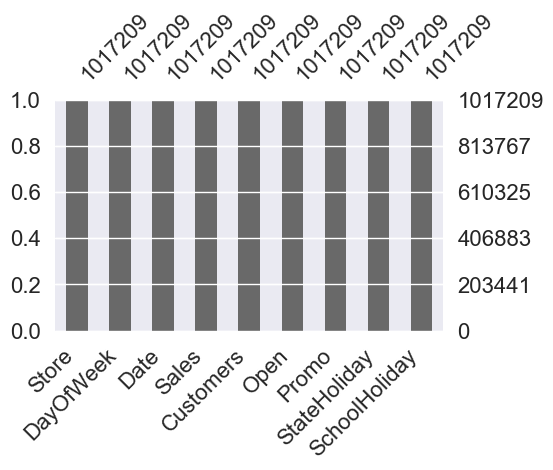

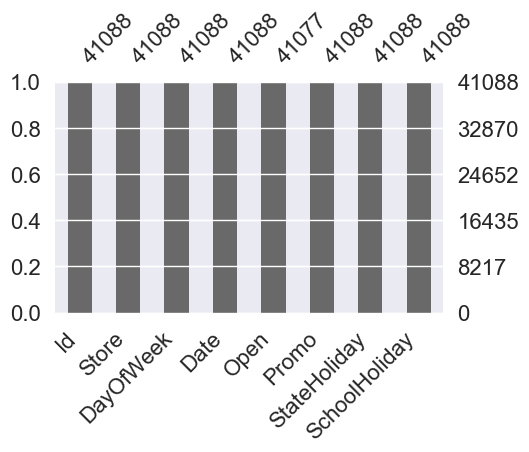

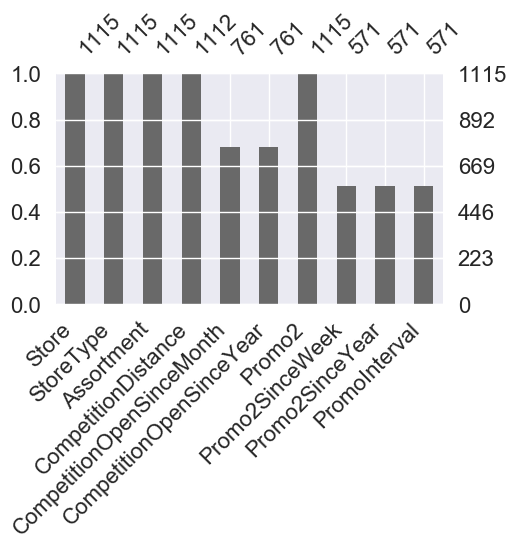

In [74]:
#观察训练集的缺失值情况
msno.bar(train_datas,figsize=(5,3))
#观察测试集的缺失值情况
msno.bar(test_datas,figsize=(5,3))
#观察store集的缺失值情况
msno.bar(store_datas,figsize=(5,3))

从图中可以看出，训练集没有缺失值，测试集‘open’有11个缺失值；store集中6个特征存在缺失值。

In [75]:
#观察测试集中的缺失值
test_datas[test_datas.isnull().values==True]

Id  Store  DayOfWeek       Date  Open  Promo StateHoliday  \
479      480    622          4 2015-09-17   NaN      1            0   
1335    1336    622          3 2015-09-16   NaN      1            0   
2191    2192    622          2 2015-09-15   NaN      1            0   
3047    3048    622          1 2015-09-14   NaN      1            0   
4759    4760    622          6 2015-09-12   NaN      0            0   
5615    5616    622          5 2015-09-11   NaN      0            0   
6471    6472    622          4 2015-09-10   NaN      0            0   
7327    7328    622          3 2015-09-09   NaN      0            0   
8183    8184    622          2 2015-09-08   NaN      0            0   
9039    9040    622          1 2015-09-07   NaN      0            0   
10751  10752    622          6 2015-09-05   NaN      0            0   

       SchoolHoliday  
479                0  
1335               0  
2191               0  
3047               0  
4759               0  
5615               0  
6471               0  
7327               0  
8183               0  
9039               0  
10751              0

In [76]:
#测试集缺失值填充
test_datas = test_datas.fillna(1)
print(test_datas.isnull().sum())

Id               0
Store            0
DayOfWeek        0
Date             0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64


In [77]:
#store缺失值填充
store_datas['CompetitionDistance'] = store_datas['CompetitionDistance'].fillna(store_datas['CompetitionDistance'].mean())
store_datas['CompetitionOpenSinceMonth'] = store_datas['CompetitionOpenSinceMonth'].fillna(method='pad')
store_datas['CompetitionOpenSinceYear'] = store_datas['CompetitionOpenSinceYear'].fillna(method='pad')
store_datas = store_datas.fillna(0)
store_datas.isnull().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [78]:
#把train_datas、test_datas和store_datas合并，构成新的训练集和测试集
train_data = pd.merge(train_datas, store_datas, on='Store')
test_data = pd.merge(test_datas, store_datas, on='Store')
train_data.head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1            0   
1      1          4 2015-07-30   5020        546     1      1            0   
2      1          3 2015-07-29   4782        523     1      1            0   
3      1          2 2015-07-28   5011        560     1      1            0   
4      1          1 2015-07-27   6102        612     1      1            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  \
0              1         c          a               1270.0   
1              1         c          a               1270.0   
2              1         c          a               1270.0   
3              1         c          a               1270.0   
4              1         c          a               1270.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        9.0                    2008.0       0   
1                        9.0                    2008.0       0   
2                        9.0                    2008.0       0   
3                        9.0                    2008.0       0   
4                        9.0                    2008.0       0   

   Promo2SinceWeek  Promo2SinceYear PromoInterval  
0              0.0              0.0             0  
1              0.0              0.0             0  
2              0.0              0.0             0  
3              0.0              0.0             0  
4              0.0              0.0             0

In [79]:
#留出最近的6周数据作为验证集
train_data = train_data.sort_values(['Date'],ascending = False)
valid_data = train_data[:6*7*1115]
train_data = train_data[6*7*1115:]
train_data.sort_values(by='Store', inplace=True)
valid_data.sort_values(by='Store', inplace=True)

In [80]:
#因为销售额为0的记录不计入评分，所以只采用店铺为开，且销售额大于0的数据进行训练
valid_data = valid_data[(valid_data["Open"] != 0)&(valid_data["Sales"] > 0)]
train_data = train_data[(train_data["Open"] != 0)&(train_data["Sales"] > 0)]

In [81]:
#特征处理与转化，定义特征处理函数

def features_create(data):
    #将存在其他字符表示分类的特征转化为数字
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)
    
    #将时间特征进行拆分和转化，并加入'WeekOfYear'特征
    data['Year'] = data.Date.dt.year
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    data['DayOfWeek'] = data.Date.dt.dayofweek
    data['WeekOfYear'] = data.Date.dt.weekofyear
    
    #新增'CompetitionOpen'和'PromoOpen'特征,计算某天某店铺的竞争对手已营业时间和店铺促销已开展时间，用月为单位表示
    data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear) + (data.Month - data.CompetitionOpenSinceMonth)
    data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear) + (data.WeekOfYear - data.Promo2SinceWeek) / 4.0
    data['CompetitionOpen'] = data.CompetitionOpen.apply(lambda x: x if x > 0 else 0)
    data['PromoOpen'] = data.PromoOpen.apply(lambda x: x if x > 0 else 0)
    data['PromoOpen'][data['Promo2']==0] = 0
    
    #将'PromoInterval'特征转化为'IsPromoMonth'特征,表示某天某店铺是否处于促销月，1表示是，0表示否
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['monthStr'] = data.Month.map(month2str)
    data.loc[data.PromoInterval == 0, 'PromoInterval'] = ''
    data['IsPromoMonth'] = 0
    for ProMonth in data.PromoInterval.unique():
        if ProMonth != '':
            for month in ProMonth.split(','):
                data.loc[(data.monthStr == month) & (data.PromoInterval == ProMonth) & (data.PromoOpen != 0), 'IsPromoMonth'] = 1
    return data

In [82]:
#对训练集、验证集、测试集数据进行特征转化
features_create(train_data)
features_create(valid_data)
features_create(test_data)
print('Feature engineering finished')

G:\AIAIAI\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Feature engineering finished


In [83]:
#删掉训练集和验证集中不需要的特征
train_data.drop(['Date','Customers','Open','PromoInterval','monthStr'],axis=1,inplace =True)
valid_data.drop(['Date','Customers','Open','PromoInterval','monthStr'],axis=1,inplace =True)

#删掉测试集中对应的特征与训练集保持一致
x_test = test_data.drop(['Id','Date','Open','PromoInterval','monthStr'],axis = 1)

In [84]:
#拆分特征与标签，并将标签取对数处理
x_train = train_data.drop(['Sales'],axis=1 )
y_train = train_data.Sales
x_valid = valid_data.drop(['Sales'],axis=1 )
y_valid = valid_data.Sales

In [85]:
#定义评价函数rmspe

def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))
def rmspe_lg(yhat, y):
    return "rmspe", rmspe(y,yhat), False

In [86]:
#设置模型参数

clf = lgb.LGBMRegressor(
    boosting_type="gbdt",
    num_leaves=31,
    reg_alpha=0,
    reg_lambda=0,
    max_depth=-1,
    n_estimators=6000,
    objective='regression',
    subsample=0.8,            # 在不进行重采样的情况下随机选择部分数据
    colsample_bytree=0.8,     # 每次迭代中随机选择部分特征
    subsample_freq=1,         # bagging 的频率, 0 意味着禁用 bagging. k 意味着每 k 次迭代执行bagging（subsample）
    learning_rate=0.1,
    random_state=49
    )

In [87]:
#训练模型
start = time()
clf.fit(x_train, y_train,eval_set=[(x_train, y_train),(x_valid, y_valid)], eval_metric=rmspe_lg, early_stopping_rounds=500,
        categorical_feature=['Store','DayOfWeek','Promo','StateHoliday','SchoolHoliday','StoreType','Assortment',
                             'CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2','Promo2SinceWeek','Promo2SinceYear','Year',
                             'Month','Day','WeekOfYear','IsPromoMonth'])
end = time()

G:\AIAIAI\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Assortment', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Day', 'DayOfWeek', 'IsPromoMonth', 'Month', 'Promo', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'SchoolHoliday', 'StateHoliday', 'Store', 'StoreType', 'WeekOfYear', 'Year']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
G:\AIAIAI\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Assortment', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Day', 'DayOfWeek', 'IsPromoMonth', 'Month', 'Promo', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'SchoolHoliday', 'StateHoliday', 'Store', 'StoreType', 'WeekOfYear', 'Year']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	training's l2: 8.39579e+06	training's rmspe: 0.401086	valid_1's l2: 8.11732e+06	valid_1's rmspe: 0.395165
Training until validation scores don't improve for 500 rounds.
[2]	training's l2: 7.38727e+06	training's rmspe: 0.368417	valid_1's l2: 7.13865e+06	valid_1's rmspe: 0.363477
[3]	training's l2: 6.55542e+06	training's rmspe: 0.343786	valid_1's l2: 6.32204e+06	valid_1's rmspe: 0.339513
[4]	training's l2: 5.84665e+06	training's rmspe: 0.323509	valid_1's l2: 5.63501e+06	valid_1's rmspe: 0.319622
[5]	training's l2: 5.29031e+06	training's rmspe: 0.30779	valid_1's l2: 5.08472e+06	valid_1's rmspe: 0.303863
[6]	training's l2: 5.0602e+06	training's rmspe: 0.300444	valid_1's l2: 4.84016e+06	valid_1's rmspe: 0.296058
[7]	training's l2: 4.62857e+06	training's rmspe: 0.288136	valid_1's l2: 4.40789e+06	valid_1's rmspe: 0.283404
[8]	training's l2: 4.25053e+06	training's rmspe: 0.277238	valid_1's l2: 4.05181e+06	valid_1's rmspe: 0.273273
[9]	training's l2: 3.92178e+06	training's rmspe: 0.267914	v

[74]	training's l2: 966269	training's rmspe: 0.139979	valid_1's l2: 1.23485e+06	valid_1's rmspe: 0.157138
[75]	training's l2: 957247	training's rmspe: 0.139664	valid_1's l2: 1.2249e+06	valid_1's rmspe: 0.156782
[76]	training's l2: 949556	training's rmspe: 0.139027	valid_1's l2: 1.21859e+06	valid_1's rmspe: 0.15634
[77]	training's l2: 945188	training's rmspe: 0.138734	valid_1's l2: 1.21878e+06	valid_1's rmspe: 0.156322
[78]	training's l2: 941800	training's rmspe: 0.138518	valid_1's l2: 1.21567e+06	valid_1's rmspe: 0.156159
[79]	training's l2: 937512	training's rmspe: 0.13828	valid_1's l2: 1.21185e+06	valid_1's rmspe: 0.15559
[80]	training's l2: 929496	training's rmspe: 0.137794	valid_1's l2: 1.20243e+06	valid_1's rmspe: 0.155047
[81]	training's l2: 926112	training's rmspe: 0.137599	valid_1's l2: 1.19911e+06	valid_1's rmspe: 0.154903
[82]	training's l2: 922060	training's rmspe: 0.137372	valid_1's l2: 1.19541e+06	valid_1's rmspe: 0.154742
[83]	training's l2: 913621	training's rmspe: 0.136

[151]	training's l2: 738830	training's rmspe: 0.125021	valid_1's l2: 1.00797e+06	valid_1's rmspe: 0.142355
[152]	training's l2: 737710	training's rmspe: 0.124913	valid_1's l2: 1.00706e+06	valid_1's rmspe: 0.142272
[153]	training's l2: 736470	training's rmspe: 0.124824	valid_1's l2: 1.00599e+06	valid_1's rmspe: 0.142167
[154]	training's l2: 735521	training's rmspe: 0.124775	valid_1's l2: 1.00535e+06	valid_1's rmspe: 0.142109
[155]	training's l2: 734715	training's rmspe: 0.124722	valid_1's l2: 1.00502e+06	valid_1's rmspe: 0.142074
[156]	training's l2: 733849	training's rmspe: 0.124685	valid_1's l2: 1.00452e+06	valid_1's rmspe: 0.142047
[157]	training's l2: 732664	training's rmspe: 0.124533	valid_1's l2: 1.00301e+06	valid_1's rmspe: 0.141924
[158]	training's l2: 731430	training's rmspe: 0.124458	valid_1's l2: 1.00209e+06	valid_1's rmspe: 0.141859
[159]	training's l2: 730582	training's rmspe: 0.12438	valid_1's l2: 1.001e+06	valid_1's rmspe: 0.141758
[160]	training's l2: 728226	training's r

[230]	training's l2: 658162	training's rmspe: 0.119477	valid_1's l2: 933924	valid_1's rmspe: 0.136842
[231]	training's l2: 657197	training's rmspe: 0.119428	valid_1's l2: 933415	valid_1's rmspe: 0.13681
[232]	training's l2: 656436	training's rmspe: 0.119393	valid_1's l2: 933224	valid_1's rmspe: 0.136799
[233]	training's l2: 655885	training's rmspe: 0.119351	valid_1's l2: 932788	valid_1's rmspe: 0.136755
[234]	training's l2: 654955	training's rmspe: 0.119288	valid_1's l2: 932888	valid_1's rmspe: 0.136787
[235]	training's l2: 654344	training's rmspe: 0.119244	valid_1's l2: 932782	valid_1's rmspe: 0.136767
[236]	training's l2: 653802	training's rmspe: 0.119202	valid_1's l2: 932272	valid_1's rmspe: 0.136736
[237]	training's l2: 653201	training's rmspe: 0.119173	valid_1's l2: 932181	valid_1's rmspe: 0.136734
[238]	training's l2: 652024	training's rmspe: 0.119057	valid_1's l2: 931018	valid_1's rmspe: 0.136648
[239]	training's l2: 651178	training's rmspe: 0.118994	valid_1's l2: 930553	valid_1

[310]	training's l2: 605262	training's rmspe: 0.115452	valid_1's l2: 894848	valid_1's rmspe: 0.133755
[311]	training's l2: 604746	training's rmspe: 0.11538	valid_1's l2: 894711	valid_1's rmspe: 0.133746
[312]	training's l2: 603166	training's rmspe: 0.115179	valid_1's l2: 893278	valid_1's rmspe: 0.133598
[313]	training's l2: 602764	training's rmspe: 0.115134	valid_1's l2: 893024	valid_1's rmspe: 0.133578
[314]	training's l2: 602483	training's rmspe: 0.115111	valid_1's l2: 892876	valid_1's rmspe: 0.133573
[315]	training's l2: 602048	training's rmspe: 0.115095	valid_1's l2: 892825	valid_1's rmspe: 0.13357
[316]	training's l2: 601640	training's rmspe: 0.115065	valid_1's l2: 892864	valid_1's rmspe: 0.133568
[317]	training's l2: 601134	training's rmspe: 0.115014	valid_1's l2: 892386	valid_1's rmspe: 0.133518
[318]	training's l2: 600506	training's rmspe: 0.114955	valid_1's l2: 891864	valid_1's rmspe: 0.133388
[319]	training's l2: 600182	training's rmspe: 0.114934	valid_1's l2: 891792	valid_1'

[390]	training's l2: 565632	training's rmspe: 0.111677	valid_1's l2: 868341	valid_1's rmspe: 0.131576
[391]	training's l2: 565289	training's rmspe: 0.111653	valid_1's l2: 868356	valid_1's rmspe: 0.131619
[392]	training's l2: 564913	training's rmspe: 0.111613	valid_1's l2: 868017	valid_1's rmspe: 0.131601
[393]	training's l2: 564566	training's rmspe: 0.111584	valid_1's l2: 867794	valid_1's rmspe: 0.131587
[394]	training's l2: 564305	training's rmspe: 0.111574	valid_1's l2: 867777	valid_1's rmspe: 0.131573
[395]	training's l2: 563959	training's rmspe: 0.111522	valid_1's l2: 867475	valid_1's rmspe: 0.131537
[396]	training's l2: 563695	training's rmspe: 0.11149	valid_1's l2: 867581	valid_1's rmspe: 0.131537
[397]	training's l2: 563401	training's rmspe: 0.111464	valid_1's l2: 867463	valid_1's rmspe: 0.13153
[398]	training's l2: 563207	training's rmspe: 0.111444	valid_1's l2: 867384	valid_1's rmspe: 0.131524
[399]	training's l2: 562734	training's rmspe: 0.111403	valid_1's l2: 866732	valid_1'

[470]	training's l2: 537295	training's rmspe: 0.109265	valid_1's l2: 847329	valid_1's rmspe: 0.130394
[471]	training's l2: 536986	training's rmspe: 0.109239	valid_1's l2: 847253	valid_1's rmspe: 0.130391
[472]	training's l2: 536734	training's rmspe: 0.10921	valid_1's l2: 846829	valid_1's rmspe: 0.130367
[473]	training's l2: 536544	training's rmspe: 0.109193	valid_1's l2: 846799	valid_1's rmspe: 0.130357
[474]	training's l2: 536014	training's rmspe: 0.109165	valid_1's l2: 845270	valid_1's rmspe: 0.130285
[475]	training's l2: 535630	training's rmspe: 0.109148	valid_1's l2: 845107	valid_1's rmspe: 0.13029
[476]	training's l2: 534945	training's rmspe: 0.109106	valid_1's l2: 844548	valid_1's rmspe: 0.130265
[477]	training's l2: 534726	training's rmspe: 0.109086	valid_1's l2: 844334	valid_1's rmspe: 0.130237
[478]	training's l2: 534538	training's rmspe: 0.109077	valid_1's l2: 844205	valid_1's rmspe: 0.13024
[479]	training's l2: 534243	training's rmspe: 0.109056	valid_1's l2: 844177	valid_1's

[550]	training's l2: 512580	training's rmspe: 0.107017	valid_1's l2: 830753	valid_1's rmspe: 0.129456
[551]	training's l2: 512374	training's rmspe: 0.106992	valid_1's l2: 830466	valid_1's rmspe: 0.129435
[552]	training's l2: 512133	training's rmspe: 0.106981	valid_1's l2: 830509	valid_1's rmspe: 0.129433
[553]	training's l2: 511850	training's rmspe: 0.106941	valid_1's l2: 830213	valid_1's rmspe: 0.129402
[554]	training's l2: 511670	training's rmspe: 0.106921	valid_1's l2: 830078	valid_1's rmspe: 0.129407
[555]	training's l2: 511455	training's rmspe: 0.106911	valid_1's l2: 830004	valid_1's rmspe: 0.129406
[556]	training's l2: 511112	training's rmspe: 0.106878	valid_1's l2: 830117	valid_1's rmspe: 0.129376
[557]	training's l2: 510855	training's rmspe: 0.10684	valid_1's l2: 829885	valid_1's rmspe: 0.129353
[558]	training's l2: 510417	training's rmspe: 0.10678	valid_1's l2: 829252	valid_1's rmspe: 0.129269
[559]	training's l2: 510173	training's rmspe: 0.106765	valid_1's l2: 829135	valid_1'

[630]	training's l2: 493111	training's rmspe: 0.10531	valid_1's l2: 820969	valid_1's rmspe: 0.128822
[631]	training's l2: 492893	training's rmspe: 0.105283	valid_1's l2: 820634	valid_1's rmspe: 0.128781
[632]	training's l2: 492679	training's rmspe: 0.105265	valid_1's l2: 820481	valid_1's rmspe: 0.128774
[633]	training's l2: 492492	training's rmspe: 0.105245	valid_1's l2: 820517	valid_1's rmspe: 0.128785
[634]	training's l2: 492310	training's rmspe: 0.105227	valid_1's l2: 820472	valid_1's rmspe: 0.128782
[635]	training's l2: 492122	training's rmspe: 0.105206	valid_1's l2: 820480	valid_1's rmspe: 0.128783
[636]	training's l2: 491953	training's rmspe: 0.105179	valid_1's l2: 820652	valid_1's rmspe: 0.12879
[637]	training's l2: 491809	training's rmspe: 0.105163	valid_1's l2: 820573	valid_1's rmspe: 0.128788
[638]	training's l2: 491658	training's rmspe: 0.105149	valid_1's l2: 820533	valid_1's rmspe: 0.128784
[639]	training's l2: 491474	training's rmspe: 0.105131	valid_1's l2: 820518	valid_1'

[710]	training's l2: 475937	training's rmspe: 0.103627	valid_1's l2: 812665	valid_1's rmspe: 0.128252
[711]	training's l2: 475658	training's rmspe: 0.103594	valid_1's l2: 812636	valid_1's rmspe: 0.128247
[712]	training's l2: 475515	training's rmspe: 0.103584	valid_1's l2: 812513	valid_1's rmspe: 0.128244
[713]	training's l2: 475380	training's rmspe: 0.103577	valid_1's l2: 812589	valid_1's rmspe: 0.128271
[714]	training's l2: 475246	training's rmspe: 0.103565	valid_1's l2: 812520	valid_1's rmspe: 0.128269
[715]	training's l2: 475113	training's rmspe: 0.103555	valid_1's l2: 812335	valid_1's rmspe: 0.12827
[716]	training's l2: 474320	training's rmspe: 0.103439	valid_1's l2: 811554	valid_1's rmspe: 0.128203
[717]	training's l2: 474142	training's rmspe: 0.103424	valid_1's l2: 811536	valid_1's rmspe: 0.128197
[718]	training's l2: 473980	training's rmspe: 0.103415	valid_1's l2: 811573	valid_1's rmspe: 0.128201
[719]	training's l2: 473810	training's rmspe: 0.103402	valid_1's l2: 811628	valid_1

[790]	training's l2: 460698	training's rmspe: 0.102115	valid_1's l2: 805138	valid_1's rmspe: 0.127569
[791]	training's l2: 460538	training's rmspe: 0.102107	valid_1's l2: 804952	valid_1's rmspe: 0.12756
[792]	training's l2: 460392	training's rmspe: 0.102092	valid_1's l2: 804903	valid_1's rmspe: 0.127555
[793]	training's l2: 460230	training's rmspe: 0.102082	valid_1's l2: 804691	valid_1's rmspe: 0.127541
[794]	training's l2: 460038	training's rmspe: 0.102046	valid_1's l2: 804591	valid_1's rmspe: 0.127521
[795]	training's l2: 459902	training's rmspe: 0.102031	valid_1's l2: 804539	valid_1's rmspe: 0.127523
[796]	training's l2: 459791	training's rmspe: 0.102022	valid_1's l2: 804551	valid_1's rmspe: 0.127526
[797]	training's l2: 459554	training's rmspe: 0.102006	valid_1's l2: 804564	valid_1's rmspe: 0.127528
[798]	training's l2: 459424	training's rmspe: 0.101988	valid_1's l2: 804586	valid_1's rmspe: 0.127532
[799]	training's l2: 459304	training's rmspe: 0.10198	valid_1's l2: 804496	valid_1'

[870]	training's l2: 447751	training's rmspe: 0.100938	valid_1's l2: 797973	valid_1's rmspe: 0.127063
[871]	training's l2: 447616	training's rmspe: 0.100926	valid_1's l2: 797911	valid_1's rmspe: 0.127058
[872]	training's l2: 447507	training's rmspe: 0.100921	valid_1's l2: 797861	valid_1's rmspe: 0.127059
[873]	training's l2: 447270	training's rmspe: 0.100887	valid_1's l2: 797429	valid_1's rmspe: 0.126987
[874]	training's l2: 447164	training's rmspe: 0.100879	valid_1's l2: 797558	valid_1's rmspe: 0.127002
[875]	training's l2: 447046	training's rmspe: 0.10087	valid_1's l2: 797554	valid_1's rmspe: 0.127008
[876]	training's l2: 446779	training's rmspe: 0.100838	valid_1's l2: 797224	valid_1's rmspe: 0.12697
[877]	training's l2: 446630	training's rmspe: 0.100825	valid_1's l2: 797175	valid_1's rmspe: 0.126974
[878]	training's l2: 446499	training's rmspe: 0.100806	valid_1's l2: 797067	valid_1's rmspe: 0.12696
[879]	training's l2: 446238	training's rmspe: 0.100788	valid_1's l2: 797045	valid_1's

[950]	training's l2: 435831	training's rmspe: 0.0997567	valid_1's l2: 791931	valid_1's rmspe: 0.126586
[951]	training's l2: 435702	training's rmspe: 0.0997425	valid_1's l2: 791807	valid_1's rmspe: 0.126581
[952]	training's l2: 435567	training's rmspe: 0.0997274	valid_1's l2: 791811	valid_1's rmspe: 0.126578
[953]	training's l2: 435485	training's rmspe: 0.099716	valid_1's l2: 791780	valid_1's rmspe: 0.126579
[954]	training's l2: 435384	training's rmspe: 0.0997061	valid_1's l2: 791656	valid_1's rmspe: 0.126574
[955]	training's l2: 435254	training's rmspe: 0.0996893	valid_1's l2: 791412	valid_1's rmspe: 0.126528
[956]	training's l2: 435138	training's rmspe: 0.0996789	valid_1's l2: 791365	valid_1's rmspe: 0.126525
[957]	training's l2: 435014	training's rmspe: 0.0996689	valid_1's l2: 791393	valid_1's rmspe: 0.126529
[958]	training's l2: 434880	training's rmspe: 0.0996582	valid_1's l2: 791613	valid_1's rmspe: 0.126569
[959]	training's l2: 434778	training's rmspe: 0.0996411	valid_1's l2: 7915

[1029]	training's l2: 425764	training's rmspe: 0.0987785	valid_1's l2: 785525	valid_1's rmspe: 0.126022
[1030]	training's l2: 425659	training's rmspe: 0.098765	valid_1's l2: 785373	valid_1's rmspe: 0.126008
[1031]	training's l2: 425530	training's rmspe: 0.0987446	valid_1's l2: 785265	valid_1's rmspe: 0.125997
[1032]	training's l2: 425313	training's rmspe: 0.0987167	valid_1's l2: 785640	valid_1's rmspe: 0.126022
[1033]	training's l2: 425222	training's rmspe: 0.0987098	valid_1's l2: 785622	valid_1's rmspe: 0.126022
[1034]	training's l2: 425138	training's rmspe: 0.0987071	valid_1's l2: 785674	valid_1's rmspe: 0.126028
[1035]	training's l2: 425021	training's rmspe: 0.0987004	valid_1's l2: 785602	valid_1's rmspe: 0.12602
[1036]	training's l2: 424912	training's rmspe: 0.0986936	valid_1's l2: 785524	valid_1's rmspe: 0.126024
[1037]	training's l2: 424820	training's rmspe: 0.0986819	valid_1's l2: 785506	valid_1's rmspe: 0.126012
[1038]	training's l2: 424709	training's rmspe: 0.0986696	valid_1's

[1107]	training's l2: 416623	training's rmspe: 0.0978651	valid_1's l2: 780473	valid_1's rmspe: 0.125631
[1108]	training's l2: 416504	training's rmspe: 0.0978497	valid_1's l2: 780518	valid_1's rmspe: 0.125624
[1109]	training's l2: 416407	training's rmspe: 0.0978488	valid_1's l2: 780447	valid_1's rmspe: 0.125615
[1110]	training's l2: 416285	training's rmspe: 0.097841	valid_1's l2: 780371	valid_1's rmspe: 0.125612
[1111]	training's l2: 416198	training's rmspe: 0.0978339	valid_1's l2: 780289	valid_1's rmspe: 0.12561
[1112]	training's l2: 416117	training's rmspe: 0.0978289	valid_1's l2: 780296	valid_1's rmspe: 0.125611
[1113]	training's l2: 415873	training's rmspe: 0.0977994	valid_1's l2: 780038	valid_1's rmspe: 0.125574
[1114]	training's l2: 415681	training's rmspe: 0.0977816	valid_1's l2: 780020	valid_1's rmspe: 0.125572
[1115]	training's l2: 415561	training's rmspe: 0.0977719	valid_1's l2: 779992	valid_1's rmspe: 0.125575
[1116]	training's l2: 415410	training's rmspe: 0.0977569	valid_1's

[1186]	training's l2: 406944	training's rmspe: 0.0968597	valid_1's l2: 777846	valid_1's rmspe: 0.125431
[1187]	training's l2: 406798	training's rmspe: 0.0968334	valid_1's l2: 777668	valid_1's rmspe: 0.125411
[1188]	training's l2: 406713	training's rmspe: 0.0968279	valid_1's l2: 777601	valid_1's rmspe: 0.125404
[1189]	training's l2: 406497	training's rmspe: 0.0967853	valid_1's l2: 777520	valid_1's rmspe: 0.125401
[1190]	training's l2: 406346	training's rmspe: 0.0967646	valid_1's l2: 777412	valid_1's rmspe: 0.125385
[1191]	training's l2: 406264	training's rmspe: 0.0967558	valid_1's l2: 777256	valid_1's rmspe: 0.12538
[1192]	training's l2: 406156	training's rmspe: 0.0967456	valid_1's l2: 777218	valid_1's rmspe: 0.125373
[1193]	training's l2: 406009	training's rmspe: 0.0967332	valid_1's l2: 777300	valid_1's rmspe: 0.12538
[1194]	training's l2: 405927	training's rmspe: 0.0967271	valid_1's l2: 777143	valid_1's rmspe: 0.125383
[1195]	training's l2: 405783	training's rmspe: 0.0967063	valid_1's

[1264]	training's l2: 397780	training's rmspe: 0.0957927	valid_1's l2: 773234	valid_1's rmspe: 0.125052
[1265]	training's l2: 397690	training's rmspe: 0.095785	valid_1's l2: 773096	valid_1's rmspe: 0.125047
[1266]	training's l2: 397542	training's rmspe: 0.0957655	valid_1's l2: 773086	valid_1's rmspe: 0.125046
[1267]	training's l2: 397471	training's rmspe: 0.0957584	valid_1's l2: 773125	valid_1's rmspe: 0.125049
[1268]	training's l2: 397364	training's rmspe: 0.095746	valid_1's l2: 773030	valid_1's rmspe: 0.125046
[1269]	training's l2: 397272	training's rmspe: 0.0957191	valid_1's l2: 773030	valid_1's rmspe: 0.125041
[1270]	training's l2: 397171	training's rmspe: 0.0957128	valid_1's l2: 772973	valid_1's rmspe: 0.125044
[1271]	training's l2: 397092	training's rmspe: 0.095701	valid_1's l2: 772945	valid_1's rmspe: 0.125037
[1272]	training's l2: 396973	training's rmspe: 0.0956976	valid_1's l2: 772910	valid_1's rmspe: 0.125039
[1273]	training's l2: 396892	training's rmspe: 0.0956795	valid_1's 

[1342]	training's l2: 389902	training's rmspe: 0.094975	valid_1's l2: 770330	valid_1's rmspe: 0.124713
[1343]	training's l2: 389816	training's rmspe: 0.094959	valid_1's l2: 770380	valid_1's rmspe: 0.12472
[1344]	training's l2: 389714	training's rmspe: 0.0949489	valid_1's l2: 770337	valid_1's rmspe: 0.124721
[1345]	training's l2: 389623	training's rmspe: 0.0949373	valid_1's l2: 770226	valid_1's rmspe: 0.124714
[1346]	training's l2: 389562	training's rmspe: 0.0949331	valid_1's l2: 770205	valid_1's rmspe: 0.12471
[1347]	training's l2: 389487	training's rmspe: 0.0949211	valid_1's l2: 770124	valid_1's rmspe: 0.124706
[1348]	training's l2: 389401	training's rmspe: 0.0949169	valid_1's l2: 770125	valid_1's rmspe: 0.124708
[1349]	training's l2: 389332	training's rmspe: 0.0949111	valid_1's l2: 770095	valid_1's rmspe: 0.124704
[1350]	training's l2: 389256	training's rmspe: 0.0949009	valid_1's l2: 770024	valid_1's rmspe: 0.124695
[1351]	training's l2: 389181	training's rmspe: 0.0948894	valid_1's l

[1420]	training's l2: 381999	training's rmspe: 0.0941305	valid_1's l2: 766175	valid_1's rmspe: 0.124478
[1421]	training's l2: 381926	training's rmspe: 0.0941195	valid_1's l2: 766148	valid_1's rmspe: 0.124473
[1422]	training's l2: 381850	training's rmspe: 0.0941092	valid_1's l2: 766267	valid_1's rmspe: 0.124517
[1423]	training's l2: 381756	training's rmspe: 0.0940968	valid_1's l2: 765852	valid_1's rmspe: 0.124486
[1424]	training's l2: 381686	training's rmspe: 0.0940894	valid_1's l2: 765818	valid_1's rmspe: 0.12448
[1425]	training's l2: 381598	training's rmspe: 0.0940792	valid_1's l2: 765797	valid_1's rmspe: 0.124477
[1426]	training's l2: 381515	training's rmspe: 0.094069	valid_1's l2: 765838	valid_1's rmspe: 0.124491
[1427]	training's l2: 381389	training's rmspe: 0.0940568	valid_1's l2: 765767	valid_1's rmspe: 0.124483
[1428]	training's l2: 381323	training's rmspe: 0.0940491	valid_1's l2: 765793	valid_1's rmspe: 0.124477
[1429]	training's l2: 381251	training's rmspe: 0.0940401	valid_1's

[1498]	training's l2: 375385	training's rmspe: 0.0934187	valid_1's l2: 763432	valid_1's rmspe: 0.124265
[1499]	training's l2: 375323	training's rmspe: 0.0934125	valid_1's l2: 763421	valid_1's rmspe: 0.124259
[1500]	training's l2: 375234	training's rmspe: 0.0934045	valid_1's l2: 763406	valid_1's rmspe: 0.12426
[1501]	training's l2: 375153	training's rmspe: 0.0934062	valid_1's l2: 763472	valid_1's rmspe: 0.124262
[1502]	training's l2: 375081	training's rmspe: 0.0933979	valid_1's l2: 763399	valid_1's rmspe: 0.124256
[1503]	training's l2: 375014	training's rmspe: 0.0933922	valid_1's l2: 763410	valid_1's rmspe: 0.124253
[1504]	training's l2: 374913	training's rmspe: 0.0933867	valid_1's l2: 763406	valid_1's rmspe: 0.124252
[1505]	training's l2: 374847	training's rmspe: 0.0933801	valid_1's l2: 763356	valid_1's rmspe: 0.12424
[1506]	training's l2: 374785	training's rmspe: 0.0933712	valid_1's l2: 763197	valid_1's rmspe: 0.124226
[1507]	training's l2: 374711	training's rmspe: 0.0933649	valid_1's

[1576]	training's l2: 369372	training's rmspe: 0.0927919	valid_1's l2: 761481	valid_1's rmspe: 0.124101
[1577]	training's l2: 369287	training's rmspe: 0.0927834	valid_1's l2: 761417	valid_1's rmspe: 0.124091
[1578]	training's l2: 369222	training's rmspe: 0.0927774	valid_1's l2: 761439	valid_1's rmspe: 0.124092
[1579]	training's l2: 369169	training's rmspe: 0.092774	valid_1's l2: 761358	valid_1's rmspe: 0.124096
[1580]	training's l2: 369028	training's rmspe: 0.0927597	valid_1's l2: 761335	valid_1's rmspe: 0.124097
[1581]	training's l2: 368907	training's rmspe: 0.092744	valid_1's l2: 761325	valid_1's rmspe: 0.124093
[1582]	training's l2: 368807	training's rmspe: 0.0927258	valid_1's l2: 761310	valid_1's rmspe: 0.124095
[1583]	training's l2: 368748	training's rmspe: 0.0927201	valid_1's l2: 761365	valid_1's rmspe: 0.124098
[1584]	training's l2: 368680	training's rmspe: 0.0927149	valid_1's l2: 761308	valid_1's rmspe: 0.124095
[1585]	training's l2: 368607	training's rmspe: 0.0927079	valid_1's

[1654]	training's l2: 363365	training's rmspe: 0.0920738	valid_1's l2: 759938	valid_1's rmspe: 0.12396
[1655]	training's l2: 363277	training's rmspe: 0.092068	valid_1's l2: 760012	valid_1's rmspe: 0.123969
[1656]	training's l2: 363199	training's rmspe: 0.0920569	valid_1's l2: 759934	valid_1's rmspe: 0.123958
[1657]	training's l2: 363140	training's rmspe: 0.0920499	valid_1's l2: 759952	valid_1's rmspe: 0.123957
[1658]	training's l2: 363078	training's rmspe: 0.092047	valid_1's l2: 759979	valid_1's rmspe: 0.123964
[1659]	training's l2: 363021	training's rmspe: 0.0920432	valid_1's l2: 760041	valid_1's rmspe: 0.123964
[1660]	training's l2: 362959	training's rmspe: 0.0920355	valid_1's l2: 760030	valid_1's rmspe: 0.123964
[1661]	training's l2: 362838	training's rmspe: 0.0920245	valid_1's l2: 759997	valid_1's rmspe: 0.123956
[1662]	training's l2: 362759	training's rmspe: 0.0920186	valid_1's l2: 760022	valid_1's rmspe: 0.123952
[1663]	training's l2: 362687	training's rmspe: 0.0920114	valid_1's 

[1732]	training's l2: 357486	training's rmspe: 0.0914456	valid_1's l2: 758651	valid_1's rmspe: 0.123724
[1733]	training's l2: 357433	training's rmspe: 0.0914413	valid_1's l2: 758611	valid_1's rmspe: 0.123726
[1734]	training's l2: 357384	training's rmspe: 0.0914332	valid_1's l2: 758622	valid_1's rmspe: 0.123726
[1735]	training's l2: 357327	training's rmspe: 0.0914261	valid_1's l2: 758614	valid_1's rmspe: 0.123726
[1736]	training's l2: 357236	training's rmspe: 0.0914224	valid_1's l2: 758650	valid_1's rmspe: 0.123729
[1737]	training's l2: 357169	training's rmspe: 0.091414	valid_1's l2: 758651	valid_1's rmspe: 0.123723
[1738]	training's l2: 356941	training's rmspe: 0.0913662	valid_1's l2: 758449	valid_1's rmspe: 0.12369
[1739]	training's l2: 356896	training's rmspe: 0.0913607	valid_1's l2: 758377	valid_1's rmspe: 0.123687
[1740]	training's l2: 356822	training's rmspe: 0.0913567	valid_1's l2: 758315	valid_1's rmspe: 0.123684
[1741]	training's l2: 356763	training's rmspe: 0.0913485	valid_1's

[1810]	training's l2: 352102	training's rmspe: 0.0908815	valid_1's l2: 757285	valid_1's rmspe: 0.123629
[1811]	training's l2: 352050	training's rmspe: 0.0908748	valid_1's l2: 757280	valid_1's rmspe: 0.123629
[1812]	training's l2: 352009	training's rmspe: 0.0908696	valid_1's l2: 757373	valid_1's rmspe: 0.123633
[1813]	training's l2: 351947	training's rmspe: 0.0908611	valid_1's l2: 757257	valid_1's rmspe: 0.123615
[1814]	training's l2: 351873	training's rmspe: 0.0908551	valid_1's l2: 757222	valid_1's rmspe: 0.123615
[1815]	training's l2: 351821	training's rmspe: 0.0908523	valid_1's l2: 757218	valid_1's rmspe: 0.123616
[1816]	training's l2: 351765	training's rmspe: 0.0908487	valid_1's l2: 757188	valid_1's rmspe: 0.123616
[1817]	training's l2: 351707	training's rmspe: 0.0908395	valid_1's l2: 757179	valid_1's rmspe: 0.123605
[1818]	training's l2: 351650	training's rmspe: 0.0908349	valid_1's l2: 757114	valid_1's rmspe: 0.123598
[1819]	training's l2: 351585	training's rmspe: 0.0908295	valid_1

[1888]	training's l2: 346827	training's rmspe: 0.0903234	valid_1's l2: 755089	valid_1's rmspe: 0.1234
[1889]	training's l2: 346753	training's rmspe: 0.0903264	valid_1's l2: 755023	valid_1's rmspe: 0.123398
[1890]	training's l2: 346701	training's rmspe: 0.0903202	valid_1's l2: 754926	valid_1's rmspe: 0.123386
[1891]	training's l2: 346600	training's rmspe: 0.090316	valid_1's l2: 754912	valid_1's rmspe: 0.123381
[1892]	training's l2: 346549	training's rmspe: 0.090312	valid_1's l2: 754977	valid_1's rmspe: 0.12339
[1893]	training's l2: 346497	training's rmspe: 0.0903043	valid_1's l2: 754883	valid_1's rmspe: 0.123379
[1894]	training's l2: 346444	training's rmspe: 0.0902994	valid_1's l2: 754836	valid_1's rmspe: 0.123376
[1895]	training's l2: 346379	training's rmspe: 0.0902916	valid_1's l2: 754809	valid_1's rmspe: 0.123376
[1896]	training's l2: 346325	training's rmspe: 0.0902858	valid_1's l2: 754836	valid_1's rmspe: 0.123381
[1897]	training's l2: 346252	training's rmspe: 0.0902799	valid_1's l2

[1967]	training's l2: 341928	training's rmspe: 0.089854	valid_1's l2: 753894	valid_1's rmspe: 0.123273
[1968]	training's l2: 341876	training's rmspe: 0.0898534	valid_1's l2: 753914	valid_1's rmspe: 0.123279
[1969]	training's l2: 341802	training's rmspe: 0.0898453	valid_1's l2: 753956	valid_1's rmspe: 0.123285
[1970]	training's l2: 341756	training's rmspe: 0.0898431	valid_1's l2: 753911	valid_1's rmspe: 0.123285
[1971]	training's l2: 341683	training's rmspe: 0.0898304	valid_1's l2: 753818	valid_1's rmspe: 0.123293
[1972]	training's l2: 341641	training's rmspe: 0.0898284	valid_1's l2: 753811	valid_1's rmspe: 0.123289
[1973]	training's l2: 341579	training's rmspe: 0.0898234	valid_1's l2: 753789	valid_1's rmspe: 0.12329
[1974]	training's l2: 341512	training's rmspe: 0.08981	valid_1's l2: 753703	valid_1's rmspe: 0.123284
[1975]	training's l2: 341444	training's rmspe: 0.0898142	valid_1's l2: 753647	valid_1's rmspe: 0.123277
[1976]	training's l2: 341378	training's rmspe: 0.0898066	valid_1's l

[2046]	training's l2: 337152	training's rmspe: 0.0892673	valid_1's l2: 751995	valid_1's rmspe: 0.122998
[2047]	training's l2: 337099	training's rmspe: 0.0892608	valid_1's l2: 752046	valid_1's rmspe: 0.123004
[2048]	training's l2: 337043	training's rmspe: 0.0892558	valid_1's l2: 752072	valid_1's rmspe: 0.122999
[2049]	training's l2: 337005	training's rmspe: 0.0892495	valid_1's l2: 752073	valid_1's rmspe: 0.122999
[2050]	training's l2: 336942	training's rmspe: 0.0892436	valid_1's l2: 751986	valid_1's rmspe: 0.122988
[2051]	training's l2: 336870	training's rmspe: 0.0892388	valid_1's l2: 752020	valid_1's rmspe: 0.122992
[2052]	training's l2: 336826	training's rmspe: 0.089234	valid_1's l2: 751926	valid_1's rmspe: 0.12297
[2053]	training's l2: 336784	training's rmspe: 0.0892183	valid_1's l2: 751925	valid_1's rmspe: 0.12297
[2054]	training's l2: 336747	training's rmspe: 0.0892064	valid_1's l2: 751903	valid_1's rmspe: 0.122966
[2055]	training's l2: 336673	training's rmspe: 0.0892022	valid_1's 

[2124]	training's l2: 332634	training's rmspe: 0.0887589	valid_1's l2: 750135	valid_1's rmspe: 0.122857
[2125]	training's l2: 332571	training's rmspe: 0.0887513	valid_1's l2: 750069	valid_1's rmspe: 0.12285
[2126]	training's l2: 332522	training's rmspe: 0.0887457	valid_1's l2: 750046	valid_1's rmspe: 0.12285
[2127]	training's l2: 332480	training's rmspe: 0.0887433	valid_1's l2: 749901	valid_1's rmspe: 0.122852
[2128]	training's l2: 332437	training's rmspe: 0.0887382	valid_1's l2: 749857	valid_1's rmspe: 0.122847
[2129]	training's l2: 332389	training's rmspe: 0.0887333	valid_1's l2: 749716	valid_1's rmspe: 0.122833
[2130]	training's l2: 332348	training's rmspe: 0.0887283	valid_1's l2: 749778	valid_1's rmspe: 0.122835
[2131]	training's l2: 332282	training's rmspe: 0.0887206	valid_1's l2: 749741	valid_1's rmspe: 0.122836
[2132]	training's l2: 332235	training's rmspe: 0.0887159	valid_1's l2: 749678	valid_1's rmspe: 0.122824
[2133]	training's l2: 332187	training's rmspe: 0.0887097	valid_1's

[2202]	training's l2: 328674	training's rmspe: 0.088329	valid_1's l2: 748576	valid_1's rmspe: 0.122739
[2203]	training's l2: 328621	training's rmspe: 0.0883251	valid_1's l2: 748529	valid_1's rmspe: 0.122738
[2204]	training's l2: 328582	training's rmspe: 0.0883208	valid_1's l2: 748572	valid_1's rmspe: 0.12274
[2205]	training's l2: 328527	training's rmspe: 0.0883167	valid_1's l2: 748530	valid_1's rmspe: 0.122736
[2206]	training's l2: 328486	training's rmspe: 0.0883096	valid_1's l2: 748512	valid_1's rmspe: 0.12273
[2207]	training's l2: 328435	training's rmspe: 0.0883043	valid_1's l2: 748526	valid_1's rmspe: 0.122728
[2208]	training's l2: 328396	training's rmspe: 0.0882958	valid_1's l2: 748490	valid_1's rmspe: 0.122722
[2209]	training's l2: 328353	training's rmspe: 0.0882931	valid_1's l2: 748471	valid_1's rmspe: 0.122721
[2210]	training's l2: 328305	training's rmspe: 0.088291	valid_1's l2: 748482	valid_1's rmspe: 0.122724
[2211]	training's l2: 328257	training's rmspe: 0.0882894	valid_1's l

[2280]	training's l2: 324868	training's rmspe: 0.0878979	valid_1's l2: 747852	valid_1's rmspe: 0.122687
[2281]	training's l2: 324822	training's rmspe: 0.087889	valid_1's l2: 747868	valid_1's rmspe: 0.122689
[2282]	training's l2: 324764	training's rmspe: 0.0878799	valid_1's l2: 747883	valid_1's rmspe: 0.122686
[2283]	training's l2: 324722	training's rmspe: 0.0878739	valid_1's l2: 747904	valid_1's rmspe: 0.122689
[2284]	training's l2: 324655	training's rmspe: 0.0878637	valid_1's l2: 747917	valid_1's rmspe: 0.12269
[2285]	training's l2: 324609	training's rmspe: 0.0878631	valid_1's l2: 747873	valid_1's rmspe: 0.122681
[2286]	training's l2: 324544	training's rmspe: 0.0878585	valid_1's l2: 747795	valid_1's rmspe: 0.122672
[2287]	training's l2: 324505	training's rmspe: 0.0878552	valid_1's l2: 747806	valid_1's rmspe: 0.122675
[2288]	training's l2: 324445	training's rmspe: 0.0878439	valid_1's l2: 747952	valid_1's rmspe: 0.122689
[2289]	training's l2: 324378	training's rmspe: 0.0878329	valid_1's

[2359]	training's l2: 320964	training's rmspe: 0.087387	valid_1's l2: 747362	valid_1's rmspe: 0.122685
[2360]	training's l2: 320906	training's rmspe: 0.0873759	valid_1's l2: 747389	valid_1's rmspe: 0.122674
[2361]	training's l2: 320834	training's rmspe: 0.0873628	valid_1's l2: 747728	valid_1's rmspe: 0.122716
[2362]	training's l2: 320800	training's rmspe: 0.0873584	valid_1's l2: 747621	valid_1's rmspe: 0.122704
[2363]	training's l2: 320753	training's rmspe: 0.0873535	valid_1's l2: 747632	valid_1's rmspe: 0.122706
[2364]	training's l2: 320712	training's rmspe: 0.0873521	valid_1's l2: 747583	valid_1's rmspe: 0.122706
[2365]	training's l2: 320667	training's rmspe: 0.0873464	valid_1's l2: 747605	valid_1's rmspe: 0.12271
[2366]	training's l2: 320599	training's rmspe: 0.0873411	valid_1's l2: 747566	valid_1's rmspe: 0.122707
[2367]	training's l2: 320556	training's rmspe: 0.0873384	valid_1's l2: 747574	valid_1's rmspe: 0.122711
[2368]	training's l2: 320507	training's rmspe: 0.0873302	valid_1's

[2437]	training's l2: 317273	training's rmspe: 0.0869724	valid_1's l2: 745752	valid_1's rmspe: 0.122575
[2438]	training's l2: 317228	training's rmspe: 0.086969	valid_1's l2: 745676	valid_1's rmspe: 0.12257
[2439]	training's l2: 317197	training's rmspe: 0.0869654	valid_1's l2: 745662	valid_1's rmspe: 0.122566
[2440]	training's l2: 317111	training's rmspe: 0.0869561	valid_1's l2: 745622	valid_1's rmspe: 0.122566
[2441]	training's l2: 317075	training's rmspe: 0.0869506	valid_1's l2: 745646	valid_1's rmspe: 0.122565
[2442]	training's l2: 317044	training's rmspe: 0.0869322	valid_1's l2: 745644	valid_1's rmspe: 0.122557
[2443]	training's l2: 316974	training's rmspe: 0.0869222	valid_1's l2: 745588	valid_1's rmspe: 0.122547
[2444]	training's l2: 316929	training's rmspe: 0.0869213	valid_1's l2: 745615	valid_1's rmspe: 0.122548
[2445]	training's l2: 316873	training's rmspe: 0.0869156	valid_1's l2: 745562	valid_1's rmspe: 0.122544
[2446]	training's l2: 316823	training's rmspe: 0.0869081	valid_1's

[2515]	training's l2: 313860	training's rmspe: 0.0865386	valid_1's l2: 744434	valid_1's rmspe: 0.122459
[2516]	training's l2: 313823	training's rmspe: 0.0865336	valid_1's l2: 744433	valid_1's rmspe: 0.122458
[2517]	training's l2: 313786	training's rmspe: 0.0865318	valid_1's l2: 744422	valid_1's rmspe: 0.122457
[2518]	training's l2: 313732	training's rmspe: 0.0865267	valid_1's l2: 744445	valid_1's rmspe: 0.122475
[2519]	training's l2: 313697	training's rmspe: 0.0865269	valid_1's l2: 744477	valid_1's rmspe: 0.122479
[2520]	training's l2: 313657	training's rmspe: 0.0865202	valid_1's l2: 744431	valid_1's rmspe: 0.122472
[2521]	training's l2: 313615	training's rmspe: 0.0865141	valid_1's l2: 744304	valid_1's rmspe: 0.122464
[2522]	training's l2: 313567	training's rmspe: 0.0865066	valid_1's l2: 744201	valid_1's rmspe: 0.122454
[2523]	training's l2: 313535	training's rmspe: 0.0865008	valid_1's l2: 744216	valid_1's rmspe: 0.122452
[2524]	training's l2: 313505	training's rmspe: 0.0864961	valid_1

[2593]	training's l2: 310499	training's rmspe: 0.0861886	valid_1's l2: 743939	valid_1's rmspe: 0.122459
[2594]	training's l2: 310448	training's rmspe: 0.0861847	valid_1's l2: 743973	valid_1's rmspe: 0.122467
[2595]	training's l2: 310405	training's rmspe: 0.086181	valid_1's l2: 743864	valid_1's rmspe: 0.122464
[2596]	training's l2: 310367	training's rmspe: 0.086179	valid_1's l2: 743856	valid_1's rmspe: 0.122468
[2597]	training's l2: 310311	training's rmspe: 0.0861707	valid_1's l2: 743806	valid_1's rmspe: 0.122463
[2598]	training's l2: 310270	training's rmspe: 0.0861663	valid_1's l2: 743829	valid_1's rmspe: 0.122463
[2599]	training's l2: 310222	training's rmspe: 0.0861426	valid_1's l2: 743765	valid_1's rmspe: 0.12246
[2600]	training's l2: 310190	training's rmspe: 0.0861353	valid_1's l2: 743712	valid_1's rmspe: 0.122455
[2601]	training's l2: 310150	training's rmspe: 0.0861301	valid_1's l2: 743674	valid_1's rmspe: 0.122449
[2602]	training's l2: 310108	training's rmspe: 0.0861249	valid_1's 

[2671]	training's l2: 307190	training's rmspe: 0.0857555	valid_1's l2: 743812	valid_1's rmspe: 0.122436
[2672]	training's l2: 307152	training's rmspe: 0.0857511	valid_1's l2: 743862	valid_1's rmspe: 0.122439
[2673]	training's l2: 307108	training's rmspe: 0.0857445	valid_1's l2: 743821	valid_1's rmspe: 0.122434
[2674]	training's l2: 307065	training's rmspe: 0.0857367	valid_1's l2: 743826	valid_1's rmspe: 0.122431
[2675]	training's l2: 307031	training's rmspe: 0.085733	valid_1's l2: 743818	valid_1's rmspe: 0.122431
[2676]	training's l2: 306991	training's rmspe: 0.0857259	valid_1's l2: 743868	valid_1's rmspe: 0.122437
[2677]	training's l2: 306949	training's rmspe: 0.085722	valid_1's l2: 743880	valid_1's rmspe: 0.122439
[2678]	training's l2: 306914	training's rmspe: 0.0857212	valid_1's l2: 743911	valid_1's rmspe: 0.122444
[2679]	training's l2: 306877	training's rmspe: 0.0857156	valid_1's l2: 743918	valid_1's rmspe: 0.122443
[2680]	training's l2: 306842	training's rmspe: 0.0857125	valid_1's

[2749]	training's l2: 303883	training's rmspe: 0.0853969	valid_1's l2: 743666	valid_1's rmspe: 0.122412
[2750]	training's l2: 303837	training's rmspe: 0.0853978	valid_1's l2: 743687	valid_1's rmspe: 0.12241
[2751]	training's l2: 303796	training's rmspe: 0.0853925	valid_1's l2: 743661	valid_1's rmspe: 0.122408
[2752]	training's l2: 303756	training's rmspe: 0.0853859	valid_1's l2: 743661	valid_1's rmspe: 0.122403
[2753]	training's l2: 303718	training's rmspe: 0.0853804	valid_1's l2: 743663	valid_1's rmspe: 0.122406
[2754]	training's l2: 303663	training's rmspe: 0.0853698	valid_1's l2: 743692	valid_1's rmspe: 0.122416
[2755]	training's l2: 303614	training's rmspe: 0.0853662	valid_1's l2: 743711	valid_1's rmspe: 0.122417
[2756]	training's l2: 303567	training's rmspe: 0.0853566	valid_1's l2: 743712	valid_1's rmspe: 0.122415
[2757]	training's l2: 303529	training's rmspe: 0.0853503	valid_1's l2: 743680	valid_1's rmspe: 0.122408
[2758]	training's l2: 303490	training's rmspe: 0.0853441	valid_1'

[2827]	training's l2: 300818	training's rmspe: 0.0850272	valid_1's l2: 742491	valid_1's rmspe: 0.122302
[2828]	training's l2: 300788	training's rmspe: 0.085023	valid_1's l2: 742525	valid_1's rmspe: 0.122295
[2829]	training's l2: 300758	training's rmspe: 0.0850172	valid_1's l2: 742467	valid_1's rmspe: 0.12229
[2830]	training's l2: 300720	training's rmspe: 0.0850131	valid_1's l2: 742534	valid_1's rmspe: 0.122289
[2831]	training's l2: 300682	training's rmspe: 0.0850116	valid_1's l2: 742461	valid_1's rmspe: 0.122284
[2832]	training's l2: 300615	training's rmspe: 0.0849987	valid_1's l2: 742373	valid_1's rmspe: 0.122275
[2833]	training's l2: 300598	training's rmspe: 0.0849956	valid_1's l2: 742369	valid_1's rmspe: 0.122274
[2834]	training's l2: 300567	training's rmspe: 0.0849908	valid_1's l2: 742377	valid_1's rmspe: 0.122271
[2835]	training's l2: 300525	training's rmspe: 0.0849862	valid_1's l2: 742355	valid_1's rmspe: 0.122269
[2836]	training's l2: 300491	training's rmspe: 0.0849778	valid_1's

[2905]	training's l2: 297854	training's rmspe: 0.0846327	valid_1's l2: 742531	valid_1's rmspe: 0.12231
[2906]	training's l2: 297827	training's rmspe: 0.0846291	valid_1's l2: 742493	valid_1's rmspe: 0.122319
[2907]	training's l2: 297790	training's rmspe: 0.0846258	valid_1's l2: 742522	valid_1's rmspe: 0.12232
[2908]	training's l2: 297762	training's rmspe: 0.0846249	valid_1's l2: 742457	valid_1's rmspe: 0.122313
[2909]	training's l2: 297706	training's rmspe: 0.0846194	valid_1's l2: 742484	valid_1's rmspe: 0.122312
[2910]	training's l2: 297664	training's rmspe: 0.0846137	valid_1's l2: 742438	valid_1's rmspe: 0.122317
[2911]	training's l2: 297621	training's rmspe: 0.0846088	valid_1's l2: 742408	valid_1's rmspe: 0.122317
[2912]	training's l2: 297566	training's rmspe: 0.0845987	valid_1's l2: 742380	valid_1's rmspe: 0.122315
[2913]	training's l2: 297540	training's rmspe: 0.0845939	valid_1's l2: 742359	valid_1's rmspe: 0.122312
[2914]	training's l2: 297506	training's rmspe: 0.0845859	valid_1's

[2983]	training's l2: 294933	training's rmspe: 0.0842664	valid_1's l2: 742023	valid_1's rmspe: 0.122307
[2984]	training's l2: 294902	training's rmspe: 0.0842651	valid_1's l2: 742033	valid_1's rmspe: 0.122306
[2985]	training's l2: 294853	training's rmspe: 0.0842584	valid_1's l2: 741902	valid_1's rmspe: 0.122294
[2986]	training's l2: 294823	training's rmspe: 0.0842548	valid_1's l2: 741869	valid_1's rmspe: 0.122292
[2987]	training's l2: 294785	training's rmspe: 0.0842597	valid_1's l2: 741865	valid_1's rmspe: 0.122291
[2988]	training's l2: 294740	training's rmspe: 0.0842513	valid_1's l2: 741908	valid_1's rmspe: 0.122296
[2989]	training's l2: 294709	training's rmspe: 0.0842504	valid_1's l2: 741837	valid_1's rmspe: 0.122291
[2990]	training's l2: 294678	training's rmspe: 0.0842492	valid_1's l2: 741883	valid_1's rmspe: 0.1223
[2991]	training's l2: 294641	training's rmspe: 0.0842446	valid_1's l2: 741851	valid_1's rmspe: 0.122294
[2992]	training's l2: 294600	training's rmspe: 0.0842381	valid_1's

[3062]	training's l2: 292221	training's rmspe: 0.0839431	valid_1's l2: 741714	valid_1's rmspe: 0.122286
[3063]	training's l2: 292187	training's rmspe: 0.0839374	valid_1's l2: 741705	valid_1's rmspe: 0.122286
[3064]	training's l2: 292143	training's rmspe: 0.083933	valid_1's l2: 741661	valid_1's rmspe: 0.122283
[3065]	training's l2: 292109	training's rmspe: 0.0839291	valid_1's l2: 741664	valid_1's rmspe: 0.122282
[3066]	training's l2: 292061	training's rmspe: 0.0839234	valid_1's l2: 741659	valid_1's rmspe: 0.122279
[3067]	training's l2: 292035	training's rmspe: 0.0839229	valid_1's l2: 741682	valid_1's rmspe: 0.122284
[3068]	training's l2: 292007	training's rmspe: 0.083924	valid_1's l2: 741626	valid_1's rmspe: 0.122285
[3069]	training's l2: 291962	training's rmspe: 0.083921	valid_1's l2: 741657	valid_1's rmspe: 0.122292
[3070]	training's l2: 291928	training's rmspe: 0.0839161	valid_1's l2: 741638	valid_1's rmspe: 0.122288
[3071]	training's l2: 291897	training's rmspe: 0.0839109	valid_1's 

[3140]	training's l2: 289447	training's rmspe: 0.0836106	valid_1's l2: 740942	valid_1's rmspe: 0.122271
[3141]	training's l2: 289419	training's rmspe: 0.0836056	valid_1's l2: 740908	valid_1's rmspe: 0.122268
[3142]	training's l2: 289384	training's rmspe: 0.083599	valid_1's l2: 740907	valid_1's rmspe: 0.122265
[3143]	training's l2: 289357	training's rmspe: 0.0835959	valid_1's l2: 740914	valid_1's rmspe: 0.122265
[3144]	training's l2: 289332	training's rmspe: 0.0835891	valid_1's l2: 740905	valid_1's rmspe: 0.122267
[3145]	training's l2: 289287	training's rmspe: 0.0835845	valid_1's l2: 740987	valid_1's rmspe: 0.122273
[3146]	training's l2: 289255	training's rmspe: 0.0835818	valid_1's l2: 740974	valid_1's rmspe: 0.122279
[3147]	training's l2: 289203	training's rmspe: 0.0835796	valid_1's l2: 741137	valid_1's rmspe: 0.122288
[3148]	training's l2: 289177	training's rmspe: 0.0835783	valid_1's l2: 741100	valid_1's rmspe: 0.122281
[3149]	training's l2: 289134	training's rmspe: 0.0835792	valid_1'

[3218]	training's l2: 286770	training's rmspe: 0.0832714	valid_1's l2: 740648	valid_1's rmspe: 0.122261
[3219]	training's l2: 286734	training's rmspe: 0.0832654	valid_1's l2: 740621	valid_1's rmspe: 0.122258
[3220]	training's l2: 286705	training's rmspe: 0.0832619	valid_1's l2: 740586	valid_1's rmspe: 0.122257
[3221]	training's l2: 286670	training's rmspe: 0.0832562	valid_1's l2: 740553	valid_1's rmspe: 0.122253
[3222]	training's l2: 286633	training's rmspe: 0.083248	valid_1's l2: 740517	valid_1's rmspe: 0.122254
[3223]	training's l2: 286602	training's rmspe: 0.0832455	valid_1's l2: 740471	valid_1's rmspe: 0.122248
[3224]	training's l2: 286573	training's rmspe: 0.0832404	valid_1's l2: 740501	valid_1's rmspe: 0.122252
[3225]	training's l2: 286539	training's rmspe: 0.0832368	valid_1's l2: 740489	valid_1's rmspe: 0.122249
[3226]	training's l2: 286515	training's rmspe: 0.0832344	valid_1's l2: 740735	valid_1's rmspe: 0.122269
[3227]	training's l2: 286487	training's rmspe: 0.0832337	valid_1'

[3296]	training's l2: 284146	training's rmspe: 0.0829634	valid_1's l2: 739607	valid_1's rmspe: 0.122181
[3297]	training's l2: 284114	training's rmspe: 0.0829533	valid_1's l2: 739716	valid_1's rmspe: 0.122191
[3298]	training's l2: 284066	training's rmspe: 0.0829542	valid_1's l2: 739708	valid_1's rmspe: 0.122192
[3299]	training's l2: 284034	training's rmspe: 0.0829518	valid_1's l2: 739724	valid_1's rmspe: 0.122175
[3300]	training's l2: 284008	training's rmspe: 0.0829486	valid_1's l2: 739777	valid_1's rmspe: 0.122181
[3301]	training's l2: 283983	training's rmspe: 0.0829473	valid_1's l2: 739797	valid_1's rmspe: 0.12218
[3302]	training's l2: 283949	training's rmspe: 0.0829588	valid_1's l2: 739778	valid_1's rmspe: 0.122179
[3303]	training's l2: 283928	training's rmspe: 0.0829563	valid_1's l2: 739710	valid_1's rmspe: 0.122166
[3304]	training's l2: 283888	training's rmspe: 0.0829366	valid_1's l2: 739654	valid_1's rmspe: 0.122156
[3305]	training's l2: 283855	training's rmspe: 0.0829318	valid_1'

[3374]	training's l2: 281735	training's rmspe: 0.0826512	valid_1's l2: 738766	valid_1's rmspe: 0.122106
[3375]	training's l2: 281719	training's rmspe: 0.0826486	valid_1's l2: 738742	valid_1's rmspe: 0.122108
[3376]	training's l2: 281691	training's rmspe: 0.0826427	valid_1's l2: 738681	valid_1's rmspe: 0.12209
[3377]	training's l2: 281659	training's rmspe: 0.08264	valid_1's l2: 738819	valid_1's rmspe: 0.12209
[3378]	training's l2: 281641	training's rmspe: 0.082639	valid_1's l2: 738805	valid_1's rmspe: 0.122088
[3379]	training's l2: 281614	training's rmspe: 0.082636	valid_1's l2: 738783	valid_1's rmspe: 0.122088
[3380]	training's l2: 281578	training's rmspe: 0.0826337	valid_1's l2: 738815	valid_1's rmspe: 0.122089
[3381]	training's l2: 281548	training's rmspe: 0.0826276	valid_1's l2: 738840	valid_1's rmspe: 0.122088
[3382]	training's l2: 281519	training's rmspe: 0.0826247	valid_1's l2: 738835	valid_1's rmspe: 0.122087
[3383]	training's l2: 281487	training's rmspe: 0.082622	valid_1's l2: 

[3452]	training's l2: 279380	training's rmspe: 0.0823724	valid_1's l2: 738326	valid_1's rmspe: 0.12204
[3453]	training's l2: 279354	training's rmspe: 0.0823686	valid_1's l2: 738347	valid_1's rmspe: 0.122043
[3454]	training's l2: 279332	training's rmspe: 0.0823686	valid_1's l2: 738341	valid_1's rmspe: 0.122039
[3455]	training's l2: 279307	training's rmspe: 0.0823672	valid_1's l2: 738284	valid_1's rmspe: 0.122032
[3456]	training's l2: 279282	training's rmspe: 0.0823633	valid_1's l2: 738257	valid_1's rmspe: 0.122027
[3457]	training's l2: 279255	training's rmspe: 0.0823616	valid_1's l2: 738224	valid_1's rmspe: 0.12202
[3458]	training's l2: 279230	training's rmspe: 0.0823572	valid_1's l2: 738215	valid_1's rmspe: 0.122018
[3459]	training's l2: 279203	training's rmspe: 0.0823549	valid_1's l2: 738142	valid_1's rmspe: 0.122006
[3460]	training's l2: 279153	training's rmspe: 0.0823482	valid_1's l2: 738144	valid_1's rmspe: 0.122004
[3461]	training's l2: 279125	training's rmspe: 0.0823448	valid_1's

[3530]	training's l2: 277163	training's rmspe: 0.0820958	valid_1's l2: 738509	valid_1's rmspe: 0.122027
[3531]	training's l2: 277124	training's rmspe: 0.0820933	valid_1's l2: 738419	valid_1's rmspe: 0.122025
[3532]	training's l2: 277097	training's rmspe: 0.0820869	valid_1's l2: 738503	valid_1's rmspe: 0.122031
[3533]	training's l2: 277076	training's rmspe: 0.0820844	valid_1's l2: 738703	valid_1's rmspe: 0.122041
[3534]	training's l2: 277055	training's rmspe: 0.0820813	valid_1's l2: 738712	valid_1's rmspe: 0.12204
[3535]	training's l2: 277028	training's rmspe: 0.0820795	valid_1's l2: 738675	valid_1's rmspe: 0.122039
[3536]	training's l2: 276999	training's rmspe: 0.0820762	valid_1's l2: 738669	valid_1's rmspe: 0.122036
[3537]	training's l2: 276960	training's rmspe: 0.0820691	valid_1's l2: 738710	valid_1's rmspe: 0.122044
[3538]	training's l2: 276931	training's rmspe: 0.0820743	valid_1's l2: 738797	valid_1's rmspe: 0.122048
[3539]	training's l2: 276907	training's rmspe: 0.0820746	valid_1'

[3608]	training's l2: 274788	training's rmspe: 0.0817857	valid_1's l2: 738060	valid_1's rmspe: 0.121984
[3609]	training's l2: 274758	training's rmspe: 0.0817822	valid_1's l2: 738115	valid_1's rmspe: 0.121985
[3610]	training's l2: 274726	training's rmspe: 0.08178	valid_1's l2: 738150	valid_1's rmspe: 0.121994
[3611]	training's l2: 274701	training's rmspe: 0.0817726	valid_1's l2: 738132	valid_1's rmspe: 0.121991
[3612]	training's l2: 274672	training's rmspe: 0.0817686	valid_1's l2: 738157	valid_1's rmspe: 0.121995
[3613]	training's l2: 274653	training's rmspe: 0.0817656	valid_1's l2: 738145	valid_1's rmspe: 0.121997
[3614]	training's l2: 274608	training's rmspe: 0.0817603	valid_1's l2: 738077	valid_1's rmspe: 0.121992
[3615]	training's l2: 274588	training's rmspe: 0.0817582	valid_1's l2: 738074	valid_1's rmspe: 0.121993
[3616]	training's l2: 274557	training's rmspe: 0.0817553	valid_1's l2: 738072	valid_1's rmspe: 0.121995
[3617]	training's l2: 274524	training's rmspe: 0.0817573	valid_1's

[3687]	training's l2: 272569	training's rmspe: 0.0814955	valid_1's l2: 738177	valid_1's rmspe: 0.122011
[3688]	training's l2: 272540	training's rmspe: 0.0814909	valid_1's l2: 738074	valid_1's rmspe: 0.122002
[3689]	training's l2: 272501	training's rmspe: 0.0814878	valid_1's l2: 738065	valid_1's rmspe: 0.122006
[3690]	training's l2: 272468	training's rmspe: 0.0814821	valid_1's l2: 737988	valid_1's rmspe: 0.122
[3691]	training's l2: 272439	training's rmspe: 0.0814828	valid_1's l2: 737928	valid_1's rmspe: 0.121995
[3692]	training's l2: 272413	training's rmspe: 0.0814827	valid_1's l2: 737868	valid_1's rmspe: 0.121988
[3693]	training's l2: 272386	training's rmspe: 0.0814746	valid_1's l2: 737841	valid_1's rmspe: 0.121985
[3694]	training's l2: 272357	training's rmspe: 0.0814705	valid_1's l2: 737810	valid_1's rmspe: 0.12198
[3695]	training's l2: 272336	training's rmspe: 0.0814679	valid_1's l2: 737848	valid_1's rmspe: 0.121973
[3696]	training's l2: 272311	training's rmspe: 0.0814639	valid_1's l

[3765]	training's l2: 270363	training's rmspe: 0.0812172	valid_1's l2: 736963	valid_1's rmspe: 0.12192
[3766]	training's l2: 270331	training's rmspe: 0.0812136	valid_1's l2: 736971	valid_1's rmspe: 0.121923
[3767]	training's l2: 270299	training's rmspe: 0.0812118	valid_1's l2: 736977	valid_1's rmspe: 0.121924
[3768]	training's l2: 270197	training's rmspe: 0.0811832	valid_1's l2: 736954	valid_1's rmspe: 0.121918
[3769]	training's l2: 270168	training's rmspe: 0.0811847	valid_1's l2: 737056	valid_1's rmspe: 0.121924
[3770]	training's l2: 270131	training's rmspe: 0.0811838	valid_1's l2: 737073	valid_1's rmspe: 0.121926
[3771]	training's l2: 270109	training's rmspe: 0.0811796	valid_1's l2: 737094	valid_1's rmspe: 0.121929
[3772]	training's l2: 270086	training's rmspe: 0.0811779	valid_1's l2: 737108	valid_1's rmspe: 0.121929
[3773]	training's l2: 270062	training's rmspe: 0.0811712	valid_1's l2: 737077	valid_1's rmspe: 0.121928
[3774]	training's l2: 270045	training's rmspe: 0.0811699	valid_1'

[3843]	training's l2: 268185	training's rmspe: 0.0809042	valid_1's l2: 737263	valid_1's rmspe: 0.121945
[3844]	training's l2: 268146	training's rmspe: 0.0809046	valid_1's l2: 737245	valid_1's rmspe: 0.121942
[3845]	training's l2: 268123	training's rmspe: 0.0809011	valid_1's l2: 737255	valid_1's rmspe: 0.121947
[3846]	training's l2: 268093	training's rmspe: 0.0808994	valid_1's l2: 737266	valid_1's rmspe: 0.121951
[3847]	training's l2: 268064	training's rmspe: 0.0808966	valid_1's l2: 737267	valid_1's rmspe: 0.12195
[3848]	training's l2: 268035	training's rmspe: 0.080887	valid_1's l2: 737275	valid_1's rmspe: 0.121952
[3849]	training's l2: 268011	training's rmspe: 0.0808827	valid_1's l2: 737267	valid_1's rmspe: 0.12195
[3850]	training's l2: 267990	training's rmspe: 0.0808797	valid_1's l2: 737274	valid_1's rmspe: 0.121948
[3851]	training's l2: 267977	training's rmspe: 0.0808775	valid_1's l2: 737277	valid_1's rmspe: 0.12195
[3852]	training's l2: 267954	training's rmspe: 0.0808746	valid_1's l

[3922]	training's l2: 266084	training's rmspe: 0.0806116	valid_1's l2: 737192	valid_1's rmspe: 0.121932
[3923]	training's l2: 266053	training's rmspe: 0.0806086	valid_1's l2: 737390	valid_1's rmspe: 0.121937
[3924]	training's l2: 266014	training's rmspe: 0.0806094	valid_1's l2: 737395	valid_1's rmspe: 0.121939
[3925]	training's l2: 265990	training's rmspe: 0.0806064	valid_1's l2: 737355	valid_1's rmspe: 0.121937
[3926]	training's l2: 265965	training's rmspe: 0.0806063	valid_1's l2: 737357	valid_1's rmspe: 0.121937
[3927]	training's l2: 265937	training's rmspe: 0.0806035	valid_1's l2: 737349	valid_1's rmspe: 0.121936
[3928]	training's l2: 265894	training's rmspe: 0.0805959	valid_1's l2: 737280	valid_1's rmspe: 0.121924
[3929]	training's l2: 265878	training's rmspe: 0.0805926	valid_1's l2: 737294	valid_1's rmspe: 0.121926
[3930]	training's l2: 265854	training's rmspe: 0.0805903	valid_1's l2: 737309	valid_1's rmspe: 0.121928
[3931]	training's l2: 265832	training's rmspe: 0.080586	valid_1'

[4000]	training's l2: 264063	training's rmspe: 0.0803601	valid_1's l2: 737701	valid_1's rmspe: 0.121917
[4001]	training's l2: 264038	training's rmspe: 0.0803574	valid_1's l2: 737677	valid_1's rmspe: 0.121915
[4002]	training's l2: 264015	training's rmspe: 0.0803538	valid_1's l2: 737687	valid_1's rmspe: 0.121914
[4003]	training's l2: 263989	training's rmspe: 0.0803508	valid_1's l2: 737667	valid_1's rmspe: 0.121909
[4004]	training's l2: 263957	training's rmspe: 0.0803462	valid_1's l2: 737652	valid_1's rmspe: 0.121914
[4005]	training's l2: 263936	training's rmspe: 0.0803417	valid_1's l2: 737632	valid_1's rmspe: 0.121909
[4006]	training's l2: 263911	training's rmspe: 0.0803381	valid_1's l2: 737623	valid_1's rmspe: 0.121907
[4007]	training's l2: 263889	training's rmspe: 0.0803391	valid_1's l2: 737654	valid_1's rmspe: 0.121906
[4008]	training's l2: 263867	training's rmspe: 0.0803362	valid_1's l2: 737687	valid_1's rmspe: 0.121907
[4009]	training's l2: 263838	training's rmspe: 0.0803328	valid_1

[4078]	training's l2: 262083	training's rmspe: 0.0801127	valid_1's l2: 737398	valid_1's rmspe: 0.12189
[4079]	training's l2: 262056	training's rmspe: 0.0801097	valid_1's l2: 737360	valid_1's rmspe: 0.121889
[4080]	training's l2: 262040	training's rmspe: 0.080107	valid_1's l2: 737375	valid_1's rmspe: 0.121894
[4081]	training's l2: 262009	training's rmspe: 0.0801028	valid_1's l2: 737347	valid_1's rmspe: 0.121898
[4082]	training's l2: 261995	training's rmspe: 0.0800992	valid_1's l2: 737332	valid_1's rmspe: 0.121896
[4083]	training's l2: 261979	training's rmspe: 0.0800933	valid_1's l2: 737344	valid_1's rmspe: 0.121903
[4084]	training's l2: 261954	training's rmspe: 0.0800872	valid_1's l2: 737326	valid_1's rmspe: 0.121902
[4085]	training's l2: 261928	training's rmspe: 0.0800818	valid_1's l2: 737411	valid_1's rmspe: 0.121908
[4086]	training's l2: 261908	training's rmspe: 0.0800795	valid_1's l2: 737411	valid_1's rmspe: 0.121911
[4087]	training's l2: 261889	training's rmspe: 0.080076	valid_1's 

[4156]	training's l2: 260212	training's rmspe: 0.0798489	valid_1's l2: 737024	valid_1's rmspe: 0.121885
[4157]	training's l2: 260194	training's rmspe: 0.0798462	valid_1's l2: 737018	valid_1's rmspe: 0.12188
[4158]	training's l2: 260162	training's rmspe: 0.0798423	valid_1's l2: 736999	valid_1's rmspe: 0.121881
[4159]	training's l2: 260140	training's rmspe: 0.0798398	valid_1's l2: 736974	valid_1's rmspe: 0.121877
[4160]	training's l2: 260121	training's rmspe: 0.0798387	valid_1's l2: 736933	valid_1's rmspe: 0.121869
[4161]	training's l2: 260103	training's rmspe: 0.07983	valid_1's l2: 736902	valid_1's rmspe: 0.121866
[4162]	training's l2: 260083	training's rmspe: 0.0798277	valid_1's l2: 736886	valid_1's rmspe: 0.121864
[4163]	training's l2: 260051	training's rmspe: 0.0798247	valid_1's l2: 736913	valid_1's rmspe: 0.121864
[4164]	training's l2: 260026	training's rmspe: 0.0798211	valid_1's l2: 736877	valid_1's rmspe: 0.121858
[4165]	training's l2: 260004	training's rmspe: 0.0798202	valid_1's 

[4234]	training's l2: 258314	training's rmspe: 0.0796012	valid_1's l2: 736808	valid_1's rmspe: 0.121874
[4235]	training's l2: 258293	training's rmspe: 0.0795987	valid_1's l2: 736935	valid_1's rmspe: 0.121881
[4236]	training's l2: 258252	training's rmspe: 0.0795948	valid_1's l2: 736959	valid_1's rmspe: 0.121885
[4237]	training's l2: 258220	training's rmspe: 0.0795927	valid_1's l2: 736970	valid_1's rmspe: 0.121886
[4238]	training's l2: 258202	training's rmspe: 0.0795894	valid_1's l2: 736932	valid_1's rmspe: 0.121877
[4239]	training's l2: 258177	training's rmspe: 0.0795815	valid_1's l2: 736971	valid_1's rmspe: 0.121878
[4240]	training's l2: 258154	training's rmspe: 0.0795758	valid_1's l2: 736975	valid_1's rmspe: 0.121883
[4241]	training's l2: 258133	training's rmspe: 0.0795708	valid_1's l2: 737009	valid_1's rmspe: 0.121886
[4242]	training's l2: 258109	training's rmspe: 0.0795707	valid_1's l2: 737065	valid_1's rmspe: 0.121887
[4243]	training's l2: 258085	training's rmspe: 0.079568	valid_1'

[4312]	training's l2: 256553	training's rmspe: 0.0793444	valid_1's l2: 736953	valid_1's rmspe: 0.121861
[4313]	training's l2: 256532	training's rmspe: 0.0793406	valid_1's l2: 736944	valid_1's rmspe: 0.121854
[4314]	training's l2: 256514	training's rmspe: 0.0793379	valid_1's l2: 736984	valid_1's rmspe: 0.121854
[4315]	training's l2: 256488	training's rmspe: 0.0793324	valid_1's l2: 736971	valid_1's rmspe: 0.121855
[4316]	training's l2: 256460	training's rmspe: 0.0793291	valid_1's l2: 736991	valid_1's rmspe: 0.121857
[4317]	training's l2: 256435	training's rmspe: 0.0793252	valid_1's l2: 736937	valid_1's rmspe: 0.121855
[4318]	training's l2: 256407	training's rmspe: 0.0793226	valid_1's l2: 736944	valid_1's rmspe: 0.121855
[4319]	training's l2: 256384	training's rmspe: 0.0793222	valid_1's l2: 736901	valid_1's rmspe: 0.121849
[4320]	training's l2: 256370	training's rmspe: 0.0793212	valid_1's l2: 736921	valid_1's rmspe: 0.121846
[4321]	training's l2: 256339	training's rmspe: 0.0793162	valid_1

[4390]	training's l2: 254799	training's rmspe: 0.0791132	valid_1's l2: 736725	valid_1's rmspe: 0.121814
[4391]	training's l2: 254770	training's rmspe: 0.0791108	valid_1's l2: 736823	valid_1's rmspe: 0.121821
[4392]	training's l2: 254747	training's rmspe: 0.0791085	valid_1's l2: 736793	valid_1's rmspe: 0.121819
[4393]	training's l2: 254729	training's rmspe: 0.0791034	valid_1's l2: 736763	valid_1's rmspe: 0.121811
[4394]	training's l2: 254708	training's rmspe: 0.0790974	valid_1's l2: 736775	valid_1's rmspe: 0.12181
[4395]	training's l2: 254691	training's rmspe: 0.0790955	valid_1's l2: 736828	valid_1's rmspe: 0.121813
[4396]	training's l2: 254663	training's rmspe: 0.0790922	valid_1's l2: 736830	valid_1's rmspe: 0.121818
[4397]	training's l2: 254634	training's rmspe: 0.0790904	valid_1's l2: 736802	valid_1's rmspe: 0.121817
[4398]	training's l2: 254616	training's rmspe: 0.079085	valid_1's l2: 736796	valid_1's rmspe: 0.12182
[4399]	training's l2: 254588	training's rmspe: 0.0790796	valid_1's 

[4468]	training's l2: 253020	training's rmspe: 0.0788789	valid_1's l2: 736634	valid_1's rmspe: 0.12177
[4469]	training's l2: 253000	training's rmspe: 0.0788803	valid_1's l2: 736637	valid_1's rmspe: 0.121774
[4470]	training's l2: 252976	training's rmspe: 0.0788759	valid_1's l2: 736641	valid_1's rmspe: 0.121773
[4471]	training's l2: 252957	training's rmspe: 0.0788749	valid_1's l2: 736637	valid_1's rmspe: 0.121775
[4472]	training's l2: 252931	training's rmspe: 0.0788714	valid_1's l2: 736655	valid_1's rmspe: 0.121777
[4473]	training's l2: 252887	training's rmspe: 0.0788683	valid_1's l2: 736673	valid_1's rmspe: 0.121771
[4474]	training's l2: 252802	training's rmspe: 0.0788511	valid_1's l2: 736264	valid_1's rmspe: 0.12174
[4475]	training's l2: 252775	training's rmspe: 0.0788427	valid_1's l2: 736001	valid_1's rmspe: 0.12172
[4476]	training's l2: 252757	training's rmspe: 0.0788396	valid_1's l2: 736030	valid_1's rmspe: 0.121725
[4477]	training's l2: 252719	training's rmspe: 0.0788346	valid_1's 

[4546]	training's l2: 251263	training's rmspe: 0.0786209	valid_1's l2: 736032	valid_1's rmspe: 0.121754
[4547]	training's l2: 251243	training's rmspe: 0.0786187	valid_1's l2: 736046	valid_1's rmspe: 0.121755
[4548]	training's l2: 251211	training's rmspe: 0.0786129	valid_1's l2: 736038	valid_1's rmspe: 0.121755
[4549]	training's l2: 251192	training's rmspe: 0.078608	valid_1's l2: 736027	valid_1's rmspe: 0.121752
[4550]	training's l2: 251171	training's rmspe: 0.0786045	valid_1's l2: 736045	valid_1's rmspe: 0.121752
[4551]	training's l2: 251152	training's rmspe: 0.0786022	valid_1's l2: 736079	valid_1's rmspe: 0.121756
[4552]	training's l2: 251136	training's rmspe: 0.0785995	valid_1's l2: 736135	valid_1's rmspe: 0.12176
[4553]	training's l2: 251092	training's rmspe: 0.0785966	valid_1's l2: 736156	valid_1's rmspe: 0.12176
[4554]	training's l2: 251074	training's rmspe: 0.0785965	valid_1's l2: 736169	valid_1's rmspe: 0.121762
[4555]	training's l2: 251053	training's rmspe: 0.078589	valid_1's l

[4624]	training's l2: 249612	training's rmspe: 0.0783965	valid_1's l2: 735698	valid_1's rmspe: 0.121683
[4625]	training's l2: 249594	training's rmspe: 0.078392	valid_1's l2: 735705	valid_1's rmspe: 0.121687
[4626]	training's l2: 249573	training's rmspe: 0.0783849	valid_1's l2: 735720	valid_1's rmspe: 0.121689
[4627]	training's l2: 249559	training's rmspe: 0.0783809	valid_1's l2: 735735	valid_1's rmspe: 0.121691
[4628]	training's l2: 249538	training's rmspe: 0.0783791	valid_1's l2: 735759	valid_1's rmspe: 0.121693
[4629]	training's l2: 249520	training's rmspe: 0.0783767	valid_1's l2: 735721	valid_1's rmspe: 0.121696
[4630]	training's l2: 249496	training's rmspe: 0.0783742	valid_1's l2: 735745	valid_1's rmspe: 0.121697
[4631]	training's l2: 249474	training's rmspe: 0.0783723	valid_1's l2: 735737	valid_1's rmspe: 0.121693
[4632]	training's l2: 249452	training's rmspe: 0.0783678	valid_1's l2: 735736	valid_1's rmspe: 0.121695
[4633]	training's l2: 249429	training's rmspe: 0.0783637	valid_1'

[4702]	training's l2: 248062	training's rmspe: 0.0781679	valid_1's l2: 735739	valid_1's rmspe: 0.121743
[4703]	training's l2: 248039	training's rmspe: 0.0781677	valid_1's l2: 735733	valid_1's rmspe: 0.121743
[4704]	training's l2: 248023	training's rmspe: 0.0781683	valid_1's l2: 735653	valid_1's rmspe: 0.121725
[4705]	training's l2: 248004	training's rmspe: 0.0781649	valid_1's l2: 735697	valid_1's rmspe: 0.121732
[4706]	training's l2: 247985	training's rmspe: 0.0781639	valid_1's l2: 735680	valid_1's rmspe: 0.12173
[4707]	training's l2: 247960	training's rmspe: 0.0781602	valid_1's l2: 735673	valid_1's rmspe: 0.121729
[4708]	training's l2: 247937	training's rmspe: 0.0781562	valid_1's l2: 735610	valid_1's rmspe: 0.121723
[4709]	training's l2: 247921	training's rmspe: 0.0781528	valid_1's l2: 735629	valid_1's rmspe: 0.121726
[4710]	training's l2: 247906	training's rmspe: 0.078148	valid_1's l2: 735641	valid_1's rmspe: 0.121719
[4711]	training's l2: 247888	training's rmspe: 0.0781484	valid_1's

[4780]	training's l2: 246470	training's rmspe: 0.077991	valid_1's l2: 735804	valid_1's rmspe: 0.121702
[4781]	training's l2: 246445	training's rmspe: 0.0779899	valid_1's l2: 735860	valid_1's rmspe: 0.12171
[4782]	training's l2: 246425	training's rmspe: 0.0779842	valid_1's l2: 735913	valid_1's rmspe: 0.121711
[4783]	training's l2: 246406	training's rmspe: 0.0779833	valid_1's l2: 735924	valid_1's rmspe: 0.121709
[4784]	training's l2: 246386	training's rmspe: 0.0779797	valid_1's l2: 735913	valid_1's rmspe: 0.12171
[4785]	training's l2: 246370	training's rmspe: 0.0779772	valid_1's l2: 735925	valid_1's rmspe: 0.121712
[4786]	training's l2: 246322	training's rmspe: 0.0779682	valid_1's l2: 735854	valid_1's rmspe: 0.121703
[4787]	training's l2: 246307	training's rmspe: 0.0779648	valid_1's l2: 735884	valid_1's rmspe: 0.121705
[4788]	training's l2: 246285	training's rmspe: 0.0779633	valid_1's l2: 735859	valid_1's rmspe: 0.121701
[4789]	training's l2: 246271	training's rmspe: 0.0779598	valid_1's 

[4858]	training's l2: 244849	training's rmspe: 0.0777455	valid_1's l2: 735715	valid_1's rmspe: 0.12172
[4859]	training's l2: 244829	training's rmspe: 0.077743	valid_1's l2: 735705	valid_1's rmspe: 0.121722
[4860]	training's l2: 244817	training's rmspe: 0.0777412	valid_1's l2: 735709	valid_1's rmspe: 0.121722
[4861]	training's l2: 244789	training's rmspe: 0.0777375	valid_1's l2: 735686	valid_1's rmspe: 0.121722
[4862]	training's l2: 244766	training's rmspe: 0.077738	valid_1's l2: 735714	valid_1's rmspe: 0.121722
[4863]	training's l2: 244746	training's rmspe: 0.07773	valid_1's l2: 735744	valid_1's rmspe: 0.121726
[4864]	training's l2: 244725	training's rmspe: 0.0777255	valid_1's l2: 735716	valid_1's rmspe: 0.121716
[4865]	training's l2: 244702	training's rmspe: 0.0777273	valid_1's l2: 735739	valid_1's rmspe: 0.121722
[4866]	training's l2: 244691	training's rmspe: 0.0777265	valid_1's l2: 735772	valid_1's rmspe: 0.121722
[4867]	training's l2: 244673	training's rmspe: 0.0777246	valid_1's l2

[4936]	training's l2: 243352	training's rmspe: 0.0775334	valid_1's l2: 735979	valid_1's rmspe: 0.121721
[4937]	training's l2: 243333	training's rmspe: 0.07753	valid_1's l2: 735979	valid_1's rmspe: 0.121719
[4938]	training's l2: 243315	training's rmspe: 0.0775281	valid_1's l2: 735968	valid_1's rmspe: 0.121713
[4939]	training's l2: 243301	training's rmspe: 0.0775254	valid_1's l2: 735951	valid_1's rmspe: 0.12171
[4940]	training's l2: 243275	training's rmspe: 0.0775246	valid_1's l2: 735877	valid_1's rmspe: 0.1217
[4941]	training's l2: 243265	training's rmspe: 0.0775219	valid_1's l2: 735897	valid_1's rmspe: 0.12172
[4942]	training's l2: 243246	training's rmspe: 0.0775154	valid_1's l2: 735889	valid_1's rmspe: 0.121722
[4943]	training's l2: 243229	training's rmspe: 0.0775088	valid_1's l2: 735896	valid_1's rmspe: 0.121723
[4944]	training's l2: 243200	training's rmspe: 0.0775043	valid_1's l2: 735883	valid_1's rmspe: 0.12172
[4945]	training's l2: 243178	training's rmspe: 0.0775004	valid_1's l2: 

[5015]	training's l2: 241818	training's rmspe: 0.0773274	valid_1's l2: 736580	valid_1's rmspe: 0.121834
[5016]	training's l2: 241803	training's rmspe: 0.0773257	valid_1's l2: 736536	valid_1's rmspe: 0.121831
[5017]	training's l2: 241776	training's rmspe: 0.0773185	valid_1's l2: 736525	valid_1's rmspe: 0.121835
[5018]	training's l2: 241757	training's rmspe: 0.0773156	valid_1's l2: 736556	valid_1's rmspe: 0.121837
[5019]	training's l2: 241733	training's rmspe: 0.0773113	valid_1's l2: 736531	valid_1's rmspe: 0.121828
[5020]	training's l2: 241718	training's rmspe: 0.0773078	valid_1's l2: 736511	valid_1's rmspe: 0.121825
[5021]	training's l2: 241690	training's rmspe: 0.0773039	valid_1's l2: 736494	valid_1's rmspe: 0.121823
[5022]	training's l2: 241670	training's rmspe: 0.0773013	valid_1's l2: 736493	valid_1's rmspe: 0.121819
[5023]	training's l2: 241643	training's rmspe: 0.0772984	valid_1's l2: 736528	valid_1's rmspe: 0.12182
[5024]	training's l2: 241624	training's rmspe: 0.0772965	valid_1'

[5093]	training's l2: 240311	training's rmspe: 0.0771196	valid_1's l2: 736276	valid_1's rmspe: 0.121772
[5094]	training's l2: 240294	training's rmspe: 0.0771179	valid_1's l2: 736284	valid_1's rmspe: 0.121777
[5095]	training's l2: 240278	training's rmspe: 0.077116	valid_1's l2: 736315	valid_1's rmspe: 0.121797
[5096]	training's l2: 240254	training's rmspe: 0.077115	valid_1's l2: 736359	valid_1's rmspe: 0.121802
[5097]	training's l2: 240241	training's rmspe: 0.0771149	valid_1's l2: 736372	valid_1's rmspe: 0.121805
[5098]	training's l2: 240221	training's rmspe: 0.0771158	valid_1's l2: 736402	valid_1's rmspe: 0.121804
[5099]	training's l2: 240205	training's rmspe: 0.077111	valid_1's l2: 736416	valid_1's rmspe: 0.121809
[5100]	training's l2: 240190	training's rmspe: 0.077106	valid_1's l2: 736389	valid_1's rmspe: 0.121805
[5101]	training's l2: 240172	training's rmspe: 0.0771032	valid_1's l2: 736386	valid_1's rmspe: 0.121802
[5102]	training's l2: 240142	training's rmspe: 0.0771041	valid_1's l

In [90]:
#验证集rmspe得分
yhat = clf.predict(x_valid, num_iteration=clf.best_iteration_)
print('初始模型的验证集rmspe得分为：{}'.format(rmspe(y_valid, yhat)))
print('训练时长为：{} min'.format((end-start)/60))

初始模型的验证集rmspe得分为：0.1257316562060754
训练时长为：9.83024350007375 min


In [91]:
#将Sales对数化
y_train = np.log1p(train_data.Sales)
y_valid = np.log1p(valid_data.Sales)

#重新定义评价函数rmspe
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))
def rmspe_lg(yhat, y):
    y = np.expm1(y)
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat), False

In [92]:
#训练模型
start = time()
clf.fit(x_train, y_train,eval_set=[(x_train, y_train),(x_valid, y_valid)], eval_metric=rmspe_lg, early_stopping_rounds=500,
        categorical_feature=['Store','DayOfWeek','Promo','StateHoliday','SchoolHoliday','StoreType','Assortment',
                             'CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2','Promo2SinceWeek','Promo2SinceYear','Year',
                             'Month','Day','WeekOfYear','IsPromoMonth'])
end = time() 

G:\AIAIAI\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Assortment', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Day', 'DayOfWeek', 'IsPromoMonth', 'Month', 'Promo', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'SchoolHoliday', 'StateHoliday', 'Store', 'StoreType', 'WeekOfYear', 'Year']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
G:\AIAIAI\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Assortment', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Day', 'DayOfWeek', 'IsPromoMonth', 'Month', 'Promo', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'SchoolHoliday', 'StateHoliday', 'Store', 'StoreType', 'WeekOfYear', 'Year']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	training's l2: 0.157905	training's rmspe: 0.454735	valid_1's l2: 0.150288	valid_1's rmspe: 0.448631
Training until validation scores don't improve for 500 rounds.
[2]	training's l2: 0.139111	training's rmspe: 0.419572	valid_1's l2: 0.131776	valid_1's rmspe: 0.414442
[3]	training's l2: 0.123524	training's rmspe: 0.389706	valid_1's l2: 0.116599	valid_1's rmspe: 0.38551
[4]	training's l2: 0.110435	training's rmspe: 0.363035	valid_1's l2: 0.104012	valid_1's rmspe: 0.360381
[5]	training's l2: 0.099817	training's rmspe: 0.342657	valid_1's l2: 0.0937346	valid_1's rmspe: 0.340774
[6]	training's l2: 0.0955893	training's rmspe: 0.333678	valid_1's l2: 0.089368	valid_1's rmspe: 0.331535
[7]	training's l2: 0.0876514	training's rmspe: 0.316433	valid_1's l2: 0.0814189	valid_1's rmspe: 0.313903
[8]	training's l2: 0.0803971	training's rmspe: 0.301295	valid_1's l2: 0.0744425	valid_1's rmspe: 0.299165
[9]	training's l2: 0.0743659	training's rmspe: 0.288812	valid_1's l2: 0.0685653	valid_1's rmspe: 0.2

[77]	training's l2: 0.0179753	training's rmspe: 0.13774	valid_1's l2: 0.0217702	valid_1's rmspe: 0.160281
[78]	training's l2: 0.0178827	training's rmspe: 0.137466	valid_1's l2: 0.0216506	valid_1's rmspe: 0.159861
[79]	training's l2: 0.0178201	training's rmspe: 0.137245	valid_1's l2: 0.0216295	valid_1's rmspe: 0.159782
[80]	training's l2: 0.0176664	training's rmspe: 0.136065	valid_1's l2: 0.0214362	valid_1's rmspe: 0.158296
[81]	training's l2: 0.0175425	training's rmspe: 0.135588	valid_1's l2: 0.0212126	valid_1's rmspe: 0.157418
[82]	training's l2: 0.0174724	training's rmspe: 0.135334	valid_1's l2: 0.0211758	valid_1's rmspe: 0.157247
[83]	training's l2: 0.0173823	training's rmspe: 0.134718	valid_1's l2: 0.0210867	valid_1's rmspe: 0.156501
[84]	training's l2: 0.0172006	training's rmspe: 0.134104	valid_1's l2: 0.0209128	valid_1's rmspe: 0.155864
[85]	training's l2: 0.0171329	training's rmspe: 0.133896	valid_1's l2: 0.0208277	valid_1's rmspe: 0.155662
[86]	training's l2: 0.017005	training'

[153]	training's l2: 0.0138466	training's rmspe: 0.119757	valid_1's l2: 0.0174758	valid_1's rmspe: 0.139519
[154]	training's l2: 0.0138296	training's rmspe: 0.119685	valid_1's l2: 0.0174601	valid_1's rmspe: 0.139465
[155]	training's l2: 0.0138055	training's rmspe: 0.119586	valid_1's l2: 0.0174385	valid_1's rmspe: 0.139361
[156]	training's l2: 0.0137764	training's rmspe: 0.119463	valid_1's l2: 0.0174025	valid_1's rmspe: 0.139199
[157]	training's l2: 0.013762	training's rmspe: 0.119401	valid_1's l2: 0.0173859	valid_1's rmspe: 0.139144
[158]	training's l2: 0.0137414	training's rmspe: 0.119316	valid_1's l2: 0.0173717	valid_1's rmspe: 0.139096
[159]	training's l2: 0.0137183	training's rmspe: 0.11923	valid_1's l2: 0.017348	valid_1's rmspe: 0.138998
[160]	training's l2: 0.0136687	training's rmspe: 0.119015	valid_1's l2: 0.0172925	valid_1's rmspe: 0.138755
[161]	training's l2: 0.0136569	training's rmspe: 0.118974	valid_1's l2: 0.017287	valid_1's rmspe: 0.138717
[162]	training's l2: 0.0136411	t

[229]	training's l2: 0.0125903	training's rmspe: 0.114011	valid_1's l2: 0.0162561	valid_1's rmspe: 0.134036
[230]	training's l2: 0.0125746	training's rmspe: 0.113945	valid_1's l2: 0.0162437	valid_1's rmspe: 0.133974
[231]	training's l2: 0.0125599	training's rmspe: 0.113879	valid_1's l2: 0.016225	valid_1's rmspe: 0.133888
[232]	training's l2: 0.0125494	training's rmspe: 0.11383	valid_1's l2: 0.016218	valid_1's rmspe: 0.133856
[233]	training's l2: 0.0125415	training's rmspe: 0.11379	valid_1's l2: 0.0162124	valid_1's rmspe: 0.133839
[234]	training's l2: 0.0125296	training's rmspe: 0.113725	valid_1's l2: 0.0161911	valid_1's rmspe: 0.133733
[235]	training's l2: 0.0125212	training's rmspe: 0.113681	valid_1's l2: 0.0161848	valid_1's rmspe: 0.133714
[236]	training's l2: 0.012512	training's rmspe: 0.11363	valid_1's l2: 0.0161839	valid_1's rmspe: 0.133717
[237]	training's l2: 0.0125031	training's rmspe: 0.113584	valid_1's l2: 0.0161807	valid_1's rmspe: 0.133703
[238]	training's l2: 0.012475	trai

[305]	training's l2: 0.0116934	training's rmspe: 0.109703	valid_1's l2: 0.0155756	valid_1's rmspe: 0.131167
[306]	training's l2: 0.0116883	training's rmspe: 0.109684	valid_1's l2: 0.0155738	valid_1's rmspe: 0.131161
[307]	training's l2: 0.0116803	training's rmspe: 0.109649	valid_1's l2: 0.0155738	valid_1's rmspe: 0.13115
[308]	training's l2: 0.0116625	training's rmspe: 0.109567	valid_1's l2: 0.0155775	valid_1's rmspe: 0.13115
[309]	training's l2: 0.0116568	training's rmspe: 0.109535	valid_1's l2: 0.0155749	valid_1's rmspe: 0.131143
[310]	training's l2: 0.0116499	training's rmspe: 0.109492	valid_1's l2: 0.0155676	valid_1's rmspe: 0.131106
[311]	training's l2: 0.0116415	training's rmspe: 0.109456	valid_1's l2: 0.015562	valid_1's rmspe: 0.13109
[312]	training's l2: 0.0116354	training's rmspe: 0.109427	valid_1's l2: 0.0155583	valid_1's rmspe: 0.131074
[313]	training's l2: 0.0116278	training's rmspe: 0.109381	valid_1's l2: 0.0155525	valid_1's rmspe: 0.131053
[314]	training's l2: 0.0116171	t

[381]	training's l2: 0.011116	training's rmspe: 0.10673	valid_1's l2: 0.0151776	valid_1's rmspe: 0.129445
[382]	training's l2: 0.0111117	training's rmspe: 0.106706	valid_1's l2: 0.015175	valid_1's rmspe: 0.129427
[383]	training's l2: 0.0111076	training's rmspe: 0.106685	valid_1's l2: 0.015174	valid_1's rmspe: 0.129419
[384]	training's l2: 0.0111035	training's rmspe: 0.106662	valid_1's l2: 0.0151647	valid_1's rmspe: 0.129357
[385]	training's l2: 0.0110989	training's rmspe: 0.106642	valid_1's l2: 0.0151626	valid_1's rmspe: 0.129358
[386]	training's l2: 0.0110923	training's rmspe: 0.106609	valid_1's l2: 0.0151554	valid_1's rmspe: 0.129324
[387]	training's l2: 0.0110879	training's rmspe: 0.10657	valid_1's l2: 0.015152	valid_1's rmspe: 0.1293
[388]	training's l2: 0.0110845	training's rmspe: 0.106548	valid_1's l2: 0.0151532	valid_1's rmspe: 0.129311
[389]	training's l2: 0.0110803	training's rmspe: 0.106532	valid_1's l2: 0.0151522	valid_1's rmspe: 0.129301
[390]	training's l2: 0.0110766	train

[457]	training's l2: 0.0106613	training's rmspe: 0.104297	valid_1's l2: 0.0148798	valid_1's rmspe: 0.128105
[458]	training's l2: 0.0106386	training's rmspe: 0.104191	valid_1's l2: 0.0148537	valid_1's rmspe: 0.128005
[459]	training's l2: 0.0106344	training's rmspe: 0.104156	valid_1's l2: 0.0148495	valid_1's rmspe: 0.127987
[460]	training's l2: 0.0106298	training's rmspe: 0.10413	valid_1's l2: 0.0148473	valid_1's rmspe: 0.127977
[461]	training's l2: 0.0106245	training's rmspe: 0.104108	valid_1's l2: 0.014845	valid_1's rmspe: 0.127956
[462]	training's l2: 0.0106216	training's rmspe: 0.104089	valid_1's l2: 0.0148428	valid_1's rmspe: 0.127944
[463]	training's l2: 0.010614	training's rmspe: 0.104042	valid_1's l2: 0.0148331	valid_1's rmspe: 0.127896
[464]	training's l2: 0.0106067	training's rmspe: 0.10401	valid_1's l2: 0.014837	valid_1's rmspe: 0.127889
[465]	training's l2: 0.0106029	training's rmspe: 0.103991	valid_1's l2: 0.0148353	valid_1's rmspe: 0.127887
[466]	training's l2: 0.0105987	tr

[533]	training's l2: 0.0102616	training's rmspe: 0.102255	valid_1's l2: 0.0146489	valid_1's rmspe: 0.127089
[534]	training's l2: 0.0102578	training's rmspe: 0.102229	valid_1's l2: 0.0146481	valid_1's rmspe: 0.127083
[535]	training's l2: 0.0102549	training's rmspe: 0.102211	valid_1's l2: 0.0146453	valid_1's rmspe: 0.127064
[536]	training's l2: 0.0102475	training's rmspe: 0.102174	valid_1's l2: 0.0146391	valid_1's rmspe: 0.127049
[537]	training's l2: 0.0102312	training's rmspe: 0.102094	valid_1's l2: 0.0146521	valid_1's rmspe: 0.127097
[538]	training's l2: 0.0102228	training's rmspe: 0.102049	valid_1's l2: 0.0146277	valid_1's rmspe: 0.126962
[539]	training's l2: 0.010219	training's rmspe: 0.102008	valid_1's l2: 0.0146275	valid_1's rmspe: 0.126962
[540]	training's l2: 0.0102115	training's rmspe: 0.101969	valid_1's l2: 0.0146014	valid_1's rmspe: 0.126852
[541]	training's l2: 0.0102079	training's rmspe: 0.101953	valid_1's l2: 0.014603	valid_1's rmspe: 0.126864
[542]	training's l2: 0.0102046

[608]	training's l2: 0.00991711	training's rmspe: 0.100442	valid_1's l2: 0.0144617	valid_1's rmspe: 0.126082
[609]	training's l2: 0.00991467	training's rmspe: 0.100428	valid_1's l2: 0.0144618	valid_1's rmspe: 0.126079
[610]	training's l2: 0.00991167	training's rmspe: 0.100413	valid_1's l2: 0.014461	valid_1's rmspe: 0.126074
[611]	training's l2: 0.00990778	training's rmspe: 0.100391	valid_1's l2: 0.0144619	valid_1's rmspe: 0.126075
[612]	training's l2: 0.00990419	training's rmspe: 0.100372	valid_1's l2: 0.0144605	valid_1's rmspe: 0.126068
[613]	training's l2: 0.00990161	training's rmspe: 0.100354	valid_1's l2: 0.0144597	valid_1's rmspe: 0.126066
[614]	training's l2: 0.00989919	training's rmspe: 0.10034	valid_1's l2: 0.0144594	valid_1's rmspe: 0.126063
[615]	training's l2: 0.00989633	training's rmspe: 0.100324	valid_1's l2: 0.0144576	valid_1's rmspe: 0.126054
[616]	training's l2: 0.0098937	training's rmspe: 0.100304	valid_1's l2: 0.014457	valid_1's rmspe: 0.126052
[617]	training's l2: 0.

[683]	training's l2: 0.0096767	training's rmspe: 0.0990576	valid_1's l2: 0.0143815	valid_1's rmspe: 0.125732
[684]	training's l2: 0.00967294	training's rmspe: 0.0990412	valid_1's l2: 0.0143835	valid_1's rmspe: 0.125749
[685]	training's l2: 0.00966646	training's rmspe: 0.0990064	valid_1's l2: 0.0143652	valid_1's rmspe: 0.125721
[686]	training's l2: 0.00966345	training's rmspe: 0.0989892	valid_1's l2: 0.0143629	valid_1's rmspe: 0.125712
[687]	training's l2: 0.00966024	training's rmspe: 0.0989768	valid_1's l2: 0.0143618	valid_1's rmspe: 0.125705
[688]	training's l2: 0.00965793	training's rmspe: 0.0989681	valid_1's l2: 0.0143605	valid_1's rmspe: 0.1257
[689]	training's l2: 0.00965552	training's rmspe: 0.0989531	valid_1's l2: 0.0143594	valid_1's rmspe: 0.125694
[690]	training's l2: 0.00965338	training's rmspe: 0.0989416	valid_1's l2: 0.0143599	valid_1's rmspe: 0.125694
[691]	training's l2: 0.00965105	training's rmspe: 0.0989169	valid_1's l2: 0.0143607	valid_1's rmspe: 0.125701
[692]	trainin

[757]	training's l2: 0.00943282	training's rmspe: 0.0977473	valid_1's l2: 0.0142654	valid_1's rmspe: 0.125352
[758]	training's l2: 0.00943046	training's rmspe: 0.0977354	valid_1's l2: 0.0142629	valid_1's rmspe: 0.125338
[759]	training's l2: 0.00942805	training's rmspe: 0.0977223	valid_1's l2: 0.0142592	valid_1's rmspe: 0.125309
[760]	training's l2: 0.00942601	training's rmspe: 0.0977141	valid_1's l2: 0.014259	valid_1's rmspe: 0.125312
[761]	training's l2: 0.00942329	training's rmspe: 0.0976989	valid_1's l2: 0.0142604	valid_1's rmspe: 0.125321
[762]	training's l2: 0.00941937	training's rmspe: 0.0976832	valid_1's l2: 0.0142583	valid_1's rmspe: 0.125317
[763]	training's l2: 0.00941678	training's rmspe: 0.0976734	valid_1's l2: 0.0142582	valid_1's rmspe: 0.125316
[764]	training's l2: 0.00941417	training's rmspe: 0.097652	valid_1's l2: 0.0142563	valid_1's rmspe: 0.125311
[765]	training's l2: 0.00941176	training's rmspe: 0.0976338	valid_1's l2: 0.0142563	valid_1's rmspe: 0.125308
[766]	traini

[831]	training's l2: 0.00922043	training's rmspe: 0.0965876	valid_1's l2: 0.014175	valid_1's rmspe: 0.125017
[832]	training's l2: 0.00921809	training's rmspe: 0.0965723	valid_1's l2: 0.0141748	valid_1's rmspe: 0.125023
[833]	training's l2: 0.0092149	training's rmspe: 0.0965554	valid_1's l2: 0.0141744	valid_1's rmspe: 0.125024
[834]	training's l2: 0.00921123	training's rmspe: 0.0965374	valid_1's l2: 0.0141712	valid_1's rmspe: 0.125033
[835]	training's l2: 0.00920664	training's rmspe: 0.0965165	valid_1's l2: 0.0141532	valid_1's rmspe: 0.125001
[836]	training's l2: 0.00920414	training's rmspe: 0.0965036	valid_1's l2: 0.0141507	valid_1's rmspe: 0.12499
[837]	training's l2: 0.00920126	training's rmspe: 0.0964916	valid_1's l2: 0.0141497	valid_1's rmspe: 0.12499
[838]	training's l2: 0.0091972	training's rmspe: 0.0964707	valid_1's l2: 0.0141482	valid_1's rmspe: 0.124982
[839]	training's l2: 0.009195	training's rmspe: 0.0964591	valid_1's l2: 0.0141472	valid_1's rmspe: 0.124976
[840]	training's 

[905]	training's l2: 0.00899867	training's rmspe: 0.095333	valid_1's l2: 0.0140972	valid_1's rmspe: 0.124761
[906]	training's l2: 0.00899676	training's rmspe: 0.0953261	valid_1's l2: 0.0140963	valid_1's rmspe: 0.124762
[907]	training's l2: 0.00899484	training's rmspe: 0.0953173	valid_1's l2: 0.0140948	valid_1's rmspe: 0.124754
[908]	training's l2: 0.00899047	training's rmspe: 0.0952979	valid_1's l2: 0.0140893	valid_1's rmspe: 0.124737
[909]	training's l2: 0.0089885	training's rmspe: 0.095289	valid_1's l2: 0.0140899	valid_1's rmspe: 0.124741
[910]	training's l2: 0.00898641	training's rmspe: 0.0952771	valid_1's l2: 0.0140897	valid_1's rmspe: 0.124743
[911]	training's l2: 0.00898199	training's rmspe: 0.0952536	valid_1's l2: 0.0140885	valid_1's rmspe: 0.124742
[912]	training's l2: 0.0089789	training's rmspe: 0.0952345	valid_1's l2: 0.0140876	valid_1's rmspe: 0.124737
[913]	training's l2: 0.00897473	training's rmspe: 0.0952124	valid_1's l2: 0.0140832	valid_1's rmspe: 0.124714
[914]	training

[979]	training's l2: 0.00880796	training's rmspe: 0.0942933	valid_1's l2: 0.0140065	valid_1's rmspe: 0.124321
[980]	training's l2: 0.00880568	training's rmspe: 0.0942832	valid_1's l2: 0.0140048	valid_1's rmspe: 0.124313
[981]	training's l2: 0.00880389	training's rmspe: 0.0942706	valid_1's l2: 0.0140041	valid_1's rmspe: 0.124312
[982]	training's l2: 0.00880189	training's rmspe: 0.0942596	valid_1's l2: 0.014004	valid_1's rmspe: 0.124312
[983]	training's l2: 0.00879984	training's rmspe: 0.0942475	valid_1's l2: 0.0140033	valid_1's rmspe: 0.124304
[984]	training's l2: 0.00879793	training's rmspe: 0.0942388	valid_1's l2: 0.0140009	valid_1's rmspe: 0.124291
[985]	training's l2: 0.00879588	training's rmspe: 0.0942277	valid_1's l2: 0.0140006	valid_1's rmspe: 0.124294
[986]	training's l2: 0.00879438	training's rmspe: 0.09422	valid_1's l2: 0.0139987	valid_1's rmspe: 0.124276
[987]	training's l2: 0.00879209	training's rmspe: 0.0942039	valid_1's l2: 0.0139992	valid_1's rmspe: 0.124278
[988]	trainin

[1053]	training's l2: 0.00862536	training's rmspe: 0.0932982	valid_1's l2: 0.0139602	valid_1's rmspe: 0.124141
[1054]	training's l2: 0.00862282	training's rmspe: 0.0932874	valid_1's l2: 0.0139583	valid_1's rmspe: 0.124133
[1055]	training's l2: 0.00862082	training's rmspe: 0.093278	valid_1's l2: 0.0139572	valid_1's rmspe: 0.124129
[1056]	training's l2: 0.00861906	training's rmspe: 0.0932692	valid_1's l2: 0.0139568	valid_1's rmspe: 0.124127
[1057]	training's l2: 0.00861609	training's rmspe: 0.0932515	valid_1's l2: 0.0139542	valid_1's rmspe: 0.124116
[1058]	training's l2: 0.00861414	training's rmspe: 0.0932401	valid_1's l2: 0.0139524	valid_1's rmspe: 0.124113
[1059]	training's l2: 0.00861094	training's rmspe: 0.0932241	valid_1's l2: 0.0139512	valid_1's rmspe: 0.124109
[1060]	training's l2: 0.00860904	training's rmspe: 0.0932057	valid_1's l2: 0.013951	valid_1's rmspe: 0.124109
[1061]	training's l2: 0.00860695	training's rmspe: 0.093193	valid_1's l2: 0.0139521	valid_1's rmspe: 0.12412
[1062

[1127]	training's l2: 0.00845802	training's rmspe: 0.0923097	valid_1's l2: 0.0139015	valid_1's rmspe: 0.123879
[1128]	training's l2: 0.00845625	training's rmspe: 0.092296	valid_1's l2: 0.0139014	valid_1's rmspe: 0.123881
[1129]	training's l2: 0.00845446	training's rmspe: 0.0922824	valid_1's l2: 0.0139014	valid_1's rmspe: 0.123886
[1130]	training's l2: 0.00845239	training's rmspe: 0.0922732	valid_1's l2: 0.0139022	valid_1's rmspe: 0.123892
[1131]	training's l2: 0.0084504	training's rmspe: 0.0922631	valid_1's l2: 0.0139013	valid_1's rmspe: 0.123899
[1132]	training's l2: 0.00844912	training's rmspe: 0.0922559	valid_1's l2: 0.0139015	valid_1's rmspe: 0.123899
[1133]	training's l2: 0.00844546	training's rmspe: 0.0922346	valid_1's l2: 0.0139015	valid_1's rmspe: 0.123902
[1134]	training's l2: 0.00843312	training's rmspe: 0.0921647	valid_1's l2: 0.0138938	valid_1's rmspe: 0.123872
[1135]	training's l2: 0.00843165	training's rmspe: 0.0921562	valid_1's l2: 0.0138925	valid_1's rmspe: 0.123869
[11

[1201]	training's l2: 0.008302	training's rmspe: 0.0914311	valid_1's l2: 0.0138924	valid_1's rmspe: 0.123892
[1202]	training's l2: 0.00830013	training's rmspe: 0.0914199	valid_1's l2: 0.0138905	valid_1's rmspe: 0.123882
[1203]	training's l2: 0.00829805	training's rmspe: 0.0914052	valid_1's l2: 0.0138899	valid_1's rmspe: 0.12388
[1204]	training's l2: 0.00829605	training's rmspe: 0.0913956	valid_1's l2: 0.0138942	valid_1's rmspe: 0.123884
[1205]	training's l2: 0.00829474	training's rmspe: 0.0913873	valid_1's l2: 0.0138928	valid_1's rmspe: 0.123876
[1206]	training's l2: 0.00829301	training's rmspe: 0.0913786	valid_1's l2: 0.0138902	valid_1's rmspe: 0.123869
[1207]	training's l2: 0.00829111	training's rmspe: 0.0913685	valid_1's l2: 0.0138886	valid_1's rmspe: 0.123867
[1208]	training's l2: 0.00828988	training's rmspe: 0.091359	valid_1's l2: 0.0138883	valid_1's rmspe: 0.123859
[1209]	training's l2: 0.00828754	training's rmspe: 0.0913523	valid_1's l2: 0.0138877	valid_1's rmspe: 0.123855
[1210

[1275]	training's l2: 0.00815803	training's rmspe: 0.0905867	valid_1's l2: 0.0137941	valid_1's rmspe: 0.123267
[1276]	training's l2: 0.00815681	training's rmspe: 0.0905775	valid_1's l2: 0.0137935	valid_1's rmspe: 0.123258
[1277]	training's l2: 0.00815504	training's rmspe: 0.0905685	valid_1's l2: 0.0137934	valid_1's rmspe: 0.123258
[1278]	training's l2: 0.00815331	training's rmspe: 0.0905574	valid_1's l2: 0.0137916	valid_1's rmspe: 0.123253
[1279]	training's l2: 0.00815139	training's rmspe: 0.0905474	valid_1's l2: 0.013791	valid_1's rmspe: 0.123252
[1280]	training's l2: 0.0081495	training's rmspe: 0.0905368	valid_1's l2: 0.0137893	valid_1's rmspe: 0.123244
[1281]	training's l2: 0.00814775	training's rmspe: 0.0905283	valid_1's l2: 0.0137876	valid_1's rmspe: 0.123236
[1282]	training's l2: 0.00814589	training's rmspe: 0.0905165	valid_1's l2: 0.0137809	valid_1's rmspe: 0.123206
[1283]	training's l2: 0.00814393	training's rmspe: 0.0905109	valid_1's l2: 0.0137801	valid_1's rmspe: 0.123205
[12

[1349]	training's l2: 0.00803221	training's rmspe: 0.0898354	valid_1's l2: 0.0137451	valid_1's rmspe: 0.123057
[1350]	training's l2: 0.00803067	training's rmspe: 0.0898256	valid_1's l2: 0.0137446	valid_1's rmspe: 0.123053
[1351]	training's l2: 0.00802945	training's rmspe: 0.0898159	valid_1's l2: 0.0137463	valid_1's rmspe: 0.123062
[1352]	training's l2: 0.00802781	training's rmspe: 0.0898089	valid_1's l2: 0.0137477	valid_1's rmspe: 0.123067
[1353]	training's l2: 0.00802633	training's rmspe: 0.0898008	valid_1's l2: 0.0137464	valid_1's rmspe: 0.123061
[1354]	training's l2: 0.00802405	training's rmspe: 0.0897884	valid_1's l2: 0.0137484	valid_1's rmspe: 0.123097
[1355]	training's l2: 0.00802182	training's rmspe: 0.0897767	valid_1's l2: 0.0137481	valid_1's rmspe: 0.123096
[1356]	training's l2: 0.00802016	training's rmspe: 0.0897689	valid_1's l2: 0.0137465	valid_1's rmspe: 0.123086
[1357]	training's l2: 0.00801823	training's rmspe: 0.0897556	valid_1's l2: 0.0137473	valid_1's rmspe: 0.123093
[

[1423]	training's l2: 0.0079052	training's rmspe: 0.089105	valid_1's l2: 0.0137067	valid_1's rmspe: 0.122883
[1424]	training's l2: 0.00790407	training's rmspe: 0.0890971	valid_1's l2: 0.0137068	valid_1's rmspe: 0.122881
[1425]	training's l2: 0.00790224	training's rmspe: 0.0890892	valid_1's l2: 0.0137042	valid_1's rmspe: 0.122871
[1426]	training's l2: 0.00790036	training's rmspe: 0.089078	valid_1's l2: 0.0137041	valid_1's rmspe: 0.122887
[1427]	training's l2: 0.00789888	training's rmspe: 0.0890684	valid_1's l2: 0.0137028	valid_1's rmspe: 0.122889
[1428]	training's l2: 0.0078974	training's rmspe: 0.0890575	valid_1's l2: 0.0137022	valid_1's rmspe: 0.122886
[1429]	training's l2: 0.00789598	training's rmspe: 0.0890475	valid_1's l2: 0.013701	valid_1's rmspe: 0.12288
[1430]	training's l2: 0.00789379	training's rmspe: 0.0890349	valid_1's l2: 0.0137001	valid_1's rmspe: 0.122879
[1431]	training's l2: 0.00789252	training's rmspe: 0.0890279	valid_1's l2: 0.0137003	valid_1's rmspe: 0.12288
[1432]	t

[1497]	training's l2: 0.00778881	training's rmspe: 0.0884149	valid_1's l2: 0.0136419	valid_1's rmspe: 0.122596
[1498]	training's l2: 0.00778757	training's rmspe: 0.0884081	valid_1's l2: 0.0136418	valid_1's rmspe: 0.122595
[1499]	training's l2: 0.00778651	training's rmspe: 0.0884012	valid_1's l2: 0.0136415	valid_1's rmspe: 0.122594
[1500]	training's l2: 0.00778491	training's rmspe: 0.0883883	valid_1's l2: 0.0136422	valid_1's rmspe: 0.122596
[1501]	training's l2: 0.00778256	training's rmspe: 0.0883731	valid_1's l2: 0.0136415	valid_1's rmspe: 0.122587
[1502]	training's l2: 0.00778134	training's rmspe: 0.0883649	valid_1's l2: 0.0136421	valid_1's rmspe: 0.122586
[1503]	training's l2: 0.00777984	training's rmspe: 0.088355	valid_1's l2: 0.0136422	valid_1's rmspe: 0.122585
[1504]	training's l2: 0.00777789	training's rmspe: 0.088344	valid_1's l2: 0.0136333	valid_1's rmspe: 0.122567
[1505]	training's l2: 0.00777642	training's rmspe: 0.0883374	valid_1's l2: 0.0136323	valid_1's rmspe: 0.122576
[15

[1571]	training's l2: 0.00768298	training's rmspe: 0.0878075	valid_1's l2: 0.0136054	valid_1's rmspe: 0.122494
[1572]	training's l2: 0.00768193	training's rmspe: 0.0878005	valid_1's l2: 0.0136059	valid_1's rmspe: 0.122497
[1573]	training's l2: 0.00768061	training's rmspe: 0.0877925	valid_1's l2: 0.0136034	valid_1's rmspe: 0.122492
[1574]	training's l2: 0.00767963	training's rmspe: 0.0877859	valid_1's l2: 0.0136036	valid_1's rmspe: 0.122494
[1575]	training's l2: 0.0076782	training's rmspe: 0.0877759	valid_1's l2: 0.0136037	valid_1's rmspe: 0.122494
[1576]	training's l2: 0.00767603	training's rmspe: 0.0877611	valid_1's l2: 0.0136062	valid_1's rmspe: 0.122516
[1577]	training's l2: 0.00767448	training's rmspe: 0.0877487	valid_1's l2: 0.0136056	valid_1's rmspe: 0.122514
[1578]	training's l2: 0.00767281	training's rmspe: 0.0877293	valid_1's l2: 0.0136046	valid_1's rmspe: 0.122516
[1579]	training's l2: 0.00767068	training's rmspe: 0.087719	valid_1's l2: 0.0136023	valid_1's rmspe: 0.122508
[15

[1645]	training's l2: 0.00757357	training's rmspe: 0.0871328	valid_1's l2: 0.0135809	valid_1's rmspe: 0.122386
[1646]	training's l2: 0.00757217	training's rmspe: 0.0871222	valid_1's l2: 0.0135783	valid_1's rmspe: 0.122371
[1647]	training's l2: 0.00757079	training's rmspe: 0.0871118	valid_1's l2: 0.0135779	valid_1's rmspe: 0.122372
[1648]	training's l2: 0.00756932	training's rmspe: 0.0871036	valid_1's l2: 0.0135786	valid_1's rmspe: 0.122381
[1649]	training's l2: 0.00756836	training's rmspe: 0.0870992	valid_1's l2: 0.0135779	valid_1's rmspe: 0.122376
[1650]	training's l2: 0.00756724	training's rmspe: 0.0870922	valid_1's l2: 0.0135766	valid_1's rmspe: 0.122379
[1651]	training's l2: 0.00756474	training's rmspe: 0.0870787	valid_1's l2: 0.0135778	valid_1's rmspe: 0.122388
[1652]	training's l2: 0.00756243	training's rmspe: 0.0870663	valid_1's l2: 0.0135802	valid_1's rmspe: 0.122396
[1653]	training's l2: 0.00756154	training's rmspe: 0.0870602	valid_1's l2: 0.0135807	valid_1's rmspe: 0.122399
[

[1719]	training's l2: 0.00747609	training's rmspe: 0.0865275	valid_1's l2: 0.0135668	valid_1's rmspe: 0.122327
[1720]	training's l2: 0.00747506	training's rmspe: 0.0865215	valid_1's l2: 0.0135659	valid_1's rmspe: 0.122323
[1721]	training's l2: 0.00747333	training's rmspe: 0.0865099	valid_1's l2: 0.0135648	valid_1's rmspe: 0.122318
[1722]	training's l2: 0.0074713	training's rmspe: 0.0864973	valid_1's l2: 0.0135634	valid_1's rmspe: 0.122308
[1723]	training's l2: 0.00747002	training's rmspe: 0.0864913	valid_1's l2: 0.0135624	valid_1's rmspe: 0.122303
[1724]	training's l2: 0.00746842	training's rmspe: 0.0864803	valid_1's l2: 0.0135625	valid_1's rmspe: 0.122287
[1725]	training's l2: 0.0074672	training's rmspe: 0.0864732	valid_1's l2: 0.0135623	valid_1's rmspe: 0.122289
[1726]	training's l2: 0.00746615	training's rmspe: 0.086468	valid_1's l2: 0.0135635	valid_1's rmspe: 0.122285
[1727]	training's l2: 0.00746503	training's rmspe: 0.0864603	valid_1's l2: 0.0135639	valid_1's rmspe: 0.122291
[172

[1793]	training's l2: 0.00738253	training's rmspe: 0.085967	valid_1's l2: 0.0135445	valid_1's rmspe: 0.122188
[1794]	training's l2: 0.00738039	training's rmspe: 0.0859578	valid_1's l2: 0.0135454	valid_1's rmspe: 0.12219
[1795]	training's l2: 0.00737935	training's rmspe: 0.085953	valid_1's l2: 0.0135456	valid_1's rmspe: 0.122191
[1796]	training's l2: 0.00737788	training's rmspe: 0.0859445	valid_1's l2: 0.0135436	valid_1's rmspe: 0.122183
[1797]	training's l2: 0.00737601	training's rmspe: 0.0859335	valid_1's l2: 0.0135434	valid_1's rmspe: 0.122173
[1798]	training's l2: 0.0073752	training's rmspe: 0.0859286	valid_1's l2: 0.0135453	valid_1's rmspe: 0.122181
[1799]	training's l2: 0.00737382	training's rmspe: 0.0859185	valid_1's l2: 0.0135411	valid_1's rmspe: 0.122168
[1800]	training's l2: 0.00737225	training's rmspe: 0.0859103	valid_1's l2: 0.013539	valid_1's rmspe: 0.122157
[1801]	training's l2: 0.00737081	training's rmspe: 0.0859031	valid_1's l2: 0.0135395	valid_1's rmspe: 0.122157
[1802]

[1867]	training's l2: 0.00728812	training's rmspe: 0.0854164	valid_1's l2: 0.0135323	valid_1's rmspe: 0.122135
[1868]	training's l2: 0.00728711	training's rmspe: 0.0854119	valid_1's l2: 0.0135336	valid_1's rmspe: 0.122143
[1869]	training's l2: 0.00728561	training's rmspe: 0.0854021	valid_1's l2: 0.0135336	valid_1's rmspe: 0.122142
[1870]	training's l2: 0.00728433	training's rmspe: 0.0853961	valid_1's l2: 0.013534	valid_1's rmspe: 0.122141
[1871]	training's l2: 0.00728297	training's rmspe: 0.0853879	valid_1's l2: 0.0135324	valid_1's rmspe: 0.122136
[1872]	training's l2: 0.00728207	training's rmspe: 0.0853814	valid_1's l2: 0.0135323	valid_1's rmspe: 0.122127
[1873]	training's l2: 0.00728062	training's rmspe: 0.0853709	valid_1's l2: 0.0135324	valid_1's rmspe: 0.122129
[1874]	training's l2: 0.00727937	training's rmspe: 0.0853593	valid_1's l2: 0.0135326	valid_1's rmspe: 0.122124
[1875]	training's l2: 0.00727813	training's rmspe: 0.0853532	valid_1's l2: 0.0135328	valid_1's rmspe: 0.122122
[1

[1941]	training's l2: 0.00719871	training's rmspe: 0.0848781	valid_1's l2: 0.0135249	valid_1's rmspe: 0.122103
[1942]	training's l2: 0.00719746	training's rmspe: 0.0848701	valid_1's l2: 0.0135242	valid_1's rmspe: 0.122099
[1943]	training's l2: 0.00719647	training's rmspe: 0.0848622	valid_1's l2: 0.0135246	valid_1's rmspe: 0.122104
[1944]	training's l2: 0.00719546	training's rmspe: 0.0848525	valid_1's l2: 0.0135252	valid_1's rmspe: 0.122109
[1945]	training's l2: 0.00719402	training's rmspe: 0.0848447	valid_1's l2: 0.013525	valid_1's rmspe: 0.122107
[1946]	training's l2: 0.00719273	training's rmspe: 0.0848371	valid_1's l2: 0.0135255	valid_1's rmspe: 0.122112
[1947]	training's l2: 0.00719148	training's rmspe: 0.0848336	valid_1's l2: 0.0135264	valid_1's rmspe: 0.122119
[1948]	training's l2: 0.00719032	training's rmspe: 0.084826	valid_1's l2: 0.0135263	valid_1's rmspe: 0.12212
[1949]	training's l2: 0.00718928	training's rmspe: 0.08482	valid_1's l2: 0.0135279	valid_1's rmspe: 0.122129
[1950]

[2015]	training's l2: 0.00711413	training's rmspe: 0.084376	valid_1's l2: 0.0135153	valid_1's rmspe: 0.122065
[2016]	training's l2: 0.00711274	training's rmspe: 0.0843671	valid_1's l2: 0.0135127	valid_1's rmspe: 0.122058
[2017]	training's l2: 0.00711173	training's rmspe: 0.0843616	valid_1's l2: 0.0135115	valid_1's rmspe: 0.12205
[2018]	training's l2: 0.00711019	training's rmspe: 0.0843524	valid_1's l2: 0.0135116	valid_1's rmspe: 0.122053
[2019]	training's l2: 0.00710938	training's rmspe: 0.0843471	valid_1's l2: 0.0135122	valid_1's rmspe: 0.122056
[2020]	training's l2: 0.00710787	training's rmspe: 0.0843366	valid_1's l2: 0.0135097	valid_1's rmspe: 0.12204
[2021]	training's l2: 0.00710678	training's rmspe: 0.0843294	valid_1's l2: 0.0135087	valid_1's rmspe: 0.122035
[2022]	training's l2: 0.00710583	training's rmspe: 0.0843203	valid_1's l2: 0.0135078	valid_1's rmspe: 0.122027
[2023]	training's l2: 0.00710455	training's rmspe: 0.0843126	valid_1's l2: 0.0135081	valid_1's rmspe: 0.122031
[202

[2089]	training's l2: 0.00703592	training's rmspe: 0.083898	valid_1's l2: 0.0134932	valid_1's rmspe: 0.121982
[2090]	training's l2: 0.00703484	training's rmspe: 0.0838946	valid_1's l2: 0.0134932	valid_1's rmspe: 0.121982
[2091]	training's l2: 0.00703392	training's rmspe: 0.0838903	valid_1's l2: 0.0134922	valid_1's rmspe: 0.121979
[2092]	training's l2: 0.00703278	training's rmspe: 0.0838831	valid_1's l2: 0.0134915	valid_1's rmspe: 0.121975
[2093]	training's l2: 0.00702866	training's rmspe: 0.083858	valid_1's l2: 0.0134896	valid_1's rmspe: 0.121972
[2094]	training's l2: 0.00702755	training's rmspe: 0.0838535	valid_1's l2: 0.01349	valid_1's rmspe: 0.121972
[2095]	training's l2: 0.00702668	training's rmspe: 0.0838473	valid_1's l2: 0.0134905	valid_1's rmspe: 0.121973
[2096]	training's l2: 0.00702561	training's rmspe: 0.0838411	valid_1's l2: 0.0134903	valid_1's rmspe: 0.121973
[2097]	training's l2: 0.00702468	training's rmspe: 0.0838339	valid_1's l2: 0.0134905	valid_1's rmspe: 0.121977
[2098

[2163]	training's l2: 0.00695213	training's rmspe: 0.0834165	valid_1's l2: 0.0134937	valid_1's rmspe: 0.122015
[2164]	training's l2: 0.00695108	training's rmspe: 0.0834122	valid_1's l2: 0.0134938	valid_1's rmspe: 0.12202
[2165]	training's l2: 0.00695019	training's rmspe: 0.083407	valid_1's l2: 0.0134932	valid_1's rmspe: 0.122019
[2166]	training's l2: 0.00694901	training's rmspe: 0.0833997	valid_1's l2: 0.0134932	valid_1's rmspe: 0.122018
[2167]	training's l2: 0.00694824	training's rmspe: 0.0833938	valid_1's l2: 0.0134934	valid_1's rmspe: 0.122019
[2168]	training's l2: 0.0069473	training's rmspe: 0.0833872	valid_1's l2: 0.0134936	valid_1's rmspe: 0.122016
[2169]	training's l2: 0.00694622	training's rmspe: 0.0833817	valid_1's l2: 0.0134932	valid_1's rmspe: 0.122018
[2170]	training's l2: 0.00694527	training's rmspe: 0.0833734	valid_1's l2: 0.0134934	valid_1's rmspe: 0.122018
[2171]	training's l2: 0.00694421	training's rmspe: 0.0833668	valid_1's l2: 0.0134957	valid_1's rmspe: 0.122033
[217

[2237]	training's l2: 0.00687828	training's rmspe: 0.0829793	valid_1's l2: 0.0134936	valid_1's rmspe: 0.122061
[2238]	training's l2: 0.00687714	training's rmspe: 0.0829723	valid_1's l2: 0.0134922	valid_1's rmspe: 0.122055
[2239]	training's l2: 0.00687604	training's rmspe: 0.0829673	valid_1's l2: 0.0134943	valid_1's rmspe: 0.122066
[2240]	training's l2: 0.00687542	training's rmspe: 0.0829632	valid_1's l2: 0.0134922	valid_1's rmspe: 0.122056
[2241]	training's l2: 0.00687475	training's rmspe: 0.082957	valid_1's l2: 0.0134916	valid_1's rmspe: 0.122048
[2242]	training's l2: 0.00687313	training's rmspe: 0.082948	valid_1's l2: 0.0134884	valid_1's rmspe: 0.122032
[2243]	training's l2: 0.00687231	training's rmspe: 0.0829428	valid_1's l2: 0.0134886	valid_1's rmspe: 0.122037
[2244]	training's l2: 0.00687145	training's rmspe: 0.0829358	valid_1's l2: 0.0134883	valid_1's rmspe: 0.122029
[2245]	training's l2: 0.00687077	training's rmspe: 0.0829323	valid_1's l2: 0.0134804	valid_1's rmspe: 0.122009
[22

[2311]	training's l2: 0.00680792	training's rmspe: 0.0825369	valid_1's l2: 0.0134753	valid_1's rmspe: 0.12198
[2312]	training's l2: 0.00680701	training's rmspe: 0.0825313	valid_1's l2: 0.0134746	valid_1's rmspe: 0.121983
[2313]	training's l2: 0.00680617	training's rmspe: 0.0825258	valid_1's l2: 0.0134734	valid_1's rmspe: 0.121978
[2314]	training's l2: 0.00680514	training's rmspe: 0.0825196	valid_1's l2: 0.0134722	valid_1's rmspe: 0.121979
[2315]	training's l2: 0.00680438	training's rmspe: 0.0825151	valid_1's l2: 0.0134718	valid_1's rmspe: 0.121977
[2316]	training's l2: 0.00680336	training's rmspe: 0.0825092	valid_1's l2: 0.0134713	valid_1's rmspe: 0.121976
[2317]	training's l2: 0.00680265	training's rmspe: 0.0825034	valid_1's l2: 0.0134719	valid_1's rmspe: 0.121978
[2318]	training's l2: 0.00680174	training's rmspe: 0.082498	valid_1's l2: 0.0134721	valid_1's rmspe: 0.121977
[2319]	training's l2: 0.00680048	training's rmspe: 0.08249	valid_1's l2: 0.0134732	valid_1's rmspe: 0.121985
[2320

[2385]	training's l2: 0.00673646	training's rmspe: 0.0820981	valid_1's l2: 0.0134745	valid_1's rmspe: 0.121982
[2386]	training's l2: 0.00673505	training's rmspe: 0.0820928	valid_1's l2: 0.0134738	valid_1's rmspe: 0.121978
[2387]	training's l2: 0.00673418	training's rmspe: 0.0820872	valid_1's l2: 0.0134735	valid_1's rmspe: 0.121978
[2388]	training's l2: 0.00673339	training's rmspe: 0.0820827	valid_1's l2: 0.0134744	valid_1's rmspe: 0.121983
[2389]	training's l2: 0.00673145	training's rmspe: 0.0820705	valid_1's l2: 0.0134732	valid_1's rmspe: 0.121979
[2390]	training's l2: 0.00673064	training's rmspe: 0.082064	valid_1's l2: 0.0134731	valid_1's rmspe: 0.121978
[2391]	training's l2: 0.00672982	training's rmspe: 0.0820582	valid_1's l2: 0.0134737	valid_1's rmspe: 0.121979
[2392]	training's l2: 0.00672936	training's rmspe: 0.0820555	valid_1's l2: 0.013474	valid_1's rmspe: 0.121979
[2393]	training's l2: 0.00672812	training's rmspe: 0.0820469	valid_1's l2: 0.013474	valid_1's rmspe: 0.121985
[239

[2459]	training's l2: 0.00666669	training's rmspe: 0.0816772	valid_1's l2: 0.0134629	valid_1's rmspe: 0.121989
[2460]	training's l2: 0.00666563	training's rmspe: 0.0816707	valid_1's l2: 0.0134646	valid_1's rmspe: 0.121995
[2461]	training's l2: 0.00666482	training's rmspe: 0.0816645	valid_1's l2: 0.0134637	valid_1's rmspe: 0.121989
[2462]	training's l2: 0.00666418	training's rmspe: 0.0816598	valid_1's l2: 0.0134641	valid_1's rmspe: 0.121993
[2463]	training's l2: 0.00666333	training's rmspe: 0.0816537	valid_1's l2: 0.0134638	valid_1's rmspe: 0.121988
[2464]	training's l2: 0.00666242	training's rmspe: 0.0816499	valid_1's l2: 0.0134645	valid_1's rmspe: 0.121993
[2465]	training's l2: 0.0066617	training's rmspe: 0.0816439	valid_1's l2: 0.0134646	valid_1's rmspe: 0.121994
[2466]	training's l2: 0.00666071	training's rmspe: 0.0816379	valid_1's l2: 0.0134637	valid_1's rmspe: 0.121988
[2467]	training's l2: 0.00666001	training's rmspe: 0.0816335	valid_1's l2: 0.0134628	valid_1's rmspe: 0.121983
[2

[2533]	training's l2: 0.0066054	training's rmspe: 0.081293	valid_1's l2: 0.0134557	valid_1's rmspe: 0.121968
[2534]	training's l2: 0.00660451	training's rmspe: 0.0812873	valid_1's l2: 0.0134556	valid_1's rmspe: 0.121966
[2535]	training's l2: 0.00660266	training's rmspe: 0.0812797	valid_1's l2: 0.0134544	valid_1's rmspe: 0.121962
[2536]	training's l2: 0.00660186	training's rmspe: 0.0812728	valid_1's l2: 0.0134553	valid_1's rmspe: 0.121962
[2537]	training's l2: 0.00660096	training's rmspe: 0.0812679	valid_1's l2: 0.0134564	valid_1's rmspe: 0.121966
[2538]	training's l2: 0.00660033	training's rmspe: 0.0812626	valid_1's l2: 0.0134563	valid_1's rmspe: 0.121962
[2539]	training's l2: 0.00659968	training's rmspe: 0.0812576	valid_1's l2: 0.0134561	valid_1's rmspe: 0.121966
[2540]	training's l2: 0.00659904	training's rmspe: 0.0812528	valid_1's l2: 0.0134545	valid_1's rmspe: 0.121957
[2541]	training's l2: 0.00659824	training's rmspe: 0.0812475	valid_1's l2: 0.0134546	valid_1's rmspe: 0.121957
[25

[2607]	training's l2: 0.00654024	training's rmspe: 0.0808935	valid_1's l2: 0.0134513	valid_1's rmspe: 0.121929
[2608]	training's l2: 0.00653936	training's rmspe: 0.0808872	valid_1's l2: 0.0134509	valid_1's rmspe: 0.121926
[2609]	training's l2: 0.00653868	training's rmspe: 0.0808846	valid_1's l2: 0.0134507	valid_1's rmspe: 0.121925
[2610]	training's l2: 0.00653798	training's rmspe: 0.0808796	valid_1's l2: 0.0134507	valid_1's rmspe: 0.121923
[2611]	training's l2: 0.00653728	training's rmspe: 0.0808737	valid_1's l2: 0.0134495	valid_1's rmspe: 0.121913
[2612]	training's l2: 0.00653632	training's rmspe: 0.0808695	valid_1's l2: 0.0134488	valid_1's rmspe: 0.12191
[2613]	training's l2: 0.0065356	training's rmspe: 0.0808646	valid_1's l2: 0.0134491	valid_1's rmspe: 0.121911
[2614]	training's l2: 0.00653489	training's rmspe: 0.0808604	valid_1's l2: 0.0134488	valid_1's rmspe: 0.121911
[2615]	training's l2: 0.00653427	training's rmspe: 0.0808566	valid_1's l2: 0.0134487	valid_1's rmspe: 0.121911
[26

[2681]	training's l2: 0.00648157	training's rmspe: 0.0805382	valid_1's l2: 0.0134488	valid_1's rmspe: 0.121927
[2682]	training's l2: 0.00648076	training's rmspe: 0.0805318	valid_1's l2: 0.013449	valid_1's rmspe: 0.121922
[2683]	training's l2: 0.00648002	training's rmspe: 0.0805254	valid_1's l2: 0.0134506	valid_1's rmspe: 0.121928
[2684]	training's l2: 0.00647936	training's rmspe: 0.0805206	valid_1's l2: 0.0134508	valid_1's rmspe: 0.12193
[2685]	training's l2: 0.00647848	training's rmspe: 0.0805152	valid_1's l2: 0.0134502	valid_1's rmspe: 0.121927
[2686]	training's l2: 0.00647783	training's rmspe: 0.0805117	valid_1's l2: 0.0134499	valid_1's rmspe: 0.121928
[2687]	training's l2: 0.0064772	training's rmspe: 0.080508	valid_1's l2: 0.0134498	valid_1's rmspe: 0.121929
[2688]	training's l2: 0.00647652	training's rmspe: 0.0805035	valid_1's l2: 0.0134504	valid_1's rmspe: 0.12193
[2689]	training's l2: 0.00647565	training's rmspe: 0.0804977	valid_1's l2: 0.0134534	valid_1's rmspe: 0.121946
[2690]

[2755]	training's l2: 0.00641962	training's rmspe: 0.0801304	valid_1's l2: 0.0134424	valid_1's rmspe: 0.121897
[2756]	training's l2: 0.00641869	training's rmspe: 0.0801248	valid_1's l2: 0.0134402	valid_1's rmspe: 0.121885
[2757]	training's l2: 0.00641813	training's rmspe: 0.0801206	valid_1's l2: 0.0134398	valid_1's rmspe: 0.12188
[2758]	training's l2: 0.00641746	training's rmspe: 0.0801163	valid_1's l2: 0.0134406	valid_1's rmspe: 0.121885
[2759]	training's l2: 0.00641627	training's rmspe: 0.0801081	valid_1's l2: 0.013441	valid_1's rmspe: 0.12189
[2760]	training's l2: 0.00641552	training's rmspe: 0.0801035	valid_1's l2: 0.0134414	valid_1's rmspe: 0.121892
[2761]	training's l2: 0.00641481	training's rmspe: 0.0800995	valid_1's l2: 0.0134411	valid_1's rmspe: 0.121889
[2762]	training's l2: 0.0064137	training's rmspe: 0.0800918	valid_1's l2: 0.0134397	valid_1's rmspe: 0.121875
[2763]	training's l2: 0.00641261	training's rmspe: 0.0800846	valid_1's l2: 0.0134405	valid_1's rmspe: 0.121876
[2764

[2829]	training's l2: 0.00636212	training's rmspe: 0.0797734	valid_1's l2: 0.0134311	valid_1's rmspe: 0.121832
[2830]	training's l2: 0.00636136	training's rmspe: 0.0797698	valid_1's l2: 0.0134309	valid_1's rmspe: 0.12183
[2831]	training's l2: 0.00636066	training's rmspe: 0.0797669	valid_1's l2: 0.0134305	valid_1's rmspe: 0.12183
[2832]	training's l2: 0.00636006	training's rmspe: 0.0797644	valid_1's l2: 0.0134307	valid_1's rmspe: 0.121834
[2833]	training's l2: 0.00635919	training's rmspe: 0.0797559	valid_1's l2: 0.0134298	valid_1's rmspe: 0.121831
[2834]	training's l2: 0.00635855	training's rmspe: 0.0797508	valid_1's l2: 0.0134295	valid_1's rmspe: 0.121827
[2835]	training's l2: 0.00635787	training's rmspe: 0.0797469	valid_1's l2: 0.0134295	valid_1's rmspe: 0.121827
[2836]	training's l2: 0.00635719	training's rmspe: 0.0797413	valid_1's l2: 0.0134295	valid_1's rmspe: 0.121827
[2837]	training's l2: 0.00635647	training's rmspe: 0.0797359	valid_1's l2: 0.0134286	valid_1's rmspe: 0.121819
[28

[2903]	training's l2: 0.00630653	training's rmspe: 0.0794263	valid_1's l2: 0.0134349	valid_1's rmspe: 0.121842
[2904]	training's l2: 0.00630598	training's rmspe: 0.0794236	valid_1's l2: 0.0134342	valid_1's rmspe: 0.121839
[2905]	training's l2: 0.00630514	training's rmspe: 0.07942	valid_1's l2: 0.0134341	valid_1's rmspe: 0.121836
[2906]	training's l2: 0.0063045	training's rmspe: 0.0794174	valid_1's l2: 0.0134339	valid_1's rmspe: 0.121837
[2907]	training's l2: 0.00630378	training's rmspe: 0.079412	valid_1's l2: 0.013434	valid_1's rmspe: 0.121838
[2908]	training's l2: 0.00630325	training's rmspe: 0.0794092	valid_1's l2: 0.0134338	valid_1's rmspe: 0.121836
[2909]	training's l2: 0.00630265	training's rmspe: 0.0794052	valid_1's l2: 0.0134332	valid_1's rmspe: 0.121833
[2910]	training's l2: 0.00630195	training's rmspe: 0.0793981	valid_1's l2: 0.0134333	valid_1's rmspe: 0.121832
[2911]	training's l2: 0.0063014	training's rmspe: 0.0793949	valid_1's l2: 0.0134325	valid_1's rmspe: 0.121827
[2912]	

[2977]	training's l2: 0.00625484	training's rmspe: 0.0790968	valid_1's l2: 0.0134394	valid_1's rmspe: 0.121867
[2978]	training's l2: 0.00625426	training's rmspe: 0.0790917	valid_1's l2: 0.0134392	valid_1's rmspe: 0.121863
[2979]	training's l2: 0.0062537	training's rmspe: 0.0790884	valid_1's l2: 0.013439	valid_1's rmspe: 0.12186
[2980]	training's l2: 0.0062532	training's rmspe: 0.0790845	valid_1's l2: 0.0134383	valid_1's rmspe: 0.121858
[2981]	training's l2: 0.00625211	training's rmspe: 0.0790768	valid_1's l2: 0.0134387	valid_1's rmspe: 0.121863
[2982]	training's l2: 0.00625148	training's rmspe: 0.079074	valid_1's l2: 0.0134392	valid_1's rmspe: 0.121863
[2983]	training's l2: 0.00625086	training's rmspe: 0.0790695	valid_1's l2: 0.0134384	valid_1's rmspe: 0.12186
[2984]	training's l2: 0.00625038	training's rmspe: 0.0790657	valid_1's l2: 0.0134385	valid_1's rmspe: 0.121859
[2985]	training's l2: 0.00624949	training's rmspe: 0.0790584	valid_1's l2: 0.0134388	valid_1's rmspe: 0.121861
[2986]	

[3051]	training's l2: 0.00620557	training's rmspe: 0.0787777	valid_1's l2: 0.0134369	valid_1's rmspe: 0.121878
[3052]	training's l2: 0.00620489	training's rmspe: 0.0787728	valid_1's l2: 0.0134364	valid_1's rmspe: 0.121876
[3053]	training's l2: 0.00620431	training's rmspe: 0.0787684	valid_1's l2: 0.0134356	valid_1's rmspe: 0.121869
[3054]	training's l2: 0.00620369	training's rmspe: 0.0787647	valid_1's l2: 0.0134357	valid_1's rmspe: 0.121871
[3055]	training's l2: 0.00620309	training's rmspe: 0.0787608	valid_1's l2: 0.0134357	valid_1's rmspe: 0.121872
[3056]	training's l2: 0.00620252	training's rmspe: 0.0787567	valid_1's l2: 0.0134367	valid_1's rmspe: 0.12188
[3057]	training's l2: 0.00620159	training's rmspe: 0.0787538	valid_1's l2: 0.0134377	valid_1's rmspe: 0.121884
[3058]	training's l2: 0.00620101	training's rmspe: 0.078751	valid_1's l2: 0.0134383	valid_1's rmspe: 0.121887
[3059]	training's l2: 0.00620016	training's rmspe: 0.0787452	valid_1's l2: 0.013437	valid_1's rmspe: 0.121883
[306

[3125]	training's l2: 0.00615411	training's rmspe: 0.0784429	valid_1's l2: 0.0134332	valid_1's rmspe: 0.121896
[3126]	training's l2: 0.0061532	training's rmspe: 0.078436	valid_1's l2: 0.013433	valid_1's rmspe: 0.121895
[3127]	training's l2: 0.00615257	training's rmspe: 0.0784319	valid_1's l2: 0.0134333	valid_1's rmspe: 0.121895
[3128]	training's l2: 0.00615187	training's rmspe: 0.0784265	valid_1's l2: 0.0134329	valid_1's rmspe: 0.121892
[3129]	training's l2: 0.00615129	training's rmspe: 0.0784229	valid_1's l2: 0.013432	valid_1's rmspe: 0.121887
[3130]	training's l2: 0.00615057	training's rmspe: 0.0784184	valid_1's l2: 0.0134319	valid_1's rmspe: 0.12189
[3131]	training's l2: 0.00615005	training's rmspe: 0.0784152	valid_1's l2: 0.0134315	valid_1's rmspe: 0.12189
[3132]	training's l2: 0.00614956	training's rmspe: 0.0784103	valid_1's l2: 0.013431	valid_1's rmspe: 0.121882
[3133]	training's l2: 0.00614898	training's rmspe: 0.0784079	valid_1's l2: 0.0134306	valid_1's rmspe: 0.121882
[3134]	t

[3199]	training's l2: 0.00610404	training's rmspe: 0.0781119	valid_1's l2: 0.013428	valid_1's rmspe: 0.12188
[3200]	training's l2: 0.00610328	training's rmspe: 0.0781065	valid_1's l2: 0.0134267	valid_1's rmspe: 0.121876
[3201]	training's l2: 0.00610267	training's rmspe: 0.0781017	valid_1's l2: 0.013426	valid_1's rmspe: 0.121871
[3202]	training's l2: 0.00610218	training's rmspe: 0.078099	valid_1's l2: 0.0134258	valid_1's rmspe: 0.121872
[3203]	training's l2: 0.00610166	training's rmspe: 0.078095	valid_1's l2: 0.0134257	valid_1's rmspe: 0.12187
[3204]	training's l2: 0.00610111	training's rmspe: 0.0780908	valid_1's l2: 0.0134259	valid_1's rmspe: 0.12187
[3205]	training's l2: 0.00609969	training's rmspe: 0.0780859	valid_1's l2: 0.0134254	valid_1's rmspe: 0.121872
[3206]	training's l2: 0.00609865	training's rmspe: 0.07808	valid_1's l2: 0.0134254	valid_1's rmspe: 0.121872
[3207]	training's l2: 0.00609816	training's rmspe: 0.0780758	valid_1's l2: 0.0134255	valid_1's rmspe: 0.121871
[3208]	tra

[3273]	training's l2: 0.00605517	training's rmspe: 0.0777966	valid_1's l2: 0.0134072	valid_1's rmspe: 0.12181
[3274]	training's l2: 0.00605449	training's rmspe: 0.0777927	valid_1's l2: 0.0134053	valid_1's rmspe: 0.121815
[3275]	training's l2: 0.00605394	training's rmspe: 0.0777895	valid_1's l2: 0.0134067	valid_1's rmspe: 0.121842
[3276]	training's l2: 0.00605338	training's rmspe: 0.0777856	valid_1's l2: 0.0134076	valid_1's rmspe: 0.121846
[3277]	training's l2: 0.00605252	training's rmspe: 0.0777813	valid_1's l2: 0.0134071	valid_1's rmspe: 0.121849
[3278]	training's l2: 0.00605161	training's rmspe: 0.077775	valid_1's l2: 0.0134089	valid_1's rmspe: 0.121858
[3279]	training's l2: 0.00605099	training's rmspe: 0.0777711	valid_1's l2: 0.0134085	valid_1's rmspe: 0.121855
[3280]	training's l2: 0.00605041	training's rmspe: 0.0777678	valid_1's l2: 0.0134083	valid_1's rmspe: 0.121854
[3281]	training's l2: 0.00604988	training's rmspe: 0.077765	valid_1's l2: 0.0134089	valid_1's rmspe: 0.121851
[328

[3347]	training's l2: 0.0060102	training's rmspe: 0.0774984	valid_1's l2: 0.0134015	valid_1's rmspe: 0.121843
[3348]	training's l2: 0.00600968	training's rmspe: 0.077495	valid_1's l2: 0.0134029	valid_1's rmspe: 0.121846
[3349]	training's l2: 0.00600907	training's rmspe: 0.0774923	valid_1's l2: 0.013403	valid_1's rmspe: 0.121848
[3350]	training's l2: 0.00600855	training's rmspe: 0.0774879	valid_1's l2: 0.0134019	valid_1's rmspe: 0.121841
[3351]	training's l2: 0.00600811	training's rmspe: 0.0774855	valid_1's l2: 0.0134028	valid_1's rmspe: 0.121849
[3352]	training's l2: 0.0060075	training's rmspe: 0.0774808	valid_1's l2: 0.013403	valid_1's rmspe: 0.12185
[3353]	training's l2: 0.00600698	training's rmspe: 0.0774763	valid_1's l2: 0.0134031	valid_1's rmspe: 0.121847
[3354]	training's l2: 0.0060064	training's rmspe: 0.0774715	valid_1's l2: 0.0134033	valid_1's rmspe: 0.121846
[3355]	training's l2: 0.00600583	training's rmspe: 0.0774675	valid_1's l2: 0.013403	valid_1's rmspe: 0.121842
[3356]	tr

[3421]	training's l2: 0.00596442	training's rmspe: 0.0771917	valid_1's l2: 0.013395	valid_1's rmspe: 0.121815
[3422]	training's l2: 0.005964	training's rmspe: 0.0771886	valid_1's l2: 0.0133955	valid_1's rmspe: 0.12182
[3423]	training's l2: 0.00596352	training's rmspe: 0.0771856	valid_1's l2: 0.0133955	valid_1's rmspe: 0.121818
[3424]	training's l2: 0.005963	training's rmspe: 0.0771812	valid_1's l2: 0.0133959	valid_1's rmspe: 0.121822
[3425]	training's l2: 0.00596237	training's rmspe: 0.0771785	valid_1's l2: 0.0133962	valid_1's rmspe: 0.121822
[3426]	training's l2: 0.00596194	training's rmspe: 0.0771753	valid_1's l2: 0.0133959	valid_1's rmspe: 0.121819
[3427]	training's l2: 0.00596132	training's rmspe: 0.0771696	valid_1's l2: 0.0133956	valid_1's rmspe: 0.121818
[3428]	training's l2: 0.0059607	training's rmspe: 0.0771659	valid_1's l2: 0.0133962	valid_1's rmspe: 0.121819
[3429]	training's l2: 0.00596026	training's rmspe: 0.0771628	valid_1's l2: 0.0133959	valid_1's rmspe: 0.121818
[3430]	t

[3495]	training's l2: 0.00592038	training's rmspe: 0.0769053	valid_1's l2: 0.0133959	valid_1's rmspe: 0.12183
[3496]	training's l2: 0.00591985	training's rmspe: 0.0769029	valid_1's l2: 0.0133959	valid_1's rmspe: 0.12183
[3497]	training's l2: 0.00591935	training's rmspe: 0.0769	valid_1's l2: 0.0133964	valid_1's rmspe: 0.121834
[3498]	training's l2: 0.00591897	training's rmspe: 0.0768975	valid_1's l2: 0.0133959	valid_1's rmspe: 0.121833
[3499]	training's l2: 0.00591844	training's rmspe: 0.0768951	valid_1's l2: 0.0133956	valid_1's rmspe: 0.121831
[3500]	training's l2: 0.005918	training's rmspe: 0.0768919	valid_1's l2: 0.0133952	valid_1's rmspe: 0.12183
[3501]	training's l2: 0.00591761	training's rmspe: 0.0768887	valid_1's l2: 0.0133956	valid_1's rmspe: 0.121831
[3502]	training's l2: 0.00591707	training's rmspe: 0.0768847	valid_1's l2: 0.0133957	valid_1's rmspe: 0.121826
[3503]	training's l2: 0.00591629	training's rmspe: 0.07688	valid_1's l2: 0.0133952	valid_1's rmspe: 0.121826
[3504]	trai

[3569]	training's l2: 0.00588003	training's rmspe: 0.0766426	valid_1's l2: 0.0134056	valid_1's rmspe: 0.121864
[3570]	training's l2: 0.00587955	training's rmspe: 0.0766384	valid_1's l2: 0.0134061	valid_1's rmspe: 0.121864
[3571]	training's l2: 0.00587905	training's rmspe: 0.0766339	valid_1's l2: 0.0134053	valid_1's rmspe: 0.12186
[3572]	training's l2: 0.00587857	training's rmspe: 0.0766308	valid_1's l2: 0.0134055	valid_1's rmspe: 0.121865
[3573]	training's l2: 0.00587805	training's rmspe: 0.0766271	valid_1's l2: 0.0134061	valid_1's rmspe: 0.121868
[3574]	training's l2: 0.00587756	training's rmspe: 0.0766252	valid_1's l2: 0.0134064	valid_1's rmspe: 0.121874
[3575]	training's l2: 0.0058772	training's rmspe: 0.0766227	valid_1's l2: 0.0134066	valid_1's rmspe: 0.121876
[3576]	training's l2: 0.00587642	training's rmspe: 0.0766181	valid_1's l2: 0.0134063	valid_1's rmspe: 0.121875
[3577]	training's l2: 0.00587598	training's rmspe: 0.0766149	valid_1's l2: 0.0134065	valid_1's rmspe: 0.121879
[35

[3643]	training's l2: 0.00583821	training's rmspe: 0.0763575	valid_1's l2: 0.0134021	valid_1's rmspe: 0.121858
[3644]	training's l2: 0.00583767	training's rmspe: 0.0763529	valid_1's l2: 0.013402	valid_1's rmspe: 0.121856
[3645]	training's l2: 0.00583721	training's rmspe: 0.0763508	valid_1's l2: 0.0134022	valid_1's rmspe: 0.121858
[3646]	training's l2: 0.00583684	training's rmspe: 0.0763474	valid_1's l2: 0.0134026	valid_1's rmspe: 0.12186
[3647]	training's l2: 0.00583629	training's rmspe: 0.0763429	valid_1's l2: 0.0134024	valid_1's rmspe: 0.121861
[3648]	training's l2: 0.00583571	training's rmspe: 0.0763387	valid_1's l2: 0.0134021	valid_1's rmspe: 0.12186
[3649]	training's l2: 0.00583522	training's rmspe: 0.076336	valid_1's l2: 0.0134022	valid_1's rmspe: 0.121861
[3650]	training's l2: 0.00583464	training's rmspe: 0.076332	valid_1's l2: 0.0134025	valid_1's rmspe: 0.121862
[3651]	training's l2: 0.00583387	training's rmspe: 0.076327	valid_1's l2: 0.013402	valid_1's rmspe: 0.121863
[3652]	t

[3717]	training's l2: 0.00579605	training's rmspe: 0.0760858	valid_1's l2: 0.013398	valid_1's rmspe: 0.121845
[3718]	training's l2: 0.00579563	training's rmspe: 0.0760819	valid_1's l2: 0.0133977	valid_1's rmspe: 0.121841
[3719]	training's l2: 0.00579502	training's rmspe: 0.0760773	valid_1's l2: 0.0133985	valid_1's rmspe: 0.121845
[3720]	training's l2: 0.00579473	training's rmspe: 0.0760757	valid_1's l2: 0.0133991	valid_1's rmspe: 0.121847
[3721]	training's l2: 0.005794	training's rmspe: 0.0760732	valid_1's l2: 0.0133992	valid_1's rmspe: 0.121849
[3722]	training's l2: 0.00579342	training's rmspe: 0.0760705	valid_1's l2: 0.0133998	valid_1's rmspe: 0.121854
[3723]	training's l2: 0.00579291	training's rmspe: 0.0760663	valid_1's l2: 0.0133993	valid_1's rmspe: 0.121845
[3724]	training's l2: 0.00579245	training's rmspe: 0.0760631	valid_1's l2: 0.0133992	valid_1's rmspe: 0.121844
[3725]	training's l2: 0.0057917	training's rmspe: 0.0760572	valid_1's l2: 0.0133997	valid_1's rmspe: 0.121848
[3726

[3791]	training's l2: 0.00575293	training's rmspe: 0.0757922	valid_1's l2: 0.0134022	valid_1's rmspe: 0.121849
[3792]	training's l2: 0.00575226	training's rmspe: 0.0757872	valid_1's l2: 0.0134018	valid_1's rmspe: 0.121846
[3793]	training's l2: 0.00575192	training's rmspe: 0.0757853	valid_1's l2: 0.0134019	valid_1's rmspe: 0.121847
[3794]	training's l2: 0.00575149	training's rmspe: 0.075783	valid_1's l2: 0.0134021	valid_1's rmspe: 0.12185
[3795]	training's l2: 0.0057511	training's rmspe: 0.0757807	valid_1's l2: 0.0134031	valid_1's rmspe: 0.121861
[3796]	training's l2: 0.00575074	training's rmspe: 0.0757789	valid_1's l2: 0.0134028	valid_1's rmspe: 0.121866
[3797]	training's l2: 0.00575026	training's rmspe: 0.0757753	valid_1's l2: 0.0134026	valid_1's rmspe: 0.121863
[3798]	training's l2: 0.00574983	training's rmspe: 0.0757729	valid_1's l2: 0.0134033	valid_1's rmspe: 0.121868
[3799]	training's l2: 0.00574912	training's rmspe: 0.0757674	valid_1's l2: 0.0134038	valid_1's rmspe: 0.121874
[380

In [93]:
# 验证集rmspe得分
yhat = clf.predict(x_valid, num_iteration=clf.best_iteration_)
print('将Sales对数化后，验证集rmspe得分为：{}'.format(rmspe(np.expm1(y_valid), np.expm1(yhat))))
print('训练时长为：{} min'.format((end-start)/60))

将Sales对数化后，验证集rmspe得分为：0.12020928758093025
训练时长为：7.653980724016825 min


将Sales对数化后，模型效果提升明显，从0.1257提升到0.1202。

In [94]:
# 数据标准化（效果几乎没有提升）
#num_features = ['CompetitionDistance', 'PromoOpen', 'CompetitionOpen']
#from sklearn.preprocessing import StandardScaler
#mms = StandardScaler()
#train_data[num_features] = mms.fit_transform(train_data[num_features])
#valid_data[num_features] = mms.fit_transform(valid_data[num_features])
#test_data[num_features] = mms.fit_transform(test_data[num_features])

模型参数优化（由于本步骤耗时较长，代码中并未体现）

1.先粗略优化num_leaves(30,60,90,120)和max_depth(6,9),再细致优化num_leaves(80,85,90,95,100)和max_depth(8,9,10);

  得到最佳组合:num_leaves(85)和max_depth(9)
  
2.粗略优化min_child_weight(0.001,0.01,0.1)和min_child_samples(20,100,500,2500),再细致优化min_child_weight(0.0005,0.001,0.002)和min_child_samples(20,40,60);

  得到最佳组合:min_child_weight(0.0005)和min_child_samples(40)
  
3.优化reg_alpha(0,0.01,0.1,1)和 reg_lambda(0,0.01,0.1,1)

  得到最优组合:reg_alpha(0)和reg_lambda(0)
  
4.优化subsample(0.6,0.7,0.8,0.9)和colsample_bytree(0.6,0.7,0.8,0.9)

  得到最优组合subsample(0.9)和colsample_bytree(0.7)
  
5.优化learning_rate(0.06,0.07,0.08,0.09,0.10)

  最终达到最佳learning_rate为0.06

In [95]:
#训练模型
start = time()
clf = lgb.LGBMRegressor(
    boosting_type="gbdt",
    num_leaves=85,
    min_child_weight=0.0005,
    min_child_samples=40,
    reg_alpha=0,
    reg_lambda=0,
    max_depth=9,
    n_estimators=8000,
    objective='regression',
    subsample=0.9,            # 在不进行重采样的情况下随机选择部分数据
    colsample_bytree=0.7,     # 每次迭代中随机选择部分特征
    subsample_freq=1,         # bagging 的频率, 0 意味着禁用 bagging. k 意味着每 k 次迭代执行bagging（subsample）
    learning_rate=0.06,
    random_state=49
    )
clf.fit(x_train, y_train,eval_set=[(x_train, y_train),(x_valid, y_valid)], eval_metric=rmspe_lg, early_stopping_rounds=500,
        categorical_feature=['Store','DayOfWeek','Promo','StateHoliday','SchoolHoliday','StoreType','Assortment',
                             'CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2','Promo2SinceWeek','Promo2SinceYear','Year',
                             'Month','Day','WeekOfYear','IsPromoMonth'])
end = time()

G:\AIAIAI\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Assortment', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Day', 'DayOfWeek', 'IsPromoMonth', 'Month', 'Promo', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'SchoolHoliday', 'StateHoliday', 'Store', 'StoreType', 'WeekOfYear', 'Year']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
G:\AIAIAI\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Assortment', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Day', 'DayOfWeek', 'IsPromoMonth', 'Month', 'Promo', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'SchoolHoliday', 'StateHoliday', 'Store', 'StoreType', 'WeekOfYear', 'Year']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	training's l2: 0.168248	training's rmspe: 0.471598	valid_1's l2: 0.16047	valid_1's rmspe: 0.464945
Training until validation scores don't improve for 500 rounds.
[2]	training's l2: 0.156739	training's rmspe: 0.448532	valid_1's l2: 0.149198	valid_1's rmspe: 0.442679
[3]	training's l2: 0.147444	training's rmspe: 0.429579	valid_1's l2: 0.139904	valid_1's rmspe: 0.424347
[4]	training's l2: 0.138357	training's rmspe: 0.411621	valid_1's l2: 0.131062	valid_1's rmspe: 0.406837
[5]	training's l2: 0.130005	training's rmspe: 0.395091	valid_1's l2: 0.123011	valid_1's rmspe: 0.390982
[6]	training's l2: 0.124923	training's rmspe: 0.385453	valid_1's l2: 0.118176	valid_1's rmspe: 0.382372
[7]	training's l2: 0.118553	training's rmspe: 0.372723	valid_1's l2: 0.111668	valid_1's rmspe: 0.369286
[8]	training's l2: 0.112004	training's rmspe: 0.359874	valid_1's l2: 0.105307	valid_1's rmspe: 0.356851
[9]	training's l2: 0.106179	training's rmspe: 0.34838	valid_1's l2: 0.0997041	valid_1's rmspe: 0.345477
[1

[77]	training's l2: 0.0267719	training's rmspe: 0.168927	valid_1's l2: 0.0296147	valid_1's rmspe: 0.189298
[78]	training's l2: 0.0265716	training's rmspe: 0.168285	valid_1's l2: 0.0295225	valid_1's rmspe: 0.188943
[79]	training's l2: 0.0263431	training's rmspe: 0.167626	valid_1's l2: 0.0293568	valid_1's rmspe: 0.188445
[80]	training's l2: 0.0260792	training's rmspe: 0.166837	valid_1's l2: 0.0291391	valid_1's rmspe: 0.187766
[81]	training's l2: 0.025811	training's rmspe: 0.165968	valid_1's l2: 0.0288857	valid_1's rmspe: 0.18693
[82]	training's l2: 0.0256516	training's rmspe: 0.165491	valid_1's l2: 0.0287257	valid_1's rmspe: 0.186387
[83]	training's l2: 0.0254267	training's rmspe: 0.164761	valid_1's l2: 0.0285222	valid_1's rmspe: 0.185678
[84]	training's l2: 0.0251614	training's rmspe: 0.163902	valid_1's l2: 0.0282953	valid_1's rmspe: 0.184868
[85]	training's l2: 0.0250375	training's rmspe: 0.163542	valid_1's l2: 0.0281858	valid_1's rmspe: 0.184568
[86]	training's l2: 0.0248461	training'

[153]	training's l2: 0.017404	training's rmspe: 0.135378	valid_1's l2: 0.0212842	valid_1's rmspe: 0.157483
[154]	training's l2: 0.0173277	training's rmspe: 0.135137	valid_1's l2: 0.0212198	valid_1's rmspe: 0.157276
[155]	training's l2: 0.0172408	training's rmspe: 0.134793	valid_1's l2: 0.0211175	valid_1's rmspe: 0.156863
[156]	training's l2: 0.0171734	training's rmspe: 0.134548	valid_1's l2: 0.0210091	valid_1's rmspe: 0.156422
[157]	training's l2: 0.0171182	training's rmspe: 0.134165	valid_1's l2: 0.0209462	valid_1's rmspe: 0.15592
[158]	training's l2: 0.0169189	training's rmspe: 0.133456	valid_1's l2: 0.020768	valid_1's rmspe: 0.155348
[159]	training's l2: 0.0168786	training's rmspe: 0.133289	valid_1's l2: 0.0207303	valid_1's rmspe: 0.155192
[160]	training's l2: 0.0168216	training's rmspe: 0.13309	valid_1's l2: 0.0206965	valid_1's rmspe: 0.155014
[161]	training's l2: 0.0166913	training's rmspe: 0.132638	valid_1's l2: 0.0205767	valid_1's rmspe: 0.154652
[162]	training's l2: 0.0166509	t

[229]	training's l2: 0.0128619	training's rmspe: 0.1155	valid_1's l2: 0.0169703	valid_1's rmspe: 0.138788
[230]	training's l2: 0.0128468	training's rmspe: 0.115434	valid_1's l2: 0.0169594	valid_1's rmspe: 0.13872
[231]	training's l2: 0.0128079	training's rmspe: 0.115216	valid_1's l2: 0.016907	valid_1's rmspe: 0.138425
[232]	training's l2: 0.0127879	training's rmspe: 0.115126	valid_1's l2: 0.0168847	valid_1's rmspe: 0.138315
[233]	training's l2: 0.0127525	training's rmspe: 0.114938	valid_1's l2: 0.0168211	valid_1's rmspe: 0.137966
[234]	training's l2: 0.01272	training's rmspe: 0.114802	valid_1's l2: 0.0167954	valid_1's rmspe: 0.137895
[235]	training's l2: 0.0126737	training's rmspe: 0.114592	valid_1's l2: 0.0167515	valid_1's rmspe: 0.137703
[236]	training's l2: 0.0126351	training's rmspe: 0.114426	valid_1's l2: 0.0167143	valid_1's rmspe: 0.137556
[237]	training's l2: 0.012617	training's rmspe: 0.114344	valid_1's l2: 0.0166797	valid_1's rmspe: 0.137407
[238]	training's l2: 0.0125925	trai

[305]	training's l2: 0.0110367	training's rmspe: 0.106581	valid_1's l2: 0.0150806	valid_1's rmspe: 0.129847
[306]	training's l2: 0.0110298	training's rmspe: 0.106545	valid_1's l2: 0.0150744	valid_1's rmspe: 0.129817
[307]	training's l2: 0.0110175	training's rmspe: 0.106485	valid_1's l2: 0.0150658	valid_1's rmspe: 0.129762
[308]	training's l2: 0.0110053	training's rmspe: 0.106429	valid_1's l2: 0.0150563	valid_1's rmspe: 0.129749
[309]	training's l2: 0.0109836	training's rmspe: 0.106307	valid_1's l2: 0.0150393	valid_1's rmspe: 0.129674
[310]	training's l2: 0.0109671	training's rmspe: 0.106188	valid_1's l2: 0.0150242	valid_1's rmspe: 0.129599
[311]	training's l2: 0.0109581	training's rmspe: 0.106143	valid_1's l2: 0.0150167	valid_1's rmspe: 0.129577
[312]	training's l2: 0.0109443	training's rmspe: 0.10605	valid_1's l2: 0.0150028	valid_1's rmspe: 0.1295
[313]	training's l2: 0.0109282	training's rmspe: 0.105982	valid_1's l2: 0.0149785	valid_1's rmspe: 0.129364
[314]	training's l2: 0.0109183	

[381]	training's l2: 0.0102593	training's rmspe: 0.102394	valid_1's l2: 0.0145154	valid_1's rmspe: 0.127146
[382]	training's l2: 0.0102525	training's rmspe: 0.102356	valid_1's l2: 0.0145112	valid_1's rmspe: 0.12712
[383]	training's l2: 0.010246	training's rmspe: 0.102323	valid_1's l2: 0.0145075	valid_1's rmspe: 0.127108
[384]	training's l2: 0.0102419	training's rmspe: 0.102297	valid_1's l2: 0.014505	valid_1's rmspe: 0.127101
[385]	training's l2: 0.0102349	training's rmspe: 0.102262	valid_1's l2: 0.0144999	valid_1's rmspe: 0.127086
[386]	training's l2: 0.0102273	training's rmspe: 0.102223	valid_1's l2: 0.0144923	valid_1's rmspe: 0.127047
[387]	training's l2: 0.0102195	training's rmspe: 0.102164	valid_1's l2: 0.0144807	valid_1's rmspe: 0.12696
[388]	training's l2: 0.010213	training's rmspe: 0.102134	valid_1's l2: 0.0144775	valid_1's rmspe: 0.126946
[389]	training's l2: 0.0102087	training's rmspe: 0.102113	valid_1's l2: 0.0144759	valid_1's rmspe: 0.126941
[390]	training's l2: 0.0101996	tr

[456]	training's l2: 0.00973954	training's rmspe: 0.0995277	valid_1's l2: 0.0141522	valid_1's rmspe: 0.125528
[457]	training's l2: 0.0097344	training's rmspe: 0.0995026	valid_1's l2: 0.0141508	valid_1's rmspe: 0.125523
[458]	training's l2: 0.00973089	training's rmspe: 0.0994783	valid_1's l2: 0.0141479	valid_1's rmspe: 0.12551
[459]	training's l2: 0.00972586	training's rmspe: 0.0994537	valid_1's l2: 0.0141463	valid_1's rmspe: 0.1255
[460]	training's l2: 0.00972033	training's rmspe: 0.0994168	valid_1's l2: 0.0141417	valid_1's rmspe: 0.125477
[461]	training's l2: 0.00971669	training's rmspe: 0.0993983	valid_1's l2: 0.0141396	valid_1's rmspe: 0.12547
[462]	training's l2: 0.00971108	training's rmspe: 0.0993578	valid_1's l2: 0.0141359	valid_1's rmspe: 0.125455
[463]	training's l2: 0.00970376	training's rmspe: 0.0993184	valid_1's l2: 0.0141295	valid_1's rmspe: 0.125424
[464]	training's l2: 0.00969545	training's rmspe: 0.0992841	valid_1's l2: 0.0141468	valid_1's rmspe: 0.125504
[465]	training'

[530]	training's l2: 0.00938708	training's rmspe: 0.0975385	valid_1's l2: 0.0139565	valid_1's rmspe: 0.124608
[531]	training's l2: 0.00938402	training's rmspe: 0.0975113	valid_1's l2: 0.0139557	valid_1's rmspe: 0.124601
[532]	training's l2: 0.0093801	training's rmspe: 0.0974883	valid_1's l2: 0.013954	valid_1's rmspe: 0.124595
[533]	training's l2: 0.00937664	training's rmspe: 0.0974714	valid_1's l2: 0.0139528	valid_1's rmspe: 0.124588
[534]	training's l2: 0.00937104	training's rmspe: 0.0974395	valid_1's l2: 0.0139522	valid_1's rmspe: 0.124585
[535]	training's l2: 0.00936762	training's rmspe: 0.0974231	valid_1's l2: 0.0139531	valid_1's rmspe: 0.124588
[536]	training's l2: 0.00936413	training's rmspe: 0.0974054	valid_1's l2: 0.0139496	valid_1's rmspe: 0.12457
[537]	training's l2: 0.0093575	training's rmspe: 0.0973713	valid_1's l2: 0.0139481	valid_1's rmspe: 0.124557
[538]	training's l2: 0.00934779	training's rmspe: 0.0973394	valid_1's l2: 0.0139481	valid_1's rmspe: 0.124557
[539]	training

[604]	training's l2: 0.0090642	training's rmspe: 0.0957038	valid_1's l2: 0.0138494	valid_1's rmspe: 0.124173
[605]	training's l2: 0.0090599	training's rmspe: 0.0956788	valid_1's l2: 0.0138473	valid_1's rmspe: 0.124161
[606]	training's l2: 0.00905644	training's rmspe: 0.0956577	valid_1's l2: 0.0138469	valid_1's rmspe: 0.124155
[607]	training's l2: 0.00905278	training's rmspe: 0.0956335	valid_1's l2: 0.0138457	valid_1's rmspe: 0.124152
[608]	training's l2: 0.00904973	training's rmspe: 0.095615	valid_1's l2: 0.0138452	valid_1's rmspe: 0.12415
[609]	training's l2: 0.00904566	training's rmspe: 0.0955911	valid_1's l2: 0.0138419	valid_1's rmspe: 0.124132
[610]	training's l2: 0.00904284	training's rmspe: 0.0955727	valid_1's l2: 0.01384	valid_1's rmspe: 0.124125
[611]	training's l2: 0.00903404	training's rmspe: 0.0955276	valid_1's l2: 0.0138366	valid_1's rmspe: 0.124098
[612]	training's l2: 0.00903035	training's rmspe: 0.09551	valid_1's l2: 0.0138365	valid_1's rmspe: 0.124099
[613]	training's l

[678]	training's l2: 0.00880015	training's rmspe: 0.0941486	valid_1's l2: 0.0136983	valid_1's rmspe: 0.12347
[679]	training's l2: 0.00879717	training's rmspe: 0.0941337	valid_1's l2: 0.0136944	valid_1's rmspe: 0.123459
[680]	training's l2: 0.00879441	training's rmspe: 0.0941193	valid_1's l2: 0.0136939	valid_1's rmspe: 0.123454
[681]	training's l2: 0.00879138	training's rmspe: 0.0940973	valid_1's l2: 0.0136923	valid_1's rmspe: 0.123431
[682]	training's l2: 0.00878851	training's rmspe: 0.0940817	valid_1's l2: 0.0136915	valid_1's rmspe: 0.123425
[683]	training's l2: 0.00878501	training's rmspe: 0.0940639	valid_1's l2: 0.0136934	valid_1's rmspe: 0.123439
[684]	training's l2: 0.00878204	training's rmspe: 0.0940493	valid_1's l2: 0.0136947	valid_1's rmspe: 0.123462
[685]	training's l2: 0.00877665	training's rmspe: 0.0940247	valid_1's l2: 0.0137069	valid_1's rmspe: 0.123499
[686]	training's l2: 0.0087722	training's rmspe: 0.0940007	valid_1's l2: 0.0137122	valid_1's rmspe: 0.123516
[687]	traini

[752]	training's l2: 0.0085579	training's rmspe: 0.0927562	valid_1's l2: 0.0136013	valid_1's rmspe: 0.123011
[753]	training's l2: 0.0085548	training's rmspe: 0.0927334	valid_1's l2: 0.0136005	valid_1's rmspe: 0.123009
[754]	training's l2: 0.0085525	training's rmspe: 0.0927199	valid_1's l2: 0.0135998	valid_1's rmspe: 0.123006
[755]	training's l2: 0.00854903	training's rmspe: 0.0927019	valid_1's l2: 0.0135987	valid_1's rmspe: 0.123
[756]	training's l2: 0.00854638	training's rmspe: 0.0926816	valid_1's l2: 0.0135973	valid_1's rmspe: 0.12299
[757]	training's l2: 0.0085434	training's rmspe: 0.0926666	valid_1's l2: 0.0135954	valid_1's rmspe: 0.12298
[758]	training's l2: 0.00853931	training's rmspe: 0.092643	valid_1's l2: 0.0135907	valid_1's rmspe: 0.122956
[759]	training's l2: 0.00853627	training's rmspe: 0.0926239	valid_1's l2: 0.0135901	valid_1's rmspe: 0.122946
[760]	training's l2: 0.00853364	training's rmspe: 0.0926089	valid_1's l2: 0.0135886	valid_1's rmspe: 0.122939
[761]	training's l2:

[826]	training's l2: 0.00831816	training's rmspe: 0.091363	valid_1's l2: 0.0134982	valid_1's rmspe: 0.122509
[827]	training's l2: 0.0083158	training's rmspe: 0.0913509	valid_1's l2: 0.0134964	valid_1's rmspe: 0.122507
[828]	training's l2: 0.00831366	training's rmspe: 0.0913389	valid_1's l2: 0.0134952	valid_1's rmspe: 0.122496
[829]	training's l2: 0.00831119	training's rmspe: 0.0913191	valid_1's l2: 0.0134951	valid_1's rmspe: 0.122496
[830]	training's l2: 0.00830802	training's rmspe: 0.091302	valid_1's l2: 0.0134896	valid_1's rmspe: 0.122476
[831]	training's l2: 0.00830533	training's rmspe: 0.0912835	valid_1's l2: 0.0134861	valid_1's rmspe: 0.122462
[832]	training's l2: 0.00830311	training's rmspe: 0.0912672	valid_1's l2: 0.0134859	valid_1's rmspe: 0.122463
[833]	training's l2: 0.00830023	training's rmspe: 0.0912496	valid_1's l2: 0.0134863	valid_1's rmspe: 0.122465
[834]	training's l2: 0.00829819	training's rmspe: 0.0912382	valid_1's l2: 0.0134864	valid_1's rmspe: 0.122471
[835]	trainin

[900]	training's l2: 0.00812496	training's rmspe: 0.0901718	valid_1's l2: 0.0134334	valid_1's rmspe: 0.122165
[901]	training's l2: 0.00812241	training's rmspe: 0.0901562	valid_1's l2: 0.0134316	valid_1's rmspe: 0.122157
[902]	training's l2: 0.00811916	training's rmspe: 0.0901383	valid_1's l2: 0.0134334	valid_1's rmspe: 0.122166
[903]	training's l2: 0.00811758	training's rmspe: 0.0901301	valid_1's l2: 0.0134336	valid_1's rmspe: 0.122162
[904]	training's l2: 0.00811391	training's rmspe: 0.0901101	valid_1's l2: 0.0134299	valid_1's rmspe: 0.122148
[905]	training's l2: 0.00811132	training's rmspe: 0.0900947	valid_1's l2: 0.013429	valid_1's rmspe: 0.122144
[906]	training's l2: 0.00810938	training's rmspe: 0.0900801	valid_1's l2: 0.0134281	valid_1's rmspe: 0.122142
[907]	training's l2: 0.00810687	training's rmspe: 0.0900594	valid_1's l2: 0.0134274	valid_1's rmspe: 0.122133
[908]	training's l2: 0.008105	training's rmspe: 0.090049	valid_1's l2: 0.0134371	valid_1's rmspe: 0.122206
[909]	training

[974]	training's l2: 0.00794124	training's rmspe: 0.0890761	valid_1's l2: 0.0133655	valid_1's rmspe: 0.121874
[975]	training's l2: 0.00793906	training's rmspe: 0.0890627	valid_1's l2: 0.013365	valid_1's rmspe: 0.121871
[976]	training's l2: 0.00793669	training's rmspe: 0.0890482	valid_1's l2: 0.0133648	valid_1's rmspe: 0.12187
[977]	training's l2: 0.00793465	training's rmspe: 0.089036	valid_1's l2: 0.0133642	valid_1's rmspe: 0.121868
[978]	training's l2: 0.00793184	training's rmspe: 0.0890214	valid_1's l2: 0.0133614	valid_1's rmspe: 0.121853
[979]	training's l2: 0.00792995	training's rmspe: 0.0890078	valid_1's l2: 0.0133594	valid_1's rmspe: 0.121835
[980]	training's l2: 0.00792788	training's rmspe: 0.0889975	valid_1's l2: 0.0133602	valid_1's rmspe: 0.12184
[981]	training's l2: 0.00792599	training's rmspe: 0.0889824	valid_1's l2: 0.0133593	valid_1's rmspe: 0.121836
[982]	training's l2: 0.00792389	training's rmspe: 0.0889705	valid_1's l2: 0.013359	valid_1's rmspe: 0.121835
[983]	training'

[1048]	training's l2: 0.00776868	training's rmspe: 0.0880221	valid_1's l2: 0.0132788	valid_1's rmspe: 0.121467
[1049]	training's l2: 0.00776589	training's rmspe: 0.0880059	valid_1's l2: 0.0132779	valid_1's rmspe: 0.121465
[1050]	training's l2: 0.00776387	training's rmspe: 0.087995	valid_1's l2: 0.0132782	valid_1's rmspe: 0.121467
[1051]	training's l2: 0.00776062	training's rmspe: 0.0879761	valid_1's l2: 0.0132815	valid_1's rmspe: 0.121474
[1052]	training's l2: 0.00775801	training's rmspe: 0.0879619	valid_1's l2: 0.0132813	valid_1's rmspe: 0.121475
[1053]	training's l2: 0.00775666	training's rmspe: 0.0879539	valid_1's l2: 0.0132809	valid_1's rmspe: 0.121475
[1054]	training's l2: 0.0077548	training's rmspe: 0.0879436	valid_1's l2: 0.0132804	valid_1's rmspe: 0.121473
[1055]	training's l2: 0.00775284	training's rmspe: 0.0879303	valid_1's l2: 0.0132809	valid_1's rmspe: 0.121476
[1056]	training's l2: 0.00775054	training's rmspe: 0.0879135	valid_1's l2: 0.0132803	valid_1's rmspe: 0.121476
[10

[1122]	training's l2: 0.00761274	training's rmspe: 0.0870594	valid_1's l2: 0.0132452	valid_1's rmspe: 0.121349
[1123]	training's l2: 0.00761128	training's rmspe: 0.0870502	valid_1's l2: 0.0132447	valid_1's rmspe: 0.12135
[1124]	training's l2: 0.00760932	training's rmspe: 0.0870408	valid_1's l2: 0.0132448	valid_1's rmspe: 0.121361
[1125]	training's l2: 0.00760774	training's rmspe: 0.0870308	valid_1's l2: 0.013244	valid_1's rmspe: 0.121355
[1126]	training's l2: 0.00760512	training's rmspe: 0.0870163	valid_1's l2: 0.0132427	valid_1's rmspe: 0.121348
[1127]	training's l2: 0.0076033	training's rmspe: 0.0870053	valid_1's l2: 0.0132419	valid_1's rmspe: 0.121346
[1128]	training's l2: 0.00760125	training's rmspe: 0.086992	valid_1's l2: 0.0132405	valid_1's rmspe: 0.121339
[1129]	training's l2: 0.00759859	training's rmspe: 0.086976	valid_1's l2: 0.0132392	valid_1's rmspe: 0.121343
[1130]	training's l2: 0.00759684	training's rmspe: 0.0869652	valid_1's l2: 0.0132391	valid_1's rmspe: 0.121342
[1131]

[1196]	training's l2: 0.00746754	training's rmspe: 0.0861929	valid_1's l2: 0.0132023	valid_1's rmspe: 0.12116
[1197]	training's l2: 0.00746622	training's rmspe: 0.0861856	valid_1's l2: 0.0132013	valid_1's rmspe: 0.121156
[1198]	training's l2: 0.00746474	training's rmspe: 0.0861763	valid_1's l2: 0.0132031	valid_1's rmspe: 0.121165
[1199]	training's l2: 0.00746253	training's rmspe: 0.0861624	valid_1's l2: 0.0132037	valid_1's rmspe: 0.121169
[1200]	training's l2: 0.00746071	training's rmspe: 0.0861511	valid_1's l2: 0.013204	valid_1's rmspe: 0.121171
[1201]	training's l2: 0.00745893	training's rmspe: 0.0861421	valid_1's l2: 0.0132061	valid_1's rmspe: 0.121179
[1202]	training's l2: 0.00745714	training's rmspe: 0.0861309	valid_1's l2: 0.0132046	valid_1's rmspe: 0.121172
[1203]	training's l2: 0.00745538	training's rmspe: 0.0861188	valid_1's l2: 0.0132031	valid_1's rmspe: 0.121164
[1204]	training's l2: 0.00745388	training's rmspe: 0.0861103	valid_1's l2: 0.0131999	valid_1's rmspe: 0.121136
[12

[1270]	training's l2: 0.00733306	training's rmspe: 0.0853922	valid_1's l2: 0.0131449	valid_1's rmspe: 0.120872
[1271]	training's l2: 0.00733058	training's rmspe: 0.0853774	valid_1's l2: 0.0131418	valid_1's rmspe: 0.120858
[1272]	training's l2: 0.00732878	training's rmspe: 0.0853674	valid_1's l2: 0.0131404	valid_1's rmspe: 0.120854
[1273]	training's l2: 0.00732626	training's rmspe: 0.0853502	valid_1's l2: 0.0131373	valid_1's rmspe: 0.12084
[1274]	training's l2: 0.00732483	training's rmspe: 0.0853408	valid_1's l2: 0.0131378	valid_1's rmspe: 0.120839
[1275]	training's l2: 0.00732329	training's rmspe: 0.0853274	valid_1's l2: 0.0131375	valid_1's rmspe: 0.120839
[1276]	training's l2: 0.00732202	training's rmspe: 0.0853184	valid_1's l2: 0.0131384	valid_1's rmspe: 0.120844
[1277]	training's l2: 0.00731955	training's rmspe: 0.0853	valid_1's l2: 0.0131382	valid_1's rmspe: 0.120844
[1278]	training's l2: 0.00731791	training's rmspe: 0.0852898	valid_1's l2: 0.0131374	valid_1's rmspe: 0.120839
[1279

[1344]	training's l2: 0.00719915	training's rmspe: 0.0845571	valid_1's l2: 0.0131033	valid_1's rmspe: 0.12072
[1345]	training's l2: 0.00719747	training's rmspe: 0.0845473	valid_1's l2: 0.0131025	valid_1's rmspe: 0.120717
[1346]	training's l2: 0.0071962	training's rmspe: 0.0845398	valid_1's l2: 0.013102	valid_1's rmspe: 0.120714
[1347]	training's l2: 0.00719417	training's rmspe: 0.0845261	valid_1's l2: 0.0131017	valid_1's rmspe: 0.120714
[1348]	training's l2: 0.00719268	training's rmspe: 0.0845162	valid_1's l2: 0.0131016	valid_1's rmspe: 0.120712
[1349]	training's l2: 0.00719065	training's rmspe: 0.0845025	valid_1's l2: 0.0131024	valid_1's rmspe: 0.120717
[1350]	training's l2: 0.00718879	training's rmspe: 0.0844905	valid_1's l2: 0.0131017	valid_1's rmspe: 0.120715
[1351]	training's l2: 0.00718744	training's rmspe: 0.0844832	valid_1's l2: 0.0131019	valid_1's rmspe: 0.120713
[1352]	training's l2: 0.00718549	training's rmspe: 0.0844707	valid_1's l2: 0.0131006	valid_1's rmspe: 0.120708
[135

[1418]	training's l2: 0.00707331	training's rmspe: 0.0837941	valid_1's l2: 0.0130727	valid_1's rmspe: 0.120597
[1419]	training's l2: 0.00707193	training's rmspe: 0.0837844	valid_1's l2: 0.0130728	valid_1's rmspe: 0.120597
[1420]	training's l2: 0.00707038	training's rmspe: 0.0837743	valid_1's l2: 0.0130703	valid_1's rmspe: 0.120585
[1421]	training's l2: 0.00706763	training's rmspe: 0.0837561	valid_1's l2: 0.0130699	valid_1's rmspe: 0.120585
[1422]	training's l2: 0.0070658	training's rmspe: 0.0837428	valid_1's l2: 0.0130695	valid_1's rmspe: 0.120585
[1423]	training's l2: 0.00706414	training's rmspe: 0.0837336	valid_1's l2: 0.0130681	valid_1's rmspe: 0.120577
[1424]	training's l2: 0.00706232	training's rmspe: 0.0837254	valid_1's l2: 0.0130684	valid_1's rmspe: 0.120578
[1425]	training's l2: 0.00706077	training's rmspe: 0.0837157	valid_1's l2: 0.0130681	valid_1's rmspe: 0.120578
[1426]	training's l2: 0.00705925	training's rmspe: 0.083707	valid_1's l2: 0.0130683	valid_1's rmspe: 0.120578
[14

[1492]	training's l2: 0.00695118	training's rmspe: 0.0830235	valid_1's l2: 0.0130331	valid_1's rmspe: 0.120429
[1493]	training's l2: 0.00694958	training's rmspe: 0.0830138	valid_1's l2: 0.0130336	valid_1's rmspe: 0.120429
[1494]	training's l2: 0.00694769	training's rmspe: 0.0830022	valid_1's l2: 0.0130321	valid_1's rmspe: 0.12042
[1495]	training's l2: 0.00694614	training's rmspe: 0.0829932	valid_1's l2: 0.013035	valid_1's rmspe: 0.120435
[1496]	training's l2: 0.00694421	training's rmspe: 0.0829853	valid_1's l2: 0.0130353	valid_1's rmspe: 0.120437
[1497]	training's l2: 0.00694283	training's rmspe: 0.0829786	valid_1's l2: 0.0130341	valid_1's rmspe: 0.120439
[1498]	training's l2: 0.00694101	training's rmspe: 0.0829675	valid_1's l2: 0.0130345	valid_1's rmspe: 0.120442
[1499]	training's l2: 0.00693977	training's rmspe: 0.0829581	valid_1's l2: 0.0130336	valid_1's rmspe: 0.120438
[1500]	training's l2: 0.00693781	training's rmspe: 0.0829426	valid_1's l2: 0.0130338	valid_1's rmspe: 0.120438
[15

[1566]	training's l2: 0.00684153	training's rmspe: 0.082345	valid_1's l2: 0.0130074	valid_1's rmspe: 0.120317
[1567]	training's l2: 0.00684014	training's rmspe: 0.0823364	valid_1's l2: 0.0130072	valid_1's rmspe: 0.120313
[1568]	training's l2: 0.00683905	training's rmspe: 0.0823299	valid_1's l2: 0.0130053	valid_1's rmspe: 0.120304
[1569]	training's l2: 0.00683742	training's rmspe: 0.0823195	valid_1's l2: 0.0130044	valid_1's rmspe: 0.1203
[1570]	training's l2: 0.00683527	training's rmspe: 0.0823073	valid_1's l2: 0.0130044	valid_1's rmspe: 0.120299
[1571]	training's l2: 0.00683412	training's rmspe: 0.0823004	valid_1's l2: 0.0130043	valid_1's rmspe: 0.120297
[1572]	training's l2: 0.00683228	training's rmspe: 0.0822921	valid_1's l2: 0.0130055	valid_1's rmspe: 0.120305
[1573]	training's l2: 0.00683066	training's rmspe: 0.082283	valid_1's l2: 0.0130048	valid_1's rmspe: 0.120301
[1574]	training's l2: 0.00682935	training's rmspe: 0.0822762	valid_1's l2: 0.0130041	valid_1's rmspe: 0.120298
[1575

[1640]	training's l2: 0.00673281	training's rmspe: 0.081665	valid_1's l2: 0.012982	valid_1's rmspe: 0.120169
[1641]	training's l2: 0.00673154	training's rmspe: 0.0816563	valid_1's l2: 0.0129817	valid_1's rmspe: 0.120164
[1642]	training's l2: 0.00673037	training's rmspe: 0.0816471	valid_1's l2: 0.0129816	valid_1's rmspe: 0.120162
[1643]	training's l2: 0.00672875	training's rmspe: 0.0816362	valid_1's l2: 0.0129817	valid_1's rmspe: 0.120162
[1644]	training's l2: 0.00672753	training's rmspe: 0.0816292	valid_1's l2: 0.0129818	valid_1's rmspe: 0.120166
[1645]	training's l2: 0.00672605	training's rmspe: 0.0816165	valid_1's l2: 0.0129809	valid_1's rmspe: 0.120165
[1646]	training's l2: 0.00672474	training's rmspe: 0.0816077	valid_1's l2: 0.0129811	valid_1's rmspe: 0.120164
[1647]	training's l2: 0.00672304	training's rmspe: 0.0815964	valid_1's l2: 0.0129799	valid_1's rmspe: 0.120154
[1648]	training's l2: 0.00672177	training's rmspe: 0.0815877	valid_1's l2: 0.0129791	valid_1's rmspe: 0.12015
[164

[1714]	training's l2: 0.00663483	training's rmspe: 0.0810212	valid_1's l2: 0.012957	valid_1's rmspe: 0.120035
[1715]	training's l2: 0.00663327	training's rmspe: 0.0810113	valid_1's l2: 0.0129577	valid_1's rmspe: 0.12004
[1716]	training's l2: 0.00663191	training's rmspe: 0.0810035	valid_1's l2: 0.0129571	valid_1's rmspe: 0.120037
[1717]	training's l2: 0.00663048	training's rmspe: 0.0809953	valid_1's l2: 0.0129566	valid_1's rmspe: 0.120033
[1718]	training's l2: 0.00662923	training's rmspe: 0.080986	valid_1's l2: 0.0129568	valid_1's rmspe: 0.120032
[1719]	training's l2: 0.00662821	training's rmspe: 0.0809793	valid_1's l2: 0.0129557	valid_1's rmspe: 0.120028
[1720]	training's l2: 0.00662679	training's rmspe: 0.0809701	valid_1's l2: 0.0129563	valid_1's rmspe: 0.12003
[1721]	training's l2: 0.00662585	training's rmspe: 0.0809639	valid_1's l2: 0.0129554	valid_1's rmspe: 0.120025
[1722]	training's l2: 0.00662398	training's rmspe: 0.0809521	valid_1's l2: 0.0129532	valid_1's rmspe: 0.120015
[1723

[1788]	training's l2: 0.00653695	training's rmspe: 0.0804085	valid_1's l2: 0.0129319	valid_1's rmspe: 0.119868
[1789]	training's l2: 0.00653608	training's rmspe: 0.0804026	valid_1's l2: 0.0129317	valid_1's rmspe: 0.119868
[1790]	training's l2: 0.00653427	training's rmspe: 0.0803926	valid_1's l2: 0.0129307	valid_1's rmspe: 0.119864
[1791]	training's l2: 0.00653309	training's rmspe: 0.0803848	valid_1's l2: 0.0129305	valid_1's rmspe: 0.119865
[1792]	training's l2: 0.006532	training's rmspe: 0.0803779	valid_1's l2: 0.0129302	valid_1's rmspe: 0.119864
[1793]	training's l2: 0.00653096	training's rmspe: 0.080372	valid_1's l2: 0.0129292	valid_1's rmspe: 0.119862
[1794]	training's l2: 0.0065296	training's rmspe: 0.0803636	valid_1's l2: 0.0129287	valid_1's rmspe: 0.119859
[1795]	training's l2: 0.0065284	training's rmspe: 0.080356	valid_1's l2: 0.0129287	valid_1's rmspe: 0.119859
[1796]	training's l2: 0.00652697	training's rmspe: 0.0803463	valid_1's l2: 0.0129288	valid_1's rmspe: 0.119864
[1797]	

[1862]	training's l2: 0.00644204	training's rmspe: 0.0798143	valid_1's l2: 0.0129131	valid_1's rmspe: 0.119807
[1863]	training's l2: 0.0064406	training's rmspe: 0.0798047	valid_1's l2: 0.0129129	valid_1's rmspe: 0.119807
[1864]	training's l2: 0.00643912	training's rmspe: 0.0797952	valid_1's l2: 0.0129133	valid_1's rmspe: 0.11981
[1865]	training's l2: 0.00643837	training's rmspe: 0.0797907	valid_1's l2: 0.0129129	valid_1's rmspe: 0.11981
[1866]	training's l2: 0.00643708	training's rmspe: 0.0797819	valid_1's l2: 0.0129136	valid_1's rmspe: 0.119811
[1867]	training's l2: 0.00643573	training's rmspe: 0.0797729	valid_1's l2: 0.0129144	valid_1's rmspe: 0.119816
[1868]	training's l2: 0.0064343	training's rmspe: 0.0797636	valid_1's l2: 0.0129171	valid_1's rmspe: 0.119829
[1869]	training's l2: 0.0064333	training's rmspe: 0.0797555	valid_1's l2: 0.0129172	valid_1's rmspe: 0.119828
[1870]	training's l2: 0.00643223	training's rmspe: 0.0797489	valid_1's l2: 0.0129177	valid_1's rmspe: 0.119831
[1871]

[1936]	training's l2: 0.00635019	training's rmspe: 0.0792232	valid_1's l2: 0.0128937	valid_1's rmspe: 0.119716
[1937]	training's l2: 0.00634854	training's rmspe: 0.0792138	valid_1's l2: 0.0128918	valid_1's rmspe: 0.119707
[1938]	training's l2: 0.00634737	training's rmspe: 0.0792067	valid_1's l2: 0.0128911	valid_1's rmspe: 0.119704
[1939]	training's l2: 0.00634615	training's rmspe: 0.0791989	valid_1's l2: 0.0128896	valid_1's rmspe: 0.119697
[1940]	training's l2: 0.0063451	training's rmspe: 0.079191	valid_1's l2: 0.0128898	valid_1's rmspe: 0.1197
[1941]	training's l2: 0.00634365	training's rmspe: 0.0791836	valid_1's l2: 0.0128902	valid_1's rmspe: 0.119701
[1942]	training's l2: 0.0063425	training's rmspe: 0.0791766	valid_1's l2: 0.0128905	valid_1's rmspe: 0.119702
[1943]	training's l2: 0.00634148	training's rmspe: 0.0791697	valid_1's l2: 0.0128909	valid_1's rmspe: 0.119704
[1944]	training's l2: 0.00634064	training's rmspe: 0.0791642	valid_1's l2: 0.0128887	valid_1's rmspe: 0.119693
[1945]

[2010]	training's l2: 0.00626511	training's rmspe: 0.0786838	valid_1's l2: 0.0128711	valid_1's rmspe: 0.119622
[2011]	training's l2: 0.00626375	training's rmspe: 0.0786774	valid_1's l2: 0.0128703	valid_1's rmspe: 0.119619
[2012]	training's l2: 0.0062626	training's rmspe: 0.0786689	valid_1's l2: 0.0128705	valid_1's rmspe: 0.119621
[2013]	training's l2: 0.00626143	training's rmspe: 0.0786613	valid_1's l2: 0.0128703	valid_1's rmspe: 0.119619
[2014]	training's l2: 0.00626018	training's rmspe: 0.0786535	valid_1's l2: 0.0128697	valid_1's rmspe: 0.119618
[2015]	training's l2: 0.00625921	training's rmspe: 0.0786484	valid_1's l2: 0.0128696	valid_1's rmspe: 0.119616
[2016]	training's l2: 0.00625777	training's rmspe: 0.078638	valid_1's l2: 0.0128665	valid_1's rmspe: 0.119599
[2017]	training's l2: 0.00625663	training's rmspe: 0.0786311	valid_1's l2: 0.012866	valid_1's rmspe: 0.119596
[2018]	training's l2: 0.00625584	training's rmspe: 0.0786255	valid_1's l2: 0.0128666	valid_1's rmspe: 0.119597
[201

[2084]	training's l2: 0.00618379	training's rmspe: 0.0781622	valid_1's l2: 0.012852	valid_1's rmspe: 0.119545
[2085]	training's l2: 0.00618292	training's rmspe: 0.0781551	valid_1's l2: 0.0128519	valid_1's rmspe: 0.119543
[2086]	training's l2: 0.00618175	training's rmspe: 0.0781485	valid_1's l2: 0.012853	valid_1's rmspe: 0.119547
[2087]	training's l2: 0.0061807	training's rmspe: 0.0781421	valid_1's l2: 0.0128523	valid_1's rmspe: 0.119546
[2088]	training's l2: 0.00617956	training's rmspe: 0.078134	valid_1's l2: 0.0128517	valid_1's rmspe: 0.119538
[2089]	training's l2: 0.00617877	training's rmspe: 0.0781289	valid_1's l2: 0.0128528	valid_1's rmspe: 0.119545
[2090]	training's l2: 0.00617763	training's rmspe: 0.0781208	valid_1's l2: 0.0128521	valid_1's rmspe: 0.119546
[2091]	training's l2: 0.00617624	training's rmspe: 0.0781114	valid_1's l2: 0.0128513	valid_1's rmspe: 0.119543
[2092]	training's l2: 0.00617493	training's rmspe: 0.078103	valid_1's l2: 0.0128496	valid_1's rmspe: 0.119534
[2093]

[2158]	training's l2: 0.00610335	training's rmspe: 0.077635	valid_1's l2: 0.0128413	valid_1's rmspe: 0.119493
[2159]	training's l2: 0.00610231	training's rmspe: 0.0776275	valid_1's l2: 0.0128403	valid_1's rmspe: 0.119487
[2160]	training's l2: 0.00610123	training's rmspe: 0.0776189	valid_1's l2: 0.0128399	valid_1's rmspe: 0.119484
[2161]	training's l2: 0.00610034	training's rmspe: 0.0776138	valid_1's l2: 0.012839	valid_1's rmspe: 0.119479
[2162]	training's l2: 0.00609955	training's rmspe: 0.0776087	valid_1's l2: 0.0128385	valid_1's rmspe: 0.119475
[2163]	training's l2: 0.0060987	training's rmspe: 0.0776023	valid_1's l2: 0.0128385	valid_1's rmspe: 0.119475
[2164]	training's l2: 0.00609771	training's rmspe: 0.0775979	valid_1's l2: 0.0128385	valid_1's rmspe: 0.119477
[2165]	training's l2: 0.00609659	training's rmspe: 0.0775892	valid_1's l2: 0.0128385	valid_1's rmspe: 0.11948
[2166]	training's l2: 0.00609555	training's rmspe: 0.0775821	valid_1's l2: 0.0128367	valid_1's rmspe: 0.119462
[2167

[2232]	training's l2: 0.00602883	training's rmspe: 0.0771471	valid_1's l2: 0.0128243	valid_1's rmspe: 0.119405
[2233]	training's l2: 0.00602764	training's rmspe: 0.0771404	valid_1's l2: 0.0128243	valid_1's rmspe: 0.119405
[2234]	training's l2: 0.00602683	training's rmspe: 0.077135	valid_1's l2: 0.0128241	valid_1's rmspe: 0.119405
[2235]	training's l2: 0.00602575	training's rmspe: 0.0771274	valid_1's l2: 0.0128263	valid_1's rmspe: 0.119413
[2236]	training's l2: 0.00602428	training's rmspe: 0.0771198	valid_1's l2: 0.0128259	valid_1's rmspe: 0.11941
[2237]	training's l2: 0.00602345	training's rmspe: 0.0771143	valid_1's l2: 0.012826	valid_1's rmspe: 0.11941
[2238]	training's l2: 0.00602265	training's rmspe: 0.0771089	valid_1's l2: 0.0128262	valid_1's rmspe: 0.119411
[2239]	training's l2: 0.0060215	training's rmspe: 0.0771021	valid_1's l2: 0.0128258	valid_1's rmspe: 0.119411
[2240]	training's l2: 0.00602087	training's rmspe: 0.0770979	valid_1's l2: 0.0128262	valid_1's rmspe: 0.119416
[2241]

[2306]	training's l2: 0.00595242	training's rmspe: 0.0766534	valid_1's l2: 0.0128154	valid_1's rmspe: 0.119377
[2307]	training's l2: 0.00595173	training's rmspe: 0.0766491	valid_1's l2: 0.0128161	valid_1's rmspe: 0.119381
[2308]	training's l2: 0.00595068	training's rmspe: 0.0766425	valid_1's l2: 0.0128153	valid_1's rmspe: 0.11938
[2309]	training's l2: 0.00594988	training's rmspe: 0.0766374	valid_1's l2: 0.0128149	valid_1's rmspe: 0.119378
[2310]	training's l2: 0.00594909	training's rmspe: 0.0766322	valid_1's l2: 0.0128144	valid_1's rmspe: 0.119375
[2311]	training's l2: 0.00594852	training's rmspe: 0.0766289	valid_1's l2: 0.0128135	valid_1's rmspe: 0.119371
[2312]	training's l2: 0.00594768	training's rmspe: 0.0766236	valid_1's l2: 0.0128133	valid_1's rmspe: 0.119372
[2313]	training's l2: 0.00594666	training's rmspe: 0.0766176	valid_1's l2: 0.0128125	valid_1's rmspe: 0.119368
[2314]	training's l2: 0.00594558	training's rmspe: 0.0766108	valid_1's l2: 0.0128124	valid_1's rmspe: 0.119368
[2

[2380]	training's l2: 0.00588532	training's rmspe: 0.0762104	valid_1's l2: 0.0128064	valid_1's rmspe: 0.119339
[2381]	training's l2: 0.00588438	training's rmspe: 0.0762034	valid_1's l2: 0.0128063	valid_1's rmspe: 0.119338
[2382]	training's l2: 0.00588351	training's rmspe: 0.0761969	valid_1's l2: 0.0128069	valid_1's rmspe: 0.119341
[2383]	training's l2: 0.00588254	training's rmspe: 0.0761928	valid_1's l2: 0.0128072	valid_1's rmspe: 0.119339
[2384]	training's l2: 0.0058815	training's rmspe: 0.0761869	valid_1's l2: 0.0128079	valid_1's rmspe: 0.119345
[2385]	training's l2: 0.00588048	training's rmspe: 0.0761803	valid_1's l2: 0.0128077	valid_1's rmspe: 0.119343
[2386]	training's l2: 0.00587949	training's rmspe: 0.0761744	valid_1's l2: 0.0128078	valid_1's rmspe: 0.119345
[2387]	training's l2: 0.0058789	training's rmspe: 0.0761703	valid_1's l2: 0.0128079	valid_1's rmspe: 0.119337
[2388]	training's l2: 0.00587818	training's rmspe: 0.0761653	valid_1's l2: 0.0128083	valid_1's rmspe: 0.119336
[23

[2454]	training's l2: 0.00581838	training's rmspe: 0.0757666	valid_1's l2: 0.0127928	valid_1's rmspe: 0.119271
[2455]	training's l2: 0.00581743	training's rmspe: 0.0757601	valid_1's l2: 0.0127932	valid_1's rmspe: 0.119277
[2456]	training's l2: 0.00581629	training's rmspe: 0.0757539	valid_1's l2: 0.012793	valid_1's rmspe: 0.119275
[2457]	training's l2: 0.00581546	training's rmspe: 0.0757484	valid_1's l2: 0.012792	valid_1's rmspe: 0.119271
[2458]	training's l2: 0.00581468	training's rmspe: 0.0757437	valid_1's l2: 0.0127935	valid_1's rmspe: 0.119275
[2459]	training's l2: 0.00581352	training's rmspe: 0.0757362	valid_1's l2: 0.0127932	valid_1's rmspe: 0.119276
[2460]	training's l2: 0.00581309	training's rmspe: 0.0757336	valid_1's l2: 0.0127931	valid_1's rmspe: 0.119276
[2461]	training's l2: 0.00581214	training's rmspe: 0.0757275	valid_1's l2: 0.0127928	valid_1's rmspe: 0.119273
[2462]	training's l2: 0.00581112	training's rmspe: 0.0757217	valid_1's l2: 0.012793	valid_1's rmspe: 0.119274
[246

[2528]	training's l2: 0.00575036	training's rmspe: 0.0753234	valid_1's l2: 0.0127875	valid_1's rmspe: 0.119273
[2529]	training's l2: 0.00574943	training's rmspe: 0.0753173	valid_1's l2: 0.0127871	valid_1's rmspe: 0.119272
[2530]	training's l2: 0.0057486	training's rmspe: 0.0753119	valid_1's l2: 0.0127871	valid_1's rmspe: 0.119273
[2531]	training's l2: 0.00574801	training's rmspe: 0.0753081	valid_1's l2: 0.0127862	valid_1's rmspe: 0.119269
[2532]	training's l2: 0.00574715	training's rmspe: 0.0753027	valid_1's l2: 0.0127852	valid_1's rmspe: 0.119262
[2533]	training's l2: 0.00574615	training's rmspe: 0.0752949	valid_1's l2: 0.0127859	valid_1's rmspe: 0.119269
[2534]	training's l2: 0.00574524	training's rmspe: 0.075289	valid_1's l2: 0.0127868	valid_1's rmspe: 0.119274
[2535]	training's l2: 0.00574408	training's rmspe: 0.0752825	valid_1's l2: 0.012787	valid_1's rmspe: 0.119275
[2536]	training's l2: 0.00574344	training's rmspe: 0.0752781	valid_1's l2: 0.0127868	valid_1's rmspe: 0.119274
[253

[2602]	training's l2: 0.00568468	training's rmspe: 0.0748892	valid_1's l2: 0.01278	valid_1's rmspe: 0.119269
[2603]	training's l2: 0.00568359	training's rmspe: 0.0748802	valid_1's l2: 0.0127804	valid_1's rmspe: 0.119271
[2604]	training's l2: 0.00568287	training's rmspe: 0.0748746	valid_1's l2: 0.012781	valid_1's rmspe: 0.119275
[2605]	training's l2: 0.00568218	training's rmspe: 0.07487	valid_1's l2: 0.0127801	valid_1's rmspe: 0.119271
[2606]	training's l2: 0.00568159	training's rmspe: 0.0748659	valid_1's l2: 0.0127803	valid_1's rmspe: 0.11927
[2607]	training's l2: 0.00568098	training's rmspe: 0.0748622	valid_1's l2: 0.0127803	valid_1's rmspe: 0.11927
[2608]	training's l2: 0.00567995	training's rmspe: 0.0748553	valid_1's l2: 0.0127811	valid_1's rmspe: 0.119274
[2609]	training's l2: 0.00567913	training's rmspe: 0.0748504	valid_1's l2: 0.0127825	valid_1's rmspe: 0.119278
[2610]	training's l2: 0.00567861	training's rmspe: 0.0748468	valid_1's l2: 0.0127828	valid_1's rmspe: 0.119277
[2611]	t

[2676]	training's l2: 0.00562328	training's rmspe: 0.0744813	valid_1's l2: 0.0127781	valid_1's rmspe: 0.119236
[2677]	training's l2: 0.00562273	training's rmspe: 0.0744771	valid_1's l2: 0.0127785	valid_1's rmspe: 0.119237
[2678]	training's l2: 0.00562179	training's rmspe: 0.0744708	valid_1's l2: 0.0127787	valid_1's rmspe: 0.119238
[2679]	training's l2: 0.00562083	training's rmspe: 0.0744648	valid_1's l2: 0.012779	valid_1's rmspe: 0.119239
[2680]	training's l2: 0.00561958	training's rmspe: 0.0744576	valid_1's l2: 0.0127793	valid_1's rmspe: 0.119245
[2681]	training's l2: 0.00561838	training's rmspe: 0.0744504	valid_1's l2: 0.0127803	valid_1's rmspe: 0.119252
[2682]	training's l2: 0.00561768	training's rmspe: 0.0744444	valid_1's l2: 0.0127802	valid_1's rmspe: 0.119251
[2683]	training's l2: 0.00561675	training's rmspe: 0.0744378	valid_1's l2: 0.0127806	valid_1's rmspe: 0.119255
[2684]	training's l2: 0.00561594	training's rmspe: 0.074432	valid_1's l2: 0.0127813	valid_1's rmspe: 0.11926
[268

[2750]	training's l2: 0.00556213	training's rmspe: 0.074069	valid_1's l2: 0.0127802	valid_1's rmspe: 0.119267
[2751]	training's l2: 0.00556138	training's rmspe: 0.0740637	valid_1's l2: 0.0127797	valid_1's rmspe: 0.119264
[2752]	training's l2: 0.00556059	training's rmspe: 0.0740572	valid_1's l2: 0.0127794	valid_1's rmspe: 0.119263
[2753]	training's l2: 0.00555963	training's rmspe: 0.0740516	valid_1's l2: 0.012779	valid_1's rmspe: 0.119263
[2754]	training's l2: 0.00555856	training's rmspe: 0.0740449	valid_1's l2: 0.0127789	valid_1's rmspe: 0.119266
[2755]	training's l2: 0.00555777	training's rmspe: 0.0740387	valid_1's l2: 0.012779	valid_1's rmspe: 0.119265
[2756]	training's l2: 0.00555679	training's rmspe: 0.0740322	valid_1's l2: 0.0127788	valid_1's rmspe: 0.119264
[2757]	training's l2: 0.00555584	training's rmspe: 0.0740259	valid_1's l2: 0.0127782	valid_1's rmspe: 0.11926
[2758]	training's l2: 0.005555	training's rmspe: 0.0740205	valid_1's l2: 0.0127787	valid_1's rmspe: 0.119262
[2759]	

[2824]	training's l2: 0.00550191	training's rmspe: 0.0736547	valid_1's l2: 0.0127744	valid_1's rmspe: 0.119223
[2825]	training's l2: 0.00550138	training's rmspe: 0.0736499	valid_1's l2: 0.0127744	valid_1's rmspe: 0.119223
[2826]	training's l2: 0.00550033	training's rmspe: 0.0736434	valid_1's l2: 0.0127749	valid_1's rmspe: 0.119226
[2827]	training's l2: 0.00549984	training's rmspe: 0.0736399	valid_1's l2: 0.012776	valid_1's rmspe: 0.119227
[2828]	training's l2: 0.00549929	training's rmspe: 0.0736357	valid_1's l2: 0.0127759	valid_1's rmspe: 0.119224
[2829]	training's l2: 0.00549846	training's rmspe: 0.0736291	valid_1's l2: 0.0127761	valid_1's rmspe: 0.119225
[2830]	training's l2: 0.00549745	training's rmspe: 0.0736225	valid_1's l2: 0.0127762	valid_1's rmspe: 0.119223
[2831]	training's l2: 0.00549646	training's rmspe: 0.0736169	valid_1's l2: 0.0127763	valid_1's rmspe: 0.119225
[2832]	training's l2: 0.00549581	training's rmspe: 0.0736117	valid_1's l2: 0.0127748	valid_1's rmspe: 0.119217
[2

[2898]	training's l2: 0.00544229	training's rmspe: 0.0732509	valid_1's l2: 0.0127643	valid_1's rmspe: 0.119181
[2899]	training's l2: 0.00544158	training's rmspe: 0.0732463	valid_1's l2: 0.0127643	valid_1's rmspe: 0.119181
[2900]	training's l2: 0.00544083	training's rmspe: 0.0732419	valid_1's l2: 0.012764	valid_1's rmspe: 0.119179
[2901]	training's l2: 0.00544006	training's rmspe: 0.0732373	valid_1's l2: 0.0127639	valid_1's rmspe: 0.119179
[2902]	training's l2: 0.00543918	training's rmspe: 0.0732308	valid_1's l2: 0.0127633	valid_1's rmspe: 0.119173
[2903]	training's l2: 0.00543828	training's rmspe: 0.0732253	valid_1's l2: 0.0127629	valid_1's rmspe: 0.119171
[2904]	training's l2: 0.00543738	training's rmspe: 0.073219	valid_1's l2: 0.012762	valid_1's rmspe: 0.119166
[2905]	training's l2: 0.00543677	training's rmspe: 0.0732141	valid_1's l2: 0.0127621	valid_1's rmspe: 0.119168
[2906]	training's l2: 0.00543593	training's rmspe: 0.0732093	valid_1's l2: 0.0127619	valid_1's rmspe: 0.119167
[290

[2972]	training's l2: 0.0053853	training's rmspe: 0.0728673	valid_1's l2: 0.0127529	valid_1's rmspe: 0.119127
[2973]	training's l2: 0.00538452	training's rmspe: 0.0728626	valid_1's l2: 0.0127533	valid_1's rmspe: 0.119127
[2974]	training's l2: 0.00538377	training's rmspe: 0.0728573	valid_1's l2: 0.0127533	valid_1's rmspe: 0.119128
[2975]	training's l2: 0.00538306	training's rmspe: 0.0728524	valid_1's l2: 0.0127534	valid_1's rmspe: 0.119127
[2976]	training's l2: 0.00538222	training's rmspe: 0.0728478	valid_1's l2: 0.0127545	valid_1's rmspe: 0.119134
[2977]	training's l2: 0.00538148	training's rmspe: 0.072842	valid_1's l2: 0.0127537	valid_1's rmspe: 0.119134
[2978]	training's l2: 0.00538094	training's rmspe: 0.0728377	valid_1's l2: 0.012754	valid_1's rmspe: 0.119136
[2979]	training's l2: 0.00538039	training's rmspe: 0.0728336	valid_1's l2: 0.0127546	valid_1's rmspe: 0.11914
[2980]	training's l2: 0.00537955	training's rmspe: 0.0728284	valid_1's l2: 0.0127544	valid_1's rmspe: 0.119139
[2981

[3046]	training's l2: 0.00533128	training's rmspe: 0.0724901	valid_1's l2: 0.0127486	valid_1's rmspe: 0.119132
[3047]	training's l2: 0.00533043	training's rmspe: 0.0724838	valid_1's l2: 0.0127486	valid_1's rmspe: 0.11913
[3048]	training's l2: 0.00532966	training's rmspe: 0.0724787	valid_1's l2: 0.0127484	valid_1's rmspe: 0.119131
[3049]	training's l2: 0.00532879	training's rmspe: 0.0724737	valid_1's l2: 0.0127489	valid_1's rmspe: 0.119136
[3050]	training's l2: 0.00532829	training's rmspe: 0.0724708	valid_1's l2: 0.0127491	valid_1's rmspe: 0.119137
[3051]	training's l2: 0.0053274	training's rmspe: 0.072465	valid_1's l2: 0.0127493	valid_1's rmspe: 0.119137
[3052]	training's l2: 0.00532676	training's rmspe: 0.0724608	valid_1's l2: 0.0127495	valid_1's rmspe: 0.119138
[3053]	training's l2: 0.00532606	training's rmspe: 0.0724551	valid_1's l2: 0.0127491	valid_1's rmspe: 0.119134
[3054]	training's l2: 0.00532544	training's rmspe: 0.0724502	valid_1's l2: 0.0127492	valid_1's rmspe: 0.119136
[305

[3120]	training's l2: 0.0052791	training's rmspe: 0.0721383	valid_1's l2: 0.0127433	valid_1's rmspe: 0.119107
[3121]	training's l2: 0.00527842	training's rmspe: 0.0721328	valid_1's l2: 0.0127429	valid_1's rmspe: 0.119105
[3122]	training's l2: 0.00527764	training's rmspe: 0.0721275	valid_1's l2: 0.0127439	valid_1's rmspe: 0.11911
[3123]	training's l2: 0.00527715	training's rmspe: 0.0721237	valid_1's l2: 0.0127437	valid_1's rmspe: 0.119107
[3124]	training's l2: 0.00527643	training's rmspe: 0.0721186	valid_1's l2: 0.0127436	valid_1's rmspe: 0.119105
[3125]	training's l2: 0.00527575	training's rmspe: 0.0721136	valid_1's l2: 0.0127435	valid_1's rmspe: 0.119104
[3126]	training's l2: 0.00527533	training's rmspe: 0.0721105	valid_1's l2: 0.0127439	valid_1's rmspe: 0.11911
[3127]	training's l2: 0.00527479	training's rmspe: 0.0721069	valid_1's l2: 0.0127444	valid_1's rmspe: 0.119114
[3128]	training's l2: 0.0052744	training's rmspe: 0.0721046	valid_1's l2: 0.0127445	valid_1's rmspe: 0.119114
[3129

[3194]	training's l2: 0.00522916	training's rmspe: 0.0717921	valid_1's l2: 0.0127343	valid_1's rmspe: 0.119071
[3195]	training's l2: 0.00522852	training's rmspe: 0.0717875	valid_1's l2: 0.0127343	valid_1's rmspe: 0.119072
[3196]	training's l2: 0.00522812	training's rmspe: 0.0717846	valid_1's l2: 0.0127339	valid_1's rmspe: 0.11907
[3197]	training's l2: 0.00522736	training's rmspe: 0.0717789	valid_1's l2: 0.0127334	valid_1's rmspe: 0.119066
[3198]	training's l2: 0.00522669	training's rmspe: 0.071774	valid_1's l2: 0.0127336	valid_1's rmspe: 0.119067
[3199]	training's l2: 0.00522591	training's rmspe: 0.0717692	valid_1's l2: 0.0127325	valid_1's rmspe: 0.11906
[3200]	training's l2: 0.005225	training's rmspe: 0.0717634	valid_1's l2: 0.0127329	valid_1's rmspe: 0.119063
[3201]	training's l2: 0.00522439	training's rmspe: 0.0717589	valid_1's l2: 0.0127324	valid_1's rmspe: 0.119051
[3202]	training's l2: 0.0052236	training's rmspe: 0.0717546	valid_1's l2: 0.0127321	valid_1's rmspe: 0.119046
[3203]	

[3268]	training's l2: 0.00517996	training's rmspe: 0.0714481	valid_1's l2: 0.0127263	valid_1's rmspe: 0.119015
[3269]	training's l2: 0.00517921	training's rmspe: 0.071443	valid_1's l2: 0.0127262	valid_1's rmspe: 0.119013
[3270]	training's l2: 0.00517854	training's rmspe: 0.071439	valid_1's l2: 0.0127263	valid_1's rmspe: 0.119016
[3271]	training's l2: 0.00517804	training's rmspe: 0.0714352	valid_1's l2: 0.0127265	valid_1's rmspe: 0.119016
[3272]	training's l2: 0.00517749	training's rmspe: 0.0714314	valid_1's l2: 0.0127265	valid_1's rmspe: 0.119017
[3273]	training's l2: 0.00517692	training's rmspe: 0.0714273	valid_1's l2: 0.0127263	valid_1's rmspe: 0.119014
[3274]	training's l2: 0.00517649	training's rmspe: 0.0714242	valid_1's l2: 0.0127258	valid_1's rmspe: 0.119013
[3275]	training's l2: 0.0051757	training's rmspe: 0.0714196	valid_1's l2: 0.0127258	valid_1's rmspe: 0.119012
[3276]	training's l2: 0.005175	training's rmspe: 0.0714146	valid_1's l2: 0.0127267	valid_1's rmspe: 0.119016
[3277]

[3342]	training's l2: 0.00512958	training's rmspe: 0.0710978	valid_1's l2: 0.0127299	valid_1's rmspe: 0.11902
[3343]	training's l2: 0.00512907	training's rmspe: 0.071094	valid_1's l2: 0.0127295	valid_1's rmspe: 0.119016
[3344]	training's l2: 0.00512849	training's rmspe: 0.0710897	valid_1's l2: 0.0127296	valid_1's rmspe: 0.119016
[3345]	training's l2: 0.00512801	training's rmspe: 0.0710861	valid_1's l2: 0.0127297	valid_1's rmspe: 0.119016
[3346]	training's l2: 0.00512725	training's rmspe: 0.0710806	valid_1's l2: 0.0127302	valid_1's rmspe: 0.119016
[3347]	training's l2: 0.00512661	training's rmspe: 0.0710765	valid_1's l2: 0.0127306	valid_1's rmspe: 0.119015
[3348]	training's l2: 0.00512611	training's rmspe: 0.0710729	valid_1's l2: 0.0127324	valid_1's rmspe: 0.119026
[3349]	training's l2: 0.00512537	training's rmspe: 0.0710674	valid_1's l2: 0.0127327	valid_1's rmspe: 0.119024
[3350]	training's l2: 0.00512458	training's rmspe: 0.0710617	valid_1's l2: 0.0127325	valid_1's rmspe: 0.119025
[33

[3416]	training's l2: 0.0050839	training's rmspe: 0.0707761	valid_1's l2: 0.0127358	valid_1's rmspe: 0.119062
[3417]	training's l2: 0.00508325	training's rmspe: 0.0707723	valid_1's l2: 0.0127352	valid_1's rmspe: 0.11906
[3418]	training's l2: 0.0050827	training's rmspe: 0.0707685	valid_1's l2: 0.0127343	valid_1's rmspe: 0.11907
[3419]	training's l2: 0.00508192	training's rmspe: 0.0707632	valid_1's l2: 0.0127337	valid_1's rmspe: 0.119067
[3420]	training's l2: 0.00508102	training's rmspe: 0.070757	valid_1's l2: 0.0127339	valid_1's rmspe: 0.119068
[3421]	training's l2: 0.00508047	training's rmspe: 0.0707532	valid_1's l2: 0.0127338	valid_1's rmspe: 0.119066
[3422]	training's l2: 0.00507983	training's rmspe: 0.0707487	valid_1's l2: 0.0127341	valid_1's rmspe: 0.119067
[3423]	training's l2: 0.00507938	training's rmspe: 0.0707453	valid_1's l2: 0.0127334	valid_1's rmspe: 0.119063
[3424]	training's l2: 0.00507868	training's rmspe: 0.0707397	valid_1's l2: 0.0127336	valid_1's rmspe: 0.119063
[3425]

[3490]	training's l2: 0.00503384	training's rmspe: 0.0704292	valid_1's l2: 0.0127383	valid_1's rmspe: 0.119091
[3491]	training's l2: 0.00503341	training's rmspe: 0.0704256	valid_1's l2: 0.012739	valid_1's rmspe: 0.119093
[3492]	training's l2: 0.0050329	training's rmspe: 0.0704223	valid_1's l2: 0.0127394	valid_1's rmspe: 0.119094
[3493]	training's l2: 0.00503238	training's rmspe: 0.0704184	valid_1's l2: 0.012741	valid_1's rmspe: 0.119103
[3494]	training's l2: 0.00503164	training's rmspe: 0.0704135	valid_1's l2: 0.0127416	valid_1's rmspe: 0.119108
[3495]	training's l2: 0.00503124	training's rmspe: 0.0704109	valid_1's l2: 0.0127412	valid_1's rmspe: 0.119105
[3496]	training's l2: 0.00503077	training's rmspe: 0.0704078	valid_1's l2: 0.0127414	valid_1's rmspe: 0.119106
[3497]	training's l2: 0.00502988	training's rmspe: 0.0704023	valid_1's l2: 0.0127405	valid_1's rmspe: 0.119102
[3498]	training's l2: 0.00502919	training's rmspe: 0.0703961	valid_1's l2: 0.0127403	valid_1's rmspe: 0.119101
[349

[3564]	training's l2: 0.00498926	training's rmspe: 0.0701141	valid_1's l2: 0.012741	valid_1's rmspe: 0.119099
[3565]	training's l2: 0.00498878	training's rmspe: 0.0701097	valid_1's l2: 0.0127409	valid_1's rmspe: 0.119098
[3566]	training's l2: 0.0049881	training's rmspe: 0.070105	valid_1's l2: 0.0127405	valid_1's rmspe: 0.119097
[3567]	training's l2: 0.00498761	training's rmspe: 0.0701019	valid_1's l2: 0.0127407	valid_1's rmspe: 0.119098
[3568]	training's l2: 0.00498723	training's rmspe: 0.0700992	valid_1's l2: 0.0127404	valid_1's rmspe: 0.119096
[3569]	training's l2: 0.00498662	training's rmspe: 0.0700944	valid_1's l2: 0.0127406	valid_1's rmspe: 0.119098
[3570]	training's l2: 0.0049862	training's rmspe: 0.0700912	valid_1's l2: 0.0127401	valid_1's rmspe: 0.119097
[3571]	training's l2: 0.00498559	training's rmspe: 0.0700863	valid_1's l2: 0.0127396	valid_1's rmspe: 0.119094
[3572]	training's l2: 0.00498486	training's rmspe: 0.0700813	valid_1's l2: 0.0127391	valid_1's rmspe: 0.119091
[3573

[3638]	training's l2: 0.00494367	training's rmspe: 0.0697926	valid_1's l2: 0.0127279	valid_1's rmspe: 0.119034
[3639]	training's l2: 0.00494312	training's rmspe: 0.0697882	valid_1's l2: 0.0127274	valid_1's rmspe: 0.119031
[3640]	training's l2: 0.00494271	training's rmspe: 0.069785	valid_1's l2: 0.012728	valid_1's rmspe: 0.119034
[3641]	training's l2: 0.00494209	training's rmspe: 0.069781	valid_1's l2: 0.0127279	valid_1's rmspe: 0.119033
[3642]	training's l2: 0.00494167	training's rmspe: 0.0697777	valid_1's l2: 0.0127286	valid_1's rmspe: 0.119037
[3643]	training's l2: 0.00494106	training's rmspe: 0.0697731	valid_1's l2: 0.012729	valid_1's rmspe: 0.119038
[3644]	training's l2: 0.00494053	training's rmspe: 0.069769	valid_1's l2: 0.0127287	valid_1's rmspe: 0.119037
[3645]	training's l2: 0.00494006	training's rmspe: 0.0697656	valid_1's l2: 0.0127283	valid_1's rmspe: 0.119037
[3646]	training's l2: 0.00493925	training's rmspe: 0.0697598	valid_1's l2: 0.0127281	valid_1's rmspe: 0.119035
[3647]

[3712]	training's l2: 0.00490015	training's rmspe: 0.0694843	valid_1's l2: 0.0127301	valid_1's rmspe: 0.119039
[3713]	training's l2: 0.00489942	training's rmspe: 0.0694791	valid_1's l2: 0.01273	valid_1's rmspe: 0.119037
[3714]	training's l2: 0.00489899	training's rmspe: 0.0694756	valid_1's l2: 0.0127299	valid_1's rmspe: 0.119033
[3715]	training's l2: 0.00489826	training's rmspe: 0.0694706	valid_1's l2: 0.0127301	valid_1's rmspe: 0.119035
[3716]	training's l2: 0.0048977	training's rmspe: 0.0694663	valid_1's l2: 0.0127301	valid_1's rmspe: 0.119035
[3717]	training's l2: 0.00489709	training's rmspe: 0.0694612	valid_1's l2: 0.01273	valid_1's rmspe: 0.119031
[3718]	training's l2: 0.00489651	training's rmspe: 0.0694567	valid_1's l2: 0.0127296	valid_1's rmspe: 0.11903
[3719]	training's l2: 0.00489597	training's rmspe: 0.0694523	valid_1's l2: 0.0127285	valid_1's rmspe: 0.119025
[3720]	training's l2: 0.00489544	training's rmspe: 0.0694491	valid_1's l2: 0.0127289	valid_1's rmspe: 0.119025
[3721]	

In [96]:
# 验证集rmspe得分,训练时长
yhat = clf.predict(x_valid, num_iteration=clf.best_iteration_)
print('验证集rmspe得分为：{}'.format(rmspe(np.expm1(y_valid), np.expm1(yhat))))
print('训练时长为：{} min'.format((end-start)/60))

验证集rmspe得分为：0.11701571566934686
训练时长为：8.080523629983267 min


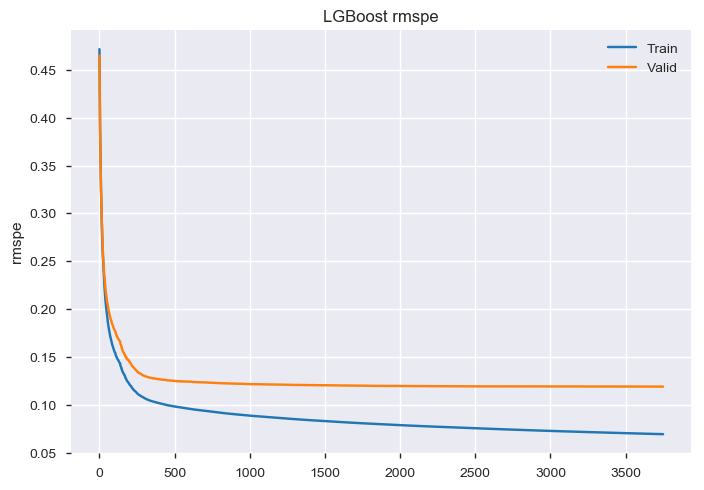

In [97]:
#绘制学习曲线
# retrieve performance metrics
results = clf.evals_result_
epochs = len(results['valid_1']['rmspe'])
x_axis = range(0, epochs)
# plot rmspe
fig, ax = plt.subplots()
ax.plot(x_axis, results['training']['rmspe'], label='Train')
ax.plot(x_axis, results['valid_1']['rmspe'], label='Valid')
ax.legend()
plt.ylabel('rmspe')
plt.title('LGBoost rmspe')
plt.show()

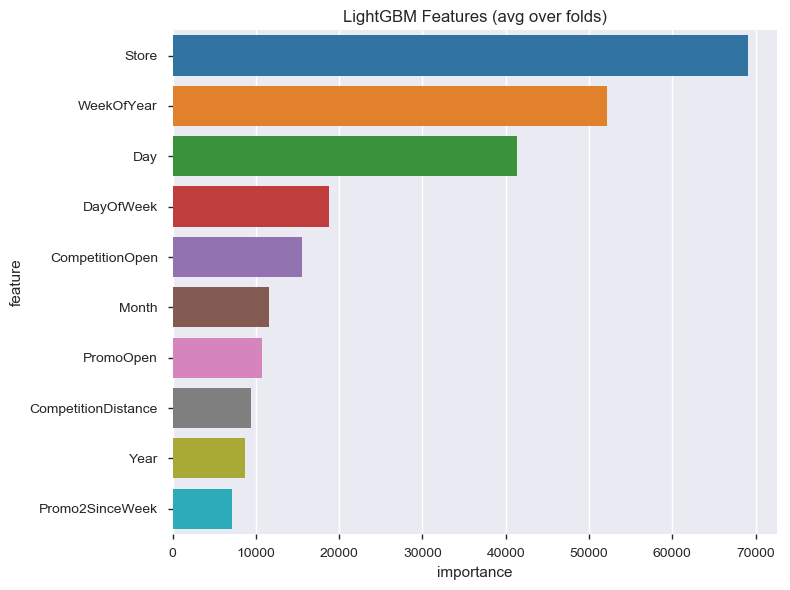

In [98]:
# 绘制特征重要性图

def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:10].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 6))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()

feature_importance_df = pd.DataFrame() 
feature_importance_df["feature"] = list(x_train.columns)
feature_importance_df["importance"] = clf.feature_importances_
display_importances(feature_importance_df)

偏差整体校正
RMSPE for 0.990:0.137137
RMSPE for 0.991:0.133032
RMSPE for 0.992:0.129273
RMSPE for 0.993:0.125907
RMSPE for 0.994:0.122978
RMSPE for 0.995:0.120535
RMSPE for 0.996:0.118622
RMSPE for 0.997:0.117282
RMSPE for 0.998:0.116550
RMSPE for 0.999:0.116455
RMSPE for 1.000:0.117016
RMSPE for 1.001:0.118240
RMSPE for 1.002:0.120124
RMSPE for 1.003:0.122655
RMSPE for 1.004:0.125812
RMSPE for 1.005:0.129565
RMSPE for 1.006:0.133882
RMSPE for 1.007:0.138726
RMSPE for 1.008:0.144060
RMSPE for 1.009:0.149848
偏差整体校正得分为:0.999    0.116455
dtype: float64


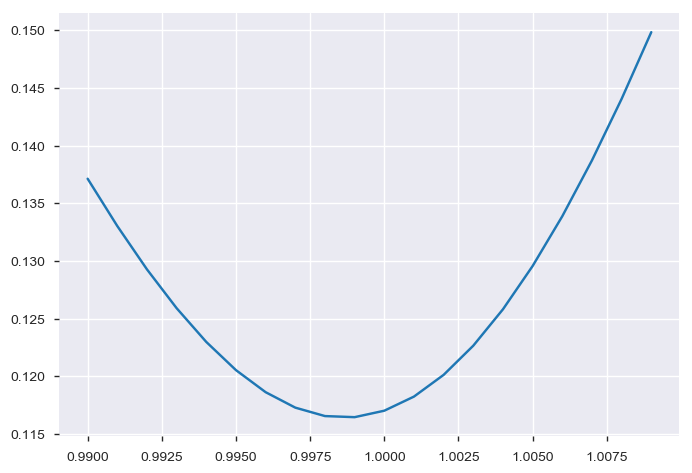

In [99]:
#偏差整体校正优化

print("偏差整体校正")
W=[(0.990+(i/1000)) for i in range(20)]
S =[]
for w in W:
    error = rmspe(np.expm1(y_valid), np.expm1(yhat*w))
    print('RMSPE for {:.3f}:{:.6f}'.format(w,error))
    S.append(error)
Score = pd.Series(S,index=W)
Score.plot()
BS = Score[Score.values == Score.values.min()]
print ('偏差整体校正得分为:{}'.format(BS))

In [100]:
#偏差细节校正优化
res = pd.merge(x_valid, pd.DataFrame(data = y_valid), left_index= True, right_index=True)
res['Prediction'] = yhat
L=range(1115)
W_ho=[]
W_test=[]
for i in L:
    s1 = pd.DataFrame(res[res['Store']==i+1],columns = ['Sales','Prediction'])
    s2 = pd.DataFrame(x_test[x_test['Store']==i+1])
    W1=[(0.990+(i/1000)) for i in range(20)]
    S =[]
    for w in W1:
        error = rmspe(np.expm1(s1.Sales), np.expm1(s1.Prediction*w))
        S.append(error)
    Score = pd.Series(S,index=W1)
    BS = Score[Score.values == Score.values.min()]
    a=np.array(BS.index.values)
    b_ho=a.repeat(len(s1))
    b_test=a.repeat(len(s2))
    W_ho.extend(b_ho.tolist())
    W_test.extend(b_test.tolist())
    
#yhat = clf.predict(x_valid, num_iteration=clf.best_iteration_)     
yhat_new = yhat * W_ho
error = rmspe(np.expm1(y_valid), np.expm1(yhat_new))
print ('偏差细节校正得分为:{:6f}'.format(error))

偏差细节校正得分为:0.107729


In [101]:
#训练融合模型
print("Train an new ensemble LGBoost model")
start = time()
rounds = 10
preds_ho = np.zeros((len(x_valid.index), rounds))
preds_test = np.zeros((len(x_test.index), rounds))
B=[]

for r in range(rounds):
    print('round {}:'.format(r+1))
    
    clf = lgb.LGBMRegressor(
        boosting_type="gbdt",
        num_leaves=85,
        min_child_weight=0.0005,
        min_child_samples=40,
        reg_alpha=0,
        reg_lambda=0,
        max_depth=9,
        n_estimators=8000,
        objective='regression',
        subsample=0.9,            # 在不进行重采样的情况下随机选择部分数据
        colsample_bytree=0.7,     # 每次迭代中随机选择部分特征
        subsample_freq=1,         # bagging 的频率, 0 意味着禁用 bagging. k 意味着每 k 次迭代执行bagging（subsample）
        learning_rate=0.06,
        random_state=49+r
        )
    
    clf.fit(x_train, y_train,eval_set=[(x_train, y_train),(x_valid, y_valid)], eval_metric=rmspe_lg, early_stopping_rounds=500,
            categorical_feature=['Store','DayOfWeek','Promo','StateHoliday','SchoolHoliday','StoreType','Assortment',
                             'CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2','Promo2SinceWeek','Promo2SinceYear',
                             'Year', 'Month','Day','WeekOfYear','IsPromoMonth'])
    
    yhat = clf.predict(x_valid, num_iteration=clf.best_iteration_)
    
    res['Prediction'] = yhat
    L=range(1115)
    W_ho=[]
    W_test=[]
    for i in L:
        s1 = pd.DataFrame(res[res['Store']==i+1],columns = ['Sales','Prediction'])
        s2 = pd.DataFrame(x_test[x_test['Store']==i+1])
        W1=[(0.990+(i/1000)) for i in range(20)]
        S =[]
        for w in W1:
            error = rmspe(np.expm1(s1.Sales), np.expm1(s1.Prediction*w))
            S.append(error)
        Score = pd.Series(S,index=W1)
        BS = Score[Score.values == Score.values.min()]
        a=np.array(BS.index.values)
        b_ho=a.repeat(len(s1))
        b_test=a.repeat(len(s2))
        W_ho.extend(b_ho.tolist())
        W_test.extend(b_test.tolist())
        
    yhat_ho = yhat*W_ho
    yhat_test = clf.predict(x_test, num_iteration=clf.best_iteration_)*W_test
    error = rmspe(np.expm1(y_valid), np.expm1(yhat_ho))
    B.append(error)
    preds_ho[:, r] = yhat_ho
    preds_test[:, r] = yhat_test
    print('round {} end, the error is {}'.format(r+1, error))

end = time()
time_spend = end-start
print('Training is end')
print('Training time is {} h.'.format(time_spend/3600))

Train an new ensemble LGBoost model
round 1:


G:\AIAIAI\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Assortment', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Day', 'DayOfWeek', 'IsPromoMonth', 'Month', 'Promo', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'SchoolHoliday', 'StateHoliday', 'Store', 'StoreType', 'WeekOfYear', 'Year']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
G:\AIAIAI\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Assortment', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Day', 'DayOfWeek', 'IsPromoMonth', 'Month', 'Promo', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'SchoolHoliday', 'StateHoliday', 'Store', 'StoreType', 'WeekOfYear', 'Year']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	training's l2: 0.168248	training's rmspe: 0.471598	valid_1's l2: 0.16047	valid_1's rmspe: 0.464945
Training until validation scores don't improve for 500 rounds.
[2]	training's l2: 0.156739	training's rmspe: 0.448532	valid_1's l2: 0.149198	valid_1's rmspe: 0.442679
[3]	training's l2: 0.147444	training's rmspe: 0.429579	valid_1's l2: 0.139904	valid_1's rmspe: 0.424347
[4]	training's l2: 0.138357	training's rmspe: 0.411621	valid_1's l2: 0.131062	valid_1's rmspe: 0.406837
[5]	training's l2: 0.130005	training's rmspe: 0.395091	valid_1's l2: 0.123011	valid_1's rmspe: 0.390982
[6]	training's l2: 0.124923	training's rmspe: 0.385453	valid_1's l2: 0.118176	valid_1's rmspe: 0.382372
[7]	training's l2: 0.118553	training's rmspe: 0.372723	valid_1's l2: 0.111668	valid_1's rmspe: 0.369286
[8]	training's l2: 0.112004	training's rmspe: 0.359874	valid_1's l2: 0.105307	valid_1's rmspe: 0.356851
[9]	training's l2: 0.106179	training's rmspe: 0.34838	valid_1's l2: 0.0997041	valid_1's rmspe: 0.345477
[1

[77]	training's l2: 0.0267719	training's rmspe: 0.168927	valid_1's l2: 0.0296147	valid_1's rmspe: 0.189298
[78]	training's l2: 0.0265716	training's rmspe: 0.168285	valid_1's l2: 0.0295225	valid_1's rmspe: 0.188943
[79]	training's l2: 0.0263431	training's rmspe: 0.167626	valid_1's l2: 0.0293568	valid_1's rmspe: 0.188445
[80]	training's l2: 0.0260792	training's rmspe: 0.166837	valid_1's l2: 0.0291391	valid_1's rmspe: 0.187766
[81]	training's l2: 0.025811	training's rmspe: 0.165968	valid_1's l2: 0.0288857	valid_1's rmspe: 0.18693
[82]	training's l2: 0.0256516	training's rmspe: 0.165491	valid_1's l2: 0.0287257	valid_1's rmspe: 0.186387
[83]	training's l2: 0.0254267	training's rmspe: 0.164761	valid_1's l2: 0.0285222	valid_1's rmspe: 0.185678
[84]	training's l2: 0.0251614	training's rmspe: 0.163902	valid_1's l2: 0.0282953	valid_1's rmspe: 0.184868
[85]	training's l2: 0.0250375	training's rmspe: 0.163542	valid_1's l2: 0.0281858	valid_1's rmspe: 0.184568
[86]	training's l2: 0.0248461	training'

[153]	training's l2: 0.017404	training's rmspe: 0.135378	valid_1's l2: 0.0212842	valid_1's rmspe: 0.157483
[154]	training's l2: 0.0173277	training's rmspe: 0.135137	valid_1's l2: 0.0212198	valid_1's rmspe: 0.157276
[155]	training's l2: 0.0172408	training's rmspe: 0.134793	valid_1's l2: 0.0211175	valid_1's rmspe: 0.156863
[156]	training's l2: 0.0171734	training's rmspe: 0.134548	valid_1's l2: 0.0210091	valid_1's rmspe: 0.156422
[157]	training's l2: 0.0171182	training's rmspe: 0.134165	valid_1's l2: 0.0209462	valid_1's rmspe: 0.15592
[158]	training's l2: 0.0169189	training's rmspe: 0.133456	valid_1's l2: 0.020768	valid_1's rmspe: 0.155348
[159]	training's l2: 0.0168786	training's rmspe: 0.133289	valid_1's l2: 0.0207303	valid_1's rmspe: 0.155192
[160]	training's l2: 0.0168216	training's rmspe: 0.13309	valid_1's l2: 0.0206965	valid_1's rmspe: 0.155014
[161]	training's l2: 0.0166913	training's rmspe: 0.132638	valid_1's l2: 0.0205767	valid_1's rmspe: 0.154652
[162]	training's l2: 0.0166509	t

[229]	training's l2: 0.0128619	training's rmspe: 0.1155	valid_1's l2: 0.0169703	valid_1's rmspe: 0.138788
[230]	training's l2: 0.0128468	training's rmspe: 0.115434	valid_1's l2: 0.0169594	valid_1's rmspe: 0.13872
[231]	training's l2: 0.0128079	training's rmspe: 0.115216	valid_1's l2: 0.016907	valid_1's rmspe: 0.138425
[232]	training's l2: 0.0127879	training's rmspe: 0.115126	valid_1's l2: 0.0168847	valid_1's rmspe: 0.138315
[233]	training's l2: 0.0127525	training's rmspe: 0.114938	valid_1's l2: 0.0168211	valid_1's rmspe: 0.137966
[234]	training's l2: 0.01272	training's rmspe: 0.114802	valid_1's l2: 0.0167954	valid_1's rmspe: 0.137895
[235]	training's l2: 0.0126737	training's rmspe: 0.114592	valid_1's l2: 0.0167515	valid_1's rmspe: 0.137703
[236]	training's l2: 0.0126351	training's rmspe: 0.114426	valid_1's l2: 0.0167143	valid_1's rmspe: 0.137556
[237]	training's l2: 0.012617	training's rmspe: 0.114344	valid_1's l2: 0.0166797	valid_1's rmspe: 0.137407
[238]	training's l2: 0.0125925	trai

[305]	training's l2: 0.0110367	training's rmspe: 0.106581	valid_1's l2: 0.0150806	valid_1's rmspe: 0.129847
[306]	training's l2: 0.0110298	training's rmspe: 0.106545	valid_1's l2: 0.0150744	valid_1's rmspe: 0.129817
[307]	training's l2: 0.0110175	training's rmspe: 0.106485	valid_1's l2: 0.0150658	valid_1's rmspe: 0.129762
[308]	training's l2: 0.0110053	training's rmspe: 0.106429	valid_1's l2: 0.0150563	valid_1's rmspe: 0.129749
[309]	training's l2: 0.0109836	training's rmspe: 0.106307	valid_1's l2: 0.0150393	valid_1's rmspe: 0.129674
[310]	training's l2: 0.0109671	training's rmspe: 0.106188	valid_1's l2: 0.0150242	valid_1's rmspe: 0.129599
[311]	training's l2: 0.0109581	training's rmspe: 0.106143	valid_1's l2: 0.0150167	valid_1's rmspe: 0.129577
[312]	training's l2: 0.0109443	training's rmspe: 0.10605	valid_1's l2: 0.0150028	valid_1's rmspe: 0.1295
[313]	training's l2: 0.0109282	training's rmspe: 0.105982	valid_1's l2: 0.0149785	valid_1's rmspe: 0.129364
[314]	training's l2: 0.0109183	

[381]	training's l2: 0.0102593	training's rmspe: 0.102394	valid_1's l2: 0.0145154	valid_1's rmspe: 0.127146
[382]	training's l2: 0.0102525	training's rmspe: 0.102356	valid_1's l2: 0.0145112	valid_1's rmspe: 0.12712
[383]	training's l2: 0.010246	training's rmspe: 0.102323	valid_1's l2: 0.0145075	valid_1's rmspe: 0.127108
[384]	training's l2: 0.0102419	training's rmspe: 0.102297	valid_1's l2: 0.014505	valid_1's rmspe: 0.127101
[385]	training's l2: 0.0102349	training's rmspe: 0.102262	valid_1's l2: 0.0144999	valid_1's rmspe: 0.127086
[386]	training's l2: 0.0102273	training's rmspe: 0.102223	valid_1's l2: 0.0144923	valid_1's rmspe: 0.127047
[387]	training's l2: 0.0102195	training's rmspe: 0.102164	valid_1's l2: 0.0144807	valid_1's rmspe: 0.12696
[388]	training's l2: 0.010213	training's rmspe: 0.102134	valid_1's l2: 0.0144775	valid_1's rmspe: 0.126946
[389]	training's l2: 0.0102087	training's rmspe: 0.102113	valid_1's l2: 0.0144759	valid_1's rmspe: 0.126941
[390]	training's l2: 0.0101996	tr

[456]	training's l2: 0.00973954	training's rmspe: 0.0995277	valid_1's l2: 0.0141522	valid_1's rmspe: 0.125528
[457]	training's l2: 0.0097344	training's rmspe: 0.0995026	valid_1's l2: 0.0141508	valid_1's rmspe: 0.125523
[458]	training's l2: 0.00973089	training's rmspe: 0.0994783	valid_1's l2: 0.0141479	valid_1's rmspe: 0.12551
[459]	training's l2: 0.00972586	training's rmspe: 0.0994537	valid_1's l2: 0.0141463	valid_1's rmspe: 0.1255
[460]	training's l2: 0.00972033	training's rmspe: 0.0994168	valid_1's l2: 0.0141417	valid_1's rmspe: 0.125477
[461]	training's l2: 0.00971669	training's rmspe: 0.0993983	valid_1's l2: 0.0141396	valid_1's rmspe: 0.12547
[462]	training's l2: 0.00971108	training's rmspe: 0.0993578	valid_1's l2: 0.0141359	valid_1's rmspe: 0.125455
[463]	training's l2: 0.00970376	training's rmspe: 0.0993184	valid_1's l2: 0.0141295	valid_1's rmspe: 0.125424
[464]	training's l2: 0.00969545	training's rmspe: 0.0992841	valid_1's l2: 0.0141468	valid_1's rmspe: 0.125504
[465]	training'

[530]	training's l2: 0.00938708	training's rmspe: 0.0975385	valid_1's l2: 0.0139565	valid_1's rmspe: 0.124608
[531]	training's l2: 0.00938402	training's rmspe: 0.0975113	valid_1's l2: 0.0139557	valid_1's rmspe: 0.124601
[532]	training's l2: 0.0093801	training's rmspe: 0.0974883	valid_1's l2: 0.013954	valid_1's rmspe: 0.124595
[533]	training's l2: 0.00937664	training's rmspe: 0.0974714	valid_1's l2: 0.0139528	valid_1's rmspe: 0.124588
[534]	training's l2: 0.00937104	training's rmspe: 0.0974395	valid_1's l2: 0.0139522	valid_1's rmspe: 0.124585
[535]	training's l2: 0.00936762	training's rmspe: 0.0974231	valid_1's l2: 0.0139531	valid_1's rmspe: 0.124588
[536]	training's l2: 0.00936413	training's rmspe: 0.0974054	valid_1's l2: 0.0139496	valid_1's rmspe: 0.12457
[537]	training's l2: 0.0093575	training's rmspe: 0.0973713	valid_1's l2: 0.0139481	valid_1's rmspe: 0.124557
[538]	training's l2: 0.00934779	training's rmspe: 0.0973394	valid_1's l2: 0.0139481	valid_1's rmspe: 0.124557
[539]	training

[604]	training's l2: 0.0090642	training's rmspe: 0.0957038	valid_1's l2: 0.0138494	valid_1's rmspe: 0.124173
[605]	training's l2: 0.0090599	training's rmspe: 0.0956788	valid_1's l2: 0.0138473	valid_1's rmspe: 0.124161
[606]	training's l2: 0.00905644	training's rmspe: 0.0956577	valid_1's l2: 0.0138469	valid_1's rmspe: 0.124155
[607]	training's l2: 0.00905278	training's rmspe: 0.0956335	valid_1's l2: 0.0138457	valid_1's rmspe: 0.124152
[608]	training's l2: 0.00904973	training's rmspe: 0.095615	valid_1's l2: 0.0138452	valid_1's rmspe: 0.12415
[609]	training's l2: 0.00904566	training's rmspe: 0.0955911	valid_1's l2: 0.0138419	valid_1's rmspe: 0.124132
[610]	training's l2: 0.00904284	training's rmspe: 0.0955727	valid_1's l2: 0.01384	valid_1's rmspe: 0.124125
[611]	training's l2: 0.00903404	training's rmspe: 0.0955276	valid_1's l2: 0.0138366	valid_1's rmspe: 0.124098
[612]	training's l2: 0.00903035	training's rmspe: 0.09551	valid_1's l2: 0.0138365	valid_1's rmspe: 0.124099
[613]	training's l

[678]	training's l2: 0.00880015	training's rmspe: 0.0941486	valid_1's l2: 0.0136983	valid_1's rmspe: 0.12347
[679]	training's l2: 0.00879717	training's rmspe: 0.0941337	valid_1's l2: 0.0136944	valid_1's rmspe: 0.123459
[680]	training's l2: 0.00879441	training's rmspe: 0.0941193	valid_1's l2: 0.0136939	valid_1's rmspe: 0.123454
[681]	training's l2: 0.00879138	training's rmspe: 0.0940973	valid_1's l2: 0.0136923	valid_1's rmspe: 0.123431
[682]	training's l2: 0.00878851	training's rmspe: 0.0940817	valid_1's l2: 0.0136915	valid_1's rmspe: 0.123425
[683]	training's l2: 0.00878501	training's rmspe: 0.0940639	valid_1's l2: 0.0136934	valid_1's rmspe: 0.123439
[684]	training's l2: 0.00878204	training's rmspe: 0.0940493	valid_1's l2: 0.0136947	valid_1's rmspe: 0.123462
[685]	training's l2: 0.00877665	training's rmspe: 0.0940247	valid_1's l2: 0.0137069	valid_1's rmspe: 0.123499
[686]	training's l2: 0.0087722	training's rmspe: 0.0940007	valid_1's l2: 0.0137122	valid_1's rmspe: 0.123516
[687]	traini

[752]	training's l2: 0.0085579	training's rmspe: 0.0927562	valid_1's l2: 0.0136013	valid_1's rmspe: 0.123011
[753]	training's l2: 0.0085548	training's rmspe: 0.0927334	valid_1's l2: 0.0136005	valid_1's rmspe: 0.123009
[754]	training's l2: 0.0085525	training's rmspe: 0.0927199	valid_1's l2: 0.0135998	valid_1's rmspe: 0.123006
[755]	training's l2: 0.00854903	training's rmspe: 0.0927019	valid_1's l2: 0.0135987	valid_1's rmspe: 0.123
[756]	training's l2: 0.00854638	training's rmspe: 0.0926816	valid_1's l2: 0.0135973	valid_1's rmspe: 0.12299
[757]	training's l2: 0.0085434	training's rmspe: 0.0926666	valid_1's l2: 0.0135954	valid_1's rmspe: 0.12298
[758]	training's l2: 0.00853931	training's rmspe: 0.092643	valid_1's l2: 0.0135907	valid_1's rmspe: 0.122956
[759]	training's l2: 0.00853627	training's rmspe: 0.0926239	valid_1's l2: 0.0135901	valid_1's rmspe: 0.122946
[760]	training's l2: 0.00853364	training's rmspe: 0.0926089	valid_1's l2: 0.0135886	valid_1's rmspe: 0.122939
[761]	training's l2:

[826]	training's l2: 0.00831816	training's rmspe: 0.091363	valid_1's l2: 0.0134982	valid_1's rmspe: 0.122509
[827]	training's l2: 0.0083158	training's rmspe: 0.0913509	valid_1's l2: 0.0134964	valid_1's rmspe: 0.122507
[828]	training's l2: 0.00831366	training's rmspe: 0.0913389	valid_1's l2: 0.0134952	valid_1's rmspe: 0.122496
[829]	training's l2: 0.00831119	training's rmspe: 0.0913191	valid_1's l2: 0.0134951	valid_1's rmspe: 0.122496
[830]	training's l2: 0.00830802	training's rmspe: 0.091302	valid_1's l2: 0.0134896	valid_1's rmspe: 0.122476
[831]	training's l2: 0.00830533	training's rmspe: 0.0912835	valid_1's l2: 0.0134861	valid_1's rmspe: 0.122462
[832]	training's l2: 0.00830311	training's rmspe: 0.0912672	valid_1's l2: 0.0134859	valid_1's rmspe: 0.122463
[833]	training's l2: 0.00830023	training's rmspe: 0.0912496	valid_1's l2: 0.0134863	valid_1's rmspe: 0.122465
[834]	training's l2: 0.00829819	training's rmspe: 0.0912382	valid_1's l2: 0.0134864	valid_1's rmspe: 0.122471
[835]	trainin

[900]	training's l2: 0.00812496	training's rmspe: 0.0901718	valid_1's l2: 0.0134334	valid_1's rmspe: 0.122165
[901]	training's l2: 0.00812241	training's rmspe: 0.0901562	valid_1's l2: 0.0134316	valid_1's rmspe: 0.122157
[902]	training's l2: 0.00811916	training's rmspe: 0.0901383	valid_1's l2: 0.0134334	valid_1's rmspe: 0.122166
[903]	training's l2: 0.00811758	training's rmspe: 0.0901301	valid_1's l2: 0.0134336	valid_1's rmspe: 0.122162
[904]	training's l2: 0.00811391	training's rmspe: 0.0901101	valid_1's l2: 0.0134299	valid_1's rmspe: 0.122148
[905]	training's l2: 0.00811132	training's rmspe: 0.0900947	valid_1's l2: 0.013429	valid_1's rmspe: 0.122144
[906]	training's l2: 0.00810938	training's rmspe: 0.0900801	valid_1's l2: 0.0134281	valid_1's rmspe: 0.122142
[907]	training's l2: 0.00810687	training's rmspe: 0.0900594	valid_1's l2: 0.0134274	valid_1's rmspe: 0.122133
[908]	training's l2: 0.008105	training's rmspe: 0.090049	valid_1's l2: 0.0134371	valid_1's rmspe: 0.122206
[909]	training

[974]	training's l2: 0.00794124	training's rmspe: 0.0890761	valid_1's l2: 0.0133655	valid_1's rmspe: 0.121874
[975]	training's l2: 0.00793906	training's rmspe: 0.0890627	valid_1's l2: 0.013365	valid_1's rmspe: 0.121871
[976]	training's l2: 0.00793669	training's rmspe: 0.0890482	valid_1's l2: 0.0133648	valid_1's rmspe: 0.12187
[977]	training's l2: 0.00793465	training's rmspe: 0.089036	valid_1's l2: 0.0133642	valid_1's rmspe: 0.121868
[978]	training's l2: 0.00793184	training's rmspe: 0.0890214	valid_1's l2: 0.0133614	valid_1's rmspe: 0.121853
[979]	training's l2: 0.00792995	training's rmspe: 0.0890078	valid_1's l2: 0.0133594	valid_1's rmspe: 0.121835
[980]	training's l2: 0.00792788	training's rmspe: 0.0889975	valid_1's l2: 0.0133602	valid_1's rmspe: 0.12184
[981]	training's l2: 0.00792599	training's rmspe: 0.0889824	valid_1's l2: 0.0133593	valid_1's rmspe: 0.121836
[982]	training's l2: 0.00792389	training's rmspe: 0.0889705	valid_1's l2: 0.013359	valid_1's rmspe: 0.121835
[983]	training'

[1048]	training's l2: 0.00776868	training's rmspe: 0.0880221	valid_1's l2: 0.0132788	valid_1's rmspe: 0.121467
[1049]	training's l2: 0.00776589	training's rmspe: 0.0880059	valid_1's l2: 0.0132779	valid_1's rmspe: 0.121465
[1050]	training's l2: 0.00776387	training's rmspe: 0.087995	valid_1's l2: 0.0132782	valid_1's rmspe: 0.121467
[1051]	training's l2: 0.00776062	training's rmspe: 0.0879761	valid_1's l2: 0.0132815	valid_1's rmspe: 0.121474
[1052]	training's l2: 0.00775801	training's rmspe: 0.0879619	valid_1's l2: 0.0132813	valid_1's rmspe: 0.121475
[1053]	training's l2: 0.00775666	training's rmspe: 0.0879539	valid_1's l2: 0.0132809	valid_1's rmspe: 0.121475
[1054]	training's l2: 0.0077548	training's rmspe: 0.0879436	valid_1's l2: 0.0132804	valid_1's rmspe: 0.121473
[1055]	training's l2: 0.00775284	training's rmspe: 0.0879303	valid_1's l2: 0.0132809	valid_1's rmspe: 0.121476
[1056]	training's l2: 0.00775054	training's rmspe: 0.0879135	valid_1's l2: 0.0132803	valid_1's rmspe: 0.121476
[10

[1122]	training's l2: 0.00761274	training's rmspe: 0.0870594	valid_1's l2: 0.0132452	valid_1's rmspe: 0.121349
[1123]	training's l2: 0.00761128	training's rmspe: 0.0870502	valid_1's l2: 0.0132447	valid_1's rmspe: 0.12135
[1124]	training's l2: 0.00760932	training's rmspe: 0.0870408	valid_1's l2: 0.0132448	valid_1's rmspe: 0.121361
[1125]	training's l2: 0.00760774	training's rmspe: 0.0870308	valid_1's l2: 0.013244	valid_1's rmspe: 0.121355
[1126]	training's l2: 0.00760512	training's rmspe: 0.0870163	valid_1's l2: 0.0132427	valid_1's rmspe: 0.121348
[1127]	training's l2: 0.0076033	training's rmspe: 0.0870053	valid_1's l2: 0.0132419	valid_1's rmspe: 0.121346
[1128]	training's l2: 0.00760125	training's rmspe: 0.086992	valid_1's l2: 0.0132405	valid_1's rmspe: 0.121339
[1129]	training's l2: 0.00759859	training's rmspe: 0.086976	valid_1's l2: 0.0132392	valid_1's rmspe: 0.121343
[1130]	training's l2: 0.00759684	training's rmspe: 0.0869652	valid_1's l2: 0.0132391	valid_1's rmspe: 0.121342
[1131]

[1196]	training's l2: 0.00746754	training's rmspe: 0.0861929	valid_1's l2: 0.0132023	valid_1's rmspe: 0.12116
[1197]	training's l2: 0.00746622	training's rmspe: 0.0861856	valid_1's l2: 0.0132013	valid_1's rmspe: 0.121156
[1198]	training's l2: 0.00746474	training's rmspe: 0.0861763	valid_1's l2: 0.0132031	valid_1's rmspe: 0.121165
[1199]	training's l2: 0.00746253	training's rmspe: 0.0861624	valid_1's l2: 0.0132037	valid_1's rmspe: 0.121169
[1200]	training's l2: 0.00746071	training's rmspe: 0.0861511	valid_1's l2: 0.013204	valid_1's rmspe: 0.121171
[1201]	training's l2: 0.00745893	training's rmspe: 0.0861421	valid_1's l2: 0.0132061	valid_1's rmspe: 0.121179
[1202]	training's l2: 0.00745714	training's rmspe: 0.0861309	valid_1's l2: 0.0132046	valid_1's rmspe: 0.121172
[1203]	training's l2: 0.00745538	training's rmspe: 0.0861188	valid_1's l2: 0.0132031	valid_1's rmspe: 0.121164
[1204]	training's l2: 0.00745388	training's rmspe: 0.0861103	valid_1's l2: 0.0131999	valid_1's rmspe: 0.121136
[12

[1270]	training's l2: 0.00733306	training's rmspe: 0.0853922	valid_1's l2: 0.0131449	valid_1's rmspe: 0.120872
[1271]	training's l2: 0.00733058	training's rmspe: 0.0853774	valid_1's l2: 0.0131418	valid_1's rmspe: 0.120858
[1272]	training's l2: 0.00732878	training's rmspe: 0.0853674	valid_1's l2: 0.0131404	valid_1's rmspe: 0.120854
[1273]	training's l2: 0.00732626	training's rmspe: 0.0853502	valid_1's l2: 0.0131373	valid_1's rmspe: 0.12084
[1274]	training's l2: 0.00732483	training's rmspe: 0.0853408	valid_1's l2: 0.0131378	valid_1's rmspe: 0.120839
[1275]	training's l2: 0.00732329	training's rmspe: 0.0853274	valid_1's l2: 0.0131375	valid_1's rmspe: 0.120839
[1276]	training's l2: 0.00732202	training's rmspe: 0.0853184	valid_1's l2: 0.0131384	valid_1's rmspe: 0.120844
[1277]	training's l2: 0.00731955	training's rmspe: 0.0853	valid_1's l2: 0.0131382	valid_1's rmspe: 0.120844
[1278]	training's l2: 0.00731791	training's rmspe: 0.0852898	valid_1's l2: 0.0131374	valid_1's rmspe: 0.120839
[1279

[1344]	training's l2: 0.00719915	training's rmspe: 0.0845571	valid_1's l2: 0.0131033	valid_1's rmspe: 0.12072
[1345]	training's l2: 0.00719747	training's rmspe: 0.0845473	valid_1's l2: 0.0131025	valid_1's rmspe: 0.120717
[1346]	training's l2: 0.0071962	training's rmspe: 0.0845398	valid_1's l2: 0.013102	valid_1's rmspe: 0.120714
[1347]	training's l2: 0.00719417	training's rmspe: 0.0845261	valid_1's l2: 0.0131017	valid_1's rmspe: 0.120714
[1348]	training's l2: 0.00719268	training's rmspe: 0.0845162	valid_1's l2: 0.0131016	valid_1's rmspe: 0.120712
[1349]	training's l2: 0.00719065	training's rmspe: 0.0845025	valid_1's l2: 0.0131024	valid_1's rmspe: 0.120717
[1350]	training's l2: 0.00718879	training's rmspe: 0.0844905	valid_1's l2: 0.0131017	valid_1's rmspe: 0.120715
[1351]	training's l2: 0.00718744	training's rmspe: 0.0844832	valid_1's l2: 0.0131019	valid_1's rmspe: 0.120713
[1352]	training's l2: 0.00718549	training's rmspe: 0.0844707	valid_1's l2: 0.0131006	valid_1's rmspe: 0.120708
[135

[1418]	training's l2: 0.00707331	training's rmspe: 0.0837941	valid_1's l2: 0.0130727	valid_1's rmspe: 0.120597
[1419]	training's l2: 0.00707193	training's rmspe: 0.0837844	valid_1's l2: 0.0130728	valid_1's rmspe: 0.120597
[1420]	training's l2: 0.00707038	training's rmspe: 0.0837743	valid_1's l2: 0.0130703	valid_1's rmspe: 0.120585
[1421]	training's l2: 0.00706763	training's rmspe: 0.0837561	valid_1's l2: 0.0130699	valid_1's rmspe: 0.120585
[1422]	training's l2: 0.0070658	training's rmspe: 0.0837428	valid_1's l2: 0.0130695	valid_1's rmspe: 0.120585
[1423]	training's l2: 0.00706414	training's rmspe: 0.0837336	valid_1's l2: 0.0130681	valid_1's rmspe: 0.120577
[1424]	training's l2: 0.00706232	training's rmspe: 0.0837254	valid_1's l2: 0.0130684	valid_1's rmspe: 0.120578
[1425]	training's l2: 0.00706077	training's rmspe: 0.0837157	valid_1's l2: 0.0130681	valid_1's rmspe: 0.120578
[1426]	training's l2: 0.00705925	training's rmspe: 0.083707	valid_1's l2: 0.0130683	valid_1's rmspe: 0.120578
[14

[1492]	training's l2: 0.00695118	training's rmspe: 0.0830235	valid_1's l2: 0.0130331	valid_1's rmspe: 0.120429
[1493]	training's l2: 0.00694958	training's rmspe: 0.0830138	valid_1's l2: 0.0130336	valid_1's rmspe: 0.120429
[1494]	training's l2: 0.00694769	training's rmspe: 0.0830022	valid_1's l2: 0.0130321	valid_1's rmspe: 0.12042
[1495]	training's l2: 0.00694614	training's rmspe: 0.0829932	valid_1's l2: 0.013035	valid_1's rmspe: 0.120435
[1496]	training's l2: 0.00694421	training's rmspe: 0.0829853	valid_1's l2: 0.0130353	valid_1's rmspe: 0.120437
[1497]	training's l2: 0.00694283	training's rmspe: 0.0829786	valid_1's l2: 0.0130341	valid_1's rmspe: 0.120439
[1498]	training's l2: 0.00694101	training's rmspe: 0.0829675	valid_1's l2: 0.0130345	valid_1's rmspe: 0.120442
[1499]	training's l2: 0.00693977	training's rmspe: 0.0829581	valid_1's l2: 0.0130336	valid_1's rmspe: 0.120438
[1500]	training's l2: 0.00693781	training's rmspe: 0.0829426	valid_1's l2: 0.0130338	valid_1's rmspe: 0.120438
[15

[1566]	training's l2: 0.00684153	training's rmspe: 0.082345	valid_1's l2: 0.0130074	valid_1's rmspe: 0.120317
[1567]	training's l2: 0.00684014	training's rmspe: 0.0823364	valid_1's l2: 0.0130072	valid_1's rmspe: 0.120313
[1568]	training's l2: 0.00683905	training's rmspe: 0.0823299	valid_1's l2: 0.0130053	valid_1's rmspe: 0.120304
[1569]	training's l2: 0.00683742	training's rmspe: 0.0823195	valid_1's l2: 0.0130044	valid_1's rmspe: 0.1203
[1570]	training's l2: 0.00683527	training's rmspe: 0.0823073	valid_1's l2: 0.0130044	valid_1's rmspe: 0.120299
[1571]	training's l2: 0.00683412	training's rmspe: 0.0823004	valid_1's l2: 0.0130043	valid_1's rmspe: 0.120297
[1572]	training's l2: 0.00683228	training's rmspe: 0.0822921	valid_1's l2: 0.0130055	valid_1's rmspe: 0.120305
[1573]	training's l2: 0.00683066	training's rmspe: 0.082283	valid_1's l2: 0.0130048	valid_1's rmspe: 0.120301
[1574]	training's l2: 0.00682935	training's rmspe: 0.0822762	valid_1's l2: 0.0130041	valid_1's rmspe: 0.120298
[1575

[1640]	training's l2: 0.00673281	training's rmspe: 0.081665	valid_1's l2: 0.012982	valid_1's rmspe: 0.120169
[1641]	training's l2: 0.00673154	training's rmspe: 0.0816563	valid_1's l2: 0.0129817	valid_1's rmspe: 0.120164
[1642]	training's l2: 0.00673037	training's rmspe: 0.0816471	valid_1's l2: 0.0129816	valid_1's rmspe: 0.120162
[1643]	training's l2: 0.00672875	training's rmspe: 0.0816362	valid_1's l2: 0.0129817	valid_1's rmspe: 0.120162
[1644]	training's l2: 0.00672753	training's rmspe: 0.0816292	valid_1's l2: 0.0129818	valid_1's rmspe: 0.120166
[1645]	training's l2: 0.00672605	training's rmspe: 0.0816165	valid_1's l2: 0.0129809	valid_1's rmspe: 0.120165
[1646]	training's l2: 0.00672474	training's rmspe: 0.0816077	valid_1's l2: 0.0129811	valid_1's rmspe: 0.120164
[1647]	training's l2: 0.00672304	training's rmspe: 0.0815964	valid_1's l2: 0.0129799	valid_1's rmspe: 0.120154
[1648]	training's l2: 0.00672177	training's rmspe: 0.0815877	valid_1's l2: 0.0129791	valid_1's rmspe: 0.12015
[164

[1714]	training's l2: 0.00663483	training's rmspe: 0.0810212	valid_1's l2: 0.012957	valid_1's rmspe: 0.120035
[1715]	training's l2: 0.00663327	training's rmspe: 0.0810113	valid_1's l2: 0.0129577	valid_1's rmspe: 0.12004
[1716]	training's l2: 0.00663191	training's rmspe: 0.0810035	valid_1's l2: 0.0129571	valid_1's rmspe: 0.120037
[1717]	training's l2: 0.00663048	training's rmspe: 0.0809953	valid_1's l2: 0.0129566	valid_1's rmspe: 0.120033
[1718]	training's l2: 0.00662923	training's rmspe: 0.080986	valid_1's l2: 0.0129568	valid_1's rmspe: 0.120032
[1719]	training's l2: 0.00662821	training's rmspe: 0.0809793	valid_1's l2: 0.0129557	valid_1's rmspe: 0.120028
[1720]	training's l2: 0.00662679	training's rmspe: 0.0809701	valid_1's l2: 0.0129563	valid_1's rmspe: 0.12003
[1721]	training's l2: 0.00662585	training's rmspe: 0.0809639	valid_1's l2: 0.0129554	valid_1's rmspe: 0.120025
[1722]	training's l2: 0.00662398	training's rmspe: 0.0809521	valid_1's l2: 0.0129532	valid_1's rmspe: 0.120015
[1723

[1788]	training's l2: 0.00653695	training's rmspe: 0.0804085	valid_1's l2: 0.0129319	valid_1's rmspe: 0.119868
[1789]	training's l2: 0.00653608	training's rmspe: 0.0804026	valid_1's l2: 0.0129317	valid_1's rmspe: 0.119868
[1790]	training's l2: 0.00653427	training's rmspe: 0.0803926	valid_1's l2: 0.0129307	valid_1's rmspe: 0.119864
[1791]	training's l2: 0.00653309	training's rmspe: 0.0803848	valid_1's l2: 0.0129305	valid_1's rmspe: 0.119865
[1792]	training's l2: 0.006532	training's rmspe: 0.0803779	valid_1's l2: 0.0129302	valid_1's rmspe: 0.119864
[1793]	training's l2: 0.00653096	training's rmspe: 0.080372	valid_1's l2: 0.0129292	valid_1's rmspe: 0.119862
[1794]	training's l2: 0.0065296	training's rmspe: 0.0803636	valid_1's l2: 0.0129287	valid_1's rmspe: 0.119859
[1795]	training's l2: 0.0065284	training's rmspe: 0.080356	valid_1's l2: 0.0129287	valid_1's rmspe: 0.119859
[1796]	training's l2: 0.00652697	training's rmspe: 0.0803463	valid_1's l2: 0.0129288	valid_1's rmspe: 0.119864
[1797]	

[1862]	training's l2: 0.00644204	training's rmspe: 0.0798143	valid_1's l2: 0.0129131	valid_1's rmspe: 0.119807
[1863]	training's l2: 0.0064406	training's rmspe: 0.0798047	valid_1's l2: 0.0129129	valid_1's rmspe: 0.119807
[1864]	training's l2: 0.00643912	training's rmspe: 0.0797952	valid_1's l2: 0.0129133	valid_1's rmspe: 0.11981
[1865]	training's l2: 0.00643837	training's rmspe: 0.0797907	valid_1's l2: 0.0129129	valid_1's rmspe: 0.11981
[1866]	training's l2: 0.00643708	training's rmspe: 0.0797819	valid_1's l2: 0.0129136	valid_1's rmspe: 0.119811
[1867]	training's l2: 0.00643573	training's rmspe: 0.0797729	valid_1's l2: 0.0129144	valid_1's rmspe: 0.119816
[1868]	training's l2: 0.0064343	training's rmspe: 0.0797636	valid_1's l2: 0.0129171	valid_1's rmspe: 0.119829
[1869]	training's l2: 0.0064333	training's rmspe: 0.0797555	valid_1's l2: 0.0129172	valid_1's rmspe: 0.119828
[1870]	training's l2: 0.00643223	training's rmspe: 0.0797489	valid_1's l2: 0.0129177	valid_1's rmspe: 0.119831
[1871]

[1936]	training's l2: 0.00635019	training's rmspe: 0.0792232	valid_1's l2: 0.0128937	valid_1's rmspe: 0.119716
[1937]	training's l2: 0.00634854	training's rmspe: 0.0792138	valid_1's l2: 0.0128918	valid_1's rmspe: 0.119707
[1938]	training's l2: 0.00634737	training's rmspe: 0.0792067	valid_1's l2: 0.0128911	valid_1's rmspe: 0.119704
[1939]	training's l2: 0.00634615	training's rmspe: 0.0791989	valid_1's l2: 0.0128896	valid_1's rmspe: 0.119697
[1940]	training's l2: 0.0063451	training's rmspe: 0.079191	valid_1's l2: 0.0128898	valid_1's rmspe: 0.1197
[1941]	training's l2: 0.00634365	training's rmspe: 0.0791836	valid_1's l2: 0.0128902	valid_1's rmspe: 0.119701
[1942]	training's l2: 0.0063425	training's rmspe: 0.0791766	valid_1's l2: 0.0128905	valid_1's rmspe: 0.119702
[1943]	training's l2: 0.00634148	training's rmspe: 0.0791697	valid_1's l2: 0.0128909	valid_1's rmspe: 0.119704
[1944]	training's l2: 0.00634064	training's rmspe: 0.0791642	valid_1's l2: 0.0128887	valid_1's rmspe: 0.119693
[1945]

[2010]	training's l2: 0.00626511	training's rmspe: 0.0786838	valid_1's l2: 0.0128711	valid_1's rmspe: 0.119622
[2011]	training's l2: 0.00626375	training's rmspe: 0.0786774	valid_1's l2: 0.0128703	valid_1's rmspe: 0.119619
[2012]	training's l2: 0.0062626	training's rmspe: 0.0786689	valid_1's l2: 0.0128705	valid_1's rmspe: 0.119621
[2013]	training's l2: 0.00626143	training's rmspe: 0.0786613	valid_1's l2: 0.0128703	valid_1's rmspe: 0.119619
[2014]	training's l2: 0.00626018	training's rmspe: 0.0786535	valid_1's l2: 0.0128697	valid_1's rmspe: 0.119618
[2015]	training's l2: 0.00625921	training's rmspe: 0.0786484	valid_1's l2: 0.0128696	valid_1's rmspe: 0.119616
[2016]	training's l2: 0.00625777	training's rmspe: 0.078638	valid_1's l2: 0.0128665	valid_1's rmspe: 0.119599
[2017]	training's l2: 0.00625663	training's rmspe: 0.0786311	valid_1's l2: 0.012866	valid_1's rmspe: 0.119596
[2018]	training's l2: 0.00625584	training's rmspe: 0.0786255	valid_1's l2: 0.0128666	valid_1's rmspe: 0.119597
[201

[2084]	training's l2: 0.00618379	training's rmspe: 0.0781622	valid_1's l2: 0.012852	valid_1's rmspe: 0.119545
[2085]	training's l2: 0.00618292	training's rmspe: 0.0781551	valid_1's l2: 0.0128519	valid_1's rmspe: 0.119543
[2086]	training's l2: 0.00618175	training's rmspe: 0.0781485	valid_1's l2: 0.012853	valid_1's rmspe: 0.119547
[2087]	training's l2: 0.0061807	training's rmspe: 0.0781421	valid_1's l2: 0.0128523	valid_1's rmspe: 0.119546
[2088]	training's l2: 0.00617956	training's rmspe: 0.078134	valid_1's l2: 0.0128517	valid_1's rmspe: 0.119538
[2089]	training's l2: 0.00617877	training's rmspe: 0.0781289	valid_1's l2: 0.0128528	valid_1's rmspe: 0.119545
[2090]	training's l2: 0.00617763	training's rmspe: 0.0781208	valid_1's l2: 0.0128521	valid_1's rmspe: 0.119546
[2091]	training's l2: 0.00617624	training's rmspe: 0.0781114	valid_1's l2: 0.0128513	valid_1's rmspe: 0.119543
[2092]	training's l2: 0.00617493	training's rmspe: 0.078103	valid_1's l2: 0.0128496	valid_1's rmspe: 0.119534
[2093]

[2158]	training's l2: 0.00610335	training's rmspe: 0.077635	valid_1's l2: 0.0128413	valid_1's rmspe: 0.119493
[2159]	training's l2: 0.00610231	training's rmspe: 0.0776275	valid_1's l2: 0.0128403	valid_1's rmspe: 0.119487
[2160]	training's l2: 0.00610123	training's rmspe: 0.0776189	valid_1's l2: 0.0128399	valid_1's rmspe: 0.119484
[2161]	training's l2: 0.00610034	training's rmspe: 0.0776138	valid_1's l2: 0.012839	valid_1's rmspe: 0.119479
[2162]	training's l2: 0.00609955	training's rmspe: 0.0776087	valid_1's l2: 0.0128385	valid_1's rmspe: 0.119475
[2163]	training's l2: 0.0060987	training's rmspe: 0.0776023	valid_1's l2: 0.0128385	valid_1's rmspe: 0.119475
[2164]	training's l2: 0.00609771	training's rmspe: 0.0775979	valid_1's l2: 0.0128385	valid_1's rmspe: 0.119477
[2165]	training's l2: 0.00609659	training's rmspe: 0.0775892	valid_1's l2: 0.0128385	valid_1's rmspe: 0.11948
[2166]	training's l2: 0.00609555	training's rmspe: 0.0775821	valid_1's l2: 0.0128367	valid_1's rmspe: 0.119462
[2167

[2232]	training's l2: 0.00602883	training's rmspe: 0.0771471	valid_1's l2: 0.0128243	valid_1's rmspe: 0.119405
[2233]	training's l2: 0.00602764	training's rmspe: 0.0771404	valid_1's l2: 0.0128243	valid_1's rmspe: 0.119405
[2234]	training's l2: 0.00602683	training's rmspe: 0.077135	valid_1's l2: 0.0128241	valid_1's rmspe: 0.119405
[2235]	training's l2: 0.00602575	training's rmspe: 0.0771274	valid_1's l2: 0.0128263	valid_1's rmspe: 0.119413
[2236]	training's l2: 0.00602428	training's rmspe: 0.0771198	valid_1's l2: 0.0128259	valid_1's rmspe: 0.11941
[2237]	training's l2: 0.00602345	training's rmspe: 0.0771143	valid_1's l2: 0.012826	valid_1's rmspe: 0.11941
[2238]	training's l2: 0.00602265	training's rmspe: 0.0771089	valid_1's l2: 0.0128262	valid_1's rmspe: 0.119411
[2239]	training's l2: 0.0060215	training's rmspe: 0.0771021	valid_1's l2: 0.0128258	valid_1's rmspe: 0.119411
[2240]	training's l2: 0.00602087	training's rmspe: 0.0770979	valid_1's l2: 0.0128262	valid_1's rmspe: 0.119416
[2241]

[2306]	training's l2: 0.00595242	training's rmspe: 0.0766534	valid_1's l2: 0.0128154	valid_1's rmspe: 0.119377
[2307]	training's l2: 0.00595173	training's rmspe: 0.0766491	valid_1's l2: 0.0128161	valid_1's rmspe: 0.119381
[2308]	training's l2: 0.00595068	training's rmspe: 0.0766425	valid_1's l2: 0.0128153	valid_1's rmspe: 0.11938
[2309]	training's l2: 0.00594988	training's rmspe: 0.0766374	valid_1's l2: 0.0128149	valid_1's rmspe: 0.119378
[2310]	training's l2: 0.00594909	training's rmspe: 0.0766322	valid_1's l2: 0.0128144	valid_1's rmspe: 0.119375
[2311]	training's l2: 0.00594852	training's rmspe: 0.0766289	valid_1's l2: 0.0128135	valid_1's rmspe: 0.119371
[2312]	training's l2: 0.00594768	training's rmspe: 0.0766236	valid_1's l2: 0.0128133	valid_1's rmspe: 0.119372
[2313]	training's l2: 0.00594666	training's rmspe: 0.0766176	valid_1's l2: 0.0128125	valid_1's rmspe: 0.119368
[2314]	training's l2: 0.00594558	training's rmspe: 0.0766108	valid_1's l2: 0.0128124	valid_1's rmspe: 0.119368
[2

[2380]	training's l2: 0.00588532	training's rmspe: 0.0762104	valid_1's l2: 0.0128064	valid_1's rmspe: 0.119339
[2381]	training's l2: 0.00588438	training's rmspe: 0.0762034	valid_1's l2: 0.0128063	valid_1's rmspe: 0.119338
[2382]	training's l2: 0.00588351	training's rmspe: 0.0761969	valid_1's l2: 0.0128069	valid_1's rmspe: 0.119341
[2383]	training's l2: 0.00588254	training's rmspe: 0.0761928	valid_1's l2: 0.0128072	valid_1's rmspe: 0.119339
[2384]	training's l2: 0.0058815	training's rmspe: 0.0761869	valid_1's l2: 0.0128079	valid_1's rmspe: 0.119345
[2385]	training's l2: 0.00588048	training's rmspe: 0.0761803	valid_1's l2: 0.0128077	valid_1's rmspe: 0.119343
[2386]	training's l2: 0.00587949	training's rmspe: 0.0761744	valid_1's l2: 0.0128078	valid_1's rmspe: 0.119345
[2387]	training's l2: 0.0058789	training's rmspe: 0.0761703	valid_1's l2: 0.0128079	valid_1's rmspe: 0.119337
[2388]	training's l2: 0.00587818	training's rmspe: 0.0761653	valid_1's l2: 0.0128083	valid_1's rmspe: 0.119336
[23

[2454]	training's l2: 0.00581838	training's rmspe: 0.0757666	valid_1's l2: 0.0127928	valid_1's rmspe: 0.119271
[2455]	training's l2: 0.00581743	training's rmspe: 0.0757601	valid_1's l2: 0.0127932	valid_1's rmspe: 0.119277
[2456]	training's l2: 0.00581629	training's rmspe: 0.0757539	valid_1's l2: 0.012793	valid_1's rmspe: 0.119275
[2457]	training's l2: 0.00581546	training's rmspe: 0.0757484	valid_1's l2: 0.012792	valid_1's rmspe: 0.119271
[2458]	training's l2: 0.00581468	training's rmspe: 0.0757437	valid_1's l2: 0.0127935	valid_1's rmspe: 0.119275
[2459]	training's l2: 0.00581352	training's rmspe: 0.0757362	valid_1's l2: 0.0127932	valid_1's rmspe: 0.119276
[2460]	training's l2: 0.00581309	training's rmspe: 0.0757336	valid_1's l2: 0.0127931	valid_1's rmspe: 0.119276
[2461]	training's l2: 0.00581214	training's rmspe: 0.0757275	valid_1's l2: 0.0127928	valid_1's rmspe: 0.119273
[2462]	training's l2: 0.00581112	training's rmspe: 0.0757217	valid_1's l2: 0.012793	valid_1's rmspe: 0.119274
[246

[2528]	training's l2: 0.00575036	training's rmspe: 0.0753234	valid_1's l2: 0.0127875	valid_1's rmspe: 0.119273
[2529]	training's l2: 0.00574943	training's rmspe: 0.0753173	valid_1's l2: 0.0127871	valid_1's rmspe: 0.119272
[2530]	training's l2: 0.0057486	training's rmspe: 0.0753119	valid_1's l2: 0.0127871	valid_1's rmspe: 0.119273
[2531]	training's l2: 0.00574801	training's rmspe: 0.0753081	valid_1's l2: 0.0127862	valid_1's rmspe: 0.119269
[2532]	training's l2: 0.00574715	training's rmspe: 0.0753027	valid_1's l2: 0.0127852	valid_1's rmspe: 0.119262
[2533]	training's l2: 0.00574615	training's rmspe: 0.0752949	valid_1's l2: 0.0127859	valid_1's rmspe: 0.119269
[2534]	training's l2: 0.00574524	training's rmspe: 0.075289	valid_1's l2: 0.0127868	valid_1's rmspe: 0.119274
[2535]	training's l2: 0.00574408	training's rmspe: 0.0752825	valid_1's l2: 0.012787	valid_1's rmspe: 0.119275
[2536]	training's l2: 0.00574344	training's rmspe: 0.0752781	valid_1's l2: 0.0127868	valid_1's rmspe: 0.119274
[253

[2602]	training's l2: 0.00568468	training's rmspe: 0.0748892	valid_1's l2: 0.01278	valid_1's rmspe: 0.119269
[2603]	training's l2: 0.00568359	training's rmspe: 0.0748802	valid_1's l2: 0.0127804	valid_1's rmspe: 0.119271
[2604]	training's l2: 0.00568287	training's rmspe: 0.0748746	valid_1's l2: 0.012781	valid_1's rmspe: 0.119275
[2605]	training's l2: 0.00568218	training's rmspe: 0.07487	valid_1's l2: 0.0127801	valid_1's rmspe: 0.119271
[2606]	training's l2: 0.00568159	training's rmspe: 0.0748659	valid_1's l2: 0.0127803	valid_1's rmspe: 0.11927
[2607]	training's l2: 0.00568098	training's rmspe: 0.0748622	valid_1's l2: 0.0127803	valid_1's rmspe: 0.11927
[2608]	training's l2: 0.00567995	training's rmspe: 0.0748553	valid_1's l2: 0.0127811	valid_1's rmspe: 0.119274
[2609]	training's l2: 0.00567913	training's rmspe: 0.0748504	valid_1's l2: 0.0127825	valid_1's rmspe: 0.119278
[2610]	training's l2: 0.00567861	training's rmspe: 0.0748468	valid_1's l2: 0.0127828	valid_1's rmspe: 0.119277
[2611]	t

[2676]	training's l2: 0.00562328	training's rmspe: 0.0744813	valid_1's l2: 0.0127781	valid_1's rmspe: 0.119236
[2677]	training's l2: 0.00562273	training's rmspe: 0.0744771	valid_1's l2: 0.0127785	valid_1's rmspe: 0.119237
[2678]	training's l2: 0.00562179	training's rmspe: 0.0744708	valid_1's l2: 0.0127787	valid_1's rmspe: 0.119238
[2679]	training's l2: 0.00562083	training's rmspe: 0.0744648	valid_1's l2: 0.012779	valid_1's rmspe: 0.119239
[2680]	training's l2: 0.00561958	training's rmspe: 0.0744576	valid_1's l2: 0.0127793	valid_1's rmspe: 0.119245
[2681]	training's l2: 0.00561838	training's rmspe: 0.0744504	valid_1's l2: 0.0127803	valid_1's rmspe: 0.119252
[2682]	training's l2: 0.00561768	training's rmspe: 0.0744444	valid_1's l2: 0.0127802	valid_1's rmspe: 0.119251
[2683]	training's l2: 0.00561675	training's rmspe: 0.0744378	valid_1's l2: 0.0127806	valid_1's rmspe: 0.119255
[2684]	training's l2: 0.00561594	training's rmspe: 0.074432	valid_1's l2: 0.0127813	valid_1's rmspe: 0.11926
[268

[2750]	training's l2: 0.00556213	training's rmspe: 0.074069	valid_1's l2: 0.0127802	valid_1's rmspe: 0.119267
[2751]	training's l2: 0.00556138	training's rmspe: 0.0740637	valid_1's l2: 0.0127797	valid_1's rmspe: 0.119264
[2752]	training's l2: 0.00556059	training's rmspe: 0.0740572	valid_1's l2: 0.0127794	valid_1's rmspe: 0.119263
[2753]	training's l2: 0.00555963	training's rmspe: 0.0740516	valid_1's l2: 0.012779	valid_1's rmspe: 0.119263
[2754]	training's l2: 0.00555856	training's rmspe: 0.0740449	valid_1's l2: 0.0127789	valid_1's rmspe: 0.119266
[2755]	training's l2: 0.00555777	training's rmspe: 0.0740387	valid_1's l2: 0.012779	valid_1's rmspe: 0.119265
[2756]	training's l2: 0.00555679	training's rmspe: 0.0740322	valid_1's l2: 0.0127788	valid_1's rmspe: 0.119264
[2757]	training's l2: 0.00555584	training's rmspe: 0.0740259	valid_1's l2: 0.0127782	valid_1's rmspe: 0.11926
[2758]	training's l2: 0.005555	training's rmspe: 0.0740205	valid_1's l2: 0.0127787	valid_1's rmspe: 0.119262
[2759]	

[2824]	training's l2: 0.00550191	training's rmspe: 0.0736547	valid_1's l2: 0.0127744	valid_1's rmspe: 0.119223
[2825]	training's l2: 0.00550138	training's rmspe: 0.0736499	valid_1's l2: 0.0127744	valid_1's rmspe: 0.119223
[2826]	training's l2: 0.00550033	training's rmspe: 0.0736434	valid_1's l2: 0.0127749	valid_1's rmspe: 0.119226
[2827]	training's l2: 0.00549984	training's rmspe: 0.0736399	valid_1's l2: 0.012776	valid_1's rmspe: 0.119227
[2828]	training's l2: 0.00549929	training's rmspe: 0.0736357	valid_1's l2: 0.0127759	valid_1's rmspe: 0.119224
[2829]	training's l2: 0.00549846	training's rmspe: 0.0736291	valid_1's l2: 0.0127761	valid_1's rmspe: 0.119225
[2830]	training's l2: 0.00549745	training's rmspe: 0.0736225	valid_1's l2: 0.0127762	valid_1's rmspe: 0.119223
[2831]	training's l2: 0.00549646	training's rmspe: 0.0736169	valid_1's l2: 0.0127763	valid_1's rmspe: 0.119225
[2832]	training's l2: 0.00549581	training's rmspe: 0.0736117	valid_1's l2: 0.0127748	valid_1's rmspe: 0.119217
[2

[2898]	training's l2: 0.00544229	training's rmspe: 0.0732509	valid_1's l2: 0.0127643	valid_1's rmspe: 0.119181
[2899]	training's l2: 0.00544158	training's rmspe: 0.0732463	valid_1's l2: 0.0127643	valid_1's rmspe: 0.119181
[2900]	training's l2: 0.00544083	training's rmspe: 0.0732419	valid_1's l2: 0.012764	valid_1's rmspe: 0.119179
[2901]	training's l2: 0.00544006	training's rmspe: 0.0732373	valid_1's l2: 0.0127639	valid_1's rmspe: 0.119179
[2902]	training's l2: 0.00543918	training's rmspe: 0.0732308	valid_1's l2: 0.0127633	valid_1's rmspe: 0.119173
[2903]	training's l2: 0.00543828	training's rmspe: 0.0732253	valid_1's l2: 0.0127629	valid_1's rmspe: 0.119171
[2904]	training's l2: 0.00543738	training's rmspe: 0.073219	valid_1's l2: 0.012762	valid_1's rmspe: 0.119166
[2905]	training's l2: 0.00543677	training's rmspe: 0.0732141	valid_1's l2: 0.0127621	valid_1's rmspe: 0.119168
[2906]	training's l2: 0.00543593	training's rmspe: 0.0732093	valid_1's l2: 0.0127619	valid_1's rmspe: 0.119167
[290

[2972]	training's l2: 0.0053853	training's rmspe: 0.0728673	valid_1's l2: 0.0127529	valid_1's rmspe: 0.119127
[2973]	training's l2: 0.00538452	training's rmspe: 0.0728626	valid_1's l2: 0.0127533	valid_1's rmspe: 0.119127
[2974]	training's l2: 0.00538377	training's rmspe: 0.0728573	valid_1's l2: 0.0127533	valid_1's rmspe: 0.119128
[2975]	training's l2: 0.00538306	training's rmspe: 0.0728524	valid_1's l2: 0.0127534	valid_1's rmspe: 0.119127
[2976]	training's l2: 0.00538222	training's rmspe: 0.0728478	valid_1's l2: 0.0127545	valid_1's rmspe: 0.119134
[2977]	training's l2: 0.00538148	training's rmspe: 0.072842	valid_1's l2: 0.0127537	valid_1's rmspe: 0.119134
[2978]	training's l2: 0.00538094	training's rmspe: 0.0728377	valid_1's l2: 0.012754	valid_1's rmspe: 0.119136
[2979]	training's l2: 0.00538039	training's rmspe: 0.0728336	valid_1's l2: 0.0127546	valid_1's rmspe: 0.11914
[2980]	training's l2: 0.00537955	training's rmspe: 0.0728284	valid_1's l2: 0.0127544	valid_1's rmspe: 0.119139
[2981

[3046]	training's l2: 0.00533128	training's rmspe: 0.0724901	valid_1's l2: 0.0127486	valid_1's rmspe: 0.119132
[3047]	training's l2: 0.00533043	training's rmspe: 0.0724838	valid_1's l2: 0.0127486	valid_1's rmspe: 0.11913
[3048]	training's l2: 0.00532966	training's rmspe: 0.0724787	valid_1's l2: 0.0127484	valid_1's rmspe: 0.119131
[3049]	training's l2: 0.00532879	training's rmspe: 0.0724737	valid_1's l2: 0.0127489	valid_1's rmspe: 0.119136
[3050]	training's l2: 0.00532829	training's rmspe: 0.0724708	valid_1's l2: 0.0127491	valid_1's rmspe: 0.119137
[3051]	training's l2: 0.0053274	training's rmspe: 0.072465	valid_1's l2: 0.0127493	valid_1's rmspe: 0.119137
[3052]	training's l2: 0.00532676	training's rmspe: 0.0724608	valid_1's l2: 0.0127495	valid_1's rmspe: 0.119138
[3053]	training's l2: 0.00532606	training's rmspe: 0.0724551	valid_1's l2: 0.0127491	valid_1's rmspe: 0.119134
[3054]	training's l2: 0.00532544	training's rmspe: 0.0724502	valid_1's l2: 0.0127492	valid_1's rmspe: 0.119136
[305

[3120]	training's l2: 0.0052791	training's rmspe: 0.0721383	valid_1's l2: 0.0127433	valid_1's rmspe: 0.119107
[3121]	training's l2: 0.00527842	training's rmspe: 0.0721328	valid_1's l2: 0.0127429	valid_1's rmspe: 0.119105
[3122]	training's l2: 0.00527764	training's rmspe: 0.0721275	valid_1's l2: 0.0127439	valid_1's rmspe: 0.11911
[3123]	training's l2: 0.00527715	training's rmspe: 0.0721237	valid_1's l2: 0.0127437	valid_1's rmspe: 0.119107
[3124]	training's l2: 0.00527643	training's rmspe: 0.0721186	valid_1's l2: 0.0127436	valid_1's rmspe: 0.119105
[3125]	training's l2: 0.00527575	training's rmspe: 0.0721136	valid_1's l2: 0.0127435	valid_1's rmspe: 0.119104
[3126]	training's l2: 0.00527533	training's rmspe: 0.0721105	valid_1's l2: 0.0127439	valid_1's rmspe: 0.11911
[3127]	training's l2: 0.00527479	training's rmspe: 0.0721069	valid_1's l2: 0.0127444	valid_1's rmspe: 0.119114
[3128]	training's l2: 0.0052744	training's rmspe: 0.0721046	valid_1's l2: 0.0127445	valid_1's rmspe: 0.119114
[3129

[3194]	training's l2: 0.00522916	training's rmspe: 0.0717921	valid_1's l2: 0.0127343	valid_1's rmspe: 0.119071
[3195]	training's l2: 0.00522852	training's rmspe: 0.0717875	valid_1's l2: 0.0127343	valid_1's rmspe: 0.119072
[3196]	training's l2: 0.00522812	training's rmspe: 0.0717846	valid_1's l2: 0.0127339	valid_1's rmspe: 0.11907
[3197]	training's l2: 0.00522736	training's rmspe: 0.0717789	valid_1's l2: 0.0127334	valid_1's rmspe: 0.119066
[3198]	training's l2: 0.00522669	training's rmspe: 0.071774	valid_1's l2: 0.0127336	valid_1's rmspe: 0.119067
[3199]	training's l2: 0.00522591	training's rmspe: 0.0717692	valid_1's l2: 0.0127325	valid_1's rmspe: 0.11906
[3200]	training's l2: 0.005225	training's rmspe: 0.0717634	valid_1's l2: 0.0127329	valid_1's rmspe: 0.119063
[3201]	training's l2: 0.00522439	training's rmspe: 0.0717589	valid_1's l2: 0.0127324	valid_1's rmspe: 0.119051
[3202]	training's l2: 0.0052236	training's rmspe: 0.0717546	valid_1's l2: 0.0127321	valid_1's rmspe: 0.119046
[3203]	

[3268]	training's l2: 0.00517996	training's rmspe: 0.0714481	valid_1's l2: 0.0127263	valid_1's rmspe: 0.119015
[3269]	training's l2: 0.00517921	training's rmspe: 0.071443	valid_1's l2: 0.0127262	valid_1's rmspe: 0.119013
[3270]	training's l2: 0.00517854	training's rmspe: 0.071439	valid_1's l2: 0.0127263	valid_1's rmspe: 0.119016
[3271]	training's l2: 0.00517804	training's rmspe: 0.0714352	valid_1's l2: 0.0127265	valid_1's rmspe: 0.119016
[3272]	training's l2: 0.00517749	training's rmspe: 0.0714314	valid_1's l2: 0.0127265	valid_1's rmspe: 0.119017
[3273]	training's l2: 0.00517692	training's rmspe: 0.0714273	valid_1's l2: 0.0127263	valid_1's rmspe: 0.119014
[3274]	training's l2: 0.00517649	training's rmspe: 0.0714242	valid_1's l2: 0.0127258	valid_1's rmspe: 0.119013
[3275]	training's l2: 0.0051757	training's rmspe: 0.0714196	valid_1's l2: 0.0127258	valid_1's rmspe: 0.119012
[3276]	training's l2: 0.005175	training's rmspe: 0.0714146	valid_1's l2: 0.0127267	valid_1's rmspe: 0.119016
[3277]

[3342]	training's l2: 0.00512958	training's rmspe: 0.0710978	valid_1's l2: 0.0127299	valid_1's rmspe: 0.11902
[3343]	training's l2: 0.00512907	training's rmspe: 0.071094	valid_1's l2: 0.0127295	valid_1's rmspe: 0.119016
[3344]	training's l2: 0.00512849	training's rmspe: 0.0710897	valid_1's l2: 0.0127296	valid_1's rmspe: 0.119016
[3345]	training's l2: 0.00512801	training's rmspe: 0.0710861	valid_1's l2: 0.0127297	valid_1's rmspe: 0.119016
[3346]	training's l2: 0.00512725	training's rmspe: 0.0710806	valid_1's l2: 0.0127302	valid_1's rmspe: 0.119016
[3347]	training's l2: 0.00512661	training's rmspe: 0.0710765	valid_1's l2: 0.0127306	valid_1's rmspe: 0.119015
[3348]	training's l2: 0.00512611	training's rmspe: 0.0710729	valid_1's l2: 0.0127324	valid_1's rmspe: 0.119026
[3349]	training's l2: 0.00512537	training's rmspe: 0.0710674	valid_1's l2: 0.0127327	valid_1's rmspe: 0.119024
[3350]	training's l2: 0.00512458	training's rmspe: 0.0710617	valid_1's l2: 0.0127325	valid_1's rmspe: 0.119025
[33

[3416]	training's l2: 0.0050839	training's rmspe: 0.0707761	valid_1's l2: 0.0127358	valid_1's rmspe: 0.119062
[3417]	training's l2: 0.00508325	training's rmspe: 0.0707723	valid_1's l2: 0.0127352	valid_1's rmspe: 0.11906
[3418]	training's l2: 0.0050827	training's rmspe: 0.0707685	valid_1's l2: 0.0127343	valid_1's rmspe: 0.11907
[3419]	training's l2: 0.00508192	training's rmspe: 0.0707632	valid_1's l2: 0.0127337	valid_1's rmspe: 0.119067
[3420]	training's l2: 0.00508102	training's rmspe: 0.070757	valid_1's l2: 0.0127339	valid_1's rmspe: 0.119068
[3421]	training's l2: 0.00508047	training's rmspe: 0.0707532	valid_1's l2: 0.0127338	valid_1's rmspe: 0.119066
[3422]	training's l2: 0.00507983	training's rmspe: 0.0707487	valid_1's l2: 0.0127341	valid_1's rmspe: 0.119067
[3423]	training's l2: 0.00507938	training's rmspe: 0.0707453	valid_1's l2: 0.0127334	valid_1's rmspe: 0.119063
[3424]	training's l2: 0.00507868	training's rmspe: 0.0707397	valid_1's l2: 0.0127336	valid_1's rmspe: 0.119063
[3425]

[3490]	training's l2: 0.00503384	training's rmspe: 0.0704292	valid_1's l2: 0.0127383	valid_1's rmspe: 0.119091
[3491]	training's l2: 0.00503341	training's rmspe: 0.0704256	valid_1's l2: 0.012739	valid_1's rmspe: 0.119093
[3492]	training's l2: 0.0050329	training's rmspe: 0.0704223	valid_1's l2: 0.0127394	valid_1's rmspe: 0.119094
[3493]	training's l2: 0.00503238	training's rmspe: 0.0704184	valid_1's l2: 0.012741	valid_1's rmspe: 0.119103
[3494]	training's l2: 0.00503164	training's rmspe: 0.0704135	valid_1's l2: 0.0127416	valid_1's rmspe: 0.119108
[3495]	training's l2: 0.00503124	training's rmspe: 0.0704109	valid_1's l2: 0.0127412	valid_1's rmspe: 0.119105
[3496]	training's l2: 0.00503077	training's rmspe: 0.0704078	valid_1's l2: 0.0127414	valid_1's rmspe: 0.119106
[3497]	training's l2: 0.00502988	training's rmspe: 0.0704023	valid_1's l2: 0.0127405	valid_1's rmspe: 0.119102
[3498]	training's l2: 0.00502919	training's rmspe: 0.0703961	valid_1's l2: 0.0127403	valid_1's rmspe: 0.119101
[349

[3564]	training's l2: 0.00498926	training's rmspe: 0.0701141	valid_1's l2: 0.012741	valid_1's rmspe: 0.119099
[3565]	training's l2: 0.00498878	training's rmspe: 0.0701097	valid_1's l2: 0.0127409	valid_1's rmspe: 0.119098
[3566]	training's l2: 0.0049881	training's rmspe: 0.070105	valid_1's l2: 0.0127405	valid_1's rmspe: 0.119097
[3567]	training's l2: 0.00498761	training's rmspe: 0.0701019	valid_1's l2: 0.0127407	valid_1's rmspe: 0.119098
[3568]	training's l2: 0.00498723	training's rmspe: 0.0700992	valid_1's l2: 0.0127404	valid_1's rmspe: 0.119096
[3569]	training's l2: 0.00498662	training's rmspe: 0.0700944	valid_1's l2: 0.0127406	valid_1's rmspe: 0.119098
[3570]	training's l2: 0.0049862	training's rmspe: 0.0700912	valid_1's l2: 0.0127401	valid_1's rmspe: 0.119097
[3571]	training's l2: 0.00498559	training's rmspe: 0.0700863	valid_1's l2: 0.0127396	valid_1's rmspe: 0.119094
[3572]	training's l2: 0.00498486	training's rmspe: 0.0700813	valid_1's l2: 0.0127391	valid_1's rmspe: 0.119091
[3573

[3638]	training's l2: 0.00494367	training's rmspe: 0.0697926	valid_1's l2: 0.0127279	valid_1's rmspe: 0.119034
[3639]	training's l2: 0.00494312	training's rmspe: 0.0697882	valid_1's l2: 0.0127274	valid_1's rmspe: 0.119031
[3640]	training's l2: 0.00494271	training's rmspe: 0.069785	valid_1's l2: 0.012728	valid_1's rmspe: 0.119034
[3641]	training's l2: 0.00494209	training's rmspe: 0.069781	valid_1's l2: 0.0127279	valid_1's rmspe: 0.119033
[3642]	training's l2: 0.00494167	training's rmspe: 0.0697777	valid_1's l2: 0.0127286	valid_1's rmspe: 0.119037
[3643]	training's l2: 0.00494106	training's rmspe: 0.0697731	valid_1's l2: 0.012729	valid_1's rmspe: 0.119038
[3644]	training's l2: 0.00494053	training's rmspe: 0.069769	valid_1's l2: 0.0127287	valid_1's rmspe: 0.119037
[3645]	training's l2: 0.00494006	training's rmspe: 0.0697656	valid_1's l2: 0.0127283	valid_1's rmspe: 0.119037
[3646]	training's l2: 0.00493925	training's rmspe: 0.0697598	valid_1's l2: 0.0127281	valid_1's rmspe: 0.119035
[3647]

[3712]	training's l2: 0.00490015	training's rmspe: 0.0694843	valid_1's l2: 0.0127301	valid_1's rmspe: 0.119039
[3713]	training's l2: 0.00489942	training's rmspe: 0.0694791	valid_1's l2: 0.01273	valid_1's rmspe: 0.119037
[3714]	training's l2: 0.00489899	training's rmspe: 0.0694756	valid_1's l2: 0.0127299	valid_1's rmspe: 0.119033
[3715]	training's l2: 0.00489826	training's rmspe: 0.0694706	valid_1's l2: 0.0127301	valid_1's rmspe: 0.119035
[3716]	training's l2: 0.0048977	training's rmspe: 0.0694663	valid_1's l2: 0.0127301	valid_1's rmspe: 0.119035
[3717]	training's l2: 0.00489709	training's rmspe: 0.0694612	valid_1's l2: 0.01273	valid_1's rmspe: 0.119031
[3718]	training's l2: 0.00489651	training's rmspe: 0.0694567	valid_1's l2: 0.0127296	valid_1's rmspe: 0.11903
[3719]	training's l2: 0.00489597	training's rmspe: 0.0694523	valid_1's l2: 0.0127285	valid_1's rmspe: 0.119025
[3720]	training's l2: 0.00489544	training's rmspe: 0.0694491	valid_1's l2: 0.0127289	valid_1's rmspe: 0.119025
[3721]	

G:\AIAIAI\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Assortment', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Day', 'DayOfWeek', 'IsPromoMonth', 'Month', 'Promo', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'SchoolHoliday', 'StateHoliday', 'Store', 'StoreType', 'WeekOfYear', 'Year']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
G:\AIAIAI\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Assortment', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Day', 'DayOfWeek', 'IsPromoMonth', 'Month', 'Promo', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'SchoolHoliday', 'StateHoliday', 'Store', 'StoreType', 'WeekOfYear', 'Year']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	training's l2: 0.168133	training's rmspe: 0.471065	valid_1's l2: 0.16027	valid_1's rmspe: 0.464121
Training until validation scores don't improve for 500 rounds.
[2]	training's l2: 0.156931	training's rmspe: 0.448408	valid_1's l2: 0.1491	valid_1's rmspe: 0.441019
[3]	training's l2: 0.146952	training's rmspe: 0.428482	valid_1's l2: 0.139272	valid_1's rmspe: 0.421046
[4]	training's l2: 0.137679	training's rmspe: 0.409934	valid_1's l2: 0.130065	valid_1's rmspe: 0.402468
[5]	training's l2: 0.13377	training's rmspe: 0.402388	valid_1's l2: 0.125909	valid_1's rmspe: 0.394852
[6]	training's l2: 0.125772	training's rmspe: 0.385979	valid_1's l2: 0.118249	valid_1's rmspe: 0.379224
[7]	training's l2: 0.119114	training's rmspe: 0.37209	valid_1's l2: 0.111727	valid_1's rmspe: 0.365987
[8]	training's l2: 0.112662	training's rmspe: 0.359974	valid_1's l2: 0.105541	valid_1's rmspe: 0.354044
[9]	training's l2: 0.108865	training's rmspe: 0.352795	valid_1's l2: 0.102	valid_1's rmspe: 0.348042
[10]	trai

[77]	training's l2: 0.0265495	training's rmspe: 0.16352	valid_1's l2: 0.0291191	valid_1's rmspe: 0.183885
[78]	training's l2: 0.0263092	training's rmspe: 0.16283	valid_1's l2: 0.0289389	valid_1's rmspe: 0.18333
[79]	training's l2: 0.0260973	training's rmspe: 0.162232	valid_1's l2: 0.0287218	valid_1's rmspe: 0.182656
[80]	training's l2: 0.0258311	training's rmspe: 0.161407	valid_1's l2: 0.0284727	valid_1's rmspe: 0.181886
[81]	training's l2: 0.0255997	training's rmspe: 0.160676	valid_1's l2: 0.0282298	valid_1's rmspe: 0.181195
[82]	training's l2: 0.0253701	training's rmspe: 0.159984	valid_1's l2: 0.0280276	valid_1's rmspe: 0.180645
[83]	training's l2: 0.0251369	training's rmspe: 0.159233	valid_1's l2: 0.0278078	valid_1's rmspe: 0.180028
[84]	training's l2: 0.0249198	training's rmspe: 0.158547	valid_1's l2: 0.027604	valid_1's rmspe: 0.179388
[85]	training's l2: 0.024733	training's rmspe: 0.15794	valid_1's l2: 0.0274408	valid_1's rmspe: 0.178841
[86]	training's l2: 0.0245226	training's rm

[153]	training's l2: 0.0174005	training's rmspe: 0.133253	valid_1's l2: 0.0212686	valid_1's rmspe: 0.158633
[154]	training's l2: 0.0173479	training's rmspe: 0.133039	valid_1's l2: 0.0212219	valid_1's rmspe: 0.15844
[155]	training's l2: 0.0172893	training's rmspe: 0.132819	valid_1's l2: 0.021109	valid_1's rmspe: 0.158051
[156]	training's l2: 0.0172179	training's rmspe: 0.13256	valid_1's l2: 0.0210137	valid_1's rmspe: 0.157758
[157]	training's l2: 0.017172	training's rmspe: 0.132386	valid_1's l2: 0.020981	valid_1's rmspe: 0.157678
[158]	training's l2: 0.0171062	training's rmspe: 0.132148	valid_1's l2: 0.020917	valid_1's rmspe: 0.157363
[159]	training's l2: 0.017062	training's rmspe: 0.131987	valid_1's l2: 0.0208525	valid_1's rmspe: 0.157204
[160]	training's l2: 0.0170145	training's rmspe: 0.131811	valid_1's l2: 0.0207872	valid_1's rmspe: 0.156839
[161]	training's l2: 0.0169574	training's rmspe: 0.131543	valid_1's l2: 0.0207293	valid_1's rmspe: 0.156196
[162]	training's l2: 0.016908	train

[229]	training's l2: 0.0132086	training's rmspe: 0.116639	valid_1's l2: 0.0172744	valid_1's rmspe: 0.140143
[230]	training's l2: 0.0131916	training's rmspe: 0.116561	valid_1's l2: 0.0172618	valid_1's rmspe: 0.140094
[231]	training's l2: 0.0131818	training's rmspe: 0.116516	valid_1's l2: 0.0172413	valid_1's rmspe: 0.140034
[232]	training's l2: 0.0131577	training's rmspe: 0.116418	valid_1's l2: 0.0172096	valid_1's rmspe: 0.139901
[233]	training's l2: 0.0131256	training's rmspe: 0.116272	valid_1's l2: 0.0171862	valid_1's rmspe: 0.139785
[234]	training's l2: 0.0131125	training's rmspe: 0.116208	valid_1's l2: 0.0171711	valid_1's rmspe: 0.139725
[235]	training's l2: 0.0130983	training's rmspe: 0.11615	valid_1's l2: 0.0171511	valid_1's rmspe: 0.139605
[236]	training's l2: 0.0130615	training's rmspe: 0.115999	valid_1's l2: 0.0171203	valid_1's rmspe: 0.139499
[237]	training's l2: 0.0130262	training's rmspe: 0.115852	valid_1's l2: 0.0170933	valid_1's rmspe: 0.139396
[238]	training's l2: 0.012985

[305]	training's l2: 0.0115038	training's rmspe: 0.108618	valid_1's l2: 0.0155319	valid_1's rmspe: 0.13138
[306]	training's l2: 0.0114917	training's rmspe: 0.108554	valid_1's l2: 0.015518	valid_1's rmspe: 0.131319
[307]	training's l2: 0.0114816	training's rmspe: 0.108506	valid_1's l2: 0.0155075	valid_1's rmspe: 0.131284
[308]	training's l2: 0.0114207	training's rmspe: 0.108233	valid_1's l2: 0.0154531	valid_1's rmspe: 0.131077
[309]	training's l2: 0.0113975	training's rmspe: 0.108131	valid_1's l2: 0.0154405	valid_1's rmspe: 0.131027
[310]	training's l2: 0.0113885	training's rmspe: 0.108071	valid_1's l2: 0.0154264	valid_1's rmspe: 0.130968
[311]	training's l2: 0.0113787	training's rmspe: 0.108023	valid_1's l2: 0.0154221	valid_1's rmspe: 0.130934
[312]	training's l2: 0.0113442	training's rmspe: 0.107861	valid_1's l2: 0.0153922	valid_1's rmspe: 0.130813
[313]	training's l2: 0.0113352	training's rmspe: 0.107817	valid_1's l2: 0.015385	valid_1's rmspe: 0.130786
[314]	training's l2: 0.0113071	

[381]	training's l2: 0.0106438	training's rmspe: 0.104259	valid_1's l2: 0.0148218	valid_1's rmspe: 0.127922
[382]	training's l2: 0.0106361	training's rmspe: 0.104217	valid_1's l2: 0.0148173	valid_1's rmspe: 0.1279
[383]	training's l2: 0.0106279	training's rmspe: 0.104176	valid_1's l2: 0.01481	valid_1's rmspe: 0.127869
[384]	training's l2: 0.0106198	training's rmspe: 0.104135	valid_1's l2: 0.0148017	valid_1's rmspe: 0.127831
[385]	training's l2: 0.0105964	training's rmspe: 0.104011	valid_1's l2: 0.0147833	valid_1's rmspe: 0.127765
[386]	training's l2: 0.0105898	training's rmspe: 0.103966	valid_1's l2: 0.0147818	valid_1's rmspe: 0.127753
[387]	training's l2: 0.0105826	training's rmspe: 0.103927	valid_1's l2: 0.0147752	valid_1's rmspe: 0.127724
[388]	training's l2: 0.0105732	training's rmspe: 0.103876	valid_1's l2: 0.014767	valid_1's rmspe: 0.127685
[389]	training's l2: 0.010568	training's rmspe: 0.103847	valid_1's l2: 0.0147638	valid_1's rmspe: 0.127673
[390]	training's l2: 0.0105602	tra

[457]	training's l2: 0.010036	training's rmspe: 0.101026	valid_1's l2: 0.0143444	valid_1's rmspe: 0.125926
[458]	training's l2: 0.0100312	training's rmspe: 0.100997	valid_1's l2: 0.0143398	valid_1's rmspe: 0.125901
[459]	training's l2: 0.0100224	training's rmspe: 0.100946	valid_1's l2: 0.0143332	valid_1's rmspe: 0.125864
[460]	training's l2: 0.0100153	training's rmspe: 0.100903	valid_1's l2: 0.0143325	valid_1's rmspe: 0.125858
[461]	training's l2: 0.0100055	training's rmspe: 0.10085	valid_1's l2: 0.0143253	valid_1's rmspe: 0.125826
[462]	training's l2: 0.0100011	training's rmspe: 0.100817	valid_1's l2: 0.014323	valid_1's rmspe: 0.125821
[463]	training's l2: 0.00999613	training's rmspe: 0.100792	valid_1's l2: 0.0143117	valid_1's rmspe: 0.125771
[464]	training's l2: 0.00999051	training's rmspe: 0.100766	valid_1's l2: 0.0143108	valid_1's rmspe: 0.125765
[465]	training's l2: 0.00998502	training's rmspe: 0.100742	valid_1's l2: 0.0143076	valid_1's rmspe: 0.125754
[466]	training's l2: 0.00997

[532]	training's l2: 0.00960833	training's rmspe: 0.0986849	valid_1's l2: 0.0140621	valid_1's rmspe: 0.124479
[533]	training's l2: 0.00960416	training's rmspe: 0.098664	valid_1's l2: 0.0140589	valid_1's rmspe: 0.124454
[534]	training's l2: 0.00960016	training's rmspe: 0.098634	valid_1's l2: 0.014056	valid_1's rmspe: 0.12444
[535]	training's l2: 0.00959578	training's rmspe: 0.0986071	valid_1's l2: 0.0140541	valid_1's rmspe: 0.124431
[536]	training's l2: 0.00959193	training's rmspe: 0.0985819	valid_1's l2: 0.0140527	valid_1's rmspe: 0.124426
[537]	training's l2: 0.00958736	training's rmspe: 0.09856	valid_1's l2: 0.0140495	valid_1's rmspe: 0.124407
[538]	training's l2: 0.00958467	training's rmspe: 0.0985474	valid_1's l2: 0.0140484	valid_1's rmspe: 0.124407
[539]	training's l2: 0.00957451	training's rmspe: 0.0984978	valid_1's l2: 0.0140348	valid_1's rmspe: 0.124358
[540]	training's l2: 0.00956962	training's rmspe: 0.0984586	valid_1's l2: 0.0140301	valid_1's rmspe: 0.124334
[541]	training's

[606]	training's l2: 0.00922279	training's rmspe: 0.0965418	valid_1's l2: 0.0138255	valid_1's rmspe: 0.1235
[607]	training's l2: 0.00921708	training's rmspe: 0.0965136	valid_1's l2: 0.013821	valid_1's rmspe: 0.123483
[608]	training's l2: 0.00921094	training's rmspe: 0.0964802	valid_1's l2: 0.013824	valid_1's rmspe: 0.123473
[609]	training's l2: 0.0092079	training's rmspe: 0.0964595	valid_1's l2: 0.0138241	valid_1's rmspe: 0.123474
[610]	training's l2: 0.00920426	training's rmspe: 0.0964443	valid_1's l2: 0.0138222	valid_1's rmspe: 0.123456
[611]	training's l2: 0.00919951	training's rmspe: 0.0964192	valid_1's l2: 0.0138169	valid_1's rmspe: 0.123428
[612]	training's l2: 0.00919526	training's rmspe: 0.0963912	valid_1's l2: 0.0138152	valid_1's rmspe: 0.123423
[613]	training's l2: 0.00919205	training's rmspe: 0.0963686	valid_1's l2: 0.0138147	valid_1's rmspe: 0.123421
[614]	training's l2: 0.00918888	training's rmspe: 0.0963523	valid_1's l2: 0.0138118	valid_1's rmspe: 0.123423
[615]	training'

[680]	training's l2: 0.00890823	training's rmspe: 0.0947205	valid_1's l2: 0.0136398	valid_1's rmspe: 0.122708
[681]	training's l2: 0.00890265	training's rmspe: 0.0946907	valid_1's l2: 0.0136375	valid_1's rmspe: 0.122697
[682]	training's l2: 0.00889947	training's rmspe: 0.09467	valid_1's l2: 0.0136357	valid_1's rmspe: 0.122692
[683]	training's l2: 0.00889732	training's rmspe: 0.0946575	valid_1's l2: 0.0136336	valid_1's rmspe: 0.122682
[684]	training's l2: 0.00889256	training's rmspe: 0.0946319	valid_1's l2: 0.0136326	valid_1's rmspe: 0.122677
[685]	training's l2: 0.00888844	training's rmspe: 0.0946106	valid_1's l2: 0.0136298	valid_1's rmspe: 0.122663
[686]	training's l2: 0.00888389	training's rmspe: 0.0945853	valid_1's l2: 0.0136273	valid_1's rmspe: 0.122651
[687]	training's l2: 0.00888064	training's rmspe: 0.0945675	valid_1's l2: 0.0136334	valid_1's rmspe: 0.1227
[688]	training's l2: 0.00887684	training's rmspe: 0.094543	valid_1's l2: 0.0136334	valid_1's rmspe: 0.122695
[689]	training'

[754]	training's l2: 0.0086637	training's rmspe: 0.0933116	valid_1's l2: 0.0135289	valid_1's rmspe: 0.122216
[755]	training's l2: 0.00866047	training's rmspe: 0.0932942	valid_1's l2: 0.013526	valid_1's rmspe: 0.122197
[756]	training's l2: 0.00865693	training's rmspe: 0.0932748	valid_1's l2: 0.0135242	valid_1's rmspe: 0.12218
[757]	training's l2: 0.00865357	training's rmspe: 0.0932559	valid_1's l2: 0.0135233	valid_1's rmspe: 0.122173
[758]	training's l2: 0.00865058	training's rmspe: 0.0932316	valid_1's l2: 0.013523	valid_1's rmspe: 0.122173
[759]	training's l2: 0.00864786	training's rmspe: 0.0932116	valid_1's l2: 0.0135233	valid_1's rmspe: 0.122174
[760]	training's l2: 0.0086443	training's rmspe: 0.0931914	valid_1's l2: 0.013522	valid_1's rmspe: 0.122173
[761]	training's l2: 0.0086405	training's rmspe: 0.0931674	valid_1's l2: 0.0135208	valid_1's rmspe: 0.122164
[762]	training's l2: 0.00863734	training's rmspe: 0.0931451	valid_1's l2: 0.0135182	valid_1's rmspe: 0.122151
[763]	training's 

[828]	training's l2: 0.00844092	training's rmspe: 0.091978	valid_1's l2: 0.0134383	valid_1's rmspe: 0.12178
[829]	training's l2: 0.00843828	training's rmspe: 0.0919562	valid_1's l2: 0.0134387	valid_1's rmspe: 0.121782
[830]	training's l2: 0.00843608	training's rmspe: 0.0919469	valid_1's l2: 0.0134363	valid_1's rmspe: 0.121768
[831]	training's l2: 0.00843273	training's rmspe: 0.0919291	valid_1's l2: 0.0134338	valid_1's rmspe: 0.121757
[832]	training's l2: 0.00843052	training's rmspe: 0.0919159	valid_1's l2: 0.0134318	valid_1's rmspe: 0.121754
[833]	training's l2: 0.00842636	training's rmspe: 0.091893	valid_1's l2: 0.0134268	valid_1's rmspe: 0.121734
[834]	training's l2: 0.00842291	training's rmspe: 0.0918743	valid_1's l2: 0.013425	valid_1's rmspe: 0.121723
[835]	training's l2: 0.00842	training's rmspe: 0.0918567	valid_1's l2: 0.0134243	valid_1's rmspe: 0.121718
[836]	training's l2: 0.00841738	training's rmspe: 0.0918434	valid_1's l2: 0.0134235	valid_1's rmspe: 0.121715
[837]	training's 

[902]	training's l2: 0.00823073	training's rmspe: 0.090757	valid_1's l2: 0.0133596	valid_1's rmspe: 0.121452
[903]	training's l2: 0.00822761	training's rmspe: 0.0907383	valid_1's l2: 0.0133587	valid_1's rmspe: 0.121449
[904]	training's l2: 0.00822542	training's rmspe: 0.0907233	valid_1's l2: 0.0133585	valid_1's rmspe: 0.121447
[905]	training's l2: 0.00822295	training's rmspe: 0.0907116	valid_1's l2: 0.0133583	valid_1's rmspe: 0.121446
[906]	training's l2: 0.00822049	training's rmspe: 0.090696	valid_1's l2: 0.0133573	valid_1's rmspe: 0.121443
[907]	training's l2: 0.00821816	training's rmspe: 0.0906833	valid_1's l2: 0.0133558	valid_1's rmspe: 0.121434
[908]	training's l2: 0.00821525	training's rmspe: 0.0906641	valid_1's l2: 0.0133543	valid_1's rmspe: 0.121427
[909]	training's l2: 0.00821307	training's rmspe: 0.0906515	valid_1's l2: 0.013358	valid_1's rmspe: 0.121451
[910]	training's l2: 0.00820958	training's rmspe: 0.0906351	valid_1's l2: 0.01336	valid_1's rmspe: 0.121453
[911]	training'

[976]	training's l2: 0.00803568	training's rmspe: 0.0896097	valid_1's l2: 0.0132983	valid_1's rmspe: 0.121185
[977]	training's l2: 0.00803233	training's rmspe: 0.0895885	valid_1's l2: 0.0132981	valid_1's rmspe: 0.121185
[978]	training's l2: 0.00803018	training's rmspe: 0.0895756	valid_1's l2: 0.0132971	valid_1's rmspe: 0.121179
[979]	training's l2: 0.00802571	training's rmspe: 0.0895511	valid_1's l2: 0.0132933	valid_1's rmspe: 0.121167
[980]	training's l2: 0.00802409	training's rmspe: 0.0895417	valid_1's l2: 0.0132917	valid_1's rmspe: 0.121161
[981]	training's l2: 0.00802117	training's rmspe: 0.089526	valid_1's l2: 0.0132946	valid_1's rmspe: 0.121175
[982]	training's l2: 0.00801885	training's rmspe: 0.0895081	valid_1's l2: 0.013295	valid_1's rmspe: 0.121176
[983]	training's l2: 0.00801618	training's rmspe: 0.0894922	valid_1's l2: 0.0132947	valid_1's rmspe: 0.121175
[984]	training's l2: 0.00801365	training's rmspe: 0.0894786	valid_1's l2: 0.0132935	valid_1's rmspe: 0.121169
[985]	traini

[1050]	training's l2: 0.0078641	training's rmspe: 0.0885748	valid_1's l2: 0.0132331	valid_1's rmspe: 0.12086
[1051]	training's l2: 0.0078619	training's rmspe: 0.0885598	valid_1's l2: 0.0132322	valid_1's rmspe: 0.120856
[1052]	training's l2: 0.00785918	training's rmspe: 0.0885437	valid_1's l2: 0.0132311	valid_1's rmspe: 0.120852
[1053]	training's l2: 0.007857	training's rmspe: 0.0885293	valid_1's l2: 0.0132308	valid_1's rmspe: 0.120847
[1054]	training's l2: 0.00785469	training's rmspe: 0.0885151	valid_1's l2: 0.0132299	valid_1's rmspe: 0.120846
[1055]	training's l2: 0.00785256	training's rmspe: 0.088503	valid_1's l2: 0.0132305	valid_1's rmspe: 0.120852
[1056]	training's l2: 0.00785089	training's rmspe: 0.0884914	valid_1's l2: 0.0132306	valid_1's rmspe: 0.120853
[1057]	training's l2: 0.00784863	training's rmspe: 0.0884798	valid_1's l2: 0.0132269	valid_1's rmspe: 0.12084
[1058]	training's l2: 0.00784556	training's rmspe: 0.0884587	valid_1's l2: 0.0132256	valid_1's rmspe: 0.120832
[1059]	t

[1124]	training's l2: 0.00770792	training's rmspe: 0.0876135	valid_1's l2: 0.0131749	valid_1's rmspe: 0.120642
[1125]	training's l2: 0.00770544	training's rmspe: 0.0875987	valid_1's l2: 0.0131727	valid_1's rmspe: 0.120629
[1126]	training's l2: 0.00770373	training's rmspe: 0.0875889	valid_1's l2: 0.0131728	valid_1's rmspe: 0.12063
[1127]	training's l2: 0.00770196	training's rmspe: 0.0875775	valid_1's l2: 0.013173	valid_1's rmspe: 0.120629
[1128]	training's l2: 0.00769938	training's rmspe: 0.0875626	valid_1's l2: 0.0131719	valid_1's rmspe: 0.120625
[1129]	training's l2: 0.00769781	training's rmspe: 0.0875551	valid_1's l2: 0.0131713	valid_1's rmspe: 0.120618
[1130]	training's l2: 0.00769534	training's rmspe: 0.0875423	valid_1's l2: 0.0131707	valid_1's rmspe: 0.120615
[1131]	training's l2: 0.00769347	training's rmspe: 0.0875288	valid_1's l2: 0.0131706	valid_1's rmspe: 0.120618
[1132]	training's l2: 0.00769145	training's rmspe: 0.0875166	valid_1's l2: 0.0131672	valid_1's rmspe: 0.120606
[11

[1198]	training's l2: 0.00755585	training's rmspe: 0.086705	valid_1's l2: 0.0131218	valid_1's rmspe: 0.120398
[1199]	training's l2: 0.00755399	training's rmspe: 0.0866948	valid_1's l2: 0.0131195	valid_1's rmspe: 0.12039
[1200]	training's l2: 0.0075506	training's rmspe: 0.0866867	valid_1's l2: 0.0131193	valid_1's rmspe: 0.12039
[1201]	training's l2: 0.00754875	training's rmspe: 0.0866733	valid_1's l2: 0.0131177	valid_1's rmspe: 0.120383
[1202]	training's l2: 0.00754711	training's rmspe: 0.0866625	valid_1's l2: 0.0131175	valid_1's rmspe: 0.120382
[1203]	training's l2: 0.00754503	training's rmspe: 0.0866495	valid_1's l2: 0.0131161	valid_1's rmspe: 0.120376
[1204]	training's l2: 0.00754349	training's rmspe: 0.0866407	valid_1's l2: 0.013114	valid_1's rmspe: 0.120366
[1205]	training's l2: 0.00754194	training's rmspe: 0.0866288	valid_1's l2: 0.0131142	valid_1's rmspe: 0.12037
[1206]	training's l2: 0.00753995	training's rmspe: 0.0866145	valid_1's l2: 0.0131127	valid_1's rmspe: 0.120361
[1207]	

[1272]	training's l2: 0.00740316	training's rmspe: 0.0857783	valid_1's l2: 0.0130594	valid_1's rmspe: 0.120115
[1273]	training's l2: 0.00740159	training's rmspe: 0.0857692	valid_1's l2: 0.0130594	valid_1's rmspe: 0.120115
[1274]	training's l2: 0.00739941	training's rmspe: 0.0857555	valid_1's l2: 0.0130591	valid_1's rmspe: 0.120114
[1275]	training's l2: 0.00739754	training's rmspe: 0.0857429	valid_1's l2: 0.0130591	valid_1's rmspe: 0.120114
[1276]	training's l2: 0.00739506	training's rmspe: 0.0857311	valid_1's l2: 0.0130596	valid_1's rmspe: 0.120123
[1277]	training's l2: 0.007393	training's rmspe: 0.0857187	valid_1's l2: 0.0130575	valid_1's rmspe: 0.120113
[1278]	training's l2: 0.00739065	training's rmspe: 0.0857051	valid_1's l2: 0.0130563	valid_1's rmspe: 0.120107
[1279]	training's l2: 0.0073891	training's rmspe: 0.085694	valid_1's l2: 0.0130563	valid_1's rmspe: 0.12011
[1280]	training's l2: 0.00738714	training's rmspe: 0.0856823	valid_1's l2: 0.0130548	valid_1's rmspe: 0.120104
[1281]

[1346]	training's l2: 0.00726337	training's rmspe: 0.0849262	valid_1's l2: 0.0130166	valid_1's rmspe: 0.119899
[1347]	training's l2: 0.00726161	training's rmspe: 0.0849151	valid_1's l2: 0.0130136	valid_1's rmspe: 0.119891
[1348]	training's l2: 0.00725968	training's rmspe: 0.0849039	valid_1's l2: 0.0130132	valid_1's rmspe: 0.119888
[1349]	training's l2: 0.00725825	training's rmspe: 0.0848954	valid_1's l2: 0.0130134	valid_1's rmspe: 0.119887
[1350]	training's l2: 0.00725714	training's rmspe: 0.0848881	valid_1's l2: 0.0130131	valid_1's rmspe: 0.119883
[1351]	training's l2: 0.00725533	training's rmspe: 0.0848734	valid_1's l2: 0.0130105	valid_1's rmspe: 0.119876
[1352]	training's l2: 0.00725289	training's rmspe: 0.0848589	valid_1's l2: 0.0130083	valid_1's rmspe: 0.119864
[1353]	training's l2: 0.00725107	training's rmspe: 0.0848486	valid_1's l2: 0.0130093	valid_1's rmspe: 0.119872
[1354]	training's l2: 0.00724591	training's rmspe: 0.084818	valid_1's l2: 0.0130038	valid_1's rmspe: 0.119848
[1

[1420]	training's l2: 0.00713815	training's rmspe: 0.0841541	valid_1's l2: 0.0129936	valid_1's rmspe: 0.119831
[1421]	training's l2: 0.00713628	training's rmspe: 0.0841436	valid_1's l2: 0.0129928	valid_1's rmspe: 0.119825
[1422]	training's l2: 0.00713479	training's rmspe: 0.0841318	valid_1's l2: 0.0129921	valid_1's rmspe: 0.11982
[1423]	training's l2: 0.00713325	training's rmspe: 0.084122	valid_1's l2: 0.0129924	valid_1's rmspe: 0.119822
[1424]	training's l2: 0.00713125	training's rmspe: 0.0841087	valid_1's l2: 0.0129925	valid_1's rmspe: 0.119823
[1425]	training's l2: 0.00712998	training's rmspe: 0.0841004	valid_1's l2: 0.0129908	valid_1's rmspe: 0.11981
[1426]	training's l2: 0.00712862	training's rmspe: 0.084093	valid_1's l2: 0.0129857	valid_1's rmspe: 0.119789
[1427]	training's l2: 0.0071271	training's rmspe: 0.0840834	valid_1's l2: 0.0129852	valid_1's rmspe: 0.119786
[1428]	training's l2: 0.00712568	training's rmspe: 0.0840734	valid_1's l2: 0.0129847	valid_1's rmspe: 0.119784
[1429]

[1494]	training's l2: 0.00702259	training's rmspe: 0.0834334	valid_1's l2: 0.0129554	valid_1's rmspe: 0.119706
[1495]	training's l2: 0.00702102	training's rmspe: 0.0834239	valid_1's l2: 0.0129548	valid_1's rmspe: 0.119706
[1496]	training's l2: 0.00701979	training's rmspe: 0.0834183	valid_1's l2: 0.0129543	valid_1's rmspe: 0.119706
[1497]	training's l2: 0.00701828	training's rmspe: 0.0834082	valid_1's l2: 0.0129539	valid_1's rmspe: 0.119704
[1498]	training's l2: 0.00701626	training's rmspe: 0.0833972	valid_1's l2: 0.0129518	valid_1's rmspe: 0.119691
[1499]	training's l2: 0.00701468	training's rmspe: 0.0833909	valid_1's l2: 0.0129521	valid_1's rmspe: 0.119692
[1500]	training's l2: 0.00701359	training's rmspe: 0.0833832	valid_1's l2: 0.0129519	valid_1's rmspe: 0.119692
[1501]	training's l2: 0.00701173	training's rmspe: 0.0833727	valid_1's l2: 0.0129512	valid_1's rmspe: 0.119687
[1502]	training's l2: 0.00701032	training's rmspe: 0.0833651	valid_1's l2: 0.0129494	valid_1's rmspe: 0.119681
[

[1568]	training's l2: 0.00690372	training's rmspe: 0.0827271	valid_1's l2: 0.0129061	valid_1's rmspe: 0.119497
[1569]	training's l2: 0.00690192	training's rmspe: 0.0827156	valid_1's l2: 0.0129046	valid_1's rmspe: 0.119488
[1570]	training's l2: 0.00690057	training's rmspe: 0.0827069	valid_1's l2: 0.012903	valid_1's rmspe: 0.119481
[1571]	training's l2: 0.00689952	training's rmspe: 0.0827005	valid_1's l2: 0.0129031	valid_1's rmspe: 0.119479
[1572]	training's l2: 0.00689819	training's rmspe: 0.0826917	valid_1's l2: 0.0129036	valid_1's rmspe: 0.119483
[1573]	training's l2: 0.00689651	training's rmspe: 0.0826802	valid_1's l2: 0.0129044	valid_1's rmspe: 0.119485
[1574]	training's l2: 0.0068947	training's rmspe: 0.0826698	valid_1's l2: 0.0129038	valid_1's rmspe: 0.119482
[1575]	training's l2: 0.00689269	training's rmspe: 0.0826576	valid_1's l2: 0.012904	valid_1's rmspe: 0.119485
[1576]	training's l2: 0.00689083	training's rmspe: 0.0826451	valid_1's l2: 0.0129022	valid_1's rmspe: 0.119476
[157

[1642]	training's l2: 0.00679578	training's rmspe: 0.082046	valid_1's l2: 0.0128718	valid_1's rmspe: 0.11933
[1643]	training's l2: 0.00679398	training's rmspe: 0.0820363	valid_1's l2: 0.0128717	valid_1's rmspe: 0.11933
[1644]	training's l2: 0.00679276	training's rmspe: 0.082027	valid_1's l2: 0.0128724	valid_1's rmspe: 0.119333
[1645]	training's l2: 0.00679124	training's rmspe: 0.0820156	valid_1's l2: 0.0128734	valid_1's rmspe: 0.119336
[1646]	training's l2: 0.0067899	training's rmspe: 0.0820083	valid_1's l2: 0.0128725	valid_1's rmspe: 0.119332
[1647]	training's l2: 0.00678839	training's rmspe: 0.0819984	valid_1's l2: 0.0128726	valid_1's rmspe: 0.11933
[1648]	training's l2: 0.00678695	training's rmspe: 0.081987	valid_1's l2: 0.0128722	valid_1's rmspe: 0.119329
[1649]	training's l2: 0.00678551	training's rmspe: 0.0819769	valid_1's l2: 0.0128715	valid_1's rmspe: 0.119324
[1650]	training's l2: 0.00678411	training's rmspe: 0.0819671	valid_1's l2: 0.0128716	valid_1's rmspe: 0.119323
[1651]	t

[1716]	training's l2: 0.00669324	training's rmspe: 0.0813818	valid_1's l2: 0.0128437	valid_1's rmspe: 0.119206
[1717]	training's l2: 0.00669168	training's rmspe: 0.0813704	valid_1's l2: 0.0128431	valid_1's rmspe: 0.119203
[1718]	training's l2: 0.00669027	training's rmspe: 0.0813617	valid_1's l2: 0.0128432	valid_1's rmspe: 0.119204
[1719]	training's l2: 0.00668865	training's rmspe: 0.08135	valid_1's l2: 0.0128433	valid_1's rmspe: 0.119203
[1720]	training's l2: 0.00668557	training's rmspe: 0.0813318	valid_1's l2: 0.0128408	valid_1's rmspe: 0.11919
[1721]	training's l2: 0.0066841	training's rmspe: 0.0813224	valid_1's l2: 0.0128404	valid_1's rmspe: 0.119187
[1722]	training's l2: 0.00668263	training's rmspe: 0.0813126	valid_1's l2: 0.0128397	valid_1's rmspe: 0.119186
[1723]	training's l2: 0.00668112	training's rmspe: 0.0813033	valid_1's l2: 0.0128389	valid_1's rmspe: 0.119183
[1724]	training's l2: 0.00667998	training's rmspe: 0.0812958	valid_1's l2: 0.0128386	valid_1's rmspe: 0.119189
[1725

[1790]	training's l2: 0.00659055	training's rmspe: 0.0807173	valid_1's l2: 0.0128143	valid_1's rmspe: 0.119085
[1791]	training's l2: 0.00658979	training's rmspe: 0.0807128	valid_1's l2: 0.0128132	valid_1's rmspe: 0.11908
[1792]	training's l2: 0.00658852	training's rmspe: 0.0807054	valid_1's l2: 0.0128124	valid_1's rmspe: 0.119076
[1793]	training's l2: 0.00658759	training's rmspe: 0.0806997	valid_1's l2: 0.0128143	valid_1's rmspe: 0.119085
[1794]	training's l2: 0.00658645	training's rmspe: 0.0806923	valid_1's l2: 0.0128141	valid_1's rmspe: 0.119086
[1795]	training's l2: 0.00658527	training's rmspe: 0.0806844	valid_1's l2: 0.0128124	valid_1's rmspe: 0.119077
[1796]	training's l2: 0.00658401	training's rmspe: 0.0806781	valid_1's l2: 0.0128124	valid_1's rmspe: 0.119074
[1797]	training's l2: 0.00658327	training's rmspe: 0.0806745	valid_1's l2: 0.0128117	valid_1's rmspe: 0.119071
[1798]	training's l2: 0.00658201	training's rmspe: 0.0806644	valid_1's l2: 0.0128116	valid_1's rmspe: 0.11907
[17

[1864]	training's l2: 0.0065001	training's rmspe: 0.0801386	valid_1's l2: 0.0127959	valid_1's rmspe: 0.118973
[1865]	training's l2: 0.00649891	training's rmspe: 0.0801299	valid_1's l2: 0.0127961	valid_1's rmspe: 0.118973
[1866]	training's l2: 0.00649812	training's rmspe: 0.0801254	valid_1's l2: 0.0127957	valid_1's rmspe: 0.11897
[1867]	training's l2: 0.00649682	training's rmspe: 0.0801179	valid_1's l2: 0.0127957	valid_1's rmspe: 0.11897
[1868]	training's l2: 0.00649588	training's rmspe: 0.0801122	valid_1's l2: 0.0127957	valid_1's rmspe: 0.118969
[1869]	training's l2: 0.00649405	training's rmspe: 0.0801047	valid_1's l2: 0.0127949	valid_1's rmspe: 0.118966
[1870]	training's l2: 0.00649268	training's rmspe: 0.080095	valid_1's l2: 0.0127943	valid_1's rmspe: 0.118964
[1871]	training's l2: 0.00649115	training's rmspe: 0.0800858	valid_1's l2: 0.0127946	valid_1's rmspe: 0.118966
[1872]	training's l2: 0.00648956	training's rmspe: 0.0800754	valid_1's l2: 0.0127935	valid_1's rmspe: 0.118961
[1873

[1938]	training's l2: 0.00640672	training's rmspe: 0.0795513	valid_1's l2: 0.012776	valid_1's rmspe: 0.11888
[1939]	training's l2: 0.00640543	training's rmspe: 0.0795438	valid_1's l2: 0.0127763	valid_1's rmspe: 0.118883
[1940]	training's l2: 0.00640459	training's rmspe: 0.0795385	valid_1's l2: 0.0127752	valid_1's rmspe: 0.118876
[1941]	training's l2: 0.00640379	training's rmspe: 0.0795333	valid_1's l2: 0.0127749	valid_1's rmspe: 0.118877
[1942]	training's l2: 0.00640228	training's rmspe: 0.0795238	valid_1's l2: 0.012774	valid_1's rmspe: 0.118871
[1943]	training's l2: 0.00640098	training's rmspe: 0.0795152	valid_1's l2: 0.0127735	valid_1's rmspe: 0.118869
[1944]	training's l2: 0.00639945	training's rmspe: 0.0795044	valid_1's l2: 0.012774	valid_1's rmspe: 0.118872
[1945]	training's l2: 0.00639832	training's rmspe: 0.0794979	valid_1's l2: 0.012774	valid_1's rmspe: 0.11887
[1946]	training's l2: 0.00639714	training's rmspe: 0.079491	valid_1's l2: 0.0127735	valid_1's rmspe: 0.118866
[1947]	t

[2012]	training's l2: 0.00632155	training's rmspe: 0.0790061	valid_1's l2: 0.0127643	valid_1's rmspe: 0.118832
[2013]	training's l2: 0.0063205	training's rmspe: 0.0790003	valid_1's l2: 0.0127643	valid_1's rmspe: 0.118831
[2014]	training's l2: 0.00631914	training's rmspe: 0.0789912	valid_1's l2: 0.0127642	valid_1's rmspe: 0.118827
[2015]	training's l2: 0.00631798	training's rmspe: 0.0789836	valid_1's l2: 0.0127638	valid_1's rmspe: 0.118825
[2016]	training's l2: 0.00631712	training's rmspe: 0.0789789	valid_1's l2: 0.0127638	valid_1's rmspe: 0.118826
[2017]	training's l2: 0.00631595	training's rmspe: 0.0789704	valid_1's l2: 0.0127631	valid_1's rmspe: 0.118825
[2018]	training's l2: 0.00631509	training's rmspe: 0.0789649	valid_1's l2: 0.0127642	valid_1's rmspe: 0.118832
[2019]	training's l2: 0.00631359	training's rmspe: 0.0789559	valid_1's l2: 0.0127641	valid_1's rmspe: 0.118836
[2020]	training's l2: 0.00631212	training's rmspe: 0.0789475	valid_1's l2: 0.0127634	valid_1's rmspe: 0.118833
[2

[2086]	training's l2: 0.00624062	training's rmspe: 0.0784686	valid_1's l2: 0.012749	valid_1's rmspe: 0.118748
[2087]	training's l2: 0.00623984	training's rmspe: 0.078463	valid_1's l2: 0.0127488	valid_1's rmspe: 0.118748
[2088]	training's l2: 0.00623913	training's rmspe: 0.0784585	valid_1's l2: 0.0127474	valid_1's rmspe: 0.118744
[2089]	training's l2: 0.00623826	training's rmspe: 0.0784522	valid_1's l2: 0.0127466	valid_1's rmspe: 0.118739
[2090]	training's l2: 0.00623699	training's rmspe: 0.0784445	valid_1's l2: 0.0127464	valid_1's rmspe: 0.118739
[2091]	training's l2: 0.0062353	training's rmspe: 0.0784345	valid_1's l2: 0.0127459	valid_1's rmspe: 0.118745
[2092]	training's l2: 0.0062342	training's rmspe: 0.0784268	valid_1's l2: 0.0127456	valid_1's rmspe: 0.118743
[2093]	training's l2: 0.00623274	training's rmspe: 0.0784164	valid_1's l2: 0.0127455	valid_1's rmspe: 0.118742
[2094]	training's l2: 0.00623158	training's rmspe: 0.0784091	valid_1's l2: 0.0127452	valid_1's rmspe: 0.118738
[2095

[2160]	training's l2: 0.00615898	training's rmspe: 0.0779486	valid_1's l2: 0.012734	valid_1's rmspe: 0.118699
[2161]	training's l2: 0.00615765	training's rmspe: 0.0779395	valid_1's l2: 0.0127334	valid_1's rmspe: 0.118698
[2162]	training's l2: 0.00615643	training's rmspe: 0.0779315	valid_1's l2: 0.0127356	valid_1's rmspe: 0.118711
[2163]	training's l2: 0.00615517	training's rmspe: 0.0779237	valid_1's l2: 0.0127357	valid_1's rmspe: 0.118711
[2164]	training's l2: 0.0061544	training's rmspe: 0.0779187	valid_1's l2: 0.0127302	valid_1's rmspe: 0.118681
[2165]	training's l2: 0.00615331	training's rmspe: 0.0779124	valid_1's l2: 0.0127309	valid_1's rmspe: 0.118686
[2166]	training's l2: 0.00615231	training's rmspe: 0.0779054	valid_1's l2: 0.0127302	valid_1's rmspe: 0.118679
[2167]	training's l2: 0.00615116	training's rmspe: 0.0778977	valid_1's l2: 0.0127298	valid_1's rmspe: 0.118678
[2168]	training's l2: 0.00615021	training's rmspe: 0.0778915	valid_1's l2: 0.0127289	valid_1's rmspe: 0.118675
[21

[2234]	training's l2: 0.006083	training's rmspe: 0.0774495	valid_1's l2: 0.0127266	valid_1's rmspe: 0.118699
[2235]	training's l2: 0.00608196	training's rmspe: 0.0774431	valid_1's l2: 0.0127261	valid_1's rmspe: 0.118696
[2236]	training's l2: 0.00608145	training's rmspe: 0.0774397	valid_1's l2: 0.0127263	valid_1's rmspe: 0.118698
[2237]	training's l2: 0.00608037	training's rmspe: 0.0774329	valid_1's l2: 0.0127257	valid_1's rmspe: 0.118695
[2238]	training's l2: 0.00607954	training's rmspe: 0.0774279	valid_1's l2: 0.0127266	valid_1's rmspe: 0.118697
[2239]	training's l2: 0.00607861	training's rmspe: 0.0774215	valid_1's l2: 0.0127262	valid_1's rmspe: 0.118698
[2240]	training's l2: 0.00607737	training's rmspe: 0.0774141	valid_1's l2: 0.0127258	valid_1's rmspe: 0.118697
[2241]	training's l2: 0.00607602	training's rmspe: 0.0774046	valid_1's l2: 0.0127256	valid_1's rmspe: 0.118698
[2242]	training's l2: 0.00607493	training's rmspe: 0.0773959	valid_1's l2: 0.012726	valid_1's rmspe: 0.1187
[2243]

[2308]	training's l2: 0.00600871	training's rmspe: 0.0769647	valid_1's l2: 0.012707	valid_1's rmspe: 0.118614
[2309]	training's l2: 0.00600759	training's rmspe: 0.0769565	valid_1's l2: 0.0127069	valid_1's rmspe: 0.118614
[2310]	training's l2: 0.00600662	training's rmspe: 0.0769502	valid_1's l2: 0.0127059	valid_1's rmspe: 0.11861
[2311]	training's l2: 0.00600601	training's rmspe: 0.0769461	valid_1's l2: 0.0127063	valid_1's rmspe: 0.118612
[2312]	training's l2: 0.00600525	training's rmspe: 0.0769416	valid_1's l2: 0.0127069	valid_1's rmspe: 0.118616
[2313]	training's l2: 0.00600465	training's rmspe: 0.0769382	valid_1's l2: 0.0127068	valid_1's rmspe: 0.118618
[2314]	training's l2: 0.00600356	training's rmspe: 0.076931	valid_1's l2: 0.0127071	valid_1's rmspe: 0.118618
[2315]	training's l2: 0.00600232	training's rmspe: 0.0769224	valid_1's l2: 0.0127075	valid_1's rmspe: 0.118622
[2316]	training's l2: 0.0060013	training's rmspe: 0.0769143	valid_1's l2: 0.0127069	valid_1's rmspe: 0.118619
[2317

[2382]	training's l2: 0.0059333	training's rmspe: 0.0764619	valid_1's l2: 0.0126984	valid_1's rmspe: 0.118587
[2383]	training's l2: 0.00593246	training's rmspe: 0.0764564	valid_1's l2: 0.012694	valid_1's rmspe: 0.118565
[2384]	training's l2: 0.00593154	training's rmspe: 0.0764503	valid_1's l2: 0.0126937	valid_1's rmspe: 0.118562
[2385]	training's l2: 0.0059304	training's rmspe: 0.0764429	valid_1's l2: 0.0126935	valid_1's rmspe: 0.118562
[2386]	training's l2: 0.00592958	training's rmspe: 0.0764374	valid_1's l2: 0.0126932	valid_1's rmspe: 0.118557
[2387]	training's l2: 0.00592866	training's rmspe: 0.076431	valid_1's l2: 0.0126927	valid_1's rmspe: 0.118554
[2388]	training's l2: 0.00592739	training's rmspe: 0.0764224	valid_1's l2: 0.0126935	valid_1's rmspe: 0.118556
[2389]	training's l2: 0.00592634	training's rmspe: 0.0764157	valid_1's l2: 0.0126929	valid_1's rmspe: 0.118554
[2390]	training's l2: 0.00592528	training's rmspe: 0.0764085	valid_1's l2: 0.0126917	valid_1's rmspe: 0.118546
[2391

[2456]	training's l2: 0.00586406	training's rmspe: 0.075998	valid_1's l2: 0.0126705	valid_1's rmspe: 0.118459
[2457]	training's l2: 0.00586321	training's rmspe: 0.0759922	valid_1's l2: 0.0126702	valid_1's rmspe: 0.118455
[2458]	training's l2: 0.00586227	training's rmspe: 0.0759859	valid_1's l2: 0.0126696	valid_1's rmspe: 0.118451
[2459]	training's l2: 0.00586129	training's rmspe: 0.0759802	valid_1's l2: 0.0126695	valid_1's rmspe: 0.118451
[2460]	training's l2: 0.00586046	training's rmspe: 0.0759746	valid_1's l2: 0.01267	valid_1's rmspe: 0.118454
[2461]	training's l2: 0.00585957	training's rmspe: 0.0759704	valid_1's l2: 0.01267	valid_1's rmspe: 0.118454
[2462]	training's l2: 0.0058591	training's rmspe: 0.075968	valid_1's l2: 0.0126701	valid_1's rmspe: 0.118456
[2463]	training's l2: 0.00585835	training's rmspe: 0.0759612	valid_1's l2: 0.0126704	valid_1's rmspe: 0.118458
[2464]	training's l2: 0.0058574	training's rmspe: 0.0759539	valid_1's l2: 0.0126705	valid_1's rmspe: 0.118459
[2465]	tr

[2530]	training's l2: 0.00579553	training's rmspe: 0.0755459	valid_1's l2: 0.0126614	valid_1's rmspe: 0.118425
[2531]	training's l2: 0.00579464	training's rmspe: 0.0755391	valid_1's l2: 0.0126612	valid_1's rmspe: 0.118424
[2532]	training's l2: 0.00579367	training's rmspe: 0.0755326	valid_1's l2: 0.0126613	valid_1's rmspe: 0.118424
[2533]	training's l2: 0.00579292	training's rmspe: 0.0755275	valid_1's l2: 0.0126606	valid_1's rmspe: 0.118421
[2534]	training's l2: 0.005792	training's rmspe: 0.0755208	valid_1's l2: 0.0126594	valid_1's rmspe: 0.118416
[2535]	training's l2: 0.00579124	training's rmspe: 0.075516	valid_1's l2: 0.0126599	valid_1's rmspe: 0.118417
[2536]	training's l2: 0.00579032	training's rmspe: 0.0755101	valid_1's l2: 0.0126592	valid_1's rmspe: 0.118415
[2537]	training's l2: 0.00578976	training's rmspe: 0.0755066	valid_1's l2: 0.0126589	valid_1's rmspe: 0.118413
[2538]	training's l2: 0.00578865	training's rmspe: 0.075499	valid_1's l2: 0.0126592	valid_1's rmspe: 0.118414
[2539

[2604]	training's l2: 0.00573012	training's rmspe: 0.0751172	valid_1's l2: 0.012642	valid_1's rmspe: 0.118315
[2605]	training's l2: 0.00572927	training's rmspe: 0.0751114	valid_1's l2: 0.0126421	valid_1's rmspe: 0.118314
[2606]	training's l2: 0.00572822	training's rmspe: 0.0751042	valid_1's l2: 0.0126409	valid_1's rmspe: 0.118309
[2607]	training's l2: 0.00572768	training's rmspe: 0.0751007	valid_1's l2: 0.0126413	valid_1's rmspe: 0.118312
[2608]	training's l2: 0.00572666	training's rmspe: 0.0750936	valid_1's l2: 0.0126418	valid_1's rmspe: 0.118314
[2609]	training's l2: 0.00572557	training's rmspe: 0.0750867	valid_1's l2: 0.0126416	valid_1's rmspe: 0.118315
[2610]	training's l2: 0.00572457	training's rmspe: 0.0750786	valid_1's l2: 0.0126415	valid_1's rmspe: 0.118313
[2611]	training's l2: 0.00572365	training's rmspe: 0.0750724	valid_1's l2: 0.0126419	valid_1's rmspe: 0.118314
[2612]	training's l2: 0.00572287	training's rmspe: 0.0750672	valid_1's l2: 0.0126421	valid_1's rmspe: 0.118316
[2

[2678]	training's l2: 0.00566031	training's rmspe: 0.0746582	valid_1's l2: 0.0126336	valid_1's rmspe: 0.11828
[2679]	training's l2: 0.00565957	training's rmspe: 0.0746528	valid_1's l2: 0.0126343	valid_1's rmspe: 0.118284
[2680]	training's l2: 0.00565853	training's rmspe: 0.0746452	valid_1's l2: 0.0126335	valid_1's rmspe: 0.118281
[2681]	training's l2: 0.00565752	training's rmspe: 0.0746376	valid_1's l2: 0.0126334	valid_1's rmspe: 0.118282
[2682]	training's l2: 0.00565667	training's rmspe: 0.0746313	valid_1's l2: 0.0126331	valid_1's rmspe: 0.118279
[2683]	training's l2: 0.00565583	training's rmspe: 0.0746259	valid_1's l2: 0.0126327	valid_1's rmspe: 0.118279
[2684]	training's l2: 0.00565509	training's rmspe: 0.0746216	valid_1's l2: 0.0126331	valid_1's rmspe: 0.11828
[2685]	training's l2: 0.00565412	training's rmspe: 0.0746146	valid_1's l2: 0.0126334	valid_1's rmspe: 0.118281
[2686]	training's l2: 0.00565363	training's rmspe: 0.0746107	valid_1's l2: 0.012633	valid_1's rmspe: 0.118277
[268

[2752]	training's l2: 0.00559403	training's rmspe: 0.0742172	valid_1's l2: 0.0126282	valid_1's rmspe: 0.11825
[2753]	training's l2: 0.00559299	training's rmspe: 0.0742105	valid_1's l2: 0.0126282	valid_1's rmspe: 0.118249
[2754]	training's l2: 0.00559251	training's rmspe: 0.0742078	valid_1's l2: 0.0126282	valid_1's rmspe: 0.118251
[2755]	training's l2: 0.00559201	training's rmspe: 0.0742041	valid_1's l2: 0.0126283	valid_1's rmspe: 0.11825
[2756]	training's l2: 0.00559091	training's rmspe: 0.0741952	valid_1's l2: 0.0126282	valid_1's rmspe: 0.118248
[2757]	training's l2: 0.00558957	training's rmspe: 0.0741874	valid_1's l2: 0.0126282	valid_1's rmspe: 0.118249
[2758]	training's l2: 0.00558881	training's rmspe: 0.0741825	valid_1's l2: 0.0126285	valid_1's rmspe: 0.11825
[2759]	training's l2: 0.00558824	training's rmspe: 0.0741786	valid_1's l2: 0.0126281	valid_1's rmspe: 0.11825
[2760]	training's l2: 0.00558741	training's rmspe: 0.0741733	valid_1's l2: 0.0126282	valid_1's rmspe: 0.118252
[2761

[2826]	training's l2: 0.00553581	training's rmspe: 0.0738215	valid_1's l2: 0.0126153	valid_1's rmspe: 0.118177
[2827]	training's l2: 0.005535	training's rmspe: 0.0738164	valid_1's l2: 0.0126155	valid_1's rmspe: 0.118178
[2828]	training's l2: 0.00553392	training's rmspe: 0.0738088	valid_1's l2: 0.0126151	valid_1's rmspe: 0.118176
[2829]	training's l2: 0.005533	training's rmspe: 0.0738011	valid_1's l2: 0.0126151	valid_1's rmspe: 0.118174
[2830]	training's l2: 0.00553229	training's rmspe: 0.0737958	valid_1's l2: 0.0126145	valid_1's rmspe: 0.11817
[2831]	training's l2: 0.00553152	training's rmspe: 0.0737901	valid_1's l2: 0.0126141	valid_1's rmspe: 0.118168
[2832]	training's l2: 0.00553039	training's rmspe: 0.0737835	valid_1's l2: 0.0126138	valid_1's rmspe: 0.118167
[2833]	training's l2: 0.00552912	training's rmspe: 0.0737755	valid_1's l2: 0.0126139	valid_1's rmspe: 0.118168
[2834]	training's l2: 0.00552832	training's rmspe: 0.0737695	valid_1's l2: 0.0126133	valid_1's rmspe: 0.118165
[2835]

[2900]	training's l2: 0.00547722	training's rmspe: 0.0734216	valid_1's l2: 0.0126093	valid_1's rmspe: 0.118141
[2901]	training's l2: 0.0054766	training's rmspe: 0.0734173	valid_1's l2: 0.0126083	valid_1's rmspe: 0.118136
[2902]	training's l2: 0.00547581	training's rmspe: 0.0734124	valid_1's l2: 0.0126085	valid_1's rmspe: 0.118137
[2903]	training's l2: 0.00547491	training's rmspe: 0.073407	valid_1's l2: 0.0126091	valid_1's rmspe: 0.118139
[2904]	training's l2: 0.00547443	training's rmspe: 0.0734037	valid_1's l2: 0.0126096	valid_1's rmspe: 0.118142
[2905]	training's l2: 0.00547337	training's rmspe: 0.0733945	valid_1's l2: 0.012609	valid_1's rmspe: 0.11814
[2906]	training's l2: 0.00547273	training's rmspe: 0.07339	valid_1's l2: 0.0126086	valid_1's rmspe: 0.118138
[2907]	training's l2: 0.00547233	training's rmspe: 0.0733874	valid_1's l2: 0.0126085	valid_1's rmspe: 0.118136
[2908]	training's l2: 0.00547173	training's rmspe: 0.0733834	valid_1's l2: 0.0126073	valid_1's rmspe: 0.118132
[2909]	

[2974]	training's l2: 0.00542352	training's rmspe: 0.0730608	valid_1's l2: 0.012596	valid_1's rmspe: 0.118075
[2975]	training's l2: 0.00542304	training's rmspe: 0.0730579	valid_1's l2: 0.0125959	valid_1's rmspe: 0.118075
[2976]	training's l2: 0.00542244	training's rmspe: 0.0730541	valid_1's l2: 0.0125967	valid_1's rmspe: 0.118079
[2977]	training's l2: 0.00542154	training's rmspe: 0.0730482	valid_1's l2: 0.0125966	valid_1's rmspe: 0.118079
[2978]	training's l2: 0.00542108	training's rmspe: 0.073045	valid_1's l2: 0.0125969	valid_1's rmspe: 0.118078
[2979]	training's l2: 0.00542027	training's rmspe: 0.0730398	valid_1's l2: 0.0125964	valid_1's rmspe: 0.118075
[2980]	training's l2: 0.00541956	training's rmspe: 0.0730353	valid_1's l2: 0.0125965	valid_1's rmspe: 0.118081
[2981]	training's l2: 0.00541865	training's rmspe: 0.0730284	valid_1's l2: 0.0125965	valid_1's rmspe: 0.118081
[2982]	training's l2: 0.00541795	training's rmspe: 0.0730238	valid_1's l2: 0.0125951	valid_1's rmspe: 0.118065
[29

[3048]	training's l2: 0.00536554	training's rmspe: 0.0726752	valid_1's l2: 0.0125996	valid_1's rmspe: 0.118061
[3049]	training's l2: 0.00536494	training's rmspe: 0.0726707	valid_1's l2: 0.0126004	valid_1's rmspe: 0.118066
[3050]	training's l2: 0.00536424	training's rmspe: 0.0726653	valid_1's l2: 0.0125992	valid_1's rmspe: 0.118061
[3051]	training's l2: 0.00536362	training's rmspe: 0.0726606	valid_1's l2: 0.0125987	valid_1's rmspe: 0.118062
[3052]	training's l2: 0.00536275	training's rmspe: 0.0726541	valid_1's l2: 0.0125983	valid_1's rmspe: 0.118062
[3053]	training's l2: 0.00536177	training's rmspe: 0.0726467	valid_1's l2: 0.0125985	valid_1's rmspe: 0.118061
[3054]	training's l2: 0.00536101	training's rmspe: 0.0726407	valid_1's l2: 0.012598	valid_1's rmspe: 0.11806
[3055]	training's l2: 0.0053602	training's rmspe: 0.0726367	valid_1's l2: 0.0125986	valid_1's rmspe: 0.118064
[3056]	training's l2: 0.0053595	training's rmspe: 0.0726317	valid_1's l2: 0.0125984	valid_1's rmspe: 0.118063
[3057

[3122]	training's l2: 0.00531314	training's rmspe: 0.0723187	valid_1's l2: 0.012586	valid_1's rmspe: 0.118016
[3123]	training's l2: 0.00531225	training's rmspe: 0.0723133	valid_1's l2: 0.012586	valid_1's rmspe: 0.118015
[3124]	training's l2: 0.00531136	training's rmspe: 0.0723078	valid_1's l2: 0.0125857	valid_1's rmspe: 0.118014
[3125]	training's l2: 0.00531059	training's rmspe: 0.0723021	valid_1's l2: 0.0125856	valid_1's rmspe: 0.118016
[3126]	training's l2: 0.00530974	training's rmspe: 0.0722953	valid_1's l2: 0.0125853	valid_1's rmspe: 0.118016
[3127]	training's l2: 0.00530908	training's rmspe: 0.0722914	valid_1's l2: 0.0125861	valid_1's rmspe: 0.118024
[3128]	training's l2: 0.00530861	training's rmspe: 0.072288	valid_1's l2: 0.0125859	valid_1's rmspe: 0.118025
[3129]	training's l2: 0.00530781	training's rmspe: 0.0722823	valid_1's l2: 0.0125862	valid_1's rmspe: 0.118026
[3130]	training's l2: 0.00530677	training's rmspe: 0.0722752	valid_1's l2: 0.0125855	valid_1's rmspe: 0.118023
[313

[3196]	training's l2: 0.00526055	training's rmspe: 0.0719542	valid_1's l2: 0.0125785	valid_1's rmspe: 0.118016
[3197]	training's l2: 0.00525993	training's rmspe: 0.0719503	valid_1's l2: 0.0125785	valid_1's rmspe: 0.118016
[3198]	training's l2: 0.00525918	training's rmspe: 0.0719457	valid_1's l2: 0.0125788	valid_1's rmspe: 0.118017
[3199]	training's l2: 0.00525861	training's rmspe: 0.0719419	valid_1's l2: 0.0125792	valid_1's rmspe: 0.118019
[3200]	training's l2: 0.0052578	training's rmspe: 0.0719365	valid_1's l2: 0.0125797	valid_1's rmspe: 0.118023
[3201]	training's l2: 0.00525741	training's rmspe: 0.0719333	valid_1's l2: 0.0125794	valid_1's rmspe: 0.11802
[3202]	training's l2: 0.00525681	training's rmspe: 0.0719291	valid_1's l2: 0.0125789	valid_1's rmspe: 0.118018
[3203]	training's l2: 0.00525646	training's rmspe: 0.0719267	valid_1's l2: 0.0125787	valid_1's rmspe: 0.118017
[3204]	training's l2: 0.00525576	training's rmspe: 0.0719213	valid_1's l2: 0.0125791	valid_1's rmspe: 0.118017
[32

[3270]	training's l2: 0.00520991	training's rmspe: 0.0716028	valid_1's l2: 0.0125738	valid_1's rmspe: 0.117988
[3271]	training's l2: 0.00520921	training's rmspe: 0.0715981	valid_1's l2: 0.012574	valid_1's rmspe: 0.11799
[3272]	training's l2: 0.0052085	training's rmspe: 0.0715928	valid_1's l2: 0.0125741	valid_1's rmspe: 0.117991
[3273]	training's l2: 0.00520773	training's rmspe: 0.0715881	valid_1's l2: 0.0125738	valid_1's rmspe: 0.11799
[3274]	training's l2: 0.00520738	training's rmspe: 0.0715855	valid_1's l2: 0.0125734	valid_1's rmspe: 0.117986
[3275]	training's l2: 0.00520656	training's rmspe: 0.0715796	valid_1's l2: 0.012573	valid_1's rmspe: 0.117985
[3276]	training's l2: 0.0052059	training's rmspe: 0.0715755	valid_1's l2: 0.0125728	valid_1's rmspe: 0.117984
[3277]	training's l2: 0.00520516	training's rmspe: 0.0715702	valid_1's l2: 0.0125729	valid_1's rmspe: 0.117984
[3278]	training's l2: 0.00520473	training's rmspe: 0.0715674	valid_1's l2: 0.0125723	valid_1's rmspe: 0.117985
[3279]	

[3344]	training's l2: 0.00516305	training's rmspe: 0.0712765	valid_1's l2: 0.0125663	valid_1's rmspe: 0.117976
[3345]	training's l2: 0.00516252	training's rmspe: 0.071273	valid_1's l2: 0.0125666	valid_1's rmspe: 0.117975
[3346]	training's l2: 0.00516177	training's rmspe: 0.0712683	valid_1's l2: 0.0125667	valid_1's rmspe: 0.117975
[3347]	training's l2: 0.0051612	training's rmspe: 0.0712639	valid_1's l2: 0.0125669	valid_1's rmspe: 0.117976
[3348]	training's l2: 0.00516066	training's rmspe: 0.0712595	valid_1's l2: 0.0125663	valid_1's rmspe: 0.117973
[3349]	training's l2: 0.00516002	training's rmspe: 0.0712551	valid_1's l2: 0.0125661	valid_1's rmspe: 0.117972
[3350]	training's l2: 0.0051595	training's rmspe: 0.0712521	valid_1's l2: 0.0125657	valid_1's rmspe: 0.117973
[3351]	training's l2: 0.00515872	training's rmspe: 0.0712456	valid_1's l2: 0.0125659	valid_1's rmspe: 0.117972
[3352]	training's l2: 0.00515809	training's rmspe: 0.0712416	valid_1's l2: 0.0125657	valid_1's rmspe: 0.117978
[335

[3418]	training's l2: 0.00511604	training's rmspe: 0.0709437	valid_1's l2: 0.0125649	valid_1's rmspe: 0.117988
[3419]	training's l2: 0.00511528	training's rmspe: 0.0709385	valid_1's l2: 0.0125652	valid_1's rmspe: 0.117989
[3420]	training's l2: 0.00511463	training's rmspe: 0.0709342	valid_1's l2: 0.0125659	valid_1's rmspe: 0.117994
[3421]	training's l2: 0.00511428	training's rmspe: 0.0709315	valid_1's l2: 0.012566	valid_1's rmspe: 0.117994
[3422]	training's l2: 0.00511371	training's rmspe: 0.0709272	valid_1's l2: 0.0125652	valid_1's rmspe: 0.117986
[3423]	training's l2: 0.00511296	training's rmspe: 0.0709219	valid_1's l2: 0.0125652	valid_1's rmspe: 0.117985
[3424]	training's l2: 0.00511229	training's rmspe: 0.0709163	valid_1's l2: 0.0125643	valid_1's rmspe: 0.117972
[3425]	training's l2: 0.00511193	training's rmspe: 0.0709135	valid_1's l2: 0.0125638	valid_1's rmspe: 0.117968
[3426]	training's l2: 0.00511153	training's rmspe: 0.0709104	valid_1's l2: 0.0125639	valid_1's rmspe: 0.11797
[34

[3492]	training's l2: 0.00506964	training's rmspe: 0.0706058	valid_1's l2: 0.0125618	valid_1's rmspe: 0.117972
[3493]	training's l2: 0.00506928	training's rmspe: 0.0706036	valid_1's l2: 0.0125615	valid_1's rmspe: 0.117971
[3494]	training's l2: 0.0050686	training's rmspe: 0.0705977	valid_1's l2: 0.0125619	valid_1's rmspe: 0.117973
[3495]	training's l2: 0.00506778	training's rmspe: 0.070592	valid_1's l2: 0.0125624	valid_1's rmspe: 0.117977
[3496]	training's l2: 0.00506684	training's rmspe: 0.0705867	valid_1's l2: 0.0125626	valid_1's rmspe: 0.117978
[3497]	training's l2: 0.0050656	training's rmspe: 0.0705793	valid_1's l2: 0.0125625	valid_1's rmspe: 0.117976
[3498]	training's l2: 0.00506496	training's rmspe: 0.0705752	valid_1's l2: 0.0125616	valid_1's rmspe: 0.11797
[3499]	training's l2: 0.00506442	training's rmspe: 0.0705717	valid_1's l2: 0.0125613	valid_1's rmspe: 0.117969
[3500]	training's l2: 0.00506376	training's rmspe: 0.0705666	valid_1's l2: 0.0125612	valid_1's rmspe: 0.117969
[3501

[3566]	training's l2: 0.00502163	training's rmspe: 0.0702731	valid_1's l2: 0.012558	valid_1's rmspe: 0.117946
[3567]	training's l2: 0.00502115	training's rmspe: 0.0702701	valid_1's l2: 0.0125582	valid_1's rmspe: 0.117949
[3568]	training's l2: 0.00502052	training's rmspe: 0.0702657	valid_1's l2: 0.0125575	valid_1's rmspe: 0.117945
[3569]	training's l2: 0.00502009	training's rmspe: 0.0702629	valid_1's l2: 0.0125575	valid_1's rmspe: 0.117946
[3570]	training's l2: 0.00501954	training's rmspe: 0.0702589	valid_1's l2: 0.0125568	valid_1's rmspe: 0.117944
[3571]	training's l2: 0.00501887	training's rmspe: 0.0702523	valid_1's l2: 0.0125568	valid_1's rmspe: 0.117945
[3572]	training's l2: 0.00501824	training's rmspe: 0.0702471	valid_1's l2: 0.012557	valid_1's rmspe: 0.117947
[3573]	training's l2: 0.00501747	training's rmspe: 0.0702421	valid_1's l2: 0.0125563	valid_1's rmspe: 0.117942
[3574]	training's l2: 0.00501669	training's rmspe: 0.0702363	valid_1's l2: 0.0125566	valid_1's rmspe: 0.117944
[35

[3639]	training's l2: 0.00497542	training's rmspe: 0.0699552	valid_1's l2: 0.0125567	valid_1's rmspe: 0.117942
[3640]	training's l2: 0.0049747	training's rmspe: 0.0699496	valid_1's l2: 0.0125571	valid_1's rmspe: 0.117944
[3641]	training's l2: 0.00497415	training's rmspe: 0.0699457	valid_1's l2: 0.012557	valid_1's rmspe: 0.117944
[3642]	training's l2: 0.00497354	training's rmspe: 0.0699412	valid_1's l2: 0.0125561	valid_1's rmspe: 0.117939
[3643]	training's l2: 0.00497305	training's rmspe: 0.0699379	valid_1's l2: 0.0125556	valid_1's rmspe: 0.117937
[3644]	training's l2: 0.00497261	training's rmspe: 0.069935	valid_1's l2: 0.0125552	valid_1's rmspe: 0.117937
[3645]	training's l2: 0.00497206	training's rmspe: 0.0699311	valid_1's l2: 0.012555	valid_1's rmspe: 0.117936
[3646]	training's l2: 0.00497169	training's rmspe: 0.0699285	valid_1's l2: 0.0125542	valid_1's rmspe: 0.117934
[3647]	training's l2: 0.00497096	training's rmspe: 0.0699241	valid_1's l2: 0.0125545	valid_1's rmspe: 0.117934
[3648

[3713]	training's l2: 0.00493046	training's rmspe: 0.0696399	valid_1's l2: 0.0125502	valid_1's rmspe: 0.117908
[3714]	training's l2: 0.00492997	training's rmspe: 0.0696366	valid_1's l2: 0.0125506	valid_1's rmspe: 0.117908
[3715]	training's l2: 0.00492955	training's rmspe: 0.0696334	valid_1's l2: 0.0125507	valid_1's rmspe: 0.11791
[3716]	training's l2: 0.00492895	training's rmspe: 0.0696288	valid_1's l2: 0.0125504	valid_1's rmspe: 0.117907
[3717]	training's l2: 0.00492846	training's rmspe: 0.0696243	valid_1's l2: 0.0125496	valid_1's rmspe: 0.117902
[3718]	training's l2: 0.004928	training's rmspe: 0.0696211	valid_1's l2: 0.0125496	valid_1's rmspe: 0.117903
[3719]	training's l2: 0.00492742	training's rmspe: 0.0696172	valid_1's l2: 0.0125496	valid_1's rmspe: 0.117904
[3720]	training's l2: 0.00492682	training's rmspe: 0.0696131	valid_1's l2: 0.0125493	valid_1's rmspe: 0.117903
[3721]	training's l2: 0.0049264	training's rmspe: 0.0696098	valid_1's l2: 0.0125494	valid_1's rmspe: 0.117903
[3722

[3787]	training's l2: 0.00488927	training's rmspe: 0.0693497	valid_1's l2: 0.012545	valid_1's rmspe: 0.11787
[3788]	training's l2: 0.00488882	training's rmspe: 0.0693466	valid_1's l2: 0.0125455	valid_1's rmspe: 0.117874
[3789]	training's l2: 0.00488803	training's rmspe: 0.0693412	valid_1's l2: 0.0125455	valid_1's rmspe: 0.117873
[3790]	training's l2: 0.00488727	training's rmspe: 0.0693356	valid_1's l2: 0.0125457	valid_1's rmspe: 0.117875
[3791]	training's l2: 0.00488674	training's rmspe: 0.0693324	valid_1's l2: 0.0125442	valid_1's rmspe: 0.117864
[3792]	training's l2: 0.0048862	training's rmspe: 0.0693287	valid_1's l2: 0.0125441	valid_1's rmspe: 0.117863
[3793]	training's l2: 0.00488556	training's rmspe: 0.0693248	valid_1's l2: 0.0125444	valid_1's rmspe: 0.117862
[3794]	training's l2: 0.00488524	training's rmspe: 0.0693226	valid_1's l2: 0.0125445	valid_1's rmspe: 0.117864
[3795]	training's l2: 0.00488452	training's rmspe: 0.0693176	valid_1's l2: 0.0125443	valid_1's rmspe: 0.11786
[3796

[3861]	training's l2: 0.00484469	training's rmspe: 0.0690312	valid_1's l2: 0.0125397	valid_1's rmspe: 0.117864
[3862]	training's l2: 0.00484421	training's rmspe: 0.0690277	valid_1's l2: 0.0125396	valid_1's rmspe: 0.117861
[3863]	training's l2: 0.00484355	training's rmspe: 0.0690224	valid_1's l2: 0.0125398	valid_1's rmspe: 0.117861
[3864]	training's l2: 0.00484302	training's rmspe: 0.0690182	valid_1's l2: 0.01254	valid_1's rmspe: 0.117863
[3865]	training's l2: 0.00484239	training's rmspe: 0.0690136	valid_1's l2: 0.0125403	valid_1's rmspe: 0.117863
[3866]	training's l2: 0.00484169	training's rmspe: 0.0690085	valid_1's l2: 0.0125399	valid_1's rmspe: 0.11786
[3867]	training's l2: 0.00484092	training's rmspe: 0.069004	valid_1's l2: 0.0125401	valid_1's rmspe: 0.117861
[3868]	training's l2: 0.00484035	training's rmspe: 0.0689992	valid_1's l2: 0.0125401	valid_1's rmspe: 0.117862
[3869]	training's l2: 0.00483969	training's rmspe: 0.0689944	valid_1's l2: 0.0125405	valid_1's rmspe: 0.117863
[3870

[3935]	training's l2: 0.00480427	training's rmspe: 0.0687354	valid_1's l2: 0.012543	valid_1's rmspe: 0.117877
[3936]	training's l2: 0.00480354	training's rmspe: 0.0687311	valid_1's l2: 0.0125434	valid_1's rmspe: 0.11788
[3937]	training's l2: 0.00480288	training's rmspe: 0.0687261	valid_1's l2: 0.0125432	valid_1's rmspe: 0.117881
[3938]	training's l2: 0.00480226	training's rmspe: 0.0687219	valid_1's l2: 0.0125431	valid_1's rmspe: 0.117879
[3939]	training's l2: 0.00480183	training's rmspe: 0.0687189	valid_1's l2: 0.0125432	valid_1's rmspe: 0.117881
[3940]	training's l2: 0.00480153	training's rmspe: 0.0687165	valid_1's l2: 0.0125424	valid_1's rmspe: 0.117877
[3941]	training's l2: 0.00480085	training's rmspe: 0.0687118	valid_1's l2: 0.0125432	valid_1's rmspe: 0.117881
[3942]	training's l2: 0.00480032	training's rmspe: 0.0687079	valid_1's l2: 0.0125428	valid_1's rmspe: 0.117879
[3943]	training's l2: 0.00479953	training's rmspe: 0.0687029	valid_1's l2: 0.0125428	valid_1's rmspe: 0.117878
[39

[4009]	training's l2: 0.00476561	training's rmspe: 0.0684597	valid_1's l2: 0.012542	valid_1's rmspe: 0.117883
[4010]	training's l2: 0.00476516	training's rmspe: 0.0684561	valid_1's l2: 0.0125421	valid_1's rmspe: 0.117883
[4011]	training's l2: 0.00476471	training's rmspe: 0.0684527	valid_1's l2: 0.0125412	valid_1's rmspe: 0.117881
[4012]	training's l2: 0.00476409	training's rmspe: 0.0684483	valid_1's l2: 0.0125416	valid_1's rmspe: 0.117883
[4013]	training's l2: 0.00476357	training's rmspe: 0.0684447	valid_1's l2: 0.0125413	valid_1's rmspe: 0.117881
[4014]	training's l2: 0.00476309	training's rmspe: 0.0684413	valid_1's l2: 0.0125412	valid_1's rmspe: 0.11788
[4015]	training's l2: 0.00476241	training's rmspe: 0.0684349	valid_1's l2: 0.0125414	valid_1's rmspe: 0.117881
[4016]	training's l2: 0.00476195	training's rmspe: 0.0684316	valid_1's l2: 0.0125414	valid_1's rmspe: 0.117881
[4017]	training's l2: 0.00476136	training's rmspe: 0.0684272	valid_1's l2: 0.0125422	valid_1's rmspe: 0.117884
[40

[4083]	training's l2: 0.00472611	training's rmspe: 0.0681743	valid_1's l2: 0.0125443	valid_1's rmspe: 0.117869
[4084]	training's l2: 0.0047257	training's rmspe: 0.0681713	valid_1's l2: 0.0125433	valid_1's rmspe: 0.117865
[4085]	training's l2: 0.004725	training's rmspe: 0.0681664	valid_1's l2: 0.0125421	valid_1's rmspe: 0.11786
[4086]	training's l2: 0.00472462	training's rmspe: 0.0681635	valid_1's l2: 0.0125415	valid_1's rmspe: 0.117858
[4087]	training's l2: 0.00472393	training's rmspe: 0.0681586	valid_1's l2: 0.0125418	valid_1's rmspe: 0.117861
[4088]	training's l2: 0.00472328	training's rmspe: 0.0681539	valid_1's l2: 0.0125425	valid_1's rmspe: 0.117862
[4089]	training's l2: 0.00472296	training's rmspe: 0.0681515	valid_1's l2: 0.0125423	valid_1's rmspe: 0.11786
[4090]	training's l2: 0.00472254	training's rmspe: 0.0681483	valid_1's l2: 0.0125427	valid_1's rmspe: 0.117862
[4091]	training's l2: 0.00472218	training's rmspe: 0.0681455	valid_1's l2: 0.0125423	valid_1's rmspe: 0.117859
[4092]

[4157]	training's l2: 0.00468669	training's rmspe: 0.0678848	valid_1's l2: 0.0125445	valid_1's rmspe: 0.117879
[4158]	training's l2: 0.00468624	training's rmspe: 0.0678812	valid_1's l2: 0.0125442	valid_1's rmspe: 0.117878
[4159]	training's l2: 0.00468584	training's rmspe: 0.0678783	valid_1's l2: 0.0125439	valid_1's rmspe: 0.117878
[4160]	training's l2: 0.00468547	training's rmspe: 0.0678756	valid_1's l2: 0.0125443	valid_1's rmspe: 0.11788
[4161]	training's l2: 0.00468516	training's rmspe: 0.067873	valid_1's l2: 0.0125439	valid_1's rmspe: 0.117879
[4162]	training's l2: 0.00468442	training's rmspe: 0.0678684	valid_1's l2: 0.0125434	valid_1's rmspe: 0.117877
[4163]	training's l2: 0.00468401	training's rmspe: 0.0678655	valid_1's l2: 0.0125434	valid_1's rmspe: 0.117875
[4164]	training's l2: 0.00468328	training's rmspe: 0.0678606	valid_1's l2: 0.0125427	valid_1's rmspe: 0.117872
[4165]	training's l2: 0.0046828	training's rmspe: 0.0678574	valid_1's l2: 0.0125431	valid_1's rmspe: 0.117873
[416

[4231]	training's l2: 0.00465001	training's rmspe: 0.0676155	valid_1's l2: 0.0125384	valid_1's rmspe: 0.117841
[4232]	training's l2: 0.00464963	training's rmspe: 0.0676127	valid_1's l2: 0.0125378	valid_1's rmspe: 0.117837
[4233]	training's l2: 0.00464922	training's rmspe: 0.06761	valid_1's l2: 0.012537	valid_1's rmspe: 0.117833
[4234]	training's l2: 0.00464863	training's rmspe: 0.0676055	valid_1's l2: 0.0125374	valid_1's rmspe: 0.117835
[4235]	training's l2: 0.00464824	training's rmspe: 0.0676028	valid_1's l2: 0.0125378	valid_1's rmspe: 0.117838
[4236]	training's l2: 0.00464786	training's rmspe: 0.0676003	valid_1's l2: 0.0125379	valid_1's rmspe: 0.117836
[4237]	training's l2: 0.00464738	training's rmspe: 0.0675968	valid_1's l2: 0.0125381	valid_1's rmspe: 0.117835
[4238]	training's l2: 0.00464695	training's rmspe: 0.0675935	valid_1's l2: 0.0125382	valid_1's rmspe: 0.117837
[4239]	training's l2: 0.00464656	training's rmspe: 0.0675903	valid_1's l2: 0.0125385	valid_1's rmspe: 0.117836
[424

[4305]	training's l2: 0.00461298	training's rmspe: 0.0673485	valid_1's l2: 0.0125393	valid_1's rmspe: 0.117826
[4306]	training's l2: 0.0046125	training's rmspe: 0.0673439	valid_1's l2: 0.0125396	valid_1's rmspe: 0.117829
[4307]	training's l2: 0.00461207	training's rmspe: 0.0673409	valid_1's l2: 0.0125396	valid_1's rmspe: 0.11783
[4308]	training's l2: 0.00461173	training's rmspe: 0.0673383	valid_1's l2: 0.0125397	valid_1's rmspe: 0.117831
[4309]	training's l2: 0.00461121	training's rmspe: 0.0673346	valid_1's l2: 0.0125398	valid_1's rmspe: 0.117833
[4310]	training's l2: 0.00461092	training's rmspe: 0.0673322	valid_1's l2: 0.0125395	valid_1's rmspe: 0.11783
[4311]	training's l2: 0.00461049	training's rmspe: 0.067329	valid_1's l2: 0.0125394	valid_1's rmspe: 0.11783
[4312]	training's l2: 0.00460986	training's rmspe: 0.0673244	valid_1's l2: 0.0125394	valid_1's rmspe: 0.117831
[4313]	training's l2: 0.00460946	training's rmspe: 0.0673213	valid_1's l2: 0.0125394	valid_1's rmspe: 0.117831
[4314]

[4379]	training's l2: 0.00457755	training's rmspe: 0.067087	valid_1's l2: 0.0125455	valid_1's rmspe: 0.117848
[4380]	training's l2: 0.00457695	training's rmspe: 0.067083	valid_1's l2: 0.012546	valid_1's rmspe: 0.117851
[4381]	training's l2: 0.00457668	training's rmspe: 0.067081	valid_1's l2: 0.0125457	valid_1's rmspe: 0.11785
[4382]	training's l2: 0.00457601	training's rmspe: 0.0670767	valid_1's l2: 0.0125461	valid_1's rmspe: 0.117852
[4383]	training's l2: 0.00457561	training's rmspe: 0.0670737	valid_1's l2: 0.0125459	valid_1's rmspe: 0.117852
[4384]	training's l2: 0.00457516	training's rmspe: 0.0670701	valid_1's l2: 0.0125459	valid_1's rmspe: 0.117852
[4385]	training's l2: 0.0045746	training's rmspe: 0.0670658	valid_1's l2: 0.0125461	valid_1's rmspe: 0.117853
[4386]	training's l2: 0.00457415	training's rmspe: 0.0670625	valid_1's l2: 0.012546	valid_1's rmspe: 0.117853
[4387]	training's l2: 0.00457377	training's rmspe: 0.0670597	valid_1's l2: 0.012546	valid_1's rmspe: 0.117854
[4388]	tr

[4453]	training's l2: 0.00454381	training's rmspe: 0.0668367	valid_1's l2: 0.0125411	valid_1's rmspe: 0.117818
[4454]	training's l2: 0.00454348	training's rmspe: 0.0668341	valid_1's l2: 0.0125405	valid_1's rmspe: 0.117815
[4455]	training's l2: 0.00454293	training's rmspe: 0.0668297	valid_1's l2: 0.0125402	valid_1's rmspe: 0.117815
[4456]	training's l2: 0.00454231	training's rmspe: 0.0668255	valid_1's l2: 0.0125405	valid_1's rmspe: 0.117817
[4457]	training's l2: 0.00454202	training's rmspe: 0.0668233	valid_1's l2: 0.0125404	valid_1's rmspe: 0.117815
[4458]	training's l2: 0.00454136	training's rmspe: 0.0668188	valid_1's l2: 0.0125406	valid_1's rmspe: 0.117814
[4459]	training's l2: 0.00454072	training's rmspe: 0.0668148	valid_1's l2: 0.0125411	valid_1's rmspe: 0.117817
[4460]	training's l2: 0.00454031	training's rmspe: 0.0668114	valid_1's l2: 0.0125407	valid_1's rmspe: 0.117815
[4461]	training's l2: 0.00453963	training's rmspe: 0.0668066	valid_1's l2: 0.0125406	valid_1's rmspe: 0.117814
[

[4527]	training's l2: 0.00450803	training's rmspe: 0.0665659	valid_1's l2: 0.0125427	valid_1's rmspe: 0.117815
[4528]	training's l2: 0.00450741	training's rmspe: 0.0665613	valid_1's l2: 0.0125424	valid_1's rmspe: 0.11781
[4529]	training's l2: 0.00450687	training's rmspe: 0.0665573	valid_1's l2: 0.0125426	valid_1's rmspe: 0.117811
[4530]	training's l2: 0.00450646	training's rmspe: 0.0665539	valid_1's l2: 0.0125425	valid_1's rmspe: 0.11781
[4531]	training's l2: 0.00450581	training's rmspe: 0.0665498	valid_1's l2: 0.012543	valid_1's rmspe: 0.117813
[4532]	training's l2: 0.00450549	training's rmspe: 0.0665475	valid_1's l2: 0.0125429	valid_1's rmspe: 0.117812
[4533]	training's l2: 0.00450503	training's rmspe: 0.0665438	valid_1's l2: 0.0125434	valid_1's rmspe: 0.117816
[4534]	training's l2: 0.00450434	training's rmspe: 0.0665388	valid_1's l2: 0.0125441	valid_1's rmspe: 0.11782
[4535]	training's l2: 0.00450392	training's rmspe: 0.0665351	valid_1's l2: 0.0125441	valid_1's rmspe: 0.11782
[4536]

[4601]	training's l2: 0.00447027	training's rmspe: 0.0662897	valid_1's l2: 0.0125477	valid_1's rmspe: 0.117852
[4602]	training's l2: 0.00446976	training's rmspe: 0.0662857	valid_1's l2: 0.0125479	valid_1's rmspe: 0.117853
[4603]	training's l2: 0.00446907	training's rmspe: 0.0662806	valid_1's l2: 0.0125482	valid_1's rmspe: 0.117854
[4604]	training's l2: 0.00446873	training's rmspe: 0.0662777	valid_1's l2: 0.0125485	valid_1's rmspe: 0.117853
[4605]	training's l2: 0.00446816	training's rmspe: 0.0662735	valid_1's l2: 0.012548	valid_1's rmspe: 0.11785
[4606]	training's l2: 0.0044675	training's rmspe: 0.0662699	valid_1's l2: 0.0125475	valid_1's rmspe: 0.117847
[4607]	training's l2: 0.00446717	training's rmspe: 0.0662673	valid_1's l2: 0.0125477	valid_1's rmspe: 0.117849
[4608]	training's l2: 0.00446687	training's rmspe: 0.0662649	valid_1's l2: 0.0125477	valid_1's rmspe: 0.117848
[4609]	training's l2: 0.00446606	training's rmspe: 0.0662599	valid_1's l2: 0.0125478	valid_1's rmspe: 0.117849
[461

[4675]	training's l2: 0.00443489	training's rmspe: 0.0660297	valid_1's l2: 0.012556	valid_1's rmspe: 0.117883
[4676]	training's l2: 0.00443438	training's rmspe: 0.0660261	valid_1's l2: 0.0125558	valid_1's rmspe: 0.117882
[4677]	training's l2: 0.00443385	training's rmspe: 0.0660224	valid_1's l2: 0.0125558	valid_1's rmspe: 0.117881
[4678]	training's l2: 0.00443344	training's rmspe: 0.0660195	valid_1's l2: 0.0125564	valid_1's rmspe: 0.117885
[4679]	training's l2: 0.00443297	training's rmspe: 0.0660159	valid_1's l2: 0.0125563	valid_1's rmspe: 0.117883
[4680]	training's l2: 0.00443242	training's rmspe: 0.0660116	valid_1's l2: 0.0125566	valid_1's rmspe: 0.117886
[4681]	training's l2: 0.00443204	training's rmspe: 0.0660086	valid_1's l2: 0.0125561	valid_1's rmspe: 0.117882
[4682]	training's l2: 0.00443156	training's rmspe: 0.0660049	valid_1's l2: 0.0125561	valid_1's rmspe: 0.117881
[4683]	training's l2: 0.00443118	training's rmspe: 0.0660023	valid_1's l2: 0.0125564	valid_1's rmspe: 0.117882
[4

[4748]	training's l2: 0.00440346	training's rmspe: 0.0657974	valid_1's l2: 0.0125511	valid_1's rmspe: 0.117862
[4749]	training's l2: 0.00440306	training's rmspe: 0.0657945	valid_1's l2: 0.0125509	valid_1's rmspe: 0.117861
[4750]	training's l2: 0.00440276	training's rmspe: 0.0657927	valid_1's l2: 0.0125506	valid_1's rmspe: 0.117859
[4751]	training's l2: 0.00440213	training's rmspe: 0.0657877	valid_1's l2: 0.0125503	valid_1's rmspe: 0.117858
[4752]	training's l2: 0.00440142	training's rmspe: 0.0657831	valid_1's l2: 0.0125507	valid_1's rmspe: 0.117859
[4753]	training's l2: 0.00440097	training's rmspe: 0.06578	valid_1's l2: 0.0125512	valid_1's rmspe: 0.117862
[4754]	training's l2: 0.00440062	training's rmspe: 0.0657773	valid_1's l2: 0.0125504	valid_1's rmspe: 0.117857
[4755]	training's l2: 0.00439982	training's rmspe: 0.0657722	valid_1's l2: 0.0125501	valid_1's rmspe: 0.117855
[4756]	training's l2: 0.0043994	training's rmspe: 0.0657687	valid_1's l2: 0.01255	valid_1's rmspe: 0.117855
[4757]

G:\AIAIAI\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Assortment', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Day', 'DayOfWeek', 'IsPromoMonth', 'Month', 'Promo', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'SchoolHoliday', 'StateHoliday', 'Store', 'StoreType', 'WeekOfYear', 'Year']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
G:\AIAIAI\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Assortment', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Day', 'DayOfWeek', 'IsPromoMonth', 'Month', 'Promo', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'SchoolHoliday', 'StateHoliday', 'Store', 'StoreType', 'WeekOfYear', 'Year']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	training's l2: 0.175261	training's rmspe: 0.486857	valid_1's l2: 0.166549	valid_1's rmspe: 0.478774
Training until validation scores don't improve for 500 rounds.
[2]	training's l2: 0.164807	training's rmspe: 0.46531	valid_1's l2: 0.156303	valid_1's rmspe: 0.457257
[3]	training's l2: 0.154689	training's rmspe: 0.4447	valid_1's l2: 0.14577	valid_1's rmspe: 0.435834
[4]	training's l2: 0.144321	training's rmspe: 0.423899	valid_1's l2: 0.135773	valid_1's rmspe: 0.415617
[5]	training's l2: 0.135318	training's rmspe: 0.405893	valid_1's l2: 0.127068	valid_1's rmspe: 0.397744
[6]	training's l2: 0.127308	training's rmspe: 0.389324	valid_1's l2: 0.119382	valid_1's rmspe: 0.381585
[7]	training's l2: 0.120088	training's rmspe: 0.37578	valid_1's l2: 0.112344	valid_1's rmspe: 0.368089
[8]	training's l2: 0.116435	training's rmspe: 0.368847	valid_1's l2: 0.108588	valid_1's rmspe: 0.361272
[9]	training's l2: 0.110244	training's rmspe: 0.355959	valid_1's l2: 0.102661	valid_1's rmspe: 0.3487
[10]	tra

[77]	training's l2: 0.0270395	training's rmspe: 0.166668	valid_1's l2: 0.030241	valid_1's rmspe: 0.185689
[78]	training's l2: 0.0268048	training's rmspe: 0.165928	valid_1's l2: 0.030015	valid_1's rmspe: 0.184964
[79]	training's l2: 0.0265976	training's rmspe: 0.165275	valid_1's l2: 0.0298253	valid_1's rmspe: 0.184365
[80]	training's l2: 0.0263621	training's rmspe: 0.164564	valid_1's l2: 0.0296276	valid_1's rmspe: 0.183735
[81]	training's l2: 0.0261561	training's rmspe: 0.163912	valid_1's l2: 0.0294448	valid_1's rmspe: 0.183169
[82]	training's l2: 0.0259565	training's rmspe: 0.163312	valid_1's l2: 0.0292649	valid_1's rmspe: 0.182616
[83]	training's l2: 0.0257326	training's rmspe: 0.162639	valid_1's l2: 0.0290675	valid_1's rmspe: 0.181997
[84]	training's l2: 0.0255598	training's rmspe: 0.162092	valid_1's l2: 0.0289282	valid_1's rmspe: 0.181542
[85]	training's l2: 0.0253573	training's rmspe: 0.161502	valid_1's l2: 0.0287491	valid_1's rmspe: 0.181009
[86]	training's l2: 0.0252167	training'

[153]	training's l2: 0.0171551	training's rmspe: 0.132971	valid_1's l2: 0.0215643	valid_1's rmspe: 0.155679
[154]	training's l2: 0.0170773	training's rmspe: 0.132685	valid_1's l2: 0.0215516	valid_1's rmspe: 0.155607
[155]	training's l2: 0.0170164	training's rmspe: 0.132473	valid_1's l2: 0.0215489	valid_1's rmspe: 0.155642
[156]	training's l2: 0.0169232	training's rmspe: 0.132011	valid_1's l2: 0.0214293	valid_1's rmspe: 0.155076
[157]	training's l2: 0.0168558	training's rmspe: 0.131746	valid_1's l2: 0.0213262	valid_1's rmspe: 0.154751
[158]	training's l2: 0.0167624	training's rmspe: 0.131339	valid_1's l2: 0.0212159	valid_1's rmspe: 0.154242
[159]	training's l2: 0.0166802	training's rmspe: 0.131048	valid_1's l2: 0.021143	valid_1's rmspe: 0.154022
[160]	training's l2: 0.0165765	training's rmspe: 0.130662	valid_1's l2: 0.0210292	valid_1's rmspe: 0.153623
[161]	training's l2: 0.016534	training's rmspe: 0.1305	valid_1's l2: 0.020985	valid_1's rmspe: 0.153466
[162]	training's l2: 0.0164613	tr

[229]	training's l2: 0.0131166	training's rmspe: 0.116446	valid_1's l2: 0.0176716	valid_1's rmspe: 0.141193
[230]	training's l2: 0.013092	training's rmspe: 0.116339	valid_1's l2: 0.0176237	valid_1's rmspe: 0.141023
[231]	training's l2: 0.0130706	training's rmspe: 0.116252	valid_1's l2: 0.0176093	valid_1's rmspe: 0.140942
[232]	training's l2: 0.0130203	training's rmspe: 0.116037	valid_1's l2: 0.017559	valid_1's rmspe: 0.140748
[233]	training's l2: 0.0129881	training's rmspe: 0.115885	valid_1's l2: 0.0175261	valid_1's rmspe: 0.140602
[234]	training's l2: 0.0129566	training's rmspe: 0.115753	valid_1's l2: 0.0174619	valid_1's rmspe: 0.140311
[235]	training's l2: 0.0129224	training's rmspe: 0.11558	valid_1's l2: 0.0173966	valid_1's rmspe: 0.139951
[236]	training's l2: 0.0128991	training's rmspe: 0.115488	valid_1's l2: 0.0173747	valid_1's rmspe: 0.139889
[237]	training's l2: 0.0128832	training's rmspe: 0.115419	valid_1's l2: 0.0173693	valid_1's rmspe: 0.139875
[238]	training's l2: 0.0128587	

[305]	training's l2: 0.0113956	training's rmspe: 0.108321	valid_1's l2: 0.015738	valid_1's rmspe: 0.132858
[306]	training's l2: 0.0113777	training's rmspe: 0.108236	valid_1's l2: 0.0157203	valid_1's rmspe: 0.132766
[307]	training's l2: 0.0113644	training's rmspe: 0.108171	valid_1's l2: 0.0157124	valid_1's rmspe: 0.132733
[308]	training's l2: 0.0113546	training's rmspe: 0.108132	valid_1's l2: 0.0157103	valid_1's rmspe: 0.132725
[309]	training's l2: 0.011334	training's rmspe: 0.108026	valid_1's l2: 0.0156843	valid_1's rmspe: 0.132605
[310]	training's l2: 0.0113237	training's rmspe: 0.107968	valid_1's l2: 0.0156747	valid_1's rmspe: 0.13255
[311]	training's l2: 0.0113112	training's rmspe: 0.107905	valid_1's l2: 0.015664	valid_1's rmspe: 0.132494
[312]	training's l2: 0.0113003	training's rmspe: 0.10785	valid_1's l2: 0.0156466	valid_1's rmspe: 0.132396
[313]	training's l2: 0.0112883	training's rmspe: 0.107783	valid_1's l2: 0.0156368	valid_1's rmspe: 0.132359
[314]	training's l2: 0.0112612	tr

[381]	training's l2: 0.0104699	training's rmspe: 0.103555	valid_1's l2: 0.0149177	valid_1's rmspe: 0.129476
[382]	training's l2: 0.0104636	training's rmspe: 0.103524	valid_1's l2: 0.0149131	valid_1's rmspe: 0.129454
[383]	training's l2: 0.0104513	training's rmspe: 0.103462	valid_1's l2: 0.0149017	valid_1's rmspe: 0.129404
[384]	training's l2: 0.0104444	training's rmspe: 0.103417	valid_1's l2: 0.0148983	valid_1's rmspe: 0.129384
[385]	training's l2: 0.0104367	training's rmspe: 0.10338	valid_1's l2: 0.0148914	valid_1's rmspe: 0.129358
[386]	training's l2: 0.0104294	training's rmspe: 0.103336	valid_1's l2: 0.0148846	valid_1's rmspe: 0.129331
[387]	training's l2: 0.0104211	training's rmspe: 0.103289	valid_1's l2: 0.0148785	valid_1's rmspe: 0.129299
[388]	training's l2: 0.010403	training's rmspe: 0.103191	valid_1's l2: 0.0148627	valid_1's rmspe: 0.129241
[389]	training's l2: 0.010392	training's rmspe: 0.103129	valid_1's l2: 0.0148536	valid_1's rmspe: 0.129202
[390]	training's l2: 0.0103846	

[456]	training's l2: 0.00984341	training's rmspe: 0.100151	valid_1's l2: 0.014408	valid_1's rmspe: 0.127291
[457]	training's l2: 0.00983462	training's rmspe: 0.100104	valid_1's l2: 0.0144002	valid_1's rmspe: 0.127266
[458]	training's l2: 0.00982742	training's rmspe: 0.100056	valid_1's l2: 0.0143933	valid_1's rmspe: 0.127228
[459]	training's l2: 0.00981796	training's rmspe: 0.10002	valid_1's l2: 0.0143863	valid_1's rmspe: 0.127194
[460]	training's l2: 0.00981314	training's rmspe: 0.0999838	valid_1's l2: 0.0143823	valid_1's rmspe: 0.127175
[461]	training's l2: 0.00980691	training's rmspe: 0.099946	valid_1's l2: 0.0143786	valid_1's rmspe: 0.127159
[462]	training's l2: 0.00980304	training's rmspe: 0.099921	valid_1's l2: 0.0143767	valid_1's rmspe: 0.127152
[463]	training's l2: 0.00979526	training's rmspe: 0.0998725	valid_1's l2: 0.0143686	valid_1's rmspe: 0.127115
[464]	training's l2: 0.00978826	training's rmspe: 0.0998401	valid_1's l2: 0.0143643	valid_1's rmspe: 0.127104
[465]	training's l

[530]	training's l2: 0.00943186	training's rmspe: 0.0978233	valid_1's l2: 0.0141666	valid_1's rmspe: 0.126317
[531]	training's l2: 0.00942741	training's rmspe: 0.0977987	valid_1's l2: 0.0141579	valid_1's rmspe: 0.126265
[532]	training's l2: 0.00942306	training's rmspe: 0.0977734	valid_1's l2: 0.0141544	valid_1's rmspe: 0.126254
[533]	training's l2: 0.00940031	training's rmspe: 0.0976558	valid_1's l2: 0.0141351	valid_1's rmspe: 0.126182
[534]	training's l2: 0.00939719	training's rmspe: 0.0976314	valid_1's l2: 0.0141332	valid_1's rmspe: 0.12617
[535]	training's l2: 0.00939161	training's rmspe: 0.0976036	valid_1's l2: 0.0141259	valid_1's rmspe: 0.126132
[536]	training's l2: 0.00938768	training's rmspe: 0.09758	valid_1's l2: 0.0141234	valid_1's rmspe: 0.126115
[537]	training's l2: 0.00938268	training's rmspe: 0.0975573	valid_1's l2: 0.0141178	valid_1's rmspe: 0.126104
[538]	training's l2: 0.00937897	training's rmspe: 0.0975354	valid_1's l2: 0.0141155	valid_1's rmspe: 0.126093
[539]	trainin

[604]	training's l2: 0.0090697	training's rmspe: 0.0957574	valid_1's l2: 0.0139559	valid_1's rmspe: 0.125528
[605]	training's l2: 0.00906663	training's rmspe: 0.09574	valid_1's l2: 0.0139561	valid_1's rmspe: 0.12553
[606]	training's l2: 0.00905974	training's rmspe: 0.0957034	valid_1's l2: 0.0139527	valid_1's rmspe: 0.125517
[607]	training's l2: 0.00905285	training's rmspe: 0.0956685	valid_1's l2: 0.013945	valid_1's rmspe: 0.125483
[608]	training's l2: 0.00904942	training's rmspe: 0.0956463	valid_1's l2: 0.0139442	valid_1's rmspe: 0.12548
[609]	training's l2: 0.00904656	training's rmspe: 0.0956302	valid_1's l2: 0.0139426	valid_1's rmspe: 0.125471
[610]	training's l2: 0.00904302	training's rmspe: 0.0956014	valid_1's l2: 0.0139425	valid_1's rmspe: 0.125473
[611]	training's l2: 0.00904054	training's rmspe: 0.095585	valid_1's l2: 0.013942	valid_1's rmspe: 0.12547
[612]	training's l2: 0.00903758	training's rmspe: 0.0955652	valid_1's l2: 0.013943	valid_1's rmspe: 0.125477
[613]	training's l2:

[678]	training's l2: 0.00877228	training's rmspe: 0.0940559	valid_1's l2: 0.0137845	valid_1's rmspe: 0.124875
[679]	training's l2: 0.00876888	training's rmspe: 0.0940312	valid_1's l2: 0.0137815	valid_1's rmspe: 0.12486
[680]	training's l2: 0.00876583	training's rmspe: 0.0940145	valid_1's l2: 0.0137827	valid_1's rmspe: 0.124877
[681]	training's l2: 0.00876356	training's rmspe: 0.0940048	valid_1's l2: 0.0137793	valid_1's rmspe: 0.124858
[682]	training's l2: 0.0087572	training's rmspe: 0.0939742	valid_1's l2: 0.0137716	valid_1's rmspe: 0.12483
[683]	training's l2: 0.00875405	training's rmspe: 0.0939576	valid_1's l2: 0.013766	valid_1's rmspe: 0.124814
[684]	training's l2: 0.00875128	training's rmspe: 0.0939445	valid_1's l2: 0.013763	valid_1's rmspe: 0.124795
[685]	training's l2: 0.00874683	training's rmspe: 0.0939169	valid_1's l2: 0.013761	valid_1's rmspe: 0.124786
[686]	training's l2: 0.00874396	training's rmspe: 0.0939	valid_1's l2: 0.0137601	valid_1's rmspe: 0.124781
[687]	training's l2

[752]	training's l2: 0.00852822	training's rmspe: 0.0925845	valid_1's l2: 0.0136585	valid_1's rmspe: 0.124264
[753]	training's l2: 0.00852352	training's rmspe: 0.0925566	valid_1's l2: 0.0136556	valid_1's rmspe: 0.124252
[754]	training's l2: 0.00852096	training's rmspe: 0.0925429	valid_1's l2: 0.0136554	valid_1's rmspe: 0.124252
[755]	training's l2: 0.00851748	training's rmspe: 0.0925249	valid_1's l2: 0.0136546	valid_1's rmspe: 0.124251
[756]	training's l2: 0.00851498	training's rmspe: 0.0925095	valid_1's l2: 0.0136537	valid_1's rmspe: 0.124252
[757]	training's l2: 0.00851037	training's rmspe: 0.0924882	valid_1's l2: 0.0136571	valid_1's rmspe: 0.124276
[758]	training's l2: 0.00850831	training's rmspe: 0.0924724	valid_1's l2: 0.0136564	valid_1's rmspe: 0.12427
[759]	training's l2: 0.008506	training's rmspe: 0.0924613	valid_1's l2: 0.0136568	valid_1's rmspe: 0.12427
[760]	training's l2: 0.00850316	training's rmspe: 0.0924464	valid_1's l2: 0.0136724	valid_1's rmspe: 0.124363
[761]	training

[826]	training's l2: 0.0083201	training's rmspe: 0.0913718	valid_1's l2: 0.0135932	valid_1's rmspe: 0.124078
[827]	training's l2: 0.00831749	training's rmspe: 0.0913529	valid_1's l2: 0.0135941	valid_1's rmspe: 0.124084
[828]	training's l2: 0.00831525	training's rmspe: 0.0913304	valid_1's l2: 0.0135948	valid_1's rmspe: 0.124089
[829]	training's l2: 0.00831265	training's rmspe: 0.0913124	valid_1's l2: 0.0135954	valid_1's rmspe: 0.124092
[830]	training's l2: 0.00831069	training's rmspe: 0.0913002	valid_1's l2: 0.0135951	valid_1's rmspe: 0.124092
[831]	training's l2: 0.00830821	training's rmspe: 0.0912884	valid_1's l2: 0.0135941	valid_1's rmspe: 0.124086
[832]	training's l2: 0.00830507	training's rmspe: 0.0912756	valid_1's l2: 0.0135932	valid_1's rmspe: 0.124081
[833]	training's l2: 0.00830271	training's rmspe: 0.0912603	valid_1's l2: 0.013591	valid_1's rmspe: 0.12407
[834]	training's l2: 0.00830044	training's rmspe: 0.0912448	valid_1's l2: 0.0135897	valid_1's rmspe: 0.124065
[835]	trainin

[900]	training's l2: 0.00811618	training's rmspe: 0.0901934	valid_1's l2: 0.0134955	valid_1's rmspe: 0.123648
[901]	training's l2: 0.00811441	training's rmspe: 0.0901793	valid_1's l2: 0.013496	valid_1's rmspe: 0.123652
[902]	training's l2: 0.00811225	training's rmspe: 0.0901671	valid_1's l2: 0.0134915	valid_1's rmspe: 0.123632
[903]	training's l2: 0.00811003	training's rmspe: 0.090153	valid_1's l2: 0.0134899	valid_1's rmspe: 0.123621
[904]	training's l2: 0.00810801	training's rmspe: 0.0901411	valid_1's l2: 0.0134881	valid_1's rmspe: 0.123611
[905]	training's l2: 0.00810583	training's rmspe: 0.0901288	valid_1's l2: 0.013489	valid_1's rmspe: 0.123614
[906]	training's l2: 0.00810369	training's rmspe: 0.0901161	valid_1's l2: 0.0134882	valid_1's rmspe: 0.123613
[907]	training's l2: 0.00810147	training's rmspe: 0.0901039	valid_1's l2: 0.0134871	valid_1's rmspe: 0.123607
[908]	training's l2: 0.00809904	training's rmspe: 0.0900928	valid_1's l2: 0.0134867	valid_1's rmspe: 0.123606
[909]	trainin

[974]	training's l2: 0.00793912	training's rmspe: 0.0891278	valid_1's l2: 0.0134256	valid_1's rmspe: 0.123334
[975]	training's l2: 0.00793772	training's rmspe: 0.0891199	valid_1's l2: 0.0134254	valid_1's rmspe: 0.123335
[976]	training's l2: 0.00793567	training's rmspe: 0.0891061	valid_1's l2: 0.0134261	valid_1's rmspe: 0.123339
[977]	training's l2: 0.00793284	training's rmspe: 0.0890895	valid_1's l2: 0.0134243	valid_1's rmspe: 0.123331
[978]	training's l2: 0.00793074	training's rmspe: 0.0890782	valid_1's l2: 0.0134239	valid_1's rmspe: 0.12333
[979]	training's l2: 0.00792822	training's rmspe: 0.089064	valid_1's l2: 0.0134206	valid_1's rmspe: 0.123311
[980]	training's l2: 0.00792621	training's rmspe: 0.0890544	valid_1's l2: 0.0134209	valid_1's rmspe: 0.123316
[981]	training's l2: 0.00792441	training's rmspe: 0.0890427	valid_1's l2: 0.0134199	valid_1's rmspe: 0.123313
[982]	training's l2: 0.00792201	training's rmspe: 0.0890319	valid_1's l2: 0.0134193	valid_1's rmspe: 0.123314
[983]	traini

[1048]	training's l2: 0.00777592	training's rmspe: 0.0881355	valid_1's l2: 0.0133842	valid_1's rmspe: 0.123153
[1049]	training's l2: 0.00777425	training's rmspe: 0.0881233	valid_1's l2: 0.0133811	valid_1's rmspe: 0.123141
[1050]	training's l2: 0.0077726	training's rmspe: 0.0881121	valid_1's l2: 0.0133801	valid_1's rmspe: 0.123136
[1051]	training's l2: 0.0077704	training's rmspe: 0.0880995	valid_1's l2: 0.0133801	valid_1's rmspe: 0.123133
[1052]	training's l2: 0.00776847	training's rmspe: 0.0880897	valid_1's l2: 0.01338	valid_1's rmspe: 0.12313
[1053]	training's l2: 0.00776636	training's rmspe: 0.0880768	valid_1's l2: 0.0133793	valid_1's rmspe: 0.123127
[1054]	training's l2: 0.00776504	training's rmspe: 0.0880696	valid_1's l2: 0.0133823	valid_1's rmspe: 0.123151
[1055]	training's l2: 0.00776336	training's rmspe: 0.0880598	valid_1's l2: 0.0133825	valid_1's rmspe: 0.123147
[1056]	training's l2: 0.00776184	training's rmspe: 0.0880509	valid_1's l2: 0.013382	valid_1's rmspe: 0.123142
[1057]	

[1122]	training's l2: 0.00762128	training's rmspe: 0.0871901	valid_1's l2: 0.0133503	valid_1's rmspe: 0.123006
[1123]	training's l2: 0.0076189	training's rmspe: 0.0871829	valid_1's l2: 0.0133503	valid_1's rmspe: 0.123005
[1124]	training's l2: 0.00761617	training's rmspe: 0.0871682	valid_1's l2: 0.0133453	valid_1's rmspe: 0.122977
[1125]	training's l2: 0.00761415	training's rmspe: 0.0871556	valid_1's l2: 0.0133454	valid_1's rmspe: 0.122978
[1126]	training's l2: 0.00761232	training's rmspe: 0.0871458	valid_1's l2: 0.0133444	valid_1's rmspe: 0.122973
[1127]	training's l2: 0.00761039	training's rmspe: 0.0871329	valid_1's l2: 0.0133439	valid_1's rmspe: 0.122968
[1128]	training's l2: 0.0076087	training's rmspe: 0.0871227	valid_1's l2: 0.0133447	valid_1's rmspe: 0.122974
[1129]	training's l2: 0.00760674	training's rmspe: 0.0871115	valid_1's l2: 0.0133442	valid_1's rmspe: 0.122969
[1130]	training's l2: 0.00760452	training's rmspe: 0.0870991	valid_1's l2: 0.0133422	valid_1's rmspe: 0.122959
[11

[1196]	training's l2: 0.00747227	training's rmspe: 0.08631	valid_1's l2: 0.0133372	valid_1's rmspe: 0.122972
[1197]	training's l2: 0.00747089	training's rmspe: 0.0863018	valid_1's l2: 0.0133367	valid_1's rmspe: 0.122968
[1198]	training's l2: 0.00746857	training's rmspe: 0.0862904	valid_1's l2: 0.0133358	valid_1's rmspe: 0.122963
[1199]	training's l2: 0.00746716	training's rmspe: 0.0862813	valid_1's l2: 0.0133362	valid_1's rmspe: 0.122966
[1200]	training's l2: 0.00746508	training's rmspe: 0.0862692	valid_1's l2: 0.0133351	valid_1's rmspe: 0.12296
[1201]	training's l2: 0.00746357	training's rmspe: 0.0862602	valid_1's l2: 0.0133345	valid_1's rmspe: 0.122956
[1202]	training's l2: 0.00746175	training's rmspe: 0.0862477	valid_1's l2: 0.0133349	valid_1's rmspe: 0.122959
[1203]	training's l2: 0.00746016	training's rmspe: 0.0862377	valid_1's l2: 0.0133349	valid_1's rmspe: 0.122962
[1204]	training's l2: 0.0074581	training's rmspe: 0.086223	valid_1's l2: 0.0133347	valid_1's rmspe: 0.12296
[1205]	

[1270]	training's l2: 0.00732992	training's rmspe: 0.085451	valid_1's l2: 0.0132993	valid_1's rmspe: 0.122831
[1271]	training's l2: 0.00732861	training's rmspe: 0.0854435	valid_1's l2: 0.0132992	valid_1's rmspe: 0.122829
[1272]	training's l2: 0.00732699	training's rmspe: 0.0854325	valid_1's l2: 0.0132998	valid_1's rmspe: 0.122833
[1273]	training's l2: 0.00732511	training's rmspe: 0.0854231	valid_1's l2: 0.0132991	valid_1's rmspe: 0.122827
[1274]	training's l2: 0.00732332	training's rmspe: 0.0854125	valid_1's l2: 0.0132992	valid_1's rmspe: 0.122827
[1275]	training's l2: 0.00732127	training's rmspe: 0.0853998	valid_1's l2: 0.0132972	valid_1's rmspe: 0.122818
[1276]	training's l2: 0.00731974	training's rmspe: 0.085388	valid_1's l2: 0.0132974	valid_1's rmspe: 0.122818
[1277]	training's l2: 0.0073182	training's rmspe: 0.0853768	valid_1's l2: 0.0132973	valid_1's rmspe: 0.12282
[1278]	training's l2: 0.00731623	training's rmspe: 0.0853631	valid_1's l2: 0.0132976	valid_1's rmspe: 0.12282
[1279]

[1344]	training's l2: 0.00719795	training's rmspe: 0.0846521	valid_1's l2: 0.0132544	valid_1's rmspe: 0.122651
[1345]	training's l2: 0.00719624	training's rmspe: 0.0846434	valid_1's l2: 0.0132537	valid_1's rmspe: 0.122647
[1346]	training's l2: 0.0071942	training's rmspe: 0.0846298	valid_1's l2: 0.0132536	valid_1's rmspe: 0.122651
[1347]	training's l2: 0.0071927	training's rmspe: 0.0846204	valid_1's l2: 0.0132533	valid_1's rmspe: 0.12266
[1348]	training's l2: 0.0071911	training's rmspe: 0.08461	valid_1's l2: 0.0132528	valid_1's rmspe: 0.122658
[1349]	training's l2: 0.00718927	training's rmspe: 0.0845996	valid_1's l2: 0.0132528	valid_1's rmspe: 0.122658
[1350]	training's l2: 0.00718774	training's rmspe: 0.0845893	valid_1's l2: 0.0132531	valid_1's rmspe: 0.122662
[1351]	training's l2: 0.00718609	training's rmspe: 0.0845802	valid_1's l2: 0.013252	valid_1's rmspe: 0.122656
[1352]	training's l2: 0.00718431	training's rmspe: 0.0845697	valid_1's l2: 0.0132512	valid_1's rmspe: 0.122653
[1353]	t

[1418]	training's l2: 0.0070669	training's rmspe: 0.0838458	valid_1's l2: 0.0132215	valid_1's rmspe: 0.122517
[1419]	training's l2: 0.00706487	training's rmspe: 0.0838326	valid_1's l2: 0.0132206	valid_1's rmspe: 0.122513
[1420]	training's l2: 0.00706315	training's rmspe: 0.0838229	valid_1's l2: 0.0132192	valid_1's rmspe: 0.122507
[1421]	training's l2: 0.00706163	training's rmspe: 0.0838127	valid_1's l2: 0.0132207	valid_1's rmspe: 0.122518
[1422]	training's l2: 0.00706058	training's rmspe: 0.0838066	valid_1's l2: 0.0132199	valid_1's rmspe: 0.122512
[1423]	training's l2: 0.00705932	training's rmspe: 0.0837989	valid_1's l2: 0.0132229	valid_1's rmspe: 0.122532
[1424]	training's l2: 0.0070581	training's rmspe: 0.0837912	valid_1's l2: 0.0132219	valid_1's rmspe: 0.122527
[1425]	training's l2: 0.0070572	training's rmspe: 0.0837861	valid_1's l2: 0.0132217	valid_1's rmspe: 0.122527
[1426]	training's l2: 0.0070554	training's rmspe: 0.0837757	valid_1's l2: 0.0132225	valid_1's rmspe: 0.122529
[1427

[1492]	training's l2: 0.00695299	training's rmspe: 0.0831403	valid_1's l2: 0.0132007	valid_1's rmspe: 0.122426
[1493]	training's l2: 0.00695135	training's rmspe: 0.0831281	valid_1's l2: 0.0131997	valid_1's rmspe: 0.122423
[1494]	training's l2: 0.00694963	training's rmspe: 0.0831197	valid_1's l2: 0.0131992	valid_1's rmspe: 0.122423
[1495]	training's l2: 0.00694803	training's rmspe: 0.0831068	valid_1's l2: 0.0131987	valid_1's rmspe: 0.122421
[1496]	training's l2: 0.0069458	training's rmspe: 0.0830963	valid_1's l2: 0.0131992	valid_1's rmspe: 0.122421
[1497]	training's l2: 0.00694441	training's rmspe: 0.0830881	valid_1's l2: 0.0131975	valid_1's rmspe: 0.122409
[1498]	training's l2: 0.00694298	training's rmspe: 0.0830789	valid_1's l2: 0.013196	valid_1's rmspe: 0.1224
[1499]	training's l2: 0.0069412	training's rmspe: 0.0830679	valid_1's l2: 0.0131952	valid_1's rmspe: 0.122397
[1500]	training's l2: 0.00693981	training's rmspe: 0.0830592	valid_1's l2: 0.0131951	valid_1's rmspe: 0.122398
[1501]

[1566]	training's l2: 0.00684252	training's rmspe: 0.0824401	valid_1's l2: 0.0131765	valid_1's rmspe: 0.122336
[1567]	training's l2: 0.00684125	training's rmspe: 0.0824322	valid_1's l2: 0.0131679	valid_1's rmspe: 0.12231
[1568]	training's l2: 0.00683951	training's rmspe: 0.0824234	valid_1's l2: 0.013167	valid_1's rmspe: 0.122307
[1569]	training's l2: 0.00683819	training's rmspe: 0.0824151	valid_1's l2: 0.0131663	valid_1's rmspe: 0.122306
[1570]	training's l2: 0.00683654	training's rmspe: 0.0824053	valid_1's l2: 0.0131663	valid_1's rmspe: 0.122305
[1571]	training's l2: 0.00683497	training's rmspe: 0.0823949	valid_1's l2: 0.0131662	valid_1's rmspe: 0.122303
[1572]	training's l2: 0.00683346	training's rmspe: 0.082386	valid_1's l2: 0.0131656	valid_1's rmspe: 0.122301
[1573]	training's l2: 0.0068316	training's rmspe: 0.0823737	valid_1's l2: 0.013164	valid_1's rmspe: 0.122296
[1574]	training's l2: 0.00683013	training's rmspe: 0.0823646	valid_1's l2: 0.0131636	valid_1's rmspe: 0.122293
[1575]

[1640]	training's l2: 0.00673091	training's rmspe: 0.0817542	valid_1's l2: 0.0131296	valid_1's rmspe: 0.12212
[1641]	training's l2: 0.00672973	training's rmspe: 0.0817466	valid_1's l2: 0.0131291	valid_1's rmspe: 0.122118
[1642]	training's l2: 0.00672849	training's rmspe: 0.0817375	valid_1's l2: 0.0131298	valid_1's rmspe: 0.122122
[1643]	training's l2: 0.00672737	training's rmspe: 0.0817301	valid_1's l2: 0.0131294	valid_1's rmspe: 0.122119
[1644]	training's l2: 0.00672552	training's rmspe: 0.0817176	valid_1's l2: 0.0131296	valid_1's rmspe: 0.122122
[1645]	training's l2: 0.00672392	training's rmspe: 0.0817073	valid_1's l2: 0.0131275	valid_1's rmspe: 0.122111
[1646]	training's l2: 0.00672291	training's rmspe: 0.0817012	valid_1's l2: 0.0131289	valid_1's rmspe: 0.122117
[1647]	training's l2: 0.00672151	training's rmspe: 0.0816943	valid_1's l2: 0.0131296	valid_1's rmspe: 0.122121
[1648]	training's l2: 0.00672003	training's rmspe: 0.0816857	valid_1's l2: 0.0131294	valid_1's rmspe: 0.12212
[16

[1714]	training's l2: 0.00662747	training's rmspe: 0.0811072	valid_1's l2: 0.0131012	valid_1's rmspe: 0.121973
[1715]	training's l2: 0.00662612	training's rmspe: 0.0810995	valid_1's l2: 0.013101	valid_1's rmspe: 0.121972
[1716]	training's l2: 0.00662466	training's rmspe: 0.0810899	valid_1's l2: 0.0131007	valid_1's rmspe: 0.12197
[1717]	training's l2: 0.00662341	training's rmspe: 0.081082	valid_1's l2: 0.0131009	valid_1's rmspe: 0.121974
[1718]	training's l2: 0.00662216	training's rmspe: 0.0810746	valid_1's l2: 0.0131017	valid_1's rmspe: 0.121982
[1719]	training's l2: 0.00662087	training's rmspe: 0.0810667	valid_1's l2: 0.0131012	valid_1's rmspe: 0.121981
[1720]	training's l2: 0.00661987	training's rmspe: 0.0810611	valid_1's l2: 0.0131015	valid_1's rmspe: 0.121981
[1721]	training's l2: 0.00661869	training's rmspe: 0.081053	valid_1's l2: 0.0131	valid_1's rmspe: 0.121973
[1722]	training's l2: 0.00661763	training's rmspe: 0.0810454	valid_1's l2: 0.013099	valid_1's rmspe: 0.121965
[1723]	tr

[1788]	training's l2: 0.00653042	training's rmspe: 0.0805034	valid_1's l2: 0.0130801	valid_1's rmspe: 0.121843
[1789]	training's l2: 0.00652895	training's rmspe: 0.0804942	valid_1's l2: 0.0130802	valid_1's rmspe: 0.121845
[1790]	training's l2: 0.00652761	training's rmspe: 0.0804865	valid_1's l2: 0.01308	valid_1's rmspe: 0.121845
[1791]	training's l2: 0.00652633	training's rmspe: 0.0804793	valid_1's l2: 0.0130802	valid_1's rmspe: 0.121846
[1792]	training's l2: 0.00652502	training's rmspe: 0.0804695	valid_1's l2: 0.0130807	valid_1's rmspe: 0.121849
[1793]	training's l2: 0.00652315	training's rmspe: 0.0804589	valid_1's l2: 0.0130796	valid_1's rmspe: 0.121843
[1794]	training's l2: 0.00652213	training's rmspe: 0.0804523	valid_1's l2: 0.0130794	valid_1's rmspe: 0.121844
[1795]	training's l2: 0.0065213	training's rmspe: 0.0804468	valid_1's l2: 0.0130788	valid_1's rmspe: 0.121836
[1796]	training's l2: 0.00651967	training's rmspe: 0.0804373	valid_1's l2: 0.0130776	valid_1's rmspe: 0.12183
[1797

[1862]	training's l2: 0.00643481	training's rmspe: 0.0798918	valid_1's l2: 0.0130472	valid_1's rmspe: 0.121682
[1863]	training's l2: 0.00643389	training's rmspe: 0.0798862	valid_1's l2: 0.0130479	valid_1's rmspe: 0.121686
[1864]	training's l2: 0.00643254	training's rmspe: 0.079878	valid_1's l2: 0.0130474	valid_1's rmspe: 0.121683
[1865]	training's l2: 0.0064308	training's rmspe: 0.0798681	valid_1's l2: 0.0130473	valid_1's rmspe: 0.121683
[1866]	training's l2: 0.0064295	training's rmspe: 0.0798607	valid_1's l2: 0.013047	valid_1's rmspe: 0.121681
[1867]	training's l2: 0.00642858	training's rmspe: 0.079856	valid_1's l2: 0.0130463	valid_1's rmspe: 0.121676
[1868]	training's l2: 0.00642743	training's rmspe: 0.079848	valid_1's l2: 0.0130464	valid_1's rmspe: 0.121677
[1869]	training's l2: 0.00642634	training's rmspe: 0.0798426	valid_1's l2: 0.0130464	valid_1's rmspe: 0.121676
[1870]	training's l2: 0.00642503	training's rmspe: 0.0798345	valid_1's l2: 0.0130452	valid_1's rmspe: 0.121671
[1871]	

[1936]	training's l2: 0.00634155	training's rmspe: 0.0792988	valid_1's l2: 0.0130399	valid_1's rmspe: 0.121663
[1937]	training's l2: 0.00634044	training's rmspe: 0.0792923	valid_1's l2: 0.0130383	valid_1's rmspe: 0.121655
[1938]	training's l2: 0.00633966	training's rmspe: 0.0792875	valid_1's l2: 0.0130388	valid_1's rmspe: 0.121659
[1939]	training's l2: 0.00633885	training's rmspe: 0.0792832	valid_1's l2: 0.0130386	valid_1's rmspe: 0.121658
[1940]	training's l2: 0.00633743	training's rmspe: 0.079271	valid_1's l2: 0.0130384	valid_1's rmspe: 0.121658
[1941]	training's l2: 0.00633608	training's rmspe: 0.0792632	valid_1's l2: 0.0130383	valid_1's rmspe: 0.121657
[1942]	training's l2: 0.0063348	training's rmspe: 0.0792538	valid_1's l2: 0.0130374	valid_1's rmspe: 0.121656
[1943]	training's l2: 0.00633367	training's rmspe: 0.0792458	valid_1's l2: 0.013038	valid_1's rmspe: 0.121659
[1944]	training's l2: 0.00633238	training's rmspe: 0.0792388	valid_1's l2: 0.0130382	valid_1's rmspe: 0.121662
[194

[2010]	training's l2: 0.00625388	training's rmspe: 0.078735	valid_1's l2: 0.0130256	valid_1's rmspe: 0.121621
[2011]	training's l2: 0.00625247	training's rmspe: 0.0787246	valid_1's l2: 0.0130251	valid_1's rmspe: 0.121622
[2012]	training's l2: 0.00625121	training's rmspe: 0.078717	valid_1's l2: 0.0130251	valid_1's rmspe: 0.121622
[2013]	training's l2: 0.00624985	training's rmspe: 0.0787081	valid_1's l2: 0.0130251	valid_1's rmspe: 0.121622
[2014]	training's l2: 0.00624872	training's rmspe: 0.0787007	valid_1's l2: 0.0130253	valid_1's rmspe: 0.121621
[2015]	training's l2: 0.00624764	training's rmspe: 0.0786937	valid_1's l2: 0.0130261	valid_1's rmspe: 0.121627
[2016]	training's l2: 0.00624698	training's rmspe: 0.0786897	valid_1's l2: 0.013026	valid_1's rmspe: 0.121627
[2017]	training's l2: 0.00624575	training's rmspe: 0.0786808	valid_1's l2: 0.0130263	valid_1's rmspe: 0.121629
[2018]	training's l2: 0.00624441	training's rmspe: 0.078672	valid_1's l2: 0.0130285	valid_1's rmspe: 0.121636
[2019

[2084]	training's l2: 0.00617276	training's rmspe: 0.0781961	valid_1's l2: 0.0130072	valid_1's rmspe: 0.121536
[2085]	training's l2: 0.00617147	training's rmspe: 0.0781895	valid_1's l2: 0.013006	valid_1's rmspe: 0.12153
[2086]	training's l2: 0.00617034	training's rmspe: 0.0781818	valid_1's l2: 0.013005	valid_1's rmspe: 0.121526
[2087]	training's l2: 0.00616914	training's rmspe: 0.078173	valid_1's l2: 0.0130041	valid_1's rmspe: 0.121522
[2088]	training's l2: 0.00616796	training's rmspe: 0.0781662	valid_1's l2: 0.0130043	valid_1's rmspe: 0.121521
[2089]	training's l2: 0.00616673	training's rmspe: 0.0781577	valid_1's l2: 0.0130055	valid_1's rmspe: 0.121527
[2090]	training's l2: 0.00616556	training's rmspe: 0.0781492	valid_1's l2: 0.0130057	valid_1's rmspe: 0.121529
[2091]	training's l2: 0.00616448	training's rmspe: 0.0781428	valid_1's l2: 0.0130053	valid_1's rmspe: 0.121528
[2092]	training's l2: 0.00616341	training's rmspe: 0.0781353	valid_1's l2: 0.0130061	valid_1's rmspe: 0.121533
[2093

[2158]	training's l2: 0.00609239	training's rmspe: 0.0776788	valid_1's l2: 0.012992	valid_1's rmspe: 0.12147
[2159]	training's l2: 0.00609114	training's rmspe: 0.0776699	valid_1's l2: 0.0129907	valid_1's rmspe: 0.121461
[2160]	training's l2: 0.00609006	training's rmspe: 0.0776629	valid_1's l2: 0.0129909	valid_1's rmspe: 0.121462
[2161]	training's l2: 0.00608917	training's rmspe: 0.0776571	valid_1's l2: 0.0129908	valid_1's rmspe: 0.121462
[2162]	training's l2: 0.00608759	training's rmspe: 0.0776496	valid_1's l2: 0.0129906	valid_1's rmspe: 0.121462
[2163]	training's l2: 0.00608678	training's rmspe: 0.0776448	valid_1's l2: 0.0129898	valid_1's rmspe: 0.121458
[2164]	training's l2: 0.0060857	training's rmspe: 0.0776388	valid_1's l2: 0.0129901	valid_1's rmspe: 0.121458
[2165]	training's l2: 0.00608448	training's rmspe: 0.0776303	valid_1's l2: 0.0129906	valid_1's rmspe: 0.121459
[2166]	training's l2: 0.00608349	training's rmspe: 0.0776238	valid_1's l2: 0.0129904	valid_1's rmspe: 0.121459
[216

[2232]	training's l2: 0.00601843	training's rmspe: 0.0771942	valid_1's l2: 0.0129785	valid_1's rmspe: 0.121418
[2233]	training's l2: 0.00601729	training's rmspe: 0.0771879	valid_1's l2: 0.0129785	valid_1's rmspe: 0.121416
[2234]	training's l2: 0.00601606	training's rmspe: 0.0771783	valid_1's l2: 0.0129786	valid_1's rmspe: 0.121415
[2235]	training's l2: 0.00601496	training's rmspe: 0.0771729	valid_1's l2: 0.0129783	valid_1's rmspe: 0.121414
[2236]	training's l2: 0.00601416	training's rmspe: 0.0771682	valid_1's l2: 0.0129778	valid_1's rmspe: 0.121411
[2237]	training's l2: 0.0060132	training's rmspe: 0.077161	valid_1's l2: 0.0129776	valid_1's rmspe: 0.121413
[2238]	training's l2: 0.0060122	training's rmspe: 0.0771557	valid_1's l2: 0.0129772	valid_1's rmspe: 0.12141
[2239]	training's l2: 0.006011	training's rmspe: 0.077147	valid_1's l2: 0.0129777	valid_1's rmspe: 0.121415
[2240]	training's l2: 0.00601024	training's rmspe: 0.0771413	valid_1's l2: 0.012976	valid_1's rmspe: 0.121407
[2241]	tr

[2306]	training's l2: 0.00594231	training's rmspe: 0.0767025	valid_1's l2: 0.0129574	valid_1's rmspe: 0.121317
[2307]	training's l2: 0.00594111	training's rmspe: 0.0766937	valid_1's l2: 0.0129578	valid_1's rmspe: 0.12132
[2308]	training's l2: 0.00594032	training's rmspe: 0.0766885	valid_1's l2: 0.0129586	valid_1's rmspe: 0.121324
[2309]	training's l2: 0.00593957	training's rmspe: 0.0766838	valid_1's l2: 0.0129593	valid_1's rmspe: 0.121329
[2310]	training's l2: 0.00593851	training's rmspe: 0.0766759	valid_1's l2: 0.0129594	valid_1's rmspe: 0.121333
[2311]	training's l2: 0.0059374	training's rmspe: 0.0766686	valid_1's l2: 0.0129588	valid_1's rmspe: 0.121328
[2312]	training's l2: 0.00593627	training's rmspe: 0.076662	valid_1's l2: 0.0129591	valid_1's rmspe: 0.121329
[2313]	training's l2: 0.0059352	training's rmspe: 0.076655	valid_1's l2: 0.0129586	valid_1's rmspe: 0.121326
[2314]	training's l2: 0.0059341	training's rmspe: 0.0766466	valid_1's l2: 0.0129592	valid_1's rmspe: 0.121336
[2315]	

[2380]	training's l2: 0.00587114	training's rmspe: 0.0762273	valid_1's l2: 0.0129452	valid_1's rmspe: 0.121263
[2381]	training's l2: 0.00587059	training's rmspe: 0.0762238	valid_1's l2: 0.0129449	valid_1's rmspe: 0.121262
[2382]	training's l2: 0.00586997	training's rmspe: 0.0762198	valid_1's l2: 0.012944	valid_1's rmspe: 0.121258
[2383]	training's l2: 0.00586923	training's rmspe: 0.0762152	valid_1's l2: 0.012944	valid_1's rmspe: 0.121258
[2384]	training's l2: 0.00586831	training's rmspe: 0.07621	valid_1's l2: 0.0129433	valid_1's rmspe: 0.121256
[2385]	training's l2: 0.00586731	training's rmspe: 0.076204	valid_1's l2: 0.0129424	valid_1's rmspe: 0.121251
[2386]	training's l2: 0.0058667	training's rmspe: 0.0761998	valid_1's l2: 0.0129407	valid_1's rmspe: 0.121245
[2387]	training's l2: 0.00586569	training's rmspe: 0.0761935	valid_1's l2: 0.0129399	valid_1's rmspe: 0.121241
[2388]	training's l2: 0.00586474	training's rmspe: 0.0761867	valid_1's l2: 0.0129401	valid_1's rmspe: 0.121241
[2389]	

[2454]	training's l2: 0.00580678	training's rmspe: 0.0757968	valid_1's l2: 0.012925	valid_1's rmspe: 0.121112
[2455]	training's l2: 0.00580621	training's rmspe: 0.0757928	valid_1's l2: 0.0129242	valid_1's rmspe: 0.121104
[2456]	training's l2: 0.00580377	training's rmspe: 0.0757777	valid_1's l2: 0.0129221	valid_1's rmspe: 0.121093
[2457]	training's l2: 0.0058028	training's rmspe: 0.0757716	valid_1's l2: 0.012922	valid_1's rmspe: 0.121092
[2458]	training's l2: 0.00580198	training's rmspe: 0.0757669	valid_1's l2: 0.0129212	valid_1's rmspe: 0.121088
[2459]	training's l2: 0.00580129	training's rmspe: 0.0757621	valid_1's l2: 0.0129209	valid_1's rmspe: 0.121086
[2460]	training's l2: 0.00580017	training's rmspe: 0.0757526	valid_1's l2: 0.0129203	valid_1's rmspe: 0.121082
[2461]	training's l2: 0.00579923	training's rmspe: 0.075746	valid_1's l2: 0.0129205	valid_1's rmspe: 0.121082
[2462]	training's l2: 0.00579854	training's rmspe: 0.0757412	valid_1's l2: 0.0129206	valid_1's rmspe: 0.121084
[2463

[2528]	training's l2: 0.00574251	training's rmspe: 0.0753726	valid_1's l2: 0.0129177	valid_1's rmspe: 0.121071
[2529]	training's l2: 0.00574179	training's rmspe: 0.0753683	valid_1's l2: 0.0129173	valid_1's rmspe: 0.121068
[2530]	training's l2: 0.00574085	training's rmspe: 0.0753619	valid_1's l2: 0.0129169	valid_1's rmspe: 0.121067
[2531]	training's l2: 0.00574005	training's rmspe: 0.0753561	valid_1's l2: 0.0129173	valid_1's rmspe: 0.121068
[2532]	training's l2: 0.00573916	training's rmspe: 0.0753501	valid_1's l2: 0.0129167	valid_1's rmspe: 0.121064
[2533]	training's l2: 0.00573836	training's rmspe: 0.0753455	valid_1's l2: 0.0129161	valid_1's rmspe: 0.121061
[2534]	training's l2: 0.00573728	training's rmspe: 0.0753379	valid_1's l2: 0.0129161	valid_1's rmspe: 0.121059
[2535]	training's l2: 0.00573678	training's rmspe: 0.0753348	valid_1's l2: 0.0129153	valid_1's rmspe: 0.121052
[2536]	training's l2: 0.00573618	training's rmspe: 0.0753304	valid_1's l2: 0.0129147	valid_1's rmspe: 0.121047
[

[2602]	training's l2: 0.00568054	training's rmspe: 0.0749549	valid_1's l2: 0.0129011	valid_1's rmspe: 0.120987
[2603]	training's l2: 0.00567958	training's rmspe: 0.0749477	valid_1's l2: 0.0129009	valid_1's rmspe: 0.120985
[2604]	training's l2: 0.00567835	training's rmspe: 0.0749405	valid_1's l2: 0.0129014	valid_1's rmspe: 0.120989
[2605]	training's l2: 0.00567727	training's rmspe: 0.0749321	valid_1's l2: 0.0129014	valid_1's rmspe: 0.120989
[2606]	training's l2: 0.00567623	training's rmspe: 0.0749248	valid_1's l2: 0.0129019	valid_1's rmspe: 0.120993
[2607]	training's l2: 0.00567498	training's rmspe: 0.0749162	valid_1's l2: 0.0129009	valid_1's rmspe: 0.120987
[2608]	training's l2: 0.00567407	training's rmspe: 0.0749098	valid_1's l2: 0.0129012	valid_1's rmspe: 0.120989
[2609]	training's l2: 0.00567292	training's rmspe: 0.0749027	valid_1's l2: 0.0129017	valid_1's rmspe: 0.120989
[2610]	training's l2: 0.00567226	training's rmspe: 0.0748994	valid_1's l2: 0.0129015	valid_1's rmspe: 0.120988
[

[2676]	training's l2: 0.00561648	training's rmspe: 0.0745197	valid_1's l2: 0.012895	valid_1's rmspe: 0.120953
[2677]	training's l2: 0.00561575	training's rmspe: 0.0745147	valid_1's l2: 0.0128944	valid_1's rmspe: 0.120954
[2678]	training's l2: 0.00561484	training's rmspe: 0.0745098	valid_1's l2: 0.0128941	valid_1's rmspe: 0.120952
[2679]	training's l2: 0.00561371	training's rmspe: 0.0745021	valid_1's l2: 0.0128945	valid_1's rmspe: 0.120953
[2680]	training's l2: 0.00561272	training's rmspe: 0.0744948	valid_1's l2: 0.0128945	valid_1's rmspe: 0.120951
[2681]	training's l2: 0.005612	training's rmspe: 0.0744898	valid_1's l2: 0.0128943	valid_1's rmspe: 0.12095
[2682]	training's l2: 0.00561142	training's rmspe: 0.0744858	valid_1's l2: 0.0128926	valid_1's rmspe: 0.120937
[2683]	training's l2: 0.00561042	training's rmspe: 0.0744795	valid_1's l2: 0.0128921	valid_1's rmspe: 0.12093
[2684]	training's l2: 0.0056098	training's rmspe: 0.0744735	valid_1's l2: 0.0128918	valid_1's rmspe: 0.120927
[2685]	

[2750]	training's l2: 0.0055589	training's rmspe: 0.0741226	valid_1's l2: 0.0128857	valid_1's rmspe: 0.120909
[2751]	training's l2: 0.00555828	training's rmspe: 0.0741179	valid_1's l2: 0.0128844	valid_1's rmspe: 0.120903
[2752]	training's l2: 0.00555727	training's rmspe: 0.0741103	valid_1's l2: 0.0128838	valid_1's rmspe: 0.120899
[2753]	training's l2: 0.0055561	training's rmspe: 0.0741043	valid_1's l2: 0.0128842	valid_1's rmspe: 0.120902
[2754]	training's l2: 0.00555553	training's rmspe: 0.0741006	valid_1's l2: 0.0128841	valid_1's rmspe: 0.120901
[2755]	training's l2: 0.00555497	training's rmspe: 0.0740967	valid_1's l2: 0.0128834	valid_1's rmspe: 0.120898
[2756]	training's l2: 0.00555438	training's rmspe: 0.074093	valid_1's l2: 0.0128828	valid_1's rmspe: 0.120892
[2757]	training's l2: 0.00555393	training's rmspe: 0.0740897	valid_1's l2: 0.0128824	valid_1's rmspe: 0.12089
[2758]	training's l2: 0.00555319	training's rmspe: 0.0740839	valid_1's l2: 0.0128827	valid_1's rmspe: 0.120894
[2759

[2824]	training's l2: 0.00549918	training's rmspe: 0.0737151	valid_1's l2: 0.0128857	valid_1's rmspe: 0.120884
[2825]	training's l2: 0.00549824	training's rmspe: 0.0737096	valid_1's l2: 0.0128862	valid_1's rmspe: 0.120886
[2826]	training's l2: 0.00549769	training's rmspe: 0.0737056	valid_1's l2: 0.012886	valid_1's rmspe: 0.120885
[2827]	training's l2: 0.00549687	training's rmspe: 0.0736985	valid_1's l2: 0.0128862	valid_1's rmspe: 0.120886
[2828]	training's l2: 0.0054963	training's rmspe: 0.0736947	valid_1's l2: 0.0128856	valid_1's rmspe: 0.120883
[2829]	training's l2: 0.00549573	training's rmspe: 0.0736912	valid_1's l2: 0.012886	valid_1's rmspe: 0.120885
[2830]	training's l2: 0.00549536	training's rmspe: 0.0736887	valid_1's l2: 0.0128848	valid_1's rmspe: 0.120877
[2831]	training's l2: 0.00549487	training's rmspe: 0.0736851	valid_1's l2: 0.012885	valid_1's rmspe: 0.120879
[2832]	training's l2: 0.00549378	training's rmspe: 0.0736779	valid_1's l2: 0.0128856	valid_1's rmspe: 0.120881
[2833

[2898]	training's l2: 0.00544509	training's rmspe: 0.0733455	valid_1's l2: 0.0128792	valid_1's rmspe: 0.120837
[2899]	training's l2: 0.00544424	training's rmspe: 0.07334	valid_1's l2: 0.0128792	valid_1's rmspe: 0.120838
[2900]	training's l2: 0.00544342	training's rmspe: 0.0733345	valid_1's l2: 0.0128791	valid_1's rmspe: 0.120836
[2901]	training's l2: 0.00544261	training's rmspe: 0.0733283	valid_1's l2: 0.0128792	valid_1's rmspe: 0.120838
[2902]	training's l2: 0.00544181	training's rmspe: 0.0733221	valid_1's l2: 0.0128788	valid_1's rmspe: 0.120837
[2903]	training's l2: 0.00544082	training's rmspe: 0.0733165	valid_1's l2: 0.012879	valid_1's rmspe: 0.120838
[2904]	training's l2: 0.00544035	training's rmspe: 0.0733133	valid_1's l2: 0.0128781	valid_1's rmspe: 0.120828
[2905]	training's l2: 0.00543939	training's rmspe: 0.0733059	valid_1's l2: 0.0128784	valid_1's rmspe: 0.120829
[2906]	training's l2: 0.00543847	training's rmspe: 0.0732995	valid_1's l2: 0.0128789	valid_1's rmspe: 0.120834
[290

[2972]	training's l2: 0.00538708	training's rmspe: 0.0729447	valid_1's l2: 0.0128684	valid_1's rmspe: 0.120775
[2973]	training's l2: 0.00538589	training's rmspe: 0.0729384	valid_1's l2: 0.0128684	valid_1's rmspe: 0.120774
[2974]	training's l2: 0.00538514	training's rmspe: 0.0729334	valid_1's l2: 0.012869	valid_1's rmspe: 0.120774
[2975]	training's l2: 0.00538457	training's rmspe: 0.0729296	valid_1's l2: 0.0128686	valid_1's rmspe: 0.120772
[2976]	training's l2: 0.00538403	training's rmspe: 0.0729252	valid_1's l2: 0.0128686	valid_1's rmspe: 0.120767
[2977]	training's l2: 0.0053836	training's rmspe: 0.0729223	valid_1's l2: 0.0128685	valid_1's rmspe: 0.120766
[2978]	training's l2: 0.00538255	training's rmspe: 0.0729159	valid_1's l2: 0.0128694	valid_1's rmspe: 0.120771
[2979]	training's l2: 0.00538187	training's rmspe: 0.0729119	valid_1's l2: 0.0128691	valid_1's rmspe: 0.120769
[2980]	training's l2: 0.00538107	training's rmspe: 0.0729071	valid_1's l2: 0.0128691	valid_1's rmspe: 0.120768
[29

[3046]	training's l2: 0.0053306	training's rmspe: 0.0725614	valid_1's l2: 0.0128683	valid_1's rmspe: 0.120763
[3047]	training's l2: 0.00532974	training's rmspe: 0.0725558	valid_1's l2: 0.0128675	valid_1's rmspe: 0.120761
[3048]	training's l2: 0.00532918	training's rmspe: 0.0725515	valid_1's l2: 0.0128675	valid_1's rmspe: 0.12076
[3049]	training's l2: 0.00532841	training's rmspe: 0.0725469	valid_1's l2: 0.0128679	valid_1's rmspe: 0.120763
[3050]	training's l2: 0.00532767	training's rmspe: 0.0725413	valid_1's l2: 0.0128682	valid_1's rmspe: 0.120764
[3051]	training's l2: 0.00532691	training's rmspe: 0.072536	valid_1's l2: 0.0128678	valid_1's rmspe: 0.120763
[3052]	training's l2: 0.00532629	training's rmspe: 0.072532	valid_1's l2: 0.0128676	valid_1's rmspe: 0.120761
[3053]	training's l2: 0.00532569	training's rmspe: 0.0725276	valid_1's l2: 0.0128669	valid_1's rmspe: 0.120758
[3054]	training's l2: 0.00532489	training's rmspe: 0.0725221	valid_1's l2: 0.0128674	valid_1's rmspe: 0.120762
[3055

[3120]	training's l2: 0.00527934	training's rmspe: 0.0722064	valid_1's l2: 0.0128712	valid_1's rmspe: 0.120785
[3121]	training's l2: 0.00527882	training's rmspe: 0.0722025	valid_1's l2: 0.0128703	valid_1's rmspe: 0.120782
[3122]	training's l2: 0.00527802	training's rmspe: 0.0721975	valid_1's l2: 0.012871	valid_1's rmspe: 0.120788
[3123]	training's l2: 0.00527729	training's rmspe: 0.0721925	valid_1's l2: 0.0128709	valid_1's rmspe: 0.120786
[3124]	training's l2: 0.00527664	training's rmspe: 0.0721879	valid_1's l2: 0.012869	valid_1's rmspe: 0.120777
[3125]	training's l2: 0.00527582	training's rmspe: 0.0721817	valid_1's l2: 0.0128693	valid_1's rmspe: 0.12078
[3126]	training's l2: 0.00527527	training's rmspe: 0.0721777	valid_1's l2: 0.0128688	valid_1's rmspe: 0.120779
[3127]	training's l2: 0.00527459	training's rmspe: 0.0721724	valid_1's l2: 0.0128692	valid_1's rmspe: 0.12078
[3128]	training's l2: 0.00527383	training's rmspe: 0.0721671	valid_1's l2: 0.0128706	valid_1's rmspe: 0.120788
[3129

[3194]	training's l2: 0.00522981	training's rmspe: 0.071859	valid_1's l2: 0.0128795	valid_1's rmspe: 0.120854
[3195]	training's l2: 0.0052292	training's rmspe: 0.071855	valid_1's l2: 0.0128796	valid_1's rmspe: 0.120855
[3196]	training's l2: 0.00522858	training's rmspe: 0.0718513	valid_1's l2: 0.0128803	valid_1's rmspe: 0.12086
[3197]	training's l2: 0.0052277	training's rmspe: 0.0718448	valid_1's l2: 0.0128798	valid_1's rmspe: 0.120858
[3198]	training's l2: 0.00522703	training's rmspe: 0.0718403	valid_1's l2: 0.0128801	valid_1's rmspe: 0.120857
[3199]	training's l2: 0.00522629	training's rmspe: 0.0718354	valid_1's l2: 0.01288	valid_1's rmspe: 0.120855
[3200]	training's l2: 0.00522554	training's rmspe: 0.0718277	valid_1's l2: 0.01288	valid_1's rmspe: 0.120855
[3201]	training's l2: 0.00522485	training's rmspe: 0.0718225	valid_1's l2: 0.0128803	valid_1's rmspe: 0.120854
[3202]	training's l2: 0.00522401	training's rmspe: 0.0718167	valid_1's l2: 0.0128805	valid_1's rmspe: 0.120854
[3203]	tra

[3268]	training's l2: 0.00518065	training's rmspe: 0.0715126	valid_1's l2: 0.0128808	valid_1's rmspe: 0.120819
[3269]	training's l2: 0.00517994	training's rmspe: 0.0715076	valid_1's l2: 0.0128816	valid_1's rmspe: 0.120826
[3270]	training's l2: 0.00517917	training's rmspe: 0.0715029	valid_1's l2: 0.0128821	valid_1's rmspe: 0.120831
[3271]	training's l2: 0.00517837	training's rmspe: 0.0714979	valid_1's l2: 0.0128817	valid_1's rmspe: 0.12083
[3272]	training's l2: 0.00517757	training's rmspe: 0.0714922	valid_1's l2: 0.0128819	valid_1's rmspe: 0.120832
[3273]	training's l2: 0.00517712	training's rmspe: 0.0714891	valid_1's l2: 0.0128824	valid_1's rmspe: 0.120838
[3274]	training's l2: 0.00517621	training's rmspe: 0.0714816	valid_1's l2: 0.0128826	valid_1's rmspe: 0.120839
[3275]	training's l2: 0.00517563	training's rmspe: 0.0714775	valid_1's l2: 0.0128819	valid_1's rmspe: 0.120836
[3276]	training's l2: 0.00517512	training's rmspe: 0.0714737	valid_1's l2: 0.0128823	valid_1's rmspe: 0.120837
[3

[3342]	training's l2: 0.00513408	training's rmspe: 0.0711853	valid_1's l2: 0.012874	valid_1's rmspe: 0.120811
[3343]	training's l2: 0.00513364	training's rmspe: 0.0711823	valid_1's l2: 0.0128736	valid_1's rmspe: 0.120808
[3344]	training's l2: 0.00513239	training's rmspe: 0.0711746	valid_1's l2: 0.0128732	valid_1's rmspe: 0.120806
[3345]	training's l2: 0.00513181	training's rmspe: 0.0711705	valid_1's l2: 0.0128734	valid_1's rmspe: 0.120805
[3346]	training's l2: 0.00513137	training's rmspe: 0.0711675	valid_1's l2: 0.0128734	valid_1's rmspe: 0.120807
[3347]	training's l2: 0.00513078	training's rmspe: 0.0711628	valid_1's l2: 0.0128732	valid_1's rmspe: 0.120805
[3348]	training's l2: 0.00512991	training's rmspe: 0.0711569	valid_1's l2: 0.0128732	valid_1's rmspe: 0.120805
[3349]	training's l2: 0.00512905	training's rmspe: 0.0711505	valid_1's l2: 0.0128729	valid_1's rmspe: 0.1208
[3350]	training's l2: 0.00512834	training's rmspe: 0.0711454	valid_1's l2: 0.0128724	valid_1's rmspe: 0.120797
[335

[3416]	training's l2: 0.00508293	training's rmspe: 0.0708363	valid_1's l2: 0.0128702	valid_1's rmspe: 0.120793
[3417]	training's l2: 0.00508197	training's rmspe: 0.0708304	valid_1's l2: 0.0128704	valid_1's rmspe: 0.120794
[3418]	training's l2: 0.00508135	training's rmspe: 0.0708261	valid_1's l2: 0.0128708	valid_1's rmspe: 0.120796
[3419]	training's l2: 0.00508073	training's rmspe: 0.0708209	valid_1's l2: 0.0128704	valid_1's rmspe: 0.120794
[3420]	training's l2: 0.00508008	training's rmspe: 0.0708166	valid_1's l2: 0.0128705	valid_1's rmspe: 0.120794
[3421]	training's l2: 0.0050796	training's rmspe: 0.0708131	valid_1's l2: 0.012872	valid_1's rmspe: 0.120799
[3422]	training's l2: 0.00507919	training's rmspe: 0.0708102	valid_1's l2: 0.0128718	valid_1's rmspe: 0.120797
[3423]	training's l2: 0.00507884	training's rmspe: 0.0708072	valid_1's l2: 0.0128716	valid_1's rmspe: 0.120797
[3424]	training's l2: 0.00507836	training's rmspe: 0.0708041	valid_1's l2: 0.012872	valid_1's rmspe: 0.1208
[3425]

[3490]	training's l2: 0.00503693	training's rmspe: 0.0705133	valid_1's l2: 0.012869	valid_1's rmspe: 0.120802
[3491]	training's l2: 0.0050361	training's rmspe: 0.0705086	valid_1's l2: 0.0128693	valid_1's rmspe: 0.120802
[3492]	training's l2: 0.00503519	training's rmspe: 0.070502	valid_1's l2: 0.0128694	valid_1's rmspe: 0.120804
[3493]	training's l2: 0.00503425	training's rmspe: 0.0704966	valid_1's l2: 0.0128697	valid_1's rmspe: 0.120805
[3494]	training's l2: 0.00503373	training's rmspe: 0.0704932	valid_1's l2: 0.0128695	valid_1's rmspe: 0.120804
[3495]	training's l2: 0.00503295	training's rmspe: 0.0704882	valid_1's l2: 0.0128694	valid_1's rmspe: 0.120802
[3496]	training's l2: 0.00503247	training's rmspe: 0.0704843	valid_1's l2: 0.012869	valid_1's rmspe: 0.1208
[3497]	training's l2: 0.00503196	training's rmspe: 0.0704804	valid_1's l2: 0.0128689	valid_1's rmspe: 0.120799
[3498]	training's l2: 0.00503177	training's rmspe: 0.0704794	valid_1's l2: 0.0128689	valid_1's rmspe: 0.1208
[3499]	tr

G:\AIAIAI\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Assortment', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Day', 'DayOfWeek', 'IsPromoMonth', 'Month', 'Promo', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'SchoolHoliday', 'StateHoliday', 'Store', 'StoreType', 'WeekOfYear', 'Year']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
G:\AIAIAI\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Assortment', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Day', 'DayOfWeek', 'IsPromoMonth', 'Month', 'Promo', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'SchoolHoliday', 'StateHoliday', 'Store', 'StoreType', 'WeekOfYear', 'Year']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	training's l2: 0.173502	training's rmspe: 0.483705	valid_1's l2: 0.165329	valid_1's rmspe: 0.4772
Training until validation scores don't improve for 500 rounds.
[2]	training's l2: 0.161475	training's rmspe: 0.458978	valid_1's l2: 0.15352	valid_1's rmspe: 0.452334
[3]	training's l2: 0.150814	training's rmspe: 0.437029	valid_1's l2: 0.143142	valid_1's rmspe: 0.430806
[4]	training's l2: 0.141005	training's rmspe: 0.416983	valid_1's l2: 0.133497	valid_1's rmspe: 0.410741
[5]	training's l2: 0.133683	training's rmspe: 0.401124	valid_1's l2: 0.126599	valid_1's rmspe: 0.395077
[6]	training's l2: 0.129108	training's rmspe: 0.392785	valid_1's l2: 0.12193	valid_1's rmspe: 0.38682
[7]	training's l2: 0.121664	training's rmspe: 0.378146	valid_1's l2: 0.114594	valid_1's rmspe: 0.372104
[8]	training's l2: 0.114725	training's rmspe: 0.363747	valid_1's l2: 0.107923	valid_1's rmspe: 0.358177
[9]	training's l2: 0.108658	training's rmspe: 0.351618	valid_1's l2: 0.102063	valid_1's rmspe: 0.346348
[10]	t

[77]	training's l2: 0.0270914	training's rmspe: 0.164813	valid_1's l2: 0.0301596	valid_1's rmspe: 0.18264
[78]	training's l2: 0.02686	training's rmspe: 0.164127	valid_1's l2: 0.0299668	valid_1's rmspe: 0.182084
[79]	training's l2: 0.0266179	training's rmspe: 0.163375	valid_1's l2: 0.0297501	valid_1's rmspe: 0.181436
[80]	training's l2: 0.0264189	training's rmspe: 0.16277	valid_1's l2: 0.0296861	valid_1's rmspe: 0.181217
[81]	training's l2: 0.0262045	training's rmspe: 0.162113	valid_1's l2: 0.0294873	valid_1's rmspe: 0.18058
[82]	training's l2: 0.0259265	training's rmspe: 0.161362	valid_1's l2: 0.0292776	valid_1's rmspe: 0.180102
[83]	training's l2: 0.0256855	training's rmspe: 0.1606	valid_1's l2: 0.0290309	valid_1's rmspe: 0.17923
[84]	training's l2: 0.0255184	training's rmspe: 0.160061	valid_1's l2: 0.0288808	valid_1's rmspe: 0.178736
[85]	training's l2: 0.025254	training's rmspe: 0.159282	valid_1's l2: 0.0287729	valid_1's rmspe: 0.178428
[86]	training's l2: 0.0251144	training's rmspe

[153]	training's l2: 0.0179984	training's rmspe: 0.135222	valid_1's l2: 0.0220028	valid_1's rmspe: 0.155849
[154]	training's l2: 0.0179527	training's rmspe: 0.135055	valid_1's l2: 0.0219534	valid_1's rmspe: 0.155687
[155]	training's l2: 0.0178078	training's rmspe: 0.134539	valid_1's l2: 0.0218437	valid_1's rmspe: 0.155369
[156]	training's l2: 0.0177652	training's rmspe: 0.134385	valid_1's l2: 0.0217883	valid_1's rmspe: 0.155222
[157]	training's l2: 0.0177363	training's rmspe: 0.134287	valid_1's l2: 0.0217475	valid_1's rmspe: 0.155092
[158]	training's l2: 0.0176705	training's rmspe: 0.134048	valid_1's l2: 0.021698	valid_1's rmspe: 0.154928
[159]	training's l2: 0.0174711	training's rmspe: 0.13337	valid_1's l2: 0.0215329	valid_1's rmspe: 0.154435
[160]	training's l2: 0.0173831	training's rmspe: 0.133038	valid_1's l2: 0.0214487	valid_1's rmspe: 0.15413
[161]	training's l2: 0.0172347	training's rmspe: 0.132485	valid_1's l2: 0.0213281	valid_1's rmspe: 0.153714
[162]	training's l2: 0.0171084	

[229]	training's l2: 0.013947	training's rmspe: 0.120009	valid_1's l2: 0.018228	valid_1's rmspe: 0.142659
[230]	training's l2: 0.0139046	training's rmspe: 0.119812	valid_1's l2: 0.0181826	valid_1's rmspe: 0.142462
[231]	training's l2: 0.0138508	training's rmspe: 0.119579	valid_1's l2: 0.0181346	valid_1's rmspe: 0.14226
[232]	training's l2: 0.0137942	training's rmspe: 0.119348	valid_1's l2: 0.0180805	valid_1's rmspe: 0.142029
[233]	training's l2: 0.0137731	training's rmspe: 0.119251	valid_1's l2: 0.018042	valid_1's rmspe: 0.141874
[234]	training's l2: 0.0137283	training's rmspe: 0.119065	valid_1's l2: 0.0179632	valid_1's rmspe: 0.141537
[235]	training's l2: 0.0136968	training's rmspe: 0.118935	valid_1's l2: 0.017942	valid_1's rmspe: 0.141468
[236]	training's l2: 0.0136688	training's rmspe: 0.118826	valid_1's l2: 0.0179165	valid_1's rmspe: 0.141386
[237]	training's l2: 0.013647	training's rmspe: 0.118736	valid_1's l2: 0.0178992	valid_1's rmspe: 0.141318
[238]	training's l2: 0.0136126	tra

[305]	training's l2: 0.0118683	training's rmspe: 0.110667	valid_1's l2: 0.0160158	valid_1's rmspe: 0.133057
[306]	training's l2: 0.0118536	training's rmspe: 0.110571	valid_1's l2: 0.0159989	valid_1's rmspe: 0.132966
[307]	training's l2: 0.0118387	training's rmspe: 0.110502	valid_1's l2: 0.0159861	valid_1's rmspe: 0.132908
[308]	training's l2: 0.0118207	training's rmspe: 0.110413	valid_1's l2: 0.0159651	valid_1's rmspe: 0.132814
[309]	training's l2: 0.0118081	training's rmspe: 0.110355	valid_1's l2: 0.0159355	valid_1's rmspe: 0.132693
[310]	training's l2: 0.0117966	training's rmspe: 0.110298	valid_1's l2: 0.0159255	valid_1's rmspe: 0.132652
[311]	training's l2: 0.011788	training's rmspe: 0.110259	valid_1's l2: 0.0159134	valid_1's rmspe: 0.132588
[312]	training's l2: 0.0117345	training's rmspe: 0.110012	valid_1's l2: 0.0158598	valid_1's rmspe: 0.132405
[313]	training's l2: 0.0117115	training's rmspe: 0.109904	valid_1's l2: 0.0158481	valid_1's rmspe: 0.13237
[314]	training's l2: 0.0116998

[381]	training's l2: 0.0109258	training's rmspe: 0.105837	valid_1's l2: 0.0151779	valid_1's rmspe: 0.129435
[382]	training's l2: 0.0109185	training's rmspe: 0.105792	valid_1's l2: 0.015176	valid_1's rmspe: 0.129425
[383]	training's l2: 0.0108836	training's rmspe: 0.105622	valid_1's l2: 0.015143	valid_1's rmspe: 0.129284
[384]	training's l2: 0.0108757	training's rmspe: 0.105583	valid_1's l2: 0.0151388	valid_1's rmspe: 0.129259
[385]	training's l2: 0.0108648	training's rmspe: 0.105532	valid_1's l2: 0.0151308	valid_1's rmspe: 0.129233
[386]	training's l2: 0.0108559	training's rmspe: 0.105483	valid_1's l2: 0.015123	valid_1's rmspe: 0.1292
[387]	training's l2: 0.0108463	training's rmspe: 0.105435	valid_1's l2: 0.0151148	valid_1's rmspe: 0.129163
[388]	training's l2: 0.0108381	training's rmspe: 0.105386	valid_1's l2: 0.0151103	valid_1's rmspe: 0.129142
[389]	training's l2: 0.0108315	training's rmspe: 0.105346	valid_1's l2: 0.015107	valid_1's rmspe: 0.12913
[390]	training's l2: 0.0108223	trai

[457]	training's l2: 0.0103084	training's rmspe: 0.102573	valid_1's l2: 0.0147551	valid_1's rmspe: 0.127503
[458]	training's l2: 0.0103036	training's rmspe: 0.102548	valid_1's l2: 0.0147463	valid_1's rmspe: 0.127472
[459]	training's l2: 0.0102989	training's rmspe: 0.10252	valid_1's l2: 0.014741	valid_1's rmspe: 0.127459
[460]	training's l2: 0.010294	training's rmspe: 0.102498	valid_1's l2: 0.0147402	valid_1's rmspe: 0.127454
[461]	training's l2: 0.010261	training's rmspe: 0.102341	valid_1's l2: 0.0147101	valid_1's rmspe: 0.127343
[462]	training's l2: 0.0102546	training's rmspe: 0.102306	valid_1's l2: 0.0147089	valid_1's rmspe: 0.127341
[463]	training's l2: 0.0102506	training's rmspe: 0.102273	valid_1's l2: 0.0147088	valid_1's rmspe: 0.127345
[464]	training's l2: 0.0102456	training's rmspe: 0.102247	valid_1's l2: 0.0147057	valid_1's rmspe: 0.127328
[465]	training's l2: 0.0102338	training's rmspe: 0.102206	valid_1's l2: 0.0146876	valid_1's rmspe: 0.127282
[466]	training's l2: 0.0102259	t

[532]	training's l2: 0.00982838	training's rmspe: 0.0999694	valid_1's l2: 0.0144237	valid_1's rmspe: 0.126133
[533]	training's l2: 0.00982356	training's rmspe: 0.0999324	valid_1's l2: 0.0144195	valid_1's rmspe: 0.126109
[534]	training's l2: 0.00981384	training's rmspe: 0.0998884	valid_1's l2: 0.0144204	valid_1's rmspe: 0.126135
[535]	training's l2: 0.00980813	training's rmspe: 0.0998504	valid_1's l2: 0.0144194	valid_1's rmspe: 0.126133
[536]	training's l2: 0.00980292	training's rmspe: 0.0998168	valid_1's l2: 0.014412	valid_1's rmspe: 0.12609
[537]	training's l2: 0.00979916	training's rmspe: 0.0997975	valid_1's l2: 0.01441	valid_1's rmspe: 0.126079
[538]	training's l2: 0.00979405	training's rmspe: 0.0997681	valid_1's l2: 0.0144072	valid_1's rmspe: 0.126067
[539]	training's l2: 0.00978926	training's rmspe: 0.0997422	valid_1's l2: 0.0144034	valid_1's rmspe: 0.126053
[540]	training's l2: 0.00978269	training's rmspe: 0.0997044	valid_1's l2: 0.0143993	valid_1's rmspe: 0.126039
[541]	training

[606]	training's l2: 0.00944336	training's rmspe: 0.0978649	valid_1's l2: 0.0142185	valid_1's rmspe: 0.125303
[607]	training's l2: 0.00944076	training's rmspe: 0.0978503	valid_1's l2: 0.0142168	valid_1's rmspe: 0.125303
[608]	training's l2: 0.00943578	training's rmspe: 0.0978288	valid_1's l2: 0.0142072	valid_1's rmspe: 0.125277
[609]	training's l2: 0.00943135	training's rmspe: 0.0978049	valid_1's l2: 0.0142051	valid_1's rmspe: 0.125273
[610]	training's l2: 0.00942635	training's rmspe: 0.097768	valid_1's l2: 0.0142026	valid_1's rmspe: 0.125262
[611]	training's l2: 0.00942087	training's rmspe: 0.0977402	valid_1's l2: 0.0141993	valid_1's rmspe: 0.125247
[612]	training's l2: 0.00941726	training's rmspe: 0.0977195	valid_1's l2: 0.0141973	valid_1's rmspe: 0.125234
[613]	training's l2: 0.00941381	training's rmspe: 0.0977011	valid_1's l2: 0.014198	valid_1's rmspe: 0.125234
[614]	training's l2: 0.00941152	training's rmspe: 0.0976874	valid_1's l2: 0.0141973	valid_1's rmspe: 0.12523
[615]	trainin

[680]	training's l2: 0.0091246	training's rmspe: 0.0960749	valid_1's l2: 0.0141114	valid_1's rmspe: 0.124858
[681]	training's l2: 0.00912129	training's rmspe: 0.096056	valid_1's l2: 0.0141089	valid_1's rmspe: 0.124847
[682]	training's l2: 0.00911727	training's rmspe: 0.0960374	valid_1's l2: 0.0141045	valid_1's rmspe: 0.124827
[683]	training's l2: 0.00911365	training's rmspe: 0.0960084	valid_1's l2: 0.0141047	valid_1's rmspe: 0.124827
[684]	training's l2: 0.0091082	training's rmspe: 0.0959787	valid_1's l2: 0.0141006	valid_1's rmspe: 0.124809
[685]	training's l2: 0.00910527	training's rmspe: 0.0959623	valid_1's l2: 0.0141004	valid_1's rmspe: 0.124818
[686]	training's l2: 0.00910174	training's rmspe: 0.0959402	valid_1's l2: 0.0140977	valid_1's rmspe: 0.124806
[687]	training's l2: 0.00909868	training's rmspe: 0.0959243	valid_1's l2: 0.014095	valid_1's rmspe: 0.124787
[688]	training's l2: 0.0090962	training's rmspe: 0.0959131	valid_1's l2: 0.0140936	valid_1's rmspe: 0.124778
[689]	training'

[754]	training's l2: 0.00884654	training's rmspe: 0.094483	valid_1's l2: 0.0139289	valid_1's rmspe: 0.124056
[755]	training's l2: 0.00884326	training's rmspe: 0.0944642	valid_1's l2: 0.0139275	valid_1's rmspe: 0.124049
[756]	training's l2: 0.00883992	training's rmspe: 0.0944466	valid_1's l2: 0.0139256	valid_1's rmspe: 0.124041
[757]	training's l2: 0.00883268	training's rmspe: 0.0944109	valid_1's l2: 0.0139231	valid_1's rmspe: 0.124036
[758]	training's l2: 0.00882849	training's rmspe: 0.0943886	valid_1's l2: 0.013917	valid_1's rmspe: 0.12402
[759]	training's l2: 0.00882582	training's rmspe: 0.0943702	valid_1's l2: 0.0139154	valid_1's rmspe: 0.124008
[760]	training's l2: 0.00882329	training's rmspe: 0.0943572	valid_1's l2: 0.0139103	valid_1's rmspe: 0.123989
[761]	training's l2: 0.00882013	training's rmspe: 0.0943375	valid_1's l2: 0.0139069	valid_1's rmspe: 0.123976
[762]	training's l2: 0.00881634	training's rmspe: 0.0943194	valid_1's l2: 0.013905	valid_1's rmspe: 0.123971
[763]	training

[828]	training's l2: 0.00861068	training's rmspe: 0.0931139	valid_1's l2: 0.0138205	valid_1's rmspe: 0.123689
[829]	training's l2: 0.00860798	training's rmspe: 0.0930957	valid_1's l2: 0.0138207	valid_1's rmspe: 0.12369
[830]	training's l2: 0.00860522	training's rmspe: 0.0930775	valid_1's l2: 0.0138197	valid_1's rmspe: 0.123684
[831]	training's l2: 0.00860141	training's rmspe: 0.0930601	valid_1's l2: 0.0138203	valid_1's rmspe: 0.123682
[832]	training's l2: 0.00859896	training's rmspe: 0.0930417	valid_1's l2: 0.0138188	valid_1's rmspe: 0.123671
[833]	training's l2: 0.00859673	training's rmspe: 0.0930264	valid_1's l2: 0.0138189	valid_1's rmspe: 0.12367
[834]	training's l2: 0.00859357	training's rmspe: 0.0930082	valid_1's l2: 0.0138175	valid_1's rmspe: 0.123667
[835]	training's l2: 0.00859132	training's rmspe: 0.0929965	valid_1's l2: 0.0138152	valid_1's rmspe: 0.123657
[836]	training's l2: 0.00858796	training's rmspe: 0.0929796	valid_1's l2: 0.0138136	valid_1's rmspe: 0.123652
[837]	traini

[902]	training's l2: 0.00840493	training's rmspe: 0.0918709	valid_1's l2: 0.0137283	valid_1's rmspe: 0.123303
[903]	training's l2: 0.00840356	training's rmspe: 0.0918632	valid_1's l2: 0.0137285	valid_1's rmspe: 0.123305
[904]	training's l2: 0.0084013	training's rmspe: 0.0918472	valid_1's l2: 0.013728	valid_1's rmspe: 0.123304
[905]	training's l2: 0.00839701	training's rmspe: 0.0918244	valid_1's l2: 0.013722	valid_1's rmspe: 0.123272
[906]	training's l2: 0.00839434	training's rmspe: 0.0918092	valid_1's l2: 0.0137214	valid_1's rmspe: 0.12327
[907]	training's l2: 0.00839204	training's rmspe: 0.0917954	valid_1's l2: 0.0137197	valid_1's rmspe: 0.123261
[908]	training's l2: 0.00839005	training's rmspe: 0.0917841	valid_1's l2: 0.0137194	valid_1's rmspe: 0.123261
[909]	training's l2: 0.00838736	training's rmspe: 0.0917661	valid_1's l2: 0.0137179	valid_1's rmspe: 0.123254
[910]	training's l2: 0.00838459	training's rmspe: 0.0917504	valid_1's l2: 0.0137166	valid_1's rmspe: 0.123248
[911]	training

[976]	training's l2: 0.00820778	training's rmspe: 0.0907037	valid_1's l2: 0.0136576	valid_1's rmspe: 0.12296
[977]	training's l2: 0.00820579	training's rmspe: 0.0906938	valid_1's l2: 0.0136559	valid_1's rmspe: 0.122952
[978]	training's l2: 0.00820345	training's rmspe: 0.0906793	valid_1's l2: 0.0136566	valid_1's rmspe: 0.122956
[979]	training's l2: 0.0082002	training's rmspe: 0.0906579	valid_1's l2: 0.013655	valid_1's rmspe: 0.122949
[980]	training's l2: 0.00819781	training's rmspe: 0.0906399	valid_1's l2: 0.0136546	valid_1's rmspe: 0.122947
[981]	training's l2: 0.00819541	training's rmspe: 0.0906246	valid_1's l2: 0.0136553	valid_1's rmspe: 0.12295
[982]	training's l2: 0.00819381	training's rmspe: 0.0906144	valid_1's l2: 0.0136547	valid_1's rmspe: 0.122945
[983]	training's l2: 0.00819142	training's rmspe: 0.0906002	valid_1's l2: 0.0136545	valid_1's rmspe: 0.122944
[984]	training's l2: 0.00818924	training's rmspe: 0.0905862	valid_1's l2: 0.0136534	valid_1's rmspe: 0.122938
[985]	training

[1050]	training's l2: 0.00802697	training's rmspe: 0.0896259	valid_1's l2: 0.0135721	valid_1's rmspe: 0.122564
[1051]	training's l2: 0.00802387	training's rmspe: 0.0896054	valid_1's l2: 0.0135738	valid_1's rmspe: 0.122573
[1052]	training's l2: 0.00802151	training's rmspe: 0.089591	valid_1's l2: 0.0135721	valid_1's rmspe: 0.122565
[1053]	training's l2: 0.00801926	training's rmspe: 0.0895765	valid_1's l2: 0.0135715	valid_1's rmspe: 0.122562
[1054]	training's l2: 0.00801667	training's rmspe: 0.0895612	valid_1's l2: 0.0135692	valid_1's rmspe: 0.122555
[1055]	training's l2: 0.00801402	training's rmspe: 0.0895412	valid_1's l2: 0.0135671	valid_1's rmspe: 0.122546
[1056]	training's l2: 0.00801184	training's rmspe: 0.0895281	valid_1's l2: 0.0135676	valid_1's rmspe: 0.122549
[1057]	training's l2: 0.00800979	training's rmspe: 0.0895123	valid_1's l2: 0.0135689	valid_1's rmspe: 0.122556
[1058]	training's l2: 0.00800814	training's rmspe: 0.0895014	valid_1's l2: 0.0135675	valid_1's rmspe: 0.122548
[1

[1124]	training's l2: 0.00785344	training's rmspe: 0.0885825	valid_1's l2: 0.0135182	valid_1's rmspe: 0.122392
[1125]	training's l2: 0.00785163	training's rmspe: 0.0885702	valid_1's l2: 0.0135186	valid_1's rmspe: 0.12239
[1126]	training's l2: 0.00784953	training's rmspe: 0.0885576	valid_1's l2: 0.0135182	valid_1's rmspe: 0.122389
[1127]	training's l2: 0.00784754	training's rmspe: 0.0885441	valid_1's l2: 0.0135175	valid_1's rmspe: 0.122385
[1128]	training's l2: 0.00784507	training's rmspe: 0.0885315	valid_1's l2: 0.0135197	valid_1's rmspe: 0.122395
[1129]	training's l2: 0.00784296	training's rmspe: 0.088519	valid_1's l2: 0.0135189	valid_1's rmspe: 0.122392
[1130]	training's l2: 0.00784109	training's rmspe: 0.08851	valid_1's l2: 0.013518	valid_1's rmspe: 0.12239
[1131]	training's l2: 0.00783915	training's rmspe: 0.0884969	valid_1's l2: 0.0135134	valid_1's rmspe: 0.122371
[1132]	training's l2: 0.00783689	training's rmspe: 0.0884843	valid_1's l2: 0.0135132	valid_1's rmspe: 0.12237
[1133]	t

[1198]	training's l2: 0.00770057	training's rmspe: 0.0876323	valid_1's l2: 0.0134757	valid_1's rmspe: 0.122186
[1199]	training's l2: 0.00769825	training's rmspe: 0.0876197	valid_1's l2: 0.0134746	valid_1's rmspe: 0.122182
[1200]	training's l2: 0.00769633	training's rmspe: 0.0876102	valid_1's l2: 0.0134739	valid_1's rmspe: 0.12218
[1201]	training's l2: 0.00769412	training's rmspe: 0.0875985	valid_1's l2: 0.0134738	valid_1's rmspe: 0.122183
[1202]	training's l2: 0.00769189	training's rmspe: 0.0875839	valid_1's l2: 0.0134733	valid_1's rmspe: 0.122178
[1203]	training's l2: 0.0076895	training's rmspe: 0.0875683	valid_1's l2: 0.0134722	valid_1's rmspe: 0.12216
[1204]	training's l2: 0.00768786	training's rmspe: 0.0875589	valid_1's l2: 0.013473	valid_1's rmspe: 0.122164
[1205]	training's l2: 0.00768562	training's rmspe: 0.0875465	valid_1's l2: 0.0134726	valid_1's rmspe: 0.122163
[1206]	training's l2: 0.00768386	training's rmspe: 0.087534	valid_1's l2: 0.0134718	valid_1's rmspe: 0.122162
[1207]

[1272]	training's l2: 0.00754594	training's rmspe: 0.0866923	valid_1's l2: 0.0134227	valid_1's rmspe: 0.121917
[1273]	training's l2: 0.00754424	training's rmspe: 0.0866821	valid_1's l2: 0.0134235	valid_1's rmspe: 0.121918
[1274]	training's l2: 0.00754189	training's rmspe: 0.0866619	valid_1's l2: 0.0134228	valid_1's rmspe: 0.121918
[1275]	training's l2: 0.00753813	training's rmspe: 0.0866381	valid_1's l2: 0.0134221	valid_1's rmspe: 0.121918
[1276]	training's l2: 0.0075358	training's rmspe: 0.086625	valid_1's l2: 0.0134202	valid_1's rmspe: 0.12191
[1277]	training's l2: 0.00753371	training's rmspe: 0.0866109	valid_1's l2: 0.0134178	valid_1's rmspe: 0.121904
[1278]	training's l2: 0.00753145	training's rmspe: 0.0865958	valid_1's l2: 0.0134163	valid_1's rmspe: 0.1219
[1279]	training's l2: 0.00752923	training's rmspe: 0.0865848	valid_1's l2: 0.0134153	valid_1's rmspe: 0.121893
[1280]	training's l2: 0.00752727	training's rmspe: 0.0865711	valid_1's l2: 0.0134144	valid_1's rmspe: 0.121889
[1281]

[1346]	training's l2: 0.00740015	training's rmspe: 0.0858123	valid_1's l2: 0.0133718	valid_1's rmspe: 0.121738
[1347]	training's l2: 0.00739774	training's rmspe: 0.0858007	valid_1's l2: 0.0133704	valid_1's rmspe: 0.121734
[1348]	training's l2: 0.00739611	training's rmspe: 0.085789	valid_1's l2: 0.0133693	valid_1's rmspe: 0.12173
[1349]	training's l2: 0.00739444	training's rmspe: 0.085776	valid_1's l2: 0.0133688	valid_1's rmspe: 0.121726
[1350]	training's l2: 0.00739274	training's rmspe: 0.085765	valid_1's l2: 0.0133682	valid_1's rmspe: 0.121725
[1351]	training's l2: 0.00739093	training's rmspe: 0.0857545	valid_1's l2: 0.0133684	valid_1's rmspe: 0.121725
[1352]	training's l2: 0.00738891	training's rmspe: 0.0857431	valid_1's l2: 0.0133662	valid_1's rmspe: 0.121715
[1353]	training's l2: 0.00738656	training's rmspe: 0.0857302	valid_1's l2: 0.0133646	valid_1's rmspe: 0.121703
[1354]	training's l2: 0.00738445	training's rmspe: 0.0857209	valid_1's l2: 0.013363	valid_1's rmspe: 0.121691
[1355]

[1420]	training's l2: 0.00726745	training's rmspe: 0.0849965	valid_1's l2: 0.0133284	valid_1's rmspe: 0.12152
[1421]	training's l2: 0.00726606	training's rmspe: 0.0849886	valid_1's l2: 0.013328	valid_1's rmspe: 0.121517
[1422]	training's l2: 0.00726398	training's rmspe: 0.0849748	valid_1's l2: 0.0133261	valid_1's rmspe: 0.121508
[1423]	training's l2: 0.00726258	training's rmspe: 0.084966	valid_1's l2: 0.0133262	valid_1's rmspe: 0.121512
[1424]	training's l2: 0.00726031	training's rmspe: 0.0849513	valid_1's l2: 0.0133259	valid_1's rmspe: 0.121513
[1425]	training's l2: 0.00725883	training's rmspe: 0.084942	valid_1's l2: 0.0133255	valid_1's rmspe: 0.12151
[1426]	training's l2: 0.00725718	training's rmspe: 0.0849325	valid_1's l2: 0.0133244	valid_1's rmspe: 0.121503
[1427]	training's l2: 0.00725563	training's rmspe: 0.084924	valid_1's l2: 0.0133246	valid_1's rmspe: 0.121502
[1428]	training's l2: 0.00725403	training's rmspe: 0.0849145	valid_1's l2: 0.0133239	valid_1's rmspe: 0.121499
[1429]	

[1494]	training's l2: 0.00713664	training's rmspe: 0.0841838	valid_1's l2: 0.0132751	valid_1's rmspe: 0.121302
[1495]	training's l2: 0.00713498	training's rmspe: 0.0841743	valid_1's l2: 0.0132723	valid_1's rmspe: 0.121294
[1496]	training's l2: 0.00713346	training's rmspe: 0.084164	valid_1's l2: 0.0132715	valid_1's rmspe: 0.12129
[1497]	training's l2: 0.00713203	training's rmspe: 0.0841559	valid_1's l2: 0.0132714	valid_1's rmspe: 0.121291
[1498]	training's l2: 0.00713044	training's rmspe: 0.0841479	valid_1's l2: 0.0132787	valid_1's rmspe: 0.121328
[1499]	training's l2: 0.00712862	training's rmspe: 0.0841372	valid_1's l2: 0.0132802	valid_1's rmspe: 0.121332
[1500]	training's l2: 0.00712679	training's rmspe: 0.0841221	valid_1's l2: 0.0132791	valid_1's rmspe: 0.121326
[1501]	training's l2: 0.00712455	training's rmspe: 0.084107	valid_1's l2: 0.0132778	valid_1's rmspe: 0.121321
[1502]	training's l2: 0.00712283	training's rmspe: 0.0840956	valid_1's l2: 0.0132767	valid_1's rmspe: 0.12131
[1503

[1568]	training's l2: 0.00701616	training's rmspe: 0.0834524	valid_1's l2: 0.0132359	valid_1's rmspe: 0.121129
[1569]	training's l2: 0.007014	training's rmspe: 0.0834381	valid_1's l2: 0.013236	valid_1's rmspe: 0.12113
[1570]	training's l2: 0.00701227	training's rmspe: 0.0834251	valid_1's l2: 0.0132359	valid_1's rmspe: 0.121129
[1571]	training's l2: 0.00701132	training's rmspe: 0.0834193	valid_1's l2: 0.0132321	valid_1's rmspe: 0.121112
[1572]	training's l2: 0.00700961	training's rmspe: 0.0834091	valid_1's l2: 0.0132313	valid_1's rmspe: 0.121107
[1573]	training's l2: 0.00700811	training's rmspe: 0.0833997	valid_1's l2: 0.0132313	valid_1's rmspe: 0.121107
[1574]	training's l2: 0.00700703	training's rmspe: 0.0833928	valid_1's l2: 0.0132294	valid_1's rmspe: 0.1211
[1575]	training's l2: 0.00700536	training's rmspe: 0.0833811	valid_1's l2: 0.0132288	valid_1's rmspe: 0.1211
[1576]	training's l2: 0.00700376	training's rmspe: 0.083372	valid_1's l2: 0.0132293	valid_1's rmspe: 0.121104
[1577]	tra

[1642]	training's l2: 0.00690335	training's rmspe: 0.0827594	valid_1's l2: 0.0131984	valid_1's rmspe: 0.121013
[1643]	training's l2: 0.00690171	training's rmspe: 0.0827498	valid_1's l2: 0.0131983	valid_1's rmspe: 0.121011
[1644]	training's l2: 0.00690032	training's rmspe: 0.0827412	valid_1's l2: 0.0131991	valid_1's rmspe: 0.121014
[1645]	training's l2: 0.00689841	training's rmspe: 0.0827306	valid_1's l2: 0.0131981	valid_1's rmspe: 0.121009
[1646]	training's l2: 0.0068968	training's rmspe: 0.0827216	valid_1's l2: 0.0131987	valid_1's rmspe: 0.121014
[1647]	training's l2: 0.00689454	training's rmspe: 0.0827067	valid_1's l2: 0.0131986	valid_1's rmspe: 0.121014
[1648]	training's l2: 0.00689282	training's rmspe: 0.0826949	valid_1's l2: 0.0131997	valid_1's rmspe: 0.121021
[1649]	training's l2: 0.00689125	training's rmspe: 0.0826828	valid_1's l2: 0.0131989	valid_1's rmspe: 0.121017
[1650]	training's l2: 0.00688939	training's rmspe: 0.0826717	valid_1's l2: 0.0131993	valid_1's rmspe: 0.12102
[16

[1716]	training's l2: 0.00679181	training's rmspe: 0.0820717	valid_1's l2: 0.0131684	valid_1's rmspe: 0.120855
[1717]	training's l2: 0.00679011	training's rmspe: 0.0820639	valid_1's l2: 0.0131694	valid_1's rmspe: 0.120866
[1718]	training's l2: 0.00678846	training's rmspe: 0.082054	valid_1's l2: 0.0131688	valid_1's rmspe: 0.120864
[1719]	training's l2: 0.00678699	training's rmspe: 0.0820439	valid_1's l2: 0.0131687	valid_1's rmspe: 0.120861
[1720]	training's l2: 0.00678551	training's rmspe: 0.0820363	valid_1's l2: 0.0131675	valid_1's rmspe: 0.120859
[1721]	training's l2: 0.00678407	training's rmspe: 0.0820261	valid_1's l2: 0.0131673	valid_1's rmspe: 0.120858
[1722]	training's l2: 0.00678258	training's rmspe: 0.0820173	valid_1's l2: 0.0131675	valid_1's rmspe: 0.12086
[1723]	training's l2: 0.00678106	training's rmspe: 0.0820066	valid_1's l2: 0.0131676	valid_1's rmspe: 0.120861
[1724]	training's l2: 0.00677962	training's rmspe: 0.0819962	valid_1's l2: 0.0131678	valid_1's rmspe: 0.120862
[17

[1790]	training's l2: 0.00668742	training's rmspe: 0.0814165	valid_1's l2: 0.0131339	valid_1's rmspe: 0.1207
[1791]	training's l2: 0.00668633	training's rmspe: 0.0814095	valid_1's l2: 0.0131295	valid_1's rmspe: 0.120677
[1792]	training's l2: 0.0066849	training's rmspe: 0.0814016	valid_1's l2: 0.0131293	valid_1's rmspe: 0.120675
[1793]	training's l2: 0.00668363	training's rmspe: 0.0813936	valid_1's l2: 0.0131287	valid_1's rmspe: 0.120674
[1794]	training's l2: 0.00668229	training's rmspe: 0.0813862	valid_1's l2: 0.0131289	valid_1's rmspe: 0.120677
[1795]	training's l2: 0.00668091	training's rmspe: 0.0813777	valid_1's l2: 0.0131284	valid_1's rmspe: 0.120675
[1796]	training's l2: 0.00667903	training's rmspe: 0.0813672	valid_1's l2: 0.013131	valid_1's rmspe: 0.120685
[1797]	training's l2: 0.00667766	training's rmspe: 0.0813588	valid_1's l2: 0.0131309	valid_1's rmspe: 0.120687
[1798]	training's l2: 0.00667607	training's rmspe: 0.0813504	valid_1's l2: 0.01313	valid_1's rmspe: 0.120682
[1799]	

[1864]	training's l2: 0.00658879	training's rmspe: 0.0807936	valid_1's l2: 0.0131195	valid_1's rmspe: 0.120641
[1865]	training's l2: 0.00658763	training's rmspe: 0.0807868	valid_1's l2: 0.0131185	valid_1's rmspe: 0.120638
[1866]	training's l2: 0.00658626	training's rmspe: 0.0807785	valid_1's l2: 0.0131173	valid_1's rmspe: 0.120632
[1867]	training's l2: 0.00658525	training's rmspe: 0.0807712	valid_1's l2: 0.0131167	valid_1's rmspe: 0.120631
[1868]	training's l2: 0.00658413	training's rmspe: 0.0807648	valid_1's l2: 0.0131169	valid_1's rmspe: 0.120633
[1869]	training's l2: 0.00658289	training's rmspe: 0.0807572	valid_1's l2: 0.0131165	valid_1's rmspe: 0.120632
[1870]	training's l2: 0.00658125	training's rmspe: 0.0807468	valid_1's l2: 0.0131155	valid_1's rmspe: 0.120627
[1871]	training's l2: 0.00657992	training's rmspe: 0.0807379	valid_1's l2: 0.0131157	valid_1's rmspe: 0.120627
[1872]	training's l2: 0.006579	training's rmspe: 0.0807326	valid_1's l2: 0.013114	valid_1's rmspe: 0.120616
[187

[1938]	training's l2: 0.0064945	training's rmspe: 0.0801915	valid_1's l2: 0.0130959	valid_1's rmspe: 0.120534
[1939]	training's l2: 0.00649319	training's rmspe: 0.0801825	valid_1's l2: 0.0130952	valid_1's rmspe: 0.120533
[1940]	training's l2: 0.00649198	training's rmspe: 0.0801752	valid_1's l2: 0.0130953	valid_1's rmspe: 0.120535
[1941]	training's l2: 0.00649074	training's rmspe: 0.0801679	valid_1's l2: 0.0130952	valid_1's rmspe: 0.120533
[1942]	training's l2: 0.00648948	training's rmspe: 0.0801588	valid_1's l2: 0.0130943	valid_1's rmspe: 0.120535
[1943]	training's l2: 0.00648836	training's rmspe: 0.0801513	valid_1's l2: 0.0130938	valid_1's rmspe: 0.120533
[1944]	training's l2: 0.00648707	training's rmspe: 0.0801424	valid_1's l2: 0.0130939	valid_1's rmspe: 0.120534
[1945]	training's l2: 0.0064861	training's rmspe: 0.0801361	valid_1's l2: 0.0130926	valid_1's rmspe: 0.120529
[1946]	training's l2: 0.00648454	training's rmspe: 0.0801268	valid_1's l2: 0.0130909	valid_1's rmspe: 0.120524
[19

[2012]	training's l2: 0.00640055	training's rmspe: 0.0796029	valid_1's l2: 0.0130672	valid_1's rmspe: 0.120414
[2013]	training's l2: 0.00639938	training's rmspe: 0.0795951	valid_1's l2: 0.0130673	valid_1's rmspe: 0.120413
[2014]	training's l2: 0.00639753	training's rmspe: 0.0795836	valid_1's l2: 0.0130667	valid_1's rmspe: 0.120411
[2015]	training's l2: 0.00639647	training's rmspe: 0.0795777	valid_1's l2: 0.0130669	valid_1's rmspe: 0.120414
[2016]	training's l2: 0.00639549	training's rmspe: 0.0795715	valid_1's l2: 0.0130681	valid_1's rmspe: 0.120418
[2017]	training's l2: 0.00639413	training's rmspe: 0.0795631	valid_1's l2: 0.0130682	valid_1's rmspe: 0.120418
[2018]	training's l2: 0.00639301	training's rmspe: 0.0795567	valid_1's l2: 0.0130679	valid_1's rmspe: 0.120418
[2019]	training's l2: 0.00639153	training's rmspe: 0.0795491	valid_1's l2: 0.0130679	valid_1's rmspe: 0.120418
[2020]	training's l2: 0.00639047	training's rmspe: 0.079541	valid_1's l2: 0.0130679	valid_1's rmspe: 0.120418
[2

[2086]	training's l2: 0.00631447	training's rmspe: 0.0790633	valid_1's l2: 0.013052	valid_1's rmspe: 0.120401
[2087]	training's l2: 0.00631311	training's rmspe: 0.0790539	valid_1's l2: 0.0130518	valid_1's rmspe: 0.120399
[2088]	training's l2: 0.006312	training's rmspe: 0.0790473	valid_1's l2: 0.0130515	valid_1's rmspe: 0.120396
[2089]	training's l2: 0.00631103	training's rmspe: 0.0790409	valid_1's l2: 0.0130512	valid_1's rmspe: 0.120394
[2090]	training's l2: 0.00630979	training's rmspe: 0.0790335	valid_1's l2: 0.0130514	valid_1's rmspe: 0.120396
[2091]	training's l2: 0.00630852	training's rmspe: 0.0790255	valid_1's l2: 0.01305	valid_1's rmspe: 0.120391
[2092]	training's l2: 0.0063076	training's rmspe: 0.0790202	valid_1's l2: 0.0130485	valid_1's rmspe: 0.120379
[2093]	training's l2: 0.00630685	training's rmspe: 0.0790153	valid_1's l2: 0.0130484	valid_1's rmspe: 0.120377
[2094]	training's l2: 0.00630556	training's rmspe: 0.0790068	valid_1's l2: 0.0130482	valid_1's rmspe: 0.120377
[2095]	

[2160]	training's l2: 0.00622915	training's rmspe: 0.078513	valid_1's l2: 0.0130406	valid_1's rmspe: 0.120352
[2161]	training's l2: 0.00622801	training's rmspe: 0.0785056	valid_1's l2: 0.0130402	valid_1's rmspe: 0.120351
[2162]	training's l2: 0.0062267	training's rmspe: 0.0784969	valid_1's l2: 0.0130405	valid_1's rmspe: 0.120351
[2163]	training's l2: 0.0062255	training's rmspe: 0.0784889	valid_1's l2: 0.0130403	valid_1's rmspe: 0.12035
[2164]	training's l2: 0.00622439	training's rmspe: 0.0784814	valid_1's l2: 0.0130411	valid_1's rmspe: 0.120353
[2165]	training's l2: 0.00622356	training's rmspe: 0.0784761	valid_1's l2: 0.0130407	valid_1's rmspe: 0.120351
[2166]	training's l2: 0.00622259	training's rmspe: 0.0784696	valid_1's l2: 0.0130398	valid_1's rmspe: 0.120345
[2167]	training's l2: 0.00622194	training's rmspe: 0.0784655	valid_1's l2: 0.0130389	valid_1's rmspe: 0.120342
[2168]	training's l2: 0.00622129	training's rmspe: 0.0784617	valid_1's l2: 0.0130386	valid_1's rmspe: 0.120341
[2169

[2234]	training's l2: 0.00614859	training's rmspe: 0.0779934	valid_1's l2: 0.0130236	valid_1's rmspe: 0.12026
[2235]	training's l2: 0.00614752	training's rmspe: 0.0779859	valid_1's l2: 0.0130231	valid_1's rmspe: 0.120258
[2236]	training's l2: 0.00614627	training's rmspe: 0.077978	valid_1's l2: 0.0130213	valid_1's rmspe: 0.120252
[2237]	training's l2: 0.00614549	training's rmspe: 0.0779733	valid_1's l2: 0.0130232	valid_1's rmspe: 0.120264
[2238]	training's l2: 0.00614423	training's rmspe: 0.0779661	valid_1's l2: 0.0130225	valid_1's rmspe: 0.120261
[2239]	training's l2: 0.00614312	training's rmspe: 0.0779592	valid_1's l2: 0.0130232	valid_1's rmspe: 0.120268
[2240]	training's l2: 0.00614197	training's rmspe: 0.0779517	valid_1's l2: 0.0130239	valid_1's rmspe: 0.120274
[2241]	training's l2: 0.00614065	training's rmspe: 0.0779435	valid_1's l2: 0.0130243	valid_1's rmspe: 0.120274
[2242]	training's l2: 0.00613908	training's rmspe: 0.077935	valid_1's l2: 0.0130235	valid_1's rmspe: 0.120272
[224

[2308]	training's l2: 0.00607035	training's rmspe: 0.0774841	valid_1's l2: 0.0130171	valid_1's rmspe: 0.120237
[2309]	training's l2: 0.00606974	training's rmspe: 0.0774801	valid_1's l2: 0.0130176	valid_1's rmspe: 0.120242
[2310]	training's l2: 0.00606904	training's rmspe: 0.0774759	valid_1's l2: 0.0130185	valid_1's rmspe: 0.120251
[2311]	training's l2: 0.00606806	training's rmspe: 0.0774681	valid_1's l2: 0.0130182	valid_1's rmspe: 0.120248
[2312]	training's l2: 0.00606561	training's rmspe: 0.0774522	valid_1's l2: 0.0130173	valid_1's rmspe: 0.120244
[2313]	training's l2: 0.00606439	training's rmspe: 0.077444	valid_1's l2: 0.0130169	valid_1's rmspe: 0.12024
[2314]	training's l2: 0.00606322	training's rmspe: 0.0774365	valid_1's l2: 0.0130157	valid_1's rmspe: 0.120233
[2315]	training's l2: 0.00606189	training's rmspe: 0.0774294	valid_1's l2: 0.0130165	valid_1's rmspe: 0.120238
[2316]	training's l2: 0.0060608	training's rmspe: 0.077423	valid_1's l2: 0.0130168	valid_1's rmspe: 0.120243
[2317

[2382]	training's l2: 0.00599316	training's rmspe: 0.0769727	valid_1's l2: 0.0129974	valid_1's rmspe: 0.120174
[2383]	training's l2: 0.00599242	training's rmspe: 0.0769675	valid_1's l2: 0.0129975	valid_1's rmspe: 0.120174
[2384]	training's l2: 0.00599131	training's rmspe: 0.0769602	valid_1's l2: 0.0129961	valid_1's rmspe: 0.120169
[2385]	training's l2: 0.00599035	training's rmspe: 0.0769536	valid_1's l2: 0.012995	valid_1's rmspe: 0.120163
[2386]	training's l2: 0.00598926	training's rmspe: 0.0769467	valid_1's l2: 0.0129952	valid_1's rmspe: 0.120163
[2387]	training's l2: 0.00598798	training's rmspe: 0.0769371	valid_1's l2: 0.0129948	valid_1's rmspe: 0.120162
[2388]	training's l2: 0.00598655	training's rmspe: 0.0769296	valid_1's l2: 0.0129939	valid_1's rmspe: 0.120157
[2389]	training's l2: 0.00598539	training's rmspe: 0.0769231	valid_1's l2: 0.0129937	valid_1's rmspe: 0.120156
[2390]	training's l2: 0.00598423	training's rmspe: 0.0769154	valid_1's l2: 0.0129915	valid_1's rmspe: 0.120146
[2

[2456]	training's l2: 0.00591817	training's rmspe: 0.0764871	valid_1's l2: 0.0129869	valid_1's rmspe: 0.120108
[2457]	training's l2: 0.00591753	training's rmspe: 0.0764836	valid_1's l2: 0.0129868	valid_1's rmspe: 0.12011
[2458]	training's l2: 0.00591646	training's rmspe: 0.0764759	valid_1's l2: 0.0129856	valid_1's rmspe: 0.120104
[2459]	training's l2: 0.00591518	training's rmspe: 0.0764675	valid_1's l2: 0.0129858	valid_1's rmspe: 0.120104
[2460]	training's l2: 0.00591454	training's rmspe: 0.0764631	valid_1's l2: 0.0129854	valid_1's rmspe: 0.120103
[2461]	training's l2: 0.0059138	training's rmspe: 0.0764583	valid_1's l2: 0.0129856	valid_1's rmspe: 0.120105
[2462]	training's l2: 0.00591294	training's rmspe: 0.0764526	valid_1's l2: 0.0129859	valid_1's rmspe: 0.120107
[2463]	training's l2: 0.00591193	training's rmspe: 0.0764443	valid_1's l2: 0.0129862	valid_1's rmspe: 0.120105
[2464]	training's l2: 0.00591082	training's rmspe: 0.0764365	valid_1's l2: 0.0129866	valid_1's rmspe: 0.120105
[24

[2530]	training's l2: 0.00584828	training's rmspe: 0.0760192	valid_1's l2: 0.0129815	valid_1's rmspe: 0.120085
[2531]	training's l2: 0.00584748	training's rmspe: 0.0760128	valid_1's l2: 0.0129813	valid_1's rmspe: 0.120081
[2532]	training's l2: 0.00584686	training's rmspe: 0.0760088	valid_1's l2: 0.0129814	valid_1's rmspe: 0.120082
[2533]	training's l2: 0.00584581	training's rmspe: 0.0760021	valid_1's l2: 0.0129815	valid_1's rmspe: 0.12008
[2534]	training's l2: 0.00584522	training's rmspe: 0.0759984	valid_1's l2: 0.0129818	valid_1's rmspe: 0.120082
[2535]	training's l2: 0.00584431	training's rmspe: 0.0759927	valid_1's l2: 0.0129819	valid_1's rmspe: 0.12008
[2536]	training's l2: 0.00584344	training's rmspe: 0.0759861	valid_1's l2: 0.0129826	valid_1's rmspe: 0.120084
[2537]	training's l2: 0.00584214	training's rmspe: 0.0759763	valid_1's l2: 0.0129824	valid_1's rmspe: 0.120083
[2538]	training's l2: 0.00584122	training's rmspe: 0.0759694	valid_1's l2: 0.0129829	valid_1's rmspe: 0.120086
[25

[2604]	training's l2: 0.00578114	training's rmspe: 0.0755633	valid_1's l2: 0.0129632	valid_1's rmspe: 0.119989
[2605]	training's l2: 0.00578028	training's rmspe: 0.0755574	valid_1's l2: 0.0129619	valid_1's rmspe: 0.119987
[2606]	training's l2: 0.00577942	training's rmspe: 0.0755517	valid_1's l2: 0.0129619	valid_1's rmspe: 0.119986
[2607]	training's l2: 0.00577888	training's rmspe: 0.0755476	valid_1's l2: 0.0129617	valid_1's rmspe: 0.119984
[2608]	training's l2: 0.00577793	training's rmspe: 0.0755417	valid_1's l2: 0.012962	valid_1's rmspe: 0.119985
[2609]	training's l2: 0.00577718	training's rmspe: 0.0755366	valid_1's l2: 0.0129612	valid_1's rmspe: 0.119983
[2610]	training's l2: 0.00577621	training's rmspe: 0.0755301	valid_1's l2: 0.0129621	valid_1's rmspe: 0.119984
[2611]	training's l2: 0.00577507	training's rmspe: 0.0755231	valid_1's l2: 0.0129628	valid_1's rmspe: 0.119987
[2612]	training's l2: 0.00577433	training's rmspe: 0.075518	valid_1's l2: 0.0129626	valid_1's rmspe: 0.119983
[26

[2678]	training's l2: 0.00571524	training's rmspe: 0.0751285	valid_1's l2: 0.0129595	valid_1's rmspe: 0.119975
[2679]	training's l2: 0.00571435	training's rmspe: 0.0751227	valid_1's l2: 0.0129588	valid_1's rmspe: 0.119971
[2680]	training's l2: 0.00571345	training's rmspe: 0.0751167	valid_1's l2: 0.0129583	valid_1's rmspe: 0.119968
[2681]	training's l2: 0.00571274	training's rmspe: 0.0751118	valid_1's l2: 0.012958	valid_1's rmspe: 0.119967
[2682]	training's l2: 0.00571177	training's rmspe: 0.075106	valid_1's l2: 0.0129581	valid_1's rmspe: 0.119966
[2683]	training's l2: 0.00571077	training's rmspe: 0.0751	valid_1's l2: 0.0129576	valid_1's rmspe: 0.119963
[2684]	training's l2: 0.00570995	training's rmspe: 0.0750949	valid_1's l2: 0.0129573	valid_1's rmspe: 0.119962
[2685]	training's l2: 0.00570931	training's rmspe: 0.0750913	valid_1's l2: 0.0129576	valid_1's rmspe: 0.119965
[2686]	training's l2: 0.00570846	training's rmspe: 0.0750862	valid_1's l2: 0.0129593	valid_1's rmspe: 0.119975
[2687]

[2752]	training's l2: 0.00565063	training's rmspe: 0.0747082	valid_1's l2: 0.0129525	valid_1's rmspe: 0.119939
[2753]	training's l2: 0.00565006	training's rmspe: 0.0747038	valid_1's l2: 0.0129528	valid_1's rmspe: 0.119942
[2754]	training's l2: 0.00564919	training's rmspe: 0.0746976	valid_1's l2: 0.012953	valid_1's rmspe: 0.119943
[2755]	training's l2: 0.005648	training's rmspe: 0.0746891	valid_1's l2: 0.0129526	valid_1's rmspe: 0.119943
[2756]	training's l2: 0.00564707	training's rmspe: 0.0746842	valid_1's l2: 0.0129527	valid_1's rmspe: 0.119944
[2757]	training's l2: 0.00564615	training's rmspe: 0.074678	valid_1's l2: 0.0129533	valid_1's rmspe: 0.119946
[2758]	training's l2: 0.00564505	training's rmspe: 0.0746717	valid_1's l2: 0.0129532	valid_1's rmspe: 0.119945
[2759]	training's l2: 0.0056441	training's rmspe: 0.0746658	valid_1's l2: 0.0129536	valid_1's rmspe: 0.119946
[2760]	training's l2: 0.00564288	training's rmspe: 0.0746576	valid_1's l2: 0.0129531	valid_1's rmspe: 0.119944
[2761]

[2826]	training's l2: 0.00558981	training's rmspe: 0.0742974	valid_1's l2: 0.0129327	valid_1's rmspe: 0.119882
[2827]	training's l2: 0.00558888	training's rmspe: 0.0742922	valid_1's l2: 0.0129318	valid_1's rmspe: 0.11988
[2828]	training's l2: 0.00558791	training's rmspe: 0.0742856	valid_1's l2: 0.0129317	valid_1's rmspe: 0.11988
[2829]	training's l2: 0.00558713	training's rmspe: 0.0742797	valid_1's l2: 0.0129314	valid_1's rmspe: 0.119878
[2830]	training's l2: 0.00558634	training's rmspe: 0.0742743	valid_1's l2: 0.0129311	valid_1's rmspe: 0.119877
[2831]	training's l2: 0.0055854	training's rmspe: 0.0742674	valid_1's l2: 0.0129312	valid_1's rmspe: 0.119878
[2832]	training's l2: 0.00558441	training's rmspe: 0.0742615	valid_1's l2: 0.0129315	valid_1's rmspe: 0.119878
[2833]	training's l2: 0.00558351	training's rmspe: 0.0742546	valid_1's l2: 0.0129311	valid_1's rmspe: 0.119876
[2834]	training's l2: 0.00558266	training's rmspe: 0.0742492	valid_1's l2: 0.0129314	valid_1's rmspe: 0.119877
[283

[2900]	training's l2: 0.00552717	training's rmspe: 0.0738719	valid_1's l2: 0.012915	valid_1's rmspe: 0.119792
[2901]	training's l2: 0.00552634	training's rmspe: 0.0738664	valid_1's l2: 0.0129144	valid_1's rmspe: 0.119789
[2902]	training's l2: 0.00552527	training's rmspe: 0.0738588	valid_1's l2: 0.0129135	valid_1's rmspe: 0.119783
[2903]	training's l2: 0.00552428	training's rmspe: 0.0738528	valid_1's l2: 0.0129133	valid_1's rmspe: 0.119784
[2904]	training's l2: 0.00552354	training's rmspe: 0.0738478	valid_1's l2: 0.0129129	valid_1's rmspe: 0.119783
[2905]	training's l2: 0.00552262	training's rmspe: 0.0738418	valid_1's l2: 0.0129125	valid_1's rmspe: 0.119782
[2906]	training's l2: 0.00552201	training's rmspe: 0.0738379	valid_1's l2: 0.0129126	valid_1's rmspe: 0.119781
[2907]	training's l2: 0.00552157	training's rmspe: 0.0738353	valid_1's l2: 0.0129127	valid_1's rmspe: 0.119781
[2908]	training's l2: 0.00552061	training's rmspe: 0.0738299	valid_1's l2: 0.0129119	valid_1's rmspe: 0.119776
[2

[2974]	training's l2: 0.00546979	training's rmspe: 0.0734856	valid_1's l2: 0.0129129	valid_1's rmspe: 0.119829
[2975]	training's l2: 0.00546885	training's rmspe: 0.0734783	valid_1's l2: 0.0129121	valid_1's rmspe: 0.119826
[2976]	training's l2: 0.00546806	training's rmspe: 0.0734722	valid_1's l2: 0.0129116	valid_1's rmspe: 0.119822
[2977]	training's l2: 0.00546704	training's rmspe: 0.0734658	valid_1's l2: 0.0129123	valid_1's rmspe: 0.119826
[2978]	training's l2: 0.00546632	training's rmspe: 0.0734615	valid_1's l2: 0.0129126	valid_1's rmspe: 0.119827
[2979]	training's l2: 0.00546545	training's rmspe: 0.0734548	valid_1's l2: 0.0129125	valid_1's rmspe: 0.119825
[2980]	training's l2: 0.00546464	training's rmspe: 0.0734499	valid_1's l2: 0.0129118	valid_1's rmspe: 0.119821
[2981]	training's l2: 0.00546373	training's rmspe: 0.0734445	valid_1's l2: 0.0129115	valid_1's rmspe: 0.119821
[2982]	training's l2: 0.00546306	training's rmspe: 0.0734391	valid_1's l2: 0.0129111	valid_1's rmspe: 0.119818
[

[3048]	training's l2: 0.00541182	training's rmspe: 0.073088	valid_1's l2: 0.0129128	valid_1's rmspe: 0.11982
[3049]	training's l2: 0.00541098	training's rmspe: 0.0730824	valid_1's l2: 0.0129127	valid_1's rmspe: 0.11982
[3050]	training's l2: 0.00540991	training's rmspe: 0.0730738	valid_1's l2: 0.0129124	valid_1's rmspe: 0.119821
[3051]	training's l2: 0.0054094	training's rmspe: 0.07307	valid_1's l2: 0.0129148	valid_1's rmspe: 0.119834
[3052]	training's l2: 0.00540853	training's rmspe: 0.0730636	valid_1's l2: 0.0129157	valid_1's rmspe: 0.119839
[3053]	training's l2: 0.00540785	training's rmspe: 0.0730585	valid_1's l2: 0.0129158	valid_1's rmspe: 0.11984
[3054]	training's l2: 0.0054073	training's rmspe: 0.0730549	valid_1's l2: 0.0129163	valid_1's rmspe: 0.119843
[3055]	training's l2: 0.00540614	training's rmspe: 0.0730469	valid_1's l2: 0.0129169	valid_1's rmspe: 0.119846
[3056]	training's l2: 0.00540522	training's rmspe: 0.0730399	valid_1's l2: 0.0129173	valid_1's rmspe: 0.11985
[3057]	tra

[3122]	training's l2: 0.00535724	training's rmspe: 0.0727101	valid_1's l2: 0.0129199	valid_1's rmspe: 0.119858
[3123]	training's l2: 0.00535639	training's rmspe: 0.0727038	valid_1's l2: 0.0129195	valid_1's rmspe: 0.119855
[3124]	training's l2: 0.00535545	training's rmspe: 0.0726995	valid_1's l2: 0.0129186	valid_1's rmspe: 0.119845
[3125]	training's l2: 0.00535432	training's rmspe: 0.0726931	valid_1's l2: 0.0129186	valid_1's rmspe: 0.119845
[3126]	training's l2: 0.00535376	training's rmspe: 0.0726893	valid_1's l2: 0.012919	valid_1's rmspe: 0.119847
[3127]	training's l2: 0.00535303	training's rmspe: 0.0726845	valid_1's l2: 0.0129189	valid_1's rmspe: 0.119846
[3128]	training's l2: 0.00535229	training's rmspe: 0.0726795	valid_1's l2: 0.0129187	valid_1's rmspe: 0.119844
[3129]	training's l2: 0.00535155	training's rmspe: 0.072674	valid_1's l2: 0.0129191	valid_1's rmspe: 0.119846
[3130]	training's l2: 0.00535082	training's rmspe: 0.0726693	valid_1's l2: 0.0129195	valid_1's rmspe: 0.119848
[31

[3196]	training's l2: 0.00530261	training's rmspe: 0.0723345	valid_1's l2: 0.0129137	valid_1's rmspe: 0.119842
[3197]	training's l2: 0.0053019	training's rmspe: 0.0723297	valid_1's l2: 0.0129128	valid_1's rmspe: 0.119839
[3198]	training's l2: 0.0053009	training's rmspe: 0.0723227	valid_1's l2: 0.0129116	valid_1's rmspe: 0.119832
[3199]	training's l2: 0.0053002	training's rmspe: 0.0723171	valid_1's l2: 0.0129124	valid_1's rmspe: 0.119834
[3200]	training's l2: 0.00529955	training's rmspe: 0.0723125	valid_1's l2: 0.0129123	valid_1's rmspe: 0.119833
[3201]	training's l2: 0.00529857	training's rmspe: 0.0723063	valid_1's l2: 0.012913	valid_1's rmspe: 0.119837
[3202]	training's l2: 0.00529785	training's rmspe: 0.0723005	valid_1's l2: 0.0129124	valid_1's rmspe: 0.119833
[3203]	training's l2: 0.00529694	training's rmspe: 0.0722941	valid_1's l2: 0.0129122	valid_1's rmspe: 0.119833
[3204]	training's l2: 0.00529614	training's rmspe: 0.0722885	valid_1's l2: 0.0129118	valid_1's rmspe: 0.11983
[3205]

[3270]	training's l2: 0.00525023	training's rmspe: 0.0719719	valid_1's l2: 0.0129069	valid_1's rmspe: 0.119822
[3271]	training's l2: 0.00524978	training's rmspe: 0.0719683	valid_1's l2: 0.0129061	valid_1's rmspe: 0.119818
[3272]	training's l2: 0.0052491	training's rmspe: 0.0719634	valid_1's l2: 0.0129048	valid_1's rmspe: 0.11981
[3273]	training's l2: 0.00524821	training's rmspe: 0.0719556	valid_1's l2: 0.0129059	valid_1's rmspe: 0.119815
[3274]	training's l2: 0.00524733	training's rmspe: 0.0719496	valid_1's l2: 0.0129058	valid_1's rmspe: 0.119815
[3275]	training's l2: 0.00524659	training's rmspe: 0.0719441	valid_1's l2: 0.012906	valid_1's rmspe: 0.119814
[3276]	training's l2: 0.005246	training's rmspe: 0.0719404	valid_1's l2: 0.0129058	valid_1's rmspe: 0.119814
[3277]	training's l2: 0.00524494	training's rmspe: 0.0719347	valid_1's l2: 0.0129062	valid_1's rmspe: 0.119815
[3278]	training's l2: 0.00524448	training's rmspe: 0.0719318	valid_1's l2: 0.012907	valid_1's rmspe: 0.11982
[3279]	t

[3344]	training's l2: 0.00519954	training's rmspe: 0.0716217	valid_1's l2: 0.0129005	valid_1's rmspe: 0.119787
[3345]	training's l2: 0.00519861	training's rmspe: 0.071615	valid_1's l2: 0.0129005	valid_1's rmspe: 0.119787
[3346]	training's l2: 0.00519788	training's rmspe: 0.0716097	valid_1's l2: 0.0129005	valid_1's rmspe: 0.119788
[3347]	training's l2: 0.00519711	training's rmspe: 0.0716049	valid_1's l2: 0.0128999	valid_1's rmspe: 0.119785
[3348]	training's l2: 0.00519639	training's rmspe: 0.0715993	valid_1's l2: 0.0129002	valid_1's rmspe: 0.119785
[3349]	training's l2: 0.00519571	training's rmspe: 0.071595	valid_1's l2: 0.0129006	valid_1's rmspe: 0.119788
[3350]	training's l2: 0.0051949	training's rmspe: 0.0715894	valid_1's l2: 0.0129007	valid_1's rmspe: 0.119787
[3351]	training's l2: 0.00519434	training's rmspe: 0.0715854	valid_1's l2: 0.0129002	valid_1's rmspe: 0.119785
[3352]	training's l2: 0.00519351	training's rmspe: 0.0715793	valid_1's l2: 0.0129004	valid_1's rmspe: 0.119786
[335

[3418]	training's l2: 0.00514764	training's rmspe: 0.0712706	valid_1's l2: 0.0128988	valid_1's rmspe: 0.119769
[3419]	training's l2: 0.00514698	training's rmspe: 0.0712664	valid_1's l2: 0.0128984	valid_1's rmspe: 0.119768
[3420]	training's l2: 0.00514655	training's rmspe: 0.0712627	valid_1's l2: 0.012898	valid_1's rmspe: 0.119764
[3421]	training's l2: 0.00514583	training's rmspe: 0.0712573	valid_1's l2: 0.0128977	valid_1's rmspe: 0.119765
[3422]	training's l2: 0.00514528	training's rmspe: 0.0712534	valid_1's l2: 0.0128981	valid_1's rmspe: 0.119769
[3423]	training's l2: 0.00514473	training's rmspe: 0.0712487	valid_1's l2: 0.0128977	valid_1's rmspe: 0.119765
[3424]	training's l2: 0.00514406	training's rmspe: 0.0712441	valid_1's l2: 0.0128977	valid_1's rmspe: 0.119766
[3425]	training's l2: 0.00514328	training's rmspe: 0.0712386	valid_1's l2: 0.0128978	valid_1's rmspe: 0.119765
[3426]	training's l2: 0.00514285	training's rmspe: 0.0712356	valid_1's l2: 0.0128968	valid_1's rmspe: 0.119761
[3

[3492]	training's l2: 0.00509806	training's rmspe: 0.0709219	valid_1's l2: 0.0128963	valid_1's rmspe: 0.119742
[3493]	training's l2: 0.00509751	training's rmspe: 0.0709178	valid_1's l2: 0.0128953	valid_1's rmspe: 0.119738
[3494]	training's l2: 0.00509685	training's rmspe: 0.0709137	valid_1's l2: 0.0128952	valid_1's rmspe: 0.119738
[3495]	training's l2: 0.00509596	training's rmspe: 0.0709085	valid_1's l2: 0.012895	valid_1's rmspe: 0.119736
[3496]	training's l2: 0.00509531	training's rmspe: 0.0709042	valid_1's l2: 0.0128945	valid_1's rmspe: 0.119733
[3497]	training's l2: 0.00509464	training's rmspe: 0.0708986	valid_1's l2: 0.0128942	valid_1's rmspe: 0.119731
[3498]	training's l2: 0.00509376	training's rmspe: 0.0708934	valid_1's l2: 0.0128943	valid_1's rmspe: 0.119728
[3499]	training's l2: 0.00509308	training's rmspe: 0.070888	valid_1's l2: 0.0128942	valid_1's rmspe: 0.119726
[3500]	training's l2: 0.00509245	training's rmspe: 0.0708837	valid_1's l2: 0.0128944	valid_1's rmspe: 0.119727
[35

[3566]	training's l2: 0.00504954	training's rmspe: 0.0705832	valid_1's l2: 0.0128877	valid_1's rmspe: 0.119691
[3567]	training's l2: 0.00504898	training's rmspe: 0.0705787	valid_1's l2: 0.0128875	valid_1's rmspe: 0.11969
[3568]	training's l2: 0.00504832	training's rmspe: 0.0705742	valid_1's l2: 0.0128872	valid_1's rmspe: 0.119689
[3569]	training's l2: 0.00504755	training's rmspe: 0.0705696	valid_1's l2: 0.0128857	valid_1's rmspe: 0.119683
[3570]	training's l2: 0.00504686	training's rmspe: 0.0705643	valid_1's l2: 0.0128855	valid_1's rmspe: 0.11968
[3571]	training's l2: 0.00504642	training's rmspe: 0.0705614	valid_1's l2: 0.0128835	valid_1's rmspe: 0.11967
[3572]	training's l2: 0.00504582	training's rmspe: 0.0705578	valid_1's l2: 0.0128836	valid_1's rmspe: 0.119669
[3573]	training's l2: 0.00504524	training's rmspe: 0.0705522	valid_1's l2: 0.0128828	valid_1's rmspe: 0.119661
[3574]	training's l2: 0.00504449	training's rmspe: 0.0705469	valid_1's l2: 0.0128826	valid_1's rmspe: 0.11966
[3575

[3640]	training's l2: 0.0050014	training's rmspe: 0.0702411	valid_1's l2: 0.0128763	valid_1's rmspe: 0.119628
[3641]	training's l2: 0.00500074	training's rmspe: 0.0702371	valid_1's l2: 0.0128767	valid_1's rmspe: 0.11963
[3642]	training's l2: 0.0050001	training's rmspe: 0.0702328	valid_1's l2: 0.0128765	valid_1's rmspe: 0.119629
[3643]	training's l2: 0.00499976	training's rmspe: 0.0702305	valid_1's l2: 0.0128759	valid_1's rmspe: 0.119625
[3644]	training's l2: 0.00499931	training's rmspe: 0.0702271	valid_1's l2: 0.0128763	valid_1's rmspe: 0.119627
[3645]	training's l2: 0.00499868	training's rmspe: 0.0702223	valid_1's l2: 0.0128763	valid_1's rmspe: 0.119626
[3646]	training's l2: 0.00499806	training's rmspe: 0.0702181	valid_1's l2: 0.0128765	valid_1's rmspe: 0.119628
[3647]	training's l2: 0.00499745	training's rmspe: 0.0702139	valid_1's l2: 0.0128766	valid_1's rmspe: 0.119627
[3648]	training's l2: 0.00499683	training's rmspe: 0.0702089	valid_1's l2: 0.0128757	valid_1's rmspe: 0.119624
[364

[3714]	training's l2: 0.00495856	training's rmspe: 0.0699342	valid_1's l2: 0.0128636	valid_1's rmspe: 0.119577
[3715]	training's l2: 0.00495808	training's rmspe: 0.0699306	valid_1's l2: 0.0128643	valid_1's rmspe: 0.11958
[3716]	training's l2: 0.00495758	training's rmspe: 0.0699269	valid_1's l2: 0.012864	valid_1's rmspe: 0.119579
[3717]	training's l2: 0.00495686	training's rmspe: 0.0699223	valid_1's l2: 0.0128641	valid_1's rmspe: 0.119581
[3718]	training's l2: 0.00495624	training's rmspe: 0.0699182	valid_1's l2: 0.0128636	valid_1's rmspe: 0.119578
[3719]	training's l2: 0.00495582	training's rmspe: 0.0699153	valid_1's l2: 0.0128641	valid_1's rmspe: 0.119582
[3720]	training's l2: 0.00495517	training's rmspe: 0.0699109	valid_1's l2: 0.0128638	valid_1's rmspe: 0.119581
[3721]	training's l2: 0.00495446	training's rmspe: 0.0699059	valid_1's l2: 0.0128644	valid_1's rmspe: 0.119584
[3722]	training's l2: 0.00495394	training's rmspe: 0.0699018	valid_1's l2: 0.0128642	valid_1's rmspe: 0.119581
[37

[3788]	training's l2: 0.00491459	training's rmspe: 0.0696204	valid_1's l2: 0.0128596	valid_1's rmspe: 0.119548
[3789]	training's l2: 0.00491392	training's rmspe: 0.0696154	valid_1's l2: 0.0128593	valid_1's rmspe: 0.119546
[3790]	training's l2: 0.00491323	training's rmspe: 0.0696099	valid_1's l2: 0.0128601	valid_1's rmspe: 0.119548
[3791]	training's l2: 0.00491283	training's rmspe: 0.0696069	valid_1's l2: 0.0128602	valid_1's rmspe: 0.119549
[3792]	training's l2: 0.00491202	training's rmspe: 0.0696009	valid_1's l2: 0.0128607	valid_1's rmspe: 0.119548
[3793]	training's l2: 0.00491134	training's rmspe: 0.0695965	valid_1's l2: 0.0128613	valid_1's rmspe: 0.119551
[3794]	training's l2: 0.00491049	training's rmspe: 0.0695911	valid_1's l2: 0.0128618	valid_1's rmspe: 0.119551
[3795]	training's l2: 0.00491007	training's rmspe: 0.0695879	valid_1's l2: 0.0128619	valid_1's rmspe: 0.119553
[3796]	training's l2: 0.00490952	training's rmspe: 0.0695838	valid_1's l2: 0.0128612	valid_1's rmspe: 0.11955
[3

[3862]	training's l2: 0.00487083	training's rmspe: 0.0693099	valid_1's l2: 0.0128562	valid_1's rmspe: 0.119531
[3863]	training's l2: 0.00487022	training's rmspe: 0.0693054	valid_1's l2: 0.0128561	valid_1's rmspe: 0.119532
[3864]	training's l2: 0.00486962	training's rmspe: 0.0693008	valid_1's l2: 0.0128562	valid_1's rmspe: 0.119534
[3865]	training's l2: 0.00486892	training's rmspe: 0.0692963	valid_1's l2: 0.012856	valid_1's rmspe: 0.119535
[3866]	training's l2: 0.00486847	training's rmspe: 0.0692929	valid_1's l2: 0.0128559	valid_1's rmspe: 0.119535
[3867]	training's l2: 0.00486785	training's rmspe: 0.069289	valid_1's l2: 0.0128554	valid_1's rmspe: 0.11953
[3868]	training's l2: 0.00486736	training's rmspe: 0.0692856	valid_1's l2: 0.012855	valid_1's rmspe: 0.119529
[3869]	training's l2: 0.00486656	training's rmspe: 0.0692802	valid_1's l2: 0.012855	valid_1's rmspe: 0.119529
[3870]	training's l2: 0.00486597	training's rmspe: 0.0692759	valid_1's l2: 0.012855	valid_1's rmspe: 0.11953
[3871]	t

[3936]	training's l2: 0.00482725	training's rmspe: 0.0689993	valid_1's l2: 0.0128526	valid_1's rmspe: 0.119518
[3937]	training's l2: 0.00482678	training's rmspe: 0.0689959	valid_1's l2: 0.0128528	valid_1's rmspe: 0.119519
[3938]	training's l2: 0.00482642	training's rmspe: 0.0689929	valid_1's l2: 0.0128519	valid_1's rmspe: 0.119514
[3939]	training's l2: 0.00482593	training's rmspe: 0.0689897	valid_1's l2: 0.0128518	valid_1's rmspe: 0.119513
[3940]	training's l2: 0.00482531	training's rmspe: 0.068985	valid_1's l2: 0.0128525	valid_1's rmspe: 0.119517
[3941]	training's l2: 0.00482458	training's rmspe: 0.0689803	valid_1's l2: 0.0128528	valid_1's rmspe: 0.119517
[3942]	training's l2: 0.00482384	training's rmspe: 0.0689773	valid_1's l2: 0.0128527	valid_1's rmspe: 0.119516
[3943]	training's l2: 0.00482322	training's rmspe: 0.0689732	valid_1's l2: 0.0128526	valid_1's rmspe: 0.119516
[3944]	training's l2: 0.00482262	training's rmspe: 0.068969	valid_1's l2: 0.0128528	valid_1's rmspe: 0.119516
[39

[4010]	training's l2: 0.00478484	training's rmspe: 0.0686981	valid_1's l2: 0.0128508	valid_1's rmspe: 0.11951
[4011]	training's l2: 0.00478431	training's rmspe: 0.0686939	valid_1's l2: 0.0128513	valid_1's rmspe: 0.119513
[4012]	training's l2: 0.00478371	training's rmspe: 0.0686891	valid_1's l2: 0.0128514	valid_1's rmspe: 0.119513
[4013]	training's l2: 0.00478331	training's rmspe: 0.0686862	valid_1's l2: 0.0128516	valid_1's rmspe: 0.119516
[4014]	training's l2: 0.00478272	training's rmspe: 0.0686816	valid_1's l2: 0.0128511	valid_1's rmspe: 0.119514
[4015]	training's l2: 0.00478197	training's rmspe: 0.0686764	valid_1's l2: 0.0128522	valid_1's rmspe: 0.119521
[4016]	training's l2: 0.00478162	training's rmspe: 0.0686741	valid_1's l2: 0.0128521	valid_1's rmspe: 0.119521
[4017]	training's l2: 0.00478095	training's rmspe: 0.068669	valid_1's l2: 0.0128518	valid_1's rmspe: 0.119521
[4018]	training's l2: 0.00478055	training's rmspe: 0.0686659	valid_1's l2: 0.0128513	valid_1's rmspe: 0.119519
[40

[4084]	training's l2: 0.00474555	training's rmspe: 0.0684105	valid_1's l2: 0.0128473	valid_1's rmspe: 0.119499
[4085]	training's l2: 0.0047452	training's rmspe: 0.0684081	valid_1's l2: 0.0128479	valid_1's rmspe: 0.1195
[4086]	training's l2: 0.0047447	training's rmspe: 0.0684042	valid_1's l2: 0.0128481	valid_1's rmspe: 0.119502
[4087]	training's l2: 0.00474432	training's rmspe: 0.0684016	valid_1's l2: 0.0128483	valid_1's rmspe: 0.119504
[4088]	training's l2: 0.00474375	training's rmspe: 0.0683974	valid_1's l2: 0.0128481	valid_1's rmspe: 0.119502
[4089]	training's l2: 0.00474317	training's rmspe: 0.0683935	valid_1's l2: 0.0128484	valid_1's rmspe: 0.119503
[4090]	training's l2: 0.00474271	training's rmspe: 0.0683899	valid_1's l2: 0.0128476	valid_1's rmspe: 0.119499
[4091]	training's l2: 0.00474218	training's rmspe: 0.0683858	valid_1's l2: 0.0128477	valid_1's rmspe: 0.1195
[4092]	training's l2: 0.00474155	training's rmspe: 0.0683812	valid_1's l2: 0.0128473	valid_1's rmspe: 0.119497
[4093]	

[4158]	training's l2: 0.00470597	training's rmspe: 0.0681263	valid_1's l2: 0.0128478	valid_1's rmspe: 0.119512
[4159]	training's l2: 0.00470564	training's rmspe: 0.0681236	valid_1's l2: 0.0128468	valid_1's rmspe: 0.119506
[4160]	training's l2: 0.00470514	training's rmspe: 0.0681204	valid_1's l2: 0.0128465	valid_1's rmspe: 0.119504
[4161]	training's l2: 0.00470454	training's rmspe: 0.0681159	valid_1's l2: 0.0128467	valid_1's rmspe: 0.119505
[4162]	training's l2: 0.0047041	training's rmspe: 0.0681124	valid_1's l2: 0.0128466	valid_1's rmspe: 0.119505
[4163]	training's l2: 0.00470365	training's rmspe: 0.0681086	valid_1's l2: 0.0128466	valid_1's rmspe: 0.119505
[4164]	training's l2: 0.00470322	training's rmspe: 0.0681052	valid_1's l2: 0.0128465	valid_1's rmspe: 0.119504
[4165]	training's l2: 0.00470272	training's rmspe: 0.0681015	valid_1's l2: 0.0128468	valid_1's rmspe: 0.119504
[4166]	training's l2: 0.00470228	training's rmspe: 0.0680982	valid_1's l2: 0.0128462	valid_1's rmspe: 0.119502
[4

[4232]	training's l2: 0.00466882	training's rmspe: 0.06785	valid_1's l2: 0.0128456	valid_1's rmspe: 0.119501
[4233]	training's l2: 0.00466848	training's rmspe: 0.0678473	valid_1's l2: 0.0128451	valid_1's rmspe: 0.1195
[4234]	training's l2: 0.00466786	training's rmspe: 0.0678429	valid_1's l2: 0.0128451	valid_1's rmspe: 0.119498
[4235]	training's l2: 0.00466732	training's rmspe: 0.0678397	valid_1's l2: 0.0128462	valid_1's rmspe: 0.119504
[4236]	training's l2: 0.00466679	training's rmspe: 0.0678356	valid_1's l2: 0.0128466	valid_1's rmspe: 0.119508
[4237]	training's l2: 0.00466617	training's rmspe: 0.0678308	valid_1's l2: 0.0128467	valid_1's rmspe: 0.119509
[4238]	training's l2: 0.00466548	training's rmspe: 0.0678265	valid_1's l2: 0.0128471	valid_1's rmspe: 0.119511
[4239]	training's l2: 0.004665	training's rmspe: 0.0678227	valid_1's l2: 0.0128466	valid_1's rmspe: 0.11951
[4240]	training's l2: 0.00466469	training's rmspe: 0.0678206	valid_1's l2: 0.0128454	valid_1's rmspe: 0.119505
[4241]	t

[4306]	training's l2: 0.00463138	training's rmspe: 0.0675691	valid_1's l2: 0.0128494	valid_1's rmspe: 0.119519
[4307]	training's l2: 0.00463078	training's rmspe: 0.0675652	valid_1's l2: 0.0128494	valid_1's rmspe: 0.119516
[4308]	training's l2: 0.00463024	training's rmspe: 0.0675613	valid_1's l2: 0.0128501	valid_1's rmspe: 0.11952
[4309]	training's l2: 0.00462989	training's rmspe: 0.0675583	valid_1's l2: 0.01285	valid_1's rmspe: 0.119518
[4310]	training's l2: 0.0046293	training's rmspe: 0.0675539	valid_1's l2: 0.0128501	valid_1's rmspe: 0.119518
[4311]	training's l2: 0.00462872	training's rmspe: 0.0675495	valid_1's l2: 0.0128509	valid_1's rmspe: 0.11952
[4312]	training's l2: 0.00462832	training's rmspe: 0.0675467	valid_1's l2: 0.0128509	valid_1's rmspe: 0.119521
[4313]	training's l2: 0.00462783	training's rmspe: 0.0675431	valid_1's l2: 0.0128508	valid_1's rmspe: 0.119519
[4314]	training's l2: 0.00462725	training's rmspe: 0.0675387	valid_1's l2: 0.0128515	valid_1's rmspe: 0.119523
[4315]

[4380]	training's l2: 0.00459427	training's rmspe: 0.067294	valid_1's l2: 0.0128513	valid_1's rmspe: 0.119522
[4381]	training's l2: 0.00459401	training's rmspe: 0.0672918	valid_1's l2: 0.0128519	valid_1's rmspe: 0.119526
[4382]	training's l2: 0.00459337	training's rmspe: 0.0672876	valid_1's l2: 0.0128521	valid_1's rmspe: 0.119527
[4383]	training's l2: 0.00459275	training's rmspe: 0.0672829	valid_1's l2: 0.0128513	valid_1's rmspe: 0.119524
[4384]	training's l2: 0.00459217	training's rmspe: 0.0672782	valid_1's l2: 0.0128512	valid_1's rmspe: 0.119525
[4385]	training's l2: 0.00459159	training's rmspe: 0.0672738	valid_1's l2: 0.0128514	valid_1's rmspe: 0.119525
[4386]	training's l2: 0.00459102	training's rmspe: 0.0672693	valid_1's l2: 0.0128517	valid_1's rmspe: 0.119525
[4387]	training's l2: 0.00459068	training's rmspe: 0.0672667	valid_1's l2: 0.0128517	valid_1's rmspe: 0.119526
[4388]	training's l2: 0.00459025	training's rmspe: 0.0672634	valid_1's l2: 0.0128518	valid_1's rmspe: 0.119526
[4

[4454]	training's l2: 0.00455659	training's rmspe: 0.067011	valid_1's l2: 0.0128551	valid_1's rmspe: 0.119545
[4455]	training's l2: 0.00455611	training's rmspe: 0.0670074	valid_1's l2: 0.0128551	valid_1's rmspe: 0.119544
[4456]	training's l2: 0.00455563	training's rmspe: 0.0670039	valid_1's l2: 0.0128548	valid_1's rmspe: 0.119543
[4457]	training's l2: 0.00455512	training's rmspe: 0.0670004	valid_1's l2: 0.0128553	valid_1's rmspe: 0.119545
[4458]	training's l2: 0.00455472	training's rmspe: 0.0669971	valid_1's l2: 0.0128564	valid_1's rmspe: 0.119552
[4459]	training's l2: 0.00455411	training's rmspe: 0.0669921	valid_1's l2: 0.0128581	valid_1's rmspe: 0.119561
[4460]	training's l2: 0.00455372	training's rmspe: 0.0669893	valid_1's l2: 0.0128581	valid_1's rmspe: 0.119562
[4461]	training's l2: 0.00455339	training's rmspe: 0.0669862	valid_1's l2: 0.0128568	valid_1's rmspe: 0.119555
[4462]	training's l2: 0.00455275	training's rmspe: 0.0669827	valid_1's l2: 0.0128568	valid_1's rmspe: 0.119554
[4

[4528]	training's l2: 0.00452065	training's rmspe: 0.0667432	valid_1's l2: 0.0128527	valid_1's rmspe: 0.119536
[4529]	training's l2: 0.00452034	training's rmspe: 0.0667405	valid_1's l2: 0.0128529	valid_1's rmspe: 0.119537
[4530]	training's l2: 0.00451976	training's rmspe: 0.0667365	valid_1's l2: 0.0128533	valid_1's rmspe: 0.119539
[4531]	training's l2: 0.00451906	training's rmspe: 0.0667318	valid_1's l2: 0.0128536	valid_1's rmspe: 0.119543
[4532]	training's l2: 0.00451865	training's rmspe: 0.0667289	valid_1's l2: 0.0128539	valid_1's rmspe: 0.119544
[4533]	training's l2: 0.00451821	training's rmspe: 0.0667251	valid_1's l2: 0.0128549	valid_1's rmspe: 0.119553
[4534]	training's l2: 0.00451771	training's rmspe: 0.0667217	valid_1's l2: 0.0128549	valid_1's rmspe: 0.119553
[4535]	training's l2: 0.00451741	training's rmspe: 0.0667197	valid_1's l2: 0.0128549	valid_1's rmspe: 0.119552
[4536]	training's l2: 0.00451697	training's rmspe: 0.0667164	valid_1's l2: 0.0128545	valid_1's rmspe: 0.11955
[4

G:\AIAIAI\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Assortment', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Day', 'DayOfWeek', 'IsPromoMonth', 'Month', 'Promo', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'SchoolHoliday', 'StateHoliday', 'Store', 'StoreType', 'WeekOfYear', 'Year']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
G:\AIAIAI\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Assortment', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Day', 'DayOfWeek', 'IsPromoMonth', 'Month', 'Promo', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'SchoolHoliday', 'StateHoliday', 'Store', 'StoreType', 'WeekOfYear', 'Year']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	training's l2: 0.16813	training's rmspe: 0.471117	valid_1's l2: 0.160363	valid_1's rmspe: 0.464384
Training until validation scores don't improve for 500 rounds.
[2]	training's l2: 0.156574	training's rmspe: 0.447592	valid_1's l2: 0.149008	valid_1's rmspe: 0.441176
[3]	training's l2: 0.146323	training's rmspe: 0.426621	valid_1's l2: 0.138916	valid_1's rmspe: 0.42033
[4]	training's l2: 0.137883	training's rmspe: 0.4094	valid_1's l2: 0.130545	valid_1's rmspe: 0.40357
[5]	training's l2: 0.129666	training's rmspe: 0.393764	valid_1's l2: 0.122492	valid_1's rmspe: 0.387932
[6]	training's l2: 0.125934	training's rmspe: 0.387316	valid_1's l2: 0.119367	valid_1's rmspe: 0.383257
[7]	training's l2: 0.121399	training's rmspe: 0.378663	valid_1's l2: 0.115117	valid_1's rmspe: 0.375878
[8]	training's l2: 0.117254	training's rmspe: 0.37073	valid_1's l2: 0.110434	valid_1's rmspe: 0.366444
[9]	training's l2: 0.113211	training's rmspe: 0.363162	valid_1's l2: 0.106444	valid_1's rmspe: 0.359486
[10]	tr

[77]	training's l2: 0.0264474	training's rmspe: 0.163986	valid_1's l2: 0.0294842	valid_1's rmspe: 0.182357
[78]	training's l2: 0.0262304	training's rmspe: 0.163301	valid_1's l2: 0.029284	valid_1's rmspe: 0.181731
[79]	training's l2: 0.0260607	training's rmspe: 0.162732	valid_1's l2: 0.0291346	valid_1's rmspe: 0.181293
[80]	training's l2: 0.0258684	training's rmspe: 0.162108	valid_1's l2: 0.0289452	valid_1's rmspe: 0.180685
[81]	training's l2: 0.0256528	training's rmspe: 0.161441	valid_1's l2: 0.0287325	valid_1's rmspe: 0.179951
[82]	training's l2: 0.0254878	training's rmspe: 0.160896	valid_1's l2: 0.0285785	valid_1's rmspe: 0.179434
[83]	training's l2: 0.0253223	training's rmspe: 0.160375	valid_1's l2: 0.0284476	valid_1's rmspe: 0.178996
[84]	training's l2: 0.0251711	training's rmspe: 0.159906	valid_1's l2: 0.0283145	valid_1's rmspe: 0.178568
[85]	training's l2: 0.02485	training's rmspe: 0.159013	valid_1's l2: 0.0280165	valid_1's rmspe: 0.177819
[86]	training's l2: 0.0246705	training's

[153]	training's l2: 0.0179167	training's rmspe: 0.135936	valid_1's l2: 0.0221167	valid_1's rmspe: 0.15796
[154]	training's l2: 0.0178623	training's rmspe: 0.135752	valid_1's l2: 0.0220686	valid_1's rmspe: 0.157818
[155]	training's l2: 0.0176532	training's rmspe: 0.135051	valid_1's l2: 0.0218829	valid_1's rmspe: 0.15727
[156]	training's l2: 0.0174252	training's rmspe: 0.134274	valid_1's l2: 0.0217121	valid_1's rmspe: 0.156815
[157]	training's l2: 0.017362	training's rmspe: 0.134031	valid_1's l2: 0.0216949	valid_1's rmspe: 0.156617
[158]	training's l2: 0.0172944	training's rmspe: 0.133777	valid_1's l2: 0.0217058	valid_1's rmspe: 0.156662
[159]	training's l2: 0.0172492	training's rmspe: 0.133599	valid_1's l2: 0.0216633	valid_1's rmspe: 0.156495
[160]	training's l2: 0.0172152	training's rmspe: 0.133476	valid_1's l2: 0.0216371	valid_1's rmspe: 0.156397
[161]	training's l2: 0.0171619	training's rmspe: 0.133291	valid_1's l2: 0.0215921	valid_1's rmspe: 0.156234
[162]	training's l2: 0.0171054	

[229]	training's l2: 0.0140236	training's rmspe: 0.120358	valid_1's l2: 0.0186034	valid_1's rmspe: 0.144348
[230]	training's l2: 0.0140045	training's rmspe: 0.120265	valid_1's l2: 0.0185702	valid_1's rmspe: 0.144171
[231]	training's l2: 0.0139504	training's rmspe: 0.120048	valid_1's l2: 0.0185322	valid_1's rmspe: 0.144039
[232]	training's l2: 0.0139335	training's rmspe: 0.119973	valid_1's l2: 0.0185179	valid_1's rmspe: 0.143975
[233]	training's l2: 0.0138689	training's rmspe: 0.119708	valid_1's l2: 0.0184519	valid_1's rmspe: 0.143684
[234]	training's l2: 0.0138567	training's rmspe: 0.119652	valid_1's l2: 0.0184235	valid_1's rmspe: 0.143598
[235]	training's l2: 0.0137731	training's rmspe: 0.119289	valid_1's l2: 0.0183546	valid_1's rmspe: 0.143354
[236]	training's l2: 0.013703	training's rmspe: 0.118996	valid_1's l2: 0.0182877	valid_1's rmspe: 0.143085
[237]	training's l2: 0.0135912	training's rmspe: 0.118536	valid_1's l2: 0.0181899	valid_1's rmspe: 0.142731
[238]	training's l2: 0.013560

[305]	training's l2: 0.0117165	training's rmspe: 0.109893	valid_1's l2: 0.0162938	valid_1's rmspe: 0.134378
[306]	training's l2: 0.0116905	training's rmspe: 0.109783	valid_1's l2: 0.0162696	valid_1's rmspe: 0.134284
[307]	training's l2: 0.0116727	training's rmspe: 0.109695	valid_1's l2: 0.0162454	valid_1's rmspe: 0.134181
[308]	training's l2: 0.011654	training's rmspe: 0.109603	valid_1's l2: 0.0162218	valid_1's rmspe: 0.134071
[309]	training's l2: 0.0116392	training's rmspe: 0.109534	valid_1's l2: 0.016216	valid_1's rmspe: 0.134035
[310]	training's l2: 0.0116018	training's rmspe: 0.109359	valid_1's l2: 0.0161686	valid_1's rmspe: 0.133845
[311]	training's l2: 0.0115787	training's rmspe: 0.109235	valid_1's l2: 0.0161424	valid_1's rmspe: 0.133736
[312]	training's l2: 0.0115651	training's rmspe: 0.109167	valid_1's l2: 0.0161265	valid_1's rmspe: 0.133666
[313]	training's l2: 0.0115516	training's rmspe: 0.109094	valid_1's l2: 0.0161102	valid_1's rmspe: 0.133583
[314]	training's l2: 0.0115288

[381]	training's l2: 0.0106533	training's rmspe: 0.104666	valid_1's l2: 0.0152621	valid_1's rmspe: 0.129641
[382]	training's l2: 0.0106467	training's rmspe: 0.104634	valid_1's l2: 0.015258	valid_1's rmspe: 0.129623
[383]	training's l2: 0.0106394	training's rmspe: 0.104595	valid_1's l2: 0.0152526	valid_1's rmspe: 0.129604
[384]	training's l2: 0.0106289	training's rmspe: 0.104537	valid_1's l2: 0.0152428	valid_1's rmspe: 0.129564
[385]	training's l2: 0.0106242	training's rmspe: 0.104514	valid_1's l2: 0.0152399	valid_1's rmspe: 0.12956
[386]	training's l2: 0.0106147	training's rmspe: 0.104468	valid_1's l2: 0.0152313	valid_1's rmspe: 0.129529
[387]	training's l2: 0.0106089	training's rmspe: 0.104432	valid_1's l2: 0.015224	valid_1's rmspe: 0.129494
[388]	training's l2: 0.0105982	training's rmspe: 0.104368	valid_1's l2: 0.0152177	valid_1's rmspe: 0.129471
[389]	training's l2: 0.0105895	training's rmspe: 0.104325	valid_1's l2: 0.0152147	valid_1's rmspe: 0.129454
[390]	training's l2: 0.0105802	

[457]	training's l2: 0.0100709	training's rmspe: 0.101561	valid_1's l2: 0.0147842	valid_1's rmspe: 0.12753
[458]	training's l2: 0.0100626	training's rmspe: 0.101522	valid_1's l2: 0.0147802	valid_1's rmspe: 0.127515
[459]	training's l2: 0.0100556	training's rmspe: 0.101481	valid_1's l2: 0.0147711	valid_1's rmspe: 0.127486
[460]	training's l2: 0.0100495	training's rmspe: 0.101447	valid_1's l2: 0.0147752	valid_1's rmspe: 0.127518
[461]	training's l2: 0.0100445	training's rmspe: 0.101419	valid_1's l2: 0.0147738	valid_1's rmspe: 0.127513
[462]	training's l2: 0.0100247	training's rmspe: 0.101314	valid_1's l2: 0.0147568	valid_1's rmspe: 0.127432
[463]	training's l2: 0.0100187	training's rmspe: 0.101282	valid_1's l2: 0.0147533	valid_1's rmspe: 0.127421
[464]	training's l2: 0.0100129	training's rmspe: 0.101253	valid_1's l2: 0.0147527	valid_1's rmspe: 0.127427
[465]	training's l2: 0.0100075	training's rmspe: 0.101221	valid_1's l2: 0.0147493	valid_1's rmspe: 0.127411
[466]	training's l2: 0.010000

[532]	training's l2: 0.00964838	training's rmspe: 0.0991727	valid_1's l2: 0.0145198	valid_1's rmspe: 0.126481
[533]	training's l2: 0.00964427	training's rmspe: 0.0991444	valid_1's l2: 0.0145184	valid_1's rmspe: 0.126479
[534]	training's l2: 0.00963843	training's rmspe: 0.0991155	valid_1's l2: 0.0145156	valid_1's rmspe: 0.126463
[535]	training's l2: 0.00963207	training's rmspe: 0.0990803	valid_1's l2: 0.0145096	valid_1's rmspe: 0.126435
[536]	training's l2: 0.0096254	training's rmspe: 0.0990388	valid_1's l2: 0.0145071	valid_1's rmspe: 0.126427
[537]	training's l2: 0.00962003	training's rmspe: 0.0990095	valid_1's l2: 0.0145045	valid_1's rmspe: 0.126413
[538]	training's l2: 0.00961649	training's rmspe: 0.0989931	valid_1's l2: 0.0145038	valid_1's rmspe: 0.126409
[539]	training's l2: 0.00961146	training's rmspe: 0.0989601	valid_1's l2: 0.0145002	valid_1's rmspe: 0.126394
[540]	training's l2: 0.00960749	training's rmspe: 0.098938	valid_1's l2: 0.0144964	valid_1's rmspe: 0.126383
[541]	traini

[606]	training's l2: 0.00930729	training's rmspe: 0.0972069	valid_1's l2: 0.0143733	valid_1's rmspe: 0.125884
[607]	training's l2: 0.00930225	training's rmspe: 0.0971796	valid_1's l2: 0.0143678	valid_1's rmspe: 0.125857
[608]	training's l2: 0.00929876	training's rmspe: 0.0971594	valid_1's l2: 0.014367	valid_1's rmspe: 0.125851
[609]	training's l2: 0.00929604	training's rmspe: 0.0971393	valid_1's l2: 0.0143665	valid_1's rmspe: 0.125852
[610]	training's l2: 0.00929032	training's rmspe: 0.0971006	valid_1's l2: 0.0143621	valid_1's rmspe: 0.125833
[611]	training's l2: 0.00928391	training's rmspe: 0.0970662	valid_1's l2: 0.0143684	valid_1's rmspe: 0.125891
[612]	training's l2: 0.00928033	training's rmspe: 0.0970467	valid_1's l2: 0.014367	valid_1's rmspe: 0.125882
[613]	training's l2: 0.00927723	training's rmspe: 0.0970274	valid_1's l2: 0.014361	valid_1's rmspe: 0.125852
[614]	training's l2: 0.00927166	training's rmspe: 0.0969984	valid_1's l2: 0.0143515	valid_1's rmspe: 0.125803
[615]	trainin

[680]	training's l2: 0.00900041	training's rmspe: 0.0954547	valid_1's l2: 0.0142224	valid_1's rmspe: 0.125294
[681]	training's l2: 0.00899748	training's rmspe: 0.0954335	valid_1's l2: 0.0142212	valid_1's rmspe: 0.125288
[682]	training's l2: 0.00899313	training's rmspe: 0.0954085	valid_1's l2: 0.0142184	valid_1's rmspe: 0.125279
[683]	training's l2: 0.00898796	training's rmspe: 0.0953772	valid_1's l2: 0.0142148	valid_1's rmspe: 0.125267
[684]	training's l2: 0.00898484	training's rmspe: 0.09536	valid_1's l2: 0.0142124	valid_1's rmspe: 0.125257
[685]	training's l2: 0.00898246	training's rmspe: 0.0953441	valid_1's l2: 0.0142124	valid_1's rmspe: 0.12525
[686]	training's l2: 0.0089771	training's rmspe: 0.0953136	valid_1's l2: 0.0142123	valid_1's rmspe: 0.125243
[687]	training's l2: 0.00897364	training's rmspe: 0.0952958	valid_1's l2: 0.0142135	valid_1's rmspe: 0.125251
[688]	training's l2: 0.0089699	training's rmspe: 0.0952741	valid_1's l2: 0.0142119	valid_1's rmspe: 0.125246
[689]	training'

[754]	training's l2: 0.0087426	training's rmspe: 0.0939562	valid_1's l2: 0.0141379	valid_1's rmspe: 0.124924
[755]	training's l2: 0.00873854	training's rmspe: 0.0939339	valid_1's l2: 0.0141336	valid_1's rmspe: 0.124904
[756]	training's l2: 0.00873588	training's rmspe: 0.0939181	valid_1's l2: 0.0141306	valid_1's rmspe: 0.124897
[757]	training's l2: 0.00873346	training's rmspe: 0.0939033	valid_1's l2: 0.0141296	valid_1's rmspe: 0.124891
[758]	training's l2: 0.00873005	training's rmspe: 0.0938833	valid_1's l2: 0.014127	valid_1's rmspe: 0.124879
[759]	training's l2: 0.00872667	training's rmspe: 0.0938701	valid_1's l2: 0.0141256	valid_1's rmspe: 0.12487
[760]	training's l2: 0.00872395	training's rmspe: 0.0938541	valid_1's l2: 0.0141234	valid_1's rmspe: 0.124859
[761]	training's l2: 0.00872102	training's rmspe: 0.0938383	valid_1's l2: 0.0141233	valid_1's rmspe: 0.12486
[762]	training's l2: 0.00871749	training's rmspe: 0.093818	valid_1's l2: 0.0141233	valid_1's rmspe: 0.124854
[763]	training'

[828]	training's l2: 0.00848254	training's rmspe: 0.0924681	valid_1's l2: 0.0139988	valid_1's rmspe: 0.124427
[829]	training's l2: 0.00848014	training's rmspe: 0.0924568	valid_1's l2: 0.0139982	valid_1's rmspe: 0.124429
[830]	training's l2: 0.00847417	training's rmspe: 0.0924263	valid_1's l2: 0.0139944	valid_1's rmspe: 0.124423
[831]	training's l2: 0.00847204	training's rmspe: 0.0924127	valid_1's l2: 0.013994	valid_1's rmspe: 0.124421
[832]	training's l2: 0.00846975	training's rmspe: 0.0923958	valid_1's l2: 0.0139909	valid_1's rmspe: 0.124404
[833]	training's l2: 0.00846768	training's rmspe: 0.092377	valid_1's l2: 0.0139909	valid_1's rmspe: 0.124405
[834]	training's l2: 0.00846446	training's rmspe: 0.0923597	valid_1's l2: 0.0139913	valid_1's rmspe: 0.124407
[835]	training's l2: 0.00846189	training's rmspe: 0.092346	valid_1's l2: 0.0139912	valid_1's rmspe: 0.124405
[836]	training's l2: 0.00845979	training's rmspe: 0.0923331	valid_1's l2: 0.013991	valid_1's rmspe: 0.124408
[837]	training

[902]	training's l2: 0.00826897	training's rmspe: 0.0912157	valid_1's l2: 0.0139058	valid_1's rmspe: 0.124025
[903]	training's l2: 0.00826651	training's rmspe: 0.0912013	valid_1's l2: 0.013903	valid_1's rmspe: 0.124011
[904]	training's l2: 0.0082651	training's rmspe: 0.0911926	valid_1's l2: 0.0139032	valid_1's rmspe: 0.124018
[905]	training's l2: 0.00826291	training's rmspe: 0.0911803	valid_1's l2: 0.0139017	valid_1's rmspe: 0.124009
[906]	training's l2: 0.00826034	training's rmspe: 0.091164	valid_1's l2: 0.0139006	valid_1's rmspe: 0.124004
[907]	training's l2: 0.00825731	training's rmspe: 0.0911466	valid_1's l2: 0.0138973	valid_1's rmspe: 0.123991
[908]	training's l2: 0.00825461	training's rmspe: 0.0911311	valid_1's l2: 0.013896	valid_1's rmspe: 0.123987
[909]	training's l2: 0.00825248	training's rmspe: 0.0911193	valid_1's l2: 0.013896	valid_1's rmspe: 0.123989
[910]	training's l2: 0.00824865	training's rmspe: 0.0910976	valid_1's l2: 0.0138922	valid_1's rmspe: 0.123971
[911]	training'

[976]	training's l2: 0.00806736	training's rmspe: 0.0900102	valid_1's l2: 0.0138073	valid_1's rmspe: 0.123581
[977]	training's l2: 0.00806505	training's rmspe: 0.089998	valid_1's l2: 0.0138077	valid_1's rmspe: 0.123582
[978]	training's l2: 0.00806288	training's rmspe: 0.089985	valid_1's l2: 0.0138058	valid_1's rmspe: 0.123572
[979]	training's l2: 0.00806081	training's rmspe: 0.0899701	valid_1's l2: 0.0138064	valid_1's rmspe: 0.123579
[980]	training's l2: 0.00805863	training's rmspe: 0.0899554	valid_1's l2: 0.013806	valid_1's rmspe: 0.123576
[981]	training's l2: 0.00805579	training's rmspe: 0.0899393	valid_1's l2: 0.0138035	valid_1's rmspe: 0.123565
[982]	training's l2: 0.00805347	training's rmspe: 0.0899256	valid_1's l2: 0.0138037	valid_1's rmspe: 0.123567
[983]	training's l2: 0.00805217	training's rmspe: 0.0899172	valid_1's l2: 0.0138026	valid_1's rmspe: 0.12356
[984]	training's l2: 0.0080506	training's rmspe: 0.0899086	valid_1's l2: 0.0138018	valid_1's rmspe: 0.123558
[985]	training'

[1050]	training's l2: 0.00789376	training's rmspe: 0.0889397	valid_1's l2: 0.0137143	valid_1's rmspe: 0.123176
[1051]	training's l2: 0.00789167	training's rmspe: 0.088925	valid_1's l2: 0.0137143	valid_1's rmspe: 0.123176
[1052]	training's l2: 0.00789037	training's rmspe: 0.0889174	valid_1's l2: 0.0137137	valid_1's rmspe: 0.123175
[1053]	training's l2: 0.00788764	training's rmspe: 0.0888992	valid_1's l2: 0.0137124	valid_1's rmspe: 0.123159
[1054]	training's l2: 0.00788572	training's rmspe: 0.088886	valid_1's l2: 0.0137129	valid_1's rmspe: 0.12316
[1055]	training's l2: 0.00788385	training's rmspe: 0.0888745	valid_1's l2: 0.0137127	valid_1's rmspe: 0.123161
[1056]	training's l2: 0.00788192	training's rmspe: 0.0888633	valid_1's l2: 0.0137122	valid_1's rmspe: 0.123159
[1057]	training's l2: 0.00787969	training's rmspe: 0.0888515	valid_1's l2: 0.013711	valid_1's rmspe: 0.123156
[1058]	training's l2: 0.00787677	training's rmspe: 0.0888354	valid_1's l2: 0.013707	valid_1's rmspe: 0.123138
[1059]

[1124]	training's l2: 0.00773179	training's rmspe: 0.0879478	valid_1's l2: 0.0136559	valid_1's rmspe: 0.122904
[1125]	training's l2: 0.00772956	training's rmspe: 0.0879361	valid_1's l2: 0.0136557	valid_1's rmspe: 0.122907
[1126]	training's l2: 0.00772689	training's rmspe: 0.0879231	valid_1's l2: 0.0136564	valid_1's rmspe: 0.122915
[1127]	training's l2: 0.00772442	training's rmspe: 0.0879085	valid_1's l2: 0.0136545	valid_1's rmspe: 0.122908
[1128]	training's l2: 0.00772327	training's rmspe: 0.0878993	valid_1's l2: 0.0136546	valid_1's rmspe: 0.122908
[1129]	training's l2: 0.00772144	training's rmspe: 0.0878856	valid_1's l2: 0.0136544	valid_1's rmspe: 0.12291
[1130]	training's l2: 0.00771949	training's rmspe: 0.0878743	valid_1's l2: 0.0136545	valid_1's rmspe: 0.122909
[1131]	training's l2: 0.00771777	training's rmspe: 0.0878604	valid_1's l2: 0.013653	valid_1's rmspe: 0.122902
[1132]	training's l2: 0.00771577	training's rmspe: 0.087848	valid_1's l2: 0.0136532	valid_1's rmspe: 0.122901
[113

[1198]	training's l2: 0.00758485	training's rmspe: 0.0870368	valid_1's l2: 0.0135821	valid_1's rmspe: 0.122616
[1199]	training's l2: 0.0075828	training's rmspe: 0.0870239	valid_1's l2: 0.0135822	valid_1's rmspe: 0.122617
[1200]	training's l2: 0.00757992	training's rmspe: 0.0870063	valid_1's l2: 0.0135815	valid_1's rmspe: 0.122614
[1201]	training's l2: 0.00757713	training's rmspe: 0.0869865	valid_1's l2: 0.013581	valid_1's rmspe: 0.122615
[1202]	training's l2: 0.00757527	training's rmspe: 0.0869747	valid_1's l2: 0.0135793	valid_1's rmspe: 0.122608
[1203]	training's l2: 0.00757321	training's rmspe: 0.0869628	valid_1's l2: 0.0135768	valid_1's rmspe: 0.1226
[1204]	training's l2: 0.00757131	training's rmspe: 0.086951	valid_1's l2: 0.0135773	valid_1's rmspe: 0.122601
[1205]	training's l2: 0.00756985	training's rmspe: 0.0869427	valid_1's l2: 0.0135766	valid_1's rmspe: 0.122599
[1206]	training's l2: 0.00756736	training's rmspe: 0.086926	valid_1's l2: 0.0135753	valid_1's rmspe: 0.122593
[1207]	

[1272]	training's l2: 0.00743625	training's rmspe: 0.0861193	valid_1's l2: 0.013524	valid_1's rmspe: 0.122355
[1273]	training's l2: 0.00743444	training's rmspe: 0.0861086	valid_1's l2: 0.0135245	valid_1's rmspe: 0.122358
[1274]	training's l2: 0.00743224	training's rmspe: 0.0860969	valid_1's l2: 0.0135241	valid_1's rmspe: 0.122356
[1275]	training's l2: 0.00743013	training's rmspe: 0.0860837	valid_1's l2: 0.0135226	valid_1's rmspe: 0.122355
[1276]	training's l2: 0.00742805	training's rmspe: 0.0860718	valid_1's l2: 0.0135214	valid_1's rmspe: 0.122351
[1277]	training's l2: 0.00742612	training's rmspe: 0.0860597	valid_1's l2: 0.0135206	valid_1's rmspe: 0.122348
[1278]	training's l2: 0.00742417	training's rmspe: 0.0860483	valid_1's l2: 0.0135209	valid_1's rmspe: 0.122351
[1279]	training's l2: 0.00742231	training's rmspe: 0.0860366	valid_1's l2: 0.0135201	valid_1's rmspe: 0.12235
[1280]	training's l2: 0.0074199	training's rmspe: 0.0860206	valid_1's l2: 0.0135198	valid_1's rmspe: 0.122349
[128

[1346]	training's l2: 0.00730099	training's rmspe: 0.0852902	valid_1's l2: 0.0134616	valid_1's rmspe: 0.122124
[1347]	training's l2: 0.00729919	training's rmspe: 0.085279	valid_1's l2: 0.0134604	valid_1's rmspe: 0.122118
[1348]	training's l2: 0.0072976	training's rmspe: 0.0852688	valid_1's l2: 0.0134591	valid_1's rmspe: 0.12211
[1349]	training's l2: 0.00729591	training's rmspe: 0.0852592	valid_1's l2: 0.0134569	valid_1's rmspe: 0.122113
[1350]	training's l2: 0.00729401	training's rmspe: 0.0852487	valid_1's l2: 0.0134565	valid_1's rmspe: 0.122114
[1351]	training's l2: 0.00729167	training's rmspe: 0.0852357	valid_1's l2: 0.0134581	valid_1's rmspe: 0.12212
[1352]	training's l2: 0.00729044	training's rmspe: 0.0852285	valid_1's l2: 0.0134577	valid_1's rmspe: 0.122122
[1353]	training's l2: 0.00728866	training's rmspe: 0.085217	valid_1's l2: 0.0134576	valid_1's rmspe: 0.122123
[1354]	training's l2: 0.00728569	training's rmspe: 0.0852041	valid_1's l2: 0.0134612	valid_1's rmspe: 0.122149
[1355]

[1420]	training's l2: 0.00717581	training's rmspe: 0.0845356	valid_1's l2: 0.0134344	valid_1's rmspe: 0.12205
[1421]	training's l2: 0.00717391	training's rmspe: 0.0845244	valid_1's l2: 0.0134329	valid_1's rmspe: 0.122044
[1422]	training's l2: 0.0071722	training's rmspe: 0.0845113	valid_1's l2: 0.0134323	valid_1's rmspe: 0.122041
[1423]	training's l2: 0.00717083	training's rmspe: 0.0845022	valid_1's l2: 0.0134322	valid_1's rmspe: 0.122038
[1424]	training's l2: 0.00716899	training's rmspe: 0.0844886	valid_1's l2: 0.0134315	valid_1's rmspe: 0.122035
[1425]	training's l2: 0.00716766	training's rmspe: 0.0844772	valid_1's l2: 0.0134305	valid_1's rmspe: 0.122031
[1426]	training's l2: 0.00716557	training's rmspe: 0.0844649	valid_1's l2: 0.0134282	valid_1's rmspe: 0.122019
[1427]	training's l2: 0.00716393	training's rmspe: 0.0844553	valid_1's l2: 0.0134276	valid_1's rmspe: 0.122016
[1428]	training's l2: 0.00716235	training's rmspe: 0.0844456	valid_1's l2: 0.0134264	valid_1's rmspe: 0.12201
[142

[1494]	training's l2: 0.00705368	training's rmspe: 0.0837686	valid_1's l2: 0.0133879	valid_1's rmspe: 0.12181
[1495]	training's l2: 0.00705227	training's rmspe: 0.0837621	valid_1's l2: 0.0133901	valid_1's rmspe: 0.121818
[1496]	training's l2: 0.00705082	training's rmspe: 0.0837543	valid_1's l2: 0.0133895	valid_1's rmspe: 0.121817
[1497]	training's l2: 0.00704895	training's rmspe: 0.0837415	valid_1's l2: 0.013387	valid_1's rmspe: 0.121808
[1498]	training's l2: 0.0070475	training's rmspe: 0.0837308	valid_1's l2: 0.013388	valid_1's rmspe: 0.121814
[1499]	training's l2: 0.00704568	training's rmspe: 0.0837196	valid_1's l2: 0.013388	valid_1's rmspe: 0.121814
[1500]	training's l2: 0.00704361	training's rmspe: 0.083708	valid_1's l2: 0.0133877	valid_1's rmspe: 0.121812
[1501]	training's l2: 0.0070421	training's rmspe: 0.0836957	valid_1's l2: 0.0133874	valid_1's rmspe: 0.121813
[1502]	training's l2: 0.00704063	training's rmspe: 0.0836881	valid_1's l2: 0.0133862	valid_1's rmspe: 0.121805
[1503]	t

[1568]	training's l2: 0.00693627	training's rmspe: 0.0830278	valid_1's l2: 0.0133548	valid_1's rmspe: 0.12164
[1569]	training's l2: 0.00693534	training's rmspe: 0.0830221	valid_1's l2: 0.0133544	valid_1's rmspe: 0.121637
[1570]	training's l2: 0.00693376	training's rmspe: 0.0830129	valid_1's l2: 0.0133546	valid_1's rmspe: 0.121639
[1571]	training's l2: 0.00693123	training's rmspe: 0.0829982	valid_1's l2: 0.013357	valid_1's rmspe: 0.121653
[1572]	training's l2: 0.00692895	training's rmspe: 0.082984	valid_1's l2: 0.0133551	valid_1's rmspe: 0.121644
[1573]	training's l2: 0.00692786	training's rmspe: 0.0829768	valid_1's l2: 0.0133544	valid_1's rmspe: 0.121641
[1574]	training's l2: 0.00692637	training's rmspe: 0.0829677	valid_1's l2: 0.0133536	valid_1's rmspe: 0.121638
[1575]	training's l2: 0.00692528	training's rmspe: 0.0829597	valid_1's l2: 0.0133528	valid_1's rmspe: 0.121639
[1576]	training's l2: 0.00692387	training's rmspe: 0.0829501	valid_1's l2: 0.0133529	valid_1's rmspe: 0.12164
[1577

[1642]	training's l2: 0.00682594	training's rmspe: 0.0823375	valid_1's l2: 0.0133159	valid_1's rmspe: 0.121445
[1643]	training's l2: 0.00682365	training's rmspe: 0.0823232	valid_1's l2: 0.0133136	valid_1's rmspe: 0.121433
[1644]	training's l2: 0.00682183	training's rmspe: 0.0823126	valid_1's l2: 0.0133117	valid_1's rmspe: 0.121425
[1645]	training's l2: 0.00682004	training's rmspe: 0.0823019	valid_1's l2: 0.0133108	valid_1's rmspe: 0.121421
[1646]	training's l2: 0.00681905	training's rmspe: 0.0822957	valid_1's l2: 0.01331	valid_1's rmspe: 0.12141
[1647]	training's l2: 0.0068172	training's rmspe: 0.0822838	valid_1's l2: 0.0133099	valid_1's rmspe: 0.121408
[1648]	training's l2: 0.00681568	training's rmspe: 0.0822732	valid_1's l2: 0.0133091	valid_1's rmspe: 0.121405
[1649]	training's l2: 0.00681447	training's rmspe: 0.0822652	valid_1's l2: 0.0133091	valid_1's rmspe: 0.121406
[1650]	training's l2: 0.0068129	training's rmspe: 0.0822552	valid_1's l2: 0.013309	valid_1's rmspe: 0.121407
[1651]	

[1716]	training's l2: 0.00672161	training's rmspe: 0.0816854	valid_1's l2: 0.0132776	valid_1's rmspe: 0.121272
[1717]	training's l2: 0.00672032	training's rmspe: 0.0816751	valid_1's l2: 0.0132767	valid_1's rmspe: 0.121263
[1718]	training's l2: 0.00671865	training's rmspe: 0.0816647	valid_1's l2: 0.0132758	valid_1's rmspe: 0.121258
[1719]	training's l2: 0.00671708	training's rmspe: 0.0816575	valid_1's l2: 0.0132753	valid_1's rmspe: 0.121259
[1720]	training's l2: 0.00671561	training's rmspe: 0.0816511	valid_1's l2: 0.013275	valid_1's rmspe: 0.121258
[1721]	training's l2: 0.00671358	training's rmspe: 0.081639	valid_1's l2: 0.0132725	valid_1's rmspe: 0.121247
[1722]	training's l2: 0.00671221	training's rmspe: 0.0816312	valid_1's l2: 0.0132724	valid_1's rmspe: 0.121247
[1723]	training's l2: 0.00671068	training's rmspe: 0.0816231	valid_1's l2: 0.0132714	valid_1's rmspe: 0.121244
[1724]	training's l2: 0.00670911	training's rmspe: 0.0816135	valid_1's l2: 0.0132712	valid_1's rmspe: 0.121242
[17

[1790]	training's l2: 0.0066194	training's rmspe: 0.0810576	valid_1's l2: 0.0132523	valid_1's rmspe: 0.121163
[1791]	training's l2: 0.00661786	training's rmspe: 0.0810473	valid_1's l2: 0.0132518	valid_1's rmspe: 0.121162
[1792]	training's l2: 0.00661662	training's rmspe: 0.0810396	valid_1's l2: 0.0132512	valid_1's rmspe: 0.121158
[1793]	training's l2: 0.00661474	training's rmspe: 0.081029	valid_1's l2: 0.0132502	valid_1's rmspe: 0.121153
[1794]	training's l2: 0.00661331	training's rmspe: 0.0810233	valid_1's l2: 0.0132501	valid_1's rmspe: 0.121152
[1795]	training's l2: 0.00661199	training's rmspe: 0.0810137	valid_1's l2: 0.0132502	valid_1's rmspe: 0.12115
[1796]	training's l2: 0.00661068	training's rmspe: 0.0810068	valid_1's l2: 0.0132499	valid_1's rmspe: 0.121147
[1797]	training's l2: 0.00660856	training's rmspe: 0.0809945	valid_1's l2: 0.0132453	valid_1's rmspe: 0.121135
[1798]	training's l2: 0.00660784	training's rmspe: 0.0809893	valid_1's l2: 0.0132449	valid_1's rmspe: 0.121132
[179

[1864]	training's l2: 0.00652541	training's rmspe: 0.0804633	valid_1's l2: 0.0132323	valid_1's rmspe: 0.121106
[1865]	training's l2: 0.00652437	training's rmspe: 0.0804566	valid_1's l2: 0.013232	valid_1's rmspe: 0.121105
[1866]	training's l2: 0.00652293	training's rmspe: 0.0804468	valid_1's l2: 0.0132326	valid_1's rmspe: 0.121107
[1867]	training's l2: 0.00652178	training's rmspe: 0.0804399	valid_1's l2: 0.0132316	valid_1's rmspe: 0.121102
[1868]	training's l2: 0.00652016	training's rmspe: 0.0804291	valid_1's l2: 0.0132313	valid_1's rmspe: 0.121101
[1869]	training's l2: 0.00651889	training's rmspe: 0.0804207	valid_1's l2: 0.0132315	valid_1's rmspe: 0.121102
[1870]	training's l2: 0.00651724	training's rmspe: 0.0804122	valid_1's l2: 0.0132314	valid_1's rmspe: 0.121103
[1871]	training's l2: 0.0065158	training's rmspe: 0.0804046	valid_1's l2: 0.0132316	valid_1's rmspe: 0.121103
[1872]	training's l2: 0.00651433	training's rmspe: 0.0803948	valid_1's l2: 0.0132311	valid_1's rmspe: 0.121102
[18

[1938]	training's l2: 0.00643071	training's rmspe: 0.0798529	valid_1's l2: 0.0132155	valid_1's rmspe: 0.121039
[1939]	training's l2: 0.0064299	training's rmspe: 0.0798478	valid_1's l2: 0.0132141	valid_1's rmspe: 0.121032
[1940]	training's l2: 0.00642887	training's rmspe: 0.0798416	valid_1's l2: 0.0132141	valid_1's rmspe: 0.121033
[1941]	training's l2: 0.00642776	training's rmspe: 0.0798341	valid_1's l2: 0.0132128	valid_1's rmspe: 0.121027
[1942]	training's l2: 0.00642645	training's rmspe: 0.079827	valid_1's l2: 0.0132132	valid_1's rmspe: 0.121027
[1943]	training's l2: 0.00642523	training's rmspe: 0.0798196	valid_1's l2: 0.0132119	valid_1's rmspe: 0.121022
[1944]	training's l2: 0.00642368	training's rmspe: 0.0798095	valid_1's l2: 0.013212	valid_1's rmspe: 0.121022
[1945]	training's l2: 0.00642268	training's rmspe: 0.0798032	valid_1's l2: 0.0132133	valid_1's rmspe: 0.12103
[1946]	training's l2: 0.0064215	training's rmspe: 0.0797964	valid_1's l2: 0.0132121	valid_1's rmspe: 0.121029
[1947]

[2012]	training's l2: 0.00634894	training's rmspe: 0.0793265	valid_1's l2: 0.0132193	valid_1's rmspe: 0.121121
[2013]	training's l2: 0.00634791	training's rmspe: 0.0793194	valid_1's l2: 0.0132197	valid_1's rmspe: 0.121121
[2014]	training's l2: 0.00634679	training's rmspe: 0.0793123	valid_1's l2: 0.0132196	valid_1's rmspe: 0.121121
[2015]	training's l2: 0.00634558	training's rmspe: 0.0793052	valid_1's l2: 0.0132191	valid_1's rmspe: 0.121117
[2016]	training's l2: 0.00634448	training's rmspe: 0.0792981	valid_1's l2: 0.0132187	valid_1's rmspe: 0.12112
[2017]	training's l2: 0.00634341	training's rmspe: 0.0792912	valid_1's l2: 0.0132192	valid_1's rmspe: 0.121125
[2018]	training's l2: 0.00634236	training's rmspe: 0.0792845	valid_1's l2: 0.0132191	valid_1's rmspe: 0.121124
[2019]	training's l2: 0.00634099	training's rmspe: 0.0792772	valid_1's l2: 0.0132187	valid_1's rmspe: 0.121122
[2020]	training's l2: 0.00633989	training's rmspe: 0.0792704	valid_1's l2: 0.0132226	valid_1's rmspe: 0.121128
[2

[2086]	training's l2: 0.00626267	training's rmspe: 0.0787619	valid_1's l2: 0.0131916	valid_1's rmspe: 0.120961
[2087]	training's l2: 0.00626146	training's rmspe: 0.0787535	valid_1's l2: 0.0131892	valid_1's rmspe: 0.120945
[2088]	training's l2: 0.00626016	training's rmspe: 0.0787449	valid_1's l2: 0.0131888	valid_1's rmspe: 0.120948
[2089]	training's l2: 0.00625905	training's rmspe: 0.078738	valid_1's l2: 0.0131886	valid_1's rmspe: 0.120946
[2090]	training's l2: 0.00625826	training's rmspe: 0.0787327	valid_1's l2: 0.0131894	valid_1's rmspe: 0.120951
[2091]	training's l2: 0.00625671	training's rmspe: 0.0787224	valid_1's l2: 0.0131893	valid_1's rmspe: 0.12095
[2092]	training's l2: 0.00625592	training's rmspe: 0.0787173	valid_1's l2: 0.0131891	valid_1's rmspe: 0.120948
[2093]	training's l2: 0.00625447	training's rmspe: 0.0787089	valid_1's l2: 0.0131888	valid_1's rmspe: 0.120946
[2094]	training's l2: 0.00625331	training's rmspe: 0.0787025	valid_1's l2: 0.0131895	valid_1's rmspe: 0.120948
[20

[2160]	training's l2: 0.00618189	training's rmspe: 0.0782378	valid_1's l2: 0.0131751	valid_1's rmspe: 0.120895
[2161]	training's l2: 0.00618064	training's rmspe: 0.0782301	valid_1's l2: 0.0131754	valid_1's rmspe: 0.120895
[2162]	training's l2: 0.00617888	training's rmspe: 0.0782216	valid_1's l2: 0.0131761	valid_1's rmspe: 0.120898
[2163]	training's l2: 0.00617759	training's rmspe: 0.0782137	valid_1's l2: 0.0131756	valid_1's rmspe: 0.120894
[2164]	training's l2: 0.00617611	training's rmspe: 0.0782044	valid_1's l2: 0.0131739	valid_1's rmspe: 0.120886
[2165]	training's l2: 0.00617527	training's rmspe: 0.0781984	valid_1's l2: 0.013174	valid_1's rmspe: 0.120885
[2166]	training's l2: 0.0061737	training's rmspe: 0.0781874	valid_1's l2: 0.0131741	valid_1's rmspe: 0.120885
[2167]	training's l2: 0.00617247	training's rmspe: 0.07818	valid_1's l2: 0.0131744	valid_1's rmspe: 0.120885
[2168]	training's l2: 0.00617137	training's rmspe: 0.0781727	valid_1's l2: 0.0131739	valid_1's rmspe: 0.120883
[2169

[2234]	training's l2: 0.00610085	training's rmspe: 0.0777065	valid_1's l2: 0.0131518	valid_1's rmspe: 0.120779
[2235]	training's l2: 0.00609968	training's rmspe: 0.0776985	valid_1's l2: 0.0131515	valid_1's rmspe: 0.120778
[2236]	training's l2: 0.00609888	training's rmspe: 0.0776934	valid_1's l2: 0.0131504	valid_1's rmspe: 0.120775
[2237]	training's l2: 0.00609768	training's rmspe: 0.0776862	valid_1's l2: 0.0131504	valid_1's rmspe: 0.120773
[2238]	training's l2: 0.00609668	training's rmspe: 0.0776799	valid_1's l2: 0.013151	valid_1's rmspe: 0.120778
[2239]	training's l2: 0.00609545	training's rmspe: 0.0776702	valid_1's l2: 0.0131508	valid_1's rmspe: 0.120777
[2240]	training's l2: 0.00609409	training's rmspe: 0.0776606	valid_1's l2: 0.0131499	valid_1's rmspe: 0.120773
[2241]	training's l2: 0.00609321	training's rmspe: 0.0776549	valid_1's l2: 0.0131493	valid_1's rmspe: 0.12077
[2242]	training's l2: 0.00609225	training's rmspe: 0.0776482	valid_1's l2: 0.0131476	valid_1's rmspe: 0.120761
[22

[2308]	training's l2: 0.0060223	training's rmspe: 0.0771916	valid_1's l2: 0.0131292	valid_1's rmspe: 0.120672
[2309]	training's l2: 0.00602102	training's rmspe: 0.0771843	valid_1's l2: 0.0131294	valid_1's rmspe: 0.120674
[2310]	training's l2: 0.00601993	training's rmspe: 0.0771779	valid_1's l2: 0.0131297	valid_1's rmspe: 0.120676
[2311]	training's l2: 0.00601874	training's rmspe: 0.0771713	valid_1's l2: 0.0131289	valid_1's rmspe: 0.12067
[2312]	training's l2: 0.00601799	training's rmspe: 0.0771668	valid_1's l2: 0.0131293	valid_1's rmspe: 0.120675
[2313]	training's l2: 0.00601684	training's rmspe: 0.0771599	valid_1's l2: 0.0131294	valid_1's rmspe: 0.120675
[2314]	training's l2: 0.00601596	training's rmspe: 0.0771532	valid_1's l2: 0.0131304	valid_1's rmspe: 0.12068
[2315]	training's l2: 0.00601492	training's rmspe: 0.0771467	valid_1's l2: 0.01313	valid_1's rmspe: 0.120681
[2316]	training's l2: 0.00601372	training's rmspe: 0.0771392	valid_1's l2: 0.0131293	valid_1's rmspe: 0.120675
[2317]

[2382]	training's l2: 0.00595043	training's rmspe: 0.0767116	valid_1's l2: 0.0131154	valid_1's rmspe: 0.120585
[2383]	training's l2: 0.00594959	training's rmspe: 0.0767058	valid_1's l2: 0.013115	valid_1's rmspe: 0.120584
[2384]	training's l2: 0.00594848	training's rmspe: 0.076698	valid_1's l2: 0.0131139	valid_1's rmspe: 0.12058
[2385]	training's l2: 0.00594753	training's rmspe: 0.0766916	valid_1's l2: 0.0131128	valid_1's rmspe: 0.120576
[2386]	training's l2: 0.00594642	training's rmspe: 0.0766841	valid_1's l2: 0.0131126	valid_1's rmspe: 0.120573
[2387]	training's l2: 0.00594564	training's rmspe: 0.0766797	valid_1's l2: 0.0131128	valid_1's rmspe: 0.120571
[2388]	training's l2: 0.00594462	training's rmspe: 0.0766727	valid_1's l2: 0.0131127	valid_1's rmspe: 0.12057
[2389]	training's l2: 0.00594341	training's rmspe: 0.0766653	valid_1's l2: 0.0131125	valid_1's rmspe: 0.120569
[2390]	training's l2: 0.00594278	training's rmspe: 0.0766609	valid_1's l2: 0.0131137	valid_1's rmspe: 0.120573
[2391

[2456]	training's l2: 0.00587971	training's rmspe: 0.0762386	valid_1's l2: 0.013106	valid_1's rmspe: 0.120542
[2457]	training's l2: 0.00587915	training's rmspe: 0.0762348	valid_1's l2: 0.0131066	valid_1's rmspe: 0.120546
[2458]	training's l2: 0.00587866	training's rmspe: 0.0762309	valid_1's l2: 0.0131059	valid_1's rmspe: 0.120541
[2459]	training's l2: 0.00587802	training's rmspe: 0.0762266	valid_1's l2: 0.0131049	valid_1's rmspe: 0.120533
[2460]	training's l2: 0.00587749	training's rmspe: 0.0762222	valid_1's l2: 0.013105	valid_1's rmspe: 0.120534
[2461]	training's l2: 0.00587647	training's rmspe: 0.0762151	valid_1's l2: 0.0131054	valid_1's rmspe: 0.120537
[2462]	training's l2: 0.00587536	training's rmspe: 0.0762083	valid_1's l2: 0.0131055	valid_1's rmspe: 0.120538
[2463]	training's l2: 0.00587462	training's rmspe: 0.0762025	valid_1's l2: 0.0131051	valid_1's rmspe: 0.120537
[2464]	training's l2: 0.00587385	training's rmspe: 0.0761971	valid_1's l2: 0.0131052	valid_1's rmspe: 0.120538
[24

[2530]	training's l2: 0.00581296	training's rmspe: 0.0757955	valid_1's l2: 0.0130999	valid_1's rmspe: 0.120535
[2531]	training's l2: 0.00581176	training's rmspe: 0.0757888	valid_1's l2: 0.0130995	valid_1's rmspe: 0.120534
[2532]	training's l2: 0.00581087	training's rmspe: 0.0757822	valid_1's l2: 0.0130991	valid_1's rmspe: 0.120531
[2533]	training's l2: 0.00580977	training's rmspe: 0.0757763	valid_1's l2: 0.0130993	valid_1's rmspe: 0.120534
[2534]	training's l2: 0.00580886	training's rmspe: 0.0757703	valid_1's l2: 0.0130991	valid_1's rmspe: 0.120535
[2535]	training's l2: 0.00580785	training's rmspe: 0.075765	valid_1's l2: 0.0130994	valid_1's rmspe: 0.120536
[2536]	training's l2: 0.00580741	training's rmspe: 0.075762	valid_1's l2: 0.0130997	valid_1's rmspe: 0.120537
[2537]	training's l2: 0.00580628	training's rmspe: 0.0757552	valid_1's l2: 0.0131007	valid_1's rmspe: 0.120542
[2538]	training's l2: 0.00580574	training's rmspe: 0.0757514	valid_1's l2: 0.0131005	valid_1's rmspe: 0.12054
[253

[2604]	training's l2: 0.00574519	training's rmspe: 0.0753506	valid_1's l2: 0.0130879	valid_1's rmspe: 0.120486
[2605]	training's l2: 0.00574457	training's rmspe: 0.0753469	valid_1's l2: 0.0130875	valid_1's rmspe: 0.120484
[2606]	training's l2: 0.00574374	training's rmspe: 0.075341	valid_1's l2: 0.0130866	valid_1's rmspe: 0.120482
[2607]	training's l2: 0.00574277	training's rmspe: 0.0753347	valid_1's l2: 0.0130874	valid_1's rmspe: 0.120487
[2608]	training's l2: 0.00574172	training's rmspe: 0.0753286	valid_1's l2: 0.0130874	valid_1's rmspe: 0.120486
[2609]	training's l2: 0.00574114	training's rmspe: 0.0753241	valid_1's l2: 0.0130879	valid_1's rmspe: 0.120487
[2610]	training's l2: 0.00574021	training's rmspe: 0.0753184	valid_1's l2: 0.0130879	valid_1's rmspe: 0.120486
[2611]	training's l2: 0.0057396	training's rmspe: 0.0753134	valid_1's l2: 0.0130874	valid_1's rmspe: 0.120483
[2612]	training's l2: 0.0057388	training's rmspe: 0.075308	valid_1's l2: 0.0130874	valid_1's rmspe: 0.120483
[2613

[2678]	training's l2: 0.00568065	training's rmspe: 0.074925	valid_1's l2: 0.0130797	valid_1's rmspe: 0.120433
[2679]	training's l2: 0.00567965	training's rmspe: 0.0749172	valid_1's l2: 0.0130782	valid_1's rmspe: 0.120426
[2680]	training's l2: 0.00567907	training's rmspe: 0.0749136	valid_1's l2: 0.0130775	valid_1's rmspe: 0.12042
[2681]	training's l2: 0.0056784	training's rmspe: 0.0749096	valid_1's l2: 0.0130778	valid_1's rmspe: 0.120419
[2682]	training's l2: 0.00567715	training's rmspe: 0.0749011	valid_1's l2: 0.013077	valid_1's rmspe: 0.120416
[2683]	training's l2: 0.00567633	training's rmspe: 0.0748961	valid_1's l2: 0.0130767	valid_1's rmspe: 0.120414
[2684]	training's l2: 0.00567524	training's rmspe: 0.0748877	valid_1's l2: 0.0130756	valid_1's rmspe: 0.120406
[2685]	training's l2: 0.00567414	training's rmspe: 0.074881	valid_1's l2: 0.0130755	valid_1's rmspe: 0.120406
[2686]	training's l2: 0.0056735	training's rmspe: 0.0748769	valid_1's l2: 0.0130758	valid_1's rmspe: 0.120407
[2687]	

[2752]	training's l2: 0.00561453	training's rmspe: 0.0744791	valid_1's l2: 0.0130751	valid_1's rmspe: 0.120411
[2753]	training's l2: 0.00561341	training's rmspe: 0.0744708	valid_1's l2: 0.0130749	valid_1's rmspe: 0.120408
[2754]	training's l2: 0.00561261	training's rmspe: 0.0744648	valid_1's l2: 0.013074	valid_1's rmspe: 0.120407
[2755]	training's l2: 0.00561212	training's rmspe: 0.074461	valid_1's l2: 0.0130742	valid_1's rmspe: 0.120407
[2756]	training's l2: 0.00561158	training's rmspe: 0.0744575	valid_1's l2: 0.0130728	valid_1's rmspe: 0.120401
[2757]	training's l2: 0.00561111	training's rmspe: 0.0744542	valid_1's l2: 0.0130722	valid_1's rmspe: 0.120398
[2758]	training's l2: 0.00561042	training's rmspe: 0.0744496	valid_1's l2: 0.0130722	valid_1's rmspe: 0.120398
[2759]	training's l2: 0.00560917	training's rmspe: 0.0744419	valid_1's l2: 0.0130731	valid_1's rmspe: 0.120402
[2760]	training's l2: 0.00560824	training's rmspe: 0.0744356	valid_1's l2: 0.0130729	valid_1's rmspe: 0.120401
[27

[2826]	training's l2: 0.00555417	training's rmspe: 0.0740711	valid_1's l2: 0.0130637	valid_1's rmspe: 0.120359
[2827]	training's l2: 0.0055532	training's rmspe: 0.074064	valid_1's l2: 0.0130622	valid_1's rmspe: 0.12035
[2828]	training's l2: 0.0055521	training's rmspe: 0.0740563	valid_1's l2: 0.0130623	valid_1's rmspe: 0.12035
[2829]	training's l2: 0.00555115	training's rmspe: 0.0740491	valid_1's l2: 0.0130623	valid_1's rmspe: 0.120349
[2830]	training's l2: 0.00555078	training's rmspe: 0.0740467	valid_1's l2: 0.013062	valid_1's rmspe: 0.120351
[2831]	training's l2: 0.00554991	training's rmspe: 0.0740408	valid_1's l2: 0.0130621	valid_1's rmspe: 0.120352
[2832]	training's l2: 0.00554897	training's rmspe: 0.0740355	valid_1's l2: 0.0130626	valid_1's rmspe: 0.120351
[2833]	training's l2: 0.00554804	training's rmspe: 0.0740288	valid_1's l2: 0.0130629	valid_1's rmspe: 0.120352
[2834]	training's l2: 0.00554715	training's rmspe: 0.074022	valid_1's l2: 0.0130621	valid_1's rmspe: 0.12035
[2835]	tr

[2900]	training's l2: 0.00549415	training's rmspe: 0.0736625	valid_1's l2: 0.0130522	valid_1's rmspe: 0.120267
[2901]	training's l2: 0.00549314	training's rmspe: 0.073657	valid_1's l2: 0.0130517	valid_1's rmspe: 0.120266
[2902]	training's l2: 0.00549246	training's rmspe: 0.073652	valid_1's l2: 0.0130516	valid_1's rmspe: 0.120263
[2903]	training's l2: 0.00549174	training's rmspe: 0.0736468	valid_1's l2: 0.0130503	valid_1's rmspe: 0.120257
[2904]	training's l2: 0.00549127	training's rmspe: 0.0736438	valid_1's l2: 0.0130508	valid_1's rmspe: 0.12026
[2905]	training's l2: 0.00549041	training's rmspe: 0.0736369	valid_1's l2: 0.0130511	valid_1's rmspe: 0.120259
[2906]	training's l2: 0.00548979	training's rmspe: 0.0736326	valid_1's l2: 0.0130507	valid_1's rmspe: 0.120256
[2907]	training's l2: 0.00548912	training's rmspe: 0.0736282	valid_1's l2: 0.0130512	valid_1's rmspe: 0.120259
[2908]	training's l2: 0.00548865	training's rmspe: 0.0736253	valid_1's l2: 0.013051	valid_1's rmspe: 0.120255
[2909

[2974]	training's l2: 0.0054381	training's rmspe: 0.0732836	valid_1's l2: 0.0130417	valid_1's rmspe: 0.120218
[2975]	training's l2: 0.00543763	training's rmspe: 0.0732811	valid_1's l2: 0.0130417	valid_1's rmspe: 0.120218
[2976]	training's l2: 0.00543667	training's rmspe: 0.0732738	valid_1's l2: 0.0130416	valid_1's rmspe: 0.120218
[2977]	training's l2: 0.00543603	training's rmspe: 0.0732688	valid_1's l2: 0.013041	valid_1's rmspe: 0.120215
[2978]	training's l2: 0.00543515	training's rmspe: 0.0732622	valid_1's l2: 0.0130412	valid_1's rmspe: 0.120216
[2979]	training's l2: 0.00543453	training's rmspe: 0.0732577	valid_1's l2: 0.0130406	valid_1's rmspe: 0.120211
[2980]	training's l2: 0.00543331	training's rmspe: 0.0732507	valid_1's l2: 0.0130406	valid_1's rmspe: 0.120212
[2981]	training's l2: 0.00543254	training's rmspe: 0.0732457	valid_1's l2: 0.0130403	valid_1's rmspe: 0.120213
[2982]	training's l2: 0.00543197	training's rmspe: 0.0732413	valid_1's l2: 0.0130391	valid_1's rmspe: 0.120208
[29

[3048]	training's l2: 0.0053843	training's rmspe: 0.0729065	valid_1's l2: 0.0130325	valid_1's rmspe: 0.120171
[3049]	training's l2: 0.00538294	training's rmspe: 0.072897	valid_1's l2: 0.0130307	valid_1's rmspe: 0.120164
[3050]	training's l2: 0.00538256	training's rmspe: 0.0728943	valid_1's l2: 0.0130315	valid_1's rmspe: 0.120168
[3051]	training's l2: 0.005382	training's rmspe: 0.0728906	valid_1's l2: 0.0130315	valid_1's rmspe: 0.120168
[3052]	training's l2: 0.00538111	training's rmspe: 0.0728846	valid_1's l2: 0.0130317	valid_1's rmspe: 0.12017
[3053]	training's l2: 0.00538028	training's rmspe: 0.0728788	valid_1's l2: 0.0130325	valid_1's rmspe: 0.120174
[3054]	training's l2: 0.00537951	training's rmspe: 0.0728734	valid_1's l2: 0.0130327	valid_1's rmspe: 0.120175
[3055]	training's l2: 0.00537871	training's rmspe: 0.0728679	valid_1's l2: 0.0130328	valid_1's rmspe: 0.120174
[3056]	training's l2: 0.00537819	training's rmspe: 0.0728643	valid_1's l2: 0.013033	valid_1's rmspe: 0.120176
[3057]	

[3122]	training's l2: 0.00532738	training's rmspe: 0.0725222	valid_1's l2: 0.0130303	valid_1's rmspe: 0.120173
[3123]	training's l2: 0.00532678	training's rmspe: 0.0725181	valid_1's l2: 0.0130298	valid_1's rmspe: 0.12017
[3124]	training's l2: 0.00532574	training's rmspe: 0.0725101	valid_1's l2: 0.01303	valid_1's rmspe: 0.120173
[3125]	training's l2: 0.00532505	training's rmspe: 0.0725058	valid_1's l2: 0.013029	valid_1's rmspe: 0.120167
[3126]	training's l2: 0.00532466	training's rmspe: 0.0725028	valid_1's l2: 0.0130289	valid_1's rmspe: 0.120165
[3127]	training's l2: 0.00532375	training's rmspe: 0.0724966	valid_1's l2: 0.0130282	valid_1's rmspe: 0.120161
[3128]	training's l2: 0.00532305	training's rmspe: 0.0724919	valid_1's l2: 0.0130282	valid_1's rmspe: 0.120162
[3129]	training's l2: 0.00532205	training's rmspe: 0.0724846	valid_1's l2: 0.0130273	valid_1's rmspe: 0.120158
[3130]	training's l2: 0.00532149	training's rmspe: 0.0724806	valid_1's l2: 0.0130267	valid_1's rmspe: 0.120156
[3131

[3196]	training's l2: 0.00527518	training's rmspe: 0.0721608	valid_1's l2: 0.013023	valid_1's rmspe: 0.120135
[3197]	training's l2: 0.00527436	training's rmspe: 0.0721548	valid_1's l2: 0.013023	valid_1's rmspe: 0.120136
[3198]	training's l2: 0.00527398	training's rmspe: 0.0721534	valid_1's l2: 0.0130228	valid_1's rmspe: 0.120135
[3199]	training's l2: 0.00527316	training's rmspe: 0.072148	valid_1's l2: 0.0130228	valid_1's rmspe: 0.120136
[3200]	training's l2: 0.00527268	training's rmspe: 0.0721446	valid_1's l2: 0.0130228	valid_1's rmspe: 0.120137
[3201]	training's l2: 0.005272	training's rmspe: 0.07214	valid_1's l2: 0.0130234	valid_1's rmspe: 0.120141
[3202]	training's l2: 0.00527151	training's rmspe: 0.072137	valid_1's l2: 0.0130236	valid_1's rmspe: 0.120143
[3203]	training's l2: 0.00527076	training's rmspe: 0.072131	valid_1's l2: 0.013024	valid_1's rmspe: 0.120145
[3204]	training's l2: 0.00527022	training's rmspe: 0.0721279	valid_1's l2: 0.0130242	valid_1's rmspe: 0.120146
[3205]	trai

[3270]	training's l2: 0.00522473	training's rmspe: 0.0718078	valid_1's l2: 0.0130173	valid_1's rmspe: 0.120118
[3271]	training's l2: 0.00522393	training's rmspe: 0.0718028	valid_1's l2: 0.0130168	valid_1's rmspe: 0.120115
[3272]	training's l2: 0.005223	training's rmspe: 0.0717955	valid_1's l2: 0.013017	valid_1's rmspe: 0.120114
[3273]	training's l2: 0.0052226	training's rmspe: 0.0717926	valid_1's l2: 0.0130169	valid_1's rmspe: 0.120115
[3274]	training's l2: 0.0052219	training's rmspe: 0.0717882	valid_1's l2: 0.0130174	valid_1's rmspe: 0.120118
[3275]	training's l2: 0.00522121	training's rmspe: 0.0717832	valid_1's l2: 0.0130158	valid_1's rmspe: 0.120115
[3276]	training's l2: 0.00522035	training's rmspe: 0.0717771	valid_1's l2: 0.0130159	valid_1's rmspe: 0.120116
[3277]	training's l2: 0.00521959	training's rmspe: 0.0717722	valid_1's l2: 0.013015	valid_1's rmspe: 0.120112
[3278]	training's l2: 0.00521922	training's rmspe: 0.0717692	valid_1's l2: 0.0130152	valid_1's rmspe: 0.120113
[3279]	

[3344]	training's l2: 0.00517648	training's rmspe: 0.0714667	valid_1's l2: 0.0130178	valid_1's rmspe: 0.120111
[3345]	training's l2: 0.00517574	training's rmspe: 0.0714614	valid_1's l2: 0.013018	valid_1's rmspe: 0.120111
[3346]	training's l2: 0.00517494	training's rmspe: 0.071456	valid_1's l2: 0.0130183	valid_1's rmspe: 0.120112
[3347]	training's l2: 0.00517428	training's rmspe: 0.0714515	valid_1's l2: 0.0130173	valid_1's rmspe: 0.120108
[3348]	training's l2: 0.00517354	training's rmspe: 0.0714463	valid_1's l2: 0.0130179	valid_1's rmspe: 0.120111
[3349]	training's l2: 0.00517286	training's rmspe: 0.0714413	valid_1's l2: 0.0130177	valid_1's rmspe: 0.12011
[3350]	training's l2: 0.00517216	training's rmspe: 0.0714359	valid_1's l2: 0.0130175	valid_1's rmspe: 0.120108
[3351]	training's l2: 0.00517144	training's rmspe: 0.0714304	valid_1's l2: 0.013018	valid_1's rmspe: 0.120111
[3352]	training's l2: 0.00517072	training's rmspe: 0.0714256	valid_1's l2: 0.0130179	valid_1's rmspe: 0.12011
[3353]

[3418]	training's l2: 0.00512697	training's rmspe: 0.0711198	valid_1's l2: 0.0130151	valid_1's rmspe: 0.120083
[3419]	training's l2: 0.00512644	training's rmspe: 0.0711167	valid_1's l2: 0.0130151	valid_1's rmspe: 0.120084
[3420]	training's l2: 0.00512593	training's rmspe: 0.0711131	valid_1's l2: 0.0130147	valid_1's rmspe: 0.120085
[3421]	training's l2: 0.00512532	training's rmspe: 0.0711088	valid_1's l2: 0.0130147	valid_1's rmspe: 0.120085
[3422]	training's l2: 0.00512475	training's rmspe: 0.0711046	valid_1's l2: 0.0130147	valid_1's rmspe: 0.120084
[3423]	training's l2: 0.00512373	training's rmspe: 0.0710982	valid_1's l2: 0.0130139	valid_1's rmspe: 0.120081
[3424]	training's l2: 0.00512331	training's rmspe: 0.0710951	valid_1's l2: 0.0130141	valid_1's rmspe: 0.120082
[3425]	training's l2: 0.00512288	training's rmspe: 0.0710917	valid_1's l2: 0.013014	valid_1's rmspe: 0.120081
[3426]	training's l2: 0.00512231	training's rmspe: 0.0710878	valid_1's l2: 0.0130153	valid_1's rmspe: 0.120085
[3

[3492]	training's l2: 0.00507828	training's rmspe: 0.0707729	valid_1's l2: 0.0130142	valid_1's rmspe: 0.120087
[3493]	training's l2: 0.0050778	training's rmspe: 0.0707695	valid_1's l2: 0.013014	valid_1's rmspe: 0.120085
[3494]	training's l2: 0.00507744	training's rmspe: 0.070767	valid_1's l2: 0.0130147	valid_1's rmspe: 0.120089
[3495]	training's l2: 0.00507688	training's rmspe: 0.0707634	valid_1's l2: 0.0130154	valid_1's rmspe: 0.120093
[3496]	training's l2: 0.00507619	training's rmspe: 0.0707583	valid_1's l2: 0.0130152	valid_1's rmspe: 0.120091
[3497]	training's l2: 0.00507557	training's rmspe: 0.0707535	valid_1's l2: 0.0130145	valid_1's rmspe: 0.120086
[3498]	training's l2: 0.00507487	training's rmspe: 0.0707485	valid_1's l2: 0.013015	valid_1's rmspe: 0.120088
[3499]	training's l2: 0.00507419	training's rmspe: 0.0707438	valid_1's l2: 0.0130145	valid_1's rmspe: 0.120083
[3500]	training's l2: 0.00507346	training's rmspe: 0.0707384	valid_1's l2: 0.0130152	valid_1's rmspe: 0.120087
[3501

[3566]	training's l2: 0.00503374	training's rmspe: 0.0704529	valid_1's l2: 0.0130065	valid_1's rmspe: 0.120041
[3567]	training's l2: 0.00503327	training's rmspe: 0.0704503	valid_1's l2: 0.0130064	valid_1's rmspe: 0.120039
[3568]	training's l2: 0.00503253	training's rmspe: 0.0704451	valid_1's l2: 0.013006	valid_1's rmspe: 0.120036
[3569]	training's l2: 0.00503182	training's rmspe: 0.0704396	valid_1's l2: 0.0130058	valid_1's rmspe: 0.120036
[3570]	training's l2: 0.00503112	training's rmspe: 0.0704349	valid_1's l2: 0.0130056	valid_1's rmspe: 0.120036
[3571]	training's l2: 0.00503062	training's rmspe: 0.0704311	valid_1's l2: 0.0130051	valid_1's rmspe: 0.120035
[3572]	training's l2: 0.00502983	training's rmspe: 0.0704261	valid_1's l2: 0.0130049	valid_1's rmspe: 0.120033
[3573]	training's l2: 0.00502907	training's rmspe: 0.0704209	valid_1's l2: 0.0130042	valid_1's rmspe: 0.120031
[3574]	training's l2: 0.00502858	training's rmspe: 0.0704171	valid_1's l2: 0.0130043	valid_1's rmspe: 0.120033
[3

[3640]	training's l2: 0.00498646	training's rmspe: 0.0701292	valid_1's l2: 0.0129992	valid_1's rmspe: 0.119988
[3641]	training's l2: 0.00498592	training's rmspe: 0.0701257	valid_1's l2: 0.0129985	valid_1's rmspe: 0.119985
[3642]	training's l2: 0.00498518	training's rmspe: 0.0701206	valid_1's l2: 0.0129976	valid_1's rmspe: 0.11998
[3643]	training's l2: 0.00498459	training's rmspe: 0.0701162	valid_1's l2: 0.0129975	valid_1's rmspe: 0.11998
[3644]	training's l2: 0.00498413	training's rmspe: 0.0701123	valid_1's l2: 0.0129983	valid_1's rmspe: 0.119985
[3645]	training's l2: 0.00498337	training's rmspe: 0.0701069	valid_1's l2: 0.0129994	valid_1's rmspe: 0.11999
[3646]	training's l2: 0.00498278	training's rmspe: 0.0701023	valid_1's l2: 0.0129992	valid_1's rmspe: 0.119989
[3647]	training's l2: 0.00498256	training's rmspe: 0.0701002	valid_1's l2: 0.0129993	valid_1's rmspe: 0.119989
[3648]	training's l2: 0.00498187	training's rmspe: 0.0700953	valid_1's l2: 0.0129986	valid_1's rmspe: 0.119984
[364

[3714]	training's l2: 0.00494372	training's rmspe: 0.0698271	valid_1's l2: 0.0129969	valid_1's rmspe: 0.119963
[3715]	training's l2: 0.00494306	training's rmspe: 0.0698222	valid_1's l2: 0.0129969	valid_1's rmspe: 0.119963
[3716]	training's l2: 0.00494251	training's rmspe: 0.0698179	valid_1's l2: 0.0129966	valid_1's rmspe: 0.119959
[3717]	training's l2: 0.00494208	training's rmspe: 0.0698152	valid_1's l2: 0.0129964	valid_1's rmspe: 0.119958
[3718]	training's l2: 0.00494132	training's rmspe: 0.0698103	valid_1's l2: 0.0129962	valid_1's rmspe: 0.119958
[3719]	training's l2: 0.00494093	training's rmspe: 0.0698076	valid_1's l2: 0.012996	valid_1's rmspe: 0.119957
[3720]	training's l2: 0.00494038	training's rmspe: 0.0698035	valid_1's l2: 0.0129957	valid_1's rmspe: 0.119956
[3721]	training's l2: 0.00493944	training's rmspe: 0.0697974	valid_1's l2: 0.012996	valid_1's rmspe: 0.119957
[3722]	training's l2: 0.0049387	training's rmspe: 0.0697917	valid_1's l2: 0.012996	valid_1's rmspe: 0.119957
[3723

[3788]	training's l2: 0.00489849	training's rmspe: 0.0695114	valid_1's l2: 0.0129985	valid_1's rmspe: 0.119988
[3789]	training's l2: 0.0048978	training's rmspe: 0.0695054	valid_1's l2: 0.0129984	valid_1's rmspe: 0.119987
[3790]	training's l2: 0.00489725	training's rmspe: 0.0695015	valid_1's l2: 0.0129999	valid_1's rmspe: 0.119994
[3791]	training's l2: 0.00489657	training's rmspe: 0.0694969	valid_1's l2: 0.0129999	valid_1's rmspe: 0.119994
[3792]	training's l2: 0.00489605	training's rmspe: 0.0694928	valid_1's l2: 0.0129993	valid_1's rmspe: 0.11999
[3793]	training's l2: 0.00489571	training's rmspe: 0.0694902	valid_1's l2: 0.0129998	valid_1's rmspe: 0.119996
[3794]	training's l2: 0.00489484	training's rmspe: 0.0694846	valid_1's l2: 0.013003	valid_1's rmspe: 0.120017
[3795]	training's l2: 0.00489415	training's rmspe: 0.0694795	valid_1's l2: 0.0130029	valid_1's rmspe: 0.120017
[3796]	training's l2: 0.0048937	training's rmspe: 0.0694761	valid_1's l2: 0.0130029	valid_1's rmspe: 0.120017
[3797

[3862]	training's l2: 0.0048566	training's rmspe: 0.0692132	valid_1's l2: 0.0129994	valid_1's rmspe: 0.119994
[3863]	training's l2: 0.0048558	training's rmspe: 0.0692081	valid_1's l2: 0.0129994	valid_1's rmspe: 0.119993
[3864]	training's l2: 0.00485532	training's rmspe: 0.0692051	valid_1's l2: 0.012999	valid_1's rmspe: 0.119991
[3865]	training's l2: 0.00485475	training's rmspe: 0.0692008	valid_1's l2: 0.0129987	valid_1's rmspe: 0.119991
[3866]	training's l2: 0.00485429	training's rmspe: 0.0691976	valid_1's l2: 0.0129983	valid_1's rmspe: 0.119988
[3867]	training's l2: 0.00485373	training's rmspe: 0.0691933	valid_1's l2: 0.0129989	valid_1's rmspe: 0.119991
[3868]	training's l2: 0.00485312	training's rmspe: 0.0691885	valid_1's l2: 0.012999	valid_1's rmspe: 0.119993
[3869]	training's l2: 0.00485267	training's rmspe: 0.0691851	valid_1's l2: 0.0129982	valid_1's rmspe: 0.119988
[3870]	training's l2: 0.00485182	training's rmspe: 0.0691799	valid_1's l2: 0.0129985	valid_1's rmspe: 0.11999
[3871]

[3936]	training's l2: 0.00481582	training's rmspe: 0.0689131	valid_1's l2: 0.0129948	valid_1's rmspe: 0.119969
[3937]	training's l2: 0.00481518	training's rmspe: 0.0689082	valid_1's l2: 0.0129945	valid_1's rmspe: 0.119968
[3938]	training's l2: 0.00481467	training's rmspe: 0.0689046	valid_1's l2: 0.0129924	valid_1's rmspe: 0.119961
[3939]	training's l2: 0.00481415	training's rmspe: 0.0689009	valid_1's l2: 0.0129925	valid_1's rmspe: 0.119959
[3940]	training's l2: 0.00481348	training's rmspe: 0.0688961	valid_1's l2: 0.0129933	valid_1's rmspe: 0.119963
[3941]	training's l2: 0.00481274	training's rmspe: 0.0688908	valid_1's l2: 0.0129928	valid_1's rmspe: 0.119964
[3942]	training's l2: 0.00481208	training's rmspe: 0.0688863	valid_1's l2: 0.0129936	valid_1's rmspe: 0.119969
[3943]	training's l2: 0.00481167	training's rmspe: 0.068883	valid_1's l2: 0.0129933	valid_1's rmspe: 0.119966
[3944]	training's l2: 0.00481116	training's rmspe: 0.0688793	valid_1's l2: 0.0129931	valid_1's rmspe: 0.119965
[3

[4010]	training's l2: 0.00477656	training's rmspe: 0.0686296	valid_1's l2: 0.0129915	valid_1's rmspe: 0.119984
[4011]	training's l2: 0.00477597	training's rmspe: 0.0686257	valid_1's l2: 0.0129916	valid_1's rmspe: 0.119984
[4012]	training's l2: 0.00477545	training's rmspe: 0.0686216	valid_1's l2: 0.0129914	valid_1's rmspe: 0.119982
[4013]	training's l2: 0.00477479	training's rmspe: 0.0686171	valid_1's l2: 0.0129912	valid_1's rmspe: 0.11998
[4014]	training's l2: 0.00477441	training's rmspe: 0.0686148	valid_1's l2: 0.0129914	valid_1's rmspe: 0.119981
[4015]	training's l2: 0.00477391	training's rmspe: 0.0686112	valid_1's l2: 0.0129904	valid_1's rmspe: 0.119976
[4016]	training's l2: 0.00477352	training's rmspe: 0.068607	valid_1's l2: 0.0129903	valid_1's rmspe: 0.119977
[4017]	training's l2: 0.00477295	training's rmspe: 0.0686029	valid_1's l2: 0.0129908	valid_1's rmspe: 0.119979
[4018]	training's l2: 0.00477244	training's rmspe: 0.0685989	valid_1's l2: 0.0129908	valid_1's rmspe: 0.119977
[40

[4084]	training's l2: 0.00473574	training's rmspe: 0.0683351	valid_1's l2: 0.0129877	valid_1's rmspe: 0.11996
[4085]	training's l2: 0.00473524	training's rmspe: 0.0683317	valid_1's l2: 0.0129879	valid_1's rmspe: 0.119961
[4086]	training's l2: 0.00473481	training's rmspe: 0.0683288	valid_1's l2: 0.0129881	valid_1's rmspe: 0.119962
[4087]	training's l2: 0.00473408	training's rmspe: 0.0683238	valid_1's l2: 0.0129883	valid_1's rmspe: 0.119963
[4088]	training's l2: 0.00473326	training's rmspe: 0.0683185	valid_1's l2: 0.012988	valid_1's rmspe: 0.119962
[4089]	training's l2: 0.00473296	training's rmspe: 0.068316	valid_1's l2: 0.012988	valid_1's rmspe: 0.119962
[4090]	training's l2: 0.00473241	training's rmspe: 0.068312	valid_1's l2: 0.0129878	valid_1's rmspe: 0.119961
[4091]	training's l2: 0.00473191	training's rmspe: 0.0683077	valid_1's l2: 0.0129877	valid_1's rmspe: 0.11996
[4092]	training's l2: 0.00473145	training's rmspe: 0.0683037	valid_1's l2: 0.012988	valid_1's rmspe: 0.119962
[4093]	t

[4158]	training's l2: 0.00469516	training's rmspe: 0.0680475	valid_1's l2: 0.0129882	valid_1's rmspe: 0.119973
[4159]	training's l2: 0.00469475	training's rmspe: 0.0680448	valid_1's l2: 0.0129887	valid_1's rmspe: 0.119975
[4160]	training's l2: 0.00469407	training's rmspe: 0.0680404	valid_1's l2: 0.0129886	valid_1's rmspe: 0.119975
[4161]	training's l2: 0.00469368	training's rmspe: 0.0680374	valid_1's l2: 0.0129882	valid_1's rmspe: 0.119973
[4162]	training's l2: 0.00469305	training's rmspe: 0.0680329	valid_1's l2: 0.0129895	valid_1's rmspe: 0.11998
[4163]	training's l2: 0.0046926	training's rmspe: 0.0680292	valid_1's l2: 0.0129892	valid_1's rmspe: 0.119976
[4164]	training's l2: 0.00469205	training's rmspe: 0.0680253	valid_1's l2: 0.0129893	valid_1's rmspe: 0.119977
[4165]	training's l2: 0.0046917	training's rmspe: 0.0680225	valid_1's l2: 0.0129892	valid_1's rmspe: 0.119977
[4166]	training's l2: 0.00469106	training's rmspe: 0.0680181	valid_1's l2: 0.0129897	valid_1's rmspe: 0.11998
[4167

[4232]	training's l2: 0.00465848	training's rmspe: 0.0677792	valid_1's l2: 0.0129871	valid_1's rmspe: 0.119948
[4233]	training's l2: 0.00465795	training's rmspe: 0.0677756	valid_1's l2: 0.0129874	valid_1's rmspe: 0.11995
[4234]	training's l2: 0.00465739	training's rmspe: 0.0677714	valid_1's l2: 0.0129876	valid_1's rmspe: 0.119952
[4235]	training's l2: 0.00465686	training's rmspe: 0.0677669	valid_1's l2: 0.0129877	valid_1's rmspe: 0.119952
[4236]	training's l2: 0.0046562	training's rmspe: 0.0677621	valid_1's l2: 0.0129878	valid_1's rmspe: 0.119954
[4237]	training's l2: 0.0046556	training's rmspe: 0.0677578	valid_1's l2: 0.012994	valid_1's rmspe: 0.11997
[4238]	training's l2: 0.00465501	training's rmspe: 0.0677543	valid_1's l2: 0.012994	valid_1's rmspe: 0.119968
[4239]	training's l2: 0.0046545	training's rmspe: 0.0677511	valid_1's l2: 0.0129936	valid_1's rmspe: 0.119966
[4240]	training's l2: 0.00465413	training's rmspe: 0.0677479	valid_1's l2: 0.0129937	valid_1's rmspe: 0.119965
[4241]	t

[4306]	training's l2: 0.0046216	training's rmspe: 0.0675101	valid_1's l2: 0.0129939	valid_1's rmspe: 0.119961
[4307]	training's l2: 0.00462122	training's rmspe: 0.0675077	valid_1's l2: 0.0129934	valid_1's rmspe: 0.119959
[4308]	training's l2: 0.00462054	training's rmspe: 0.0675033	valid_1's l2: 0.0129933	valid_1's rmspe: 0.119958
[4309]	training's l2: 0.00461993	training's rmspe: 0.0674984	valid_1's l2: 0.0129935	valid_1's rmspe: 0.119959
[4310]	training's l2: 0.00461968	training's rmspe: 0.0674965	valid_1's l2: 0.0129927	valid_1's rmspe: 0.119954
[4311]	training's l2: 0.00461895	training's rmspe: 0.0674921	valid_1's l2: 0.0129923	valid_1's rmspe: 0.119951
[4312]	training's l2: 0.00461838	training's rmspe: 0.0674879	valid_1's l2: 0.0129933	valid_1's rmspe: 0.119957
[4313]	training's l2: 0.00461793	training's rmspe: 0.0674843	valid_1's l2: 0.0129932	valid_1's rmspe: 0.119956
[4314]	training's l2: 0.00461753	training's rmspe: 0.0674804	valid_1's l2: 0.0129936	valid_1's rmspe: 0.119959
[4

[4380]	training's l2: 0.00458424	training's rmspe: 0.0672328	valid_1's l2: 0.0129931	valid_1's rmspe: 0.119966
[4381]	training's l2: 0.00458354	training's rmspe: 0.0672285	valid_1's l2: 0.012993	valid_1's rmspe: 0.119966
[4382]	training's l2: 0.00458304	training's rmspe: 0.067225	valid_1's l2: 0.0129932	valid_1's rmspe: 0.119966
[4383]	training's l2: 0.00458249	training's rmspe: 0.0672213	valid_1's l2: 0.0129937	valid_1's rmspe: 0.119969
[4384]	training's l2: 0.00458205	training's rmspe: 0.0672178	valid_1's l2: 0.0129935	valid_1's rmspe: 0.119965
[4385]	training's l2: 0.00458165	training's rmspe: 0.0672146	valid_1's l2: 0.0129932	valid_1's rmspe: 0.119963
[4386]	training's l2: 0.00458103	training's rmspe: 0.0672098	valid_1's l2: 0.0129931	valid_1's rmspe: 0.119961
[4387]	training's l2: 0.00458049	training's rmspe: 0.0672058	valid_1's l2: 0.0129932	valid_1's rmspe: 0.11996
[4388]	training's l2: 0.00457997	training's rmspe: 0.0672014	valid_1's l2: 0.0129927	valid_1's rmspe: 0.119957
[438

[4454]	training's l2: 0.00454803	training's rmspe: 0.0669659	valid_1's l2: 0.0129975	valid_1's rmspe: 0.119982
[4455]	training's l2: 0.00454767	training's rmspe: 0.066963	valid_1's l2: 0.0129974	valid_1's rmspe: 0.11998
[4456]	training's l2: 0.00454703	training's rmspe: 0.066958	valid_1's l2: 0.0129971	valid_1's rmspe: 0.119978
[4457]	training's l2: 0.0045466	training's rmspe: 0.0669545	valid_1's l2: 0.0129972	valid_1's rmspe: 0.119978
[4458]	training's l2: 0.004546	training's rmspe: 0.0669501	valid_1's l2: 0.0129974	valid_1's rmspe: 0.119978
[4459]	training's l2: 0.00454542	training's rmspe: 0.0669464	valid_1's l2: 0.0129968	valid_1's rmspe: 0.119973
[4460]	training's l2: 0.00454477	training's rmspe: 0.0669416	valid_1's l2: 0.0129966	valid_1's rmspe: 0.119972
[4461]	training's l2: 0.00454445	training's rmspe: 0.066939	valid_1's l2: 0.0129956	valid_1's rmspe: 0.119968
[4462]	training's l2: 0.00454388	training's rmspe: 0.066935	valid_1's l2: 0.0129955	valid_1's rmspe: 0.119966
[4463]	tr

[4528]	training's l2: 0.0045129	training's rmspe: 0.0667043	valid_1's l2: 0.012998	valid_1's rmspe: 0.119981
[4529]	training's l2: 0.00451252	training's rmspe: 0.0667015	valid_1's l2: 0.0129976	valid_1's rmspe: 0.119979
[4530]	training's l2: 0.00451199	training's rmspe: 0.0666976	valid_1's l2: 0.0129983	valid_1's rmspe: 0.119982
[4531]	training's l2: 0.0045114	training's rmspe: 0.0666934	valid_1's l2: 0.0129989	valid_1's rmspe: 0.119985
[4532]	training's l2: 0.00451093	training's rmspe: 0.0666895	valid_1's l2: 0.0129991	valid_1's rmspe: 0.119984
[4533]	training's l2: 0.00451039	training's rmspe: 0.0666857	valid_1's l2: 0.0129991	valid_1's rmspe: 0.119983
[4534]	training's l2: 0.00450996	training's rmspe: 0.0666826	valid_1's l2: 0.0129992	valid_1's rmspe: 0.119984
[4535]	training's l2: 0.00450952	training's rmspe: 0.0666794	valid_1's l2: 0.0129991	valid_1's rmspe: 0.119984
[4536]	training's l2: 0.0045089	training's rmspe: 0.0666739	valid_1's l2: 0.0129996	valid_1's rmspe: 0.119988
[4537

[4602]	training's l2: 0.00447778	training's rmspe: 0.0664408	valid_1's l2: 0.0130011	valid_1's rmspe: 0.119998
[4603]	training's l2: 0.00447716	training's rmspe: 0.0664367	valid_1's l2: 0.0130011	valid_1's rmspe: 0.119997
[4604]	training's l2: 0.00447673	training's rmspe: 0.0664336	valid_1's l2: 0.0130005	valid_1's rmspe: 0.119993
[4605]	training's l2: 0.0044763	training's rmspe: 0.0664307	valid_1's l2: 0.0130002	valid_1's rmspe: 0.119994
[4606]	training's l2: 0.00447587	training's rmspe: 0.0664273	valid_1's l2: 0.0129998	valid_1's rmspe: 0.119992
[4607]	training's l2: 0.00447559	training's rmspe: 0.0664252	valid_1's l2: 0.0129997	valid_1's rmspe: 0.119993
[4608]	training's l2: 0.0044751	training's rmspe: 0.0664212	valid_1's l2: 0.013	valid_1's rmspe: 0.119996
[4609]	training's l2: 0.00447477	training's rmspe: 0.0664185	valid_1's l2: 0.0129996	valid_1's rmspe: 0.119995
[4610]	training's l2: 0.00447435	training's rmspe: 0.0664157	valid_1's l2: 0.0129997	valid_1's rmspe: 0.119996
[4611]	

G:\AIAIAI\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Assortment', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Day', 'DayOfWeek', 'IsPromoMonth', 'Month', 'Promo', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'SchoolHoliday', 'StateHoliday', 'Store', 'StoreType', 'WeekOfYear', 'Year']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
G:\AIAIAI\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Assortment', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Day', 'DayOfWeek', 'IsPromoMonth', 'Month', 'Promo', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'SchoolHoliday', 'StateHoliday', 'Store', 'StoreType', 'WeekOfYear', 'Year']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	training's l2: 0.168196	training's rmspe: 0.471232	valid_1's l2: 0.160395	valid_1's rmspe: 0.464306
Training until validation scores don't improve for 500 rounds.
[2]	training's l2: 0.157796	training's rmspe: 0.449779	valid_1's l2: 0.149963	valid_1's rmspe: 0.4431
[3]	training's l2: 0.151277	training's rmspe: 0.438127	valid_1's l2: 0.143201	valid_1's rmspe: 0.431927
[4]	training's l2: 0.141361	training's rmspe: 0.418429	valid_1's l2: 0.133521	valid_1's rmspe: 0.412509
[5]	training's l2: 0.136305	training's rmspe: 0.409615	valid_1's l2: 0.128321	valid_1's rmspe: 0.404142
[6]	training's l2: 0.127946	training's rmspe: 0.391977	valid_1's l2: 0.120258	valid_1's rmspe: 0.386942
[7]	training's l2: 0.121148	training's rmspe: 0.378295	valid_1's l2: 0.113351	valid_1's rmspe: 0.372717
[8]	training's l2: 0.114265	training's rmspe: 0.364885	valid_1's l2: 0.106748	valid_1's rmspe: 0.359644
[9]	training's l2: 0.110624	training's rmspe: 0.357926	valid_1's l2: 0.103362	valid_1's rmspe: 0.354087
[10

[77]	training's l2: 0.0271628	training's rmspe: 0.167038	valid_1's l2: 0.029682	valid_1's rmspe: 0.184012
[78]	training's l2: 0.026945	training's rmspe: 0.166345	valid_1's l2: 0.0295013	valid_1's rmspe: 0.183408
[79]	training's l2: 0.0267217	training's rmspe: 0.16567	valid_1's l2: 0.0293023	valid_1's rmspe: 0.182817
[80]	training's l2: 0.0265359	training's rmspe: 0.165081	valid_1's l2: 0.0291271	valid_1's rmspe: 0.182209
[81]	training's l2: 0.0263202	training's rmspe: 0.164439	valid_1's l2: 0.0289152	valid_1's rmspe: 0.181602
[82]	training's l2: 0.0261254	training's rmspe: 0.163837	valid_1's l2: 0.0288055	valid_1's rmspe: 0.181321
[83]	training's l2: 0.0259139	training's rmspe: 0.163159	valid_1's l2: 0.028763	valid_1's rmspe: 0.181126
[84]	training's l2: 0.0257482	training's rmspe: 0.162633	valid_1's l2: 0.0286207	valid_1's rmspe: 0.180659
[85]	training's l2: 0.025551	training's rmspe: 0.162041	valid_1's l2: 0.0284552	valid_1's rmspe: 0.180167
[86]	training's l2: 0.0253645	training's r

[153]	training's l2: 0.0173485	training's rmspe: 0.133793	valid_1's l2: 0.0214718	valid_1's rmspe: 0.156305
[154]	training's l2: 0.017278	training's rmspe: 0.133531	valid_1's l2: 0.0213891	valid_1's rmspe: 0.155984
[155]	training's l2: 0.0172023	training's rmspe: 0.133248	valid_1's l2: 0.0213677	valid_1's rmspe: 0.155986
[156]	training's l2: 0.0171207	training's rmspe: 0.132963	valid_1's l2: 0.0213216	valid_1's rmspe: 0.155819
[157]	training's l2: 0.0170994	training's rmspe: 0.132861	valid_1's l2: 0.0212929	valid_1's rmspe: 0.155684
[158]	training's l2: 0.0170555	training's rmspe: 0.132633	valid_1's l2: 0.0212353	valid_1's rmspe: 0.155339
[159]	training's l2: 0.0170268	training's rmspe: 0.132513	valid_1's l2: 0.0212129	valid_1's rmspe: 0.155247
[160]	training's l2: 0.0169098	training's rmspe: 0.132086	valid_1's l2: 0.0210908	valid_1's rmspe: 0.154791
[161]	training's l2: 0.0168759	training's rmspe: 0.131962	valid_1's l2: 0.0210605	valid_1's rmspe: 0.154682
[162]	training's l2: 0.016859

[229]	training's l2: 0.0135518	training's rmspe: 0.118375	valid_1's l2: 0.018018	valid_1's rmspe: 0.142211
[230]	training's l2: 0.0135262	training's rmspe: 0.118251	valid_1's l2: 0.0179873	valid_1's rmspe: 0.14203
[231]	training's l2: 0.0134801	training's rmspe: 0.118076	valid_1's l2: 0.0179398	valid_1's rmspe: 0.141861
[232]	training's l2: 0.0134589	training's rmspe: 0.117976	valid_1's l2: 0.0178874	valid_1's rmspe: 0.141644
[233]	training's l2: 0.0134492	training's rmspe: 0.117933	valid_1's l2: 0.0178747	valid_1's rmspe: 0.141585
[234]	training's l2: 0.0134091	training's rmspe: 0.11777	valid_1's l2: 0.0178441	valid_1's rmspe: 0.141484
[235]	training's l2: 0.0133793	training's rmspe: 0.117638	valid_1's l2: 0.0178178	valid_1's rmspe: 0.141412
[236]	training's l2: 0.013308	training's rmspe: 0.117326	valid_1's l2: 0.017755	valid_1's rmspe: 0.141183
[237]	training's l2: 0.013267	training's rmspe: 0.11715	valid_1's l2: 0.0177203	valid_1's rmspe: 0.141042
[238]	training's l2: 0.013226	train

[305]	training's l2: 0.0117032	training's rmspe: 0.109968	valid_1's l2: 0.0159399	valid_1's rmspe: 0.132819
[306]	training's l2: 0.0116848	training's rmspe: 0.109881	valid_1's l2: 0.0159203	valid_1's rmspe: 0.13272
[307]	training's l2: 0.0116686	training's rmspe: 0.109787	valid_1's l2: 0.01591	valid_1's rmspe: 0.132682
[308]	training's l2: 0.0116479	training's rmspe: 0.109694	valid_1's l2: 0.0158874	valid_1's rmspe: 0.132572
[309]	training's l2: 0.0116399	training's rmspe: 0.109654	valid_1's l2: 0.0158695	valid_1's rmspe: 0.132497
[310]	training's l2: 0.0115821	training's rmspe: 0.10939	valid_1's l2: 0.0158141	valid_1's rmspe: 0.132273
[311]	training's l2: 0.0115688	training's rmspe: 0.109308	valid_1's l2: 0.0158064	valid_1's rmspe: 0.13224
[312]	training's l2: 0.0115559	training's rmspe: 0.109237	valid_1's l2: 0.015794	valid_1's rmspe: 0.132193
[313]	training's l2: 0.0115403	training's rmspe: 0.109162	valid_1's l2: 0.0157843	valid_1's rmspe: 0.13213
[314]	training's l2: 0.0115274	trai

[381]	training's l2: 0.0107246	training's rmspe: 0.105048	valid_1's l2: 0.0150811	valid_1's rmspe: 0.128973
[382]	training's l2: 0.0107132	training's rmspe: 0.104993	valid_1's l2: 0.0150661	valid_1's rmspe: 0.128925
[383]	training's l2: 0.0107046	training's rmspe: 0.10495	valid_1's l2: 0.0150505	valid_1's rmspe: 0.128845
[384]	training's l2: 0.0106982	training's rmspe: 0.104927	valid_1's l2: 0.0150474	valid_1's rmspe: 0.128853
[385]	training's l2: 0.0106924	training's rmspe: 0.104896	valid_1's l2: 0.0150419	valid_1's rmspe: 0.128838
[386]	training's l2: 0.0106824	training's rmspe: 0.104846	valid_1's l2: 0.015041	valid_1's rmspe: 0.128836
[387]	training's l2: 0.0106694	training's rmspe: 0.10479	valid_1's l2: 0.0150413	valid_1's rmspe: 0.128789
[388]	training's l2: 0.0106603	training's rmspe: 0.104741	valid_1's l2: 0.0150345	valid_1's rmspe: 0.128759
[389]	training's l2: 0.0106558	training's rmspe: 0.104715	valid_1's l2: 0.0150336	valid_1's rmspe: 0.128757
[390]	training's l2: 0.0106284	

[457]	training's l2: 0.01014	training's rmspe: 0.101836	valid_1's l2: 0.0146863	valid_1's rmspe: 0.127285
[458]	training's l2: 0.010135	training's rmspe: 0.101815	valid_1's l2: 0.0146795	valid_1's rmspe: 0.127251
[459]	training's l2: 0.0101291	training's rmspe: 0.101785	valid_1's l2: 0.0146758	valid_1's rmspe: 0.127233
[460]	training's l2: 0.0101228	training's rmspe: 0.101748	valid_1's l2: 0.0146741	valid_1's rmspe: 0.127222
[461]	training's l2: 0.0101169	training's rmspe: 0.101707	valid_1's l2: 0.0146756	valid_1's rmspe: 0.127218
[462]	training's l2: 0.0101125	training's rmspe: 0.101682	valid_1's l2: 0.0146848	valid_1's rmspe: 0.127242
[463]	training's l2: 0.0101057	training's rmspe: 0.101644	valid_1's l2: 0.0146798	valid_1's rmspe: 0.127218
[464]	training's l2: 0.0100966	training's rmspe: 0.10161	valid_1's l2: 0.0146724	valid_1's rmspe: 0.127177
[465]	training's l2: 0.0100908	training's rmspe: 0.101582	valid_1's l2: 0.014671	valid_1's rmspe: 0.127182
[466]	training's l2: 0.0100853	tr

[532]	training's l2: 0.00971445	training's rmspe: 0.0994787	valid_1's l2: 0.0144195	valid_1's rmspe: 0.126119
[533]	training's l2: 0.00970964	training's rmspe: 0.0994563	valid_1's l2: 0.014416	valid_1's rmspe: 0.126118
[534]	training's l2: 0.00970454	training's rmspe: 0.0994248	valid_1's l2: 0.0144126	valid_1's rmspe: 0.126101
[535]	training's l2: 0.00970143	training's rmspe: 0.0994028	valid_1's l2: 0.0144116	valid_1's rmspe: 0.126097
[536]	training's l2: 0.00969602	training's rmspe: 0.0993736	valid_1's l2: 0.0144122	valid_1's rmspe: 0.126096
[537]	training's l2: 0.00968967	training's rmspe: 0.0993391	valid_1's l2: 0.0144005	valid_1's rmspe: 0.12604
[538]	training's l2: 0.00968653	training's rmspe: 0.0993119	valid_1's l2: 0.0143998	valid_1's rmspe: 0.126038
[539]	training's l2: 0.00968225	training's rmspe: 0.0992902	valid_1's l2: 0.0143965	valid_1's rmspe: 0.12602
[540]	training's l2: 0.00967425	training's rmspe: 0.0992486	valid_1's l2: 0.014391	valid_1's rmspe: 0.125995
[541]	training

[606]	training's l2: 0.00937576	training's rmspe: 0.0975066	valid_1's l2: 0.0142249	valid_1's rmspe: 0.125347
[607]	training's l2: 0.00937248	training's rmspe: 0.0974832	valid_1's l2: 0.0142247	valid_1's rmspe: 0.125347
[608]	training's l2: 0.00936844	training's rmspe: 0.0974632	valid_1's l2: 0.0142359	valid_1's rmspe: 0.125406
[609]	training's l2: 0.00936545	training's rmspe: 0.0974421	valid_1's l2: 0.0142354	valid_1's rmspe: 0.125404
[610]	training's l2: 0.0093603	training's rmspe: 0.0974118	valid_1's l2: 0.0142331	valid_1's rmspe: 0.125394
[611]	training's l2: 0.00935536	training's rmspe: 0.0973841	valid_1's l2: 0.0142324	valid_1's rmspe: 0.125393
[612]	training's l2: 0.0093514	training's rmspe: 0.0973675	valid_1's l2: 0.0142319	valid_1's rmspe: 0.125389
[613]	training's l2: 0.00934813	training's rmspe: 0.0973536	valid_1's l2: 0.0142348	valid_1's rmspe: 0.125403
[614]	training's l2: 0.00934374	training's rmspe: 0.0973297	valid_1's l2: 0.0142323	valid_1's rmspe: 0.125392
[615]	traini

[680]	training's l2: 0.00903801	training's rmspe: 0.0956215	valid_1's l2: 0.0140504	valid_1's rmspe: 0.124577
[681]	training's l2: 0.00903474	training's rmspe: 0.0956039	valid_1's l2: 0.0140568	valid_1's rmspe: 0.12462
[682]	training's l2: 0.00903164	training's rmspe: 0.0955805	valid_1's l2: 0.0140561	valid_1's rmspe: 0.124615
[683]	training's l2: 0.00902843	training's rmspe: 0.0955633	valid_1's l2: 0.0140547	valid_1's rmspe: 0.124612
[684]	training's l2: 0.00902493	training's rmspe: 0.0955431	valid_1's l2: 0.0140479	valid_1's rmspe: 0.124577
[685]	training's l2: 0.00902185	training's rmspe: 0.0955219	valid_1's l2: 0.0140474	valid_1's rmspe: 0.124576
[686]	training's l2: 0.00901907	training's rmspe: 0.0955055	valid_1's l2: 0.0140453	valid_1's rmspe: 0.124568
[687]	training's l2: 0.0090156	training's rmspe: 0.095485	valid_1's l2: 0.0140446	valid_1's rmspe: 0.124565
[688]	training's l2: 0.00901178	training's rmspe: 0.0954595	valid_1's l2: 0.0140432	valid_1's rmspe: 0.124555
[689]	trainin

[754]	training's l2: 0.00876237	training's rmspe: 0.0939761	valid_1's l2: 0.0139204	valid_1's rmspe: 0.124
[755]	training's l2: 0.00875978	training's rmspe: 0.0939569	valid_1's l2: 0.0139215	valid_1's rmspe: 0.124007
[756]	training's l2: 0.0087554	training's rmspe: 0.0939335	valid_1's l2: 0.0139168	valid_1's rmspe: 0.123988
[757]	training's l2: 0.00875287	training's rmspe: 0.0939149	valid_1's l2: 0.0139155	valid_1's rmspe: 0.123983
[758]	training's l2: 0.00875037	training's rmspe: 0.0939005	valid_1's l2: 0.0139149	valid_1's rmspe: 0.123984
[759]	training's l2: 0.00874892	training's rmspe: 0.0938932	valid_1's l2: 0.0139143	valid_1's rmspe: 0.12398
[760]	training's l2: 0.00874513	training's rmspe: 0.0938744	valid_1's l2: 0.0139127	valid_1's rmspe: 0.123972
[761]	training's l2: 0.00873964	training's rmspe: 0.0938479	valid_1's l2: 0.0139164	valid_1's rmspe: 0.123974
[762]	training's l2: 0.00873621	training's rmspe: 0.0938251	valid_1's l2: 0.0139139	valid_1's rmspe: 0.123964
[763]	training'

[828]	training's l2: 0.00851966	training's rmspe: 0.092508	valid_1's l2: 0.0138193	valid_1's rmspe: 0.123582
[829]	training's l2: 0.00851634	training's rmspe: 0.0924896	valid_1's l2: 0.0138203	valid_1's rmspe: 0.123594
[830]	training's l2: 0.00851272	training's rmspe: 0.0924662	valid_1's l2: 0.013821	valid_1's rmspe: 0.123598
[831]	training's l2: 0.00851025	training's rmspe: 0.092454	valid_1's l2: 0.0138189	valid_1's rmspe: 0.123588
[832]	training's l2: 0.00850771	training's rmspe: 0.0924417	valid_1's l2: 0.0138155	valid_1's rmspe: 0.123571
[833]	training's l2: 0.0085053	training's rmspe: 0.0924277	valid_1's l2: 0.013815	valid_1's rmspe: 0.123575
[834]	training's l2: 0.00850122	training's rmspe: 0.0924074	valid_1's l2: 0.0138125	valid_1's rmspe: 0.123559
[835]	training's l2: 0.00849895	training's rmspe: 0.0923922	valid_1's l2: 0.0138111	valid_1's rmspe: 0.123552
[836]	training's l2: 0.00849601	training's rmspe: 0.0923763	valid_1's l2: 0.013811	valid_1's rmspe: 0.12355
[837]	training's 

[902]	training's l2: 0.00830432	training's rmspe: 0.0912749	valid_1's l2: 0.013711	valid_1's rmspe: 0.123178
[903]	training's l2: 0.00830188	training's rmspe: 0.091259	valid_1's l2: 0.013711	valid_1's rmspe: 0.123178
[904]	training's l2: 0.00829965	training's rmspe: 0.0912458	valid_1's l2: 0.0137109	valid_1's rmspe: 0.123175
[905]	training's l2: 0.00829646	training's rmspe: 0.0912301	valid_1's l2: 0.0137082	valid_1's rmspe: 0.123158
[906]	training's l2: 0.00829382	training's rmspe: 0.0912115	valid_1's l2: 0.0137091	valid_1's rmspe: 0.123161
[907]	training's l2: 0.00828925	training's rmspe: 0.0911835	valid_1's l2: 0.0137065	valid_1's rmspe: 0.123147
[908]	training's l2: 0.0082863	training's rmspe: 0.0911661	valid_1's l2: 0.0137055	valid_1's rmspe: 0.123143
[909]	training's l2: 0.00828183	training's rmspe: 0.0911358	valid_1's l2: 0.0137067	valid_1's rmspe: 0.123147
[910]	training's l2: 0.00827864	training's rmspe: 0.0911208	valid_1's l2: 0.0137057	valid_1's rmspe: 0.123143
[911]	training

[976]	training's l2: 0.0081113	training's rmspe: 0.0901172	valid_1's l2: 0.0136278	valid_1's rmspe: 0.122764
[977]	training's l2: 0.00810946	training's rmspe: 0.0901067	valid_1's l2: 0.013627	valid_1's rmspe: 0.122762
[978]	training's l2: 0.00810697	training's rmspe: 0.0900897	valid_1's l2: 0.0136273	valid_1's rmspe: 0.12276
[979]	training's l2: 0.00810412	training's rmspe: 0.0900745	valid_1's l2: 0.0136267	valid_1's rmspe: 0.122755
[980]	training's l2: 0.00810165	training's rmspe: 0.0900592	valid_1's l2: 0.013626	valid_1's rmspe: 0.122751
[981]	training's l2: 0.00809887	training's rmspe: 0.0900438	valid_1's l2: 0.0136234	valid_1's rmspe: 0.122729
[982]	training's l2: 0.00809653	training's rmspe: 0.0900311	valid_1's l2: 0.0136218	valid_1's rmspe: 0.122723
[983]	training's l2: 0.00809368	training's rmspe: 0.0900138	valid_1's l2: 0.0136192	valid_1's rmspe: 0.122713
[984]	training's l2: 0.00809097	training's rmspe: 0.0900003	valid_1's l2: 0.0136193	valid_1's rmspe: 0.122715
[985]	training

[1050]	training's l2: 0.00792953	training's rmspe: 0.0890482	valid_1's l2: 0.0135489	valid_1's rmspe: 0.122448
[1051]	training's l2: 0.00792773	training's rmspe: 0.0890377	valid_1's l2: 0.0135491	valid_1's rmspe: 0.122451
[1052]	training's l2: 0.00792564	training's rmspe: 0.0890263	valid_1's l2: 0.0135503	valid_1's rmspe: 0.122457
[1053]	training's l2: 0.00792364	training's rmspe: 0.0890125	valid_1's l2: 0.0135492	valid_1's rmspe: 0.122452
[1054]	training's l2: 0.00792052	training's rmspe: 0.0889954	valid_1's l2: 0.0135449	valid_1's rmspe: 0.122437
[1055]	training's l2: 0.00791814	training's rmspe: 0.0889829	valid_1's l2: 0.0135439	valid_1's rmspe: 0.122433
[1056]	training's l2: 0.00791567	training's rmspe: 0.0889669	valid_1's l2: 0.0135426	valid_1's rmspe: 0.122426
[1057]	training's l2: 0.00791306	training's rmspe: 0.0889514	valid_1's l2: 0.0135395	valid_1's rmspe: 0.122404
[1058]	training's l2: 0.00791075	training's rmspe: 0.088937	valid_1's l2: 0.0135392	valid_1's rmspe: 0.1224
[105

[1124]	training's l2: 0.00776152	training's rmspe: 0.0880436	valid_1's l2: 0.013475	valid_1's rmspe: 0.122151
[1125]	training's l2: 0.00775948	training's rmspe: 0.0880338	valid_1's l2: 0.0134731	valid_1's rmspe: 0.122144
[1126]	training's l2: 0.00775741	training's rmspe: 0.0880218	valid_1's l2: 0.0134728	valid_1's rmspe: 0.122143
[1127]	training's l2: 0.00775586	training's rmspe: 0.0880111	valid_1's l2: 0.0134728	valid_1's rmspe: 0.122145
[1128]	training's l2: 0.00775354	training's rmspe: 0.0879974	valid_1's l2: 0.0134708	valid_1's rmspe: 0.122135
[1129]	training's l2: 0.00775091	training's rmspe: 0.0879833	valid_1's l2: 0.0134694	valid_1's rmspe: 0.122131
[1130]	training's l2: 0.0077491	training's rmspe: 0.0879722	valid_1's l2: 0.0134687	valid_1's rmspe: 0.122127
[1131]	training's l2: 0.00774714	training's rmspe: 0.0879605	valid_1's l2: 0.0134677	valid_1's rmspe: 0.122121
[1132]	training's l2: 0.00774532	training's rmspe: 0.0879496	valid_1's l2: 0.0134683	valid_1's rmspe: 0.122125
[11

[1198]	training's l2: 0.00759988	training's rmspe: 0.0870694	valid_1's l2: 0.0134275	valid_1's rmspe: 0.121981
[1199]	training's l2: 0.00759789	training's rmspe: 0.0870561	valid_1's l2: 0.0134271	valid_1's rmspe: 0.121983
[1200]	training's l2: 0.00759609	training's rmspe: 0.087046	valid_1's l2: 0.0134262	valid_1's rmspe: 0.121978
[1201]	training's l2: 0.007594	training's rmspe: 0.0870329	valid_1's l2: 0.0134258	valid_1's rmspe: 0.121973
[1202]	training's l2: 0.00759154	training's rmspe: 0.0870146	valid_1's l2: 0.0134247	valid_1's rmspe: 0.121965
[1203]	training's l2: 0.00758998	training's rmspe: 0.087006	valid_1's l2: 0.0134273	valid_1's rmspe: 0.121989
[1204]	training's l2: 0.00758797	training's rmspe: 0.0869935	valid_1's l2: 0.0134262	valid_1's rmspe: 0.121983
[1205]	training's l2: 0.00758607	training's rmspe: 0.0869815	valid_1's l2: 0.0134258	valid_1's rmspe: 0.121981
[1206]	training's l2: 0.00758479	training's rmspe: 0.0869753	valid_1's l2: 0.0134257	valid_1's rmspe: 0.121982
[1207

[1272]	training's l2: 0.00745921	training's rmspe: 0.0862047	valid_1's l2: 0.0133781	valid_1's rmspe: 0.121741
[1273]	training's l2: 0.00745691	training's rmspe: 0.0861929	valid_1's l2: 0.0133773	valid_1's rmspe: 0.121737
[1274]	training's l2: 0.00745501	training's rmspe: 0.0861783	valid_1's l2: 0.013377	valid_1's rmspe: 0.121735
[1275]	training's l2: 0.00745314	training's rmspe: 0.0861661	valid_1's l2: 0.0133766	valid_1's rmspe: 0.121731
[1276]	training's l2: 0.00745114	training's rmspe: 0.0861554	valid_1's l2: 0.0133759	valid_1's rmspe: 0.121727
[1277]	training's l2: 0.00744907	training's rmspe: 0.0861447	valid_1's l2: 0.0133761	valid_1's rmspe: 0.12172
[1278]	training's l2: 0.00744706	training's rmspe: 0.0861338	valid_1's l2: 0.013375	valid_1's rmspe: 0.121714
[1279]	training's l2: 0.00744534	training's rmspe: 0.0861231	valid_1's l2: 0.013375	valid_1's rmspe: 0.121714
[1280]	training's l2: 0.0074438	training's rmspe: 0.0861144	valid_1's l2: 0.0133752	valid_1's rmspe: 0.121716
[1281]

[1346]	training's l2: 0.00732246	training's rmspe: 0.085366	valid_1's l2: 0.0133318	valid_1's rmspe: 0.121526
[1347]	training's l2: 0.00732078	training's rmspe: 0.085355	valid_1's l2: 0.0133317	valid_1's rmspe: 0.121525
[1348]	training's l2: 0.0073183	training's rmspe: 0.0853415	valid_1's l2: 0.0133305	valid_1's rmspe: 0.121521
[1349]	training's l2: 0.00731634	training's rmspe: 0.0853297	valid_1's l2: 0.0133303	valid_1's rmspe: 0.12152
[1350]	training's l2: 0.00731472	training's rmspe: 0.0853202	valid_1's l2: 0.0133292	valid_1's rmspe: 0.121515
[1351]	training's l2: 0.00731309	training's rmspe: 0.0853107	valid_1's l2: 0.0133295	valid_1's rmspe: 0.121517
[1352]	training's l2: 0.00731085	training's rmspe: 0.0852969	valid_1's l2: 0.0133296	valid_1's rmspe: 0.121516
[1353]	training's l2: 0.00730912	training's rmspe: 0.0852873	valid_1's l2: 0.0133301	valid_1's rmspe: 0.121523
[1354]	training's l2: 0.00730691	training's rmspe: 0.0852742	valid_1's l2: 0.0133284	valid_1's rmspe: 0.121517
[1355

[1420]	training's l2: 0.00719249	training's rmspe: 0.0845684	valid_1's l2: 0.0132924	valid_1's rmspe: 0.121422
[1421]	training's l2: 0.0071915	training's rmspe: 0.0845618	valid_1's l2: 0.013292	valid_1's rmspe: 0.121421
[1422]	training's l2: 0.00718969	training's rmspe: 0.0845481	valid_1's l2: 0.0132915	valid_1's rmspe: 0.121417
[1423]	training's l2: 0.00718782	training's rmspe: 0.084538	valid_1's l2: 0.0132904	valid_1's rmspe: 0.121412
[1424]	training's l2: 0.00718625	training's rmspe: 0.0845268	valid_1's l2: 0.0132891	valid_1's rmspe: 0.121406
[1425]	training's l2: 0.00718499	training's rmspe: 0.0845187	valid_1's l2: 0.0132886	valid_1's rmspe: 0.121403
[1426]	training's l2: 0.00718304	training's rmspe: 0.0845072	valid_1's l2: 0.013289	valid_1's rmspe: 0.121405
[1427]	training's l2: 0.00718147	training's rmspe: 0.0844986	valid_1's l2: 0.0132891	valid_1's rmspe: 0.121404
[1428]	training's l2: 0.00717894	training's rmspe: 0.0844832	valid_1's l2: 0.0132853	valid_1's rmspe: 0.121384
[1429

[1494]	training's l2: 0.00707388	training's rmspe: 0.0838373	valid_1's l2: 0.0132612	valid_1's rmspe: 0.12128
[1495]	training's l2: 0.00707201	training's rmspe: 0.0838274	valid_1's l2: 0.01326	valid_1's rmspe: 0.121276
[1496]	training's l2: 0.00707056	training's rmspe: 0.0838199	valid_1's l2: 0.013258	valid_1's rmspe: 0.121273
[1497]	training's l2: 0.00706888	training's rmspe: 0.0838114	valid_1's l2: 0.0132581	valid_1's rmspe: 0.121272
[1498]	training's l2: 0.00706721	training's rmspe: 0.0838012	valid_1's l2: 0.0132581	valid_1's rmspe: 0.121273
[1499]	training's l2: 0.00706585	training's rmspe: 0.0837922	valid_1's l2: 0.0132595	valid_1's rmspe: 0.121278
[1500]	training's l2: 0.00706424	training's rmspe: 0.0837819	valid_1's l2: 0.0132603	valid_1's rmspe: 0.121282
[1501]	training's l2: 0.00706289	training's rmspe: 0.0837712	valid_1's l2: 0.0132611	valid_1's rmspe: 0.121287
[1502]	training's l2: 0.00706046	training's rmspe: 0.0837586	valid_1's l2: 0.0132618	valid_1's rmspe: 0.121295
[1503

[1568]	training's l2: 0.00696211	training's rmspe: 0.083149	valid_1's l2: 0.0132331	valid_1's rmspe: 0.121192
[1569]	training's l2: 0.00696063	training's rmspe: 0.0831404	valid_1's l2: 0.0132326	valid_1's rmspe: 0.121193
[1570]	training's l2: 0.00695874	training's rmspe: 0.08313	valid_1's l2: 0.0132329	valid_1's rmspe: 0.121195
[1571]	training's l2: 0.0069573	training's rmspe: 0.0831205	valid_1's l2: 0.0132319	valid_1's rmspe: 0.121189
[1572]	training's l2: 0.00695566	training's rmspe: 0.0831108	valid_1's l2: 0.01323	valid_1's rmspe: 0.12118
[1573]	training's l2: 0.00695422	training's rmspe: 0.083103	valid_1's l2: 0.0132298	valid_1's rmspe: 0.121179
[1574]	training's l2: 0.00695239	training's rmspe: 0.083094	valid_1's l2: 0.0132305	valid_1's rmspe: 0.121181
[1575]	training's l2: 0.00695067	training's rmspe: 0.0830847	valid_1's l2: 0.0132298	valid_1's rmspe: 0.121179
[1576]	training's l2: 0.00694879	training's rmspe: 0.0830711	valid_1's l2: 0.0132281	valid_1's rmspe: 0.12117
[1577]	trai

[1642]	training's l2: 0.0068455	training's rmspe: 0.0824321	valid_1's l2: 0.0131956	valid_1's rmspe: 0.120996
[1643]	training's l2: 0.00684427	training's rmspe: 0.0824236	valid_1's l2: 0.0131949	valid_1's rmspe: 0.120994
[1644]	training's l2: 0.00684276	training's rmspe: 0.0824146	valid_1's l2: 0.0131958	valid_1's rmspe: 0.121022
[1645]	training's l2: 0.00684166	training's rmspe: 0.0824074	valid_1's l2: 0.0131965	valid_1's rmspe: 0.121026
[1646]	training's l2: 0.00683983	training's rmspe: 0.082396	valid_1's l2: 0.0131962	valid_1's rmspe: 0.121027
[1647]	training's l2: 0.0068383	training's rmspe: 0.0823861	valid_1's l2: 0.0131963	valid_1's rmspe: 0.121028
[1648]	training's l2: 0.00683687	training's rmspe: 0.0823765	valid_1's l2: 0.0131958	valid_1's rmspe: 0.121024
[1649]	training's l2: 0.00683575	training's rmspe: 0.0823688	valid_1's l2: 0.0131955	valid_1's rmspe: 0.121022
[1650]	training's l2: 0.00683475	training's rmspe: 0.0823628	valid_1's l2: 0.0131945	valid_1's rmspe: 0.121017
[165

[1716]	training's l2: 0.00674026	training's rmspe: 0.0817525	valid_1's l2: 0.0131605	valid_1's rmspe: 0.12085
[1717]	training's l2: 0.00673905	training's rmspe: 0.0817442	valid_1's l2: 0.0131598	valid_1's rmspe: 0.120845
[1718]	training's l2: 0.0067376	training's rmspe: 0.0817352	valid_1's l2: 0.0131602	valid_1's rmspe: 0.120845
[1719]	training's l2: 0.00673572	training's rmspe: 0.0817254	valid_1's l2: 0.0131609	valid_1's rmspe: 0.120856
[1720]	training's l2: 0.00673453	training's rmspe: 0.0817189	valid_1's l2: 0.0131611	valid_1's rmspe: 0.120856
[1721]	training's l2: 0.00673349	training's rmspe: 0.0817112	valid_1's l2: 0.0131613	valid_1's rmspe: 0.120858
[1722]	training's l2: 0.00673194	training's rmspe: 0.0817019	valid_1's l2: 0.0131609	valid_1's rmspe: 0.120856
[1723]	training's l2: 0.00673102	training's rmspe: 0.0816958	valid_1's l2: 0.0131614	valid_1's rmspe: 0.120858
[1724]	training's l2: 0.00672963	training's rmspe: 0.0816865	valid_1's l2: 0.0131606	valid_1's rmspe: 0.120854
[17

[1790]	training's l2: 0.00664687	training's rmspe: 0.081149	valid_1's l2: 0.0131446	valid_1's rmspe: 0.12079
[1791]	training's l2: 0.00664548	training's rmspe: 0.0811398	valid_1's l2: 0.0131444	valid_1's rmspe: 0.120788
[1792]	training's l2: 0.00664403	training's rmspe: 0.0811303	valid_1's l2: 0.0131449	valid_1's rmspe: 0.120791
[1793]	training's l2: 0.00664305	training's rmspe: 0.0811243	valid_1's l2: 0.0131438	valid_1's rmspe: 0.120787
[1794]	training's l2: 0.00664154	training's rmspe: 0.0811126	valid_1's l2: 0.0131435	valid_1's rmspe: 0.120786
[1795]	training's l2: 0.00663996	training's rmspe: 0.0811003	valid_1's l2: 0.0131433	valid_1's rmspe: 0.120784
[1796]	training's l2: 0.00663873	training's rmspe: 0.0810931	valid_1's l2: 0.0131435	valid_1's rmspe: 0.120785
[1797]	training's l2: 0.00663776	training's rmspe: 0.0810871	valid_1's l2: 0.0131436	valid_1's rmspe: 0.120784
[1798]	training's l2: 0.00663611	training's rmspe: 0.0810766	valid_1's l2: 0.0131427	valid_1's rmspe: 0.12078
[179

[1864]	training's l2: 0.00654939	training's rmspe: 0.0805308	valid_1's l2: 0.0131158	valid_1's rmspe: 0.120652
[1865]	training's l2: 0.00654846	training's rmspe: 0.0805258	valid_1's l2: 0.0131162	valid_1's rmspe: 0.120654
[1866]	training's l2: 0.00654752	training's rmspe: 0.080519	valid_1's l2: 0.0131184	valid_1's rmspe: 0.120665
[1867]	training's l2: 0.00654649	training's rmspe: 0.0805119	valid_1's l2: 0.0131179	valid_1's rmspe: 0.120663
[1868]	training's l2: 0.0065452	training's rmspe: 0.0805036	valid_1's l2: 0.0131181	valid_1's rmspe: 0.120666
[1869]	training's l2: 0.00654408	training's rmspe: 0.0804945	valid_1's l2: 0.0131182	valid_1's rmspe: 0.120666
[1870]	training's l2: 0.00654264	training's rmspe: 0.0804859	valid_1's l2: 0.0131174	valid_1's rmspe: 0.120661
[1871]	training's l2: 0.00654132	training's rmspe: 0.0804784	valid_1's l2: 0.0131167	valid_1's rmspe: 0.120654
[1872]	training's l2: 0.0065406	training's rmspe: 0.0804739	valid_1's l2: 0.013115	valid_1's rmspe: 0.12065
[1873]

[1938]	training's l2: 0.00645929	training's rmspe: 0.0799614	valid_1's l2: 0.0130842	valid_1's rmspe: 0.12052
[1939]	training's l2: 0.00645769	training's rmspe: 0.0799513	valid_1's l2: 0.0130817	valid_1's rmspe: 0.120508
[1940]	training's l2: 0.00645638	training's rmspe: 0.0799427	valid_1's l2: 0.0130823	valid_1's rmspe: 0.120508
[1941]	training's l2: 0.00645524	training's rmspe: 0.0799346	valid_1's l2: 0.0130823	valid_1's rmspe: 0.120508
[1942]	training's l2: 0.00645401	training's rmspe: 0.0799259	valid_1's l2: 0.013082	valid_1's rmspe: 0.120507
[1943]	training's l2: 0.00645284	training's rmspe: 0.0799185	valid_1's l2: 0.0130819	valid_1's rmspe: 0.120506
[1944]	training's l2: 0.00645197	training's rmspe: 0.079914	valid_1's l2: 0.0130813	valid_1's rmspe: 0.120502
[1945]	training's l2: 0.00645055	training's rmspe: 0.0799046	valid_1's l2: 0.0130788	valid_1's rmspe: 0.120484
[1946]	training's l2: 0.00644968	training's rmspe: 0.0798999	valid_1's l2: 0.0130796	valid_1's rmspe: 0.120493
[194

[2012]	training's l2: 0.00637177	training's rmspe: 0.0793987	valid_1's l2: 0.0130623	valid_1's rmspe: 0.120434
[2013]	training's l2: 0.00637078	training's rmspe: 0.0793929	valid_1's l2: 0.0130619	valid_1's rmspe: 0.120431
[2014]	training's l2: 0.00636978	training's rmspe: 0.0793865	valid_1's l2: 0.013062	valid_1's rmspe: 0.120431
[2015]	training's l2: 0.00636823	training's rmspe: 0.0793779	valid_1's l2: 0.0130625	valid_1's rmspe: 0.120431
[2016]	training's l2: 0.00636709	training's rmspe: 0.0793716	valid_1's l2: 0.0130645	valid_1's rmspe: 0.120441
[2017]	training's l2: 0.00636614	training's rmspe: 0.0793664	valid_1's l2: 0.0130648	valid_1's rmspe: 0.120443
[2018]	training's l2: 0.00636494	training's rmspe: 0.0793588	valid_1's l2: 0.0130654	valid_1's rmspe: 0.120445
[2019]	training's l2: 0.00636375	training's rmspe: 0.0793526	valid_1's l2: 0.0130651	valid_1's rmspe: 0.120443
[2020]	training's l2: 0.00636258	training's rmspe: 0.0793452	valid_1's l2: 0.0130649	valid_1's rmspe: 0.12044
[20

[2086]	training's l2: 0.00628517	training's rmspe: 0.0788398	valid_1's l2: 0.0130496	valid_1's rmspe: 0.120398
[2087]	training's l2: 0.00628417	training's rmspe: 0.0788332	valid_1's l2: 0.0130498	valid_1's rmspe: 0.120399
[2088]	training's l2: 0.00628337	training's rmspe: 0.0788276	valid_1's l2: 0.0130494	valid_1's rmspe: 0.120398
[2089]	training's l2: 0.00628242	training's rmspe: 0.078821	valid_1's l2: 0.0130507	valid_1's rmspe: 0.120404
[2090]	training's l2: 0.00628166	training's rmspe: 0.0788157	valid_1's l2: 0.0130508	valid_1's rmspe: 0.120404
[2091]	training's l2: 0.00628048	training's rmspe: 0.0788083	valid_1's l2: 0.01305	valid_1's rmspe: 0.1204
[2092]	training's l2: 0.00627937	training's rmspe: 0.078802	valid_1's l2: 0.013051	valid_1's rmspe: 0.1204
[2093]	training's l2: 0.00627799	training's rmspe: 0.0787923	valid_1's l2: 0.0130514	valid_1's rmspe: 0.1204
[2094]	training's l2: 0.0062777	training's rmspe: 0.0787904	valid_1's l2: 0.0130514	valid_1's rmspe: 0.120398
[2095]	traini

[2160]	training's l2: 0.00620608	training's rmspe: 0.0783213	valid_1's l2: 0.0130457	valid_1's rmspe: 0.120358
[2161]	training's l2: 0.00620512	training's rmspe: 0.078315	valid_1's l2: 0.0130428	valid_1's rmspe: 0.120336
[2162]	training's l2: 0.00620384	training's rmspe: 0.0783062	valid_1's l2: 0.0130413	valid_1's rmspe: 0.120328
[2163]	training's l2: 0.00620285	training's rmspe: 0.0783004	valid_1's l2: 0.0130406	valid_1's rmspe: 0.120328
[2164]	training's l2: 0.0062016	training's rmspe: 0.0782925	valid_1's l2: 0.0130392	valid_1's rmspe: 0.120321
[2165]	training's l2: 0.00620054	training's rmspe: 0.078286	valid_1's l2: 0.0130389	valid_1's rmspe: 0.120319
[2166]	training's l2: 0.0061997	training's rmspe: 0.0782814	valid_1's l2: 0.0130387	valid_1's rmspe: 0.120318
[2167]	training's l2: 0.00619885	training's rmspe: 0.0782771	valid_1's l2: 0.0130391	valid_1's rmspe: 0.12032
[2168]	training's l2: 0.0061974	training's rmspe: 0.0782696	valid_1's l2: 0.0130379	valid_1's rmspe: 0.120308
[2169]	

[2234]	training's l2: 0.00612471	training's rmspe: 0.0778009	valid_1's l2: 0.0130255	valid_1's rmspe: 0.120254
[2235]	training's l2: 0.00612357	training's rmspe: 0.0777934	valid_1's l2: 0.0130257	valid_1's rmspe: 0.120252
[2236]	training's l2: 0.0061227	training's rmspe: 0.0777873	valid_1's l2: 0.0130264	valid_1's rmspe: 0.120258
[2237]	training's l2: 0.00612164	training's rmspe: 0.0777804	valid_1's l2: 0.0130269	valid_1's rmspe: 0.120262
[2238]	training's l2: 0.00612067	training's rmspe: 0.0777735	valid_1's l2: 0.0130268	valid_1's rmspe: 0.120261
[2239]	training's l2: 0.00611955	training's rmspe: 0.0777663	valid_1's l2: 0.0130256	valid_1's rmspe: 0.120247
[2240]	training's l2: 0.0061185	training's rmspe: 0.0777598	valid_1's l2: 0.0130254	valid_1's rmspe: 0.120246
[2241]	training's l2: 0.00611767	training's rmspe: 0.0777541	valid_1's l2: 0.013025	valid_1's rmspe: 0.120245
[2242]	training's l2: 0.00611687	training's rmspe: 0.0777492	valid_1's l2: 0.0130259	valid_1's rmspe: 0.120249
[224

[2308]	training's l2: 0.00604404	training's rmspe: 0.0772788	valid_1's l2: 0.0130207	valid_1's rmspe: 0.12022
[2309]	training's l2: 0.00604332	training's rmspe: 0.077274	valid_1's l2: 0.0130199	valid_1's rmspe: 0.120218
[2310]	training's l2: 0.00604221	training's rmspe: 0.0772653	valid_1's l2: 0.0130196	valid_1's rmspe: 0.120214
[2311]	training's l2: 0.00604092	training's rmspe: 0.077257	valid_1's l2: 0.0130188	valid_1's rmspe: 0.120212
[2312]	training's l2: 0.00603967	training's rmspe: 0.077248	valid_1's l2: 0.0130184	valid_1's rmspe: 0.12021
[2313]	training's l2: 0.00603836	training's rmspe: 0.0772394	valid_1's l2: 0.0130178	valid_1's rmspe: 0.120207
[2314]	training's l2: 0.00603771	training's rmspe: 0.0772348	valid_1's l2: 0.0130177	valid_1's rmspe: 0.120205
[2315]	training's l2: 0.00603663	training's rmspe: 0.0772305	valid_1's l2: 0.0130176	valid_1's rmspe: 0.120204
[2316]	training's l2: 0.00603559	training's rmspe: 0.0772238	valid_1's l2: 0.0130166	valid_1's rmspe: 0.120199
[2317]

[2382]	training's l2: 0.0059669	training's rmspe: 0.0767746	valid_1's l2: 0.0130123	valid_1's rmspe: 0.120161
[2383]	training's l2: 0.00596589	training's rmspe: 0.0767675	valid_1's l2: 0.0130124	valid_1's rmspe: 0.120161
[2384]	training's l2: 0.00596501	training's rmspe: 0.0767616	valid_1's l2: 0.0130124	valid_1's rmspe: 0.12016
[2385]	training's l2: 0.00596394	training's rmspe: 0.0767548	valid_1's l2: 0.013012	valid_1's rmspe: 0.120157
[2386]	training's l2: 0.00596281	training's rmspe: 0.076747	valid_1's l2: 0.0130111	valid_1's rmspe: 0.120153
[2387]	training's l2: 0.00596166	training's rmspe: 0.0767388	valid_1's l2: 0.0130103	valid_1's rmspe: 0.120151
[2388]	training's l2: 0.00596074	training's rmspe: 0.0767311	valid_1's l2: 0.0130107	valid_1's rmspe: 0.120152
[2389]	training's l2: 0.00596008	training's rmspe: 0.0767268	valid_1's l2: 0.0130127	valid_1's rmspe: 0.120166
[2390]	training's l2: 0.00595877	training's rmspe: 0.0767196	valid_1's l2: 0.0130124	valid_1's rmspe: 0.120165
[2391

[2456]	training's l2: 0.00589758	training's rmspe: 0.0763237	valid_1's l2: 0.0130049	valid_1's rmspe: 0.120146
[2457]	training's l2: 0.00589652	training's rmspe: 0.076317	valid_1's l2: 0.0130037	valid_1's rmspe: 0.120139
[2458]	training's l2: 0.00589564	training's rmspe: 0.0763111	valid_1's l2: 0.013004	valid_1's rmspe: 0.120142
[2459]	training's l2: 0.00589437	training's rmspe: 0.0763021	valid_1's l2: 0.0130037	valid_1's rmspe: 0.12014
[2460]	training's l2: 0.00589325	training's rmspe: 0.0762957	valid_1's l2: 0.0130035	valid_1's rmspe: 0.12014
[2461]	training's l2: 0.0058925	training's rmspe: 0.0762907	valid_1's l2: 0.0130027	valid_1's rmspe: 0.120135
[2462]	training's l2: 0.00589107	training's rmspe: 0.076283	valid_1's l2: 0.0130016	valid_1's rmspe: 0.120132
[2463]	training's l2: 0.00589036	training's rmspe: 0.0762787	valid_1's l2: 0.0130018	valid_1's rmspe: 0.120134
[2464]	training's l2: 0.00588944	training's rmspe: 0.0762731	valid_1's l2: 0.0130012	valid_1's rmspe: 0.120131
[2465]	

[2530]	training's l2: 0.00583094	training's rmspe: 0.0758845	valid_1's l2: 0.0129959	valid_1's rmspe: 0.120106
[2531]	training's l2: 0.00583002	training's rmspe: 0.0758783	valid_1's l2: 0.0129948	valid_1's rmspe: 0.120101
[2532]	training's l2: 0.00582957	training's rmspe: 0.0758755	valid_1's l2: 0.0129946	valid_1's rmspe: 0.1201
[2533]	training's l2: 0.00582872	training's rmspe: 0.0758694	valid_1's l2: 0.012994	valid_1's rmspe: 0.120099
[2534]	training's l2: 0.00582751	training's rmspe: 0.0758602	valid_1's l2: 0.0129941	valid_1's rmspe: 0.120102
[2535]	training's l2: 0.00582678	training's rmspe: 0.0758541	valid_1's l2: 0.0129943	valid_1's rmspe: 0.120105
[2536]	training's l2: 0.00582593	training's rmspe: 0.075849	valid_1's l2: 0.0129947	valid_1's rmspe: 0.120114
[2537]	training's l2: 0.00582493	training's rmspe: 0.075843	valid_1's l2: 0.0129942	valid_1's rmspe: 0.120109
[2538]	training's l2: 0.00582389	training's rmspe: 0.0758359	valid_1's l2: 0.0129947	valid_1's rmspe: 0.120108
[2539]

[2604]	training's l2: 0.00576518	training's rmspe: 0.0754423	valid_1's l2: 0.0129849	valid_1's rmspe: 0.120047
[2605]	training's l2: 0.00576411	training's rmspe: 0.0754359	valid_1's l2: 0.0129848	valid_1's rmspe: 0.120045
[2606]	training's l2: 0.00576319	training's rmspe: 0.0754296	valid_1's l2: 0.0129847	valid_1's rmspe: 0.120047
[2607]	training's l2: 0.00576239	training's rmspe: 0.0754237	valid_1's l2: 0.012984	valid_1's rmspe: 0.120042
[2608]	training's l2: 0.00576131	training's rmspe: 0.0754168	valid_1's l2: 0.0129842	valid_1's rmspe: 0.120043
[2609]	training's l2: 0.00576061	training's rmspe: 0.0754126	valid_1's l2: 0.0129843	valid_1's rmspe: 0.120043
[2610]	training's l2: 0.00575977	training's rmspe: 0.0754075	valid_1's l2: 0.0129843	valid_1's rmspe: 0.120041
[2611]	training's l2: 0.00575876	training's rmspe: 0.075401	valid_1's l2: 0.0129838	valid_1's rmspe: 0.120038
[2612]	training's l2: 0.00575804	training's rmspe: 0.0753962	valid_1's l2: 0.0129852	valid_1's rmspe: 0.120043
[26

[2678]	training's l2: 0.00570114	training's rmspe: 0.0750242	valid_1's l2: 0.0129847	valid_1's rmspe: 0.120041
[2679]	training's l2: 0.00570056	training's rmspe: 0.0750205	valid_1's l2: 0.0129834	valid_1's rmspe: 0.120035
[2680]	training's l2: 0.00569965	training's rmspe: 0.0750144	valid_1's l2: 0.0129825	valid_1's rmspe: 0.120031
[2681]	training's l2: 0.00569905	training's rmspe: 0.0750104	valid_1's l2: 0.0129819	valid_1's rmspe: 0.12003
[2682]	training's l2: 0.00569839	training's rmspe: 0.0750059	valid_1's l2: 0.0129814	valid_1's rmspe: 0.120024
[2683]	training's l2: 0.0056978	training's rmspe: 0.0750023	valid_1's l2: 0.0129814	valid_1's rmspe: 0.120025
[2684]	training's l2: 0.00569693	training's rmspe: 0.0749964	valid_1's l2: 0.0129816	valid_1's rmspe: 0.120025
[2685]	training's l2: 0.005696	training's rmspe: 0.0749906	valid_1's l2: 0.0129816	valid_1's rmspe: 0.120026
[2686]	training's l2: 0.0056949	training's rmspe: 0.0749849	valid_1's l2: 0.0129818	valid_1's rmspe: 0.120031
[2687]

[2752]	training's l2: 0.00563537	training's rmspe: 0.0745881	valid_1's l2: 0.012968	valid_1's rmspe: 0.119953
[2753]	training's l2: 0.00563475	training's rmspe: 0.0745836	valid_1's l2: 0.0129683	valid_1's rmspe: 0.119953
[2754]	training's l2: 0.00563405	training's rmspe: 0.0745797	valid_1's l2: 0.0129685	valid_1's rmspe: 0.119956
[2755]	training's l2: 0.00563355	training's rmspe: 0.0745738	valid_1's l2: 0.0129677	valid_1's rmspe: 0.119951
[2756]	training's l2: 0.00563273	training's rmspe: 0.0745682	valid_1's l2: 0.0129671	valid_1's rmspe: 0.119949
[2757]	training's l2: 0.00563184	training's rmspe: 0.0745616	valid_1's l2: 0.0129668	valid_1's rmspe: 0.119946
[2758]	training's l2: 0.00563087	training's rmspe: 0.0745554	valid_1's l2: 0.0129674	valid_1's rmspe: 0.119946
[2759]	training's l2: 0.00562984	training's rmspe: 0.0745492	valid_1's l2: 0.0129676	valid_1's rmspe: 0.119947
[2760]	training's l2: 0.00562883	training's rmspe: 0.0745423	valid_1's l2: 0.0129672	valid_1's rmspe: 0.119946
[2

[2826]	training's l2: 0.00557364	training's rmspe: 0.0741673	valid_1's l2: 0.0129631	valid_1's rmspe: 0.119925
[2827]	training's l2: 0.00557299	training's rmspe: 0.0741635	valid_1's l2: 0.0129636	valid_1's rmspe: 0.119928
[2828]	training's l2: 0.00557223	training's rmspe: 0.0741586	valid_1's l2: 0.012965	valid_1's rmspe: 0.119936
[2829]	training's l2: 0.00557159	training's rmspe: 0.0741543	valid_1's l2: 0.0129646	valid_1's rmspe: 0.119934
[2830]	training's l2: 0.00557066	training's rmspe: 0.0741476	valid_1's l2: 0.0129643	valid_1's rmspe: 0.119934
[2831]	training's l2: 0.00556996	training's rmspe: 0.0741429	valid_1's l2: 0.0129636	valid_1's rmspe: 0.11993
[2832]	training's l2: 0.00556925	training's rmspe: 0.0741379	valid_1's l2: 0.0129629	valid_1's rmspe: 0.119927
[2833]	training's l2: 0.00556872	training's rmspe: 0.0741342	valid_1's l2: 0.0129629	valid_1's rmspe: 0.119928
[2834]	training's l2: 0.00556793	training's rmspe: 0.074129	valid_1's l2: 0.012963	valid_1's rmspe: 0.11993
[2835]

[2900]	training's l2: 0.00551569	training's rmspe: 0.0737807	valid_1's l2: 0.01296	valid_1's rmspe: 0.119894
[2901]	training's l2: 0.00551524	training's rmspe: 0.0737778	valid_1's l2: 0.0129593	valid_1's rmspe: 0.119893
[2902]	training's l2: 0.00551454	training's rmspe: 0.0737727	valid_1's l2: 0.0129587	valid_1's rmspe: 0.119889
[2903]	training's l2: 0.00551372	training's rmspe: 0.0737678	valid_1's l2: 0.0129585	valid_1's rmspe: 0.119885
[2904]	training's l2: 0.00551309	training's rmspe: 0.0737624	valid_1's l2: 0.0129585	valid_1's rmspe: 0.119885
[2905]	training's l2: 0.005512	training's rmspe: 0.0737568	valid_1's l2: 0.0129589	valid_1's rmspe: 0.11989
[2906]	training's l2: 0.00551111	training's rmspe: 0.0737503	valid_1's l2: 0.0129593	valid_1's rmspe: 0.119892
[2907]	training's l2: 0.00551017	training's rmspe: 0.0737443	valid_1's l2: 0.0129598	valid_1's rmspe: 0.119893
[2908]	training's l2: 0.00550947	training's rmspe: 0.073739	valid_1's l2: 0.0129599	valid_1's rmspe: 0.119893
[2909]	

[2974]	training's l2: 0.00546125	training's rmspe: 0.0733964	valid_1's l2: 0.0129541	valid_1's rmspe: 0.119873
[2975]	training's l2: 0.00546039	training's rmspe: 0.0733903	valid_1's l2: 0.0129542	valid_1's rmspe: 0.119875
[2976]	training's l2: 0.00545979	training's rmspe: 0.0733868	valid_1's l2: 0.0129543	valid_1's rmspe: 0.119876
[2977]	training's l2: 0.00545882	training's rmspe: 0.0733795	valid_1's l2: 0.0129549	valid_1's rmspe: 0.119877
[2978]	training's l2: 0.00545782	training's rmspe: 0.0733728	valid_1's l2: 0.0129541	valid_1's rmspe: 0.119875
[2979]	training's l2: 0.00545676	training's rmspe: 0.0733662	valid_1's l2: 0.0129547	valid_1's rmspe: 0.119878
[2980]	training's l2: 0.00545582	training's rmspe: 0.0733595	valid_1's l2: 0.0129535	valid_1's rmspe: 0.119872
[2981]	training's l2: 0.00545512	training's rmspe: 0.0733551	valid_1's l2: 0.0129534	valid_1's rmspe: 0.119872
[2982]	training's l2: 0.00545437	training's rmspe: 0.0733486	valid_1's l2: 0.0129531	valid_1's rmspe: 0.119871
[

[3048]	training's l2: 0.00540369	training's rmspe: 0.073002	valid_1's l2: 0.0129494	valid_1's rmspe: 0.11985
[3049]	training's l2: 0.00540277	training's rmspe: 0.0729954	valid_1's l2: 0.0129494	valid_1's rmspe: 0.119849
[3050]	training's l2: 0.00540203	training's rmspe: 0.0729901	valid_1's l2: 0.0129499	valid_1's rmspe: 0.119851
[3051]	training's l2: 0.00540108	training's rmspe: 0.0729841	valid_1's l2: 0.0129497	valid_1's rmspe: 0.11985
[3052]	training's l2: 0.00540067	training's rmspe: 0.0729816	valid_1's l2: 0.0129511	valid_1's rmspe: 0.119857
[3053]	training's l2: 0.00539987	training's rmspe: 0.0729756	valid_1's l2: 0.0129504	valid_1's rmspe: 0.119856
[3054]	training's l2: 0.00539895	training's rmspe: 0.0729688	valid_1's l2: 0.0129495	valid_1's rmspe: 0.119853
[3055]	training's l2: 0.00539798	training's rmspe: 0.072962	valid_1's l2: 0.0129486	valid_1's rmspe: 0.119847
[3056]	training's l2: 0.00539715	training's rmspe: 0.0729563	valid_1's l2: 0.0129484	valid_1's rmspe: 0.119845
[3057

[3122]	training's l2: 0.0053507	training's rmspe: 0.0726299	valid_1's l2: 0.0129455	valid_1's rmspe: 0.119843
[3123]	training's l2: 0.00534999	training's rmspe: 0.0726261	valid_1's l2: 0.0129461	valid_1's rmspe: 0.119846
[3124]	training's l2: 0.00534927	training's rmspe: 0.072621	valid_1's l2: 0.0129463	valid_1's rmspe: 0.119847
[3125]	training's l2: 0.00534865	training's rmspe: 0.072616	valid_1's l2: 0.012946	valid_1's rmspe: 0.119846
[3126]	training's l2: 0.00534792	training's rmspe: 0.0726116	valid_1's l2: 0.0129458	valid_1's rmspe: 0.119847
[3127]	training's l2: 0.00534737	training's rmspe: 0.0726076	valid_1's l2: 0.0129458	valid_1's rmspe: 0.119848
[3128]	training's l2: 0.00534655	training's rmspe: 0.0726018	valid_1's l2: 0.0129461	valid_1's rmspe: 0.119851
[3129]	training's l2: 0.0053457	training's rmspe: 0.0725955	valid_1's l2: 0.0129464	valid_1's rmspe: 0.119852
[3130]	training's l2: 0.00534496	training's rmspe: 0.0725903	valid_1's l2: 0.0129468	valid_1's rmspe: 0.119854
[3131]

[3196]	training's l2: 0.005297	training's rmspe: 0.0722702	valid_1's l2: 0.012942	valid_1's rmspe: 0.119811
[3197]	training's l2: 0.00529643	training's rmspe: 0.072267	valid_1's l2: 0.0129421	valid_1's rmspe: 0.119812
[3198]	training's l2: 0.00529598	training's rmspe: 0.0722639	valid_1's l2: 0.0129421	valid_1's rmspe: 0.119812
[3199]	training's l2: 0.00529522	training's rmspe: 0.0722586	valid_1's l2: 0.0129424	valid_1's rmspe: 0.119813
[3200]	training's l2: 0.00529441	training's rmspe: 0.072253	valid_1's l2: 0.0129426	valid_1's rmspe: 0.119813
[3201]	training's l2: 0.00529396	training's rmspe: 0.0722499	valid_1's l2: 0.0129425	valid_1's rmspe: 0.119811
[3202]	training's l2: 0.00529321	training's rmspe: 0.0722452	valid_1's l2: 0.0129424	valid_1's rmspe: 0.11981
[3203]	training's l2: 0.00529247	training's rmspe: 0.0722402	valid_1's l2: 0.0129428	valid_1's rmspe: 0.119811
[3204]	training's l2: 0.00529152	training's rmspe: 0.0722332	valid_1's l2: 0.0129411	valid_1's rmspe: 0.119804
[3205]	

[3270]	training's l2: 0.00524517	training's rmspe: 0.0719181	valid_1's l2: 0.0129386	valid_1's rmspe: 0.119775
[3271]	training's l2: 0.00524418	training's rmspe: 0.0719129	valid_1's l2: 0.0129384	valid_1's rmspe: 0.119774
[3272]	training's l2: 0.00524363	training's rmspe: 0.0719089	valid_1's l2: 0.0129387	valid_1's rmspe: 0.119774
[3273]	training's l2: 0.005243	training's rmspe: 0.0719047	valid_1's l2: 0.0129395	valid_1's rmspe: 0.119777
[3274]	training's l2: 0.00524213	training's rmspe: 0.0718984	valid_1's l2: 0.0129397	valid_1's rmspe: 0.119779
[3275]	training's l2: 0.00524143	training's rmspe: 0.0718933	valid_1's l2: 0.0129396	valid_1's rmspe: 0.119782
[3276]	training's l2: 0.00524075	training's rmspe: 0.0718881	valid_1's l2: 0.0129393	valid_1's rmspe: 0.11978
[3277]	training's l2: 0.00524009	training's rmspe: 0.0718831	valid_1's l2: 0.0129386	valid_1's rmspe: 0.119778
[3278]	training's l2: 0.00523913	training's rmspe: 0.0718774	valid_1's l2: 0.0129391	valid_1's rmspe: 0.119781
[327

[3344]	training's l2: 0.00519228	training's rmspe: 0.0715525	valid_1's l2: 0.0129333	valid_1's rmspe: 0.119767
[3345]	training's l2: 0.00519159	training's rmspe: 0.0715477	valid_1's l2: 0.0129339	valid_1's rmspe: 0.119769
[3346]	training's l2: 0.00519112	training's rmspe: 0.0715445	valid_1's l2: 0.0129339	valid_1's rmspe: 0.119769
[3347]	training's l2: 0.00519039	training's rmspe: 0.0715389	valid_1's l2: 0.0129336	valid_1's rmspe: 0.119769
[3348]	training's l2: 0.00518963	training's rmspe: 0.0715342	valid_1's l2: 0.0129333	valid_1's rmspe: 0.119768
[3349]	training's l2: 0.00518878	training's rmspe: 0.0715284	valid_1's l2: 0.0129322	valid_1's rmspe: 0.119763
[3350]	training's l2: 0.00518838	training's rmspe: 0.0715254	valid_1's l2: 0.0129315	valid_1's rmspe: 0.119759
[3351]	training's l2: 0.00518794	training's rmspe: 0.0715221	valid_1's l2: 0.0129314	valid_1's rmspe: 0.119757
[3352]	training's l2: 0.0051873	training's rmspe: 0.0715173	valid_1's l2: 0.0129307	valid_1's rmspe: 0.119754
[3

[3418]	training's l2: 0.00514622	training's rmspe: 0.0712235	valid_1's l2: 0.0129284	valid_1's rmspe: 0.119759
[3419]	training's l2: 0.00514546	training's rmspe: 0.071218	valid_1's l2: 0.0129284	valid_1's rmspe: 0.119758
[3420]	training's l2: 0.00514497	training's rmspe: 0.0712147	valid_1's l2: 0.0129286	valid_1's rmspe: 0.119758
[3421]	training's l2: 0.0051442	training's rmspe: 0.0712092	valid_1's l2: 0.0129286	valid_1's rmspe: 0.119759
[3422]	training's l2: 0.00514342	training's rmspe: 0.0712043	valid_1's l2: 0.0129288	valid_1's rmspe: 0.119763
[3423]	training's l2: 0.00514278	training's rmspe: 0.0711997	valid_1's l2: 0.0129273	valid_1's rmspe: 0.119754
[3424]	training's l2: 0.00514218	training's rmspe: 0.071195	valid_1's l2: 0.0129266	valid_1's rmspe: 0.11975
[3425]	training's l2: 0.00514138	training's rmspe: 0.0711902	valid_1's l2: 0.0129266	valid_1's rmspe: 0.119749
[3426]	training's l2: 0.00514071	training's rmspe: 0.0711855	valid_1's l2: 0.0129269	valid_1's rmspe: 0.119751
[3427

[3492]	training's l2: 0.00509888	training's rmspe: 0.0708957	valid_1's l2: 0.0129302	valid_1's rmspe: 0.119772
[3493]	training's l2: 0.00509829	training's rmspe: 0.0708918	valid_1's l2: 0.0129296	valid_1's rmspe: 0.119769
[3494]	training's l2: 0.00509778	training's rmspe: 0.0708884	valid_1's l2: 0.0129292	valid_1's rmspe: 0.119769
[3495]	training's l2: 0.00509702	training's rmspe: 0.0708828	valid_1's l2: 0.012929	valid_1's rmspe: 0.119768
[3496]	training's l2: 0.00509652	training's rmspe: 0.0708794	valid_1's l2: 0.0129296	valid_1's rmspe: 0.119773
[3497]	training's l2: 0.00509588	training's rmspe: 0.0708739	valid_1's l2: 0.0129296	valid_1's rmspe: 0.119774
[3498]	training's l2: 0.00509551	training's rmspe: 0.0708715	valid_1's l2: 0.0129301	valid_1's rmspe: 0.119777
[3499]	training's l2: 0.00509463	training's rmspe: 0.0708658	valid_1's l2: 0.0129303	valid_1's rmspe: 0.119778
[3500]	training's l2: 0.00509432	training's rmspe: 0.0708631	valid_1's l2: 0.0129303	valid_1's rmspe: 0.119779
[3

[3566]	training's l2: 0.00505222	training's rmspe: 0.070565	valid_1's l2: 0.0129315	valid_1's rmspe: 0.119801
[3567]	training's l2: 0.00505177	training's rmspe: 0.0705622	valid_1's l2: 0.012932	valid_1's rmspe: 0.119802
[3568]	training's l2: 0.00505133	training's rmspe: 0.0705593	valid_1's l2: 0.0129325	valid_1's rmspe: 0.119804
[3569]	training's l2: 0.00505063	training's rmspe: 0.070555	valid_1's l2: 0.0129328	valid_1's rmspe: 0.119805
[3570]	training's l2: 0.00504987	training's rmspe: 0.0705494	valid_1's l2: 0.0129339	valid_1's rmspe: 0.119808
[3571]	training's l2: 0.00504927	training's rmspe: 0.0705457	valid_1's l2: 0.0129342	valid_1's rmspe: 0.119813
[3572]	training's l2: 0.00504849	training's rmspe: 0.0705403	valid_1's l2: 0.0129345	valid_1's rmspe: 0.119814
[3573]	training's l2: 0.00504805	training's rmspe: 0.0705374	valid_1's l2: 0.0129353	valid_1's rmspe: 0.11982
[3574]	training's l2: 0.00504767	training's rmspe: 0.0705348	valid_1's l2: 0.0129359	valid_1's rmspe: 0.119821
[3575

[3640]	training's l2: 0.00500813	training's rmspe: 0.0702552	valid_1's l2: 0.0129347	valid_1's rmspe: 0.119822
[3641]	training's l2: 0.00500761	training's rmspe: 0.0702507	valid_1's l2: 0.0129354	valid_1's rmspe: 0.119821
[3642]	training's l2: 0.00500728	training's rmspe: 0.0702483	valid_1's l2: 0.0129353	valid_1's rmspe: 0.119822
[3643]	training's l2: 0.00500655	training's rmspe: 0.0702434	valid_1's l2: 0.0129352	valid_1's rmspe: 0.119822
[3644]	training's l2: 0.00500577	training's rmspe: 0.0702382	valid_1's l2: 0.0129352	valid_1's rmspe: 0.119821
[3645]	training's l2: 0.00500508	training's rmspe: 0.0702331	valid_1's l2: 0.0129353	valid_1's rmspe: 0.119822
[3646]	training's l2: 0.00500456	training's rmspe: 0.0702295	valid_1's l2: 0.0129357	valid_1's rmspe: 0.119823
[3647]	training's l2: 0.00500364	training's rmspe: 0.0702228	valid_1's l2: 0.0129354	valid_1's rmspe: 0.119822
[3648]	training's l2: 0.0050029	training's rmspe: 0.0702173	valid_1's l2: 0.0129361	valid_1's rmspe: 0.119823
[3

[3714]	training's l2: 0.00496264	training's rmspe: 0.0699377	valid_1's l2: 0.0129349	valid_1's rmspe: 0.119812
[3715]	training's l2: 0.00496209	training's rmspe: 0.0699332	valid_1's l2: 0.0129353	valid_1's rmspe: 0.119812
[3716]	training's l2: 0.00496163	training's rmspe: 0.0699301	valid_1's l2: 0.0129352	valid_1's rmspe: 0.119811
[3717]	training's l2: 0.00496123	training's rmspe: 0.0699271	valid_1's l2: 0.012936	valid_1's rmspe: 0.119818
[3718]	training's l2: 0.00496079	training's rmspe: 0.069924	valid_1's l2: 0.0129358	valid_1's rmspe: 0.119817
[3719]	training's l2: 0.00495998	training's rmspe: 0.0699185	valid_1's l2: 0.0129364	valid_1's rmspe: 0.119821
[3720]	training's l2: 0.00495955	training's rmspe: 0.0699149	valid_1's l2: 0.0129368	valid_1's rmspe: 0.119823
[3721]	training's l2: 0.00495869	training's rmspe: 0.0699088	valid_1's l2: 0.0129372	valid_1's rmspe: 0.119825
[3722]	training's l2: 0.00495803	training's rmspe: 0.0699036	valid_1's l2: 0.0129378	valid_1's rmspe: 0.119825
[37

[3788]	training's l2: 0.0049207	training's rmspe: 0.0696385	valid_1's l2: 0.0129306	valid_1's rmspe: 0.119796
[3789]	training's l2: 0.00491992	training's rmspe: 0.0696331	valid_1's l2: 0.012931	valid_1's rmspe: 0.119797
[3790]	training's l2: 0.00491941	training's rmspe: 0.0696301	valid_1's l2: 0.0129308	valid_1's rmspe: 0.119798
[3791]	training's l2: 0.00491879	training's rmspe: 0.069625	valid_1's l2: 0.0129307	valid_1's rmspe: 0.119798
[3792]	training's l2: 0.00491806	training's rmspe: 0.0696204	valid_1's l2: 0.0129304	valid_1's rmspe: 0.119796
[3793]	training's l2: 0.0049177	training's rmspe: 0.0696179	valid_1's l2: 0.0129303	valid_1's rmspe: 0.119796
[3794]	training's l2: 0.00491684	training's rmspe: 0.0696125	valid_1's l2: 0.0129308	valid_1's rmspe: 0.119798
[3795]	training's l2: 0.0049162	training's rmspe: 0.0696078	valid_1's l2: 0.0129291	valid_1's rmspe: 0.119789
[3796]	training's l2: 0.00491565	training's rmspe: 0.0696027	valid_1's l2: 0.0129288	valid_1's rmspe: 0.119788
[3797]

[3862]	training's l2: 0.00487965	training's rmspe: 0.0693482	valid_1's l2: 0.0129175	valid_1's rmspe: 0.119745
[3863]	training's l2: 0.00487913	training's rmspe: 0.0693444	valid_1's l2: 0.0129181	valid_1's rmspe: 0.11975
[3864]	training's l2: 0.00487849	training's rmspe: 0.0693397	valid_1's l2: 0.0129185	valid_1's rmspe: 0.119751
[3865]	training's l2: 0.00487775	training's rmspe: 0.0693349	valid_1's l2: 0.0129182	valid_1's rmspe: 0.119749
[3866]	training's l2: 0.00487718	training's rmspe: 0.069331	valid_1's l2: 0.0129181	valid_1's rmspe: 0.119749
[3867]	training's l2: 0.00487666	training's rmspe: 0.069327	valid_1's l2: 0.0129184	valid_1's rmspe: 0.11975
[3868]	training's l2: 0.0048762	training's rmspe: 0.069324	valid_1's l2: 0.0129189	valid_1's rmspe: 0.119754
[3869]	training's l2: 0.00487582	training's rmspe: 0.0693211	valid_1's l2: 0.0129187	valid_1's rmspe: 0.119752
[3870]	training's l2: 0.00487502	training's rmspe: 0.0693156	valid_1's l2: 0.0129184	valid_1's rmspe: 0.119752
[3871]	

[3936]	training's l2: 0.00483706	training's rmspe: 0.0690444	valid_1's l2: 0.0129209	valid_1's rmspe: 0.119769
[3937]	training's l2: 0.00483657	training's rmspe: 0.0690409	valid_1's l2: 0.0129204	valid_1's rmspe: 0.119767
[3938]	training's l2: 0.00483619	training's rmspe: 0.0690383	valid_1's l2: 0.0129208	valid_1's rmspe: 0.119769
[3939]	training's l2: 0.0048355	training's rmspe: 0.0690336	valid_1's l2: 0.0129196	valid_1's rmspe: 0.119762
[3940]	training's l2: 0.00483511	training's rmspe: 0.0690304	valid_1's l2: 0.012919	valid_1's rmspe: 0.119765
[3941]	training's l2: 0.00483472	training's rmspe: 0.0690274	valid_1's l2: 0.0129189	valid_1's rmspe: 0.119762
[3942]	training's l2: 0.00483404	training's rmspe: 0.0690215	valid_1's l2: 0.0129188	valid_1's rmspe: 0.119763
[3943]	training's l2: 0.00483367	training's rmspe: 0.0690188	valid_1's l2: 0.0129185	valid_1's rmspe: 0.119761
Early stopping, best iteration is:
[3443]	training's l2: 0.00512981	training's rmspe: 0.0711063	valid_1's l2: 0.01

G:\AIAIAI\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Assortment', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Day', 'DayOfWeek', 'IsPromoMonth', 'Month', 'Promo', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'SchoolHoliday', 'StateHoliday', 'Store', 'StoreType', 'WeekOfYear', 'Year']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
G:\AIAIAI\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Assortment', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Day', 'DayOfWeek', 'IsPromoMonth', 'Month', 'Promo', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'SchoolHoliday', 'StateHoliday', 'Store', 'StoreType', 'WeekOfYear', 'Year']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	training's l2: 0.168543	training's rmspe: 0.472241	valid_1's l2: 0.160865	valid_1's rmspe: 0.465803
Training until validation scores don't improve for 500 rounds.
[2]	training's l2: 0.157022	training's rmspe: 0.44927	valid_1's l2: 0.14952	valid_1's rmspe: 0.443121
[3]	training's l2: 0.147661	training's rmspe: 0.4302	valid_1's l2: 0.140138	valid_1's rmspe: 0.424569
[4]	training's l2: 0.138353	training's rmspe: 0.412331	valid_1's l2: 0.131001	valid_1's rmspe: 0.406808
[5]	training's l2: 0.130047	training's rmspe: 0.395387	valid_1's l2: 0.122899	valid_1's rmspe: 0.390305
[6]	training's l2: 0.125166	training's rmspe: 0.386181	valid_1's l2: 0.117948	valid_1's rmspe: 0.381588
[7]	training's l2: 0.120557	training's rmspe: 0.37781	valid_1's l2: 0.113574	valid_1's rmspe: 0.374357
[8]	training's l2: 0.114338	training's rmspe: 0.365829	valid_1's l2: 0.107227	valid_1's rmspe: 0.361837
[9]	training's l2: 0.111102	training's rmspe: 0.359704	valid_1's l2: 0.103884	valid_1's rmspe: 0.3556
[10]	tra

[77]	training's l2: 0.0269709	training's rmspe: 0.169852	valid_1's l2: 0.0297553	valid_1's rmspe: 0.189106
[78]	training's l2: 0.0267536	training's rmspe: 0.169192	valid_1's l2: 0.0295475	valid_1's rmspe: 0.188475
[79]	training's l2: 0.026423	training's rmspe: 0.168204	valid_1's l2: 0.0292483	valid_1's rmspe: 0.18764
[80]	training's l2: 0.0262424	training's rmspe: 0.1677	valid_1's l2: 0.0290789	valid_1's rmspe: 0.187193
[81]	training's l2: 0.0260786	training's rmspe: 0.167213	valid_1's l2: 0.0289297	valid_1's rmspe: 0.186755
[82]	training's l2: 0.0258386	training's rmspe: 0.166507	valid_1's l2: 0.0289353	valid_1's rmspe: 0.186937
[83]	training's l2: 0.0256489	training's rmspe: 0.165925	valid_1's l2: 0.02895	valid_1's rmspe: 0.18699
[84]	training's l2: 0.0254724	training's rmspe: 0.16536	valid_1's l2: 0.0287947	valid_1's rmspe: 0.186481
[85]	training's l2: 0.0253238	training's rmspe: 0.164908	valid_1's l2: 0.0286351	valid_1's rmspe: 0.186006
[86]	training's l2: 0.0251583	training's rmsp

[153]	training's l2: 0.0180948	training's rmspe: 0.138865	valid_1's l2: 0.0225796	valid_1's rmspe: 0.16265
[154]	training's l2: 0.0180495	training's rmspe: 0.138695	valid_1's l2: 0.0225339	valid_1's rmspe: 0.162477
[155]	training's l2: 0.018	training's rmspe: 0.13853	valid_1's l2: 0.0224835	valid_1's rmspe: 0.162329
[156]	training's l2: 0.0179666	training's rmspe: 0.138384	valid_1's l2: 0.0224434	valid_1's rmspe: 0.162173
[157]	training's l2: 0.0179399	training's rmspe: 0.138299	valid_1's l2: 0.0224123	valid_1's rmspe: 0.162058
[158]	training's l2: 0.0178973	training's rmspe: 0.138141	valid_1's l2: 0.0223746	valid_1's rmspe: 0.161936
[159]	training's l2: 0.0178461	training's rmspe: 0.137966	valid_1's l2: 0.0223261	valid_1's rmspe: 0.161788
[160]	training's l2: 0.0177816	training's rmspe: 0.137729	valid_1's l2: 0.0222259	valid_1's rmspe: 0.16147
[161]	training's l2: 0.0176902	training's rmspe: 0.137389	valid_1's l2: 0.0221431	valid_1's rmspe: 0.161109
[162]	training's l2: 0.0176525	trai

[229]	training's l2: 0.0138586	training's rmspe: 0.119748	valid_1's l2: 0.0183401	valid_1's rmspe: 0.142459
[230]	training's l2: 0.0137567	training's rmspe: 0.119323	valid_1's l2: 0.0182505	valid_1's rmspe: 0.142124
[231]	training's l2: 0.0137185	training's rmspe: 0.119162	valid_1's l2: 0.0182184	valid_1's rmspe: 0.141976
[232]	training's l2: 0.0136877	training's rmspe: 0.118994	valid_1's l2: 0.0181783	valid_1's rmspe: 0.141783
[233]	training's l2: 0.0136501	training's rmspe: 0.118811	valid_1's l2: 0.0181307	valid_1's rmspe: 0.141557
[234]	training's l2: 0.0136027	training's rmspe: 0.118587	valid_1's l2: 0.0180656	valid_1's rmspe: 0.141235
[235]	training's l2: 0.0135751	training's rmspe: 0.118467	valid_1's l2: 0.0180368	valid_1's rmspe: 0.141098
[236]	training's l2: 0.0135381	training's rmspe: 0.118298	valid_1's l2: 0.0180133	valid_1's rmspe: 0.141
[237]	training's l2: 0.0134978	training's rmspe: 0.118095	valid_1's l2: 0.0179587	valid_1's rmspe: 0.140696
[238]	training's l2: 0.013454	t

[305]	training's l2: 0.0116221	training's rmspe: 0.10944	valid_1's l2: 0.015994	valid_1's rmspe: 0.132125
[306]	training's l2: 0.0116117	training's rmspe: 0.109382	valid_1's l2: 0.0159771	valid_1's rmspe: 0.13204
[307]	training's l2: 0.0115988	training's rmspe: 0.109308	valid_1's l2: 0.0159691	valid_1's rmspe: 0.132005
[308]	training's l2: 0.0115861	training's rmspe: 0.109252	valid_1's l2: 0.0159562	valid_1's rmspe: 0.131944
[309]	training's l2: 0.011569	training's rmspe: 0.109175	valid_1's l2: 0.015949	valid_1's rmspe: 0.131913
[310]	training's l2: 0.01155	training's rmspe: 0.109058	valid_1's l2: 0.0159379	valid_1's rmspe: 0.131861
[311]	training's l2: 0.0115101	training's rmspe: 0.108874	valid_1's l2: 0.0159002	valid_1's rmspe: 0.131706
[312]	training's l2: 0.0114834	training's rmspe: 0.108743	valid_1's l2: 0.0158682	valid_1's rmspe: 0.131579
[313]	training's l2: 0.0114659	training's rmspe: 0.108665	valid_1's l2: 0.0158525	valid_1's rmspe: 0.131522
[314]	training's l2: 0.0114562	trai

[381]	training's l2: 0.0106837	training's rmspe: 0.104604	valid_1's l2: 0.0152033	valid_1's rmspe: 0.128706
[382]	training's l2: 0.0106792	training's rmspe: 0.104578	valid_1's l2: 0.0152033	valid_1's rmspe: 0.128707
[383]	training's l2: 0.0106719	training's rmspe: 0.10453	valid_1's l2: 0.0151968	valid_1's rmspe: 0.128676
[384]	training's l2: 0.0106604	training's rmspe: 0.104476	valid_1's l2: 0.0152125	valid_1's rmspe: 0.128722
[385]	training's l2: 0.0106547	training's rmspe: 0.104449	valid_1's l2: 0.0152038	valid_1's rmspe: 0.128711
[386]	training's l2: 0.0106455	training's rmspe: 0.104412	valid_1's l2: 0.0151995	valid_1's rmspe: 0.128692
[387]	training's l2: 0.010642	training's rmspe: 0.104385	valid_1's l2: 0.0151957	valid_1's rmspe: 0.128671
[388]	training's l2: 0.0106299	training's rmspe: 0.104314	valid_1's l2: 0.0151899	valid_1's rmspe: 0.128641
[389]	training's l2: 0.0106259	training's rmspe: 0.10428	valid_1's l2: 0.0151885	valid_1's rmspe: 0.128636
[390]	training's l2: 0.0106217	

[457]	training's l2: 0.0101753	training's rmspe: 0.101904	valid_1's l2: 0.0148867	valid_1's rmspe: 0.127459
[458]	training's l2: 0.0101696	training's rmspe: 0.101873	valid_1's l2: 0.0148837	valid_1's rmspe: 0.127443
[459]	training's l2: 0.010166	training's rmspe: 0.101853	valid_1's l2: 0.0148828	valid_1's rmspe: 0.12744
[460]	training's l2: 0.0101605	training's rmspe: 0.101821	valid_1's l2: 0.0148815	valid_1's rmspe: 0.127434
[461]	training's l2: 0.0101545	training's rmspe: 0.101788	valid_1's l2: 0.0148761	valid_1's rmspe: 0.127416
[462]	training's l2: 0.0101474	training's rmspe: 0.101753	valid_1's l2: 0.0148691	valid_1's rmspe: 0.127399
[463]	training's l2: 0.0101407	training's rmspe: 0.101717	valid_1's l2: 0.0148636	valid_1's rmspe: 0.127378
[464]	training's l2: 0.0101352	training's rmspe: 0.101684	valid_1's l2: 0.0148597	valid_1's rmspe: 0.127363
[465]	training's l2: 0.0101309	training's rmspe: 0.101655	valid_1's l2: 0.0148623	valid_1's rmspe: 0.127376
[466]	training's l2: 0.0101258

[532]	training's l2: 0.00975977	training's rmspe: 0.0996376	valid_1's l2: 0.0146374	valid_1's rmspe: 0.126403
[533]	training's l2: 0.0097561	training's rmspe: 0.099609	valid_1's l2: 0.0146367	valid_1's rmspe: 0.126404
[534]	training's l2: 0.0097524	training's rmspe: 0.0995884	valid_1's l2: 0.014633	valid_1's rmspe: 0.12639
[535]	training's l2: 0.00974671	training's rmspe: 0.099552	valid_1's l2: 0.014628	valid_1's rmspe: 0.126371
[536]	training's l2: 0.00974262	training's rmspe: 0.0995289	valid_1's l2: 0.0146266	valid_1's rmspe: 0.126364
[537]	training's l2: 0.00973797	training's rmspe: 0.0995037	valid_1's l2: 0.014621	valid_1's rmspe: 0.126333
[538]	training's l2: 0.00973485	training's rmspe: 0.0994782	valid_1's l2: 0.0146196	valid_1's rmspe: 0.126328
[539]	training's l2: 0.00973039	training's rmspe: 0.0994533	valid_1's l2: 0.0146169	valid_1's rmspe: 0.126318
[540]	training's l2: 0.00972422	training's rmspe: 0.0994177	valid_1's l2: 0.0146125	valid_1's rmspe: 0.126297
[541]	training's l

[606]	training's l2: 0.00940344	training's rmspe: 0.0975695	valid_1's l2: 0.0144133	valid_1's rmspe: 0.125415
[607]	training's l2: 0.00940021	training's rmspe: 0.0975512	valid_1's l2: 0.0144096	valid_1's rmspe: 0.1254
[608]	training's l2: 0.00937804	training's rmspe: 0.0974425	valid_1's l2: 0.0143909	valid_1's rmspe: 0.125324
[609]	training's l2: 0.00937234	training's rmspe: 0.0974128	valid_1's l2: 0.0143846	valid_1's rmspe: 0.1253
[610]	training's l2: 0.00936805	training's rmspe: 0.0973886	valid_1's l2: 0.014384	valid_1's rmspe: 0.125297
[611]	training's l2: 0.00935277	training's rmspe: 0.0973116	valid_1's l2: 0.0143684	valid_1's rmspe: 0.125236
[612]	training's l2: 0.00935	training's rmspe: 0.0972956	valid_1's l2: 0.0143671	valid_1's rmspe: 0.125232
[613]	training's l2: 0.00934739	training's rmspe: 0.0972803	valid_1's l2: 0.0143648	valid_1's rmspe: 0.125223
[614]	training's l2: 0.00934251	training's rmspe: 0.0972419	valid_1's l2: 0.0143617	valid_1's rmspe: 0.125212
[615]	training's l

[680]	training's l2: 0.00905028	training's rmspe: 0.0955618	valid_1's l2: 0.0141903	valid_1's rmspe: 0.124584
[681]	training's l2: 0.0090463	training's rmspe: 0.095538	valid_1's l2: 0.0141895	valid_1's rmspe: 0.124576
[682]	training's l2: 0.00904393	training's rmspe: 0.0955256	valid_1's l2: 0.014189	valid_1's rmspe: 0.12457
[683]	training's l2: 0.00904019	training's rmspe: 0.0954963	valid_1's l2: 0.0141874	valid_1's rmspe: 0.12456
[684]	training's l2: 0.00903746	training's rmspe: 0.095483	valid_1's l2: 0.0141873	valid_1's rmspe: 0.124558
[685]	training's l2: 0.00903382	training's rmspe: 0.095462	valid_1's l2: 0.0141905	valid_1's rmspe: 0.124569
[686]	training's l2: 0.00903141	training's rmspe: 0.0954501	valid_1's l2: 0.0141889	valid_1's rmspe: 0.124562
[687]	training's l2: 0.00900802	training's rmspe: 0.0953331	valid_1's l2: 0.0141693	valid_1's rmspe: 0.124482
[688]	training's l2: 0.00900431	training's rmspe: 0.0953108	valid_1's l2: 0.0141669	valid_1's rmspe: 0.124471
[689]	training's 

[754]	training's l2: 0.00877959	training's rmspe: 0.0939716	valid_1's l2: 0.0140551	valid_1's rmspe: 0.124055
[755]	training's l2: 0.00877701	training's rmspe: 0.0939575	valid_1's l2: 0.0140546	valid_1's rmspe: 0.124059
[756]	training's l2: 0.00877374	training's rmspe: 0.0939305	valid_1's l2: 0.0140542	valid_1's rmspe: 0.124055
[757]	training's l2: 0.00876982	training's rmspe: 0.0939102	valid_1's l2: 0.0140517	valid_1's rmspe: 0.124044
[758]	training's l2: 0.00876679	training's rmspe: 0.0938924	valid_1's l2: 0.0140502	valid_1's rmspe: 0.124036
[759]	training's l2: 0.00876233	training's rmspe: 0.093865	valid_1's l2: 0.0140497	valid_1's rmspe: 0.124035
[760]	training's l2: 0.00875994	training's rmspe: 0.0938511	valid_1's l2: 0.0140487	valid_1's rmspe: 0.12403
[761]	training's l2: 0.00875559	training's rmspe: 0.0938295	valid_1's l2: 0.0140456	valid_1's rmspe: 0.124017
[762]	training's l2: 0.00875243	training's rmspe: 0.0938143	valid_1's l2: 0.014044	valid_1's rmspe: 0.12401
[763]	training

[828]	training's l2: 0.00854129	training's rmspe: 0.0926166	valid_1's l2: 0.0139751	valid_1's rmspe: 0.123662
[829]	training's l2: 0.00853849	training's rmspe: 0.0926017	valid_1's l2: 0.0139736	valid_1's rmspe: 0.123656
[830]	training's l2: 0.00853558	training's rmspe: 0.0925835	valid_1's l2: 0.0139733	valid_1's rmspe: 0.123656
[831]	training's l2: 0.00853268	training's rmspe: 0.0925674	valid_1's l2: 0.013969	valid_1's rmspe: 0.123635
[832]	training's l2: 0.00852957	training's rmspe: 0.0925498	valid_1's l2: 0.0139679	valid_1's rmspe: 0.123629
[833]	training's l2: 0.00852568	training's rmspe: 0.0925238	valid_1's l2: 0.0139669	valid_1's rmspe: 0.123626
[834]	training's l2: 0.00852145	training's rmspe: 0.0924954	valid_1's l2: 0.0139669	valid_1's rmspe: 0.123624
[835]	training's l2: 0.0085191	training's rmspe: 0.092482	valid_1's l2: 0.013969	valid_1's rmspe: 0.123632
[836]	training's l2: 0.008516	training's rmspe: 0.0924644	valid_1's l2: 0.0139673	valid_1's rmspe: 0.123626
[837]	training's

[902]	training's l2: 0.00832684	training's rmspe: 0.0913296	valid_1's l2: 0.013884	valid_1's rmspe: 0.123276
[903]	training's l2: 0.00832502	training's rmspe: 0.0913196	valid_1's l2: 0.0138886	valid_1's rmspe: 0.123322
[904]	training's l2: 0.0083206	training's rmspe: 0.0912945	valid_1's l2: 0.0138864	valid_1's rmspe: 0.123315
[905]	training's l2: 0.00831837	training's rmspe: 0.0912776	valid_1's l2: 0.0138842	valid_1's rmspe: 0.123303
[906]	training's l2: 0.00831617	training's rmspe: 0.0912627	valid_1's l2: 0.0138843	valid_1's rmspe: 0.123303
[907]	training's l2: 0.00830794	training's rmspe: 0.0912131	valid_1's l2: 0.013879	valid_1's rmspe: 0.123282
[908]	training's l2: 0.00830482	training's rmspe: 0.0911986	valid_1's l2: 0.0138772	valid_1's rmspe: 0.123271
[909]	training's l2: 0.0083007	training's rmspe: 0.0911755	valid_1's l2: 0.0138748	valid_1's rmspe: 0.123262
[910]	training's l2: 0.00829771	training's rmspe: 0.0911562	valid_1's l2: 0.0138727	valid_1's rmspe: 0.123253
[911]	training

[976]	training's l2: 0.008132	training's rmspe: 0.0901575	valid_1's l2: 0.0138071	valid_1's rmspe: 0.122963
[977]	training's l2: 0.00812941	training's rmspe: 0.0901417	valid_1's l2: 0.0138034	valid_1's rmspe: 0.122941
[978]	training's l2: 0.00812681	training's rmspe: 0.0901268	valid_1's l2: 0.0138012	valid_1's rmspe: 0.122932
[979]	training's l2: 0.00812325	training's rmspe: 0.0901033	valid_1's l2: 0.0137951	valid_1's rmspe: 0.122902
[980]	training's l2: 0.00812089	training's rmspe: 0.0900878	valid_1's l2: 0.013795	valid_1's rmspe: 0.122904
[981]	training's l2: 0.00811754	training's rmspe: 0.0900674	valid_1's l2: 0.0137928	valid_1's rmspe: 0.122894
[982]	training's l2: 0.00811517	training's rmspe: 0.090053	valid_1's l2: 0.0137921	valid_1's rmspe: 0.122889
[983]	training's l2: 0.00811273	training's rmspe: 0.0900366	valid_1's l2: 0.0137921	valid_1's rmspe: 0.122886
[984]	training's l2: 0.00811022	training's rmspe: 0.0900209	valid_1's l2: 0.0137913	valid_1's rmspe: 0.122884
[985]	training

[1050]	training's l2: 0.00795655	training's rmspe: 0.0891062	valid_1's l2: 0.0137297	valid_1's rmspe: 0.122586
[1051]	training's l2: 0.00795405	training's rmspe: 0.0890937	valid_1's l2: 0.013729	valid_1's rmspe: 0.122581
[1052]	training's l2: 0.00795247	training's rmspe: 0.0890846	valid_1's l2: 0.0137294	valid_1's rmspe: 0.122588
[1053]	training's l2: 0.00795015	training's rmspe: 0.0890702	valid_1's l2: 0.0137268	valid_1's rmspe: 0.122578
[1054]	training's l2: 0.00794781	training's rmspe: 0.0890573	valid_1's l2: 0.0137272	valid_1's rmspe: 0.12258
[1055]	training's l2: 0.0079456	training's rmspe: 0.0890426	valid_1's l2: 0.013726	valid_1's rmspe: 0.122575
[1056]	training's l2: 0.00794167	training's rmspe: 0.0890203	valid_1's l2: 0.013723	valid_1's rmspe: 0.122576
[1057]	training's l2: 0.00793958	training's rmspe: 0.0890054	valid_1's l2: 0.0137232	valid_1's rmspe: 0.122575
[1058]	training's l2: 0.00793751	training's rmspe: 0.0889921	valid_1's l2: 0.0137238	valid_1's rmspe: 0.122576
[1059]

[1124]	training's l2: 0.00779505	training's rmspe: 0.0881323	valid_1's l2: 0.0136636	valid_1's rmspe: 0.122309
[1125]	training's l2: 0.00779281	training's rmspe: 0.088119	valid_1's l2: 0.0136631	valid_1's rmspe: 0.122308
[1126]	training's l2: 0.00779069	training's rmspe: 0.0881083	valid_1's l2: 0.0136634	valid_1's rmspe: 0.122308
[1127]	training's l2: 0.00778808	training's rmspe: 0.0880927	valid_1's l2: 0.0136624	valid_1's rmspe: 0.122301
[1128]	training's l2: 0.0077856	training's rmspe: 0.088077	valid_1's l2: 0.0136601	valid_1's rmspe: 0.122291
[1129]	training's l2: 0.00778335	training's rmspe: 0.0880637	valid_1's l2: 0.0136608	valid_1's rmspe: 0.122293
[1130]	training's l2: 0.00778025	training's rmspe: 0.0880487	valid_1's l2: 0.0136593	valid_1's rmspe: 0.122283
[1131]	training's l2: 0.00777903	training's rmspe: 0.0880424	valid_1's l2: 0.0136597	valid_1's rmspe: 0.122285
[1132]	training's l2: 0.00777589	training's rmspe: 0.0880197	valid_1's l2: 0.0136592	valid_1's rmspe: 0.122281
[113

[1198]	training's l2: 0.00763885	training's rmspe: 0.0872089	valid_1's l2: 0.0135968	valid_1's rmspe: 0.122011
[1199]	training's l2: 0.00763651	training's rmspe: 0.0871947	valid_1's l2: 0.0135969	valid_1's rmspe: 0.122013
[1200]	training's l2: 0.00763475	training's rmspe: 0.0871831	valid_1's l2: 0.0135949	valid_1's rmspe: 0.122004
[1201]	training's l2: 0.00763191	training's rmspe: 0.0871662	valid_1's l2: 0.0135936	valid_1's rmspe: 0.122
[1202]	training's l2: 0.00763043	training's rmspe: 0.0871565	valid_1's l2: 0.0135947	valid_1's rmspe: 0.122004
[1203]	training's l2: 0.00762827	training's rmspe: 0.0871424	valid_1's l2: 0.013594	valid_1's rmspe: 0.122001
[1204]	training's l2: 0.00762636	training's rmspe: 0.0871313	valid_1's l2: 0.0135935	valid_1's rmspe: 0.122001
[1205]	training's l2: 0.00762414	training's rmspe: 0.0871192	valid_1's l2: 0.0135937	valid_1's rmspe: 0.122001
[1206]	training's l2: 0.00762191	training's rmspe: 0.0871066	valid_1's l2: 0.0135922	valid_1's rmspe: 0.121992
[1207

[1272]	training's l2: 0.00750176	training's rmspe: 0.0863775	valid_1's l2: 0.0135351	valid_1's rmspe: 0.121739
[1273]	training's l2: 0.00749985	training's rmspe: 0.0863676	valid_1's l2: 0.0135355	valid_1's rmspe: 0.121743
[1274]	training's l2: 0.00749803	training's rmspe: 0.0863557	valid_1's l2: 0.0135352	valid_1's rmspe: 0.121741
[1275]	training's l2: 0.00749632	training's rmspe: 0.0863452	valid_1's l2: 0.0135345	valid_1's rmspe: 0.121736
[1276]	training's l2: 0.00749389	training's rmspe: 0.0863285	valid_1's l2: 0.0135335	valid_1's rmspe: 0.121729
[1277]	training's l2: 0.00749188	training's rmspe: 0.0863136	valid_1's l2: 0.0135328	valid_1's rmspe: 0.121727
[1278]	training's l2: 0.00748992	training's rmspe: 0.0863025	valid_1's l2: 0.0135334	valid_1's rmspe: 0.12173
[1279]	training's l2: 0.00748802	training's rmspe: 0.0862912	valid_1's l2: 0.0135328	valid_1's rmspe: 0.121727
[1280]	training's l2: 0.00748583	training's rmspe: 0.0862806	valid_1's l2: 0.0135298	valid_1's rmspe: 0.121722
[1

[1346]	training's l2: 0.00736524	training's rmspe: 0.0855352	valid_1's l2: 0.0135102	valid_1's rmspe: 0.121621
[1347]	training's l2: 0.00736329	training's rmspe: 0.0855248	valid_1's l2: 0.01351	valid_1's rmspe: 0.121619
[1348]	training's l2: 0.00736165	training's rmspe: 0.0855153	valid_1's l2: 0.0135095	valid_1's rmspe: 0.121619
[1349]	training's l2: 0.00735992	training's rmspe: 0.0855047	valid_1's l2: 0.0135076	valid_1's rmspe: 0.121611
[1350]	training's l2: 0.0073584	training's rmspe: 0.0854914	valid_1's l2: 0.0135072	valid_1's rmspe: 0.121609
[1351]	training's l2: 0.0073568	training's rmspe: 0.085482	valid_1's l2: 0.0135068	valid_1's rmspe: 0.121609
[1352]	training's l2: 0.00735496	training's rmspe: 0.0854709	valid_1's l2: 0.0135048	valid_1's rmspe: 0.121602
[1353]	training's l2: 0.00735366	training's rmspe: 0.0854627	valid_1's l2: 0.0135057	valid_1's rmspe: 0.12161
[1354]	training's l2: 0.00735213	training's rmspe: 0.085453	valid_1's l2: 0.0135053	valid_1's rmspe: 0.121607
[1355]	t

[1420]	training's l2: 0.00723432	training's rmspe: 0.0847524	valid_1's l2: 0.0134901	valid_1's rmspe: 0.121572
[1421]	training's l2: 0.00723326	training's rmspe: 0.0847467	valid_1's l2: 0.0134922	valid_1's rmspe: 0.121583
[1422]	training's l2: 0.0072315	training's rmspe: 0.0847361	valid_1's l2: 0.0134935	valid_1's rmspe: 0.121589
[1423]	training's l2: 0.00722932	training's rmspe: 0.0847233	valid_1's l2: 0.013488	valid_1's rmspe: 0.121567
[1424]	training's l2: 0.0072281	training's rmspe: 0.0847155	valid_1's l2: 0.0134871	valid_1's rmspe: 0.121562
[1425]	training's l2: 0.00722618	training's rmspe: 0.0847028	valid_1's l2: 0.0134886	valid_1's rmspe: 0.12157
[1426]	training's l2: 0.00722433	training's rmspe: 0.0846914	valid_1's l2: 0.0134877	valid_1's rmspe: 0.121568
[1427]	training's l2: 0.00722236	training's rmspe: 0.0846769	valid_1's l2: 0.0134869	valid_1's rmspe: 0.121562
[1428]	training's l2: 0.00722078	training's rmspe: 0.0846663	valid_1's l2: 0.0134859	valid_1's rmspe: 0.121559
[1429

[1494]	training's l2: 0.007111	training's rmspe: 0.0839954	valid_1's l2: 0.0134541	valid_1's rmspe: 0.121413
[1495]	training's l2: 0.00711014	training's rmspe: 0.0839904	valid_1's l2: 0.0134529	valid_1's rmspe: 0.121404
[1496]	training's l2: 0.00710866	training's rmspe: 0.0839811	valid_1's l2: 0.0134527	valid_1's rmspe: 0.121407
[1497]	training's l2: 0.0071069	training's rmspe: 0.0839703	valid_1's l2: 0.0134504	valid_1's rmspe: 0.121396
[1498]	training's l2: 0.00710514	training's rmspe: 0.0839575	valid_1's l2: 0.0134499	valid_1's rmspe: 0.121394
[1499]	training's l2: 0.00710362	training's rmspe: 0.0839481	valid_1's l2: 0.0134494	valid_1's rmspe: 0.121392
[1500]	training's l2: 0.00710172	training's rmspe: 0.083935	valid_1's l2: 0.0134483	valid_1's rmspe: 0.121383
[1501]	training's l2: 0.00710035	training's rmspe: 0.0839268	valid_1's l2: 0.0134484	valid_1's rmspe: 0.121384
[1502]	training's l2: 0.00709811	training's rmspe: 0.0839109	valid_1's l2: 0.0134477	valid_1's rmspe: 0.12138
[1503]

[1568]	training's l2: 0.00699878	training's rmspe: 0.0832856	valid_1's l2: 0.013421	valid_1's rmspe: 0.121273
[1569]	training's l2: 0.0069972	training's rmspe: 0.083277	valid_1's l2: 0.0134208	valid_1's rmspe: 0.121273
[1570]	training's l2: 0.0069959	training's rmspe: 0.0832689	valid_1's l2: 0.013421	valid_1's rmspe: 0.121275
[1571]	training's l2: 0.0069937	training's rmspe: 0.0832556	valid_1's l2: 0.0134191	valid_1's rmspe: 0.121268
[1572]	training's l2: 0.00699231	training's rmspe: 0.0832474	valid_1's l2: 0.0134211	valid_1's rmspe: 0.12128
[1573]	training's l2: 0.00699012	training's rmspe: 0.0832346	valid_1's l2: 0.0134215	valid_1's rmspe: 0.121286
[1574]	training's l2: 0.0069888	training's rmspe: 0.0832256	valid_1's l2: 0.0134204	valid_1's rmspe: 0.121282
[1575]	training's l2: 0.00698717	training's rmspe: 0.0832162	valid_1's l2: 0.0134204	valid_1's rmspe: 0.121283
[1576]	training's l2: 0.00698591	training's rmspe: 0.0832094	valid_1's l2: 0.0134209	valid_1's rmspe: 0.121283
[1577]	tr

[1642]	training's l2: 0.00688426	training's rmspe: 0.0825707	valid_1's l2: 0.0133924	valid_1's rmspe: 0.121157
[1643]	training's l2: 0.00688278	training's rmspe: 0.0825604	valid_1's l2: 0.013392	valid_1's rmspe: 0.121155
[1644]	training's l2: 0.00688139	training's rmspe: 0.0825519	valid_1's l2: 0.0133927	valid_1's rmspe: 0.121158
[1645]	training's l2: 0.00687953	training's rmspe: 0.0825428	valid_1's l2: 0.0133923	valid_1's rmspe: 0.121155
[1646]	training's l2: 0.00687793	training's rmspe: 0.0825352	valid_1's l2: 0.0133923	valid_1's rmspe: 0.121155
[1647]	training's l2: 0.00687676	training's rmspe: 0.0825285	valid_1's l2: 0.0133919	valid_1's rmspe: 0.121153
[1648]	training's l2: 0.00687462	training's rmspe: 0.0825151	valid_1's l2: 0.013391	valid_1's rmspe: 0.121147
[1649]	training's l2: 0.00687227	training's rmspe: 0.0824989	valid_1's l2: 0.0133871	valid_1's rmspe: 0.121125
[1650]	training's l2: 0.00687072	training's rmspe: 0.0824879	valid_1's l2: 0.0133872	valid_1's rmspe: 0.121127
[16

[1716]	training's l2: 0.00677509	training's rmspe: 0.0818859	valid_1's l2: 0.013357	valid_1's rmspe: 0.121007
[1717]	training's l2: 0.00677351	training's rmspe: 0.0818767	valid_1's l2: 0.0133567	valid_1's rmspe: 0.121007
[1718]	training's l2: 0.00677241	training's rmspe: 0.0818693	valid_1's l2: 0.0133574	valid_1's rmspe: 0.12101
[1719]	training's l2: 0.00677126	training's rmspe: 0.0818629	valid_1's l2: 0.0133581	valid_1's rmspe: 0.121011
[1720]	training's l2: 0.00676933	training's rmspe: 0.0818524	valid_1's l2: 0.0133576	valid_1's rmspe: 0.121008
[1721]	training's l2: 0.00676794	training's rmspe: 0.0818432	valid_1's l2: 0.0133573	valid_1's rmspe: 0.121007
[1722]	training's l2: 0.00676655	training's rmspe: 0.0818332	valid_1's l2: 0.013357	valid_1's rmspe: 0.121002
[1723]	training's l2: 0.00676545	training's rmspe: 0.0818256	valid_1's l2: 0.0133563	valid_1's rmspe: 0.121001
[1724]	training's l2: 0.00676374	training's rmspe: 0.0818141	valid_1's l2: 0.0133578	valid_1's rmspe: 0.121005
[172

[1789]	training's l2: 0.00667763	training's rmspe: 0.0812687	valid_1's l2: 0.0133453	valid_1's rmspe: 0.120969
[1790]	training's l2: 0.00667631	training's rmspe: 0.0812608	valid_1's l2: 0.0133451	valid_1's rmspe: 0.120968
[1791]	training's l2: 0.00667487	training's rmspe: 0.0812523	valid_1's l2: 0.0133449	valid_1's rmspe: 0.12097
[1792]	training's l2: 0.00667322	training's rmspe: 0.0812419	valid_1's l2: 0.0133442	valid_1's rmspe: 0.120966
[1793]	training's l2: 0.00667196	training's rmspe: 0.0812328	valid_1's l2: 0.0133432	valid_1's rmspe: 0.120962
[1794]	training's l2: 0.00667068	training's rmspe: 0.081224	valid_1's l2: 0.0133432	valid_1's rmspe: 0.120962
[1795]	training's l2: 0.00666948	training's rmspe: 0.0812148	valid_1's l2: 0.0133441	valid_1's rmspe: 0.120967
[1796]	training's l2: 0.00666818	training's rmspe: 0.0812071	valid_1's l2: 0.0133441	valid_1's rmspe: 0.120969
[1797]	training's l2: 0.00666677	training's rmspe: 0.0811978	valid_1's l2: 0.0133435	valid_1's rmspe: 0.120965
[17

[1863]	training's l2: 0.00657961	training's rmspe: 0.0806579	valid_1's l2: 0.0133216	valid_1's rmspe: 0.120887
[1864]	training's l2: 0.0065783	training's rmspe: 0.0806491	valid_1's l2: 0.0133211	valid_1's rmspe: 0.120884
[1865]	training's l2: 0.00657683	training's rmspe: 0.0806404	valid_1's l2: 0.0133222	valid_1's rmspe: 0.120893
[1866]	training's l2: 0.00657594	training's rmspe: 0.0806335	valid_1's l2: 0.0133228	valid_1's rmspe: 0.120896
[1867]	training's l2: 0.0065742	training's rmspe: 0.0806251	valid_1's l2: 0.0133227	valid_1's rmspe: 0.120895
[1868]	training's l2: 0.00657257	training's rmspe: 0.0806164	valid_1's l2: 0.0133229	valid_1's rmspe: 0.120895
[1869]	training's l2: 0.0065707	training's rmspe: 0.0806047	valid_1's l2: 0.0133233	valid_1's rmspe: 0.120896
[1870]	training's l2: 0.00656926	training's rmspe: 0.0805948	valid_1's l2: 0.0133225	valid_1's rmspe: 0.120893
[1871]	training's l2: 0.00656779	training's rmspe: 0.0805842	valid_1's l2: 0.013321	valid_1's rmspe: 0.120888
[1872

[1937]	training's l2: 0.00648314	training's rmspe: 0.0800692	valid_1's l2: 0.0133216	valid_1's rmspe: 0.120861
[1938]	training's l2: 0.00648207	training's rmspe: 0.0800639	valid_1's l2: 0.0133212	valid_1's rmspe: 0.120858
[1939]	training's l2: 0.00648082	training's rmspe: 0.0800559	valid_1's l2: 0.0133205	valid_1's rmspe: 0.120856
[1940]	training's l2: 0.00647993	training's rmspe: 0.0800499	valid_1's l2: 0.0133197	valid_1's rmspe: 0.120854
[1941]	training's l2: 0.00647814	training's rmspe: 0.0800404	valid_1's l2: 0.0133198	valid_1's rmspe: 0.120856
[1942]	training's l2: 0.00647652	training's rmspe: 0.080029	valid_1's l2: 0.0133201	valid_1's rmspe: 0.120858
[1943]	training's l2: 0.00647522	training's rmspe: 0.0800231	valid_1's l2: 0.0133204	valid_1's rmspe: 0.120862
[1944]	training's l2: 0.00647401	training's rmspe: 0.0800157	valid_1's l2: 0.0133197	valid_1's rmspe: 0.120856
[1945]	training's l2: 0.00647261	training's rmspe: 0.0800073	valid_1's l2: 0.0133186	valid_1's rmspe: 0.120854
[1

[2011]	training's l2: 0.00639511	training's rmspe: 0.0795215	valid_1's l2: 0.0133112	valid_1's rmspe: 0.120837
[2012]	training's l2: 0.00639394	training's rmspe: 0.0795171	valid_1's l2: 0.0133131	valid_1's rmspe: 0.120845
[2013]	training's l2: 0.00639289	training's rmspe: 0.0795099	valid_1's l2: 0.0133127	valid_1's rmspe: 0.120841
[2014]	training's l2: 0.00639144	training's rmspe: 0.0795024	valid_1's l2: 0.013312	valid_1's rmspe: 0.120837
[2015]	training's l2: 0.00639012	training's rmspe: 0.0794922	valid_1's l2: 0.013311	valid_1's rmspe: 0.120831
[2016]	training's l2: 0.00638899	training's rmspe: 0.079485	valid_1's l2: 0.0133093	valid_1's rmspe: 0.120822
[2017]	training's l2: 0.00638829	training's rmspe: 0.07948	valid_1's l2: 0.0133083	valid_1's rmspe: 0.120812
[2018]	training's l2: 0.00638713	training's rmspe: 0.079473	valid_1's l2: 0.0133085	valid_1's rmspe: 0.120815
[2019]	training's l2: 0.00638588	training's rmspe: 0.0794642	valid_1's l2: 0.013308	valid_1's rmspe: 0.120816
[2020]	t

[2085]	training's l2: 0.00631181	training's rmspe: 0.0789781	valid_1's l2: 0.0132977	valid_1's rmspe: 0.120755
[2086]	training's l2: 0.00631093	training's rmspe: 0.078972	valid_1's l2: 0.0132975	valid_1's rmspe: 0.120753
[2087]	training's l2: 0.00630961	training's rmspe: 0.0789636	valid_1's l2: 0.0132973	valid_1's rmspe: 0.120751
[2088]	training's l2: 0.00630874	training's rmspe: 0.0789573	valid_1's l2: 0.0132947	valid_1's rmspe: 0.120736
[2089]	training's l2: 0.00630747	training's rmspe: 0.0789491	valid_1's l2: 0.0132937	valid_1's rmspe: 0.120729
[2090]	training's l2: 0.0063063	training's rmspe: 0.0789406	valid_1's l2: 0.0132937	valid_1's rmspe: 0.120731
[2091]	training's l2: 0.00630517	training's rmspe: 0.0789325	valid_1's l2: 0.0132935	valid_1's rmspe: 0.120729
[2092]	training's l2: 0.00630394	training's rmspe: 0.0789245	valid_1's l2: 0.013293	valid_1's rmspe: 0.120727
[2093]	training's l2: 0.00630297	training's rmspe: 0.0789181	valid_1's l2: 0.013293	valid_1's rmspe: 0.120727
[2094

[2159]	training's l2: 0.00622873	training's rmspe: 0.0784405	valid_1's l2: 0.0132697	valid_1's rmspe: 0.120611
[2160]	training's l2: 0.00622795	training's rmspe: 0.0784358	valid_1's l2: 0.0132698	valid_1's rmspe: 0.120613
[2161]	training's l2: 0.00622671	training's rmspe: 0.0784291	valid_1's l2: 0.0132687	valid_1's rmspe: 0.120608
[2162]	training's l2: 0.00622548	training's rmspe: 0.0784218	valid_1's l2: 0.0132694	valid_1's rmspe: 0.120611
[2163]	training's l2: 0.00622442	training's rmspe: 0.0784156	valid_1's l2: 0.0132678	valid_1's rmspe: 0.120604
[2164]	training's l2: 0.00622365	training's rmspe: 0.0784107	valid_1's l2: 0.0132682	valid_1's rmspe: 0.120604
[2165]	training's l2: 0.00622295	training's rmspe: 0.0784066	valid_1's l2: 0.0132677	valid_1's rmspe: 0.120603
[2166]	training's l2: 0.00622166	training's rmspe: 0.0783988	valid_1's l2: 0.0132676	valid_1's rmspe: 0.120603
[2167]	training's l2: 0.00622068	training's rmspe: 0.0783918	valid_1's l2: 0.0132674	valid_1's rmspe: 0.1206
[21

[2233]	training's l2: 0.00615053	training's rmspe: 0.0779384	valid_1's l2: 0.0132538	valid_1's rmspe: 0.120585
[2234]	training's l2: 0.0061496	training's rmspe: 0.0779329	valid_1's l2: 0.0132526	valid_1's rmspe: 0.12058
[2235]	training's l2: 0.00614836	training's rmspe: 0.0779252	valid_1's l2: 0.0132521	valid_1's rmspe: 0.120578
[2236]	training's l2: 0.0061475	training's rmspe: 0.07792	valid_1's l2: 0.0132516	valid_1's rmspe: 0.120576
[2237]	training's l2: 0.00614689	training's rmspe: 0.0779164	valid_1's l2: 0.0132517	valid_1's rmspe: 0.120577
[2238]	training's l2: 0.00614578	training's rmspe: 0.0779096	valid_1's l2: 0.0132513	valid_1's rmspe: 0.120575
[2239]	training's l2: 0.00614448	training's rmspe: 0.0779015	valid_1's l2: 0.0132516	valid_1's rmspe: 0.120576
[2240]	training's l2: 0.00614376	training's rmspe: 0.0778967	valid_1's l2: 0.0132509	valid_1's rmspe: 0.120572
[2241]	training's l2: 0.00614218	training's rmspe: 0.0778882	valid_1's l2: 0.0132512	valid_1's rmspe: 0.120575
[2242]

[2307]	training's l2: 0.00607038	training's rmspe: 0.0774147	valid_1's l2: 0.0132438	valid_1's rmspe: 0.12054
[2308]	training's l2: 0.00606944	training's rmspe: 0.0774072	valid_1's l2: 0.0132448	valid_1's rmspe: 0.120543
[2309]	training's l2: 0.0060685	training's rmspe: 0.0774012	valid_1's l2: 0.013245	valid_1's rmspe: 0.120546
[2310]	training's l2: 0.00606749	training's rmspe: 0.0773952	valid_1's l2: 0.0132444	valid_1's rmspe: 0.120543
[2311]	training's l2: 0.00606652	training's rmspe: 0.0773882	valid_1's l2: 0.0132445	valid_1's rmspe: 0.120544
[2312]	training's l2: 0.00606567	training's rmspe: 0.0773839	valid_1's l2: 0.0132444	valid_1's rmspe: 0.120542
[2313]	training's l2: 0.00606478	training's rmspe: 0.0773784	valid_1's l2: 0.0132448	valid_1's rmspe: 0.120544
[2314]	training's l2: 0.00606394	training's rmspe: 0.0773727	valid_1's l2: 0.0132449	valid_1's rmspe: 0.120545
[2315]	training's l2: 0.00606283	training's rmspe: 0.0773657	valid_1's l2: 0.0132449	valid_1's rmspe: 0.120545
[231

[2381]	training's l2: 0.0059948	training's rmspe: 0.0769128	valid_1's l2: 0.0132359	valid_1's rmspe: 0.120489
[2382]	training's l2: 0.00599368	training's rmspe: 0.0769049	valid_1's l2: 0.0132369	valid_1's rmspe: 0.120493
[2383]	training's l2: 0.00599276	training's rmspe: 0.0768993	valid_1's l2: 0.0132362	valid_1's rmspe: 0.120488
[2384]	training's l2: 0.00599154	training's rmspe: 0.0768925	valid_1's l2: 0.0132369	valid_1's rmspe: 0.120495
[2385]	training's l2: 0.00599034	training's rmspe: 0.076884	valid_1's l2: 0.0132363	valid_1's rmspe: 0.120493
[2386]	training's l2: 0.0059893	training's rmspe: 0.0768787	valid_1's l2: 0.0132384	valid_1's rmspe: 0.120503
[2387]	training's l2: 0.00598821	training's rmspe: 0.0768722	valid_1's l2: 0.0132382	valid_1's rmspe: 0.120501
[2388]	training's l2: 0.00598759	training's rmspe: 0.0768681	valid_1's l2: 0.013238	valid_1's rmspe: 0.1205
[2389]	training's l2: 0.00598665	training's rmspe: 0.0768613	valid_1's l2: 0.0132376	valid_1's rmspe: 0.120499
[2390]	

[2455]	training's l2: 0.00592357	training's rmspe: 0.0764558	valid_1's l2: 0.0132224	valid_1's rmspe: 0.120428
[2456]	training's l2: 0.0059227	training's rmspe: 0.0764509	valid_1's l2: 0.0132225	valid_1's rmspe: 0.12043
[2457]	training's l2: 0.00592169	training's rmspe: 0.0764448	valid_1's l2: 0.0132213	valid_1's rmspe: 0.120427
[2458]	training's l2: 0.0059203	training's rmspe: 0.0764357	valid_1's l2: 0.0132212	valid_1's rmspe: 0.120429
[2459]	training's l2: 0.00591927	training's rmspe: 0.0764281	valid_1's l2: 0.0132214	valid_1's rmspe: 0.12043
[2460]	training's l2: 0.00591846	training's rmspe: 0.0764228	valid_1's l2: 0.0132217	valid_1's rmspe: 0.12043
[2461]	training's l2: 0.00591764	training's rmspe: 0.0764178	valid_1's l2: 0.0132233	valid_1's rmspe: 0.120438
[2462]	training's l2: 0.00591666	training's rmspe: 0.0764091	valid_1's l2: 0.0132235	valid_1's rmspe: 0.120436
[2463]	training's l2: 0.00591611	training's rmspe: 0.0764053	valid_1's l2: 0.0132233	valid_1's rmspe: 0.120436
[2464]

[2529]	training's l2: 0.00585759	training's rmspe: 0.076022	valid_1's l2: 0.0132139	valid_1's rmspe: 0.120375
[2530]	training's l2: 0.00585661	training's rmspe: 0.0760136	valid_1's l2: 0.0132139	valid_1's rmspe: 0.120374
[2531]	training's l2: 0.00585596	training's rmspe: 0.0760091	valid_1's l2: 0.0132145	valid_1's rmspe: 0.120375
[2532]	training's l2: 0.00585502	training's rmspe: 0.0760021	valid_1's l2: 0.013214	valid_1's rmspe: 0.120377
[2533]	training's l2: 0.00585437	training's rmspe: 0.075998	valid_1's l2: 0.0132124	valid_1's rmspe: 0.120371
[2534]	training's l2: 0.00585307	training's rmspe: 0.0759902	valid_1's l2: 0.0132127	valid_1's rmspe: 0.120372
[2535]	training's l2: 0.00585185	training's rmspe: 0.0759827	valid_1's l2: 0.0132115	valid_1's rmspe: 0.120366
[2536]	training's l2: 0.00585129	training's rmspe: 0.0759785	valid_1's l2: 0.0132112	valid_1's rmspe: 0.120365
[2537]	training's l2: 0.00585035	training's rmspe: 0.0759715	valid_1's l2: 0.0132113	valid_1's rmspe: 0.120365
[253

[2603]	training's l2: 0.00578594	training's rmspe: 0.0755432	valid_1's l2: 0.0132036	valid_1's rmspe: 0.120321
[2604]	training's l2: 0.00578507	training's rmspe: 0.0755376	valid_1's l2: 0.0132041	valid_1's rmspe: 0.120321
[2605]	training's l2: 0.0057843	training's rmspe: 0.0755319	valid_1's l2: 0.0132028	valid_1's rmspe: 0.120315
[2606]	training's l2: 0.00578316	training's rmspe: 0.0755263	valid_1's l2: 0.0132022	valid_1's rmspe: 0.120311
[2607]	training's l2: 0.00578242	training's rmspe: 0.0755213	valid_1's l2: 0.0132018	valid_1's rmspe: 0.120309
[2608]	training's l2: 0.00578179	training's rmspe: 0.075517	valid_1's l2: 0.0132011	valid_1's rmspe: 0.120305
[2609]	training's l2: 0.00578076	training's rmspe: 0.0755096	valid_1's l2: 0.0132006	valid_1's rmspe: 0.1203
[2610]	training's l2: 0.00577967	training's rmspe: 0.0755021	valid_1's l2: 0.0131998	valid_1's rmspe: 0.120294
[2611]	training's l2: 0.00577906	training's rmspe: 0.0754979	valid_1's l2: 0.0132004	valid_1's rmspe: 0.120294
[2612

[2677]	training's l2: 0.00571787	training's rmspe: 0.0750957	valid_1's l2: 0.0131872	valid_1's rmspe: 0.120244
[2678]	training's l2: 0.00571705	training's rmspe: 0.0750899	valid_1's l2: 0.0131872	valid_1's rmspe: 0.120243
[2679]	training's l2: 0.00571605	training's rmspe: 0.0750834	valid_1's l2: 0.0131864	valid_1's rmspe: 0.120239
[2680]	training's l2: 0.00571541	training's rmspe: 0.0750791	valid_1's l2: 0.0131868	valid_1's rmspe: 0.120243
[2681]	training's l2: 0.00571445	training's rmspe: 0.0750729	valid_1's l2: 0.0131868	valid_1's rmspe: 0.120243
[2682]	training's l2: 0.00571351	training's rmspe: 0.0750672	valid_1's l2: 0.0131867	valid_1's rmspe: 0.120242
[2683]	training's l2: 0.00571265	training's rmspe: 0.0750621	valid_1's l2: 0.0131869	valid_1's rmspe: 0.120243
[2684]	training's l2: 0.00571145	training's rmspe: 0.0750553	valid_1's l2: 0.0131873	valid_1's rmspe: 0.120248
[2685]	training's l2: 0.00571039	training's rmspe: 0.0750479	valid_1's l2: 0.0131875	valid_1's rmspe: 0.120252
[

[2751]	training's l2: 0.0056525	training's rmspe: 0.0746649	valid_1's l2: 0.01318	valid_1's rmspe: 0.120215
[2752]	training's l2: 0.00565192	training's rmspe: 0.074661	valid_1's l2: 0.0131792	valid_1's rmspe: 0.120211
[2753]	training's l2: 0.00565101	training's rmspe: 0.0746539	valid_1's l2: 0.013179	valid_1's rmspe: 0.12021
[2754]	training's l2: 0.00564999	training's rmspe: 0.0746463	valid_1's l2: 0.0131792	valid_1's rmspe: 0.120211
[2755]	training's l2: 0.00564901	training's rmspe: 0.07464	valid_1's l2: 0.0131793	valid_1's rmspe: 0.120215
[2756]	training's l2: 0.00564823	training's rmspe: 0.074635	valid_1's l2: 0.0131789	valid_1's rmspe: 0.120213
[2757]	training's l2: 0.00564723	training's rmspe: 0.0746288	valid_1's l2: 0.0131786	valid_1's rmspe: 0.12021
[2758]	training's l2: 0.00564649	training's rmspe: 0.0746239	valid_1's l2: 0.0131804	valid_1's rmspe: 0.120215
[2759]	training's l2: 0.00564563	training's rmspe: 0.0746181	valid_1's l2: 0.0131817	valid_1's rmspe: 0.120221
[2760]	trai

[2825]	training's l2: 0.00559109	training's rmspe: 0.0742541	valid_1's l2: 0.0131735	valid_1's rmspe: 0.120192
[2826]	training's l2: 0.00559039	training's rmspe: 0.0742499	valid_1's l2: 0.0131729	valid_1's rmspe: 0.120189
[2827]	training's l2: 0.00558966	training's rmspe: 0.0742452	valid_1's l2: 0.0131723	valid_1's rmspe: 0.120185
[2828]	training's l2: 0.00558875	training's rmspe: 0.0742384	valid_1's l2: 0.0131726	valid_1's rmspe: 0.120188
[2829]	training's l2: 0.00558785	training's rmspe: 0.0742321	valid_1's l2: 0.0131726	valid_1's rmspe: 0.120187
[2830]	training's l2: 0.0055874	training's rmspe: 0.0742285	valid_1's l2: 0.0131731	valid_1's rmspe: 0.120185
[2831]	training's l2: 0.00558665	training's rmspe: 0.0742226	valid_1's l2: 0.0131741	valid_1's rmspe: 0.12019
[2832]	training's l2: 0.0055858	training's rmspe: 0.0742172	valid_1's l2: 0.0131734	valid_1's rmspe: 0.120188
[2833]	training's l2: 0.00558507	training's rmspe: 0.0742119	valid_1's l2: 0.0131736	valid_1's rmspe: 0.120188
[283

[2899]	training's l2: 0.00553224	training's rmspe: 0.0738493	valid_1's l2: 0.0131759	valid_1's rmspe: 0.120233
[2900]	training's l2: 0.00553146	training's rmspe: 0.0738438	valid_1's l2: 0.0131757	valid_1's rmspe: 0.120233
[2901]	training's l2: 0.00553084	training's rmspe: 0.0738399	valid_1's l2: 0.013176	valid_1's rmspe: 0.120237
[2902]	training's l2: 0.00553012	training's rmspe: 0.0738349	valid_1's l2: 0.0131765	valid_1's rmspe: 0.120247
[2903]	training's l2: 0.00552962	training's rmspe: 0.0738313	valid_1's l2: 0.0131762	valid_1's rmspe: 0.120243
[2904]	training's l2: 0.00552872	training's rmspe: 0.0738256	valid_1's l2: 0.0131761	valid_1's rmspe: 0.120242
[2905]	training's l2: 0.00552788	training's rmspe: 0.0738192	valid_1's l2: 0.0131761	valid_1's rmspe: 0.120241
[2906]	training's l2: 0.00552721	training's rmspe: 0.073813	valid_1's l2: 0.0131761	valid_1's rmspe: 0.120241
[2907]	training's l2: 0.00552639	training's rmspe: 0.0738082	valid_1's l2: 0.0131766	valid_1's rmspe: 0.120243
[29

[2973]	training's l2: 0.00547318	training's rmspe: 0.0734472	valid_1's l2: 0.0131786	valid_1's rmspe: 0.120246
[2974]	training's l2: 0.00547245	training's rmspe: 0.0734433	valid_1's l2: 0.0131786	valid_1's rmspe: 0.120248
[2975]	training's l2: 0.00547165	training's rmspe: 0.073436	valid_1's l2: 0.0131782	valid_1's rmspe: 0.120246
[2976]	training's l2: 0.00547091	training's rmspe: 0.0734314	valid_1's l2: 0.0131787	valid_1's rmspe: 0.120248
[2977]	training's l2: 0.00547015	training's rmspe: 0.0734262	valid_1's l2: 0.0131788	valid_1's rmspe: 0.120247
[2978]	training's l2: 0.00546945	training's rmspe: 0.0734211	valid_1's l2: 0.0131781	valid_1's rmspe: 0.120244
[2979]	training's l2: 0.00546863	training's rmspe: 0.0734152	valid_1's l2: 0.0131784	valid_1's rmspe: 0.120247
[2980]	training's l2: 0.00546803	training's rmspe: 0.0734104	valid_1's l2: 0.0131786	valid_1's rmspe: 0.120246
[2981]	training's l2: 0.00546738	training's rmspe: 0.0734055	valid_1's l2: 0.0131781	valid_1's rmspe: 0.120242
[2

[3047]	training's l2: 0.00541523	training's rmspe: 0.0730581	valid_1's l2: 0.013169	valid_1's rmspe: 0.120172
[3048]	training's l2: 0.00541425	training's rmspe: 0.0730529	valid_1's l2: 0.01317	valid_1's rmspe: 0.120177
[3049]	training's l2: 0.00541373	training's rmspe: 0.0730491	valid_1's l2: 0.0131693	valid_1's rmspe: 0.120174
[3050]	training's l2: 0.00541297	training's rmspe: 0.0730443	valid_1's l2: 0.0131694	valid_1's rmspe: 0.120174
[3051]	training's l2: 0.00541214	training's rmspe: 0.0730399	valid_1's l2: 0.0131701	valid_1's rmspe: 0.120177
[3052]	training's l2: 0.0054113	training's rmspe: 0.0730336	valid_1's l2: 0.0131701	valid_1's rmspe: 0.120177
[3053]	training's l2: 0.00541076	training's rmspe: 0.0730299	valid_1's l2: 0.0131701	valid_1's rmspe: 0.120172
[3054]	training's l2: 0.00540942	training's rmspe: 0.073023	valid_1's l2: 0.0131701	valid_1's rmspe: 0.12017
[3055]	training's l2: 0.00540872	training's rmspe: 0.0730177	valid_1's l2: 0.0131698	valid_1's rmspe: 0.120168
[3056]	

[3121]	training's l2: 0.00536042	training's rmspe: 0.0726871	valid_1's l2: 0.0131656	valid_1's rmspe: 0.120137
[3122]	training's l2: 0.00535973	training's rmspe: 0.0726826	valid_1's l2: 0.0131658	valid_1's rmspe: 0.120141
[3123]	training's l2: 0.00535903	training's rmspe: 0.0726776	valid_1's l2: 0.0131656	valid_1's rmspe: 0.120141
[3124]	training's l2: 0.00535816	training's rmspe: 0.072673	valid_1's l2: 0.0131658	valid_1's rmspe: 0.120142
[3125]	training's l2: 0.00535743	training's rmspe: 0.0726678	valid_1's l2: 0.0131661	valid_1's rmspe: 0.120144
[3126]	training's l2: 0.00535652	training's rmspe: 0.0726616	valid_1's l2: 0.0131662	valid_1's rmspe: 0.120142
[3127]	training's l2: 0.00535601	training's rmspe: 0.0726582	valid_1's l2: 0.0131661	valid_1's rmspe: 0.120141
[3128]	training's l2: 0.0053552	training's rmspe: 0.0726523	valid_1's l2: 0.0131666	valid_1's rmspe: 0.120145
[3129]	training's l2: 0.00535484	training's rmspe: 0.0726499	valid_1's l2: 0.0131659	valid_1's rmspe: 0.120139
[31

[3195]	training's l2: 0.00530575	training's rmspe: 0.072318	valid_1's l2: 0.013164	valid_1's rmspe: 0.120131
[3196]	training's l2: 0.00530495	training's rmspe: 0.0723118	valid_1's l2: 0.0131639	valid_1's rmspe: 0.120133
[3197]	training's l2: 0.0053043	training's rmspe: 0.0723069	valid_1's l2: 0.0131639	valid_1's rmspe: 0.120129
[3198]	training's l2: 0.00530377	training's rmspe: 0.0723028	valid_1's l2: 0.0131635	valid_1's rmspe: 0.120127
[3199]	training's l2: 0.00530311	training's rmspe: 0.0722981	valid_1's l2: 0.0131621	valid_1's rmspe: 0.120118
[3200]	training's l2: 0.00530218	training's rmspe: 0.0722926	valid_1's l2: 0.0131626	valid_1's rmspe: 0.12012
[3201]	training's l2: 0.00530176	training's rmspe: 0.0722896	valid_1's l2: 0.0131622	valid_1's rmspe: 0.12012
[3202]	training's l2: 0.00530132	training's rmspe: 0.0722862	valid_1's l2: 0.0131616	valid_1's rmspe: 0.120117
[3203]	training's l2: 0.00530053	training's rmspe: 0.0722802	valid_1's l2: 0.0131613	valid_1's rmspe: 0.120119
[3204]

[3269]	training's l2: 0.00525635	training's rmspe: 0.0719761	valid_1's l2: 0.0131515	valid_1's rmspe: 0.120075
[3270]	training's l2: 0.00525537	training's rmspe: 0.0719707	valid_1's l2: 0.0131519	valid_1's rmspe: 0.120076
[3271]	training's l2: 0.00525464	training's rmspe: 0.0719654	valid_1's l2: 0.0131535	valid_1's rmspe: 0.120082
[3272]	training's l2: 0.00525385	training's rmspe: 0.0719595	valid_1's l2: 0.0131544	valid_1's rmspe: 0.120085
[3273]	training's l2: 0.00525326	training's rmspe: 0.0719557	valid_1's l2: 0.0131527	valid_1's rmspe: 0.120079
[3274]	training's l2: 0.0052525	training's rmspe: 0.0719507	valid_1's l2: 0.0131526	valid_1's rmspe: 0.120078
[3275]	training's l2: 0.00525194	training's rmspe: 0.0719469	valid_1's l2: 0.0131519	valid_1's rmspe: 0.120074
[3276]	training's l2: 0.00525113	training's rmspe: 0.0719407	valid_1's l2: 0.0131518	valid_1's rmspe: 0.120076
[3277]	training's l2: 0.00525046	training's rmspe: 0.0719359	valid_1's l2: 0.0131515	valid_1's rmspe: 0.120075
[3

[3342]	training's l2: 0.00520453	training's rmspe: 0.0716215	valid_1's l2: 0.0131474	valid_1's rmspe: 0.120047
[3343]	training's l2: 0.00520357	training's rmspe: 0.0716158	valid_1's l2: 0.0131474	valid_1's rmspe: 0.120047
[3344]	training's l2: 0.00520303	training's rmspe: 0.071612	valid_1's l2: 0.0131476	valid_1's rmspe: 0.120049
[3345]	training's l2: 0.00520239	training's rmspe: 0.0716068	valid_1's l2: 0.0131482	valid_1's rmspe: 0.120053
[3346]	training's l2: 0.00520175	training's rmspe: 0.0716024	valid_1's l2: 0.0131483	valid_1's rmspe: 0.120053
[3347]	training's l2: 0.00520079	training's rmspe: 0.0715948	valid_1's l2: 0.0131487	valid_1's rmspe: 0.120055
[3348]	training's l2: 0.00519985	training's rmspe: 0.0715883	valid_1's l2: 0.0131494	valid_1's rmspe: 0.12006
[3349]	training's l2: 0.00519903	training's rmspe: 0.0715826	valid_1's l2: 0.0131492	valid_1's rmspe: 0.120059
[3350]	training's l2: 0.00519852	training's rmspe: 0.071579	valid_1's l2: 0.013148	valid_1's rmspe: 0.120053
[3351

[3416]	training's l2: 0.00515456	training's rmspe: 0.0712687	valid_1's l2: 0.0131454	valid_1's rmspe: 0.120036
[3417]	training's l2: 0.00515411	training's rmspe: 0.0712658	valid_1's l2: 0.0131459	valid_1's rmspe: 0.120038
[3418]	training's l2: 0.00515339	training's rmspe: 0.0712613	valid_1's l2: 0.0131465	valid_1's rmspe: 0.120042
[3419]	training's l2: 0.00515243	training's rmspe: 0.0712556	valid_1's l2: 0.0131468	valid_1's rmspe: 0.120043
[3420]	training's l2: 0.0051518	training's rmspe: 0.0712514	valid_1's l2: 0.013147	valid_1's rmspe: 0.120043
[3421]	training's l2: 0.00515116	training's rmspe: 0.0712471	valid_1's l2: 0.0131464	valid_1's rmspe: 0.120041
[3422]	training's l2: 0.00515057	training's rmspe: 0.0712431	valid_1's l2: 0.0131457	valid_1's rmspe: 0.120038
[3423]	training's l2: 0.00514949	training's rmspe: 0.0712355	valid_1's l2: 0.0131454	valid_1's rmspe: 0.12004
[3424]	training's l2: 0.00514871	training's rmspe: 0.071229	valid_1's l2: 0.0131451	valid_1's rmspe: 0.120039
[3425

[3490]	training's l2: 0.00510517	training's rmspe: 0.0709271	valid_1's l2: 0.0131347	valid_1's rmspe: 0.119997
[3491]	training's l2: 0.00510467	training's rmspe: 0.0709237	valid_1's l2: 0.0131334	valid_1's rmspe: 0.119985
[3492]	training's l2: 0.005104	training's rmspe: 0.0709184	valid_1's l2: 0.0131335	valid_1's rmspe: 0.119985
[3493]	training's l2: 0.00510335	training's rmspe: 0.0709134	valid_1's l2: 0.0131339	valid_1's rmspe: 0.119987
[3494]	training's l2: 0.00510288	training's rmspe: 0.0709097	valid_1's l2: 0.013134	valid_1's rmspe: 0.119989
[3495]	training's l2: 0.00510207	training's rmspe: 0.0709037	valid_1's l2: 0.0131344	valid_1's rmspe: 0.119992
[3496]	training's l2: 0.00510169	training's rmspe: 0.0709011	valid_1's l2: 0.0131345	valid_1's rmspe: 0.119994
[3497]	training's l2: 0.00510118	training's rmspe: 0.0708976	valid_1's l2: 0.0131355	valid_1's rmspe: 0.119998
[3498]	training's l2: 0.00510029	training's rmspe: 0.0708921	valid_1's l2: 0.0131364	valid_1's rmspe: 0.120003
[349

[3564]	training's l2: 0.00505665	training's rmspe: 0.0705759	valid_1's l2: 0.0131371	valid_1's rmspe: 0.120014
[3565]	training's l2: 0.00505597	training's rmspe: 0.0705708	valid_1's l2: 0.0131371	valid_1's rmspe: 0.120014
[3566]	training's l2: 0.00505537	training's rmspe: 0.0705666	valid_1's l2: 0.0131366	valid_1's rmspe: 0.120011
[3567]	training's l2: 0.00505486	training's rmspe: 0.0705628	valid_1's l2: 0.0131364	valid_1's rmspe: 0.120008
[3568]	training's l2: 0.00505414	training's rmspe: 0.0705575	valid_1's l2: 0.0131358	valid_1's rmspe: 0.120006
[3569]	training's l2: 0.00505349	training's rmspe: 0.0705538	valid_1's l2: 0.0131359	valid_1's rmspe: 0.120006
[3570]	training's l2: 0.00505239	training's rmspe: 0.0705477	valid_1's l2: 0.0131359	valid_1's rmspe: 0.120008
[3571]	training's l2: 0.00505135	training's rmspe: 0.0705404	valid_1's l2: 0.0131354	valid_1's rmspe: 0.120006
[3572]	training's l2: 0.00505099	training's rmspe: 0.0705375	valid_1's l2: 0.0131357	valid_1's rmspe: 0.120007
[

[3638]	training's l2: 0.00500968	training's rmspe: 0.070249	valid_1's l2: 0.013142	valid_1's rmspe: 0.120052
[3639]	training's l2: 0.00500933	training's rmspe: 0.070246	valid_1's l2: 0.0131419	valid_1's rmspe: 0.12005
[3640]	training's l2: 0.00500858	training's rmspe: 0.0702406	valid_1's l2: 0.0131421	valid_1's rmspe: 0.120051
[3641]	training's l2: 0.00500783	training's rmspe: 0.0702356	valid_1's l2: 0.0131423	valid_1's rmspe: 0.12005
[3642]	training's l2: 0.00500707	training's rmspe: 0.0702295	valid_1's l2: 0.0131429	valid_1's rmspe: 0.120053
[3643]	training's l2: 0.00500636	training's rmspe: 0.0702236	valid_1's l2: 0.0131434	valid_1's rmspe: 0.120055
[3644]	training's l2: 0.00500533	training's rmspe: 0.0702186	valid_1's l2: 0.013143	valid_1's rmspe: 0.120054
[3645]	training's l2: 0.00500476	training's rmspe: 0.0702144	valid_1's l2: 0.0131425	valid_1's rmspe: 0.12005
[3646]	training's l2: 0.00500406	training's rmspe: 0.0702099	valid_1's l2: 0.0131428	valid_1's rmspe: 0.120053
[3647]	t

[3712]	training's l2: 0.00496565	training's rmspe: 0.0699344	valid_1's l2: 0.0131424	valid_1's rmspe: 0.120047
[3713]	training's l2: 0.00496491	training's rmspe: 0.0699291	valid_1's l2: 0.0131421	valid_1's rmspe: 0.120046
[3714]	training's l2: 0.00496449	training's rmspe: 0.0699265	valid_1's l2: 0.0131422	valid_1's rmspe: 0.120046
[3715]	training's l2: 0.00496395	training's rmspe: 0.069922	valid_1's l2: 0.0131419	valid_1's rmspe: 0.120044
[3716]	training's l2: 0.00496322	training's rmspe: 0.069918	valid_1's l2: 0.0131421	valid_1's rmspe: 0.120046
[3717]	training's l2: 0.00496289	training's rmspe: 0.0699156	valid_1's l2: 0.0131427	valid_1's rmspe: 0.120044
[3718]	training's l2: 0.00496231	training's rmspe: 0.0699114	valid_1's l2: 0.0131426	valid_1's rmspe: 0.120044
[3719]	training's l2: 0.00496181	training's rmspe: 0.0699076	valid_1's l2: 0.0131425	valid_1's rmspe: 0.120044
[3720]	training's l2: 0.00496083	training's rmspe: 0.0699021	valid_1's l2: 0.0131423	valid_1's rmspe: 0.120042
[37

[3786]	training's l2: 0.00492115	training's rmspe: 0.0696219	valid_1's l2: 0.0131413	valid_1's rmspe: 0.120045
[3787]	training's l2: 0.00492049	training's rmspe: 0.0696175	valid_1's l2: 0.013141	valid_1's rmspe: 0.120043
[3788]	training's l2: 0.00491986	training's rmspe: 0.0696135	valid_1's l2: 0.0131409	valid_1's rmspe: 0.120044
[3789]	training's l2: 0.00491919	training's rmspe: 0.0696093	valid_1's l2: 0.0131411	valid_1's rmspe: 0.120047
[3790]	training's l2: 0.00491838	training's rmspe: 0.069605	valid_1's l2: 0.0131413	valid_1's rmspe: 0.120049
[3791]	training's l2: 0.00491759	training's rmspe: 0.0695995	valid_1's l2: 0.0131411	valid_1's rmspe: 0.120047
[3792]	training's l2: 0.00491683	training's rmspe: 0.0695946	valid_1's l2: 0.013142	valid_1's rmspe: 0.12005
[3793]	training's l2: 0.0049164	training's rmspe: 0.0695914	valid_1's l2: 0.0131424	valid_1's rmspe: 0.120051
[3794]	training's l2: 0.00491577	training's rmspe: 0.069587	valid_1's l2: 0.0131421	valid_1's rmspe: 0.120052
[3795]	

[3860]	training's l2: 0.00487678	training's rmspe: 0.0693048	valid_1's l2: 0.0131417	valid_1's rmspe: 0.120036
[3861]	training's l2: 0.00487625	training's rmspe: 0.0693004	valid_1's l2: 0.0131412	valid_1's rmspe: 0.120033
[3862]	training's l2: 0.00487567	training's rmspe: 0.0692962	valid_1's l2: 0.0131416	valid_1's rmspe: 0.120036
[3863]	training's l2: 0.00487527	training's rmspe: 0.0692932	valid_1's l2: 0.0131404	valid_1's rmspe: 0.120032
[3864]	training's l2: 0.0048747	training's rmspe: 0.0692889	valid_1's l2: 0.0131406	valid_1's rmspe: 0.120031
[3865]	training's l2: 0.00487432	training's rmspe: 0.0692857	valid_1's l2: 0.0131406	valid_1's rmspe: 0.120031
[3866]	training's l2: 0.00487392	training's rmspe: 0.0692828	valid_1's l2: 0.0131418	valid_1's rmspe: 0.120035
[3867]	training's l2: 0.0048732	training's rmspe: 0.069278	valid_1's l2: 0.0131418	valid_1's rmspe: 0.120037
[3868]	training's l2: 0.00487257	training's rmspe: 0.0692734	valid_1's l2: 0.0131417	valid_1's rmspe: 0.120037
[386

[3934]	training's l2: 0.00483528	training's rmspe: 0.0690093	valid_1's l2: 0.0131321	valid_1's rmspe: 0.11999
[3935]	training's l2: 0.00483451	training's rmspe: 0.0690036	valid_1's l2: 0.0131316	valid_1's rmspe: 0.11999
[3936]	training's l2: 0.00483392	training's rmspe: 0.0689989	valid_1's l2: 0.0131318	valid_1's rmspe: 0.119991
[3937]	training's l2: 0.00483312	training's rmspe: 0.0689936	valid_1's l2: 0.013132	valid_1's rmspe: 0.119993
[3938]	training's l2: 0.00483249	training's rmspe: 0.0689893	valid_1's l2: 0.0131323	valid_1's rmspe: 0.119993
[3939]	training's l2: 0.00483196	training's rmspe: 0.068985	valid_1's l2: 0.0131319	valid_1's rmspe: 0.119991
[3940]	training's l2: 0.00483132	training's rmspe: 0.0689807	valid_1's l2: 0.0131312	valid_1's rmspe: 0.119987
[3941]	training's l2: 0.00483069	training's rmspe: 0.0689768	valid_1's l2: 0.0131311	valid_1's rmspe: 0.119986
[3942]	training's l2: 0.00483023	training's rmspe: 0.068973	valid_1's l2: 0.0131312	valid_1's rmspe: 0.119986
[3943]

[4008]	training's l2: 0.00479418	training's rmspe: 0.0687149	valid_1's l2: 0.0131277	valid_1's rmspe: 0.119969
[4009]	training's l2: 0.00479383	training's rmspe: 0.0687121	valid_1's l2: 0.0131274	valid_1's rmspe: 0.119969
[4010]	training's l2: 0.00479307	training's rmspe: 0.068707	valid_1's l2: 0.0131272	valid_1's rmspe: 0.119967
[4011]	training's l2: 0.0047924	training's rmspe: 0.0687021	valid_1's l2: 0.0131272	valid_1's rmspe: 0.119967
[4012]	training's l2: 0.00479176	training's rmspe: 0.0686983	valid_1's l2: 0.0131275	valid_1's rmspe: 0.119968
[4013]	training's l2: 0.00479127	training's rmspe: 0.068695	valid_1's l2: 0.0131279	valid_1's rmspe: 0.119969
[4014]	training's l2: 0.00479069	training's rmspe: 0.0686897	valid_1's l2: 0.0131282	valid_1's rmspe: 0.11997
[4015]	training's l2: 0.00478989	training's rmspe: 0.068684	valid_1's l2: 0.0131289	valid_1's rmspe: 0.119974
[4016]	training's l2: 0.00478948	training's rmspe: 0.0686805	valid_1's l2: 0.0131286	valid_1's rmspe: 0.119973
[4017]

[4082]	training's l2: 0.00475308	training's rmspe: 0.0684209	valid_1's l2: 0.0131316	valid_1's rmspe: 0.119996
[4083]	training's l2: 0.00475266	training's rmspe: 0.0684181	valid_1's l2: 0.0131314	valid_1's rmspe: 0.119995
[4084]	training's l2: 0.00475211	training's rmspe: 0.0684139	valid_1's l2: 0.0131305	valid_1's rmspe: 0.119991
[4085]	training's l2: 0.0047516	training's rmspe: 0.0684103	valid_1's l2: 0.0131309	valid_1's rmspe: 0.119991
[4086]	training's l2: 0.00475094	training's rmspe: 0.0684046	valid_1's l2: 0.013131	valid_1's rmspe: 0.119992
[4087]	training's l2: 0.00475039	training's rmspe: 0.0684004	valid_1's l2: 0.0131303	valid_1's rmspe: 0.11999
[4088]	training's l2: 0.00474979	training's rmspe: 0.0683964	valid_1's l2: 0.0131301	valid_1's rmspe: 0.119989
[4089]	training's l2: 0.00474922	training's rmspe: 0.068392	valid_1's l2: 0.0131308	valid_1's rmspe: 0.119993
[4090]	training's l2: 0.00474887	training's rmspe: 0.068389	valid_1's l2: 0.0131306	valid_1's rmspe: 0.119991
[4091]

[4156]	training's l2: 0.00471281	training's rmspe: 0.0681321	valid_1's l2: 0.0131283	valid_1's rmspe: 0.119984
[4157]	training's l2: 0.0047125	training's rmspe: 0.0681296	valid_1's l2: 0.0131279	valid_1's rmspe: 0.119982
[4158]	training's l2: 0.00471197	training's rmspe: 0.0681256	valid_1's l2: 0.0131274	valid_1's rmspe: 0.11998
[4159]	training's l2: 0.00471157	training's rmspe: 0.0681228	valid_1's l2: 0.0131276	valid_1's rmspe: 0.11998
[4160]	training's l2: 0.00471116	training's rmspe: 0.0681203	valid_1's l2: 0.0131276	valid_1's rmspe: 0.11998
[4161]	training's l2: 0.00471058	training's rmspe: 0.0681153	valid_1's l2: 0.0131275	valid_1's rmspe: 0.119979
[4162]	training's l2: 0.00470995	training's rmspe: 0.0681112	valid_1's l2: 0.0131279	valid_1's rmspe: 0.119981
[4163]	training's l2: 0.00470938	training's rmspe: 0.0681069	valid_1's l2: 0.0131276	valid_1's rmspe: 0.11998
[4164]	training's l2: 0.00470901	training's rmspe: 0.0681042	valid_1's l2: 0.0131279	valid_1's rmspe: 0.119981
[4165]

[4230]	training's l2: 0.00467591	training's rmspe: 0.0678657	valid_1's l2: 0.0131265	valid_1's rmspe: 0.119957
[4231]	training's l2: 0.00467527	training's rmspe: 0.0678606	valid_1's l2: 0.0131264	valid_1's rmspe: 0.119956
[4232]	training's l2: 0.0046747	training's rmspe: 0.0678563	valid_1's l2: 0.0131266	valid_1's rmspe: 0.119959
[4233]	training's l2: 0.0046741	training's rmspe: 0.0678514	valid_1's l2: 0.0131272	valid_1's rmspe: 0.119962
[4234]	training's l2: 0.00467358	training's rmspe: 0.0678478	valid_1's l2: 0.0131268	valid_1's rmspe: 0.11996
[4235]	training's l2: 0.00467324	training's rmspe: 0.067845	valid_1's l2: 0.0131262	valid_1's rmspe: 0.119952
[4236]	training's l2: 0.00467288	training's rmspe: 0.0678421	valid_1's l2: 0.013126	valid_1's rmspe: 0.119952
[4237]	training's l2: 0.0046723	training's rmspe: 0.0678382	valid_1's l2: 0.0131262	valid_1's rmspe: 0.119952
[4238]	training's l2: 0.00467196	training's rmspe: 0.0678352	valid_1's l2: 0.0131263	valid_1's rmspe: 0.119951
[4239]	

[4304]	training's l2: 0.00463957	training's rmspe: 0.0675974	valid_1's l2: 0.0131254	valid_1's rmspe: 0.119951
[4305]	training's l2: 0.00463893	training's rmspe: 0.0675925	valid_1's l2: 0.0131259	valid_1's rmspe: 0.119954
[4306]	training's l2: 0.0046383	training's rmspe: 0.0675887	valid_1's l2: 0.0131264	valid_1's rmspe: 0.119957
[4307]	training's l2: 0.00463769	training's rmspe: 0.0675839	valid_1's l2: 0.0131261	valid_1's rmspe: 0.119956
[4308]	training's l2: 0.00463728	training's rmspe: 0.0675811	valid_1's l2: 0.0131257	valid_1's rmspe: 0.119957
[4309]	training's l2: 0.00463679	training's rmspe: 0.0675775	valid_1's l2: 0.0131258	valid_1's rmspe: 0.119955
[4310]	training's l2: 0.0046362	training's rmspe: 0.0675732	valid_1's l2: 0.0131252	valid_1's rmspe: 0.119951
[4311]	training's l2: 0.00463542	training's rmspe: 0.0675678	valid_1's l2: 0.0131253	valid_1's rmspe: 0.119951
[4312]	training's l2: 0.00463485	training's rmspe: 0.0675635	valid_1's l2: 0.0131253	valid_1's rmspe: 0.119951
[43

[4378]	training's l2: 0.00460304	training's rmspe: 0.0673351	valid_1's l2: 0.0131232	valid_1's rmspe: 0.119944
[4379]	training's l2: 0.00460247	training's rmspe: 0.0673313	valid_1's l2: 0.0131236	valid_1's rmspe: 0.119945
[4380]	training's l2: 0.00460185	training's rmspe: 0.0673263	valid_1's l2: 0.0131233	valid_1's rmspe: 0.119942
[4381]	training's l2: 0.00460113	training's rmspe: 0.0673214	valid_1's l2: 0.0131232	valid_1's rmspe: 0.119943
[4382]	training's l2: 0.00460035	training's rmspe: 0.0673171	valid_1's l2: 0.0131227	valid_1's rmspe: 0.119942
[4383]	training's l2: 0.00459978	training's rmspe: 0.067313	valid_1's l2: 0.0131231	valid_1's rmspe: 0.119945
[4384]	training's l2: 0.00459919	training's rmspe: 0.0673088	valid_1's l2: 0.0131239	valid_1's rmspe: 0.119951
[4385]	training's l2: 0.00459852	training's rmspe: 0.067304	valid_1's l2: 0.0131244	valid_1's rmspe: 0.119952
[4386]	training's l2: 0.00459785	training's rmspe: 0.0672997	valid_1's l2: 0.0131245	valid_1's rmspe: 0.119957
[43

[4452]	training's l2: 0.00456607	training's rmspe: 0.0670616	valid_1's l2: 0.0131228	valid_1's rmspe: 0.119948
[4453]	training's l2: 0.00456574	training's rmspe: 0.0670595	valid_1's l2: 0.0131229	valid_1's rmspe: 0.119946
[4454]	training's l2: 0.00456526	training's rmspe: 0.0670561	valid_1's l2: 0.0131232	valid_1's rmspe: 0.119947
[4455]	training's l2: 0.00456498	training's rmspe: 0.0670541	valid_1's l2: 0.0131234	valid_1's rmspe: 0.119947
[4456]	training's l2: 0.00456455	training's rmspe: 0.0670513	valid_1's l2: 0.0131234	valid_1's rmspe: 0.119947
[4457]	training's l2: 0.0045641	training's rmspe: 0.0670485	valid_1's l2: 0.0131235	valid_1's rmspe: 0.119947
[4458]	training's l2: 0.00456357	training's rmspe: 0.067045	valid_1's l2: 0.0131239	valid_1's rmspe: 0.119948
[4459]	training's l2: 0.00456315	training's rmspe: 0.0670409	valid_1's l2: 0.0131248	valid_1's rmspe: 0.119952
[4460]	training's l2: 0.00456282	training's rmspe: 0.0670384	valid_1's l2: 0.0131248	valid_1's rmspe: 0.119952
[44

[4526]	training's l2: 0.00453121	training's rmspe: 0.0668024	valid_1's l2: 0.0131234	valid_1's rmspe: 0.11995
[4527]	training's l2: 0.00453068	training's rmspe: 0.0667988	valid_1's l2: 0.0131229	valid_1's rmspe: 0.119947
[4528]	training's l2: 0.0045303	training's rmspe: 0.066796	valid_1's l2: 0.0131226	valid_1's rmspe: 0.119947
[4529]	training's l2: 0.00452979	training's rmspe: 0.0667923	valid_1's l2: 0.0131229	valid_1's rmspe: 0.119947
[4530]	training's l2: 0.00452929	training's rmspe: 0.0667882	valid_1's l2: 0.0131229	valid_1's rmspe: 0.119945
[4531]	training's l2: 0.00452887	training's rmspe: 0.0667854	valid_1's l2: 0.0131227	valid_1's rmspe: 0.119943
[4532]	training's l2: 0.00452822	training's rmspe: 0.0667807	valid_1's l2: 0.0131226	valid_1's rmspe: 0.119942
[4533]	training's l2: 0.00452773	training's rmspe: 0.0667773	valid_1's l2: 0.0131227	valid_1's rmspe: 0.119943
[4534]	training's l2: 0.00452713	training's rmspe: 0.0667735	valid_1's l2: 0.013123	valid_1's rmspe: 0.119945
[4535

[4600]	training's l2: 0.0044956	training's rmspe: 0.0665383	valid_1's l2: 0.0131189	valid_1's rmspe: 0.119929
[4601]	training's l2: 0.00449519	training's rmspe: 0.066535	valid_1's l2: 0.0131187	valid_1's rmspe: 0.119928
[4602]	training's l2: 0.0044947	training's rmspe: 0.0665313	valid_1's l2: 0.0131181	valid_1's rmspe: 0.119925
[4603]	training's l2: 0.00449444	training's rmspe: 0.0665295	valid_1's l2: 0.0131182	valid_1's rmspe: 0.119925
[4604]	training's l2: 0.00449397	training's rmspe: 0.0665256	valid_1's l2: 0.0131179	valid_1's rmspe: 0.119923
[4605]	training's l2: 0.00449337	training's rmspe: 0.0665213	valid_1's l2: 0.0131188	valid_1's rmspe: 0.119927
[4606]	training's l2: 0.00449292	training's rmspe: 0.0665181	valid_1's l2: 0.0131183	valid_1's rmspe: 0.119927
[4607]	training's l2: 0.00449242	training's rmspe: 0.0665145	valid_1's l2: 0.0131184	valid_1's rmspe: 0.119928
[4608]	training's l2: 0.00449217	training's rmspe: 0.0665128	valid_1's l2: 0.0131181	valid_1's rmspe: 0.119927
[460

[4674]	training's l2: 0.00446331	training's rmspe: 0.0662944	valid_1's l2: 0.0131177	valid_1's rmspe: 0.11992
[4675]	training's l2: 0.0044627	training's rmspe: 0.0662905	valid_1's l2: 0.0131178	valid_1's rmspe: 0.11992
[4676]	training's l2: 0.00446214	training's rmspe: 0.0662862	valid_1's l2: 0.0131179	valid_1's rmspe: 0.11992
[4677]	training's l2: 0.00446176	training's rmspe: 0.0662834	valid_1's l2: 0.0131173	valid_1's rmspe: 0.119916
[4678]	training's l2: 0.00446132	training's rmspe: 0.0662801	valid_1's l2: 0.0131178	valid_1's rmspe: 0.119925
[4679]	training's l2: 0.004461	training's rmspe: 0.0662778	valid_1's l2: 0.0131178	valid_1's rmspe: 0.119926
[4680]	training's l2: 0.00446056	training's rmspe: 0.0662748	valid_1's l2: 0.013118	valid_1's rmspe: 0.119928
[4681]	training's l2: 0.00446008	training's rmspe: 0.0662712	valid_1's l2: 0.0131184	valid_1's rmspe: 0.119931
[4682]	training's l2: 0.00445953	training's rmspe: 0.0662665	valid_1's l2: 0.0131188	valid_1's rmspe: 0.119934
[4683]	t

[4748]	training's l2: 0.00443031	training's rmspe: 0.06605	valid_1's l2: 0.0131187	valid_1's rmspe: 0.119943
[4749]	training's l2: 0.00442991	training's rmspe: 0.0660472	valid_1's l2: 0.0131183	valid_1's rmspe: 0.119941
[4750]	training's l2: 0.00442944	training's rmspe: 0.0660431	valid_1's l2: 0.0131189	valid_1's rmspe: 0.119946
[4751]	training's l2: 0.00442898	training's rmspe: 0.0660399	valid_1's l2: 0.0131185	valid_1's rmspe: 0.119945
[4752]	training's l2: 0.00442846	training's rmspe: 0.0660366	valid_1's l2: 0.0131194	valid_1's rmspe: 0.11995
[4753]	training's l2: 0.0044281	training's rmspe: 0.0660336	valid_1's l2: 0.013118	valid_1's rmspe: 0.119945
[4754]	training's l2: 0.0044278	training's rmspe: 0.0660312	valid_1's l2: 0.0131191	valid_1's rmspe: 0.119957
[4755]	training's l2: 0.00442743	training's rmspe: 0.0660285	valid_1's l2: 0.0131192	valid_1's rmspe: 0.119957
[4756]	training's l2: 0.00442696	training's rmspe: 0.0660251	valid_1's l2: 0.013119	valid_1's rmspe: 0.119956
[4757]	t

[4822]	training's l2: 0.00439755	training's rmspe: 0.0658049	valid_1's l2: 0.0131226	valid_1's rmspe: 0.119972
[4823]	training's l2: 0.00439715	training's rmspe: 0.0658021	valid_1's l2: 0.013123	valid_1's rmspe: 0.119973
[4824]	training's l2: 0.00439684	training's rmspe: 0.0658002	valid_1's l2: 0.0131226	valid_1's rmspe: 0.119972
[4825]	training's l2: 0.00439647	training's rmspe: 0.0657973	valid_1's l2: 0.0131226	valid_1's rmspe: 0.119972
[4826]	training's l2: 0.00439595	training's rmspe: 0.0657926	valid_1's l2: 0.0131228	valid_1's rmspe: 0.119974
[4827]	training's l2: 0.00439559	training's rmspe: 0.0657898	valid_1's l2: 0.0131227	valid_1's rmspe: 0.119974
[4828]	training's l2: 0.00439525	training's rmspe: 0.0657871	valid_1's l2: 0.0131233	valid_1's rmspe: 0.119977
[4829]	training's l2: 0.00439491	training's rmspe: 0.0657847	valid_1's l2: 0.013124	valid_1's rmspe: 0.119981
[4830]	training's l2: 0.00439467	training's rmspe: 0.0657824	valid_1's l2: 0.0131245	valid_1's rmspe: 0.119982
[48

[4896]	training's l2: 0.00436709	training's rmspe: 0.0655755	valid_1's l2: 0.0131222	valid_1's rmspe: 0.119975
[4897]	training's l2: 0.0043666	training's rmspe: 0.065572	valid_1's l2: 0.0131229	valid_1's rmspe: 0.119978
[4898]	training's l2: 0.00436628	training's rmspe: 0.0655691	valid_1's l2: 0.0131226	valid_1's rmspe: 0.119976
[4899]	training's l2: 0.00436597	training's rmspe: 0.0655665	valid_1's l2: 0.0131234	valid_1's rmspe: 0.119978
[4900]	training's l2: 0.00436557	training's rmspe: 0.0655632	valid_1's l2: 0.0131232	valid_1's rmspe: 0.119977
[4901]	training's l2: 0.00436505	training's rmspe: 0.0655595	valid_1's l2: 0.0131236	valid_1's rmspe: 0.119979
[4902]	training's l2: 0.00436454	training's rmspe: 0.0655556	valid_1's l2: 0.0131235	valid_1's rmspe: 0.119979
[4903]	training's l2: 0.00436414	training's rmspe: 0.0655524	valid_1's l2: 0.0131239	valid_1's rmspe: 0.119981
[4904]	training's l2: 0.00436355	training's rmspe: 0.0655493	valid_1's l2: 0.0131242	valid_1's rmspe: 0.119982
[49

[4970]	training's l2: 0.00433478	training's rmspe: 0.0653316	valid_1's l2: 0.0131242	valid_1's rmspe: 0.119985
[4971]	training's l2: 0.00433446	training's rmspe: 0.0653291	valid_1's l2: 0.0131241	valid_1's rmspe: 0.119985
[4972]	training's l2: 0.00433412	training's rmspe: 0.0653261	valid_1's l2: 0.0131225	valid_1's rmspe: 0.119972
[4973]	training's l2: 0.00433384	training's rmspe: 0.0653233	valid_1's l2: 0.013122	valid_1's rmspe: 0.11997
[4974]	training's l2: 0.00433348	training's rmspe: 0.0653206	valid_1's l2: 0.0131217	valid_1's rmspe: 0.119969
[4975]	training's l2: 0.00433302	training's rmspe: 0.0653178	valid_1's l2: 0.0131216	valid_1's rmspe: 0.119969
[4976]	training's l2: 0.00433261	training's rmspe: 0.0653145	valid_1's l2: 0.0131218	valid_1's rmspe: 0.119971
[4977]	training's l2: 0.00433248	training's rmspe: 0.0653137	valid_1's l2: 0.013122	valid_1's rmspe: 0.119971
[4978]	training's l2: 0.00433208	training's rmspe: 0.065311	valid_1's l2: 0.0131224	valid_1's rmspe: 0.119972
[4979

[5044]	training's l2: 0.00430463	training's rmspe: 0.0651044	valid_1's l2: 0.0131241	valid_1's rmspe: 0.11998
[5045]	training's l2: 0.00430436	training's rmspe: 0.0651026	valid_1's l2: 0.0131242	valid_1's rmspe: 0.11998
[5046]	training's l2: 0.00430397	training's rmspe: 0.0650996	valid_1's l2: 0.0131241	valid_1's rmspe: 0.11998
[5047]	training's l2: 0.00430343	training's rmspe: 0.0650958	valid_1's l2: 0.013124	valid_1's rmspe: 0.119979
[5048]	training's l2: 0.00430311	training's rmspe: 0.0650933	valid_1's l2: 0.0131243	valid_1's rmspe: 0.11998
[5049]	training's l2: 0.00430277	training's rmspe: 0.0650906	valid_1's l2: 0.0131246	valid_1's rmspe: 0.119982
[5050]	training's l2: 0.00430225	training's rmspe: 0.0650867	valid_1's l2: 0.013125	valid_1's rmspe: 0.119984
[5051]	training's l2: 0.00430182	training's rmspe: 0.0650833	valid_1's l2: 0.013124	valid_1's rmspe: 0.119981
[5052]	training's l2: 0.00430144	training's rmspe: 0.0650804	valid_1's l2: 0.0131244	valid_1's rmspe: 0.119981
[5053]	t

[5118]	training's l2: 0.00427479	training's rmspe: 0.0648786	valid_1's l2: 0.0131264	valid_1's rmspe: 0.119983
[5119]	training's l2: 0.00427431	training's rmspe: 0.0648748	valid_1's l2: 0.0131265	valid_1's rmspe: 0.119983
[5120]	training's l2: 0.00427393	training's rmspe: 0.0648718	valid_1's l2: 0.0131271	valid_1's rmspe: 0.119985
[5121]	training's l2: 0.00427361	training's rmspe: 0.0648693	valid_1's l2: 0.0131268	valid_1's rmspe: 0.119983
[5122]	training's l2: 0.00427332	training's rmspe: 0.0648669	valid_1's l2: 0.013126	valid_1's rmspe: 0.119977
[5123]	training's l2: 0.00427304	training's rmspe: 0.0648646	valid_1's l2: 0.013126	valid_1's rmspe: 0.119978
[5124]	training's l2: 0.00427261	training's rmspe: 0.0648612	valid_1's l2: 0.0131263	valid_1's rmspe: 0.119978
[5125]	training's l2: 0.00427212	training's rmspe: 0.0648578	valid_1's l2: 0.0131261	valid_1's rmspe: 0.119978
[5126]	training's l2: 0.00427163	training's rmspe: 0.0648538	valid_1's l2: 0.0131261	valid_1's rmspe: 0.119978
[51

G:\AIAIAI\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Assortment', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Day', 'DayOfWeek', 'IsPromoMonth', 'Month', 'Promo', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'SchoolHoliday', 'StateHoliday', 'Store', 'StoreType', 'WeekOfYear', 'Year']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
G:\AIAIAI\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Assortment', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Day', 'DayOfWeek', 'IsPromoMonth', 'Month', 'Promo', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'SchoolHoliday', 'StateHoliday', 'Store', 'StoreType', 'WeekOfYear', 'Year']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	training's l2: 0.169548	training's rmspe: 0.47348	valid_1's l2: 0.161258	valid_1's rmspe: 0.465919
Training until validation scores don't improve for 500 rounds.
[2]	training's l2: 0.162744	training's rmspe: 0.461277	valid_1's l2: 0.15453	valid_1's rmspe: 0.454357
[3]	training's l2: 0.15181	training's rmspe: 0.439	valid_1's l2: 0.143762	valid_1's rmspe: 0.432082
[4]	training's l2: 0.146798	training's rmspe: 0.429963	valid_1's l2: 0.13834	valid_1's rmspe: 0.422677
[5]	training's l2: 0.137205	training's rmspe: 0.410184	valid_1's l2: 0.129144	valid_1's rmspe: 0.403716
[6]	training's l2: 0.128889	training's rmspe: 0.393676	valid_1's l2: 0.120998	valid_1's rmspe: 0.387209
[7]	training's l2: 0.12143	training's rmspe: 0.377902	valid_1's l2: 0.113856	valid_1's rmspe: 0.372072
[8]	training's l2: 0.117652	training's rmspe: 0.3707	valid_1's l2: 0.110329	valid_1's rmspe: 0.36609
[9]	training's l2: 0.114196	training's rmspe: 0.363975	valid_1's l2: 0.107117	valid_1's rmspe: 0.360745
[10]	trainin

[77]	training's l2: 0.0269047	training's rmspe: 0.165151	valid_1's l2: 0.029476	valid_1's rmspe: 0.186431
[78]	training's l2: 0.0267093	training's rmspe: 0.164524	valid_1's l2: 0.0293005	valid_1's rmspe: 0.185885
[79]	training's l2: 0.026374	training's rmspe: 0.163546	valid_1's l2: 0.0290138	valid_1's rmspe: 0.185137
[80]	training's l2: 0.0261298	training's rmspe: 0.162749	valid_1's l2: 0.0288973	valid_1's rmspe: 0.184855
[81]	training's l2: 0.0259395	training's rmspe: 0.162187	valid_1's l2: 0.0287226	valid_1's rmspe: 0.184396
[82]	training's l2: 0.0257589	training's rmspe: 0.161596	valid_1's l2: 0.0285902	valid_1's rmspe: 0.183908
[83]	training's l2: 0.0255508	training's rmspe: 0.160975	valid_1's l2: 0.0284242	valid_1's rmspe: 0.183298
[84]	training's l2: 0.0253392	training's rmspe: 0.160321	valid_1's l2: 0.0282574	valid_1's rmspe: 0.182814
[85]	training's l2: 0.0251448	training's rmspe: 0.159681	valid_1's l2: 0.0281488	valid_1's rmspe: 0.182404
[86]	training's l2: 0.0249501	training'

[153]	training's l2: 0.0181101	training's rmspe: 0.13605	valid_1's l2: 0.0219881	valid_1's rmspe: 0.160357
[154]	training's l2: 0.0180112	training's rmspe: 0.135701	valid_1's l2: 0.0219022	valid_1's rmspe: 0.159663
[155]	training's l2: 0.0179756	training's rmspe: 0.135566	valid_1's l2: 0.0218691	valid_1's rmspe: 0.159512
[156]	training's l2: 0.0179412	training's rmspe: 0.135442	valid_1's l2: 0.0218429	valid_1's rmspe: 0.159432
[157]	training's l2: 0.0178479	training's rmspe: 0.135107	valid_1's l2: 0.0218428	valid_1's rmspe: 0.159437
[158]	training's l2: 0.0178152	training's rmspe: 0.134996	valid_1's l2: 0.0218188	valid_1's rmspe: 0.159374
[159]	training's l2: 0.0177071	training's rmspe: 0.134621	valid_1's l2: 0.0217922	valid_1's rmspe: 0.159324
[160]	training's l2: 0.0176205	training's rmspe: 0.134318	valid_1's l2: 0.021725	valid_1's rmspe: 0.159111
[161]	training's l2: 0.0175844	training's rmspe: 0.13419	valid_1's l2: 0.0216708	valid_1's rmspe: 0.158991
[162]	training's l2: 0.0175492	

[229]	training's l2: 0.0136225	training's rmspe: 0.118524	valid_1's l2: 0.0177559	valid_1's rmspe: 0.141594
[230]	training's l2: 0.0135183	training's rmspe: 0.118088	valid_1's l2: 0.0176587	valid_1's rmspe: 0.141234
[231]	training's l2: 0.0134553	training's rmspe: 0.117817	valid_1's l2: 0.0176064	valid_1's rmspe: 0.141045
[232]	training's l2: 0.0133543	training's rmspe: 0.117392	valid_1's l2: 0.0175052	valid_1's rmspe: 0.140573
[233]	training's l2: 0.0132671	training's rmspe: 0.117029	valid_1's l2: 0.0174245	valid_1's rmspe: 0.140247
[234]	training's l2: 0.0132264	training's rmspe: 0.116811	valid_1's l2: 0.0173645	valid_1's rmspe: 0.140092
[235]	training's l2: 0.013172	training's rmspe: 0.116553	valid_1's l2: 0.0172806	valid_1's rmspe: 0.139694
[236]	training's l2: 0.0131355	training's rmspe: 0.116391	valid_1's l2: 0.0172298	valid_1's rmspe: 0.139449
[237]	training's l2: 0.0130905	training's rmspe: 0.116165	valid_1's l2: 0.0171515	valid_1's rmspe: 0.139054
[238]	training's l2: 0.013064

[305]	training's l2: 0.0114909	training's rmspe: 0.108789	valid_1's l2: 0.0155239	valid_1's rmspe: 0.131173
[306]	training's l2: 0.0114772	training's rmspe: 0.108719	valid_1's l2: 0.0155135	valid_1's rmspe: 0.131125
[307]	training's l2: 0.0114537	training's rmspe: 0.10859	valid_1's l2: 0.0154952	valid_1's rmspe: 0.13105
[308]	training's l2: 0.0114324	training's rmspe: 0.108472	valid_1's l2: 0.0154815	valid_1's rmspe: 0.130993
[309]	training's l2: 0.0114125	training's rmspe: 0.10838	valid_1's l2: 0.0154626	valid_1's rmspe: 0.130902
[310]	training's l2: 0.0113944	training's rmspe: 0.108296	valid_1's l2: 0.0154478	valid_1's rmspe: 0.13083
[311]	training's l2: 0.0113827	training's rmspe: 0.108238	valid_1's l2: 0.0154352	valid_1's rmspe: 0.130764
[312]	training's l2: 0.0113715	training's rmspe: 0.108161	valid_1's l2: 0.0154229	valid_1's rmspe: 0.130706
[313]	training's l2: 0.0113629	training's rmspe: 0.108099	valid_1's l2: 0.015418	valid_1's rmspe: 0.130687
[314]	training's l2: 0.0113451	tr

[381]	training's l2: 0.010641	training's rmspe: 0.104376	valid_1's l2: 0.0148133	valid_1's rmspe: 0.127863
[382]	training's l2: 0.0106358	training's rmspe: 0.10435	valid_1's l2: 0.0148023	valid_1's rmspe: 0.127817
[383]	training's l2: 0.0106224	training's rmspe: 0.10428	valid_1's l2: 0.0147909	valid_1's rmspe: 0.127764
[384]	training's l2: 0.0106167	training's rmspe: 0.10425	valid_1's l2: 0.0147876	valid_1's rmspe: 0.127748
[385]	training's l2: 0.0106119	training's rmspe: 0.104225	valid_1's l2: 0.0147804	valid_1's rmspe: 0.127702
[386]	training's l2: 0.0106018	training's rmspe: 0.104179	valid_1's l2: 0.0147804	valid_1's rmspe: 0.12768
[387]	training's l2: 0.010592	training's rmspe: 0.104126	valid_1's l2: 0.014777	valid_1's rmspe: 0.127664
[388]	training's l2: 0.0105869	training's rmspe: 0.104093	valid_1's l2: 0.0147749	valid_1's rmspe: 0.127654
[389]	training's l2: 0.0105794	training's rmspe: 0.104052	valid_1's l2: 0.0147712	valid_1's rmspe: 0.127634
[390]	training's l2: 0.010567	train

[457]	training's l2: 0.0100575	training's rmspe: 0.10125	valid_1's l2: 0.0143893	valid_1's rmspe: 0.126125
[458]	training's l2: 0.0100536	training's rmspe: 0.101228	valid_1's l2: 0.0143868	valid_1's rmspe: 0.126111
[459]	training's l2: 0.0100472	training's rmspe: 0.101197	valid_1's l2: 0.014382	valid_1's rmspe: 0.126073
[460]	training's l2: 0.0100414	training's rmspe: 0.101168	valid_1's l2: 0.0143736	valid_1's rmspe: 0.12604
[461]	training's l2: 0.0100356	training's rmspe: 0.101138	valid_1's l2: 0.0143728	valid_1's rmspe: 0.126026
[462]	training's l2: 0.0100304	training's rmspe: 0.101098	valid_1's l2: 0.0143697	valid_1's rmspe: 0.126019
[463]	training's l2: 0.0100225	training's rmspe: 0.101047	valid_1's l2: 0.0143667	valid_1's rmspe: 0.126002
[464]	training's l2: 0.0100166	training's rmspe: 0.100997	valid_1's l2: 0.0143642	valid_1's rmspe: 0.125988
[465]	training's l2: 0.0100127	training's rmspe: 0.10097	valid_1's l2: 0.0143632	valid_1's rmspe: 0.125986
[466]	training's l2: 0.0100033	t

[532]	training's l2: 0.00957009	training's rmspe: 0.098636	valid_1's l2: 0.0140929	valid_1's rmspe: 0.124898
[533]	training's l2: 0.00956175	training's rmspe: 0.0985765	valid_1's l2: 0.0140893	valid_1's rmspe: 0.12488
[534]	training's l2: 0.00955674	training's rmspe: 0.0985507	valid_1's l2: 0.0140837	valid_1's rmspe: 0.124852
[535]	training's l2: 0.00955128	training's rmspe: 0.098522	valid_1's l2: 0.0140806	valid_1's rmspe: 0.124842
[536]	training's l2: 0.00954736	training's rmspe: 0.0985012	valid_1's l2: 0.0140777	valid_1's rmspe: 0.124829
[537]	training's l2: 0.00954465	training's rmspe: 0.0984871	valid_1's l2: 0.0140751	valid_1's rmspe: 0.124819
[538]	training's l2: 0.00954168	training's rmspe: 0.0984713	valid_1's l2: 0.014073	valid_1's rmspe: 0.124803
[539]	training's l2: 0.00953628	training's rmspe: 0.0984402	valid_1's l2: 0.0140703	valid_1's rmspe: 0.124794
[540]	training's l2: 0.00953032	training's rmspe: 0.0984099	valid_1's l2: 0.014065	valid_1's rmspe: 0.124771
[541]	training'

[606]	training's l2: 0.00924728	training's rmspe: 0.0967268	valid_1's l2: 0.0139285	valid_1's rmspe: 0.124238
[607]	training's l2: 0.00924089	training's rmspe: 0.0967011	valid_1's l2: 0.0139287	valid_1's rmspe: 0.124248
[608]	training's l2: 0.00923755	training's rmspe: 0.0966824	valid_1's l2: 0.0139301	valid_1's rmspe: 0.124255
[609]	training's l2: 0.00923368	training's rmspe: 0.0966593	valid_1's l2: 0.0139268	valid_1's rmspe: 0.124239
[610]	training's l2: 0.00923043	training's rmspe: 0.0966423	valid_1's l2: 0.0139246	valid_1's rmspe: 0.124234
[611]	training's l2: 0.00922679	training's rmspe: 0.0966209	valid_1's l2: 0.0139141	valid_1's rmspe: 0.124176
[612]	training's l2: 0.0092239	training's rmspe: 0.0966064	valid_1's l2: 0.0139139	valid_1's rmspe: 0.124176
[613]	training's l2: 0.00921996	training's rmspe: 0.0965854	valid_1's l2: 0.013912	valid_1's rmspe: 0.124168
[614]	training's l2: 0.00921475	training's rmspe: 0.0965587	valid_1's l2: 0.0139057	valid_1's rmspe: 0.124141
[615]	traini

[680]	training's l2: 0.00897162	training's rmspe: 0.09515	valid_1's l2: 0.0137839	valid_1's rmspe: 0.123588
[681]	training's l2: 0.00896583	training's rmspe: 0.0951192	valid_1's l2: 0.0137843	valid_1's rmspe: 0.123592
[682]	training's l2: 0.0089621	training's rmspe: 0.0950915	valid_1's l2: 0.0137822	valid_1's rmspe: 0.123579
[683]	training's l2: 0.00895825	training's rmspe: 0.095075	valid_1's l2: 0.0137796	valid_1's rmspe: 0.123568
[684]	training's l2: 0.00895432	training's rmspe: 0.0950539	valid_1's l2: 0.0137804	valid_1's rmspe: 0.123575
[685]	training's l2: 0.00895205	training's rmspe: 0.0950399	valid_1's l2: 0.0137787	valid_1's rmspe: 0.123574
[686]	training's l2: 0.00894664	training's rmspe: 0.0950122	valid_1's l2: 0.0137732	valid_1's rmspe: 0.123557
[687]	training's l2: 0.00894262	training's rmspe: 0.0949896	valid_1's l2: 0.0137689	valid_1's rmspe: 0.123538
[688]	training's l2: 0.00893989	training's rmspe: 0.0949747	valid_1's l2: 0.0137682	valid_1's rmspe: 0.123532
[689]	training

[754]	training's l2: 0.00872045	training's rmspe: 0.0936646	valid_1's l2: 0.0137154	valid_1's rmspe: 0.123278
[755]	training's l2: 0.00871784	training's rmspe: 0.0936483	valid_1's l2: 0.0137144	valid_1's rmspe: 0.123274
[756]	training's l2: 0.00871492	training's rmspe: 0.0936306	valid_1's l2: 0.0137127	valid_1's rmspe: 0.123264
[757]	training's l2: 0.00871135	training's rmspe: 0.0936098	valid_1's l2: 0.0137114	valid_1's rmspe: 0.123266
[758]	training's l2: 0.0087075	training's rmspe: 0.0935919	valid_1's l2: 0.0137109	valid_1's rmspe: 0.123265
[759]	training's l2: 0.00870477	training's rmspe: 0.0935742	valid_1's l2: 0.0137099	valid_1's rmspe: 0.123261
[760]	training's l2: 0.0086993	training's rmspe: 0.0935418	valid_1's l2: 0.0137076	valid_1's rmspe: 0.123254
[761]	training's l2: 0.00869603	training's rmspe: 0.0935252	valid_1's l2: 0.0137117	valid_1's rmspe: 0.123254
[762]	training's l2: 0.00869157	training's rmspe: 0.0934938	valid_1's l2: 0.0137114	valid_1's rmspe: 0.123248
[763]	traini

[828]	training's l2: 0.00847346	training's rmspe: 0.0922555	valid_1's l2: 0.0136052	valid_1's rmspe: 0.122721
[829]	training's l2: 0.00847018	training's rmspe: 0.0922359	valid_1's l2: 0.0136026	valid_1's rmspe: 0.122712
[830]	training's l2: 0.00846705	training's rmspe: 0.0922194	valid_1's l2: 0.0135978	valid_1's rmspe: 0.122683
[831]	training's l2: 0.00846311	training's rmspe: 0.0921991	valid_1's l2: 0.0135989	valid_1's rmspe: 0.122692
[832]	training's l2: 0.00845995	training's rmspe: 0.092182	valid_1's l2: 0.013599	valid_1's rmspe: 0.122692
[833]	training's l2: 0.00845677	training's rmspe: 0.0921655	valid_1's l2: 0.013594	valid_1's rmspe: 0.122665
[834]	training's l2: 0.0084534	training's rmspe: 0.0921452	valid_1's l2: 0.0135925	valid_1's rmspe: 0.122659
[835]	training's l2: 0.00845094	training's rmspe: 0.0921317	valid_1's l2: 0.0135909	valid_1's rmspe: 0.122653
[836]	training's l2: 0.00844783	training's rmspe: 0.0921124	valid_1's l2: 0.0135903	valid_1's rmspe: 0.122649
[837]	training

[902]	training's l2: 0.00823403	training's rmspe: 0.0909001	valid_1's l2: 0.0135096	valid_1's rmspe: 0.122315
[903]	training's l2: 0.00823175	training's rmspe: 0.0908842	valid_1's l2: 0.0135083	valid_1's rmspe: 0.122309
[904]	training's l2: 0.00822899	training's rmspe: 0.0908694	valid_1's l2: 0.0135071	valid_1's rmspe: 0.122302
[905]	training's l2: 0.00822661	training's rmspe: 0.0908573	valid_1's l2: 0.0135008	valid_1's rmspe: 0.122279
[906]	training's l2: 0.00822332	training's rmspe: 0.0908403	valid_1's l2: 0.0134984	valid_1's rmspe: 0.122262
[907]	training's l2: 0.00822124	training's rmspe: 0.0908266	valid_1's l2: 0.0134977	valid_1's rmspe: 0.122262
[908]	training's l2: 0.00821846	training's rmspe: 0.0908118	valid_1's l2: 0.0134954	valid_1's rmspe: 0.122248
[909]	training's l2: 0.00821604	training's rmspe: 0.0907963	valid_1's l2: 0.0134952	valid_1's rmspe: 0.122251
[910]	training's l2: 0.00821227	training's rmspe: 0.0907784	valid_1's l2: 0.0134981	valid_1's rmspe: 0.12227
[911]	train

[976]	training's l2: 0.0080172	training's rmspe: 0.0896063	valid_1's l2: 0.0134184	valid_1's rmspe: 0.121968
[977]	training's l2: 0.0080154	training's rmspe: 0.0895961	valid_1's l2: 0.0134186	valid_1's rmspe: 0.121971
[978]	training's l2: 0.00801348	training's rmspe: 0.0895862	valid_1's l2: 0.0134143	valid_1's rmspe: 0.121955
[979]	training's l2: 0.00801181	training's rmspe: 0.0895766	valid_1's l2: 0.0134144	valid_1's rmspe: 0.121956
[980]	training's l2: 0.00800909	training's rmspe: 0.0895616	valid_1's l2: 0.0134137	valid_1's rmspe: 0.121954
[981]	training's l2: 0.00800755	training's rmspe: 0.0895493	valid_1's l2: 0.0134139	valid_1's rmspe: 0.121956
[982]	training's l2: 0.0080053	training's rmspe: 0.0895351	valid_1's l2: 0.0134137	valid_1's rmspe: 0.121951
[983]	training's l2: 0.00800349	training's rmspe: 0.0895251	valid_1's l2: 0.0134164	valid_1's rmspe: 0.121963
[984]	training's l2: 0.00800144	training's rmspe: 0.0895083	valid_1's l2: 0.0134162	valid_1's rmspe: 0.121965
[985]	trainin

[1050]	training's l2: 0.0078593	training's rmspe: 0.0886375	valid_1's l2: 0.0133881	valid_1's rmspe: 0.121832
[1051]	training's l2: 0.00785638	training's rmspe: 0.0886194	valid_1's l2: 0.0133863	valid_1's rmspe: 0.121824
[1052]	training's l2: 0.00785532	training's rmspe: 0.0886125	valid_1's l2: 0.0133852	valid_1's rmspe: 0.121821
[1053]	training's l2: 0.00785306	training's rmspe: 0.0885978	valid_1's l2: 0.0133843	valid_1's rmspe: 0.121818
[1054]	training's l2: 0.00785092	training's rmspe: 0.0885798	valid_1's l2: 0.0133845	valid_1's rmspe: 0.121814
[1055]	training's l2: 0.00784867	training's rmspe: 0.0885654	valid_1's l2: 0.0133851	valid_1's rmspe: 0.121817
[1056]	training's l2: 0.00784649	training's rmspe: 0.0885524	valid_1's l2: 0.0133841	valid_1's rmspe: 0.121813
[1057]	training's l2: 0.00784449	training's rmspe: 0.0885428	valid_1's l2: 0.0133841	valid_1's rmspe: 0.121812
[1058]	training's l2: 0.00784211	training's rmspe: 0.0885285	valid_1's l2: 0.0133833	valid_1's rmspe: 0.121808
[1

[1124]	training's l2: 0.00769427	training's rmspe: 0.0876196	valid_1's l2: 0.0133465	valid_1's rmspe: 0.121612
[1125]	training's l2: 0.00769185	training's rmspe: 0.087606	valid_1's l2: 0.0133444	valid_1's rmspe: 0.121604
[1126]	training's l2: 0.00768968	training's rmspe: 0.0875947	valid_1's l2: 0.0133438	valid_1's rmspe: 0.121609
[1127]	training's l2: 0.00768735	training's rmspe: 0.0875817	valid_1's l2: 0.0133455	valid_1's rmspe: 0.121621
[1128]	training's l2: 0.00768456	training's rmspe: 0.087563	valid_1's l2: 0.0133457	valid_1's rmspe: 0.121626
[1129]	training's l2: 0.00768287	training's rmspe: 0.0875534	valid_1's l2: 0.0133442	valid_1's rmspe: 0.121623
[1130]	training's l2: 0.00768094	training's rmspe: 0.0875413	valid_1's l2: 0.0133438	valid_1's rmspe: 0.12162
[1131]	training's l2: 0.00767932	training's rmspe: 0.0875313	valid_1's l2: 0.0133435	valid_1's rmspe: 0.12162
[1132]	training's l2: 0.00767737	training's rmspe: 0.0875188	valid_1's l2: 0.0133433	valid_1's rmspe: 0.121619
[1133

[1198]	training's l2: 0.00754716	training's rmspe: 0.0867357	valid_1's l2: 0.0133053	valid_1's rmspe: 0.121418
[1199]	training's l2: 0.00754578	training's rmspe: 0.0867277	valid_1's l2: 0.0133064	valid_1's rmspe: 0.121424
[1200]	training's l2: 0.00754412	training's rmspe: 0.0867182	valid_1's l2: 0.0133069	valid_1's rmspe: 0.121428
[1201]	training's l2: 0.00754265	training's rmspe: 0.08671	valid_1's l2: 0.0133072	valid_1's rmspe: 0.12143
[1202]	training's l2: 0.00754125	training's rmspe: 0.0867013	valid_1's l2: 0.013307	valid_1's rmspe: 0.121429
[1203]	training's l2: 0.0075394	training's rmspe: 0.0866905	valid_1's l2: 0.0133074	valid_1's rmspe: 0.12143
[1204]	training's l2: 0.00753773	training's rmspe: 0.0866804	valid_1's l2: 0.0133072	valid_1's rmspe: 0.121429
[1205]	training's l2: 0.0075354	training's rmspe: 0.0866646	valid_1's l2: 0.0133058	valid_1's rmspe: 0.121408
[1206]	training's l2: 0.00753347	training's rmspe: 0.0866525	valid_1's l2: 0.0133052	valid_1's rmspe: 0.121404
[1207]	t

[1272]	training's l2: 0.00740609	training's rmspe: 0.085854	valid_1's l2: 0.0132546	valid_1's rmspe: 0.12117
[1273]	training's l2: 0.00740475	training's rmspe: 0.0858463	valid_1's l2: 0.0132534	valid_1's rmspe: 0.121168
[1274]	training's l2: 0.00740354	training's rmspe: 0.0858384	valid_1's l2: 0.0132521	valid_1's rmspe: 0.121163
[1275]	training's l2: 0.00740152	training's rmspe: 0.0858259	valid_1's l2: 0.01325	valid_1's rmspe: 0.121154
[1276]	training's l2: 0.00739945	training's rmspe: 0.0858148	valid_1's l2: 0.0132487	valid_1's rmspe: 0.121147
[1277]	training's l2: 0.00739748	training's rmspe: 0.0858004	valid_1's l2: 0.0132469	valid_1's rmspe: 0.121137
[1278]	training's l2: 0.00739609	training's rmspe: 0.0857923	valid_1's l2: 0.0132438	valid_1's rmspe: 0.121104
[1279]	training's l2: 0.00739368	training's rmspe: 0.0857781	valid_1's l2: 0.0132439	valid_1's rmspe: 0.121104
[1280]	training's l2: 0.00739218	training's rmspe: 0.0857687	valid_1's l2: 0.0132437	valid_1's rmspe: 0.121102
[1281

[1346]	training's l2: 0.00727492	training's rmspe: 0.0850552	valid_1's l2: 0.0132152	valid_1's rmspe: 0.120999
[1347]	training's l2: 0.00727373	training's rmspe: 0.0850484	valid_1's l2: 0.0132134	valid_1's rmspe: 0.120988
[1348]	training's l2: 0.00727187	training's rmspe: 0.0850372	valid_1's l2: 0.0132078	valid_1's rmspe: 0.120964
[1349]	training's l2: 0.00727086	training's rmspe: 0.0850306	valid_1's l2: 0.0132065	valid_1's rmspe: 0.120947
[1350]	training's l2: 0.00726897	training's rmspe: 0.0850181	valid_1's l2: 0.013206	valid_1's rmspe: 0.120944
[1351]	training's l2: 0.00726698	training's rmspe: 0.0850062	valid_1's l2: 0.0132047	valid_1's rmspe: 0.120935
[1352]	training's l2: 0.00726479	training's rmspe: 0.0849932	valid_1's l2: 0.0132044	valid_1's rmspe: 0.120934
[1353]	training's l2: 0.00726331	training's rmspe: 0.0849848	valid_1's l2: 0.0132047	valid_1's rmspe: 0.120935
[1354]	training's l2: 0.00726081	training's rmspe: 0.0849699	valid_1's l2: 0.0132021	valid_1's rmspe: 0.120923
[1

[1420]	training's l2: 0.00714321	training's rmspe: 0.0842449	valid_1's l2: 0.0131713	valid_1's rmspe: 0.120785
[1421]	training's l2: 0.0071418	training's rmspe: 0.0842358	valid_1's l2: 0.0131713	valid_1's rmspe: 0.120786
[1422]	training's l2: 0.00713971	training's rmspe: 0.0842233	valid_1's l2: 0.0131737	valid_1's rmspe: 0.120799
[1423]	training's l2: 0.00713783	training's rmspe: 0.0842114	valid_1's l2: 0.0131711	valid_1's rmspe: 0.120784
[1424]	training's l2: 0.00713553	training's rmspe: 0.0841997	valid_1's l2: 0.0131704	valid_1's rmspe: 0.12078
[1425]	training's l2: 0.00713386	training's rmspe: 0.084188	valid_1's l2: 0.0131702	valid_1's rmspe: 0.120781
[1426]	training's l2: 0.00713209	training's rmspe: 0.0841805	valid_1's l2: 0.0131694	valid_1's rmspe: 0.12078
[1427]	training's l2: 0.00713039	training's rmspe: 0.0841699	valid_1's l2: 0.0131703	valid_1's rmspe: 0.120783
[1428]	training's l2: 0.0071287	training's rmspe: 0.084162	valid_1's l2: 0.01317	valid_1's rmspe: 0.120782
[1429]	tr

[1494]	training's l2: 0.00701788	training's rmspe: 0.0834833	valid_1's l2: 0.0131438	valid_1's rmspe: 0.120663
[1495]	training's l2: 0.00701594	training's rmspe: 0.0834697	valid_1's l2: 0.013143	valid_1's rmspe: 0.120658
[1496]	training's l2: 0.00701439	training's rmspe: 0.0834605	valid_1's l2: 0.013143	valid_1's rmspe: 0.120656
[1497]	training's l2: 0.00701321	training's rmspe: 0.0834534	valid_1's l2: 0.0131422	valid_1's rmspe: 0.120654
[1498]	training's l2: 0.00701123	training's rmspe: 0.0834381	valid_1's l2: 0.0131421	valid_1's rmspe: 0.120654
[1499]	training's l2: 0.00700888	training's rmspe: 0.083421	valid_1's l2: 0.0131427	valid_1's rmspe: 0.120658
[1500]	training's l2: 0.00700732	training's rmspe: 0.0834116	valid_1's l2: 0.0131425	valid_1's rmspe: 0.120658
[1501]	training's l2: 0.00700547	training's rmspe: 0.0834001	valid_1's l2: 0.013143	valid_1's rmspe: 0.120659
[1502]	training's l2: 0.00700413	training's rmspe: 0.0833922	valid_1's l2: 0.0131432	valid_1's rmspe: 0.12066
[1503]

[1568]	training's l2: 0.00690182	training's rmspe: 0.082758	valid_1's l2: 0.0131231	valid_1's rmspe: 0.12057
[1569]	training's l2: 0.00689992	training's rmspe: 0.0827475	valid_1's l2: 0.013126	valid_1's rmspe: 0.120585
[1570]	training's l2: 0.00689803	training's rmspe: 0.0827323	valid_1's l2: 0.0131266	valid_1's rmspe: 0.120588
[1571]	training's l2: 0.00689644	training's rmspe: 0.082722	valid_1's l2: 0.0131264	valid_1's rmspe: 0.120588
[1572]	training's l2: 0.00689449	training's rmspe: 0.0827092	valid_1's l2: 0.0131255	valid_1's rmspe: 0.12058
[1573]	training's l2: 0.0068933	training's rmspe: 0.0827017	valid_1's l2: 0.0131237	valid_1's rmspe: 0.120571
[1574]	training's l2: 0.00689161	training's rmspe: 0.082692	valid_1's l2: 0.013122	valid_1's rmspe: 0.120564
[1575]	training's l2: 0.00689027	training's rmspe: 0.0826847	valid_1's l2: 0.0131219	valid_1's rmspe: 0.120565
[1576]	training's l2: 0.0068885	training's rmspe: 0.0826724	valid_1's l2: 0.0131211	valid_1's rmspe: 0.12056
[1577]	trai

[1642]	training's l2: 0.00678463	training's rmspe: 0.0820439	valid_1's l2: 0.0131128	valid_1's rmspe: 0.120549
[1643]	training's l2: 0.00678312	training's rmspe: 0.0820355	valid_1's l2: 0.0131128	valid_1's rmspe: 0.120553
[1644]	training's l2: 0.00678194	training's rmspe: 0.0820282	valid_1's l2: 0.0131136	valid_1's rmspe: 0.12056
[1645]	training's l2: 0.00678027	training's rmspe: 0.0820177	valid_1's l2: 0.0131139	valid_1's rmspe: 0.120562
[1646]	training's l2: 0.00677916	training's rmspe: 0.0820118	valid_1's l2: 0.0131129	valid_1's rmspe: 0.120559
[1647]	training's l2: 0.00677747	training's rmspe: 0.082	valid_1's l2: 0.0131123	valid_1's rmspe: 0.120557
[1648]	training's l2: 0.00677598	training's rmspe: 0.0819917	valid_1's l2: 0.0131122	valid_1's rmspe: 0.120557
[1649]	training's l2: 0.00677443	training's rmspe: 0.0819833	valid_1's l2: 0.0131133	valid_1's rmspe: 0.120559
[1650]	training's l2: 0.00677347	training's rmspe: 0.0819776	valid_1's l2: 0.0131121	valid_1's rmspe: 0.120554
[1651]

[1716]	training's l2: 0.00668239	training's rmspe: 0.0814088	valid_1's l2: 0.0130901	valid_1's rmspe: 0.120453
[1717]	training's l2: 0.00668112	training's rmspe: 0.0814017	valid_1's l2: 0.0130912	valid_1's rmspe: 0.120462
[1718]	training's l2: 0.00667988	training's rmspe: 0.0813945	valid_1's l2: 0.0130921	valid_1's rmspe: 0.120469
[1719]	training's l2: 0.00667821	training's rmspe: 0.0813845	valid_1's l2: 0.013093	valid_1's rmspe: 0.120474
[1720]	training's l2: 0.0066769	training's rmspe: 0.0813768	valid_1's l2: 0.0130939	valid_1's rmspe: 0.12049
[1721]	training's l2: 0.00667546	training's rmspe: 0.0813675	valid_1's l2: 0.0130936	valid_1's rmspe: 0.120487
[1722]	training's l2: 0.00667462	training's rmspe: 0.0813623	valid_1's l2: 0.0130928	valid_1's rmspe: 0.120481
[1723]	training's l2: 0.00667312	training's rmspe: 0.0813514	valid_1's l2: 0.0130924	valid_1's rmspe: 0.120481
[1724]	training's l2: 0.00667196	training's rmspe: 0.0813439	valid_1's l2: 0.01309	valid_1's rmspe: 0.120472
[1725]

[1790]	training's l2: 0.00657984	training's rmspe: 0.0807599	valid_1's l2: 0.0130677	valid_1's rmspe: 0.120389
[1791]	training's l2: 0.00657926	training's rmspe: 0.0807564	valid_1's l2: 0.0130671	valid_1's rmspe: 0.120388
[1792]	training's l2: 0.00657832	training's rmspe: 0.0807496	valid_1's l2: 0.0130667	valid_1's rmspe: 0.120388
[1793]	training's l2: 0.00657638	training's rmspe: 0.0807406	valid_1's l2: 0.0130664	valid_1's rmspe: 0.120386
[1794]	training's l2: 0.00657542	training's rmspe: 0.0807337	valid_1's l2: 0.0130661	valid_1's rmspe: 0.120385
[1795]	training's l2: 0.00657435	training's rmspe: 0.0807263	valid_1's l2: 0.0130668	valid_1's rmspe: 0.120388
[1796]	training's l2: 0.00657312	training's rmspe: 0.0807186	valid_1's l2: 0.0130652	valid_1's rmspe: 0.120381
[1797]	training's l2: 0.00657175	training's rmspe: 0.0807102	valid_1's l2: 0.0130653	valid_1's rmspe: 0.120381
[1798]	training's l2: 0.00657031	training's rmspe: 0.080701	valid_1's l2: 0.013065	valid_1's rmspe: 0.120381
[17

[1864]	training's l2: 0.00648627	training's rmspe: 0.0801572	valid_1's l2: 0.013052	valid_1's rmspe: 0.120328
[1865]	training's l2: 0.00648466	training's rmspe: 0.0801442	valid_1's l2: 0.013052	valid_1's rmspe: 0.120328
[1866]	training's l2: 0.00648325	training's rmspe: 0.0801346	valid_1's l2: 0.0130526	valid_1's rmspe: 0.120332
[1867]	training's l2: 0.00648214	training's rmspe: 0.0801277	valid_1's l2: 0.0130534	valid_1's rmspe: 0.120338
[1868]	training's l2: 0.00648092	training's rmspe: 0.0801206	valid_1's l2: 0.0130528	valid_1's rmspe: 0.120329
[1869]	training's l2: 0.0064797	training's rmspe: 0.0801127	valid_1's l2: 0.0130525	valid_1's rmspe: 0.120329
[1870]	training's l2: 0.00647834	training's rmspe: 0.0801064	valid_1's l2: 0.0130528	valid_1's rmspe: 0.12033
[1871]	training's l2: 0.00647738	training's rmspe: 0.0800999	valid_1's l2: 0.0130534	valid_1's rmspe: 0.12033
[1872]	training's l2: 0.00647653	training's rmspe: 0.0800939	valid_1's l2: 0.0130534	valid_1's rmspe: 0.120328
[1873]

[1938]	training's l2: 0.00639559	training's rmspe: 0.0795703	valid_1's l2: 0.0130329	valid_1's rmspe: 0.120222
[1939]	training's l2: 0.00639401	training's rmspe: 0.0795572	valid_1's l2: 0.0130318	valid_1's rmspe: 0.120217
[1940]	training's l2: 0.00639269	training's rmspe: 0.0795482	valid_1's l2: 0.0130315	valid_1's rmspe: 0.120216
[1941]	training's l2: 0.00639125	training's rmspe: 0.0795405	valid_1's l2: 0.0130309	valid_1's rmspe: 0.120213
[1942]	training's l2: 0.00639009	training's rmspe: 0.0795339	valid_1's l2: 0.0130307	valid_1's rmspe: 0.120213
[1943]	training's l2: 0.00638917	training's rmspe: 0.0795277	valid_1's l2: 0.0130309	valid_1's rmspe: 0.120214
[1944]	training's l2: 0.00638817	training's rmspe: 0.0795201	valid_1's l2: 0.013031	valid_1's rmspe: 0.120213
[1945]	training's l2: 0.00638692	training's rmspe: 0.0795104	valid_1's l2: 0.0130297	valid_1's rmspe: 0.120213
[1946]	training's l2: 0.00638565	training's rmspe: 0.0795028	valid_1's l2: 0.0130297	valid_1's rmspe: 0.120212
[1

[2012]	training's l2: 0.00630957	training's rmspe: 0.0790113	valid_1's l2: 0.0130103	valid_1's rmspe: 0.120086
[2013]	training's l2: 0.00630829	training's rmspe: 0.0790034	valid_1's l2: 0.0130104	valid_1's rmspe: 0.120085
[2014]	training's l2: 0.00630691	training's rmspe: 0.078996	valid_1's l2: 0.0130098	valid_1's rmspe: 0.120083
[2015]	training's l2: 0.00630587	training's rmspe: 0.0789894	valid_1's l2: 0.0130099	valid_1's rmspe: 0.120092
[2016]	training's l2: 0.00630468	training's rmspe: 0.078983	valid_1's l2: 0.0130109	valid_1's rmspe: 0.120093
[2017]	training's l2: 0.00630335	training's rmspe: 0.0789744	valid_1's l2: 0.0130113	valid_1's rmspe: 0.120094
[2018]	training's l2: 0.00630212	training's rmspe: 0.0789671	valid_1's l2: 0.0130105	valid_1's rmspe: 0.120091
[2019]	training's l2: 0.00630133	training's rmspe: 0.0789619	valid_1's l2: 0.0130106	valid_1's rmspe: 0.120092
[2020]	training's l2: 0.00629985	training's rmspe: 0.0789549	valid_1's l2: 0.0130109	valid_1's rmspe: 0.120093
[20

[2086]	training's l2: 0.0062242	training's rmspe: 0.0784574	valid_1's l2: 0.0130034	valid_1's rmspe: 0.120078
[2087]	training's l2: 0.00622314	training's rmspe: 0.0784522	valid_1's l2: 0.0130037	valid_1's rmspe: 0.12008
[2088]	training's l2: 0.00622203	training's rmspe: 0.0784454	valid_1's l2: 0.0130031	valid_1's rmspe: 0.120076
[2089]	training's l2: 0.00622122	training's rmspe: 0.07844	valid_1's l2: 0.0130025	valid_1's rmspe: 0.120074
[2090]	training's l2: 0.0062203	training's rmspe: 0.0784329	valid_1's l2: 0.0130016	valid_1's rmspe: 0.120071
[2091]	training's l2: 0.00621947	training's rmspe: 0.078428	valid_1's l2: 0.0130002	valid_1's rmspe: 0.120063
[2092]	training's l2: 0.00621851	training's rmspe: 0.0784221	valid_1's l2: 0.013	valid_1's rmspe: 0.120061
[2093]	training's l2: 0.00621717	training's rmspe: 0.0784149	valid_1's l2: 0.0130003	valid_1's rmspe: 0.120064
[2094]	training's l2: 0.00621636	training's rmspe: 0.0784089	valid_1's l2: 0.0130002	valid_1's rmspe: 0.120066
[2095]	trai

[2160]	training's l2: 0.00614194	training's rmspe: 0.0779313	valid_1's l2: 0.0129768	valid_1's rmspe: 0.120001
[2161]	training's l2: 0.00614096	training's rmspe: 0.0779242	valid_1's l2: 0.0129765	valid_1's rmspe: 0.119999
[2162]	training's l2: 0.0061401	training's rmspe: 0.0779186	valid_1's l2: 0.0129751	valid_1's rmspe: 0.119986
[2163]	training's l2: 0.00613885	training's rmspe: 0.07791	valid_1's l2: 0.012975	valid_1's rmspe: 0.119986
[2164]	training's l2: 0.00613777	training's rmspe: 0.0779032	valid_1's l2: 0.0129751	valid_1's rmspe: 0.119985
[2165]	training's l2: 0.00613669	training's rmspe: 0.0778953	valid_1's l2: 0.0129749	valid_1's rmspe: 0.119983
[2166]	training's l2: 0.0061355	training's rmspe: 0.0778866	valid_1's l2: 0.0129751	valid_1's rmspe: 0.119983
[2167]	training's l2: 0.0061343	training's rmspe: 0.0778783	valid_1's l2: 0.0129743	valid_1's rmspe: 0.119978
[2168]	training's l2: 0.00613335	training's rmspe: 0.0778719	valid_1's l2: 0.0129737	valid_1's rmspe: 0.119978
[2169]	

[2234]	training's l2: 0.00606266	training's rmspe: 0.0774203	valid_1's l2: 0.0129497	valid_1's rmspe: 0.11987
[2235]	training's l2: 0.00606171	training's rmspe: 0.0774129	valid_1's l2: 0.0129495	valid_1's rmspe: 0.119869
[2236]	training's l2: 0.0060607	training's rmspe: 0.0774056	valid_1's l2: 0.012949	valid_1's rmspe: 0.119866
[2237]	training's l2: 0.00605969	training's rmspe: 0.0773978	valid_1's l2: 0.0129486	valid_1's rmspe: 0.119863
[2238]	training's l2: 0.00605846	training's rmspe: 0.0773906	valid_1's l2: 0.0129471	valid_1's rmspe: 0.119853
[2239]	training's l2: 0.00605706	training's rmspe: 0.0773831	valid_1's l2: 0.0129471	valid_1's rmspe: 0.119854
[2240]	training's l2: 0.00605632	training's rmspe: 0.0773787	valid_1's l2: 0.0129472	valid_1's rmspe: 0.119854
[2241]	training's l2: 0.00605526	training's rmspe: 0.0773706	valid_1's l2: 0.0129474	valid_1's rmspe: 0.119856
[2242]	training's l2: 0.00605452	training's rmspe: 0.077365	valid_1's l2: 0.0129465	valid_1's rmspe: 0.119849
[2243

[2308]	training's l2: 0.0059853	training's rmspe: 0.076925	valid_1's l2: 0.0129393	valid_1's rmspe: 0.119805
[2309]	training's l2: 0.00598401	training's rmspe: 0.0769176	valid_1's l2: 0.0129395	valid_1's rmspe: 0.119806
[2310]	training's l2: 0.00598302	training's rmspe: 0.0769112	valid_1's l2: 0.0129395	valid_1's rmspe: 0.119805
[2311]	training's l2: 0.00598201	training's rmspe: 0.0769044	valid_1's l2: 0.01294	valid_1's rmspe: 0.119808
[2312]	training's l2: 0.00598135	training's rmspe: 0.0769002	valid_1's l2: 0.0129403	valid_1's rmspe: 0.11981
[2313]	training's l2: 0.00597935	training's rmspe: 0.076887	valid_1's l2: 0.012938	valid_1's rmspe: 0.1198
[2314]	training's l2: 0.00597839	training's rmspe: 0.0768806	valid_1's l2: 0.0129376	valid_1's rmspe: 0.119801
[2315]	training's l2: 0.00597742	training's rmspe: 0.076875	valid_1's l2: 0.0129377	valid_1's rmspe: 0.119801
[2316]	training's l2: 0.00597644	training's rmspe: 0.0768696	valid_1's l2: 0.0129376	valid_1's rmspe: 0.119802
[2317]	trai

[2382]	training's l2: 0.0059133	training's rmspe: 0.0764522	valid_1's l2: 0.0129156	valid_1's rmspe: 0.11973
[2383]	training's l2: 0.00591262	training's rmspe: 0.0764476	valid_1's l2: 0.0129149	valid_1's rmspe: 0.119727
[2384]	training's l2: 0.00591173	training's rmspe: 0.0764417	valid_1's l2: 0.0129147	valid_1's rmspe: 0.119728
[2385]	training's l2: 0.00591082	training's rmspe: 0.0764359	valid_1's l2: 0.0129154	valid_1's rmspe: 0.11973
[2386]	training's l2: 0.00590977	training's rmspe: 0.0764286	valid_1's l2: 0.0129145	valid_1's rmspe: 0.119727
[2387]	training's l2: 0.00590892	training's rmspe: 0.0764224	valid_1's l2: 0.0129143	valid_1's rmspe: 0.119726
[2388]	training's l2: 0.0059083	training's rmspe: 0.076418	valid_1's l2: 0.0129128	valid_1's rmspe: 0.119717
[2389]	training's l2: 0.00590731	training's rmspe: 0.0764119	valid_1's l2: 0.0129126	valid_1's rmspe: 0.119718
[2390]	training's l2: 0.0059062	training's rmspe: 0.0764041	valid_1's l2: 0.012913	valid_1's rmspe: 0.11972
[2391]	tr

[2456]	training's l2: 0.0058399	training's rmspe: 0.0759748	valid_1's l2: 0.0129023	valid_1's rmspe: 0.119706
[2457]	training's l2: 0.00583915	training's rmspe: 0.075969	valid_1's l2: 0.0129023	valid_1's rmspe: 0.119706
[2458]	training's l2: 0.0058383	training's rmspe: 0.0759629	valid_1's l2: 0.0129023	valid_1's rmspe: 0.119708
[2459]	training's l2: 0.00583734	training's rmspe: 0.0759566	valid_1's l2: 0.0129023	valid_1's rmspe: 0.119708
[2460]	training's l2: 0.00583643	training's rmspe: 0.0759493	valid_1's l2: 0.0129029	valid_1's rmspe: 0.119712
[2461]	training's l2: 0.00583564	training's rmspe: 0.0759451	valid_1's l2: 0.0129023	valid_1's rmspe: 0.119708
[2462]	training's l2: 0.00583473	training's rmspe: 0.075939	valid_1's l2: 0.012902	valid_1's rmspe: 0.119706
[2463]	training's l2: 0.00583364	training's rmspe: 0.0759329	valid_1's l2: 0.0129022	valid_1's rmspe: 0.119709
[2464]	training's l2: 0.00583236	training's rmspe: 0.0759236	valid_1's l2: 0.0129013	valid_1's rmspe: 0.119703
[2465]

[2530]	training's l2: 0.0057697	training's rmspe: 0.075507	valid_1's l2: 0.0128949	valid_1's rmspe: 0.119678
[2531]	training's l2: 0.00576911	training's rmspe: 0.0755031	valid_1's l2: 0.0128947	valid_1's rmspe: 0.119676
[2532]	training's l2: 0.00576817	training's rmspe: 0.0754968	valid_1's l2: 0.0128945	valid_1's rmspe: 0.119675
[2533]	training's l2: 0.0057674	training's rmspe: 0.0754912	valid_1's l2: 0.0128946	valid_1's rmspe: 0.119675
[2534]	training's l2: 0.00576631	training's rmspe: 0.0754836	valid_1's l2: 0.0128944	valid_1's rmspe: 0.119673
[2535]	training's l2: 0.00576486	training's rmspe: 0.075475	valid_1's l2: 0.0128941	valid_1's rmspe: 0.119672
[2536]	training's l2: 0.00576427	training's rmspe: 0.075471	valid_1's l2: 0.0128943	valid_1's rmspe: 0.11967
[2537]	training's l2: 0.00576305	training's rmspe: 0.0754628	valid_1's l2: 0.0128929	valid_1's rmspe: 0.119663
[2538]	training's l2: 0.00576186	training's rmspe: 0.0754549	valid_1's l2: 0.0128923	valid_1's rmspe: 0.11966
[2539]	t

[2604]	training's l2: 0.00570618	training's rmspe: 0.0750859	valid_1's l2: 0.0128805	valid_1's rmspe: 0.119648
[2605]	training's l2: 0.00570512	training's rmspe: 0.07508	valid_1's l2: 0.0128809	valid_1's rmspe: 0.11965
[2606]	training's l2: 0.00570422	training's rmspe: 0.0750744	valid_1's l2: 0.0128815	valid_1's rmspe: 0.119652
[2607]	training's l2: 0.00570301	training's rmspe: 0.075068	valid_1's l2: 0.0128814	valid_1's rmspe: 0.119653
[2608]	training's l2: 0.00570191	training's rmspe: 0.0750622	valid_1's l2: 0.0128805	valid_1's rmspe: 0.11965
[2609]	training's l2: 0.00570115	training's rmspe: 0.0750564	valid_1's l2: 0.0128804	valid_1's rmspe: 0.119651
[2610]	training's l2: 0.00570019	training's rmspe: 0.0750506	valid_1's l2: 0.012881	valid_1's rmspe: 0.119652
[2611]	training's l2: 0.0056996	training's rmspe: 0.0750468	valid_1's l2: 0.0128812	valid_1's rmspe: 0.119654
[2612]	training's l2: 0.00569876	training's rmspe: 0.0750409	valid_1's l2: 0.0128822	valid_1's rmspe: 0.119658
[2613]	t

[2678]	training's l2: 0.0056434	training's rmspe: 0.0746633	valid_1's l2: 0.012874	valid_1's rmspe: 0.119601
[2679]	training's l2: 0.00564252	training's rmspe: 0.074657	valid_1's l2: 0.0128738	valid_1's rmspe: 0.119602
[2680]	training's l2: 0.00564157	training's rmspe: 0.0746506	valid_1's l2: 0.0128738	valid_1's rmspe: 0.119598
[2681]	training's l2: 0.00564042	training's rmspe: 0.0746428	valid_1's l2: 0.0128736	valid_1's rmspe: 0.119595
[2682]	training's l2: 0.00563928	training's rmspe: 0.0746349	valid_1's l2: 0.0128735	valid_1's rmspe: 0.119593
[2683]	training's l2: 0.00563817	training's rmspe: 0.0746275	valid_1's l2: 0.0128722	valid_1's rmspe: 0.119585
[2684]	training's l2: 0.00563725	training's rmspe: 0.0746212	valid_1's l2: 0.0128722	valid_1's rmspe: 0.119586
[2685]	training's l2: 0.00563635	training's rmspe: 0.0746144	valid_1's l2: 0.0128726	valid_1's rmspe: 0.119588
[2686]	training's l2: 0.00563532	training's rmspe: 0.0746076	valid_1's l2: 0.0128728	valid_1's rmspe: 0.119589
[268

[2752]	training's l2: 0.00558038	training's rmspe: 0.0742411	valid_1's l2: 0.0128702	valid_1's rmspe: 0.119583
[2753]	training's l2: 0.00557936	training's rmspe: 0.0742344	valid_1's l2: 0.0128701	valid_1's rmspe: 0.119583
[2754]	training's l2: 0.00557869	training's rmspe: 0.07423	valid_1's l2: 0.0128693	valid_1's rmspe: 0.119579
[2755]	training's l2: 0.00557744	training's rmspe: 0.0742211	valid_1's l2: 0.0128691	valid_1's rmspe: 0.119579
[2756]	training's l2: 0.00557643	training's rmspe: 0.0742144	valid_1's l2: 0.0128694	valid_1's rmspe: 0.119582
[2757]	training's l2: 0.00557576	training's rmspe: 0.0742099	valid_1's l2: 0.0128691	valid_1's rmspe: 0.11958
[2758]	training's l2: 0.00557474	training's rmspe: 0.0742023	valid_1's l2: 0.0128675	valid_1's rmspe: 0.119574
[2759]	training's l2: 0.00557381	training's rmspe: 0.074196	valid_1's l2: 0.0128681	valid_1's rmspe: 0.119579
[2760]	training's l2: 0.00557278	training's rmspe: 0.0741887	valid_1's l2: 0.0128668	valid_1's rmspe: 0.119573
[2761

[2826]	training's l2: 0.00551854	training's rmspe: 0.073825	valid_1's l2: 0.0128674	valid_1's rmspe: 0.119556
[2827]	training's l2: 0.00551794	training's rmspe: 0.073821	valid_1's l2: 0.0128674	valid_1's rmspe: 0.119558
[2828]	training's l2: 0.00551694	training's rmspe: 0.0738142	valid_1's l2: 0.0128677	valid_1's rmspe: 0.119559
[2829]	training's l2: 0.00551613	training's rmspe: 0.0738086	valid_1's l2: 0.0128667	valid_1's rmspe: 0.119559
[2830]	training's l2: 0.00551538	training's rmspe: 0.0738031	valid_1's l2: 0.0128663	valid_1's rmspe: 0.119557
[2831]	training's l2: 0.00551462	training's rmspe: 0.0737981	valid_1's l2: 0.0128656	valid_1's rmspe: 0.119554
[2832]	training's l2: 0.00551361	training's rmspe: 0.0737913	valid_1's l2: 0.0128657	valid_1's rmspe: 0.119553
[2833]	training's l2: 0.00551287	training's rmspe: 0.0737858	valid_1's l2: 0.0128653	valid_1's rmspe: 0.119551
[2834]	training's l2: 0.00551185	training's rmspe: 0.0737779	valid_1's l2: 0.0128655	valid_1's rmspe: 0.119552
[28

[2900]	training's l2: 0.00545741	training's rmspe: 0.0734105	valid_1's l2: 0.0128622	valid_1's rmspe: 0.11955
[2901]	training's l2: 0.00545686	training's rmspe: 0.0734061	valid_1's l2: 0.0128622	valid_1's rmspe: 0.119549
[2902]	training's l2: 0.00545626	training's rmspe: 0.0734019	valid_1's l2: 0.0128619	valid_1's rmspe: 0.119547
[2903]	training's l2: 0.00545544	training's rmspe: 0.0733964	valid_1's l2: 0.0128626	valid_1's rmspe: 0.119552
[2904]	training's l2: 0.00545475	training's rmspe: 0.0733912	valid_1's l2: 0.0128616	valid_1's rmspe: 0.119547
[2905]	training's l2: 0.00545389	training's rmspe: 0.0733847	valid_1's l2: 0.0128617	valid_1's rmspe: 0.119548
[2906]	training's l2: 0.00545325	training's rmspe: 0.0733797	valid_1's l2: 0.0128615	valid_1's rmspe: 0.119544
[2907]	training's l2: 0.0054527	training's rmspe: 0.0733766	valid_1's l2: 0.0128611	valid_1's rmspe: 0.119542
[2908]	training's l2: 0.00545232	training's rmspe: 0.0733741	valid_1's l2: 0.0128604	valid_1's rmspe: 0.119537
[29

[2974]	training's l2: 0.00540113	training's rmspe: 0.0730235	valid_1's l2: 0.0128655	valid_1's rmspe: 0.119565
[2975]	training's l2: 0.00540018	training's rmspe: 0.0730186	valid_1's l2: 0.0128656	valid_1's rmspe: 0.119565
[2976]	training's l2: 0.00539951	training's rmspe: 0.0730142	valid_1's l2: 0.0128633	valid_1's rmspe: 0.119561
[2977]	training's l2: 0.00539889	training's rmspe: 0.0730091	valid_1's l2: 0.0128626	valid_1's rmspe: 0.119549
[2978]	training's l2: 0.005398	training's rmspe: 0.0730026	valid_1's l2: 0.0128629	valid_1's rmspe: 0.119548
[2979]	training's l2: 0.0053975	training's rmspe: 0.0729992	valid_1's l2: 0.0128626	valid_1's rmspe: 0.119542
[2980]	training's l2: 0.00539669	training's rmspe: 0.0729935	valid_1's l2: 0.0128628	valid_1's rmspe: 0.119544
[2981]	training's l2: 0.0053961	training's rmspe: 0.0729897	valid_1's l2: 0.0128649	valid_1's rmspe: 0.119554
[2982]	training's l2: 0.00539538	training's rmspe: 0.0729846	valid_1's l2: 0.0128647	valid_1's rmspe: 0.119552
[2983

[3048]	training's l2: 0.00534747	training's rmspe: 0.0726544	valid_1's l2: 0.0128585	valid_1's rmspe: 0.119521
[3049]	training's l2: 0.00534696	training's rmspe: 0.0726509	valid_1's l2: 0.0128591	valid_1's rmspe: 0.119521
[3050]	training's l2: 0.00534597	training's rmspe: 0.0726447	valid_1's l2: 0.0128593	valid_1's rmspe: 0.119523
[3051]	training's l2: 0.00534521	training's rmspe: 0.0726394	valid_1's l2: 0.0128596	valid_1's rmspe: 0.119525
[3052]	training's l2: 0.00534425	training's rmspe: 0.0726329	valid_1's l2: 0.0128601	valid_1's rmspe: 0.119527
[3053]	training's l2: 0.00534349	training's rmspe: 0.0726276	valid_1's l2: 0.0128604	valid_1's rmspe: 0.119526
[3054]	training's l2: 0.00534265	training's rmspe: 0.0726217	valid_1's l2: 0.0128608	valid_1's rmspe: 0.119526
[3055]	training's l2: 0.00534188	training's rmspe: 0.0726158	valid_1's l2: 0.0128602	valid_1's rmspe: 0.119524
[3056]	training's l2: 0.00534097	training's rmspe: 0.0726106	valid_1's l2: 0.0128612	valid_1's rmspe: 0.119528
[

[3122]	training's l2: 0.005292	training's rmspe: 0.07227	valid_1's l2: 0.0128578	valid_1's rmspe: 0.119546
[3123]	training's l2: 0.00529114	training's rmspe: 0.0722647	valid_1's l2: 0.0128583	valid_1's rmspe: 0.119548
[3124]	training's l2: 0.00529034	training's rmspe: 0.0722598	valid_1's l2: 0.0128584	valid_1's rmspe: 0.11955
[3125]	training's l2: 0.0052895	training's rmspe: 0.0722544	valid_1's l2: 0.0128585	valid_1's rmspe: 0.11955
[3126]	training's l2: 0.00528895	training's rmspe: 0.0722502	valid_1's l2: 0.0128583	valid_1's rmspe: 0.119549
[3127]	training's l2: 0.00528837	training's rmspe: 0.0722459	valid_1's l2: 0.0128579	valid_1's rmspe: 0.119548
[3128]	training's l2: 0.00528773	training's rmspe: 0.0722413	valid_1's l2: 0.012858	valid_1's rmspe: 0.119551
[3129]	training's l2: 0.00528698	training's rmspe: 0.0722362	valid_1's l2: 0.0128587	valid_1's rmspe: 0.119554
[3130]	training's l2: 0.00528603	training's rmspe: 0.0722284	valid_1's l2: 0.0128588	valid_1's rmspe: 0.119553
[3131]	tr

[3196]	training's l2: 0.00523854	training's rmspe: 0.0719047	valid_1's l2: 0.012856	valid_1's rmspe: 0.119534
[3197]	training's l2: 0.00523796	training's rmspe: 0.0719007	valid_1's l2: 0.012856	valid_1's rmspe: 0.119534
[3198]	training's l2: 0.00523749	training's rmspe: 0.0718971	valid_1's l2: 0.0128556	valid_1's rmspe: 0.119534
[3199]	training's l2: 0.00523686	training's rmspe: 0.0718919	valid_1's l2: 0.0128552	valid_1's rmspe: 0.119531
[3200]	training's l2: 0.00523612	training's rmspe: 0.0718861	valid_1's l2: 0.0128551	valid_1's rmspe: 0.119531
[3201]	training's l2: 0.00523521	training's rmspe: 0.0718791	valid_1's l2: 0.0128553	valid_1's rmspe: 0.119532
[3202]	training's l2: 0.00523421	training's rmspe: 0.0718735	valid_1's l2: 0.0128555	valid_1's rmspe: 0.119533
[3203]	training's l2: 0.00523352	training's rmspe: 0.0718685	valid_1's l2: 0.0128552	valid_1's rmspe: 0.119531
[3204]	training's l2: 0.00523306	training's rmspe: 0.0718658	valid_1's l2: 0.0128564	valid_1's rmspe: 0.119536
[32

[3270]	training's l2: 0.0051892	training's rmspe: 0.0715548	valid_1's l2: 0.0128582	valid_1's rmspe: 0.119536
[3271]	training's l2: 0.00518844	training's rmspe: 0.0715493	valid_1's l2: 0.012858	valid_1's rmspe: 0.119536
[3272]	training's l2: 0.00518799	training's rmspe: 0.0715464	valid_1's l2: 0.0128573	valid_1's rmspe: 0.119534
[3273]	training's l2: 0.00518746	training's rmspe: 0.0715421	valid_1's l2: 0.0128566	valid_1's rmspe: 0.119525
[3274]	training's l2: 0.00518699	training's rmspe: 0.0715387	valid_1's l2: 0.0128564	valid_1's rmspe: 0.119524
[3275]	training's l2: 0.00518617	training's rmspe: 0.0715335	valid_1's l2: 0.0128566	valid_1's rmspe: 0.119526
[3276]	training's l2: 0.00518569	training's rmspe: 0.0715301	valid_1's l2: 0.0128565	valid_1's rmspe: 0.119525
[3277]	training's l2: 0.00518521	training's rmspe: 0.0715266	valid_1's l2: 0.0128596	valid_1's rmspe: 0.119536
[3278]	training's l2: 0.00518474	training's rmspe: 0.0715232	valid_1's l2: 0.0128585	valid_1's rmspe: 0.119532
[32

[3344]	training's l2: 0.00514058	training's rmspe: 0.071215	valid_1's l2: 0.0128599	valid_1's rmspe: 0.119569
[3345]	training's l2: 0.00513976	training's rmspe: 0.0712094	valid_1's l2: 0.0128598	valid_1's rmspe: 0.119568
[3346]	training's l2: 0.00513913	training's rmspe: 0.0712038	valid_1's l2: 0.0128594	valid_1's rmspe: 0.119566
[3347]	training's l2: 0.00513876	training's rmspe: 0.0712015	valid_1's l2: 0.0128593	valid_1's rmspe: 0.11957
[3348]	training's l2: 0.00513808	training's rmspe: 0.0711964	valid_1's l2: 0.0128589	valid_1's rmspe: 0.119568
[3349]	training's l2: 0.00513748	training's rmspe: 0.0711926	valid_1's l2: 0.0128589	valid_1's rmspe: 0.119568
[3350]	training's l2: 0.00513685	training's rmspe: 0.0711875	valid_1's l2: 0.0128588	valid_1's rmspe: 0.119567
[3351]	training's l2: 0.00513619	training's rmspe: 0.0711833	valid_1's l2: 0.0128582	valid_1's rmspe: 0.119566
[3352]	training's l2: 0.00513557	training's rmspe: 0.0711791	valid_1's l2: 0.0128564	valid_1's rmspe: 0.119556
[33

[3418]	training's l2: 0.00509018	training's rmspe: 0.0708644	valid_1's l2: 0.0128578	valid_1's rmspe: 0.119565
[3419]	training's l2: 0.00508937	training's rmspe: 0.0708576	valid_1's l2: 0.0128573	valid_1's rmspe: 0.119563
[3420]	training's l2: 0.00508866	training's rmspe: 0.0708521	valid_1's l2: 0.0128573	valid_1's rmspe: 0.119563
[3421]	training's l2: 0.00508775	training's rmspe: 0.0708466	valid_1's l2: 0.0128576	valid_1's rmspe: 0.119566
[3422]	training's l2: 0.00508696	training's rmspe: 0.0708399	valid_1's l2: 0.0128574	valid_1's rmspe: 0.119566
[3423]	training's l2: 0.00508616	training's rmspe: 0.0708338	valid_1's l2: 0.0128573	valid_1's rmspe: 0.119563
[3424]	training's l2: 0.00508567	training's rmspe: 0.0708301	valid_1's l2: 0.0128572	valid_1's rmspe: 0.119562
[3425]	training's l2: 0.00508482	training's rmspe: 0.070824	valid_1's l2: 0.0128572	valid_1's rmspe: 0.119563
[3426]	training's l2: 0.00508395	training's rmspe: 0.0708182	valid_1's l2: 0.0128568	valid_1's rmspe: 0.119561
[3

[3492]	training's l2: 0.00504026	training's rmspe: 0.0705162	valid_1's l2: 0.0128491	valid_1's rmspe: 0.119537
[3493]	training's l2: 0.00503986	training's rmspe: 0.0705134	valid_1's l2: 0.0128486	valid_1's rmspe: 0.119535
[3494]	training's l2: 0.00503943	training's rmspe: 0.0705108	valid_1's l2: 0.0128487	valid_1's rmspe: 0.119535
[3495]	training's l2: 0.00503891	training's rmspe: 0.0705069	valid_1's l2: 0.0128482	valid_1's rmspe: 0.119534
[3496]	training's l2: 0.00503854	training's rmspe: 0.070504	valid_1's l2: 0.0128469	valid_1's rmspe: 0.119526
[3497]	training's l2: 0.00503788	training's rmspe: 0.0704991	valid_1's l2: 0.0128462	valid_1's rmspe: 0.119522
[3498]	training's l2: 0.00503754	training's rmspe: 0.0704964	valid_1's l2: 0.0128459	valid_1's rmspe: 0.119523
[3499]	training's l2: 0.00503647	training's rmspe: 0.0704907	valid_1's l2: 0.0128464	valid_1's rmspe: 0.119524
[3500]	training's l2: 0.00503584	training's rmspe: 0.0704856	valid_1's l2: 0.0128459	valid_1's rmspe: 0.119521
[3

[3566]	training's l2: 0.00499329	training's rmspe: 0.0701878	valid_1's l2: 0.0128448	valid_1's rmspe: 0.119506
[3567]	training's l2: 0.00499289	training's rmspe: 0.0701848	valid_1's l2: 0.0128439	valid_1's rmspe: 0.119503
[3568]	training's l2: 0.00499232	training's rmspe: 0.0701806	valid_1's l2: 0.0128445	valid_1's rmspe: 0.119507
[3569]	training's l2: 0.00499196	training's rmspe: 0.070178	valid_1's l2: 0.0128447	valid_1's rmspe: 0.119508
[3570]	training's l2: 0.00499158	training's rmspe: 0.0701756	valid_1's l2: 0.0128446	valid_1's rmspe: 0.119509
[3571]	training's l2: 0.00499065	training's rmspe: 0.0701693	valid_1's l2: 0.0128447	valid_1's rmspe: 0.119508
[3572]	training's l2: 0.00498938	training's rmspe: 0.0701618	valid_1's l2: 0.012844	valid_1's rmspe: 0.119506
[3573]	training's l2: 0.00498861	training's rmspe: 0.0701567	valid_1's l2: 0.0128443	valid_1's rmspe: 0.119507
[3574]	training's l2: 0.00498771	training's rmspe: 0.0701507	valid_1's l2: 0.0128443	valid_1's rmspe: 0.119507
[35

[3640]	training's l2: 0.00494596	training's rmspe: 0.0698579	valid_1's l2: 0.0128432	valid_1's rmspe: 0.119508
[3641]	training's l2: 0.00494562	training's rmspe: 0.0698555	valid_1's l2: 0.012843	valid_1's rmspe: 0.119509
[3642]	training's l2: 0.00494491	training's rmspe: 0.0698511	valid_1's l2: 0.0128435	valid_1's rmspe: 0.119512
[3643]	training's l2: 0.0049445	training's rmspe: 0.0698479	valid_1's l2: 0.0128429	valid_1's rmspe: 0.119509
[3644]	training's l2: 0.00494414	training's rmspe: 0.0698449	valid_1's l2: 0.0128431	valid_1's rmspe: 0.119512
[3645]	training's l2: 0.00494376	training's rmspe: 0.0698419	valid_1's l2: 0.0128433	valid_1's rmspe: 0.119513
[3646]	training's l2: 0.00494329	training's rmspe: 0.0698389	valid_1's l2: 0.0128436	valid_1's rmspe: 0.119514
[3647]	training's l2: 0.00494261	training's rmspe: 0.0698349	valid_1's l2: 0.0128437	valid_1's rmspe: 0.119516
[3648]	training's l2: 0.00494188	training's rmspe: 0.0698302	valid_1's l2: 0.0128438	valid_1's rmspe: 0.119516
[36

[3714]	training's l2: 0.00490277	training's rmspe: 0.0695487	valid_1's l2: 0.01284	valid_1's rmspe: 0.119492
[3715]	training's l2: 0.00490216	training's rmspe: 0.069544	valid_1's l2: 0.0128398	valid_1's rmspe: 0.119491
[3716]	training's l2: 0.00490164	training's rmspe: 0.06954	valid_1's l2: 0.0128397	valid_1's rmspe: 0.119488
[3717]	training's l2: 0.00490092	training's rmspe: 0.069535	valid_1's l2: 0.0128395	valid_1's rmspe: 0.119486
[3718]	training's l2: 0.00490029	training's rmspe: 0.0695296	valid_1's l2: 0.0128396	valid_1's rmspe: 0.119487
[3719]	training's l2: 0.00489941	training's rmspe: 0.0695233	valid_1's l2: 0.0128398	valid_1's rmspe: 0.119488
[3720]	training's l2: 0.0048988	training's rmspe: 0.0695189	valid_1's l2: 0.0128397	valid_1's rmspe: 0.119487
[3721]	training's l2: 0.00489823	training's rmspe: 0.0695151	valid_1's l2: 0.01284	valid_1's rmspe: 0.119488
[3722]	training's l2: 0.00489761	training's rmspe: 0.0695106	valid_1's l2: 0.0128398	valid_1's rmspe: 0.119488
[3723]	tra

[3788]	training's l2: 0.00485738	training's rmspe: 0.0692276	valid_1's l2: 0.0128355	valid_1's rmspe: 0.119462
[3789]	training's l2: 0.00485706	training's rmspe: 0.0692251	valid_1's l2: 0.0128358	valid_1's rmspe: 0.119466
[3790]	training's l2: 0.00485666	training's rmspe: 0.0692221	valid_1's l2: 0.0128357	valid_1's rmspe: 0.119464
[3791]	training's l2: 0.00485595	training's rmspe: 0.0692177	valid_1's l2: 0.0128362	valid_1's rmspe: 0.119467
[3792]	training's l2: 0.00485537	training's rmspe: 0.069213	valid_1's l2: 0.0128355	valid_1's rmspe: 0.119462
[3793]	training's l2: 0.00485466	training's rmspe: 0.0692084	valid_1's l2: 0.0128354	valid_1's rmspe: 0.119462
[3794]	training's l2: 0.00485419	training's rmspe: 0.0692047	valid_1's l2: 0.0128349	valid_1's rmspe: 0.119458
[3795]	training's l2: 0.00485357	training's rmspe: 0.0692005	valid_1's l2: 0.0128348	valid_1's rmspe: 0.119457
[3796]	training's l2: 0.00485284	training's rmspe: 0.0691948	valid_1's l2: 0.0128344	valid_1's rmspe: 0.119455
[3

[3862]	training's l2: 0.004817	training's rmspe: 0.0689373	valid_1's l2: 0.0128376	valid_1's rmspe: 0.119448
[3863]	training's l2: 0.00481655	training's rmspe: 0.0689343	valid_1's l2: 0.0128374	valid_1's rmspe: 0.119446
[3864]	training's l2: 0.00481589	training's rmspe: 0.0689303	valid_1's l2: 0.0128375	valid_1's rmspe: 0.119447
[3865]	training's l2: 0.00481552	training's rmspe: 0.0689275	valid_1's l2: 0.0128377	valid_1's rmspe: 0.119448
[3866]	training's l2: 0.00481508	training's rmspe: 0.0689248	valid_1's l2: 0.012838	valid_1's rmspe: 0.119449
[3867]	training's l2: 0.00481465	training's rmspe: 0.0689214	valid_1's l2: 0.0128377	valid_1's rmspe: 0.119447
[3868]	training's l2: 0.00481381	training's rmspe: 0.0689161	valid_1's l2: 0.012839	valid_1's rmspe: 0.119451
[3869]	training's l2: 0.00481319	training's rmspe: 0.0689109	valid_1's l2: 0.0128394	valid_1's rmspe: 0.119455
[3870]	training's l2: 0.00481283	training's rmspe: 0.0689082	valid_1's l2: 0.0128402	valid_1's rmspe: 0.119457
[3871

[3936]	training's l2: 0.00477609	training's rmspe: 0.0686404	valid_1's l2: 0.0128389	valid_1's rmspe: 0.119444
[3937]	training's l2: 0.00477572	training's rmspe: 0.0686375	valid_1's l2: 0.0128386	valid_1's rmspe: 0.119442
[3938]	training's l2: 0.00477539	training's rmspe: 0.0686353	valid_1's l2: 0.0128388	valid_1's rmspe: 0.119444
[3939]	training's l2: 0.00477494	training's rmspe: 0.0686321	valid_1's l2: 0.0128389	valid_1's rmspe: 0.119444
[3940]	training's l2: 0.00477414	training's rmspe: 0.068627	valid_1's l2: 0.0128391	valid_1's rmspe: 0.119445
[3941]	training's l2: 0.00477372	training's rmspe: 0.0686242	valid_1's l2: 0.0128388	valid_1's rmspe: 0.119445
[3942]	training's l2: 0.00477327	training's rmspe: 0.0686214	valid_1's l2: 0.0128381	valid_1's rmspe: 0.119441
[3943]	training's l2: 0.00477289	training's rmspe: 0.0686191	valid_1's l2: 0.0128384	valid_1's rmspe: 0.119442
[3944]	training's l2: 0.00477236	training's rmspe: 0.0686152	valid_1's l2: 0.0128383	valid_1's rmspe: 0.11944
[39

[4010]	training's l2: 0.00473755	training's rmspe: 0.0683647	valid_1's l2: 0.0128326	valid_1's rmspe: 0.11941
[4011]	training's l2: 0.0047369	training's rmspe: 0.0683598	valid_1's l2: 0.0128329	valid_1's rmspe: 0.119412
[4012]	training's l2: 0.00473663	training's rmspe: 0.0683577	valid_1's l2: 0.0128326	valid_1's rmspe: 0.119411
[4013]	training's l2: 0.00473611	training's rmspe: 0.068354	valid_1's l2: 0.0128331	valid_1's rmspe: 0.119414
[4014]	training's l2: 0.0047355	training's rmspe: 0.0683502	valid_1's l2: 0.0128331	valid_1's rmspe: 0.119416
[4015]	training's l2: 0.00473463	training's rmspe: 0.0683443	valid_1's l2: 0.0128329	valid_1's rmspe: 0.119413
[4016]	training's l2: 0.00473393	training's rmspe: 0.0683398	valid_1's l2: 0.012833	valid_1's rmspe: 0.119414
[4017]	training's l2: 0.00473327	training's rmspe: 0.0683353	valid_1's l2: 0.0128327	valid_1's rmspe: 0.119413
[4018]	training's l2: 0.00473272	training's rmspe: 0.0683311	valid_1's l2: 0.0128326	valid_1's rmspe: 0.119413
[4019]

[4084]	training's l2: 0.00469866	training's rmspe: 0.0680839	valid_1's l2: 0.0128288	valid_1's rmspe: 0.119396
[4085]	training's l2: 0.00469795	training's rmspe: 0.0680793	valid_1's l2: 0.0128287	valid_1's rmspe: 0.119395
[4086]	training's l2: 0.00469735	training's rmspe: 0.068075	valid_1's l2: 0.0128288	valid_1's rmspe: 0.119396
[4087]	training's l2: 0.00469699	training's rmspe: 0.0680725	valid_1's l2: 0.0128285	valid_1's rmspe: 0.119391
[4088]	training's l2: 0.0046966	training's rmspe: 0.0680696	valid_1's l2: 0.0128279	valid_1's rmspe: 0.119388
[4089]	training's l2: 0.00469599	training's rmspe: 0.0680652	valid_1's l2: 0.0128278	valid_1's rmspe: 0.119388
[4090]	training's l2: 0.00469534	training's rmspe: 0.0680609	valid_1's l2: 0.0128276	valid_1's rmspe: 0.119388
[4091]	training's l2: 0.00469482	training's rmspe: 0.0680572	valid_1's l2: 0.0128277	valid_1's rmspe: 0.119389
[4092]	training's l2: 0.0046942	training's rmspe: 0.0680523	valid_1's l2: 0.0128284	valid_1's rmspe: 0.119394
[409

[4158]	training's l2: 0.00466194	training's rmspe: 0.0678154	valid_1's l2: 0.0128248	valid_1's rmspe: 0.119363
[4159]	training's l2: 0.00466124	training's rmspe: 0.0678105	valid_1's l2: 0.0128247	valid_1's rmspe: 0.119362
[4160]	training's l2: 0.00466078	training's rmspe: 0.0678071	valid_1's l2: 0.0128216	valid_1's rmspe: 0.119345
[4161]	training's l2: 0.00466018	training's rmspe: 0.0678025	valid_1's l2: 0.0128217	valid_1's rmspe: 0.119345
[4162]	training's l2: 0.00465984	training's rmspe: 0.0678002	valid_1's l2: 0.0128213	valid_1's rmspe: 0.119343
[4163]	training's l2: 0.00465929	training's rmspe: 0.0677959	valid_1's l2: 0.0128208	valid_1's rmspe: 0.11934
[4164]	training's l2: 0.00465886	training's rmspe: 0.067792	valid_1's l2: 0.0128209	valid_1's rmspe: 0.119341
[4165]	training's l2: 0.00465812	training's rmspe: 0.0677878	valid_1's l2: 0.0128208	valid_1's rmspe: 0.119339
[4166]	training's l2: 0.00465762	training's rmspe: 0.0677838	valid_1's l2: 0.0128207	valid_1's rmspe: 0.119339
[41

[4232]	training's l2: 0.00462392	training's rmspe: 0.0675383	valid_1's l2: 0.0128146	valid_1's rmspe: 0.119319
[4233]	training's l2: 0.00462328	training's rmspe: 0.0675338	valid_1's l2: 0.0128144	valid_1's rmspe: 0.119318
[4234]	training's l2: 0.00462279	training's rmspe: 0.0675303	valid_1's l2: 0.0128143	valid_1's rmspe: 0.119317
[4235]	training's l2: 0.00462222	training's rmspe: 0.0675263	valid_1's l2: 0.0128145	valid_1's rmspe: 0.119318
[4236]	training's l2: 0.00462186	training's rmspe: 0.0675236	valid_1's l2: 0.0128144	valid_1's rmspe: 0.119316
[4237]	training's l2: 0.00462122	training's rmspe: 0.0675181	valid_1's l2: 0.0128143	valid_1's rmspe: 0.119315
[4238]	training's l2: 0.00462054	training's rmspe: 0.067514	valid_1's l2: 0.012815	valid_1's rmspe: 0.119319
[4239]	training's l2: 0.0046197	training's rmspe: 0.0675082	valid_1's l2: 0.0128147	valid_1's rmspe: 0.119318
[4240]	training's l2: 0.00461923	training's rmspe: 0.0675039	valid_1's l2: 0.0128151	valid_1's rmspe: 0.11932
[4241

[4306]	training's l2: 0.00458678	training's rmspe: 0.0672609	valid_1's l2: 0.0128114	valid_1's rmspe: 0.119307
[4307]	training's l2: 0.00458638	training's rmspe: 0.0672585	valid_1's l2: 0.0128113	valid_1's rmspe: 0.119303
[4308]	training's l2: 0.00458603	training's rmspe: 0.0672558	valid_1's l2: 0.0128113	valid_1's rmspe: 0.119302
[4309]	training's l2: 0.00458549	training's rmspe: 0.0672514	valid_1's l2: 0.0128111	valid_1's rmspe: 0.119302
[4310]	training's l2: 0.00458486	training's rmspe: 0.067247	valid_1's l2: 0.0128113	valid_1's rmspe: 0.119302
[4311]	training's l2: 0.00458424	training's rmspe: 0.0672429	valid_1's l2: 0.0128113	valid_1's rmspe: 0.119302
[4312]	training's l2: 0.00458385	training's rmspe: 0.0672398	valid_1's l2: 0.012811	valid_1's rmspe: 0.119299
[4313]	training's l2: 0.00458319	training's rmspe: 0.0672355	valid_1's l2: 0.0128104	valid_1's rmspe: 0.119291
[4314]	training's l2: 0.00458242	training's rmspe: 0.0672308	valid_1's l2: 0.0128103	valid_1's rmspe: 0.119291
[43

[4380]	training's l2: 0.0045517	training's rmspe: 0.0670027	valid_1's l2: 0.0128045	valid_1's rmspe: 0.119262
[4381]	training's l2: 0.0045512	training's rmspe: 0.0669996	valid_1's l2: 0.0128054	valid_1's rmspe: 0.119264
[4382]	training's l2: 0.00455084	training's rmspe: 0.0669969	valid_1's l2: 0.0128056	valid_1's rmspe: 0.119268
[4383]	training's l2: 0.00455036	training's rmspe: 0.0669939	valid_1's l2: 0.0128032	valid_1's rmspe: 0.119261
[4384]	training's l2: 0.00454971	training's rmspe: 0.0669894	valid_1's l2: 0.0128027	valid_1's rmspe: 0.119259
[4385]	training's l2: 0.00454927	training's rmspe: 0.0669859	valid_1's l2: 0.0128025	valid_1's rmspe: 0.119258
[4386]	training's l2: 0.00454889	training's rmspe: 0.0669833	valid_1's l2: 0.0128024	valid_1's rmspe: 0.119259
[4387]	training's l2: 0.00454834	training's rmspe: 0.0669799	valid_1's l2: 0.0128019	valid_1's rmspe: 0.119257
[4388]	training's l2: 0.00454783	training's rmspe: 0.0669756	valid_1's l2: 0.0128019	valid_1's rmspe: 0.119258
[43

[4454]	training's l2: 0.00451615	training's rmspe: 0.0667419	valid_1's l2: 0.012797	valid_1's rmspe: 0.11924
[4455]	training's l2: 0.00451569	training's rmspe: 0.0667384	valid_1's l2: 0.0127971	valid_1's rmspe: 0.119242
[4456]	training's l2: 0.00451507	training's rmspe: 0.066734	valid_1's l2: 0.0127976	valid_1's rmspe: 0.119243
[4457]	training's l2: 0.00451441	training's rmspe: 0.0667293	valid_1's l2: 0.0127971	valid_1's rmspe: 0.119242
[4458]	training's l2: 0.00451399	training's rmspe: 0.0667262	valid_1's l2: 0.0127959	valid_1's rmspe: 0.119235
[4459]	training's l2: 0.00451372	training's rmspe: 0.066724	valid_1's l2: 0.0127955	valid_1's rmspe: 0.119232
[4460]	training's l2: 0.00451313	training's rmspe: 0.06672	valid_1's l2: 0.0127956	valid_1's rmspe: 0.119232
[4461]	training's l2: 0.00451251	training's rmspe: 0.066715	valid_1's l2: 0.0127959	valid_1's rmspe: 0.119233
[4462]	training's l2: 0.00451188	training's rmspe: 0.06671	valid_1's l2: 0.012796	valid_1's rmspe: 0.119235
[4463]	trai

[4528]	training's l2: 0.00448008	training's rmspe: 0.0664692	valid_1's l2: 0.012804	valid_1's rmspe: 0.119279
[4529]	training's l2: 0.00447942	training's rmspe: 0.0664644	valid_1's l2: 0.0128041	valid_1's rmspe: 0.119279
[4530]	training's l2: 0.00447893	training's rmspe: 0.0664603	valid_1's l2: 0.0128057	valid_1's rmspe: 0.119288
[4531]	training's l2: 0.00447852	training's rmspe: 0.0664569	valid_1's l2: 0.0128051	valid_1's rmspe: 0.119284
[4532]	training's l2: 0.00447784	training's rmspe: 0.066452	valid_1's l2: 0.0128055	valid_1's rmspe: 0.119287
[4533]	training's l2: 0.00447744	training's rmspe: 0.0664492	valid_1's l2: 0.0128047	valid_1's rmspe: 0.119283
[4534]	training's l2: 0.0044769	training's rmspe: 0.066445	valid_1's l2: 0.012804	valid_1's rmspe: 0.119282
[4535]	training's l2: 0.00447624	training's rmspe: 0.0664406	valid_1's l2: 0.0128033	valid_1's rmspe: 0.11928
[4536]	training's l2: 0.00447572	training's rmspe: 0.0664365	valid_1's l2: 0.0128037	valid_1's rmspe: 0.119283
[4537]	

[4602]	training's l2: 0.00444546	training's rmspe: 0.0662128	valid_1's l2: 0.012808	valid_1's rmspe: 0.119299
[4603]	training's l2: 0.00444517	training's rmspe: 0.0662105	valid_1's l2: 0.0128073	valid_1's rmspe: 0.119295
[4604]	training's l2: 0.00444468	training's rmspe: 0.0662068	valid_1's l2: 0.0128068	valid_1's rmspe: 0.119291
[4605]	training's l2: 0.00444421	training's rmspe: 0.0662028	valid_1's l2: 0.0128072	valid_1's rmspe: 0.119293
[4606]	training's l2: 0.00444377	training's rmspe: 0.0661993	valid_1's l2: 0.0128073	valid_1's rmspe: 0.119294
[4607]	training's l2: 0.00444312	training's rmspe: 0.0661954	valid_1's l2: 0.0128076	valid_1's rmspe: 0.119297
[4608]	training's l2: 0.00444263	training's rmspe: 0.0661921	valid_1's l2: 0.0128083	valid_1's rmspe: 0.119301
[4609]	training's l2: 0.00444233	training's rmspe: 0.0661899	valid_1's l2: 0.0128079	valid_1's rmspe: 0.119299
[4610]	training's l2: 0.00444201	training's rmspe: 0.0661875	valid_1's l2: 0.0128079	valid_1's rmspe: 0.119299
[4

[4676]	training's l2: 0.00441132	training's rmspe: 0.0659588	valid_1's l2: 0.0128069	valid_1's rmspe: 0.119307
[4677]	training's l2: 0.00441077	training's rmspe: 0.0659556	valid_1's l2: 0.0128072	valid_1's rmspe: 0.119309
[4678]	training's l2: 0.00441036	training's rmspe: 0.0659524	valid_1's l2: 0.0128074	valid_1's rmspe: 0.11931
[4679]	training's l2: 0.00441002	training's rmspe: 0.0659495	valid_1's l2: 0.0128075	valid_1's rmspe: 0.119312
[4680]	training's l2: 0.00440964	training's rmspe: 0.0659465	valid_1's l2: 0.0128076	valid_1's rmspe: 0.119313
[4681]	training's l2: 0.00440917	training's rmspe: 0.0659426	valid_1's l2: 0.0128078	valid_1's rmspe: 0.119315
[4682]	training's l2: 0.0044087	training's rmspe: 0.0659391	valid_1's l2: 0.0128076	valid_1's rmspe: 0.119314
[4683]	training's l2: 0.00440806	training's rmspe: 0.0659349	valid_1's l2: 0.0128075	valid_1's rmspe: 0.119314
[4684]	training's l2: 0.00440761	training's rmspe: 0.0659315	valid_1's l2: 0.012808	valid_1's rmspe: 0.119316
[468

[4750]	training's l2: 0.00437771	training's rmspe: 0.0657092	valid_1's l2: 0.0128038	valid_1's rmspe: 0.119293
[4751]	training's l2: 0.00437696	training's rmspe: 0.0657043	valid_1's l2: 0.0128042	valid_1's rmspe: 0.119296
[4752]	training's l2: 0.0043766	training's rmspe: 0.0657014	valid_1's l2: 0.0128034	valid_1's rmspe: 0.119291
[4753]	training's l2: 0.00437616	training's rmspe: 0.065698	valid_1's l2: 0.0128032	valid_1's rmspe: 0.11929
[4754]	training's l2: 0.0043757	training's rmspe: 0.0656947	valid_1's l2: 0.012803	valid_1's rmspe: 0.119289
[4755]	training's l2: 0.00437523	training's rmspe: 0.0656909	valid_1's l2: 0.0128028	valid_1's rmspe: 0.119288
[4756]	training's l2: 0.00437493	training's rmspe: 0.0656889	valid_1's l2: 0.0128023	valid_1's rmspe: 0.119287
[4757]	training's l2: 0.00437441	training's rmspe: 0.0656845	valid_1's l2: 0.0128024	valid_1's rmspe: 0.119286
[4758]	training's l2: 0.00437399	training's rmspe: 0.0656806	valid_1's l2: 0.0128028	valid_1's rmspe: 0.119284
[4759]

[4824]	training's l2: 0.00434332	training's rmspe: 0.0654505	valid_1's l2: 0.0128051	valid_1's rmspe: 0.119296
[4825]	training's l2: 0.00434304	training's rmspe: 0.0654481	valid_1's l2: 0.0128047	valid_1's rmspe: 0.119295
[4826]	training's l2: 0.00434244	training's rmspe: 0.0654437	valid_1's l2: 0.0128056	valid_1's rmspe: 0.119299
[4827]	training's l2: 0.00434195	training's rmspe: 0.0654401	valid_1's l2: 0.0128056	valid_1's rmspe: 0.119301
[4828]	training's l2: 0.00434152	training's rmspe: 0.0654369	valid_1's l2: 0.0128055	valid_1's rmspe: 0.1193
[4829]	training's l2: 0.00434124	training's rmspe: 0.0654347	valid_1's l2: 0.0128048	valid_1's rmspe: 0.119297
[4830]	training's l2: 0.00434089	training's rmspe: 0.0654319	valid_1's l2: 0.0128047	valid_1's rmspe: 0.119296
[4831]	training's l2: 0.00434052	training's rmspe: 0.065429	valid_1's l2: 0.0128042	valid_1's rmspe: 0.119293
[4832]	training's l2: 0.00434013	training's rmspe: 0.065426	valid_1's l2: 0.0128042	valid_1's rmspe: 0.119294
[4833

[4898]	training's l2: 0.00431269	training's rmspe: 0.0652155	valid_1's l2: 0.0128022	valid_1's rmspe: 0.119287
[4899]	training's l2: 0.00431237	training's rmspe: 0.065213	valid_1's l2: 0.0128024	valid_1's rmspe: 0.119288
[4900]	training's l2: 0.004312	training's rmspe: 0.0652101	valid_1's l2: 0.0128023	valid_1's rmspe: 0.119287
[4901]	training's l2: 0.00431161	training's rmspe: 0.0652073	valid_1's l2: 0.0128023	valid_1's rmspe: 0.119286
[4902]	training's l2: 0.0043113	training's rmspe: 0.0652048	valid_1's l2: 0.0128037	valid_1's rmspe: 0.11929
[4903]	training's l2: 0.00431074	training's rmspe: 0.0652005	valid_1's l2: 0.0128042	valid_1's rmspe: 0.119292
[4904]	training's l2: 0.00431037	training's rmspe: 0.0651981	valid_1's l2: 0.0128038	valid_1's rmspe: 0.11929
[4905]	training's l2: 0.00431009	training's rmspe: 0.065196	valid_1's l2: 0.0128039	valid_1's rmspe: 0.119291
[4906]	training's l2: 0.00430964	training's rmspe: 0.0651931	valid_1's l2: 0.0128036	valid_1's rmspe: 0.119289
[4907]	t

G:\AIAIAI\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Assortment', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Day', 'DayOfWeek', 'IsPromoMonth', 'Month', 'Promo', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'SchoolHoliday', 'StateHoliday', 'Store', 'StoreType', 'WeekOfYear', 'Year']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
G:\AIAIAI\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Assortment', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Day', 'DayOfWeek', 'IsPromoMonth', 'Month', 'Promo', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'SchoolHoliday', 'StateHoliday', 'Store', 'StoreType', 'WeekOfYear', 'Year']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	training's l2: 0.170658	training's rmspe: 0.474425	valid_1's l2: 0.163049	valid_1's rmspe: 0.467273
Training until validation scores don't improve for 500 rounds.
[2]	training's l2: 0.162261	training's rmspe: 0.456007	valid_1's l2: 0.155058	valid_1's rmspe: 0.449198
[3]	training's l2: 0.151543	training's rmspe: 0.434979	valid_1's l2: 0.144595	valid_1's rmspe: 0.428862
[4]	training's l2: 0.142016	training's rmspe: 0.416003	valid_1's l2: 0.135618	valid_1's rmspe: 0.411525
[5]	training's l2: 0.133073	training's rmspe: 0.398655	valid_1's l2: 0.12692	valid_1's rmspe: 0.394804
[6]	training's l2: 0.125159	training's rmspe: 0.382474	valid_1's l2: 0.119224	valid_1's rmspe: 0.37915
[7]	training's l2: 0.118688	training's rmspe: 0.369423	valid_1's l2: 0.112719	valid_1's rmspe: 0.366462
[8]	training's l2: 0.112056	training's rmspe: 0.357069	valid_1's l2: 0.106172	valid_1's rmspe: 0.354097
[9]	training's l2: 0.108436	training's rmspe: 0.350683	valid_1's l2: 0.102587	valid_1's rmspe: 0.347417
[10

[77]	training's l2: 0.0262803	training's rmspe: 0.163015	valid_1's l2: 0.0291473	valid_1's rmspe: 0.183944
[78]	training's l2: 0.0259766	training's rmspe: 0.162068	valid_1's l2: 0.028888	valid_1's rmspe: 0.183149
[79]	training's l2: 0.0258047	training's rmspe: 0.161548	valid_1's l2: 0.0287342	valid_1's rmspe: 0.182742
[80]	training's l2: 0.0253826	training's rmspe: 0.160289	valid_1's l2: 0.0283738	valid_1's rmspe: 0.18178
[81]	training's l2: 0.0252157	training's rmspe: 0.159804	valid_1's l2: 0.028241	valid_1's rmspe: 0.181468
[82]	training's l2: 0.024984	training's rmspe: 0.159062	valid_1's l2: 0.0280596	valid_1's rmspe: 0.180977
[83]	training's l2: 0.0248207	training's rmspe: 0.158506	valid_1's l2: 0.0279367	valid_1's rmspe: 0.180509
[84]	training's l2: 0.0246783	training's rmspe: 0.158034	valid_1's l2: 0.0278164	valid_1's rmspe: 0.180102
[85]	training's l2: 0.0243982	training's rmspe: 0.15714	valid_1's l2: 0.0277327	valid_1's rmspe: 0.179924
[86]	training's l2: 0.0241166	training's r

[153]	training's l2: 0.0176083	training's rmspe: 0.134299	valid_1's l2: 0.0226064	valid_1's rmspe: 0.161382
[154]	training's l2: 0.017495	training's rmspe: 0.133897	valid_1's l2: 0.0225311	valid_1's rmspe: 0.161107
[155]	training's l2: 0.0174452	training's rmspe: 0.133718	valid_1's l2: 0.022515	valid_1's rmspe: 0.160898
[156]	training's l2: 0.0173162	training's rmspe: 0.133216	valid_1's l2: 0.0223834	valid_1's rmspe: 0.160068
[157]	training's l2: 0.0172949	training's rmspe: 0.133142	valid_1's l2: 0.022365	valid_1's rmspe: 0.160012
[158]	training's l2: 0.0172505	training's rmspe: 0.132975	valid_1's l2: 0.0223044	valid_1's rmspe: 0.159787
[159]	training's l2: 0.0171832	training's rmspe: 0.132737	valid_1's l2: 0.0222414	valid_1's rmspe: 0.159546
[160]	training's l2: 0.0171151	training's rmspe: 0.132476	valid_1's l2: 0.0221377	valid_1's rmspe: 0.159274
[161]	training's l2: 0.017049	training's rmspe: 0.132216	valid_1's l2: 0.0220695	valid_1's rmspe: 0.159091
[162]	training's l2: 0.0170093	t

[229]	training's l2: 0.0135999	training's rmspe: 0.118223	valid_1's l2: 0.0186446	valid_1's rmspe: 0.144253
[230]	training's l2: 0.0135529	training's rmspe: 0.118025	valid_1's l2: 0.0185895	valid_1's rmspe: 0.143942
[231]	training's l2: 0.0135215	training's rmspe: 0.11789	valid_1's l2: 0.0185578	valid_1's rmspe: 0.14383
[232]	training's l2: 0.0134147	training's rmspe: 0.117448	valid_1's l2: 0.0184515	valid_1's rmspe: 0.1434
[233]	training's l2: 0.0133789	training's rmspe: 0.117306	valid_1's l2: 0.0184186	valid_1's rmspe: 0.143161
[234]	training's l2: 0.0133394	training's rmspe: 0.117125	valid_1's l2: 0.0183823	valid_1's rmspe: 0.142906
[235]	training's l2: 0.0133129	training's rmspe: 0.117014	valid_1's l2: 0.0183846	valid_1's rmspe: 0.14287
[236]	training's l2: 0.0132894	training's rmspe: 0.11691	valid_1's l2: 0.0183245	valid_1's rmspe: 0.142607
[237]	training's l2: 0.0132499	training's rmspe: 0.116759	valid_1's l2: 0.0182653	valid_1's rmspe: 0.142375
[238]	training's l2: 0.013231	trai

[305]	training's l2: 0.0115403	training's rmspe: 0.108885	valid_1's l2: 0.0163886	valid_1's rmspe: 0.13398
[306]	training's l2: 0.011526	training's rmspe: 0.108804	valid_1's l2: 0.0163784	valid_1's rmspe: 0.13393
[307]	training's l2: 0.0115138	training's rmspe: 0.108731	valid_1's l2: 0.0163689	valid_1's rmspe: 0.133892
[308]	training's l2: 0.0115067	training's rmspe: 0.10869	valid_1's l2: 0.0163643	valid_1's rmspe: 0.13387
[309]	training's l2: 0.0114954	training's rmspe: 0.108636	valid_1's l2: 0.0163557	valid_1's rmspe: 0.133844
[310]	training's l2: 0.0114827	training's rmspe: 0.10858	valid_1's l2: 0.016366	valid_1's rmspe: 0.133854
[311]	training's l2: 0.0114748	training's rmspe: 0.108536	valid_1's l2: 0.0163614	valid_1's rmspe: 0.133837
[312]	training's l2: 0.0114626	training's rmspe: 0.108471	valid_1's l2: 0.0163523	valid_1's rmspe: 0.133809
[313]	training's l2: 0.0114463	training's rmspe: 0.108396	valid_1's l2: 0.0163459	valid_1's rmspe: 0.133721
[314]	training's l2: 0.0114287	trai

[381]	training's l2: 0.0106972	training's rmspe: 0.104633	valid_1's l2: 0.0157257	valid_1's rmspe: 0.130911
[382]	training's l2: 0.010683	training's rmspe: 0.104564	valid_1's l2: 0.0157098	valid_1's rmspe: 0.13085
[383]	training's l2: 0.0106639	training's rmspe: 0.104476	valid_1's l2: 0.015687	valid_1's rmspe: 0.130755
[384]	training's l2: 0.0106591	training's rmspe: 0.104449	valid_1's l2: 0.0156841	valid_1's rmspe: 0.130743
[385]	training's l2: 0.0106496	training's rmspe: 0.104404	valid_1's l2: 0.0156771	valid_1's rmspe: 0.130717
[386]	training's l2: 0.010643	training's rmspe: 0.104366	valid_1's l2: 0.0156713	valid_1's rmspe: 0.130691
[387]	training's l2: 0.0106379	training's rmspe: 0.10434	valid_1's l2: 0.015668	valid_1's rmspe: 0.130682
[388]	training's l2: 0.0106282	training's rmspe: 0.104293	valid_1's l2: 0.015656	valid_1's rmspe: 0.130614
[389]	training's l2: 0.0106202	training's rmspe: 0.104247	valid_1's l2: 0.0156505	valid_1's rmspe: 0.130593
[390]	training's l2: 0.0106051	trai

[457]	training's l2: 0.0100607	training's rmspe: 0.101334	valid_1's l2: 0.0152793	valid_1's rmspe: 0.129112
[458]	training's l2: 0.0100554	training's rmspe: 0.101287	valid_1's l2: 0.0152714	valid_1's rmspe: 0.129083
[459]	training's l2: 0.0100492	training's rmspe: 0.101256	valid_1's l2: 0.0152668	valid_1's rmspe: 0.129065
[460]	training's l2: 0.0100434	training's rmspe: 0.101225	valid_1's l2: 0.0152604	valid_1's rmspe: 0.129026
[461]	training's l2: 0.0100377	training's rmspe: 0.101199	valid_1's l2: 0.0152591	valid_1's rmspe: 0.129019
[462]	training's l2: 0.0100339	training's rmspe: 0.101182	valid_1's l2: 0.0152579	valid_1's rmspe: 0.129007
[463]	training's l2: 0.0100311	training's rmspe: 0.101166	valid_1's l2: 0.0152574	valid_1's rmspe: 0.129007
[464]	training's l2: 0.0100256	training's rmspe: 0.101127	valid_1's l2: 0.0152554	valid_1's rmspe: 0.129004
[465]	training's l2: 0.0100195	training's rmspe: 0.101093	valid_1's l2: 0.015249	valid_1's rmspe: 0.128977
[466]	training's l2: 0.010014

[532]	training's l2: 0.00966203	training's rmspe: 0.0990339	valid_1's l2: 0.0150662	valid_1's rmspe: 0.128142
[533]	training's l2: 0.00965755	training's rmspe: 0.0990055	valid_1's l2: 0.0150628	valid_1's rmspe: 0.128127
[534]	training's l2: 0.00965042	training's rmspe: 0.0989712	valid_1's l2: 0.0150842	valid_1's rmspe: 0.128322
[535]	training's l2: 0.00964621	training's rmspe: 0.0989435	valid_1's l2: 0.0150803	valid_1's rmspe: 0.128312
[536]	training's l2: 0.00964236	training's rmspe: 0.0989205	valid_1's l2: 0.0150788	valid_1's rmspe: 0.128305
[537]	training's l2: 0.009632	training's rmspe: 0.0988679	valid_1's l2: 0.0150729	valid_1's rmspe: 0.128283
[538]	training's l2: 0.00962476	training's rmspe: 0.0988327	valid_1's l2: 0.0150665	valid_1's rmspe: 0.128253
[539]	training's l2: 0.00961882	training's rmspe: 0.0987917	valid_1's l2: 0.0150639	valid_1's rmspe: 0.128244
[540]	training's l2: 0.00961366	training's rmspe: 0.0987645	valid_1's l2: 0.0150594	valid_1's rmspe: 0.128228
[541]	traini

[606]	training's l2: 0.00933218	training's rmspe: 0.0971407	valid_1's l2: 0.0148912	valid_1's rmspe: 0.127546
[607]	training's l2: 0.00932664	training's rmspe: 0.0971109	valid_1's l2: 0.0148855	valid_1's rmspe: 0.127517
[608]	training's l2: 0.00932296	training's rmspe: 0.097081	valid_1's l2: 0.0148832	valid_1's rmspe: 0.127504
[609]	training's l2: 0.00931893	training's rmspe: 0.0970594	valid_1's l2: 0.014879	valid_1's rmspe: 0.127482
[610]	training's l2: 0.00931614	training's rmspe: 0.0970441	valid_1's l2: 0.0148765	valid_1's rmspe: 0.127471
[611]	training's l2: 0.0093121	training's rmspe: 0.0970215	valid_1's l2: 0.0148752	valid_1's rmspe: 0.127465
[612]	training's l2: 0.0093064	training's rmspe: 0.097	valid_1's l2: 0.0148727	valid_1's rmspe: 0.127455
[613]	training's l2: 0.00930358	training's rmspe: 0.0969804	valid_1's l2: 0.0148707	valid_1's rmspe: 0.127446
[614]	training's l2: 0.00929926	training's rmspe: 0.0969564	valid_1's l2: 0.0148672	valid_1's rmspe: 0.12743
[615]	training's l2

[680]	training's l2: 0.00904431	training's rmspe: 0.0954762	valid_1's l2: 0.0148007	valid_1's rmspe: 0.127143
[681]	training's l2: 0.00904007	training's rmspe: 0.0954537	valid_1's l2: 0.0147971	valid_1's rmspe: 0.127128
[682]	training's l2: 0.0090355	training's rmspe: 0.0954205	valid_1's l2: 0.0147948	valid_1's rmspe: 0.12712
[683]	training's l2: 0.00903215	training's rmspe: 0.0953978	valid_1's l2: 0.0147933	valid_1's rmspe: 0.127117
[684]	training's l2: 0.00902908	training's rmspe: 0.0953776	valid_1's l2: 0.0147924	valid_1's rmspe: 0.127112
[685]	training's l2: 0.00902608	training's rmspe: 0.0953592	valid_1's l2: 0.0147919	valid_1's rmspe: 0.127109
[686]	training's l2: 0.00902322	training's rmspe: 0.0953403	valid_1's l2: 0.0147885	valid_1's rmspe: 0.127088
[687]	training's l2: 0.00901865	training's rmspe: 0.0953207	valid_1's l2: 0.0147855	valid_1's rmspe: 0.127064
[688]	training's l2: 0.00901455	training's rmspe: 0.0952997	valid_1's l2: 0.0147781	valid_1's rmspe: 0.127078
[689]	traini

[754]	training's l2: 0.00877969	training's rmspe: 0.0939424	valid_1's l2: 0.0146509	valid_1's rmspe: 0.1266
[755]	training's l2: 0.00877629	training's rmspe: 0.0939229	valid_1's l2: 0.0146491	valid_1's rmspe: 0.126593
[756]	training's l2: 0.00876991	training's rmspe: 0.0938884	valid_1's l2: 0.0146465	valid_1's rmspe: 0.126575
[757]	training's l2: 0.0087639	training's rmspe: 0.0938524	valid_1's l2: 0.0146416	valid_1's rmspe: 0.126555
[758]	training's l2: 0.00876073	training's rmspe: 0.0938371	valid_1's l2: 0.0146396	valid_1's rmspe: 0.12655
[759]	training's l2: 0.00875494	training's rmspe: 0.0938059	valid_1's l2: 0.0146353	valid_1's rmspe: 0.126525
[760]	training's l2: 0.00875101	training's rmspe: 0.0937831	valid_1's l2: 0.0146337	valid_1's rmspe: 0.126517
[761]	training's l2: 0.00874516	training's rmspe: 0.0937538	valid_1's l2: 0.0146354	valid_1's rmspe: 0.126526
[762]	training's l2: 0.00874241	training's rmspe: 0.093741	valid_1's l2: 0.0146378	valid_1's rmspe: 0.126525
[763]	training'

[828]	training's l2: 0.00853566	training's rmspe: 0.0925132	valid_1's l2: 0.0145442	valid_1's rmspe: 0.126205
[829]	training's l2: 0.00853273	training's rmspe: 0.0924948	valid_1's l2: 0.014541	valid_1's rmspe: 0.126188
[830]	training's l2: 0.00853031	training's rmspe: 0.0924786	valid_1's l2: 0.0145395	valid_1's rmspe: 0.126182
[831]	training's l2: 0.00852496	training's rmspe: 0.0924526	valid_1's l2: 0.0145345	valid_1's rmspe: 0.126174
[832]	training's l2: 0.00852247	training's rmspe: 0.0924409	valid_1's l2: 0.0145348	valid_1's rmspe: 0.126178
[833]	training's l2: 0.00851901	training's rmspe: 0.092417	valid_1's l2: 0.0145327	valid_1's rmspe: 0.126169
[834]	training's l2: 0.00851637	training's rmspe: 0.0924011	valid_1's l2: 0.0145325	valid_1's rmspe: 0.126169
[835]	training's l2: 0.00851293	training's rmspe: 0.0923822	valid_1's l2: 0.0145296	valid_1's rmspe: 0.126157
[836]	training's l2: 0.00850883	training's rmspe: 0.0923589	valid_1's l2: 0.0145284	valid_1's rmspe: 0.12616
[837]	trainin

[902]	training's l2: 0.00832245	training's rmspe: 0.0912634	valid_1's l2: 0.014492	valid_1's rmspe: 0.126017
[903]	training's l2: 0.00831867	training's rmspe: 0.0912451	valid_1's l2: 0.01449	valid_1's rmspe: 0.126006
[904]	training's l2: 0.00831629	training's rmspe: 0.0912297	valid_1's l2: 0.0144894	valid_1's rmspe: 0.126003
[905]	training's l2: 0.00831308	training's rmspe: 0.0912088	valid_1's l2: 0.0144876	valid_1's rmspe: 0.125997
[906]	training's l2: 0.00831063	training's rmspe: 0.0911941	valid_1's l2: 0.0144869	valid_1's rmspe: 0.125995
[907]	training's l2: 0.00830665	training's rmspe: 0.0911739	valid_1's l2: 0.0144867	valid_1's rmspe: 0.125989
[908]	training's l2: 0.00830337	training's rmspe: 0.0911591	valid_1's l2: 0.0144876	valid_1's rmspe: 0.125994
[909]	training's l2: 0.00830027	training's rmspe: 0.0911455	valid_1's l2: 0.0144874	valid_1's rmspe: 0.125991
[910]	training's l2: 0.00829786	training's rmspe: 0.0911309	valid_1's l2: 0.0144857	valid_1's rmspe: 0.125982
[911]	trainin

[976]	training's l2: 0.00810732	training's rmspe: 0.0900352	valid_1's l2: 0.0143911	valid_1's rmspe: 0.125536
[977]	training's l2: 0.00810445	training's rmspe: 0.0900191	valid_1's l2: 0.0143896	valid_1's rmspe: 0.12553
[978]	training's l2: 0.00810165	training's rmspe: 0.0900041	valid_1's l2: 0.0143892	valid_1's rmspe: 0.125531
[979]	training's l2: 0.00809915	training's rmspe: 0.0899911	valid_1's l2: 0.0143885	valid_1's rmspe: 0.125529
[980]	training's l2: 0.00809563	training's rmspe: 0.0899708	valid_1's l2: 0.0143871	valid_1's rmspe: 0.125523
[981]	training's l2: 0.00809241	training's rmspe: 0.0899509	valid_1's l2: 0.0143851	valid_1's rmspe: 0.125509
[982]	training's l2: 0.00809028	training's rmspe: 0.0899377	valid_1's l2: 0.0143844	valid_1's rmspe: 0.125507
[983]	training's l2: 0.00808763	training's rmspe: 0.0899252	valid_1's l2: 0.0143848	valid_1's rmspe: 0.125509
[984]	training's l2: 0.00808521	training's rmspe: 0.089911	valid_1's l2: 0.0143801	valid_1's rmspe: 0.125486
[985]	traini

[1050]	training's l2: 0.00792556	training's rmspe: 0.088978	valid_1's l2: 0.0143526	valid_1's rmspe: 0.125385
[1051]	training's l2: 0.00792302	training's rmspe: 0.088962	valid_1's l2: 0.0143507	valid_1's rmspe: 0.125374
[1052]	training's l2: 0.00792063	training's rmspe: 0.0889477	valid_1's l2: 0.0143474	valid_1's rmspe: 0.125356
[1053]	training's l2: 0.00791802	training's rmspe: 0.0889337	valid_1's l2: 0.014347	valid_1's rmspe: 0.12535
[1054]	training's l2: 0.00791545	training's rmspe: 0.0889196	valid_1's l2: 0.0143469	valid_1's rmspe: 0.125349
[1055]	training's l2: 0.00791324	training's rmspe: 0.0889071	valid_1's l2: 0.0143464	valid_1's rmspe: 0.125349
[1056]	training's l2: 0.00791073	training's rmspe: 0.0888931	valid_1's l2: 0.0143442	valid_1's rmspe: 0.125342
[1057]	training's l2: 0.00790851	training's rmspe: 0.088881	valid_1's l2: 0.0143461	valid_1's rmspe: 0.12536
[1058]	training's l2: 0.00790572	training's rmspe: 0.0888599	valid_1's l2: 0.0143451	valid_1's rmspe: 0.125356
[1059]	

[1124]	training's l2: 0.00774108	training's rmspe: 0.0878781	valid_1's l2: 0.0142716	valid_1's rmspe: 0.125054
[1125]	training's l2: 0.00773947	training's rmspe: 0.0878675	valid_1's l2: 0.0142714	valid_1's rmspe: 0.125053
[1126]	training's l2: 0.00773711	training's rmspe: 0.0878499	valid_1's l2: 0.0142717	valid_1's rmspe: 0.125056
[1127]	training's l2: 0.00773522	training's rmspe: 0.0878385	valid_1's l2: 0.0142707	valid_1's rmspe: 0.125047
[1128]	training's l2: 0.00773266	training's rmspe: 0.0878215	valid_1's l2: 0.0142694	valid_1's rmspe: 0.125042
[1129]	training's l2: 0.00773045	training's rmspe: 0.0878092	valid_1's l2: 0.0142679	valid_1's rmspe: 0.125032
[1130]	training's l2: 0.00772864	training's rmspe: 0.0877965	valid_1's l2: 0.0142687	valid_1's rmspe: 0.125035
[1131]	training's l2: 0.00772672	training's rmspe: 0.087786	valid_1's l2: 0.0142665	valid_1's rmspe: 0.125029
[1132]	training's l2: 0.00772467	training's rmspe: 0.0877743	valid_1's l2: 0.0142649	valid_1's rmspe: 0.125022
[1

[1198]	training's l2: 0.00758888	training's rmspe: 0.0869558	valid_1's l2: 0.0142137	valid_1's rmspe: 0.12482
[1199]	training's l2: 0.0075878	training's rmspe: 0.0869497	valid_1's l2: 0.0142136	valid_1's rmspe: 0.124819
[1200]	training's l2: 0.00758587	training's rmspe: 0.0869383	valid_1's l2: 0.0142135	valid_1's rmspe: 0.124821
[1201]	training's l2: 0.00758399	training's rmspe: 0.0869274	valid_1's l2: 0.0142149	valid_1's rmspe: 0.124825
[1202]	training's l2: 0.0075823	training's rmspe: 0.0869158	valid_1's l2: 0.0142143	valid_1's rmspe: 0.124825
[1203]	training's l2: 0.00758079	training's rmspe: 0.0869071	valid_1's l2: 0.0142193	valid_1's rmspe: 0.12485
[1204]	training's l2: 0.00757878	training's rmspe: 0.086895	valid_1's l2: 0.0142175	valid_1's rmspe: 0.124827
[1205]	training's l2: 0.00757628	training's rmspe: 0.0868832	valid_1's l2: 0.0142273	valid_1's rmspe: 0.124869
[1206]	training's l2: 0.00757383	training's rmspe: 0.0868725	valid_1's l2: 0.0142263	valid_1's rmspe: 0.124865
[1207]

[1272]	training's l2: 0.00744084	training's rmspe: 0.0860616	valid_1's l2: 0.0141738	valid_1's rmspe: 0.124652
[1273]	training's l2: 0.00743893	training's rmspe: 0.0860475	valid_1's l2: 0.0141721	valid_1's rmspe: 0.124647
[1274]	training's l2: 0.00743755	training's rmspe: 0.0860394	valid_1's l2: 0.0141721	valid_1's rmspe: 0.124648
[1275]	training's l2: 0.00743635	training's rmspe: 0.0860318	valid_1's l2: 0.014171	valid_1's rmspe: 0.124645
[1276]	training's l2: 0.0074348	training's rmspe: 0.0860225	valid_1's l2: 0.014171	valid_1's rmspe: 0.124643
[1277]	training's l2: 0.00743349	training's rmspe: 0.0860144	valid_1's l2: 0.0141704	valid_1's rmspe: 0.124642
[1278]	training's l2: 0.00743216	training's rmspe: 0.0860067	valid_1's l2: 0.0141673	valid_1's rmspe: 0.124632
[1279]	training's l2: 0.00743063	training's rmspe: 0.0859977	valid_1's l2: 0.014167	valid_1's rmspe: 0.124629
[1280]	training's l2: 0.00742919	training's rmspe: 0.0859885	valid_1's l2: 0.0141659	valid_1's rmspe: 0.12462
[1281]

[1346]	training's l2: 0.00730619	training's rmspe: 0.0852345	valid_1's l2: 0.0141453	valid_1's rmspe: 0.124532
[1347]	training's l2: 0.00730434	training's rmspe: 0.0852241	valid_1's l2: 0.0141465	valid_1's rmspe: 0.124541
[1348]	training's l2: 0.00730217	training's rmspe: 0.0852127	valid_1's l2: 0.0141461	valid_1's rmspe: 0.12454
[1349]	training's l2: 0.00730045	training's rmspe: 0.0852027	valid_1's l2: 0.0141459	valid_1's rmspe: 0.124538
[1350]	training's l2: 0.00729869	training's rmspe: 0.0851911	valid_1's l2: 0.0141463	valid_1's rmspe: 0.124539
[1351]	training's l2: 0.00729673	training's rmspe: 0.0851792	valid_1's l2: 0.0141469	valid_1's rmspe: 0.124542
[1352]	training's l2: 0.00729498	training's rmspe: 0.0851674	valid_1's l2: 0.0141463	valid_1's rmspe: 0.124537
[1353]	training's l2: 0.00729345	training's rmspe: 0.0851583	valid_1's l2: 0.0141455	valid_1's rmspe: 0.124537
[1354]	training's l2: 0.00729168	training's rmspe: 0.0851485	valid_1's l2: 0.0141457	valid_1's rmspe: 0.124538
[1

[1420]	training's l2: 0.00717738	training's rmspe: 0.0844353	valid_1's l2: 0.0141243	valid_1's rmspe: 0.124457
[1421]	training's l2: 0.0071761	training's rmspe: 0.0844261	valid_1's l2: 0.0141237	valid_1's rmspe: 0.124452
[1422]	training's l2: 0.0071746	training's rmspe: 0.0844163	valid_1's l2: 0.014122	valid_1's rmspe: 0.124445
[1423]	training's l2: 0.00717278	training's rmspe: 0.0844058	valid_1's l2: 0.0141215	valid_1's rmspe: 0.124443
[1424]	training's l2: 0.00717068	training's rmspe: 0.0843913	valid_1's l2: 0.014122	valid_1's rmspe: 0.124448
[1425]	training's l2: 0.00716865	training's rmspe: 0.0843794	valid_1's l2: 0.0141199	valid_1's rmspe: 0.12444
[1426]	training's l2: 0.00716701	training's rmspe: 0.0843693	valid_1's l2: 0.0141174	valid_1's rmspe: 0.124432
[1427]	training's l2: 0.00716589	training's rmspe: 0.084363	valid_1's l2: 0.0141133	valid_1's rmspe: 0.124408
[1428]	training's l2: 0.0071645	training's rmspe: 0.0843541	valid_1's l2: 0.0141133	valid_1's rmspe: 0.12441
[1429]	tr

[1494]	training's l2: 0.00705541	training's rmspe: 0.0836714	valid_1's l2: 0.0140816	valid_1's rmspe: 0.124266
[1495]	training's l2: 0.00705428	training's rmspe: 0.0836641	valid_1's l2: 0.0140804	valid_1's rmspe: 0.124261
[1496]	training's l2: 0.00705212	training's rmspe: 0.0836543	valid_1's l2: 0.0140843	valid_1's rmspe: 0.124277
[1497]	training's l2: 0.00705065	training's rmspe: 0.0836457	valid_1's l2: 0.014085	valid_1's rmspe: 0.124279
[1498]	training's l2: 0.00704894	training's rmspe: 0.0836328	valid_1's l2: 0.014084	valid_1's rmspe: 0.124277
[1499]	training's l2: 0.00704822	training's rmspe: 0.0836283	valid_1's l2: 0.0140836	valid_1's rmspe: 0.124274
[1500]	training's l2: 0.00704653	training's rmspe: 0.0836181	valid_1's l2: 0.0140844	valid_1's rmspe: 0.12428
[1501]	training's l2: 0.00704506	training's rmspe: 0.0836076	valid_1's l2: 0.0140851	valid_1's rmspe: 0.124285
[1502]	training's l2: 0.00704337	training's rmspe: 0.0835998	valid_1's l2: 0.0140856	valid_1's rmspe: 0.124289
[150

[1568]	training's l2: 0.00692726	training's rmspe: 0.0828875	valid_1's l2: 0.0140514	valid_1's rmspe: 0.124169
[1569]	training's l2: 0.00692589	training's rmspe: 0.0828793	valid_1's l2: 0.0140519	valid_1's rmspe: 0.124171
[1570]	training's l2: 0.00692453	training's rmspe: 0.0828675	valid_1's l2: 0.0140516	valid_1's rmspe: 0.124169
[1571]	training's l2: 0.00692248	training's rmspe: 0.0828541	valid_1's l2: 0.0140524	valid_1's rmspe: 0.124175
[1572]	training's l2: 0.00692083	training's rmspe: 0.0828443	valid_1's l2: 0.014052	valid_1's rmspe: 0.124177
[1573]	training's l2: 0.00691924	training's rmspe: 0.0828333	valid_1's l2: 0.0140519	valid_1's rmspe: 0.124181
[1574]	training's l2: 0.0069176	training's rmspe: 0.0828222	valid_1's l2: 0.0140524	valid_1's rmspe: 0.124183
[1575]	training's l2: 0.00691598	training's rmspe: 0.0828118	valid_1's l2: 0.0140555	valid_1's rmspe: 0.124184
[1576]	training's l2: 0.00691452	training's rmspe: 0.0828036	valid_1's l2: 0.0140543	valid_1's rmspe: 0.124178
[15

[1642]	training's l2: 0.00681254	training's rmspe: 0.0821463	valid_1's l2: 0.014028	valid_1's rmspe: 0.124071
[1643]	training's l2: 0.00681188	training's rmspe: 0.0821419	valid_1's l2: 0.0140284	valid_1's rmspe: 0.12407
[1644]	training's l2: 0.00681082	training's rmspe: 0.0821354	valid_1's l2: 0.0140275	valid_1's rmspe: 0.124063
[1645]	training's l2: 0.00680902	training's rmspe: 0.0821218	valid_1's l2: 0.0140265	valid_1's rmspe: 0.124058
[1646]	training's l2: 0.00680779	training's rmspe: 0.0821134	valid_1's l2: 0.0140266	valid_1's rmspe: 0.124059
[1647]	training's l2: 0.00680647	training's rmspe: 0.0821057	valid_1's l2: 0.0140253	valid_1's rmspe: 0.124053
[1648]	training's l2: 0.00680485	training's rmspe: 0.0820955	valid_1's l2: 0.0140245	valid_1's rmspe: 0.12405
[1649]	training's l2: 0.00680346	training's rmspe: 0.0820863	valid_1's l2: 0.0140245	valid_1's rmspe: 0.12405
[1650]	training's l2: 0.006802	training's rmspe: 0.0820774	valid_1's l2: 0.0140243	valid_1's rmspe: 0.124045
[1651]	

[1716]	training's l2: 0.00670888	training's rmspe: 0.081495	valid_1's l2: 0.0140045	valid_1's rmspe: 0.123937
[1717]	training's l2: 0.00670646	training's rmspe: 0.0814806	valid_1's l2: 0.0140037	valid_1's rmspe: 0.123934
[1718]	training's l2: 0.00670508	training's rmspe: 0.0814702	valid_1's l2: 0.0140026	valid_1's rmspe: 0.123929
[1719]	training's l2: 0.00670399	training's rmspe: 0.0814617	valid_1's l2: 0.014002	valid_1's rmspe: 0.123927
[1720]	training's l2: 0.00670271	training's rmspe: 0.0814531	valid_1's l2: 0.0140014	valid_1's rmspe: 0.123923
[1721]	training's l2: 0.00670146	training's rmspe: 0.0814452	valid_1's l2: 0.0139995	valid_1's rmspe: 0.123919
[1722]	training's l2: 0.0066997	training's rmspe: 0.0814354	valid_1's l2: 0.0139987	valid_1's rmspe: 0.123917
[1723]	training's l2: 0.00669818	training's rmspe: 0.0814269	valid_1's l2: 0.0139981	valid_1's rmspe: 0.123916
[1724]	training's l2: 0.00669629	training's rmspe: 0.0814158	valid_1's l2: 0.0139966	valid_1's rmspe: 0.123909
[172

[1790]	training's l2: 0.00660447	training's rmspe: 0.0808308	valid_1's l2: 0.0139675	valid_1's rmspe: 0.123799
[1791]	training's l2: 0.00660332	training's rmspe: 0.0808229	valid_1's l2: 0.0139674	valid_1's rmspe: 0.123799
[1792]	training's l2: 0.00660179	training's rmspe: 0.080814	valid_1's l2: 0.0139674	valid_1's rmspe: 0.123798
[1793]	training's l2: 0.00660042	training's rmspe: 0.080805	valid_1's l2: 0.0139672	valid_1's rmspe: 0.123793
[1794]	training's l2: 0.00659969	training's rmspe: 0.0808002	valid_1's l2: 0.0139661	valid_1's rmspe: 0.123785
[1795]	training's l2: 0.00659893	training's rmspe: 0.0807953	valid_1's l2: 0.0139653	valid_1's rmspe: 0.123782
[1796]	training's l2: 0.00659784	training's rmspe: 0.080788	valid_1's l2: 0.0139628	valid_1's rmspe: 0.123762
[1797]	training's l2: 0.00659695	training's rmspe: 0.080782	valid_1's l2: 0.013963	valid_1's rmspe: 0.123763
[1798]	training's l2: 0.00659575	training's rmspe: 0.0807733	valid_1's l2: 0.0139619	valid_1's rmspe: 0.123758
[1799]

[1864]	training's l2: 0.00650692	training's rmspe: 0.0802112	valid_1's l2: 0.0139462	valid_1's rmspe: 0.123696
[1865]	training's l2: 0.0065062	training's rmspe: 0.0802067	valid_1's l2: 0.013946	valid_1's rmspe: 0.123698
[1866]	training's l2: 0.00650515	training's rmspe: 0.0801999	valid_1's l2: 0.0139445	valid_1's rmspe: 0.123689
[1867]	training's l2: 0.00650412	training's rmspe: 0.0801931	valid_1's l2: 0.0139439	valid_1's rmspe: 0.123689
[1868]	training's l2: 0.00650308	training's rmspe: 0.0801875	valid_1's l2: 0.0139442	valid_1's rmspe: 0.12369
[1869]	training's l2: 0.00650155	training's rmspe: 0.0801778	valid_1's l2: 0.013944	valid_1's rmspe: 0.123679
[1870]	training's l2: 0.00650035	training's rmspe: 0.0801702	valid_1's l2: 0.013944	valid_1's rmspe: 0.123677
[1871]	training's l2: 0.00649916	training's rmspe: 0.0801624	valid_1's l2: 0.0139439	valid_1's rmspe: 0.123677
[1872]	training's l2: 0.00649844	training's rmspe: 0.0801566	valid_1's l2: 0.0139435	valid_1's rmspe: 0.123674
[1873]

[1938]	training's l2: 0.00641606	training's rmspe: 0.0796275	valid_1's l2: 0.0139448	valid_1's rmspe: 0.123718
[1939]	training's l2: 0.00641476	training's rmspe: 0.0796195	valid_1's l2: 0.013944	valid_1's rmspe: 0.12371
[1940]	training's l2: 0.00641372	training's rmspe: 0.0796137	valid_1's l2: 0.0139432	valid_1's rmspe: 0.123707
[1941]	training's l2: 0.00641246	training's rmspe: 0.0796056	valid_1's l2: 0.0139434	valid_1's rmspe: 0.123708
[1942]	training's l2: 0.00641148	training's rmspe: 0.079599	valid_1's l2: 0.0139431	valid_1's rmspe: 0.123708
[1943]	training's l2: 0.00640984	training's rmspe: 0.0795897	valid_1's l2: 0.0139433	valid_1's rmspe: 0.123708
[1944]	training's l2: 0.00640825	training's rmspe: 0.0795763	valid_1's l2: 0.0139432	valid_1's rmspe: 0.123708
[1945]	training's l2: 0.00640705	training's rmspe: 0.0795687	valid_1's l2: 0.0139425	valid_1's rmspe: 0.123704
[1946]	training's l2: 0.00640571	training's rmspe: 0.0795605	valid_1's l2: 0.0139419	valid_1's rmspe: 0.123701
[194

[2012]	training's l2: 0.00632528	training's rmspe: 0.0790465	valid_1's l2: 0.0139105	valid_1's rmspe: 0.123561
[2013]	training's l2: 0.00632348	training's rmspe: 0.0790345	valid_1's l2: 0.0139086	valid_1's rmspe: 0.123553
[2014]	training's l2: 0.00632243	training's rmspe: 0.0790272	valid_1's l2: 0.0139084	valid_1's rmspe: 0.123552
[2015]	training's l2: 0.00632144	training's rmspe: 0.0790214	valid_1's l2: 0.0139085	valid_1's rmspe: 0.123551
[2016]	training's l2: 0.00632046	training's rmspe: 0.0790154	valid_1's l2: 0.0139077	valid_1's rmspe: 0.123546
[2017]	training's l2: 0.00631896	training's rmspe: 0.0790065	valid_1's l2: 0.0139079	valid_1's rmspe: 0.123548
[2018]	training's l2: 0.00631832	training's rmspe: 0.0790031	valid_1's l2: 0.0139064	valid_1's rmspe: 0.123541
[2019]	training's l2: 0.006317	training's rmspe: 0.0789945	valid_1's l2: 0.0139061	valid_1's rmspe: 0.12354
[2020]	training's l2: 0.00631587	training's rmspe: 0.078988	valid_1's l2: 0.0139062	valid_1's rmspe: 0.123541
[2021

[2086]	training's l2: 0.006244	training's rmspe: 0.0785178	valid_1's l2: 0.0138949	valid_1's rmspe: 0.123477
[2087]	training's l2: 0.00624293	training's rmspe: 0.0785109	valid_1's l2: 0.0138947	valid_1's rmspe: 0.123476
[2088]	training's l2: 0.00624226	training's rmspe: 0.0785068	valid_1's l2: 0.0138945	valid_1's rmspe: 0.123474
[2089]	training's l2: 0.00624054	training's rmspe: 0.0784959	valid_1's l2: 0.0138952	valid_1's rmspe: 0.123477
[2090]	training's l2: 0.00623934	training's rmspe: 0.0784876	valid_1's l2: 0.0138953	valid_1's rmspe: 0.123478
[2091]	training's l2: 0.00623806	training's rmspe: 0.0784793	valid_1's l2: 0.0138937	valid_1's rmspe: 0.123469
[2092]	training's l2: 0.00623688	training's rmspe: 0.0784724	valid_1's l2: 0.0138927	valid_1's rmspe: 0.123465
[2093]	training's l2: 0.00623592	training's rmspe: 0.0784668	valid_1's l2: 0.0138929	valid_1's rmspe: 0.123468
[2094]	training's l2: 0.00623456	training's rmspe: 0.0784574	valid_1's l2: 0.0138927	valid_1's rmspe: 0.123467
[20

[2160]	training's l2: 0.00616466	training's rmspe: 0.0780133	valid_1's l2: 0.0138814	valid_1's rmspe: 0.12343
[2161]	training's l2: 0.00616359	training's rmspe: 0.0780071	valid_1's l2: 0.0138816	valid_1's rmspe: 0.123429
[2162]	training's l2: 0.00616235	training's rmspe: 0.0779987	valid_1's l2: 0.0138811	valid_1's rmspe: 0.123428
[2163]	training's l2: 0.00616114	training's rmspe: 0.0779896	valid_1's l2: 0.0138806	valid_1's rmspe: 0.123427
[2164]	training's l2: 0.00616038	training's rmspe: 0.0779847	valid_1's l2: 0.0138809	valid_1's rmspe: 0.12343
[2165]	training's l2: 0.00615924	training's rmspe: 0.0779791	valid_1's l2: 0.0138809	valid_1's rmspe: 0.123432
[2166]	training's l2: 0.00615836	training's rmspe: 0.0779733	valid_1's l2: 0.0138801	valid_1's rmspe: 0.123427
[2167]	training's l2: 0.00615765	training's rmspe: 0.077969	valid_1's l2: 0.0138797	valid_1's rmspe: 0.123425
[2168]	training's l2: 0.00615654	training's rmspe: 0.0779605	valid_1's l2: 0.0138794	valid_1's rmspe: 0.123422
[216

[2234]	training's l2: 0.0060861	training's rmspe: 0.0775008	valid_1's l2: 0.0138648	valid_1's rmspe: 0.123347
[2235]	training's l2: 0.00608538	training's rmspe: 0.0774962	valid_1's l2: 0.0138647	valid_1's rmspe: 0.123351
[2236]	training's l2: 0.00608455	training's rmspe: 0.0774909	valid_1's l2: 0.0138638	valid_1's rmspe: 0.123345
[2237]	training's l2: 0.0060834	training's rmspe: 0.0774834	valid_1's l2: 0.0138633	valid_1's rmspe: 0.123343
[2238]	training's l2: 0.00608256	training's rmspe: 0.077478	valid_1's l2: 0.0138639	valid_1's rmspe: 0.123344
[2239]	training's l2: 0.0060814	training's rmspe: 0.0774695	valid_1's l2: 0.0138638	valid_1's rmspe: 0.123343
[2240]	training's l2: 0.00608033	training's rmspe: 0.0774622	valid_1's l2: 0.0138638	valid_1's rmspe: 0.123344
[2241]	training's l2: 0.00607914	training's rmspe: 0.077454	valid_1's l2: 0.0138634	valid_1's rmspe: 0.123342
[2242]	training's l2: 0.00607824	training's rmspe: 0.077448	valid_1's l2: 0.013863	valid_1's rmspe: 0.123338
[2243]	t

[2308]	training's l2: 0.00600992	training's rmspe: 0.0769958	valid_1's l2: 0.0138485	valid_1's rmspe: 0.123267
[2309]	training's l2: 0.00600894	training's rmspe: 0.0769895	valid_1's l2: 0.0138488	valid_1's rmspe: 0.123267
[2310]	training's l2: 0.00600851	training's rmspe: 0.0769868	valid_1's l2: 0.0138474	valid_1's rmspe: 0.123261
[2311]	training's l2: 0.0060075	training's rmspe: 0.0769804	valid_1's l2: 0.0138468	valid_1's rmspe: 0.123258
[2312]	training's l2: 0.00600703	training's rmspe: 0.0769774	valid_1's l2: 0.0138446	valid_1's rmspe: 0.12325
[2313]	training's l2: 0.00600642	training's rmspe: 0.0769736	valid_1's l2: 0.0138458	valid_1's rmspe: 0.12326
[2314]	training's l2: 0.00600563	training's rmspe: 0.0769675	valid_1's l2: 0.0138458	valid_1's rmspe: 0.123259
[2315]	training's l2: 0.00600444	training's rmspe: 0.0769597	valid_1's l2: 0.0138452	valid_1's rmspe: 0.123255
[2316]	training's l2: 0.00600324	training's rmspe: 0.0769513	valid_1's l2: 0.0138449	valid_1's rmspe: 0.123255
[231

[2382]	training's l2: 0.00593848	training's rmspe: 0.0765314	valid_1's l2: 0.0138334	valid_1's rmspe: 0.123217
[2383]	training's l2: 0.00593747	training's rmspe: 0.0765252	valid_1's l2: 0.013833	valid_1's rmspe: 0.123215
[2384]	training's l2: 0.00593661	training's rmspe: 0.0765188	valid_1's l2: 0.013833	valid_1's rmspe: 0.123215
[2385]	training's l2: 0.0059361	training's rmspe: 0.0765158	valid_1's l2: 0.0138329	valid_1's rmspe: 0.123215
[2386]	training's l2: 0.00593483	training's rmspe: 0.0765083	valid_1's l2: 0.0138327	valid_1's rmspe: 0.123216
[2387]	training's l2: 0.00593385	training's rmspe: 0.0765016	valid_1's l2: 0.0138317	valid_1's rmspe: 0.12321
[2388]	training's l2: 0.0059331	training's rmspe: 0.0764969	valid_1's l2: 0.0138311	valid_1's rmspe: 0.123209
[2389]	training's l2: 0.00593239	training's rmspe: 0.0764921	valid_1's l2: 0.0138308	valid_1's rmspe: 0.123207
[2390]	training's l2: 0.00593141	training's rmspe: 0.0764853	valid_1's l2: 0.013832	valid_1's rmspe: 0.123215
[2391]	

[2456]	training's l2: 0.00587027	training's rmspe: 0.0760749	valid_1's l2: 0.013816	valid_1's rmspe: 0.12313
[2457]	training's l2: 0.00586888	training's rmspe: 0.0760655	valid_1's l2: 0.0138146	valid_1's rmspe: 0.123122
[2458]	training's l2: 0.00586798	training's rmspe: 0.0760597	valid_1's l2: 0.0138145	valid_1's rmspe: 0.123123
[2459]	training's l2: 0.00586716	training's rmspe: 0.0760548	valid_1's l2: 0.0138149	valid_1's rmspe: 0.123124
[2460]	training's l2: 0.0058662	training's rmspe: 0.0760481	valid_1's l2: 0.0138145	valid_1's rmspe: 0.123122
[2461]	training's l2: 0.00586515	training's rmspe: 0.0760427	valid_1's l2: 0.0138151	valid_1's rmspe: 0.123127
[2462]	training's l2: 0.0058639	training's rmspe: 0.0760359	valid_1's l2: 0.0138144	valid_1's rmspe: 0.123123
[2463]	training's l2: 0.00586292	training's rmspe: 0.0760291	valid_1's l2: 0.0138146	valid_1's rmspe: 0.123127
[2464]	training's l2: 0.00586174	training's rmspe: 0.0760207	valid_1's l2: 0.0138138	valid_1's rmspe: 0.123123
[2465

[2530]	training's l2: 0.00580228	training's rmspe: 0.0756332	valid_1's l2: 0.0138112	valid_1's rmspe: 0.123101
[2531]	training's l2: 0.0058015	training's rmspe: 0.0756281	valid_1's l2: 0.0138104	valid_1's rmspe: 0.123098
[2532]	training's l2: 0.00580066	training's rmspe: 0.0756223	valid_1's l2: 0.0138103	valid_1's rmspe: 0.123098
[2533]	training's l2: 0.00579965	training's rmspe: 0.0756156	valid_1's l2: 0.0138096	valid_1's rmspe: 0.123096
[2534]	training's l2: 0.00579835	training's rmspe: 0.0756066	valid_1's l2: 0.0138091	valid_1's rmspe: 0.123094
[2535]	training's l2: 0.00579743	training's rmspe: 0.0756011	valid_1's l2: 0.0138093	valid_1's rmspe: 0.123097
[2536]	training's l2: 0.00579664	training's rmspe: 0.0755958	valid_1's l2: 0.0138094	valid_1's rmspe: 0.123097
[2537]	training's l2: 0.00579569	training's rmspe: 0.0755889	valid_1's l2: 0.0138086	valid_1's rmspe: 0.123092
[2538]	training's l2: 0.0057948	training's rmspe: 0.0755827	valid_1's l2: 0.0138083	valid_1's rmspe: 0.123091
[25

[2604]	training's l2: 0.00573512	training's rmspe: 0.0751845	valid_1's l2: 0.0138017	valid_1's rmspe: 0.123077
[2605]	training's l2: 0.00573421	training's rmspe: 0.0751786	valid_1's l2: 0.0138009	valid_1's rmspe: 0.123074
[2606]	training's l2: 0.00573319	training's rmspe: 0.0751714	valid_1's l2: 0.0138016	valid_1's rmspe: 0.123076
[2607]	training's l2: 0.00573212	training's rmspe: 0.0751646	valid_1's l2: 0.0138012	valid_1's rmspe: 0.123075
[2608]	training's l2: 0.00573129	training's rmspe: 0.0751594	valid_1's l2: 0.0138013	valid_1's rmspe: 0.123075
[2609]	training's l2: 0.00573001	training's rmspe: 0.0751518	valid_1's l2: 0.0138004	valid_1's rmspe: 0.123069
[2610]	training's l2: 0.0057293	training's rmspe: 0.0751479	valid_1's l2: 0.0138004	valid_1's rmspe: 0.123067
[2611]	training's l2: 0.0057284	training's rmspe: 0.0751413	valid_1's l2: 0.013801	valid_1's rmspe: 0.123074
[2612]	training's l2: 0.00572758	training's rmspe: 0.0751357	valid_1's l2: 0.0138012	valid_1's rmspe: 0.123075
[261

[2678]	training's l2: 0.00566591	training's rmspe: 0.0747323	valid_1's l2: 0.0137872	valid_1's rmspe: 0.123004
[2679]	training's l2: 0.00566505	training's rmspe: 0.0747274	valid_1's l2: 0.0137869	valid_1's rmspe: 0.123002
[2680]	training's l2: 0.00566397	training's rmspe: 0.0747199	valid_1's l2: 0.0137872	valid_1's rmspe: 0.123002
[2681]	training's l2: 0.00566343	training's rmspe: 0.0747165	valid_1's l2: 0.0137875	valid_1's rmspe: 0.123005
[2682]	training's l2: 0.0056627	training's rmspe: 0.074712	valid_1's l2: 0.0137864	valid_1's rmspe: 0.122994
[2683]	training's l2: 0.00566177	training's rmspe: 0.0747059	valid_1's l2: 0.0137861	valid_1's rmspe: 0.122991
[2684]	training's l2: 0.00566081	training's rmspe: 0.074699	valid_1's l2: 0.0137862	valid_1's rmspe: 0.122995
[2685]	training's l2: 0.00565994	training's rmspe: 0.0746924	valid_1's l2: 0.0137856	valid_1's rmspe: 0.122994
[2686]	training's l2: 0.00565932	training's rmspe: 0.0746879	valid_1's l2: 0.0137857	valid_1's rmspe: 0.122994
[268

[2752]	training's l2: 0.00560162	training's rmspe: 0.0742968	valid_1's l2: 0.0137776	valid_1's rmspe: 0.122964
[2753]	training's l2: 0.0056007	training's rmspe: 0.0742911	valid_1's l2: 0.0137776	valid_1's rmspe: 0.122963
[2754]	training's l2: 0.00559991	training's rmspe: 0.0742862	valid_1's l2: 0.0137775	valid_1's rmspe: 0.122962
[2755]	training's l2: 0.00559932	training's rmspe: 0.0742817	valid_1's l2: 0.0137747	valid_1's rmspe: 0.122964
[2756]	training's l2: 0.00559889	training's rmspe: 0.0742788	valid_1's l2: 0.0137754	valid_1's rmspe: 0.12296
[2757]	training's l2: 0.00559817	training's rmspe: 0.0742748	valid_1's l2: 0.0137738	valid_1's rmspe: 0.122951
[2758]	training's l2: 0.00559749	training's rmspe: 0.0742716	valid_1's l2: 0.0137733	valid_1's rmspe: 0.122949
[2759]	training's l2: 0.00559601	training's rmspe: 0.0742642	valid_1's l2: 0.0137736	valid_1's rmspe: 0.122953
[2760]	training's l2: 0.00559534	training's rmspe: 0.07426	valid_1's l2: 0.0137743	valid_1's rmspe: 0.122957
[2761

[2826]	training's l2: 0.00554276	training's rmspe: 0.0739048	valid_1's l2: 0.0137735	valid_1's rmspe: 0.122952
[2827]	training's l2: 0.00554194	training's rmspe: 0.0738988	valid_1's l2: 0.0137732	valid_1's rmspe: 0.122952
[2828]	training's l2: 0.00554099	training's rmspe: 0.0738915	valid_1's l2: 0.0137733	valid_1's rmspe: 0.122952
[2829]	training's l2: 0.00554053	training's rmspe: 0.0738882	valid_1's l2: 0.0137733	valid_1's rmspe: 0.122951
[2830]	training's l2: 0.00553974	training's rmspe: 0.0738827	valid_1's l2: 0.0137737	valid_1's rmspe: 0.122954
[2831]	training's l2: 0.00553886	training's rmspe: 0.0738775	valid_1's l2: 0.013774	valid_1's rmspe: 0.122956
[2832]	training's l2: 0.00553794	training's rmspe: 0.0738714	valid_1's l2: 0.0137741	valid_1's rmspe: 0.122955
[2833]	training's l2: 0.00553728	training's rmspe: 0.0738677	valid_1's l2: 0.013774	valid_1's rmspe: 0.122956
[2834]	training's l2: 0.00553664	training's rmspe: 0.0738633	valid_1's l2: 0.013774	valid_1's rmspe: 0.122958
[283

[2900]	training's l2: 0.00548547	training's rmspe: 0.0735185	valid_1's l2: 0.0137705	valid_1's rmspe: 0.122938
[2901]	training's l2: 0.00548483	training's rmspe: 0.0735143	valid_1's l2: 0.0137685	valid_1's rmspe: 0.122929
[2902]	training's l2: 0.0054841	training's rmspe: 0.0735097	valid_1's l2: 0.013769	valid_1's rmspe: 0.122932
[2903]	training's l2: 0.00548328	training's rmspe: 0.0735042	valid_1's l2: 0.0137693	valid_1's rmspe: 0.122933
[2904]	training's l2: 0.00548279	training's rmspe: 0.0735009	valid_1's l2: 0.0137689	valid_1's rmspe: 0.122933
[2905]	training's l2: 0.00548189	training's rmspe: 0.0734955	valid_1's l2: 0.0137682	valid_1's rmspe: 0.122929
[2906]	training's l2: 0.0054807	training's rmspe: 0.073489	valid_1's l2: 0.0137692	valid_1's rmspe: 0.122933
[2907]	training's l2: 0.00548013	training's rmspe: 0.0734852	valid_1's l2: 0.0137692	valid_1's rmspe: 0.122933
[2908]	training's l2: 0.00547929	training's rmspe: 0.0734792	valid_1's l2: 0.013769	valid_1's rmspe: 0.122932
[2909]

[2974]	training's l2: 0.00543056	training's rmspe: 0.0731494	valid_1's l2: 0.0137587	valid_1's rmspe: 0.122882
[2975]	training's l2: 0.00542971	training's rmspe: 0.0731442	valid_1's l2: 0.0137589	valid_1's rmspe: 0.122886
[2976]	training's l2: 0.00542914	training's rmspe: 0.0731396	valid_1's l2: 0.0137586	valid_1's rmspe: 0.122882
[2977]	training's l2: 0.00542831	training's rmspe: 0.073133	valid_1's l2: 0.0137588	valid_1's rmspe: 0.122881
[2978]	training's l2: 0.00542708	training's rmspe: 0.0731255	valid_1's l2: 0.0137584	valid_1's rmspe: 0.122879
[2979]	training's l2: 0.00542645	training's rmspe: 0.0731211	valid_1's l2: 0.0137584	valid_1's rmspe: 0.122879
[2980]	training's l2: 0.00542564	training's rmspe: 0.0731156	valid_1's l2: 0.0137588	valid_1's rmspe: 0.122881
[2981]	training's l2: 0.00542475	training's rmspe: 0.0731096	valid_1's l2: 0.0137586	valid_1's rmspe: 0.12288
[2982]	training's l2: 0.00542406	training's rmspe: 0.0731061	valid_1's l2: 0.0137589	valid_1's rmspe: 0.122881
[29

[3048]	training's l2: 0.00537345	training's rmspe: 0.0727643	valid_1's l2: 0.0137618	valid_1's rmspe: 0.122914
[3049]	training's l2: 0.0053729	training's rmspe: 0.0727607	valid_1's l2: 0.0137613	valid_1's rmspe: 0.122915
[3050]	training's l2: 0.00537244	training's rmspe: 0.0727572	valid_1's l2: 0.0137607	valid_1's rmspe: 0.122912
[3051]	training's l2: 0.00537166	training's rmspe: 0.0727523	valid_1's l2: 0.013761	valid_1's rmspe: 0.122914
[3052]	training's l2: 0.00537073	training's rmspe: 0.0727462	valid_1's l2: 0.0137602	valid_1's rmspe: 0.122911
[3053]	training's l2: 0.00536998	training's rmspe: 0.0727408	valid_1's l2: 0.0137601	valid_1's rmspe: 0.122912
[3054]	training's l2: 0.00536924	training's rmspe: 0.0727357	valid_1's l2: 0.0137604	valid_1's rmspe: 0.122915
[3055]	training's l2: 0.00536885	training's rmspe: 0.0727331	valid_1's l2: 0.0137611	valid_1's rmspe: 0.12292
[3056]	training's l2: 0.00536815	training's rmspe: 0.0727287	valid_1's l2: 0.0137623	valid_1's rmspe: 0.122926
[305

[3122]	training's l2: 0.00532092	training's rmspe: 0.0724027	valid_1's l2: 0.0137509	valid_1's rmspe: 0.122869
[3123]	training's l2: 0.00531983	training's rmspe: 0.0723967	valid_1's l2: 0.0137511	valid_1's rmspe: 0.122872
[3124]	training's l2: 0.00531901	training's rmspe: 0.0723914	valid_1's l2: 0.0137516	valid_1's rmspe: 0.122875
[3125]	training's l2: 0.00531864	training's rmspe: 0.0723889	valid_1's l2: 0.0137508	valid_1's rmspe: 0.122873
[3126]	training's l2: 0.005318	training's rmspe: 0.072385	valid_1's l2: 0.013751	valid_1's rmspe: 0.122875
[3127]	training's l2: 0.0053172	training's rmspe: 0.0723798	valid_1's l2: 0.0137503	valid_1's rmspe: 0.122871
[3128]	training's l2: 0.00531652	training's rmspe: 0.0723737	valid_1's l2: 0.0137492	valid_1's rmspe: 0.122866
[3129]	training's l2: 0.00531578	training's rmspe: 0.0723684	valid_1's l2: 0.0137508	valid_1's rmspe: 0.122873
[3130]	training's l2: 0.00531531	training's rmspe: 0.0723651	valid_1's l2: 0.0137502	valid_1's rmspe: 0.122871
[3131]

[3196]	training's l2: 0.00526922	training's rmspe: 0.0720466	valid_1's l2: 0.0137386	valid_1's rmspe: 0.12281
[3197]	training's l2: 0.00526826	training's rmspe: 0.0720409	valid_1's l2: 0.0137379	valid_1's rmspe: 0.122809
[3198]	training's l2: 0.00526757	training's rmspe: 0.0720361	valid_1's l2: 0.0137371	valid_1's rmspe: 0.122805
[3199]	training's l2: 0.00526691	training's rmspe: 0.0720313	valid_1's l2: 0.0137359	valid_1's rmspe: 0.122798
[3200]	training's l2: 0.0052661	training's rmspe: 0.0720254	valid_1's l2: 0.0137359	valid_1's rmspe: 0.122799
[3201]	training's l2: 0.00526528	training's rmspe: 0.0720203	valid_1's l2: 0.0137361	valid_1's rmspe: 0.1228
[3202]	training's l2: 0.00526462	training's rmspe: 0.0720159	valid_1's l2: 0.0137361	valid_1's rmspe: 0.1228
[3203]	training's l2: 0.00526418	training's rmspe: 0.0720122	valid_1's l2: 0.013736	valid_1's rmspe: 0.1228
[3204]	training's l2: 0.00526351	training's rmspe: 0.0720068	valid_1's l2: 0.0137367	valid_1's rmspe: 0.122804
[3205]	tra

[3270]	training's l2: 0.00521692	training's rmspe: 0.0716815	valid_1's l2: 0.0137224	valid_1's rmspe: 0.122738
[3271]	training's l2: 0.00521614	training's rmspe: 0.0716754	valid_1's l2: 0.0137228	valid_1's rmspe: 0.122742
[3272]	training's l2: 0.00521553	training's rmspe: 0.0716708	valid_1's l2: 0.0137217	valid_1's rmspe: 0.12274
[3273]	training's l2: 0.0052147	training's rmspe: 0.071665	valid_1's l2: 0.0137207	valid_1's rmspe: 0.122735
[3274]	training's l2: 0.00521418	training's rmspe: 0.0716613	valid_1's l2: 0.0137206	valid_1's rmspe: 0.122736
[3275]	training's l2: 0.00521354	training's rmspe: 0.0716577	valid_1's l2: 0.0137214	valid_1's rmspe: 0.122742
[3276]	training's l2: 0.00521276	training's rmspe: 0.0716518	valid_1's l2: 0.0137215	valid_1's rmspe: 0.122743
[3277]	training's l2: 0.00521213	training's rmspe: 0.0716471	valid_1's l2: 0.0137211	valid_1's rmspe: 0.122738
[3278]	training's l2: 0.00521131	training's rmspe: 0.0716414	valid_1's l2: 0.0137205	valid_1's rmspe: 0.122738
[327

[3344]	training's l2: 0.00516738	training's rmspe: 0.0713392	valid_1's l2: 0.0137204	valid_1's rmspe: 0.122752
[3345]	training's l2: 0.00516653	training's rmspe: 0.071333	valid_1's l2: 0.0137202	valid_1's rmspe: 0.12275
[3346]	training's l2: 0.00516607	training's rmspe: 0.07133	valid_1's l2: 0.0137193	valid_1's rmspe: 0.122745
[3347]	training's l2: 0.00516527	training's rmspe: 0.0713243	valid_1's l2: 0.0137189	valid_1's rmspe: 0.122744
[3348]	training's l2: 0.00516481	training's rmspe: 0.0713211	valid_1's l2: 0.0137189	valid_1's rmspe: 0.122743
[3349]	training's l2: 0.00516425	training's rmspe: 0.0713166	valid_1's l2: 0.0137191	valid_1's rmspe: 0.122746
[3350]	training's l2: 0.0051637	training's rmspe: 0.0713124	valid_1's l2: 0.0137189	valid_1's rmspe: 0.122747
[3351]	training's l2: 0.00516309	training's rmspe: 0.0713074	valid_1's l2: 0.0137191	valid_1's rmspe: 0.122748
[3352]	training's l2: 0.00516253	training's rmspe: 0.0713023	valid_1's l2: 0.0137185	valid_1's rmspe: 0.122749
[3353]

[3418]	training's l2: 0.00511869	training's rmspe: 0.0709983	valid_1's l2: 0.0137218	valid_1's rmspe: 0.12276
[3419]	training's l2: 0.00511794	training's rmspe: 0.0709921	valid_1's l2: 0.0137224	valid_1's rmspe: 0.122761
[3420]	training's l2: 0.00511741	training's rmspe: 0.0709881	valid_1's l2: 0.0137227	valid_1's rmspe: 0.122763
[3421]	training's l2: 0.00511671	training's rmspe: 0.0709832	valid_1's l2: 0.0137226	valid_1's rmspe: 0.122764
[3422]	training's l2: 0.00511621	training's rmspe: 0.0709795	valid_1's l2: 0.0137208	valid_1's rmspe: 0.122758
[3423]	training's l2: 0.00511554	training's rmspe: 0.0709742	valid_1's l2: 0.0137215	valid_1's rmspe: 0.122759
[3424]	training's l2: 0.00511469	training's rmspe: 0.0709695	valid_1's l2: 0.0137219	valid_1's rmspe: 0.122762
[3425]	training's l2: 0.00511438	training's rmspe: 0.0709676	valid_1's l2: 0.0137212	valid_1's rmspe: 0.122757
[3426]	training's l2: 0.00511394	training's rmspe: 0.0709643	valid_1's l2: 0.013721	valid_1's rmspe: 0.122753
[34

[3492]	training's l2: 0.00507153	training's rmspe: 0.070663	valid_1's l2: 0.0137196	valid_1's rmspe: 0.122743
[3493]	training's l2: 0.0050706	training's rmspe: 0.0706564	valid_1's l2: 0.0137197	valid_1's rmspe: 0.122743
[3494]	training's l2: 0.00506996	training's rmspe: 0.0706523	valid_1's l2: 0.0137195	valid_1's rmspe: 0.122742
[3495]	training's l2: 0.0050691	training's rmspe: 0.0706469	valid_1's l2: 0.0137198	valid_1's rmspe: 0.122743
[3496]	training's l2: 0.00506843	training's rmspe: 0.0706423	valid_1's l2: 0.0137195	valid_1's rmspe: 0.122742
[3497]	training's l2: 0.00506763	training's rmspe: 0.0706362	valid_1's l2: 0.0137204	valid_1's rmspe: 0.122747
[3498]	training's l2: 0.00506697	training's rmspe: 0.0706327	valid_1's l2: 0.0137204	valid_1's rmspe: 0.122748
[3499]	training's l2: 0.00506637	training's rmspe: 0.0706285	valid_1's l2: 0.0137203	valid_1's rmspe: 0.122747
[3500]	training's l2: 0.00506607	training's rmspe: 0.0706261	valid_1's l2: 0.0137212	valid_1's rmspe: 0.122755
[350

[3566]	training's l2: 0.00502665	training's rmspe: 0.0703515	valid_1's l2: 0.0137186	valid_1's rmspe: 0.122747
[3567]	training's l2: 0.00502603	training's rmspe: 0.0703455	valid_1's l2: 0.0137183	valid_1's rmspe: 0.122744
[3568]	training's l2: 0.00502572	training's rmspe: 0.0703434	valid_1's l2: 0.0137181	valid_1's rmspe: 0.122743
[3569]	training's l2: 0.00502505	training's rmspe: 0.0703385	valid_1's l2: 0.0137166	valid_1's rmspe: 0.122736
[3570]	training's l2: 0.00502466	training's rmspe: 0.0703358	valid_1's l2: 0.0137166	valid_1's rmspe: 0.122736
[3571]	training's l2: 0.00502411	training's rmspe: 0.0703326	valid_1's l2: 0.0137169	valid_1's rmspe: 0.122738
[3572]	training's l2: 0.00502358	training's rmspe: 0.0703285	valid_1's l2: 0.0137156	valid_1's rmspe: 0.122732
[3573]	training's l2: 0.00502277	training's rmspe: 0.0703238	valid_1's l2: 0.013716	valid_1's rmspe: 0.122733
[3574]	training's l2: 0.00502228	training's rmspe: 0.0703193	valid_1's l2: 0.0137162	valid_1's rmspe: 0.122734
[3

[3640]	training's l2: 0.00498257	training's rmspe: 0.0700404	valid_1's l2: 0.013718	valid_1's rmspe: 0.12273
[3641]	training's l2: 0.00498228	training's rmspe: 0.0700384	valid_1's l2: 0.0137179	valid_1's rmspe: 0.12273
[3642]	training's l2: 0.00498153	training's rmspe: 0.0700333	valid_1's l2: 0.0137177	valid_1's rmspe: 0.122728
[3643]	training's l2: 0.00498079	training's rmspe: 0.0700281	valid_1's l2: 0.0137176	valid_1's rmspe: 0.122728
[3644]	training's l2: 0.00498035	training's rmspe: 0.0700255	valid_1's l2: 0.0137171	valid_1's rmspe: 0.122726
[3645]	training's l2: 0.00497967	training's rmspe: 0.0700208	valid_1's l2: 0.0137166	valid_1's rmspe: 0.122723
[3646]	training's l2: 0.0049792	training's rmspe: 0.0700172	valid_1's l2: 0.0137165	valid_1's rmspe: 0.122721
[3647]	training's l2: 0.00497853	training's rmspe: 0.0700122	valid_1's l2: 0.0137169	valid_1's rmspe: 0.122723
[3648]	training's l2: 0.00497783	training's rmspe: 0.0700079	valid_1's l2: 0.0137169	valid_1's rmspe: 0.122723
[3649

[3714]	training's l2: 0.00493855	training's rmspe: 0.0697263	valid_1's l2: 0.013711	valid_1's rmspe: 0.122694
[3715]	training's l2: 0.00493792	training's rmspe: 0.0697217	valid_1's l2: 0.0137109	valid_1's rmspe: 0.122694
[3716]	training's l2: 0.0049373	training's rmspe: 0.0697172	valid_1's l2: 0.0137104	valid_1's rmspe: 0.122692
[3717]	training's l2: 0.00493669	training's rmspe: 0.069712	valid_1's l2: 0.0137103	valid_1's rmspe: 0.12269
[3718]	training's l2: 0.00493591	training's rmspe: 0.0697061	valid_1's l2: 0.0137102	valid_1's rmspe: 0.12269
[3719]	training's l2: 0.00493561	training's rmspe: 0.0697039	valid_1's l2: 0.0137096	valid_1's rmspe: 0.122687
[3720]	training's l2: 0.00493496	training's rmspe: 0.0696989	valid_1's l2: 0.0137098	valid_1's rmspe: 0.122687
[3721]	training's l2: 0.00493431	training's rmspe: 0.0696938	valid_1's l2: 0.0137095	valid_1's rmspe: 0.122686
[3722]	training's l2: 0.00493396	training's rmspe: 0.0696913	valid_1's l2: 0.0137092	valid_1's rmspe: 0.122684
[3723]

[3788]	training's l2: 0.00489555	training's rmspe: 0.0694148	valid_1's l2: 0.0137144	valid_1's rmspe: 0.122712
[3789]	training's l2: 0.00489526	training's rmspe: 0.0694124	valid_1's l2: 0.0137146	valid_1's rmspe: 0.122713
[3790]	training's l2: 0.00489497	training's rmspe: 0.0694104	valid_1's l2: 0.013715	valid_1's rmspe: 0.122715
[3791]	training's l2: 0.00489436	training's rmspe: 0.0694058	valid_1's l2: 0.0137148	valid_1's rmspe: 0.122714
[3792]	training's l2: 0.00489383	training's rmspe: 0.0694023	valid_1's l2: 0.0137148	valid_1's rmspe: 0.122714
[3793]	training's l2: 0.00489336	training's rmspe: 0.0693991	valid_1's l2: 0.0137165	valid_1's rmspe: 0.122717
[3794]	training's l2: 0.00489287	training's rmspe: 0.0693957	valid_1's l2: 0.0137157	valid_1's rmspe: 0.122714
[3795]	training's l2: 0.00489227	training's rmspe: 0.0693916	valid_1's l2: 0.013716	valid_1's rmspe: 0.122716
[3796]	training's l2: 0.00489192	training's rmspe: 0.069389	valid_1's l2: 0.0137168	valid_1's rmspe: 0.12272
[3797

[3862]	training's l2: 0.0048536	training's rmspe: 0.0691171	valid_1's l2: 0.0137138	valid_1's rmspe: 0.122723
[3863]	training's l2: 0.00485295	training's rmspe: 0.0691121	valid_1's l2: 0.0137144	valid_1's rmspe: 0.12273
[3864]	training's l2: 0.0048522	training's rmspe: 0.069107	valid_1's l2: 0.0137142	valid_1's rmspe: 0.122728
[3865]	training's l2: 0.00485183	training's rmspe: 0.0691042	valid_1's l2: 0.0137133	valid_1's rmspe: 0.122725
[3866]	training's l2: 0.00485115	training's rmspe: 0.0690994	valid_1's l2: 0.0137124	valid_1's rmspe: 0.122723
[3867]	training's l2: 0.0048506	training's rmspe: 0.0690952	valid_1's l2: 0.0137126	valid_1's rmspe: 0.122724
[3868]	training's l2: 0.00485007	training's rmspe: 0.0690915	valid_1's l2: 0.0137128	valid_1's rmspe: 0.122725
[3869]	training's l2: 0.00484949	training's rmspe: 0.0690879	valid_1's l2: 0.0137125	valid_1's rmspe: 0.122723
[3870]	training's l2: 0.00484889	training's rmspe: 0.0690827	valid_1's l2: 0.0137128	valid_1's rmspe: 0.122723
[3871]

[3936]	training's l2: 0.00481335	training's rmspe: 0.0688247	valid_1's l2: 0.0137169	valid_1's rmspe: 0.12274
[3937]	training's l2: 0.00481299	training's rmspe: 0.0688226	valid_1's l2: 0.0137174	valid_1's rmspe: 0.122745
[3938]	training's l2: 0.00481256	training's rmspe: 0.0688189	valid_1's l2: 0.0137174	valid_1's rmspe: 0.122746
[3939]	training's l2: 0.00481218	training's rmspe: 0.0688164	valid_1's l2: 0.0137216	valid_1's rmspe: 0.122771
[3940]	training's l2: 0.00481143	training's rmspe: 0.0688104	valid_1's l2: 0.0137217	valid_1's rmspe: 0.122771
[3941]	training's l2: 0.00481099	training's rmspe: 0.0688074	valid_1's l2: 0.0137213	valid_1's rmspe: 0.12277
[3942]	training's l2: 0.00481038	training's rmspe: 0.0688026	valid_1's l2: 0.0137211	valid_1's rmspe: 0.122769
[3943]	training's l2: 0.00480971	training's rmspe: 0.0687987	valid_1's l2: 0.0137214	valid_1's rmspe: 0.122771
[3944]	training's l2: 0.00480923	training's rmspe: 0.0687954	valid_1's l2: 0.013721	valid_1's rmspe: 0.122769
[394

[4010]	training's l2: 0.00477378	training's rmspe: 0.0685389	valid_1's l2: 0.0137174	valid_1's rmspe: 0.122742
[4011]	training's l2: 0.00477318	training's rmspe: 0.0685346	valid_1's l2: 0.0137168	valid_1's rmspe: 0.122738
[4012]	training's l2: 0.00477248	training's rmspe: 0.0685294	valid_1's l2: 0.0137169	valid_1's rmspe: 0.122739
[4013]	training's l2: 0.00477196	training's rmspe: 0.0685254	valid_1's l2: 0.013717	valid_1's rmspe: 0.122739
[4014]	training's l2: 0.00477152	training's rmspe: 0.0685219	valid_1's l2: 0.0137176	valid_1's rmspe: 0.122742
[4015]	training's l2: 0.00477082	training's rmspe: 0.0685173	valid_1's l2: 0.0137171	valid_1's rmspe: 0.122739
[4016]	training's l2: 0.00477037	training's rmspe: 0.068514	valid_1's l2: 0.0137168	valid_1's rmspe: 0.122736
[4017]	training's l2: 0.00476967	training's rmspe: 0.0685089	valid_1's l2: 0.0137173	valid_1's rmspe: 0.122738
[4018]	training's l2: 0.00476921	training's rmspe: 0.0685052	valid_1's l2: 0.0137144	valid_1's rmspe: 0.122732
[40

[4084]	training's l2: 0.00473329	training's rmspe: 0.0682458	valid_1's l2: 0.0137164	valid_1's rmspe: 0.122744
[4085]	training's l2: 0.00473298	training's rmspe: 0.0682434	valid_1's l2: 0.0137167	valid_1's rmspe: 0.122747
[4086]	training's l2: 0.00473258	training's rmspe: 0.068241	valid_1's l2: 0.0137165	valid_1's rmspe: 0.122747
[4087]	training's l2: 0.00473202	training's rmspe: 0.0682371	valid_1's l2: 0.0137163	valid_1's rmspe: 0.122745
[4088]	training's l2: 0.00473145	training's rmspe: 0.0682324	valid_1's l2: 0.0137157	valid_1's rmspe: 0.122741
[4089]	training's l2: 0.00473068	training's rmspe: 0.068228	valid_1's l2: 0.0137161	valid_1's rmspe: 0.122743
[4090]	training's l2: 0.00473025	training's rmspe: 0.0682249	valid_1's l2: 0.013715	valid_1's rmspe: 0.122739
[4091]	training's l2: 0.00472952	training's rmspe: 0.06822	valid_1's l2: 0.0137158	valid_1's rmspe: 0.122742
[4092]	training's l2: 0.00472898	training's rmspe: 0.0682163	valid_1's l2: 0.0137156	valid_1's rmspe: 0.12274
[4093]	

[4158]	training's l2: 0.00469593	training's rmspe: 0.0679765	valid_1's l2: 0.0137174	valid_1's rmspe: 0.12275
[4159]	training's l2: 0.00469522	training's rmspe: 0.0679715	valid_1's l2: 0.0137179	valid_1's rmspe: 0.122753
[4160]	training's l2: 0.00469464	training's rmspe: 0.0679669	valid_1's l2: 0.013718	valid_1's rmspe: 0.122754
[4161]	training's l2: 0.00469417	training's rmspe: 0.0679627	valid_1's l2: 0.0137177	valid_1's rmspe: 0.122753
[4162]	training's l2: 0.00469357	training's rmspe: 0.0679579	valid_1's l2: 0.0137176	valid_1's rmspe: 0.122751
[4163]	training's l2: 0.00469321	training's rmspe: 0.0679552	valid_1's l2: 0.0137177	valid_1's rmspe: 0.122752
[4164]	training's l2: 0.00469212	training's rmspe: 0.0679478	valid_1's l2: 0.0137178	valid_1's rmspe: 0.122752
[4165]	training's l2: 0.00469157	training's rmspe: 0.0679432	valid_1's l2: 0.013719	valid_1's rmspe: 0.122758
[4166]	training's l2: 0.00469102	training's rmspe: 0.0679388	valid_1's l2: 0.0137191	valid_1's rmspe: 0.122758
[416

[4232]	training's l2: 0.0046582	training's rmspe: 0.0676998	valid_1's l2: 0.0137096	valid_1's rmspe: 0.1227
[4233]	training's l2: 0.00465761	training's rmspe: 0.0676948	valid_1's l2: 0.0137093	valid_1's rmspe: 0.122698
[4234]	training's l2: 0.00465702	training's rmspe: 0.0676901	valid_1's l2: 0.0137097	valid_1's rmspe: 0.1227
[4235]	training's l2: 0.00465657	training's rmspe: 0.0676865	valid_1's l2: 0.0137098	valid_1's rmspe: 0.1227
[4236]	training's l2: 0.00465624	training's rmspe: 0.0676836	valid_1's l2: 0.0137101	valid_1's rmspe: 0.122701
[4237]	training's l2: 0.00465565	training's rmspe: 0.0676797	valid_1's l2: 0.01371	valid_1's rmspe: 0.122701
[4238]	training's l2: 0.00465517	training's rmspe: 0.0676765	valid_1's l2: 0.0137103	valid_1's rmspe: 0.122702
[4239]	training's l2: 0.00465458	training's rmspe: 0.0676725	valid_1's l2: 0.0137088	valid_1's rmspe: 0.122694
[4240]	training's l2: 0.00465402	training's rmspe: 0.0676684	valid_1's l2: 0.013709	valid_1's rmspe: 0.122695
[4241]	trai

G:\AIAIAI\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Assortment', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Day', 'DayOfWeek', 'IsPromoMonth', 'Month', 'Promo', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'SchoolHoliday', 'StateHoliday', 'Store', 'StoreType', 'WeekOfYear', 'Year']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
G:\AIAIAI\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Assortment', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Day', 'DayOfWeek', 'IsPromoMonth', 'Month', 'Promo', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'SchoolHoliday', 'StateHoliday', 'Store', 'StoreType', 'WeekOfYear', 'Year']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	training's l2: 0.168128	training's rmspe: 0.471079	valid_1's l2: 0.160454	valid_1's rmspe: 0.46486
Training until validation scores don't improve for 500 rounds.
[2]	training's l2: 0.156574	training's rmspe: 0.4477	valid_1's l2: 0.149031	valid_1's rmspe: 0.441821
[3]	training's l2: 0.150002	training's rmspe: 0.435608	valid_1's l2: 0.142391	valid_1's rmspe: 0.430382
[4]	training's l2: 0.144156	training's rmspe: 0.424874	valid_1's l2: 0.13674	valid_1's rmspe: 0.420707
[5]	training's l2: 0.139612	training's rmspe: 0.416527	valid_1's l2: 0.131848	valid_1's rmspe: 0.411845
[6]	training's l2: 0.135408	training's rmspe: 0.408871	valid_1's l2: 0.127632	valid_1's rmspe: 0.40445
[7]	training's l2: 0.131188	training's rmspe: 0.400988	valid_1's l2: 0.123766	valid_1's rmspe: 0.397856
[8]	training's l2: 0.12371	training's rmspe: 0.385183	valid_1's l2: 0.116344	valid_1's rmspe: 0.381809
[9]	training's l2: 0.120153	training's rmspe: 0.378565	valid_1's l2: 0.112748	valid_1's rmspe: 0.375097
[10]	tr

[77]	training's l2: 0.0270893	training's rmspe: 0.166242	valid_1's l2: 0.0293592	valid_1's rmspe: 0.184557
[78]	training's l2: 0.0268587	training's rmspe: 0.165506	valid_1's l2: 0.0292879	valid_1's rmspe: 0.184241
[79]	training's l2: 0.0266262	training's rmspe: 0.164832	valid_1's l2: 0.0290826	valid_1's rmspe: 0.183681
[80]	training's l2: 0.0264171	training's rmspe: 0.164187	valid_1's l2: 0.0289157	valid_1's rmspe: 0.183132
[81]	training's l2: 0.0262216	training's rmspe: 0.163548	valid_1's l2: 0.0288768	valid_1's rmspe: 0.182954
[82]	training's l2: 0.0260266	training's rmspe: 0.162924	valid_1's l2: 0.0287113	valid_1's rmspe: 0.182419
[83]	training's l2: 0.0258038	training's rmspe: 0.162253	valid_1's l2: 0.0285192	valid_1's rmspe: 0.181865
[84]	training's l2: 0.0256331	training's rmspe: 0.161741	valid_1's l2: 0.0283778	valid_1's rmspe: 0.181418
[85]	training's l2: 0.0254118	training's rmspe: 0.161111	valid_1's l2: 0.0281626	valid_1's rmspe: 0.180843
[86]	training's l2: 0.0252401	trainin

[153]	training's l2: 0.017722	training's rmspe: 0.13541	valid_1's l2: 0.0222056	valid_1's rmspe: 0.160414
[154]	training's l2: 0.0176832	training's rmspe: 0.135226	valid_1's l2: 0.0221676	valid_1's rmspe: 0.160274
[155]	training's l2: 0.0175902	training's rmspe: 0.134846	valid_1's l2: 0.0220329	valid_1's rmspe: 0.159894
[156]	training's l2: 0.0175486	training's rmspe: 0.134676	valid_1's l2: 0.0219962	valid_1's rmspe: 0.159757
[157]	training's l2: 0.0174347	training's rmspe: 0.13429	valid_1's l2: 0.0218888	valid_1's rmspe: 0.159435
[158]	training's l2: 0.0173993	training's rmspe: 0.134156	valid_1's l2: 0.0218531	valid_1's rmspe: 0.159296
[159]	training's l2: 0.0173012	training's rmspe: 0.133781	valid_1's l2: 0.0217901	valid_1's rmspe: 0.159116
[160]	training's l2: 0.0172534	training's rmspe: 0.133592	valid_1's l2: 0.0217615	valid_1's rmspe: 0.159009
[161]	training's l2: 0.0172229	training's rmspe: 0.133472	valid_1's l2: 0.0217399	valid_1's rmspe: 0.158929
[162]	training's l2: 0.0171609	

[229]	training's l2: 0.0138952	training's rmspe: 0.119731	valid_1's l2: 0.0184637	valid_1's rmspe: 0.143871
[230]	training's l2: 0.0138716	training's rmspe: 0.11964	valid_1's l2: 0.0184428	valid_1's rmspe: 0.143728
[231]	training's l2: 0.0138144	training's rmspe: 0.119394	valid_1's l2: 0.0183938	valid_1's rmspe: 0.14354
[232]	training's l2: 0.0138045	training's rmspe: 0.119344	valid_1's l2: 0.0183861	valid_1's rmspe: 0.143495
[233]	training's l2: 0.0137865	training's rmspe: 0.119255	valid_1's l2: 0.0183646	valid_1's rmspe: 0.143402
[234]	training's l2: 0.0137188	training's rmspe: 0.118951	valid_1's l2: 0.0182786	valid_1's rmspe: 0.143069
[235]	training's l2: 0.0137017	training's rmspe: 0.118864	valid_1's l2: 0.0182591	valid_1's rmspe: 0.14299
[236]	training's l2: 0.0136391	training's rmspe: 0.118604	valid_1's l2: 0.0182018	valid_1's rmspe: 0.142787
[237]	training's l2: 0.0136072	training's rmspe: 0.118468	valid_1's l2: 0.0181787	valid_1's rmspe: 0.142702
[238]	training's l2: 0.013563	t

[305]	training's l2: 0.0118331	training's rmspe: 0.110393	valid_1's l2: 0.0163339	valid_1's rmspe: 0.133959
[306]	training's l2: 0.0118232	training's rmspe: 0.110352	valid_1's l2: 0.0163221	valid_1's rmspe: 0.133908
[307]	training's l2: 0.0118086	training's rmspe: 0.110282	valid_1's l2: 0.016312	valid_1's rmspe: 0.133834
[308]	training's l2: 0.011794	training's rmspe: 0.110211	valid_1's l2: 0.0163022	valid_1's rmspe: 0.133795
[309]	training's l2: 0.0117824	training's rmspe: 0.110156	valid_1's l2: 0.0162842	valid_1's rmspe: 0.133687
[310]	training's l2: 0.0117714	training's rmspe: 0.110098	valid_1's l2: 0.0162677	valid_1's rmspe: 0.1336
[311]	training's l2: 0.0117563	training's rmspe: 0.110018	valid_1's l2: 0.0162461	valid_1's rmspe: 0.133461
[312]	training's l2: 0.0117378	training's rmspe: 0.109923	valid_1's l2: 0.016228	valid_1's rmspe: 0.133393
[313]	training's l2: 0.0117251	training's rmspe: 0.109862	valid_1's l2: 0.0162163	valid_1's rmspe: 0.133343
[314]	training's l2: 0.0117039	tr

[381]	training's l2: 0.0107426	training's rmspe: 0.104973	valid_1's l2: 0.0152952	valid_1's rmspe: 0.129152
[382]	training's l2: 0.0107328	training's rmspe: 0.104928	valid_1's l2: 0.0152945	valid_1's rmspe: 0.129134
[383]	training's l2: 0.0107262	training's rmspe: 0.104881	valid_1's l2: 0.0152858	valid_1's rmspe: 0.129089
[384]	training's l2: 0.0107209	training's rmspe: 0.104853	valid_1's l2: 0.0152815	valid_1's rmspe: 0.129072
[385]	training's l2: 0.0107105	training's rmspe: 0.10478	valid_1's l2: 0.0152731	valid_1's rmspe: 0.129038
[386]	training's l2: 0.0107022	training's rmspe: 0.104737	valid_1's l2: 0.0152583	valid_1's rmspe: 0.128993
[387]	training's l2: 0.0106876	training's rmspe: 0.104648	valid_1's l2: 0.0152467	valid_1's rmspe: 0.128936
[388]	training's l2: 0.0106756	training's rmspe: 0.10459	valid_1's l2: 0.0152292	valid_1's rmspe: 0.128867
[389]	training's l2: 0.0106673	training's rmspe: 0.104544	valid_1's l2: 0.0152222	valid_1's rmspe: 0.128854
[390]	training's l2: 0.0106585

[457]	training's l2: 0.0101591	training's rmspe: 0.101773	valid_1's l2: 0.0148656	valid_1's rmspe: 0.127344
[458]	training's l2: 0.0101544	training's rmspe: 0.101745	valid_1's l2: 0.0148646	valid_1's rmspe: 0.127336
[459]	training's l2: 0.0101472	training's rmspe: 0.101709	valid_1's l2: 0.0148582	valid_1's rmspe: 0.127307
[460]	training's l2: 0.010143	training's rmspe: 0.101686	valid_1's l2: 0.0148532	valid_1's rmspe: 0.127269
[461]	training's l2: 0.0101381	training's rmspe: 0.101661	valid_1's l2: 0.0148502	valid_1's rmspe: 0.127246
[462]	training's l2: 0.0101332	training's rmspe: 0.101638	valid_1's l2: 0.0148475	valid_1's rmspe: 0.127234
[463]	training's l2: 0.0101257	training's rmspe: 0.101603	valid_1's l2: 0.014836	valid_1's rmspe: 0.12724
[464]	training's l2: 0.0101185	training's rmspe: 0.101563	valid_1's l2: 0.0148299	valid_1's rmspe: 0.127217
[465]	training's l2: 0.01011	training's rmspe: 0.101515	valid_1's l2: 0.0148234	valid_1's rmspe: 0.127197
[466]	training's l2: 0.0101029	tr

[532]	training's l2: 0.00973242	training's rmspe: 0.0994181	valid_1's l2: 0.0145935	valid_1's rmspe: 0.126177
[533]	training's l2: 0.00972191	training's rmspe: 0.099363	valid_1's l2: 0.0145766	valid_1's rmspe: 0.126071
[534]	training's l2: 0.00971636	training's rmspe: 0.0993263	valid_1's l2: 0.0145732	valid_1's rmspe: 0.126052
[535]	training's l2: 0.0096944	training's rmspe: 0.0992162	valid_1's l2: 0.014554	valid_1's rmspe: 0.125978
[536]	training's l2: 0.00968909	training's rmspe: 0.0991911	valid_1's l2: 0.0145518	valid_1's rmspe: 0.12597
[537]	training's l2: 0.0096848	training's rmspe: 0.0991681	valid_1's l2: 0.0145487	valid_1's rmspe: 0.125958
[538]	training's l2: 0.00967881	training's rmspe: 0.0991273	valid_1's l2: 0.0145447	valid_1's rmspe: 0.125938
[539]	training's l2: 0.00967107	training's rmspe: 0.0990735	valid_1's l2: 0.0145391	valid_1's rmspe: 0.125914
[540]	training's l2: 0.00966687	training's rmspe: 0.0990475	valid_1's l2: 0.0145363	valid_1's rmspe: 0.125898
[541]	training'

[606]	training's l2: 0.0093017	training's rmspe: 0.0970467	valid_1's l2: 0.0143154	valid_1's rmspe: 0.124935
[607]	training's l2: 0.00929685	training's rmspe: 0.0970178	valid_1's l2: 0.0143145	valid_1's rmspe: 0.124929
[608]	training's l2: 0.00929181	training's rmspe: 0.0969904	valid_1's l2: 0.0143056	valid_1's rmspe: 0.124881
[609]	training's l2: 0.0092875	training's rmspe: 0.0969686	valid_1's l2: 0.0143032	valid_1's rmspe: 0.124871
[610]	training's l2: 0.00928385	training's rmspe: 0.0969504	valid_1's l2: 0.0143037	valid_1's rmspe: 0.124866
[611]	training's l2: 0.00927929	training's rmspe: 0.0969201	valid_1's l2: 0.0143021	valid_1's rmspe: 0.124858
[612]	training's l2: 0.00927549	training's rmspe: 0.0968981	valid_1's l2: 0.0143004	valid_1's rmspe: 0.124848
[613]	training's l2: 0.00927173	training's rmspe: 0.0968761	valid_1's l2: 0.014299	valid_1's rmspe: 0.124843
[614]	training's l2: 0.00926788	training's rmspe: 0.0968522	valid_1's l2: 0.0142955	valid_1's rmspe: 0.124829
[615]	trainin

[680]	training's l2: 0.00900687	training's rmspe: 0.0953404	valid_1's l2: 0.014161	valid_1's rmspe: 0.124238
[681]	training's l2: 0.00900318	training's rmspe: 0.0953251	valid_1's l2: 0.0141624	valid_1's rmspe: 0.124237
[682]	training's l2: 0.00899992	training's rmspe: 0.0953066	valid_1's l2: 0.0141599	valid_1's rmspe: 0.124226
[683]	training's l2: 0.00899723	training's rmspe: 0.0952912	valid_1's l2: 0.0141575	valid_1's rmspe: 0.124215
[684]	training's l2: 0.00897786	training's rmspe: 0.0951898	valid_1's l2: 0.014144	valid_1's rmspe: 0.124161
[685]	training's l2: 0.00897344	training's rmspe: 0.0951681	valid_1's l2: 0.0141441	valid_1's rmspe: 0.124164
[686]	training's l2: 0.00896988	training's rmspe: 0.0951441	valid_1's l2: 0.0141405	valid_1's rmspe: 0.124145
[687]	training's l2: 0.00896578	training's rmspe: 0.0951136	valid_1's l2: 0.0141384	valid_1's rmspe: 0.124136
[688]	training's l2: 0.00896231	training's rmspe: 0.0950953	valid_1's l2: 0.0141378	valid_1's rmspe: 0.124135
[689]	traini

[754]	training's l2: 0.00874328	training's rmspe: 0.0938072	valid_1's l2: 0.0140209	valid_1's rmspe: 0.123586
[755]	training's l2: 0.00874067	training's rmspe: 0.0937901	valid_1's l2: 0.0140198	valid_1's rmspe: 0.123581
[756]	training's l2: 0.00873812	training's rmspe: 0.0937743	valid_1's l2: 0.01402	valid_1's rmspe: 0.123579
[757]	training's l2: 0.00873541	training's rmspe: 0.093759	valid_1's l2: 0.014019	valid_1's rmspe: 0.123577
[758]	training's l2: 0.00873174	training's rmspe: 0.0937348	valid_1's l2: 0.0140154	valid_1's rmspe: 0.123563
[759]	training's l2: 0.00872933	training's rmspe: 0.0937181	valid_1's l2: 0.014015	valid_1's rmspe: 0.12356
[760]	training's l2: 0.00872721	training's rmspe: 0.0937037	valid_1's l2: 0.014014	valid_1's rmspe: 0.123555
[761]	training's l2: 0.00872555	training's rmspe: 0.0936949	valid_1's l2: 0.0140134	valid_1's rmspe: 0.12355
[762]	training's l2: 0.00872232	training's rmspe: 0.09368	valid_1's l2: 0.014013	valid_1's rmspe: 0.123545
[763]	training's l2: 

[828]	training's l2: 0.008497	training's rmspe: 0.0923789	valid_1's l2: 0.0139129	valid_1's rmspe: 0.12306
[829]	training's l2: 0.00849454	training's rmspe: 0.0923649	valid_1's l2: 0.0139118	valid_1's rmspe: 0.123059
[830]	training's l2: 0.00849112	training's rmspe: 0.0923452	valid_1's l2: 0.0139108	valid_1's rmspe: 0.123057
[831]	training's l2: 0.00848781	training's rmspe: 0.0923273	valid_1's l2: 0.0139085	valid_1's rmspe: 0.123045
[832]	training's l2: 0.00848555	training's rmspe: 0.0923141	valid_1's l2: 0.0139074	valid_1's rmspe: 0.123034
[833]	training's l2: 0.0084816	training's rmspe: 0.0922921	valid_1's l2: 0.0139061	valid_1's rmspe: 0.123036
[834]	training's l2: 0.00847809	training's rmspe: 0.0922783	valid_1's l2: 0.0138974	valid_1's rmspe: 0.123013
[835]	training's l2: 0.00847553	training's rmspe: 0.0922684	valid_1's l2: 0.0138976	valid_1's rmspe: 0.123013
[836]	training's l2: 0.00847209	training's rmspe: 0.0922491	valid_1's l2: 0.0138979	valid_1's rmspe: 0.12301
[837]	training'

[902]	training's l2: 0.00829464	training's rmspe: 0.0912247	valid_1's l2: 0.0138486	valid_1's rmspe: 0.122769
[903]	training's l2: 0.00829276	training's rmspe: 0.0912146	valid_1's l2: 0.0138485	valid_1's rmspe: 0.122773
[904]	training's l2: 0.00829074	training's rmspe: 0.0912025	valid_1's l2: 0.0138474	valid_1's rmspe: 0.122766
[905]	training's l2: 0.00828833	training's rmspe: 0.0911875	valid_1's l2: 0.0138465	valid_1's rmspe: 0.122762
[906]	training's l2: 0.00828592	training's rmspe: 0.0911742	valid_1's l2: 0.013844	valid_1's rmspe: 0.12275
[907]	training's l2: 0.00828329	training's rmspe: 0.0911596	valid_1's l2: 0.013849	valid_1's rmspe: 0.122764
[908]	training's l2: 0.00828119	training's rmspe: 0.091147	valid_1's l2: 0.0138504	valid_1's rmspe: 0.122769
[909]	training's l2: 0.00827896	training's rmspe: 0.0911299	valid_1's l2: 0.0138507	valid_1's rmspe: 0.122767
[910]	training's l2: 0.00827638	training's rmspe: 0.0911144	valid_1's l2: 0.0138493	valid_1's rmspe: 0.122763
[911]	training

[976]	training's l2: 0.00810279	training's rmspe: 0.0900837	valid_1's l2: 0.013785	valid_1's rmspe: 0.122489
[977]	training's l2: 0.00810071	training's rmspe: 0.0900706	valid_1's l2: 0.013785	valid_1's rmspe: 0.122487
[978]	training's l2: 0.00809822	training's rmspe: 0.0900549	valid_1's l2: 0.0137841	valid_1's rmspe: 0.122481
[979]	training's l2: 0.00809556	training's rmspe: 0.0900399	valid_1's l2: 0.0137827	valid_1's rmspe: 0.122473
[980]	training's l2: 0.00809322	training's rmspe: 0.0900201	valid_1's l2: 0.0137821	valid_1's rmspe: 0.122468
[981]	training's l2: 0.00809197	training's rmspe: 0.0900115	valid_1's l2: 0.0137818	valid_1's rmspe: 0.122469
[982]	training's l2: 0.00808921	training's rmspe: 0.0899957	valid_1's l2: 0.0137821	valid_1's rmspe: 0.122467
[983]	training's l2: 0.00808707	training's rmspe: 0.0899833	valid_1's l2: 0.0137823	valid_1's rmspe: 0.122466
[984]	training's l2: 0.00808489	training's rmspe: 0.0899695	valid_1's l2: 0.0137812	valid_1's rmspe: 0.122462
[985]	traini

[1050]	training's l2: 0.00792911	training's rmspe: 0.0890254	valid_1's l2: 0.013713	valid_1's rmspe: 0.12219
[1051]	training's l2: 0.0079274	training's rmspe: 0.089015	valid_1's l2: 0.0137124	valid_1's rmspe: 0.122186
[1052]	training's l2: 0.00792535	training's rmspe: 0.0890042	valid_1's l2: 0.013712	valid_1's rmspe: 0.122184
[1053]	training's l2: 0.00792341	training's rmspe: 0.0889935	valid_1's l2: 0.0137075	valid_1's rmspe: 0.122149
[1054]	training's l2: 0.00792093	training's rmspe: 0.0889804	valid_1's l2: 0.0137072	valid_1's rmspe: 0.122148
[1055]	training's l2: 0.00791904	training's rmspe: 0.0889672	valid_1's l2: 0.0137059	valid_1's rmspe: 0.122142
[1056]	training's l2: 0.00791655	training's rmspe: 0.0889511	valid_1's l2: 0.0137029	valid_1's rmspe: 0.122113
[1057]	training's l2: 0.00791444	training's rmspe: 0.0889379	valid_1's l2: 0.0137023	valid_1's rmspe: 0.122111
[1058]	training's l2: 0.00791202	training's rmspe: 0.0889231	valid_1's l2: 0.0137012	valid_1's rmspe: 0.122107
[1059]

[1124]	training's l2: 0.00776579	training's rmspe: 0.0880208	valid_1's l2: 0.013647	valid_1's rmspe: 0.121868
[1125]	training's l2: 0.00776373	training's rmspe: 0.0880064	valid_1's l2: 0.013645	valid_1's rmspe: 0.121859
[1126]	training's l2: 0.00776085	training's rmspe: 0.0879919	valid_1's l2: 0.0136475	valid_1's rmspe: 0.121872
[1127]	training's l2: 0.00775846	training's rmspe: 0.087978	valid_1's l2: 0.0136467	valid_1's rmspe: 0.121869
[1128]	training's l2: 0.00775659	training's rmspe: 0.0879679	valid_1's l2: 0.0136438	valid_1's rmspe: 0.121858
[1129]	training's l2: 0.00775474	training's rmspe: 0.0879574	valid_1's l2: 0.0136493	valid_1's rmspe: 0.121882
[1130]	training's l2: 0.00775282	training's rmspe: 0.0879407	valid_1's l2: 0.0136484	valid_1's rmspe: 0.121877
[1131]	training's l2: 0.00775113	training's rmspe: 0.087927	valid_1's l2: 0.013648	valid_1's rmspe: 0.121873
[1132]	training's l2: 0.00774966	training's rmspe: 0.0879175	valid_1's l2: 0.013649	valid_1's rmspe: 0.121879
[1133]	

[1198]	training's l2: 0.00760617	training's rmspe: 0.0870688	valid_1's l2: 0.0136014	valid_1's rmspe: 0.121707
[1199]	training's l2: 0.00760358	training's rmspe: 0.0870523	valid_1's l2: 0.0135985	valid_1's rmspe: 0.121694
[1200]	training's l2: 0.00760217	training's rmspe: 0.0870431	valid_1's l2: 0.0135975	valid_1's rmspe: 0.12169
[1201]	training's l2: 0.00760007	training's rmspe: 0.0870279	valid_1's l2: 0.0135973	valid_1's rmspe: 0.12169
[1202]	training's l2: 0.00759799	training's rmspe: 0.0870154	valid_1's l2: 0.0135961	valid_1's rmspe: 0.121686
[1203]	training's l2: 0.00759592	training's rmspe: 0.0870029	valid_1's l2: 0.0135954	valid_1's rmspe: 0.121684
[1204]	training's l2: 0.00759415	training's rmspe: 0.0869922	valid_1's l2: 0.013595	valid_1's rmspe: 0.121681
[1205]	training's l2: 0.00759265	training's rmspe: 0.0869837	valid_1's l2: 0.013595	valid_1's rmspe: 0.121685
[1206]	training's l2: 0.00759055	training's rmspe: 0.0869707	valid_1's l2: 0.0135925	valid_1's rmspe: 0.121674
[1207

[1272]	training's l2: 0.00746141	training's rmspe: 0.0861766	valid_1's l2: 0.0135561	valid_1's rmspe: 0.121512
[1273]	training's l2: 0.00745998	training's rmspe: 0.0861675	valid_1's l2: 0.0135564	valid_1's rmspe: 0.121509
[1274]	training's l2: 0.00745824	training's rmspe: 0.0861579	valid_1's l2: 0.0135543	valid_1's rmspe: 0.1215
[1275]	training's l2: 0.00745671	training's rmspe: 0.0861475	valid_1's l2: 0.0135529	valid_1's rmspe: 0.121491
[1276]	training's l2: 0.00745516	training's rmspe: 0.0861371	valid_1's l2: 0.0135532	valid_1's rmspe: 0.12149
[1277]	training's l2: 0.00745324	training's rmspe: 0.0861272	valid_1's l2: 0.0135539	valid_1's rmspe: 0.121492
[1278]	training's l2: 0.00745159	training's rmspe: 0.0861171	valid_1's l2: 0.0135534	valid_1's rmspe: 0.121489
[1279]	training's l2: 0.00745024	training's rmspe: 0.08611	valid_1's l2: 0.0135583	valid_1's rmspe: 0.121519
[1280]	training's l2: 0.00744886	training's rmspe: 0.086103	valid_1's l2: 0.0135574	valid_1's rmspe: 0.121517
[1281]	

[1346]	training's l2: 0.0073244	training's rmspe: 0.0853386	valid_1's l2: 0.0135114	valid_1's rmspe: 0.121317
[1347]	training's l2: 0.00732272	training's rmspe: 0.0853259	valid_1's l2: 0.0135109	valid_1's rmspe: 0.121314
[1348]	training's l2: 0.00732058	training's rmspe: 0.0853132	valid_1's l2: 0.0135092	valid_1's rmspe: 0.121307
[1349]	training's l2: 0.00731885	training's rmspe: 0.085303	valid_1's l2: 0.013508	valid_1's rmspe: 0.121301
[1350]	training's l2: 0.00731692	training's rmspe: 0.0852895	valid_1's l2: 0.0135083	valid_1's rmspe: 0.121298
[1351]	training's l2: 0.00731533	training's rmspe: 0.0852809	valid_1's l2: 0.013508	valid_1's rmspe: 0.121298
[1352]	training's l2: 0.0073137	training's rmspe: 0.0852703	valid_1's l2: 0.0135079	valid_1's rmspe: 0.121296
[1353]	training's l2: 0.00731223	training's rmspe: 0.085262	valid_1's l2: 0.013508	valid_1's rmspe: 0.121297
[1354]	training's l2: 0.00731059	training's rmspe: 0.0852487	valid_1's l2: 0.0135079	valid_1's rmspe: 0.121297
[1355]	t

[1420]	training's l2: 0.00719915	training's rmspe: 0.0845679	valid_1's l2: 0.0134799	valid_1's rmspe: 0.121163
[1421]	training's l2: 0.00719763	training's rmspe: 0.0845585	valid_1's l2: 0.0134806	valid_1's rmspe: 0.121169
[1422]	training's l2: 0.00719639	training's rmspe: 0.0845512	valid_1's l2: 0.0134805	valid_1's rmspe: 0.12117
[1423]	training's l2: 0.00719471	training's rmspe: 0.0845409	valid_1's l2: 0.0134794	valid_1's rmspe: 0.12117
[1424]	training's l2: 0.0071933	training's rmspe: 0.0845325	valid_1's l2: 0.0134804	valid_1's rmspe: 0.121175
[1425]	training's l2: 0.00719225	training's rmspe: 0.0845257	valid_1's l2: 0.0134794	valid_1's rmspe: 0.121171
[1426]	training's l2: 0.00719034	training's rmspe: 0.084517	valid_1's l2: 0.0134797	valid_1's rmspe: 0.121173
[1427]	training's l2: 0.00718863	training's rmspe: 0.084505	valid_1's l2: 0.0134788	valid_1's rmspe: 0.121169
[1428]	training's l2: 0.00718715	training's rmspe: 0.0844939	valid_1's l2: 0.0134789	valid_1's rmspe: 0.121171
[1429]

[1494]	training's l2: 0.00707669	training's rmspe: 0.0838056	valid_1's l2: 0.0134365	valid_1's rmspe: 0.12099
[1495]	training's l2: 0.00707532	training's rmspe: 0.0837967	valid_1's l2: 0.0134366	valid_1's rmspe: 0.120994
[1496]	training's l2: 0.00707348	training's rmspe: 0.0837834	valid_1's l2: 0.0134366	valid_1's rmspe: 0.120996
[1497]	training's l2: 0.00707186	training's rmspe: 0.0837714	valid_1's l2: 0.0134373	valid_1's rmspe: 0.120999
[1498]	training's l2: 0.00706992	training's rmspe: 0.0837589	valid_1's l2: 0.0134371	valid_1's rmspe: 0.120999
[1499]	training's l2: 0.00706859	training's rmspe: 0.0837515	valid_1's l2: 0.0134377	valid_1's rmspe: 0.121
[1500]	training's l2: 0.0070664	training's rmspe: 0.0837391	valid_1's l2: 0.0134372	valid_1's rmspe: 0.120995
[1501]	training's l2: 0.00706512	training's rmspe: 0.0837315	valid_1's l2: 0.0134373	valid_1's rmspe: 0.120997
[1502]	training's l2: 0.00706347	training's rmspe: 0.0837195	valid_1's l2: 0.0134364	valid_1's rmspe: 0.120991
[1503]

[1568]	training's l2: 0.00695694	training's rmspe: 0.0830703	valid_1's l2: 0.0133992	valid_1's rmspe: 0.120831
[1569]	training's l2: 0.00695558	training's rmspe: 0.0830611	valid_1's l2: 0.013399	valid_1's rmspe: 0.12083
[1570]	training's l2: 0.00695434	training's rmspe: 0.0830533	valid_1's l2: 0.0133984	valid_1's rmspe: 0.120829
[1571]	training's l2: 0.0069519	training's rmspe: 0.0830363	valid_1's l2: 0.0133982	valid_1's rmspe: 0.12083
[1572]	training's l2: 0.00695039	training's rmspe: 0.0830265	valid_1's l2: 0.0133977	valid_1's rmspe: 0.120828
[1573]	training's l2: 0.00694867	training's rmspe: 0.083018	valid_1's l2: 0.0133963	valid_1's rmspe: 0.120825
[1574]	training's l2: 0.00694698	training's rmspe: 0.0830075	valid_1's l2: 0.0133953	valid_1's rmspe: 0.120821
[1575]	training's l2: 0.00694537	training's rmspe: 0.0829937	valid_1's l2: 0.0133949	valid_1's rmspe: 0.120821
[1576]	training's l2: 0.00694349	training's rmspe: 0.0829821	valid_1's l2: 0.013392	valid_1's rmspe: 0.120808
[1577]	

[1642]	training's l2: 0.00685006	training's rmspe: 0.0824062	valid_1's l2: 0.0133747	valid_1's rmspe: 0.120748
[1643]	training's l2: 0.00684888	training's rmspe: 0.0823987	valid_1's l2: 0.0133746	valid_1's rmspe: 0.120749
[1644]	training's l2: 0.00684719	training's rmspe: 0.082388	valid_1's l2: 0.0133745	valid_1's rmspe: 0.120748
[1645]	training's l2: 0.00684604	training's rmspe: 0.0823797	valid_1's l2: 0.0133747	valid_1's rmspe: 0.120747
[1646]	training's l2: 0.00684467	training's rmspe: 0.0823726	valid_1's l2: 0.0133741	valid_1's rmspe: 0.120746
[1647]	training's l2: 0.00684392	training's rmspe: 0.0823677	valid_1's l2: 0.0133729	valid_1's rmspe: 0.120746
[1648]	training's l2: 0.00684214	training's rmspe: 0.0823574	valid_1's l2: 0.0133721	valid_1's rmspe: 0.120745
[1649]	training's l2: 0.00684071	training's rmspe: 0.0823492	valid_1's l2: 0.0133765	valid_1's rmspe: 0.120768
[1650]	training's l2: 0.00683948	training's rmspe: 0.0823415	valid_1's l2: 0.0133762	valid_1's rmspe: 0.120769
[1

[1715]	training's l2: 0.00674561	training's rmspe: 0.0817486	valid_1's l2: 0.0133531	valid_1's rmspe: 0.120683
[1716]	training's l2: 0.00674438	training's rmspe: 0.0817412	valid_1's l2: 0.0133528	valid_1's rmspe: 0.12068
[1717]	training's l2: 0.00674285	training's rmspe: 0.081732	valid_1's l2: 0.0133522	valid_1's rmspe: 0.120676
[1718]	training's l2: 0.00674096	training's rmspe: 0.0817204	valid_1's l2: 0.0133524	valid_1's rmspe: 0.120676
[1719]	training's l2: 0.0067395	training's rmspe: 0.0817112	valid_1's l2: 0.0133536	valid_1's rmspe: 0.120682
[1720]	training's l2: 0.00673838	training's rmspe: 0.0817033	valid_1's l2: 0.0133537	valid_1's rmspe: 0.120685
[1721]	training's l2: 0.00673691	training's rmspe: 0.0816943	valid_1's l2: 0.0133533	valid_1's rmspe: 0.120686
[1722]	training's l2: 0.0067359	training's rmspe: 0.0816881	valid_1's l2: 0.0133522	valid_1's rmspe: 0.120675
[1723]	training's l2: 0.00673389	training's rmspe: 0.0816764	valid_1's l2: 0.0133479	valid_1's rmspe: 0.120658
[1724

[1789]	training's l2: 0.00664354	training's rmspe: 0.0811121	valid_1's l2: 0.0133294	valid_1's rmspe: 0.120589
[1790]	training's l2: 0.00664207	training's rmspe: 0.0811029	valid_1's l2: 0.0133299	valid_1's rmspe: 0.12059
[1791]	training's l2: 0.00664123	training's rmspe: 0.081098	valid_1's l2: 0.0133302	valid_1's rmspe: 0.120592
[1792]	training's l2: 0.00663993	training's rmspe: 0.08109	valid_1's l2: 0.0133296	valid_1's rmspe: 0.120591
[1793]	training's l2: 0.00663825	training's rmspe: 0.0810801	valid_1's l2: 0.0133286	valid_1's rmspe: 0.120586
[1794]	training's l2: 0.00663693	training's rmspe: 0.0810721	valid_1's l2: 0.013329	valid_1's rmspe: 0.12059
[1795]	training's l2: 0.00663547	training's rmspe: 0.0810635	valid_1's l2: 0.0133251	valid_1's rmspe: 0.120577
[1796]	training's l2: 0.00663424	training's rmspe: 0.0810563	valid_1's l2: 0.0133251	valid_1's rmspe: 0.120577
[1797]	training's l2: 0.00663324	training's rmspe: 0.0810502	valid_1's l2: 0.0133248	valid_1's rmspe: 0.120574
[1798]	

[1863]	training's l2: 0.00654687	training's rmspe: 0.0805039	valid_1's l2: 0.0132961	valid_1's rmspe: 0.120454
[1864]	training's l2: 0.00654533	training's rmspe: 0.0804957	valid_1's l2: 0.0132951	valid_1's rmspe: 0.120448
[1865]	training's l2: 0.00654433	training's rmspe: 0.0804895	valid_1's l2: 0.0132952	valid_1's rmspe: 0.12045
[1866]	training's l2: 0.0065433	training's rmspe: 0.0804824	valid_1's l2: 0.0132962	valid_1's rmspe: 0.120453
[1867]	training's l2: 0.00654174	training's rmspe: 0.0804718	valid_1's l2: 0.0132973	valid_1's rmspe: 0.120465
[1868]	training's l2: 0.00654041	training's rmspe: 0.0804638	valid_1's l2: 0.0132969	valid_1's rmspe: 0.120463
[1869]	training's l2: 0.00653959	training's rmspe: 0.0804588	valid_1's l2: 0.0132977	valid_1's rmspe: 0.120467
[1870]	training's l2: 0.00653863	training's rmspe: 0.080453	valid_1's l2: 0.0132976	valid_1's rmspe: 0.120467
[1871]	training's l2: 0.00653745	training's rmspe: 0.0804474	valid_1's l2: 0.0132972	valid_1's rmspe: 0.120467
[187

[1937]	training's l2: 0.0064515	training's rmspe: 0.0799039	valid_1's l2: 0.0132632	valid_1's rmspe: 0.120338
[1938]	training's l2: 0.00644986	training's rmspe: 0.079895	valid_1's l2: 0.0132634	valid_1's rmspe: 0.120338
[1939]	training's l2: 0.0064485	training's rmspe: 0.0798872	valid_1's l2: 0.0132629	valid_1's rmspe: 0.120335
[1940]	training's l2: 0.00644725	training's rmspe: 0.0798784	valid_1's l2: 0.0132633	valid_1's rmspe: 0.120337
[1941]	training's l2: 0.00644641	training's rmspe: 0.0798722	valid_1's l2: 0.0132631	valid_1's rmspe: 0.120332
[1942]	training's l2: 0.00644512	training's rmspe: 0.0798625	valid_1's l2: 0.0132623	valid_1's rmspe: 0.120326
[1943]	training's l2: 0.00644413	training's rmspe: 0.0798552	valid_1's l2: 0.0132629	valid_1's rmspe: 0.12033
[1944]	training's l2: 0.00644294	training's rmspe: 0.0798479	valid_1's l2: 0.0132622	valid_1's rmspe: 0.120327
[1945]	training's l2: 0.00644208	training's rmspe: 0.0798427	valid_1's l2: 0.0132639	valid_1's rmspe: 0.120334
[1946

[2011]	training's l2: 0.00635749	training's rmspe: 0.0793147	valid_1's l2: 0.0132358	valid_1's rmspe: 0.120206
[2012]	training's l2: 0.00635634	training's rmspe: 0.079307	valid_1's l2: 0.0132364	valid_1's rmspe: 0.120206
[2013]	training's l2: 0.00635513	training's rmspe: 0.0792989	valid_1's l2: 0.0132377	valid_1's rmspe: 0.120212
[2014]	training's l2: 0.00635394	training's rmspe: 0.0792911	valid_1's l2: 0.0132371	valid_1's rmspe: 0.120209
[2015]	training's l2: 0.0063523	training's rmspe: 0.0792818	valid_1's l2: 0.0132369	valid_1's rmspe: 0.120207
[2016]	training's l2: 0.00635129	training's rmspe: 0.0792752	valid_1's l2: 0.013236	valid_1's rmspe: 0.120204
[2017]	training's l2: 0.00634988	training's rmspe: 0.0792667	valid_1's l2: 0.0132359	valid_1's rmspe: 0.120204
[2018]	training's l2: 0.00634913	training's rmspe: 0.0792616	valid_1's l2: 0.013235	valid_1's rmspe: 0.120198
[2019]	training's l2: 0.00634779	training's rmspe: 0.0792529	valid_1's l2: 0.0132342	valid_1's rmspe: 0.120192
[2020

[2085]	training's l2: 0.00627166	training's rmspe: 0.0787614	valid_1's l2: 0.0132275	valid_1's rmspe: 0.120171
[2086]	training's l2: 0.00627038	training's rmspe: 0.0787545	valid_1's l2: 0.0132281	valid_1's rmspe: 0.120173
[2087]	training's l2: 0.00626903	training's rmspe: 0.0787457	valid_1's l2: 0.0132275	valid_1's rmspe: 0.120172
[2088]	training's l2: 0.00626825	training's rmspe: 0.0787401	valid_1's l2: 0.0132274	valid_1's rmspe: 0.120172
[2089]	training's l2: 0.00626716	training's rmspe: 0.0787324	valid_1's l2: 0.0132266	valid_1's rmspe: 0.120169
[2090]	training's l2: 0.00626595	training's rmspe: 0.0787245	valid_1's l2: 0.0132263	valid_1's rmspe: 0.120168
[2091]	training's l2: 0.00626526	training's rmspe: 0.0787199	valid_1's l2: 0.0132262	valid_1's rmspe: 0.120169
[2092]	training's l2: 0.00626424	training's rmspe: 0.0787137	valid_1's l2: 0.0132265	valid_1's rmspe: 0.12017
[2093]	training's l2: 0.00626326	training's rmspe: 0.0787073	valid_1's l2: 0.0132269	valid_1's rmspe: 0.120171
[2

[2159]	training's l2: 0.00618981	training's rmspe: 0.0782261	valid_1's l2: 0.0132095	valid_1's rmspe: 0.120098
[2160]	training's l2: 0.00618864	training's rmspe: 0.078218	valid_1's l2: 0.0132081	valid_1's rmspe: 0.120089
[2161]	training's l2: 0.00618731	training's rmspe: 0.0782106	valid_1's l2: 0.0132086	valid_1's rmspe: 0.120092
[2162]	training's l2: 0.00618594	training's rmspe: 0.0782013	valid_1's l2: 0.0132073	valid_1's rmspe: 0.120089
[2163]	training's l2: 0.00618527	training's rmspe: 0.0781968	valid_1's l2: 0.0132071	valid_1's rmspe: 0.120086
[2164]	training's l2: 0.00618439	training's rmspe: 0.0781909	valid_1's l2: 0.0132064	valid_1's rmspe: 0.120081
[2165]	training's l2: 0.00618278	training's rmspe: 0.0781798	valid_1's l2: 0.0132062	valid_1's rmspe: 0.120079
[2166]	training's l2: 0.0061821	training's rmspe: 0.0781753	valid_1's l2: 0.013205	valid_1's rmspe: 0.120073
[2167]	training's l2: 0.00618113	training's rmspe: 0.0781689	valid_1's l2: 0.0132046	valid_1's rmspe: 0.120069
[216

[2233]	training's l2: 0.00610794	training's rmspe: 0.0776862	valid_1's l2: 0.0131834	valid_1's rmspe: 0.119981
[2234]	training's l2: 0.00610732	training's rmspe: 0.0776814	valid_1's l2: 0.0131824	valid_1's rmspe: 0.119977
[2235]	training's l2: 0.00610621	training's rmspe: 0.0776736	valid_1's l2: 0.0131829	valid_1's rmspe: 0.119977
[2236]	training's l2: 0.00610497	training's rmspe: 0.0776644	valid_1's l2: 0.0131819	valid_1's rmspe: 0.119971
[2237]	training's l2: 0.00610432	training's rmspe: 0.0776601	valid_1's l2: 0.0131813	valid_1's rmspe: 0.119968
[2238]	training's l2: 0.00610342	training's rmspe: 0.0776539	valid_1's l2: 0.0131817	valid_1's rmspe: 0.11997
[2239]	training's l2: 0.00610234	training's rmspe: 0.0776476	valid_1's l2: 0.0131823	valid_1's rmspe: 0.119973
[2240]	training's l2: 0.00610114	training's rmspe: 0.0776399	valid_1's l2: 0.0131817	valid_1's rmspe: 0.119969
[2241]	training's l2: 0.00610013	training's rmspe: 0.0776334	valid_1's l2: 0.0131808	valid_1's rmspe: 0.119969
[2

[2307]	training's l2: 0.00603406	training's rmspe: 0.0772007	valid_1's l2: 0.0131677	valid_1's rmspe: 0.119909
[2308]	training's l2: 0.00603325	training's rmspe: 0.0771951	valid_1's l2: 0.0131674	valid_1's rmspe: 0.119908
[2309]	training's l2: 0.00603229	training's rmspe: 0.077188	valid_1's l2: 0.0131675	valid_1's rmspe: 0.119909
[2310]	training's l2: 0.0060312	training's rmspe: 0.0771789	valid_1's l2: 0.0131684	valid_1's rmspe: 0.119915
[2311]	training's l2: 0.00603	training's rmspe: 0.0771717	valid_1's l2: 0.0131673	valid_1's rmspe: 0.11991
[2312]	training's l2: 0.00602887	training's rmspe: 0.0771641	valid_1's l2: 0.0131669	valid_1's rmspe: 0.119906
[2313]	training's l2: 0.00602798	training's rmspe: 0.0771587	valid_1's l2: 0.013166	valid_1's rmspe: 0.119904
[2314]	training's l2: 0.00602673	training's rmspe: 0.0771505	valid_1's l2: 0.0131662	valid_1's rmspe: 0.119902
[2315]	training's l2: 0.00602579	training's rmspe: 0.0771434	valid_1's l2: 0.0131665	valid_1's rmspe: 0.119904
[2316]	t

[2381]	training's l2: 0.00595918	training's rmspe: 0.0767124	valid_1's l2: 0.0131513	valid_1's rmspe: 0.119827
[2382]	training's l2: 0.00595848	training's rmspe: 0.0767073	valid_1's l2: 0.0131518	valid_1's rmspe: 0.119828
[2383]	training's l2: 0.00595732	training's rmspe: 0.0766999	valid_1's l2: 0.0131506	valid_1's rmspe: 0.11982
[2384]	training's l2: 0.00595633	training's rmspe: 0.076693	valid_1's l2: 0.0131499	valid_1's rmspe: 0.119816
[2385]	training's l2: 0.00595508	training's rmspe: 0.0766858	valid_1's l2: 0.01315	valid_1's rmspe: 0.119817
[2386]	training's l2: 0.00595394	training's rmspe: 0.0766778	valid_1's l2: 0.0131499	valid_1's rmspe: 0.119817
[2387]	training's l2: 0.00595288	training's rmspe: 0.0766714	valid_1's l2: 0.0131496	valid_1's rmspe: 0.119816
[2388]	training's l2: 0.00595209	training's rmspe: 0.0766656	valid_1's l2: 0.0131497	valid_1's rmspe: 0.119816
[2389]	training's l2: 0.00595121	training's rmspe: 0.0766601	valid_1's l2: 0.0131498	valid_1's rmspe: 0.119816
[2390

[2455]	training's l2: 0.00588311	training's rmspe: 0.0762145	valid_1's l2: 0.0131377	valid_1's rmspe: 0.119747
[2456]	training's l2: 0.00588234	training's rmspe: 0.0762096	valid_1's l2: 0.0131372	valid_1's rmspe: 0.119745
[2457]	training's l2: 0.00588139	training's rmspe: 0.0762038	valid_1's l2: 0.0131369	valid_1's rmspe: 0.119743
[2458]	training's l2: 0.00588021	training's rmspe: 0.0761948	valid_1's l2: 0.0131357	valid_1's rmspe: 0.119737
[2459]	training's l2: 0.00587934	training's rmspe: 0.0761902	valid_1's l2: 0.0131345	valid_1's rmspe: 0.119732
[2460]	training's l2: 0.00587854	training's rmspe: 0.0761851	valid_1's l2: 0.0131349	valid_1's rmspe: 0.119735
[2461]	training's l2: 0.00587751	training's rmspe: 0.0761777	valid_1's l2: 0.0131345	valid_1's rmspe: 0.119732
[2462]	training's l2: 0.00587687	training's rmspe: 0.0761732	valid_1's l2: 0.0131351	valid_1's rmspe: 0.11973
[2463]	training's l2: 0.00587601	training's rmspe: 0.0761686	valid_1's l2: 0.0131349	valid_1's rmspe: 0.119726
[2

[2529]	training's l2: 0.00581847	training's rmspe: 0.0757849	valid_1's l2: 0.0131176	valid_1's rmspe: 0.119636
[2530]	training's l2: 0.00581794	training's rmspe: 0.0757809	valid_1's l2: 0.0131178	valid_1's rmspe: 0.119637
[2531]	training's l2: 0.00581718	training's rmspe: 0.0757761	valid_1's l2: 0.0131169	valid_1's rmspe: 0.119632
[2532]	training's l2: 0.00581608	training's rmspe: 0.0757691	valid_1's l2: 0.0131165	valid_1's rmspe: 0.11963
[2533]	training's l2: 0.00581464	training's rmspe: 0.0757613	valid_1's l2: 0.0131159	valid_1's rmspe: 0.119626
[2534]	training's l2: 0.00581391	training's rmspe: 0.0757564	valid_1's l2: 0.0131162	valid_1's rmspe: 0.119627
[2535]	training's l2: 0.00581302	training's rmspe: 0.0757507	valid_1's l2: 0.0131175	valid_1's rmspe: 0.119633
[2536]	training's l2: 0.00581245	training's rmspe: 0.0757474	valid_1's l2: 0.0131174	valid_1's rmspe: 0.119634
[2537]	training's l2: 0.00581151	training's rmspe: 0.0757422	valid_1's l2: 0.0131183	valid_1's rmspe: 0.119638
[2

[2603]	training's l2: 0.00574763	training's rmspe: 0.0753194	valid_1's l2: 0.0131009	valid_1's rmspe: 0.119572
[2604]	training's l2: 0.00574618	training's rmspe: 0.075313	valid_1's l2: 0.0130998	valid_1's rmspe: 0.119566
[2605]	training's l2: 0.00574507	training's rmspe: 0.0753069	valid_1's l2: 0.0130993	valid_1's rmspe: 0.119564
[2606]	training's l2: 0.00574421	training's rmspe: 0.0753007	valid_1's l2: 0.0130989	valid_1's rmspe: 0.119558
[2607]	training's l2: 0.0057433	training's rmspe: 0.0752949	valid_1's l2: 0.0130986	valid_1's rmspe: 0.119556
[2608]	training's l2: 0.0057426	training's rmspe: 0.0752904	valid_1's l2: 0.0130999	valid_1's rmspe: 0.119562
[2609]	training's l2: 0.0057415	training's rmspe: 0.0752842	valid_1's l2: 0.0130996	valid_1's rmspe: 0.119559
[2610]	training's l2: 0.00574063	training's rmspe: 0.0752789	valid_1's l2: 0.0130992	valid_1's rmspe: 0.119558
[2611]	training's l2: 0.00573975	training's rmspe: 0.0752732	valid_1's l2: 0.0130994	valid_1's rmspe: 0.119559
[2612

[2677]	training's l2: 0.00568223	training's rmspe: 0.0748968	valid_1's l2: 0.0130837	valid_1's rmspe: 0.119493
[2678]	training's l2: 0.00568114	training's rmspe: 0.0748896	valid_1's l2: 0.0130841	valid_1's rmspe: 0.119496
[2679]	training's l2: 0.00568018	training's rmspe: 0.0748841	valid_1's l2: 0.0130845	valid_1's rmspe: 0.119496
[2680]	training's l2: 0.00567966	training's rmspe: 0.0748802	valid_1's l2: 0.013085	valid_1's rmspe: 0.119496
[2681]	training's l2: 0.00567887	training's rmspe: 0.0748747	valid_1's l2: 0.0130836	valid_1's rmspe: 0.11949
[2682]	training's l2: 0.00567824	training's rmspe: 0.0748709	valid_1's l2: 0.0130844	valid_1's rmspe: 0.119492
[2683]	training's l2: 0.00567753	training's rmspe: 0.0748656	valid_1's l2: 0.0130839	valid_1's rmspe: 0.119491
[2684]	training's l2: 0.00567641	training's rmspe: 0.0748584	valid_1's l2: 0.0130836	valid_1's rmspe: 0.119488
[2685]	training's l2: 0.00567543	training's rmspe: 0.0748522	valid_1's l2: 0.0130829	valid_1's rmspe: 0.11948
[268

[2751]	training's l2: 0.00562	training's rmspe: 0.0744768	valid_1's l2: 0.0130635	valid_1's rmspe: 0.119425
[2752]	training's l2: 0.00561914	training's rmspe: 0.074469	valid_1's l2: 0.0130642	valid_1's rmspe: 0.119423
[2753]	training's l2: 0.00561817	training's rmspe: 0.0744622	valid_1's l2: 0.0130634	valid_1's rmspe: 0.11942
[2754]	training's l2: 0.00561735	training's rmspe: 0.0744574	valid_1's l2: 0.0130625	valid_1's rmspe: 0.119417
[2755]	training's l2: 0.00561634	training's rmspe: 0.07445	valid_1's l2: 0.013064	valid_1's rmspe: 0.119424
[2756]	training's l2: 0.00561548	training's rmspe: 0.0744443	valid_1's l2: 0.0130637	valid_1's rmspe: 0.119419
[2757]	training's l2: 0.00561461	training's rmspe: 0.0744386	valid_1's l2: 0.0130634	valid_1's rmspe: 0.119417
[2758]	training's l2: 0.00561386	training's rmspe: 0.0744342	valid_1's l2: 0.0130625	valid_1's rmspe: 0.119413
[2759]	training's l2: 0.00561315	training's rmspe: 0.0744295	valid_1's l2: 0.0130607	valid_1's rmspe: 0.119404
[2760]	tr

[2825]	training's l2: 0.00555989	training's rmspe: 0.0740667	valid_1's l2: 0.0130489	valid_1's rmspe: 0.11934
[2826]	training's l2: 0.00555903	training's rmspe: 0.0740604	valid_1's l2: 0.0130491	valid_1's rmspe: 0.119341
[2827]	training's l2: 0.00555829	training's rmspe: 0.0740553	valid_1's l2: 0.013049	valid_1's rmspe: 0.119342
[2828]	training's l2: 0.00555756	training's rmspe: 0.0740507	valid_1's l2: 0.0130497	valid_1's rmspe: 0.119345
[2829]	training's l2: 0.00555663	training's rmspe: 0.0740449	valid_1's l2: 0.0130496	valid_1's rmspe: 0.119343
[2830]	training's l2: 0.00555577	training's rmspe: 0.0740388	valid_1's l2: 0.0130494	valid_1's rmspe: 0.119342
[2831]	training's l2: 0.00555518	training's rmspe: 0.0740346	valid_1's l2: 0.0130493	valid_1's rmspe: 0.119341
[2832]	training's l2: 0.00555445	training's rmspe: 0.0740288	valid_1's l2: 0.0130495	valid_1's rmspe: 0.119343
[2833]	training's l2: 0.00555353	training's rmspe: 0.0740207	valid_1's l2: 0.0130495	valid_1's rmspe: 0.119343
[28

[2899]	training's l2: 0.00550073	training's rmspe: 0.0736608	valid_1's l2: 0.0130353	valid_1's rmspe: 0.119292
[2900]	training's l2: 0.00549986	training's rmspe: 0.0736546	valid_1's l2: 0.0130352	valid_1's rmspe: 0.11929
[2901]	training's l2: 0.00549937	training's rmspe: 0.0736512	valid_1's l2: 0.0130345	valid_1's rmspe: 0.119288
[2902]	training's l2: 0.0054984	training's rmspe: 0.0736442	valid_1's l2: 0.0130342	valid_1's rmspe: 0.119285
[2903]	training's l2: 0.00549756	training's rmspe: 0.0736371	valid_1's l2: 0.0130344	valid_1's rmspe: 0.119287
[2904]	training's l2: 0.00549694	training's rmspe: 0.0736321	valid_1's l2: 0.0130341	valid_1's rmspe: 0.119287
[2905]	training's l2: 0.00549623	training's rmspe: 0.0736272	valid_1's l2: 0.0130345	valid_1's rmspe: 0.119289
[2906]	training's l2: 0.00549525	training's rmspe: 0.0736214	valid_1's l2: 0.0130346	valid_1's rmspe: 0.11929
[2907]	training's l2: 0.00549445	training's rmspe: 0.0736158	valid_1's l2: 0.013037	valid_1's rmspe: 0.1193
[2908]	

[2973]	training's l2: 0.00544313	training's rmspe: 0.0732678	valid_1's l2: 0.0130246	valid_1's rmspe: 0.119263
[2974]	training's l2: 0.00544228	training's rmspe: 0.0732622	valid_1's l2: 0.0130252	valid_1's rmspe: 0.119266
[2975]	training's l2: 0.00544148	training's rmspe: 0.073257	valid_1's l2: 0.0130252	valid_1's rmspe: 0.119265
[2976]	training's l2: 0.00544028	training's rmspe: 0.0732506	valid_1's l2: 0.0130249	valid_1's rmspe: 0.119263
[2977]	training's l2: 0.00543951	training's rmspe: 0.0732453	valid_1's l2: 0.0130247	valid_1's rmspe: 0.119262
[2978]	training's l2: 0.00543863	training's rmspe: 0.0732388	valid_1's l2: 0.0130235	valid_1's rmspe: 0.119256
[2979]	training's l2: 0.00543803	training's rmspe: 0.0732348	valid_1's l2: 0.0130242	valid_1's rmspe: 0.119258
[2980]	training's l2: 0.00543736	training's rmspe: 0.0732298	valid_1's l2: 0.0130233	valid_1's rmspe: 0.119254
[2981]	training's l2: 0.00543654	training's rmspe: 0.0732243	valid_1's l2: 0.0130238	valid_1's rmspe: 0.119257
[2

[3047]	training's l2: 0.0053823	training's rmspe: 0.0728574	valid_1's l2: 0.0130125	valid_1's rmspe: 0.119192
[3048]	training's l2: 0.00538164	training's rmspe: 0.0728526	valid_1's l2: 0.0130127	valid_1's rmspe: 0.119194
[3049]	training's l2: 0.00538112	training's rmspe: 0.0728496	valid_1's l2: 0.0130129	valid_1's rmspe: 0.119196
[3050]	training's l2: 0.00538027	training's rmspe: 0.0728434	valid_1's l2: 0.0130133	valid_1's rmspe: 0.119199
[3051]	training's l2: 0.00537986	training's rmspe: 0.0728402	valid_1's l2: 0.0130133	valid_1's rmspe: 0.119195
[3052]	training's l2: 0.00537933	training's rmspe: 0.0728364	valid_1's l2: 0.0130136	valid_1's rmspe: 0.119197
[3053]	training's l2: 0.00537827	training's rmspe: 0.0728299	valid_1's l2: 0.0130137	valid_1's rmspe: 0.119199
[3054]	training's l2: 0.00537733	training's rmspe: 0.0728242	valid_1's l2: 0.0130143	valid_1's rmspe: 0.119204
[3055]	training's l2: 0.0053766	training's rmspe: 0.0728187	valid_1's l2: 0.0130142	valid_1's rmspe: 0.119204
[30

[3121]	training's l2: 0.00533077	training's rmspe: 0.0725001	valid_1's l2: 0.0130107	valid_1's rmspe: 0.119185
[3122]	training's l2: 0.00533036	training's rmspe: 0.0724969	valid_1's l2: 0.0130099	valid_1's rmspe: 0.119181
[3123]	training's l2: 0.00532981	training's rmspe: 0.0724934	valid_1's l2: 0.0130099	valid_1's rmspe: 0.119183
[3124]	training's l2: 0.00532889	training's rmspe: 0.072488	valid_1's l2: 0.0130098	valid_1's rmspe: 0.119182
[3125]	training's l2: 0.00532817	training's rmspe: 0.0724836	valid_1's l2: 0.0130095	valid_1's rmspe: 0.119179
[3126]	training's l2: 0.0053276	training's rmspe: 0.0724794	valid_1's l2: 0.0130095	valid_1's rmspe: 0.119179
[3127]	training's l2: 0.00532657	training's rmspe: 0.0724733	valid_1's l2: 0.0130096	valid_1's rmspe: 0.119179
[3128]	training's l2: 0.00532589	training's rmspe: 0.0724685	valid_1's l2: 0.0130086	valid_1's rmspe: 0.119175
[3129]	training's l2: 0.00532532	training's rmspe: 0.0724646	valid_1's l2: 0.0130074	valid_1's rmspe: 0.119169
[31

[3195]	training's l2: 0.00527556	training's rmspe: 0.0721254	valid_1's l2: 0.0130056	valid_1's rmspe: 0.119145
[3196]	training's l2: 0.00527482	training's rmspe: 0.0721198	valid_1's l2: 0.0130052	valid_1's rmspe: 0.119143
[3197]	training's l2: 0.00527408	training's rmspe: 0.0721149	valid_1's l2: 0.0130047	valid_1's rmspe: 0.11914
[3198]	training's l2: 0.00527359	training's rmspe: 0.0721103	valid_1's l2: 0.0130056	valid_1's rmspe: 0.119141
[3199]	training's l2: 0.00527319	training's rmspe: 0.0721073	valid_1's l2: 0.0130058	valid_1's rmspe: 0.119141
[3200]	training's l2: 0.00527253	training's rmspe: 0.0721032	valid_1's l2: 0.0130057	valid_1's rmspe: 0.119142
[3201]	training's l2: 0.00527176	training's rmspe: 0.0720972	valid_1's l2: 0.0130053	valid_1's rmspe: 0.11914
[3202]	training's l2: 0.0052709	training's rmspe: 0.0720903	valid_1's l2: 0.0130046	valid_1's rmspe: 0.119139
[3203]	training's l2: 0.00527033	training's rmspe: 0.0720863	valid_1's l2: 0.0130069	valid_1's rmspe: 0.119147
[320

[3269]	training's l2: 0.00522522	training's rmspe: 0.0717683	valid_1's l2: 0.0130018	valid_1's rmspe: 0.119136
[3270]	training's l2: 0.00522472	training's rmspe: 0.0717649	valid_1's l2: 0.0130026	valid_1's rmspe: 0.119142
[3271]	training's l2: 0.005224	training's rmspe: 0.0717599	valid_1's l2: 0.0130027	valid_1's rmspe: 0.119144
[3272]	training's l2: 0.00522306	training's rmspe: 0.0717536	valid_1's l2: 0.013003	valid_1's rmspe: 0.119144
[3273]	training's l2: 0.00522241	training's rmspe: 0.0717486	valid_1's l2: 0.013002	valid_1's rmspe: 0.11914
[3274]	training's l2: 0.00522192	training's rmspe: 0.0717451	valid_1's l2: 0.0130021	valid_1's rmspe: 0.11914
[3275]	training's l2: 0.00522123	training's rmspe: 0.0717401	valid_1's l2: 0.0130022	valid_1's rmspe: 0.11914
[3276]	training's l2: 0.0052207	training's rmspe: 0.0717367	valid_1's l2: 0.0130019	valid_1's rmspe: 0.119136
[3277]	training's l2: 0.00522023	training's rmspe: 0.0717341	valid_1's l2: 0.0130025	valid_1's rmspe: 0.11914
[3278]	tra

[3343]	training's l2: 0.00517364	training's rmspe: 0.0714133	valid_1's l2: 0.0129962	valid_1's rmspe: 0.119103
[3344]	training's l2: 0.00517297	training's rmspe: 0.0714084	valid_1's l2: 0.0129962	valid_1's rmspe: 0.119104
[3345]	training's l2: 0.00517224	training's rmspe: 0.0714019	valid_1's l2: 0.012996	valid_1's rmspe: 0.119095
[3346]	training's l2: 0.00517142	training's rmspe: 0.0713952	valid_1's l2: 0.012996	valid_1's rmspe: 0.119095
[3347]	training's l2: 0.00517069	training's rmspe: 0.07139	valid_1's l2: 0.0129964	valid_1's rmspe: 0.119096
[3348]	training's l2: 0.00516977	training's rmspe: 0.0713827	valid_1's l2: 0.0129964	valid_1's rmspe: 0.119097
[3349]	training's l2: 0.00516915	training's rmspe: 0.0713786	valid_1's l2: 0.0129958	valid_1's rmspe: 0.119094
[3350]	training's l2: 0.00516839	training's rmspe: 0.0713732	valid_1's l2: 0.0129961	valid_1's rmspe: 0.119097
[3351]	training's l2: 0.00516798	training's rmspe: 0.0713703	valid_1's l2: 0.0129967	valid_1's rmspe: 0.119101
[3352

[3417]	training's l2: 0.00512358	training's rmspe: 0.0710633	valid_1's l2: 0.0129952	valid_1's rmspe: 0.119104
[3418]	training's l2: 0.00512295	training's rmspe: 0.0710585	valid_1's l2: 0.0129948	valid_1's rmspe: 0.119102
[3419]	training's l2: 0.00512222	training's rmspe: 0.0710533	valid_1's l2: 0.0129944	valid_1's rmspe: 0.119098
[3420]	training's l2: 0.00512147	training's rmspe: 0.0710482	valid_1's l2: 0.0129942	valid_1's rmspe: 0.119096
[3421]	training's l2: 0.00512077	training's rmspe: 0.0710435	valid_1's l2: 0.0129943	valid_1's rmspe: 0.119096
[3422]	training's l2: 0.0051204	training's rmspe: 0.0710405	valid_1's l2: 0.0129947	valid_1's rmspe: 0.119098
[3423]	training's l2: 0.0051197	training's rmspe: 0.071035	valid_1's l2: 0.0129942	valid_1's rmspe: 0.119092
[3424]	training's l2: 0.00511894	training's rmspe: 0.0710303	valid_1's l2: 0.0129943	valid_1's rmspe: 0.119092
[3425]	training's l2: 0.00511821	training's rmspe: 0.0710247	valid_1's l2: 0.0129948	valid_1's rmspe: 0.119094
[342

[3491]	training's l2: 0.00507445	training's rmspe: 0.0707197	valid_1's l2: 0.0129927	valid_1's rmspe: 0.119091
[3492]	training's l2: 0.00507394	training's rmspe: 0.0707156	valid_1's l2: 0.0129925	valid_1's rmspe: 0.119089
[3493]	training's l2: 0.00507327	training's rmspe: 0.0707111	valid_1's l2: 0.0129922	valid_1's rmspe: 0.119088
[3494]	training's l2: 0.00507238	training's rmspe: 0.0707051	valid_1's l2: 0.0129918	valid_1's rmspe: 0.119087
[3495]	training's l2: 0.00507182	training's rmspe: 0.0707009	valid_1's l2: 0.012992	valid_1's rmspe: 0.119087
[3496]	training's l2: 0.00507122	training's rmspe: 0.0706966	valid_1's l2: 0.0129924	valid_1's rmspe: 0.119087
[3497]	training's l2: 0.00507042	training's rmspe: 0.0706913	valid_1's l2: 0.0129911	valid_1's rmspe: 0.119083
[3498]	training's l2: 0.00506971	training's rmspe: 0.0706868	valid_1's l2: 0.0129912	valid_1's rmspe: 0.119087
[3499]	training's l2: 0.0050692	training's rmspe: 0.070683	valid_1's l2: 0.012992	valid_1's rmspe: 0.119092
[3500

[3565]	training's l2: 0.00502832	training's rmspe: 0.0703953	valid_1's l2: 0.0129906	valid_1's rmspe: 0.11909
[3566]	training's l2: 0.00502779	training's rmspe: 0.0703909	valid_1's l2: 0.0129904	valid_1's rmspe: 0.119089
[3567]	training's l2: 0.00502721	training's rmspe: 0.0703878	valid_1's l2: 0.0129914	valid_1's rmspe: 0.119095
[3568]	training's l2: 0.00502654	training's rmspe: 0.0703827	valid_1's l2: 0.0129912	valid_1's rmspe: 0.119094
[3569]	training's l2: 0.00502594	training's rmspe: 0.0703781	valid_1's l2: 0.0129913	valid_1's rmspe: 0.119094
[3570]	training's l2: 0.00502526	training's rmspe: 0.0703737	valid_1's l2: 0.0129913	valid_1's rmspe: 0.119094
[3571]	training's l2: 0.00502464	training's rmspe: 0.070369	valid_1's l2: 0.0129911	valid_1's rmspe: 0.119093
[3572]	training's l2: 0.00502391	training's rmspe: 0.0703643	valid_1's l2: 0.0129904	valid_1's rmspe: 0.119089
[3573]	training's l2: 0.00502352	training's rmspe: 0.0703616	valid_1's l2: 0.0129909	valid_1's rmspe: 0.119092
[35

[3639]	training's l2: 0.00498562	training's rmspe: 0.0700913	valid_1's l2: 0.0129814	valid_1's rmspe: 0.119051
[3640]	training's l2: 0.00498481	training's rmspe: 0.0700859	valid_1's l2: 0.0129817	valid_1's rmspe: 0.119053
[3641]	training's l2: 0.00498417	training's rmspe: 0.0700816	valid_1's l2: 0.0129822	valid_1's rmspe: 0.119058
[3642]	training's l2: 0.00498369	training's rmspe: 0.0700784	valid_1's l2: 0.0129822	valid_1's rmspe: 0.119057
[3643]	training's l2: 0.00498321	training's rmspe: 0.0700751	valid_1's l2: 0.0129817	valid_1's rmspe: 0.119056
[3644]	training's l2: 0.00498265	training's rmspe: 0.0700712	valid_1's l2: 0.0129804	valid_1's rmspe: 0.119048
[3645]	training's l2: 0.00498217	training's rmspe: 0.0700681	valid_1's l2: 0.0129805	valid_1's rmspe: 0.119049
[3646]	training's l2: 0.00498173	training's rmspe: 0.0700647	valid_1's l2: 0.0129801	valid_1's rmspe: 0.119046
[3647]	training's l2: 0.00498097	training's rmspe: 0.0700597	valid_1's l2: 0.0129805	valid_1's rmspe: 0.119049
[

[3713]	training's l2: 0.00494224	training's rmspe: 0.0697827	valid_1's l2: 0.0129782	valid_1's rmspe: 0.11905
[3714]	training's l2: 0.00494148	training's rmspe: 0.0697779	valid_1's l2: 0.0129786	valid_1's rmspe: 0.119052
[3715]	training's l2: 0.00494071	training's rmspe: 0.0697722	valid_1's l2: 0.0129793	valid_1's rmspe: 0.119057
[3716]	training's l2: 0.0049404	training's rmspe: 0.0697698	valid_1's l2: 0.0129796	valid_1's rmspe: 0.119059
[3717]	training's l2: 0.00493973	training's rmspe: 0.0697653	valid_1's l2: 0.0129786	valid_1's rmspe: 0.119055
[3718]	training's l2: 0.00493904	training's rmspe: 0.0697604	valid_1's l2: 0.0129798	valid_1's rmspe: 0.119059
[3719]	training's l2: 0.00493851	training's rmspe: 0.0697565	valid_1's l2: 0.01298	valid_1's rmspe: 0.119059
[3720]	training's l2: 0.00493794	training's rmspe: 0.0697523	valid_1's l2: 0.0129794	valid_1's rmspe: 0.119054
[3721]	training's l2: 0.00493722	training's rmspe: 0.0697474	valid_1's l2: 0.0129798	valid_1's rmspe: 0.119054
[3722

[3787]	training's l2: 0.00489887	training's rmspe: 0.0694698	valid_1's l2: 0.0129783	valid_1's rmspe: 0.119047
[3788]	training's l2: 0.00489827	training's rmspe: 0.0694648	valid_1's l2: 0.0129776	valid_1's rmspe: 0.119043
[3789]	training's l2: 0.00489761	training's rmspe: 0.0694602	valid_1's l2: 0.012977	valid_1's rmspe: 0.119042
[3790]	training's l2: 0.00489716	training's rmspe: 0.0694574	valid_1's l2: 0.0129776	valid_1's rmspe: 0.119046
[3791]	training's l2: 0.00489622	training's rmspe: 0.0694514	valid_1's l2: 0.0129776	valid_1's rmspe: 0.119047
[3792]	training's l2: 0.00489554	training's rmspe: 0.069447	valid_1's l2: 0.0129777	valid_1's rmspe: 0.119048
[3793]	training's l2: 0.00489485	training's rmspe: 0.0694411	valid_1's l2: 0.0129785	valid_1's rmspe: 0.119052
[3794]	training's l2: 0.00489402	training's rmspe: 0.0694351	valid_1's l2: 0.0129778	valid_1's rmspe: 0.119049
[3795]	training's l2: 0.00489328	training's rmspe: 0.0694303	valid_1's l2: 0.0129777	valid_1's rmspe: 0.119049
[37

[3861]	training's l2: 0.00485556	training's rmspe: 0.0691546	valid_1's l2: 0.0129682	valid_1's rmspe: 0.118981
[3862]	training's l2: 0.00485504	training's rmspe: 0.0691508	valid_1's l2: 0.0129676	valid_1's rmspe: 0.118979
[3863]	training's l2: 0.00485451	training's rmspe: 0.0691469	valid_1's l2: 0.0129681	valid_1's rmspe: 0.118981
[3864]	training's l2: 0.00485419	training's rmspe: 0.0691446	valid_1's l2: 0.0129677	valid_1's rmspe: 0.11898
[3865]	training's l2: 0.00485375	training's rmspe: 0.0691414	valid_1's l2: 0.0129674	valid_1's rmspe: 0.118979
[3866]	training's l2: 0.00485305	training's rmspe: 0.0691364	valid_1's l2: 0.0129673	valid_1's rmspe: 0.118978
[3867]	training's l2: 0.00485241	training's rmspe: 0.0691312	valid_1's l2: 0.0129675	valid_1's rmspe: 0.11898
[3868]	training's l2: 0.00485167	training's rmspe: 0.0691254	valid_1's l2: 0.0129677	valid_1's rmspe: 0.118979
[3869]	training's l2: 0.00485122	training's rmspe: 0.0691221	valid_1's l2: 0.0129688	valid_1's rmspe: 0.118987
[38

[3935]	training's l2: 0.00481463	training's rmspe: 0.0688625	valid_1's l2: 0.0129651	valid_1's rmspe: 0.11897
[3936]	training's l2: 0.00481426	training's rmspe: 0.0688594	valid_1's l2: 0.0129657	valid_1's rmspe: 0.118975
[3937]	training's l2: 0.0048136	training's rmspe: 0.0688549	valid_1's l2: 0.012966	valid_1's rmspe: 0.118976
[3938]	training's l2: 0.00481303	training's rmspe: 0.06885	valid_1's l2: 0.0129662	valid_1's rmspe: 0.118976
[3939]	training's l2: 0.0048125	training's rmspe: 0.0688467	valid_1's l2: 0.0129679	valid_1's rmspe: 0.118984
[3940]	training's l2: 0.004812	training's rmspe: 0.068843	valid_1's l2: 0.0129678	valid_1's rmspe: 0.118984
[3941]	training's l2: 0.0048114	training's rmspe: 0.0688389	valid_1's l2: 0.0129667	valid_1's rmspe: 0.118978
[3942]	training's l2: 0.00481071	training's rmspe: 0.0688351	valid_1's l2: 0.0129671	valid_1's rmspe: 0.11898
[3943]	training's l2: 0.00481013	training's rmspe: 0.0688302	valid_1's l2: 0.0129672	valid_1's rmspe: 0.118982
[3944]	train

[4009]	training's l2: 0.00477343	training's rmspe: 0.0685722	valid_1's l2: 0.0129731	valid_1's rmspe: 0.119007
[4010]	training's l2: 0.00477279	training's rmspe: 0.0685672	valid_1's l2: 0.0129728	valid_1's rmspe: 0.119005
[4011]	training's l2: 0.0047721	training's rmspe: 0.0685631	valid_1's l2: 0.0129728	valid_1's rmspe: 0.119004
[4012]	training's l2: 0.00477168	training's rmspe: 0.06856	valid_1's l2: 0.0129731	valid_1's rmspe: 0.119004
[4013]	training's l2: 0.00477112	training's rmspe: 0.0685559	valid_1's l2: 0.0129732	valid_1's rmspe: 0.119009
[4014]	training's l2: 0.00477044	training's rmspe: 0.0685504	valid_1's l2: 0.012973	valid_1's rmspe: 0.119008
[4015]	training's l2: 0.00476974	training's rmspe: 0.0685459	valid_1's l2: 0.0129727	valid_1's rmspe: 0.119007
[4016]	training's l2: 0.00476924	training's rmspe: 0.0685421	valid_1's l2: 0.0129731	valid_1's rmspe: 0.119009
[4017]	training's l2: 0.00476879	training's rmspe: 0.0685389	valid_1's l2: 0.0129728	valid_1's rmspe: 0.119007
[4018

[4083]	training's l2: 0.00473135	training's rmspe: 0.0682697	valid_1's l2: 0.0129772	valid_1's rmspe: 0.11902
[4084]	training's l2: 0.00473069	training's rmspe: 0.0682651	valid_1's l2: 0.0129769	valid_1's rmspe: 0.119019
[4085]	training's l2: 0.00473017	training's rmspe: 0.0682616	valid_1's l2: 0.0129759	valid_1's rmspe: 0.119012
[4086]	training's l2: 0.00472958	training's rmspe: 0.0682568	valid_1's l2: 0.0129762	valid_1's rmspe: 0.119014
[4087]	training's l2: 0.00472899	training's rmspe: 0.0682523	valid_1's l2: 0.0129762	valid_1's rmspe: 0.119015
[4088]	training's l2: 0.00472856	training's rmspe: 0.0682492	valid_1's l2: 0.0129764	valid_1's rmspe: 0.119015
[4089]	training's l2: 0.00472802	training's rmspe: 0.0682461	valid_1's l2: 0.0129764	valid_1's rmspe: 0.119016
[4090]	training's l2: 0.00472755	training's rmspe: 0.0682429	valid_1's l2: 0.0129757	valid_1's rmspe: 0.119013
[4091]	training's l2: 0.00472693	training's rmspe: 0.0682382	valid_1's l2: 0.0129765	valid_1's rmspe: 0.119017
[4

[4157]	training's l2: 0.00469363	training's rmspe: 0.0679947	valid_1's l2: 0.0129741	valid_1's rmspe: 0.118981
[4158]	training's l2: 0.00469311	training's rmspe: 0.0679913	valid_1's l2: 0.0129736	valid_1's rmspe: 0.118979
[4159]	training's l2: 0.00469281	training's rmspe: 0.0679898	valid_1's l2: 0.0129738	valid_1's rmspe: 0.118981
[4160]	training's l2: 0.00469206	training's rmspe: 0.0679847	valid_1's l2: 0.012974	valid_1's rmspe: 0.118981
[4161]	training's l2: 0.00469171	training's rmspe: 0.067982	valid_1's l2: 0.0129737	valid_1's rmspe: 0.118981
[4162]	training's l2: 0.00469111	training's rmspe: 0.0679783	valid_1's l2: 0.012974	valid_1's rmspe: 0.118982
[4163]	training's l2: 0.00469052	training's rmspe: 0.0679737	valid_1's l2: 0.0129741	valid_1's rmspe: 0.118983
[4164]	training's l2: 0.00468979	training's rmspe: 0.0679689	valid_1's l2: 0.0129739	valid_1's rmspe: 0.118982
[4165]	training's l2: 0.00468917	training's rmspe: 0.0679655	valid_1's l2: 0.0129739	valid_1's rmspe: 0.118982
[416

[4231]	training's l2: 0.00465473	training's rmspe: 0.0677189	valid_1's l2: 0.0129733	valid_1's rmspe: 0.118983
[4232]	training's l2: 0.00465416	training's rmspe: 0.0677147	valid_1's l2: 0.012974	valid_1's rmspe: 0.118988
[4233]	training's l2: 0.00465374	training's rmspe: 0.0677117	valid_1's l2: 0.0129741	valid_1's rmspe: 0.118989
[4234]	training's l2: 0.00465303	training's rmspe: 0.0677071	valid_1's l2: 0.0129742	valid_1's rmspe: 0.118991
[4235]	training's l2: 0.00465255	training's rmspe: 0.0677036	valid_1's l2: 0.0129738	valid_1's rmspe: 0.11899
[4236]	training's l2: 0.00465194	training's rmspe: 0.067699	valid_1's l2: 0.0129734	valid_1's rmspe: 0.118988
[4237]	training's l2: 0.00465145	training's rmspe: 0.0676959	valid_1's l2: 0.0129734	valid_1's rmspe: 0.118988
[4238]	training's l2: 0.00465072	training's rmspe: 0.0676911	valid_1's l2: 0.0129736	valid_1's rmspe: 0.11899
[4239]	training's l2: 0.00465024	training's rmspe: 0.0676872	valid_1's l2: 0.0129732	valid_1's rmspe: 0.118988
[4240

[4305]	training's l2: 0.00461722	training's rmspe: 0.0674431	valid_1's l2: 0.0129666	valid_1's rmspe: 0.118962
[4306]	training's l2: 0.00461681	training's rmspe: 0.0674404	valid_1's l2: 0.0129679	valid_1's rmspe: 0.118969
[4307]	training's l2: 0.00461631	training's rmspe: 0.0674364	valid_1's l2: 0.0129678	valid_1's rmspe: 0.118971
[4308]	training's l2: 0.00461571	training's rmspe: 0.0674318	valid_1's l2: 0.0129681	valid_1's rmspe: 0.118972
[4309]	training's l2: 0.00461518	training's rmspe: 0.0674284	valid_1's l2: 0.0129667	valid_1's rmspe: 0.11897
[4310]	training's l2: 0.00461462	training's rmspe: 0.0674233	valid_1's l2: 0.0129674	valid_1's rmspe: 0.118973
[4311]	training's l2: 0.00461429	training's rmspe: 0.067421	valid_1's l2: 0.0129683	valid_1's rmspe: 0.118976
[4312]	training's l2: 0.00461401	training's rmspe: 0.0674189	valid_1's l2: 0.0129681	valid_1's rmspe: 0.118975
[4313]	training's l2: 0.00461366	training's rmspe: 0.0674162	valid_1's l2: 0.0129685	valid_1's rmspe: 0.118975
[43

[4379]	training's l2: 0.00457992	training's rmspe: 0.0671638	valid_1's l2: 0.0129692	valid_1's rmspe: 0.118975
[4380]	training's l2: 0.00457932	training's rmspe: 0.0671595	valid_1's l2: 0.0129692	valid_1's rmspe: 0.118978
[4381]	training's l2: 0.00457879	training's rmspe: 0.0671559	valid_1's l2: 0.0129698	valid_1's rmspe: 0.118981
[4382]	training's l2: 0.00457825	training's rmspe: 0.0671517	valid_1's l2: 0.01297	valid_1's rmspe: 0.118981
[4383]	training's l2: 0.00457795	training's rmspe: 0.0671495	valid_1's l2: 0.0129698	valid_1's rmspe: 0.118979
[4384]	training's l2: 0.00457755	training's rmspe: 0.0671461	valid_1's l2: 0.0129699	valid_1's rmspe: 0.118981
[4385]	training's l2: 0.00457717	training's rmspe: 0.0671433	valid_1's l2: 0.0129697	valid_1's rmspe: 0.11898
[4386]	training's l2: 0.00457672	training's rmspe: 0.0671399	valid_1's l2: 0.0129697	valid_1's rmspe: 0.118979
[4387]	training's l2: 0.00457639	training's rmspe: 0.0671375	valid_1's l2: 0.0129706	valid_1's rmspe: 0.118983
[438

In [102]:
#均值融合
bagged_ho_preds1 = preds_ho.mean(axis = 1)
error1 = rmspe(np.expm1(y_valid), np.expm1(bagged_ho_preds1))
print('均值融合的RMSPE得分为: {:.6f}'.format(error1))

#加权融合
R = range(10)
Mw = [0.20,0.20,0.10,0.10,0.10,0.10,0.10,0.10,0.00,0.00]
A = pd.DataFrame()
A['round']=R
A['best_score']=B
A.sort_values(['best_score'],inplace = True)
A['weight']=Mw
A.sort_values(['round'],inplace = True)
weight=np.array(A['weight'])
preds_ho_w=weight*preds_ho
bagged_ho_preds2 = preds_ho_w.sum(axis = 1)
error2 = rmspe(np.expm1(y_valid), np.expm1(bagged_ho_preds2))
print('加权融合的RMSPE得分为: {:.6f}'.format(error2))

均值融合的RMSPE得分为: 0.107159
加权融合的RMSPE得分为: 0.106449


In [103]:
#用均值融合和加权融合后的模型对测试集进行预测

#均值融合
print("Make predictions on the test set")
bagged_preds = preds_test.mean(axis = 1)
result = pd.DataFrame({"Id": test_data['Id'], 'Sales': np.expm1(bagged_preds)})
result.to_csv("Rossmann_submission_1.csv", index=False)

#加权融合
bagged_preds = (preds_test*weight).sum(axis = 1)
result = pd.DataFrame({"Id": test_data['Id'], 'Sales': np.expm1(bagged_preds)})
result.to_csv("Rossmann_submission_2.csv", index=False)

Make predictions on the test set


加权融合在测试集上的private score为0.11077，public score为0.10416；

均值融合在测试集上的private score为0.11078，public score为0.10440。